# Setup & Import 

## SpeechBrain

In [11]:
%%time
#%%capture
# Local installation
import os
%cd /content/
if not os.path.exists('/content/speechbrain/'):
    !git clone https://github.com/speechbrain/speechbrain/
%cd /content/speechbrain/
!pip install -r requirements.txt
!pip install -e .

/content
Cloning into 'speechbrain'...
remote: Enumerating objects: 48078, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 48078 (delta 85), reused 98 (delta 55), pack-reused 47926
Receiving objects: 100% (48078/48078), 59.97 MiB | 24.14 MiB/s, done.
Resolving deltas: 100% (31089/31089), done.
/content/speechbrain
Ignoring SoundFile: markers 'sys_platform == "win32"' don't match your environment
     |████████████████████████████████| 97 kB 4.6 MB/s 
     |████████████████████████████████| 97 kB 8.4 MB/s 
     |████████████████████████████████| 69 kB 10.3 MB/s 
     |████████████████████████████████| 51 kB 8.3 MB/s 
     |████████████████████████████████| 246 kB 28.6 MB/s 
     |████████████████████████████████| 58 kB 8.1 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 199 kB 47.7 MB/s 
     |████████████████████████████████| 1.2 MB 36.2 MB/s 
     |███████████████

In [12]:
%%time
#%%capture
# to avoid the error No  module find error
# import speechbrain as sb
# For pip installation
!pip install speechbrain

     |████████████████████████████████| 408 kB 8.6 MB/s 
CPU times: user 46.5 ms, sys: 14.8 ms, total: 61.2 ms
Wall time: 3.75 s


In [13]:
%%time
!pip install datasets

     |████████████████████████████████| 342 kB 8.4 MB/s 
     |████████████████████████████████| 1.1 MB 39.2 MB/s 
     |████████████████████████████████| 212 kB 50.6 MB/s 
     |████████████████████████████████| 136 kB 47.2 MB/s 
     |████████████████████████████████| 127 kB 59.7 MB/s 
     |████████████████████████████████| 271 kB 46.0 MB/s 
     |████████████████████████████████| 144 kB 53.8 MB/s 
     |████████████████████████████████| 94 kB 5.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


CPU times: user 112 ms, sys: 38.1 ms, total: 150 ms
Wall time: 9.41 s


## Utils

In [14]:
!pip install wget
import os
import hashlib
from wget import download
from IPython.display import display, Audio
import torch
import torchaudio
import datetime
import gc
from huggingface_hub import notebook_login
import glob
from huggingface_hub import upload_file

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=cf44b44c68beb9ed7fd38535014cd3a9222d61978363929ce63aaee9dc4d472b
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [15]:
%cd /content/
!git clone https://github.com/snakers4/open_stt

/content
Cloning into 'open_stt'...
remote: Enumerating objects: 236, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 236 (delta 54), reused 78 (delta 39), pack-reused 139
Receiving objects: 100% (236/236), 99.82 KiB | 866.00 KiB/s, done.
Resolving deltas: 100% (112/112), done.


## prepare_ru_dataset

In [16]:
%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/prepare_ru_dataset.py
# %%writefile /content/speechbrain/templates/speech_recognition/prepare_ru_dataset.py
# %%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/prepare_ru_dataset.py
"""
Downloads and creates manifest files for speech recognition with Russian TTS/ASR Dataset: buriy_audiobooks_2_val
by mini_librispeech_prepare.py

original authors:
Downloads and creates manifest files for speech recognition with Mini LibriSpeech.
Authors:
 * Peter Plantinga, 2021
 * Mirco Ravanelli, 2021
"""
import os, sys
import random
import json
import shutil
import logging
from speechbrain.utils.data_utils import get_all_files, download_file
from speechbrain.dataio.dataio import read_audio

logger = logging.getLogger(__name__)
RU_DATASET_DATA_URL = 'https://azureopendatastorage.blob.core.windows.net/openstt/ru_open_stt_opus/archives/buriy_audiobooks_2_val.tar.gz'
SAMPLERATE = 16000


def prepare_ru_dataset(data_folder, data_folder_dataset,
                save_json_train, save_json_valid, save_json_test, 
                save_LM_train, save_LM_valid, save_LM_test,
        split_ratio=[80, 10, 10],

):
    """
    Prepares the json files for the Mini Librispeech dataset.

    Downloads the dataset if its not found in the `data_folder`.

    Arguments
    ---------
    data_folder : str
        Path to the folder where the Mini Librispeech dataset is stored.
    save_json_train : str
        Path where the train data specification file will be saved.
    save_json_valid : str
        Path where the validation data specification file will be saved.
    save_json_test : str
        Path where the test data specification file will be saved.
    save_LM_train: str, save_LM_valid: str, save_LM_test: str
        Paths where the LM data (txt - transcriptions) file will be saved.
    split_ratio: list
        List composed of three integers that sets split ratios for train, valid,
        and test sets, respectively. For instance split_ratio=[80, 10, 10] will
        assign 80% of the sentences to training, 10% for validation, and 10%
        for test.

    Example
    -------
    >>> data_folder = '/path/to/mini_librispeech'
    >>> prepare_mini_librispeech(data_folder, 'train.json', 'valid.json', 'test.json')
    """

    # Check if this phase is already done (if so, skip it)
    if skip(save_json_train, save_json_valid, save_json_test):
        logger.info("Preparation completed in previous run, skipping.")
        return

    # If the dataset doesn't exist yet, download it
    #train_folder = os.path.join(data_folder, "RuDataset", "buriy_audiobooks_2_val")
    

    #if not check_folders(train_folder, valid_folder, test_folder):
    #train_folder = os.path.join(data_folder, "RuDataset", "buriy_audiobooks_2_val")
    if not check_folders(data_folder_dataset):
        download_ru_dataset(data_folder)
        #logger.info("No data-folder -> exit")
        #sys.exit(2) 
    else:
        logger.info("buriy_audiobooks_2_val -is alredy exists  -> Downloading skipping...")

    # List files and create manifest from list
    logger.info(
        f"Creating {save_json_train}, {save_json_valid}, and {save_json_test}"
    )
    
    extension_audio = [".wav"]
    extension_trans = [".txt"]
    # List of flac audio files
    wav_list = get_all_files(data_folder, match_and=extension_audio)

    # List of transcription file
    
    trans_list = get_all_files(data_folder_dataset, match_and=extension_trans)
    trans_dict = get_transcription(trans_list)

    # Random split the signal list into train, valid, and test sets.
    data_split = split_sets(wav_list, split_ratio)

    # Create the json files
    create_json(data_split["train"], trans_dict, save_json_train)
    create_json(data_split["valid"], trans_dict, save_json_valid)
    create_json(data_split["test"], trans_dict, save_json_test)

    # Create the data for Language Model
    create_LM_data(data_split, trans_dict,save_LM_train, save_LM_valid, save_LM_test, extension_audio)



def get_transcription(trans_list, extension_trans = ['.txt']):
    """
    Returns a dictionary with the transcription of each sentence in the dataset.

    Arguments
    ---------
    trans_list : list of str
        The list of transcription files.
    """
    # Processing all the transcription files in the list
    trans_dict = {}
    for trans_file in trans_list:
        # Reading the text file
        with open(trans_file) as f:
            for line in f:
                #uttid = line.split(" ")[0]
                path_parts = trans_file.split(os.path.sep)
                uttid = "-".join(path_parts[-3:]).replace(extension_trans[0],'')
                text = line.rstrip().split(" ")[1:] # !!!! error
                text = line.rstrip().split(" ") 
                text_unicode = " ".join(text).upper()
                #text_ru = " ".join(text).upper().encode('utf-8').decode('utf-8')
                #text_ru = " ".join(text).upper().encode('utf-8').decode()
                #trans_dict[uttid] = text
                #trans_dict[uttid] = [text_unicode, text_ru]
                trans_dict[uttid] = text_unicode

    logger.info("Transcription files read!")
    return trans_dict

def create_LM_data(data_split, trans_dict, save_LM_train, save_LM_valid, save_LM_test, extension_audio=['.wav']):
    """
    Creates the .txt files given a split list of wav files and their transcriptions.

    Arguments
    ---------
    data_split : train, valid, test - list of .wav files
        The list of wav files.
    trans_dict: dictionary of transcriptions
    save_LM_train, save_LM_valid, save_LM_test: str
        Paths where the LM data (txt - transcriptions) file will be saved.

    """
    #print(save_LM_train, save_LM_valid, save_LM_test)
    LM_data = {"train": save_LM_train, "valid": save_LM_valid, "test": save_LM_test }
    
    #for data in data_split.keys(): # train, valid, test
    for key, data in data_split.items(): # train, valid, test
        #print (data, LM_data[data])
        #print (key, LM_data[key])
        #with open(LM_data[data],'w') as f:
        with open(LM_data[key],'w') as f:
            #for i, wav_file in enumerate(data_split[data]):
            for i, wav_file in enumerate(data):
                path_parts = wav_file.split(os.path.sep)
                uttid = "-".join(path_parts[-3:]).replace(extension_audio[0],'')
                if trans_dict.get(uttid) is not None: # see later
                    f.write(trans_dict[uttid]+'\n')
                if i<2: pass #print(wav_file); print(uttid, trans_dict[uttid])
              
        f.close()
        logger.info(f"{LM_data[key]} successfully created!")

def create_json(wav_list, trans_dict, json_file, extension_audio=['.wav'], extension_trans=['.txt']):
    """
    Creates the json file given a list of wav files and their transcriptions.

    Arguments
    ---------
    wav_list : list of str
        The list of wav files.
    trans_dict : dict
        Dictionary of sentence ids and word transcriptions.
    json_file : str
        The path of the output json file
    """
    # Processing all the wav files in the list
    json_dict = {}
    for wav_file in wav_list:
        # '/content/buriy_audiobooks_2_val/c/fa/9c733ab93c1a.wav'
        # Reading the signal (to retrieve duration in seconds)
        signal = read_audio(wav_file)
        duration = signal.shape[0] / SAMPLERATE

        # Manipulate path to get relative path and uttid
        path_parts = wav_file.split(os.path.sep)
        #uttid, _ = os.path.splitext(path_parts[-1])
        uttid = "-".join(path_parts[-3:]).replace(extension_audio[0],'')
        relative_path = os.path.join("{data_root}", *path_parts[-3:])
        #relative_path = os.path.join("{data_folder_dataset}", *path_parts[-3:])

        # Create entry for this utterance
        if trans_dict.get(uttid) is not None: # see later
            if len(trans_dict[uttid].strip())>0:
                # exclude empty records
                json_dict[uttid] = {
                    "wav": relative_path,
                    "length": duration,
                    "words": trans_dict[uttid], #[0],
                    #"words_ru": trans_dict[uttid][1],
                }

    # Writing the dictionary to the json file
    with open(json_file, mode="w") as json_f:
        json.dump(json_dict, json_f, indent=2)

    logger.info(f"{json_file} successfully created!")


def skip(*filenames):
    """
    Detects if the data preparation has been already done.
    If the preparation has been done, we can skip it.

    Returns
    -------
    bool
        if True, the preparation phase can be skipped.
        if False, it must be done.
    """
    for filename in filenames:
        if not os.path.isfile(filename):
            return False
    return True


def check_folders(*folders):
    """Returns False if any passed folder does not exist."""
    for folder in folders:
        if not os.path.exists(folder):
            return False
    return True

def split_sets(wav_list, split_ratio):
  # code from Speaker Recognize
    """Randomly splits the wav list into training, validation, and test lists.
    Note that a better approach is to make sure that all the classes have the
    same proportion of samples (e.g, spk01 should have 80% of samples in
    training, 10% validation, 10% test, the same for speaker2 etc.). This
    is the approach followed in some recipes such as the Voxceleb one. For
    simplicity, we here simply split the full list without necessarily respecting
    the split ratio within each class.

    Arguments
    ---------
    wav_lst : list
        list of all the signals in the dataset
    split_ratio: list
        List composed of three integers that sets split ratios for train, valid,
        and test sets, respectively. For instance split_ratio=[80, 10, 10] will
        assign 80% of the sentences to training, 10% for validation, and 10%
        for test.

    Returns
    ------
    dictionary containing train, valid, and test splits.
    """
    # Random shuffle of the list
    random.shuffle(wav_list)
    tot_split = sum(split_ratio)
    tot_snts = len(wav_list)
    data_split = {}
    splits = ["train", "valid"]

    for i, split in enumerate(splits):
        n_snts = int(tot_snts * split_ratio[i] / tot_split)
        data_split[split] = wav_list[0:n_snts]
        del wav_list[0:n_snts]
    data_split["test"] = wav_list

    return data_split

def download_ru_dataset(destination):
    """Download dataset and unpack it.

    Arguments
    ---------
    destination : str
        Place to put dataset.
    """
    
    data_archive = os.path.join(destination, "buriy_audiobooks_2_val.tar.gz")
    download_file(RU_DATASET_DATA_URL, data_archive)
    shutil.unpack_archive(data_archive, destination)
    


Writing /content/speechbrain/templates/speech_recognition/Tokenizer/prepare_ru_dataset.py


In [17]:
!cp /content/speechbrain/templates/speech_recognition/Tokenizer/prepare_ru_dataset.py /content/speechbrain/templates/speech_recognition/ASR
!cp /content/speechbrain/templates/speech_recognition/Tokenizer/prepare_ru_dataset.py /content/speechbrain/templates/speech_recognition/LM

# **BaseLine - Speech Recognition From Scratch**

Do you want to figure out how to implement your speech recognizer with SpeechBrain? Look no further, you're in the right place. This tutorial will walk you through all the steps needed to implement an offline **end-to-end attention-based speech recognizer**. 

Before starting, let me give you a general overview of speech recognition, highlighting the techniques currently implemented within the SpeechBrain toolkit.


## **Overview of Speech Recognition** 
In the figure, we show an example of a typical speech recognition pipeline used in SpeechBrain:


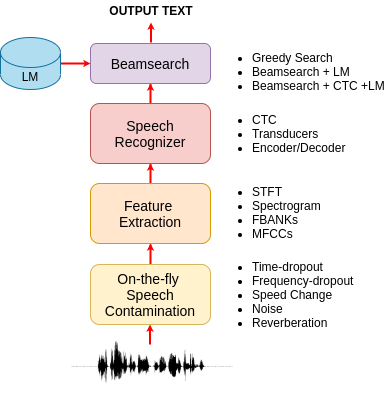





The speech recognition process starts from the **raw waveform directly**. 

The original waveform is contaminated with different **speech augmentation techniques** such as *time/frequency dropout*, *speed change*, *adding noise*, *reverberation*, etc. These disturbances are activated randomly according to some probabilities specified by the user. They are also added **on-the-fly** without the need of storing the augmented signals on disk. For more information on the contamination techniques, please take a look at our tutorial on [speech augmentation](https://colab.research.google.com/drive/1JJc4tBhHNXRSDM2xbQ3Z0jdDQUw4S5lr?usp=sharing) and [environmental corruption](https://colab.research.google.com/drive/1mAimqZndq0BwQj63VcDTr6_uCMC6i6Un?usp=sharing).


We then extract **speech features**, such as *Short-Term Fourier Transform (STFT)*, *spectrograms*, *FBANKs*, and *MFCCs*. Also, the features can be computed on the fly thanks to a very efficient GPU-friendly implementation.
For more information, take a look at our tutorials on [speech representation](https://colab.research.google.com/drive/18IgBv3Ip0rWXjYoZywttSmW7Y2AIK1vJ?usp=sharing) and [speech features](https://colab.research.google.com/drive/1CI72Xyay80mmmagfLaIIeRoDgswWHT_g?usp=sharing).

We then feed the features into the **speech recognizer**, which is a neural network that maps the input sequence of features into an output sequence of tokens (e.g., phonemes, characters, subwords, words).  SpeechBrain supports popular techniques such as Connectionist Temporal Classification (CTC), Transducers, or Encoder/Decoder with attention (using both RNN- and Transformer-based systems).

The posterior probabilities over the output tokens are processed by a beamsearcher that explores different alternatives and outputs the best one.
The alternatives can be optionally rescored with an external language model that could be based on RNN or transformers.


Not all the modules mentioned here are mandatory. For instance, data contamination can be skipped if not helpful for a specific task. Even beasearch can be replaced with a greedy search for fast decoding. 

Let's now discuss more in detail the different technologies supported for speech recognition:




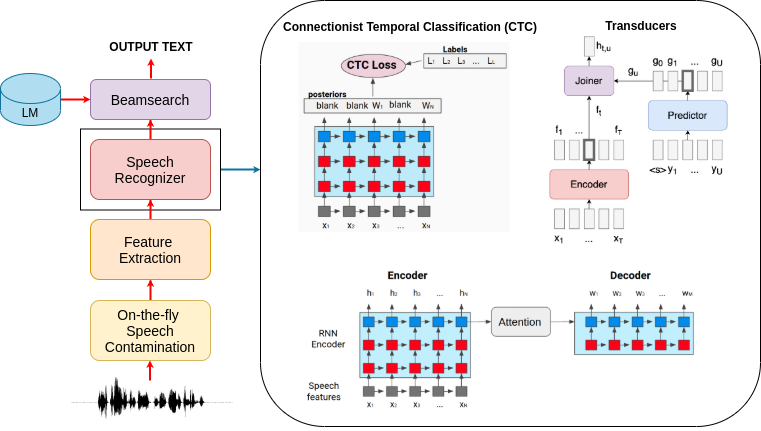


### **Connectionist Temporal Classification (CTC)** 
CTC is the simplest speech recognition system available in SpeechBrain. 

For each time step, it outputs a prediction. CTC adds a special token called *blank*.  That allows the network to output nothing when not sure about what to emit. The CTC cost function uses **dynamic programming** to align over all the possible alignments.

For each alignment, we can compute a corresponding probability.  The final CTC cost is the sum of the probabilities of all possible alignments. This can be computed efficiently using the forward algorithm (the one described in the Hidden Markov Model literature, not the one used for neural networks).

In the encoder-decoder architectures,  we use attention to learn the alignment between input-output sequences. In CTC, we do not learn it, but we integrate over all the possible alignments.


Essentially, CTC can be implemented through a special cost function plugged on top of the speech recognizer (often but not always based on recurrent neural networks).




### **Transducers**
As shown in the Figure, Transducers augment CTC by adding an autoregressive predictor and a join network. An encoder (usually based on RNNs) transforms the input features into a sequence of encoded representations. The predictor, instead, generates a latent representation based on the previously emitted outputs. A join network combines the two and a softmax classifier predicts the current output token. During training, CTC loss is used after the classifier. 


[See this nice tutorial by Loren Lugosch for more information on Transducers.](https://lorenlugosch.github.io/posts/2020/11/transducer/)

### **Encoder-Decoder with attention**
Another popular way to approach speech recognition is via an encoder-decoder architecture. 
The **encoder** is fed by a sequence of speech features (or from the raw samples directly) and generates a sequence of states h.
The **decoder** is fed by the last hidden state and outputs the N output tokens.
The decoder is often autoregressive (i.e., the previous output is fed back into the input). Decoding is stopped when the end-of-sentence (eos) token is predicted.
The encoder and decoders can be based on any neural architectures (e.g., RNN, CNN, Transformers, or a combination of them). 

The **attention** creates dynamic connections across encoder and decoder states. SpeechBrain supports different types of attention such as *content* or *location-aware* for RNN-based systems and *key-value*-based for Transformers.
To improve the convergence often a CTC loss is applied on the top of the encoder.

### **Beamsearch**
The beamsearcher for encoder-decoder models is often autoregressive. It start from the <bos> token and predicts the N most promising next tokens. We then feed these N alternatives into the decoder and select the best N hypothesis. We loop in this way until the <eos> token is predicted.

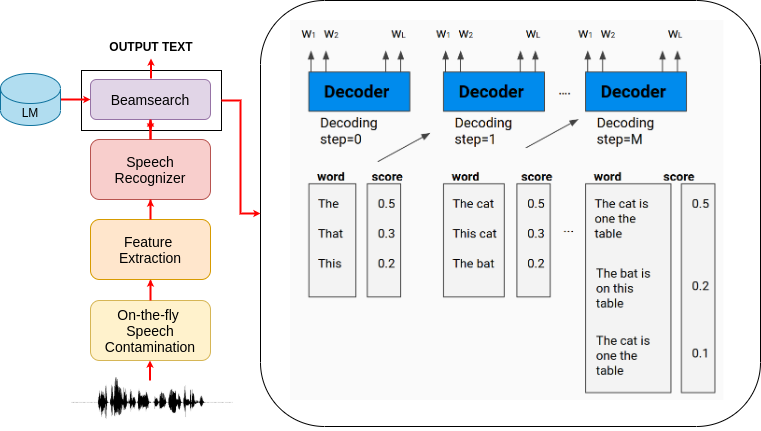


We encourage the readers not familiar enough with speech recognition to gain more familiarity with this technology before moving on. Beyond scientific papers, online you can find amazing tutorials and blog posts, such as:
- [An Intuitive Explanation of Connectionist Temporal Classification](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c)
- [Connectionist Temporal Classification](https://machinelearning-blog.com/2018/09/05/753/)
- [Sequence-to-sequence learning with Transducers](https://lorenlugosch.github.io/posts/2020/11/transducer/)
- [Understanding Encoder-Decoder Sequence to Sequence Model](https://towardsdatascience.com/understanding-encoder-decoder-sequence-to-sequence-model-679e04af4346)
- [What is a Transformer?](https://medium.com/inside-machine-learning/what-is-a-transformer-d07dd1fbec04)
- [Attention? Attention!](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html)
- [Attention and its Different Forms](https://towardsdatascience.com/attention-and-its-different-forms-7fc3674d14dc)
- [How to Implement a Beam Search Decoder for Natural Language Processing](https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/)
- [An intuitive explanation of Beam Search](https://towardsdatascience.com/an-intuitive-explanation-of-beam-search-9b1d744e7a0f)

After this brief overview let's now see how we can develop a speech recognition system (encoder-decoder + CTC) with SpeechBrain. 

For simplicity, training will be done with a small open-source dataset called [mini-librispeech](https://www.openslr.org/31/), which only contains few hours of training data. In a real case, you need much more training material (e.g 100 or even 1000 hours) to reach acceptable performance.

## **Installation**

To run the code fast enough, we suggest using a GPU (`Runtime => change runtime type => GPU`). In this tutorial, we will refer to the code in ```speechbrain/templates/ASR```. 

Before starting, let's install speechbrain:

In [ ]:
%%time
#%%capture
# Local installation
!git clone https://github.com/speechbrain/speechbrain/
%cd /content/speechbrain/
!pip install -r requirements.txt
!pip install -e .

fatal: destination path 'speechbrain' already exists and is not an empty directory.
/content/speechbrain
Ignoring SoundFile: markers 'sys_platform == "win32"' don't match your environment
Obtaining file:///content/speechbrain
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Attempting uninstall: speechbrain
    Found existing installation: speechbrain 0.5.11
    Uninstalling speechbrain-0.5.11:
      Successfully uninstalled speechbrain-0.5.11
  Running setup.py develop for speechbrain
CPU times: user 129 ms, sys: 40.9 ms, total: 169 ms
Wall time: 16.3 s


In [ ]:
%%time
#%%capture
# to avoid the error No  module find error
# import speechbrain as sb
# For pip installation
!pip install speechbrain

  Using cached speechbrain-0.5.11-py3-none-any.whl (408 kB)
CPU times: user 38 ms, sys: 15.8 ms, total: 53.8 ms
Wall time: 3.94 s


## **Which steps are needed?**
The steps needed to train a modern end-to-end speech recognizer are the following:

1. **Prepare your data**.
The goal of this step is to create the data manifest files (in CSV or JSON format). The data manifest files tell SpeechBrain where to find the speech data and their corresponding text annotations. In this tutorial, the data manifest files are created by [mini_librispeech_prepare.py](https://github.com/speechbrain/speechbrain/blob/develop/templates/speech_recognition/mini_librispeech_prepare.py).  

2. **Train a tokenizer**.
The tokenizer decides which basic units allocate for training the speech recognizer and the language model (e.g, characters, phonemes, sub-words, words).
```
cd speechbrain/templates/speech_recognition/Tokenizer
python train.py tokenizer.yaml
```

3. **Train a language model**.
After that, we can train a language model. To do it, we need some large text corpus (better if the language domain is the same as the one of your target application). In this example, however, we  train the LM on top of the training transcriptions (for simplicity):
```
pip install datasets
cd speechbrain/templates/speech_recognition/LM
python train.py RNNLM.yaml
```

4. **Train the speech recognizer**.
At this point, we are ready to train our speech recognizer. In this tutorial, we will use the CRDNN model with an autoregressive GRU decoder. An attention mechanism is employed between encoding and decoder. The final sequence of words is retrieved with beamsearch coupled with the RNNLM trained in the previous step:
```
cd speechbrain/templates/speech_recognition/ASR
python train.py train.yaml
```

5. **Use the speech recognizer (inference)**:
After training, we can use the speech recognizer for inference. Some classes such as the EncoderDecoderASR are available in SpeechBrain to make inference easier.



We will now provide a detailed description of all these steps.


## **Step 1: Prepare your data** 
The goal of data preparation is to create the data manifest files. 
These files tell SpeechBrain where to find the audio data and their corresponding transcriptions. They are text files written in the popular CSV and JSON formats.

### **Data manifest files**
Let's take a look into how a data manifest file in JSON format looks like:


```json
{
  "1867-154075-0032": {
    "wav": "{data_root}/LibriSpeech/train-clean-5/1867/154075/1867-154075-0032.flac",
    "length": 16.09,
    "words": "AND HE BRUSHED A HAND ACROSS HIS FOREHEAD AND WAS INSTANTLY HIMSELF CALM AND COOL VERY WELL THEN IT SEEMS I'VE MADE AN ASS OF MYSELF BUT I'LL TRY TO MAKE UP FOR IT NOW WHAT ABOUT CAROLINE"
  },
  "1867-154075-0001": {
    "wav": "{data_root}/LibriSpeech/train-clean-5/1867/154075/1867-154075-0001.flac",
    "length": 14.9,
    "words": "THAT DROPPED HIM INTO THE COAL BIN DID HE GET COAL DUST ON HIS SHOES RIGHT AND HE DIDN'T HAVE SENSE ENOUGH TO WIPE IT OFF AN AMATEUR A RANK AMATEUR I TOLD YOU SAID THE MAN OF THE SNEER WITH SATISFACTION"
  },
  "1867-154075-0028": {
    "wav": "{data_root}/LibriSpeech/train-clean-5/1867/154075/1867-154075-0028.flac",
    "length": 16.41,
    "words": "MY NAME IS JOHN MARK I'M DOONE SOME CALL ME RONICKY DOONE I'M GLAD TO KNOW YOU RONICKY DOONE I IMAGINE THAT NAME FITS YOU NOW TELL ME THE STORY OF WHY YOU CAME TO THIS HOUSE OF COURSE IT WASN'T TO SEE A GIRL"
  },
}
```
As you can see, we have a hierarchical structure in which the first key is a **unique identifier** of the spoken sentence. 
Then, we specify all the fields that are needed for the task addressed. For instance, we report the **path of the speech recording**, its **length** in seconds (needed if we wanna sort the sentences before creating the mini-batches), and the **sequence of words** uttered in the given recording. 

Actually, you can specify here the entries with the name you prefer. However, there must be a matching between the name of these entries and what the experiment script (e.g, train.py) expects. We will elaborate more on this later.

You might have noticed that we define a special variable called `data_root`. This allows users to dynamically change the data folder from the command line (or from the yaml hyperparameter file).


### **Preparation Script**
Every dataset is formatted in a different way. The script that parses your own dataset and creates the JSON or the CSV files is something that you are supposed to write. Most of the time, this is very straightforward. 

For the mini-librispeech dataset, for instance, we wrote this simple data preparation script called [mini_librispeech_prepare.py](https://github.com/speechbrain/speechbrain/blob/develop/templates/speech_recognition/mini_librispeech_prepare.py).
The function automatically downloads the data (that in this case are publicly available). We search for all the audio files and transcriptions and while reading them we create the JSON file. 

You can use this script as a good base for your custom preparation on your target dataset. As you can see, we create three separate data manifest files to manage training, validation, and test phases. 


### **Copy your data locally**
When using speechbrain (or any other toolkit) within an HPC cluster, a good practice is to copy the data in the local folder of the computing node. This would make the code much much faster because the data aren't fetched from the shared filesystem but from the local one. We suggest users follow this approach (not possible here in Google Colab).

## **Step 2: Tokenizer** 
An important decision to make when designing a speech recognizer concerns the basic tokens that our system has to predict (e.g, characters, phonemes, sub-words, words).

### **Using characters as tokens**
One way is to predict characters. In this case, we simply convert the sequence of words into its corresponding sequence of characters (using the space '_' as an additional character):

`THE CITY OF MONTREAL => ['T','H','E', '_', 'C','I','T','Y','_', 'O', 'F', '_, 'M','O','N','T','R','E','A','L']`

Employing characters as basic tokens has some advantages and disadvantages:
+ The total number of tokens to predict is very small (e.g, 20-30 tokens) and there will be enough training material for each one.
+ With small atomic units like characters, we have the chance to generalize to words never seen during training. The system, in fact, can output any sequence of characters, including sequences never observed during training.
+ The number of characters within a sentence is quite large and predicting long sequences is more critical than predicting shorter ones.

Another option would be to estimate **phonemes** rather than characters. Phonemes are the basic sounds making up speech and they can be in principle a good choice. However, for many languages (e.g, English), the conversion from words to phonemes might not be trivial and requires phoneme annotation of each word (checked by human experts) in your dataset. For this reason, modern end-to-end speech recognizers do not use often phonemes as targets.


### **Using words as tokens**
Why not predicting full words then? 

`THE CITY OF MONTREAL => ['THE','CITY','OF','MONTREAL']`


This is another extreme case that has some advantages and (several) issues:
+ The advantage is that the output sequences will be short.
+ The system, however, cannot anymore generalize to new words 
+ Moreover, some words might be observed only one or a few times in the training dataset. This way, we likely end up allocating tokens with little training material.  


### **Byte Pair Encoding (BPE)**
What about something in between? 
This is what we are trying to do with BPE tokens. BPE is a simple technique inherited from data compression. The basic idea is to allocate tokens for the most frequent sequences of characters. For instance:

`THE CITY OF MONTREAL => ['THE', '▁CITY', '▁OF', '▁MO', 'NT', 'RE', 'AL']`

The article 'THE' and the preposition 'OF' are very common and we can allocate full tokens for them. Instead, we might wanna split "MONTREAL" into smaller pieces that are observed more frequently than the full word. 

The [algorithm that finds these tokens](https://en.wikipedia.org/wiki/Byte_pair_encoding) is very simple: we start from the characters and we count how many times two consecutive characters are observed together. We allocate a token for the most frequent pair and we iterate over and over until a specified number of tokens is reached. For more information, you can take a look at [our tutorial on the tokenizers](https://colab.research.google.com/drive/12yE3myHSH-eUxzNM0-FLtEOhzdQoLYWe?usp=sharing).

#### *How many BPE tokens should I use?*
The number of tokens is one of the hyperparameters of your system.
Its optimal value depends on the amount of speech data available. Just to give you an idea, for LibriSpeech (i.e., 1000 hours of sentences in English) a reasonable number of tokens ranges between 1k and 10k.

### **Train a Tokenizer**
SpeechBrain relies on the popular [SentencePiece](https://github.com/google/sentencepiece) for tokenization. To find the tokens to allocate (given the training transcriptions), run the following code:



In [19]:
%%time
%cd /content/speechbrain/templates/speech_recognition/Tokenizer
!python train.py tokenizer.yaml

/content/speechbrain/templates/speech_recognition/Tokenizer
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: ./save
train-clean-5.tar.gz: 333MB [00:23, 14.4MB/s]               
dev-clean-2.tar.gz: 126MB [00:07, 16.1MB/s]               
test-clean.tar.gz: 347MB [00:19, 17.4MB/s]               
mini_librispeech_prepare - Creating ../train.json, ../valid.json, and ../test.json
mini_librispeech_prepare - Transcription files read!
mini_librispeech_prepare - ../train.json successfully created!
mini_librispeech_prepare - ../valid.json successfully created!
mini_librispeech_prepare - ../test.json successfully created!
speechbrain.tokenizers.SentencePiece - Train tokenizer with type:unigram
speechbrain.tokenizers.SentencePiece - Extract words sequences from:../train.json
speechbrain.tokenizers.SentencePiece - Text file created at: ../train.txt
sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=../train.txt --model_prefix=./save/1000_unigram --model_ty

In [ ]:
import json
with open('/content/speechbrain/templates/speech_recognition/train.json') as json_file:
#with open('/content/train.json') as json_file:
  t = json.load(json_file)
print(len(t.keys()))
list(t.items())[:3]

6280


[('c-2c-57ee4f2c3994',
  {'length': 2.2,
   'wav': '{data_root}/c/2c/57ee4f2c3994.wav',
   'words': 'НОРА РЕШИТ ЧТО Я'}),
 ('5-f1-20fe4fa745e9',
  {'length': 3.73,
   'wav': '{data_root}/5/f1/20fe4fa745e9.wav',
   'words': 'ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'}),
 ('5-db-5f60b9ccaa49',
  {'length': 1.7,
   'wav': '{data_root}/5/db/5f60b9ccaa49.wav',
   'words': 'САМОМ ДЕЛЕ РЕЗЮМЕ'})]

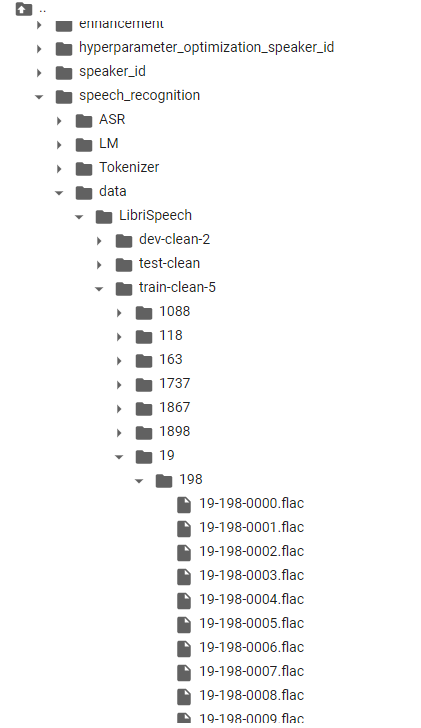

In [ ]:
!head -3 /content/speechbrain/templates/speech_recognition/train.txt

head: cannot open '/content/speechbrain/templates/speech_recognition/train.txt' for reading: No such file or directory


The code might take a while just because data are downloaded and prepared. As for all the other recipes in SpeechBrain, we have a training script (`train.py`) and a hyperparameter file (`tokenizer.yaml`). Let's take a closer look into the latter first:



```yaml
# ############################################################################
# Tokenizer: subword BPE tokenizer with unigram 1K
# Training: Mini-LibriSpeech
# Authors:  Abdel Heba 2021
#           Mirco Ravanelli 2021
# ############################################################################


# Set up folders for reading from and writing to
data_folder: ../data
output_folder: ./save

# Path where data-specification files are stored
train_annotation: ../train.json
valid_annotation: ../valid.json
test_annotation: ../test.json

# Tokenizer parameters
token_type: unigram  # ["unigram", "bpe", "char"]
token_output: 1000  # index(blank/eos/bos/unk) = 0
character_coverage: 1.0
annotation_read: words # field to read

# Tokenizer object
tokenizer: !name:speechbrain.tokenizers.SentencePiece.SentencePiece
   model_dir: !ref <output_folder>
   vocab_size: !ref <token_output>
   annotation_train: !ref <train_annotation>
   annotation_read: !ref <annotation_read>
   model_type: !ref <token_type> # ["unigram", "bpe", "char"]
   character_coverage: !ref <character_coverage>
   annotation_list_to_check: [!ref <train_annotation>, !ref <valid_annotation>]
   annotation_format: json
```

The tokenizer is trained on training annotation only. We set here a vocabulary size of 1000. Instead of using the standard BPE algorithm, we use a variation of it based on unigram smoothing. See [sentencepiece](https://github.com/google/sentencepiece) for more info.
The tokenizer will be saved in the specified `output_folder`. 

Let's now take a look into the training script `train.py`:



```python
if __name__ == "__main__":

    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Data preparation, to be run on only one process.
    prepare_mini_librispeech(
        data_folder=hparams["data_folder"],
        save_json_train=hparams["train_annotation"],
        save_json_valid=hparams["valid_annotation"],
        save_json_test=hparams["test_annotation"],
    )

    # Train tokenizer
    hparams["tokenizer"]()
```

Essentially, we prepare the data with the `prepare_mini_librispeech` script and we then run the sentencepiece tokenizer wrapped in 
`speechbrain.tokenizers.SentencePiece.SentencePiece`.

Let's take a look at the files generated by the tokenizer. If you go into the specified output folder (`Tokenizer/save`), you can find two files:
+ *1000_unigram.model*
+ *1000_unigram.vocab*

The first is a binary file containing all the information needed for tokenizing an input text. The second is a text file reporting the list of tokens allocated (with their log probabilities):

```
▁THE  -3.2458
S -3.36618
ED  -3.84476
▁ -3.91777
E -3.92101
▁AND  -3.92316
▁A  -3.97359
▁TO -4.00462
▁OF -4.08116
....
```

Let me now show how we can use the learned model to tokenize a text:


In [ ]:
import torch
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/1000_unigram.model")

# Encode as pieces
print(sp.encode_as_pieces('THE CITY OF MONTREAL'))

# Encode as ids
print(sp.encode_as_ids('THE CITY OF MONTREAL'))


['▁', 'THE', '▁', 'CITY', '▁', 'OF', '▁', 'MONTREAL']
[1, 0, 1, 0, 1, 0, 1, 0]


Note that the sentencepiece tokenizers also assign a unique index to each allocated token. These indexes will correspond to the output of our neural networks for language models and ASR.

## **Step 3: Train a Language Model**
A Language Model (LM) can be used within a speech recognizer in different ways. In this tutorial, we perform the so-called **shallow fusion** where the language information is used within the beam searcher of the speech recognizer to rescore the partial hypothesis. In practice, for every time step, we rescore the partial hypothesis provided by the speech recognizer with the language scores (that penalize sequences of tokens that are "unlikely" to be observed).

Some recent studies have shown that a speech recognizer trained on a very large dataset can achieve impressive performance even without a language. However, for medium-scale speech recognition tasks like Librispeech 1000h, the language model still plays a role in improving the final performance.

### **Text Corpus**
A language model is normally trained on **large text corpora** and it is designed to predict the most probable next token.
If you do not have a large text corpus of in-domain data for your application, you might want to skip this part. 

Another thing to remark is that training a language model on a large text corpus is very **computationally demanding**. You should consider using an available pre-trained model (and maybe fine-tune it). 

In this tutorial, we train the language model on the training transcriptions of mini-librispeech. This is just to show you how we can train it in a little amount of time. 

### **Train a LM**

We are going to train a simple RNN-based language model that estimates the next tokens given the previous ones.

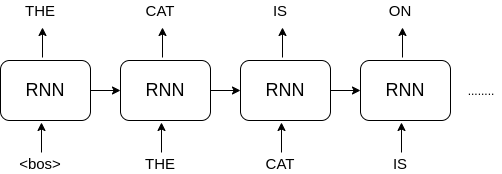

To train it, run the following code:

In [ ]:
###
# to avoid the error "ImportError: There is no such class as templates.speech_recognition.LM.custom_model.CustomModel"
# 1. or changhe in '/content/speechbrain/templates/speech_recognition/LM/RNNLM.yaml'
# model: !new:templates.speech_recognition.LM.custom_model.CustomModel 
# to
# model: !new:custom_model.CustomModel
#
# or 2. run code below
import sys
new_path = "/content/speechbrain"
if not new_path in sys.path:
  sys.path.append(new_path)
else:
  print(f"'{new_path}' is already exist in $PATH")

In [ ]:
from hyperpyyaml import load_hyperpyyaml
hparams_file = "/content/speechbrain/templates/speech_recognition/LM/RNNLM.yaml"
with open(hparams_file) as fin:
    hparams = load_hyperpyyaml(fin )
    print(hparams["model"])
#dump_hyperpyyaml    

CustomModel(
  (embedding): Embedding(
    (Embedding): Embedding(1000, 256)
  )
  (rnn): LSTM(256, 512, num_layers=2)
  (out): Linear(
    (w): Linear(in_features=512, out_features=1000, bias=True)
  )
  (log_softmax): Softmax(
    (act): LogSoftmax(dim=-1)
  )
)


In [ ]:
%%time
!pip install datasets
%cd /content/speechbrain/templates/speech_recognition/LM
!python train.py RNNLM.yaml #--device='cpu'
#!python train.py RNNLM.yaml --device='cpu'

/content/speechbrain/templates/speech_recognition/LM
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/RNNLM/
root - generating datasets...
datasets.builder - Using custom data configuration default-3a03b697a7c3ef45
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-3a03b697a7c3ef45/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 78.94it/s]
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 4.4M trainable parameters in LM
speechbrain.utils.checkpoints - Loading a checkpoint from results/RNNLM/save/CKPT+2022-05-07+10-23-00+00
speechbrain.utils.checkpoints - Loading a checkpoint from results/RNNLM/save/CKPT+2022-05-07+10-23-00+00
100% 151/151 [00:00<00:00, 617.74it/s]
speechbrain.utils.train_logger - Epoch loaded: 20 - test loss: 5.96e-07
CPU times: user 145 ms, sys: 49.7 ms, total: 194 ms
Wall time: 16.9 s


As you can see from the prints, both the validation and training losses are decreasing. 
Before diving into the code, let's see which files/folders are generated in the specified `output_folder`:

*   `train_log.txt`: contains the statistics (e.g, train_loss, valid_loss) computed at each epoch. 
*   `log.txt`: is a more detailed logger containing the timestamps for each basic operation.
*  `env.log`: shows all the dependencies used with their corresponding version (useful for replicability).

*  `train.py`, `hyperparams.yaml`:  are a copy of the experiment file along with the corresponding hyperparameters (for replicability).

* `save`:  is the place where we store the learned model.

In the `save` folder, you find subfolders containing the checkpoints saved during training (in the format `CKPT+data+time`). Typically, you find here two checkpoints: the best (i.e, the oldest one) and the latest (i.e, the most recent one). If you find only a single checkpoint it means that the last epoch is also the best.

Inside each checkpoint, you can find all the information needed to resume training (e.g, models, optimizers, schedulers, epoch counter, etc.). The parameters of the RNNLM model are reported in `model.ckpt` file. This is just a binary format readable with `torch.load`.


As usual, we have a `train.py` and a hyperparameter file called `RNNLM.yaml`. 

### **Hyperparameters**
[You can take a look into the full RNNLM.yaml file here](https://github.com/speechbrain/speechbrain/blob/develop/templates/speech_recognition/LM/RNNLM.yaml).

In the first part, we specify some basic settings, such as the seed, the path of the output folders and the training logger:

```yaml
seed: 2602
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/RNNLM/
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt
```

We then specify the path of the text corpora used for training, validation, and test:

```yaml
lm_train_data: data/train.txt
lm_valid_data: data/valid.txt
lm_test_data: data/test.txt
```

Different from all the other recipes, the LM one directly reads big corpora in raw text format (without the need for the JSON/CSV files). This is done with the [HuggingFace dataset](https://huggingface.co/), that turned out to be very efficient and easy to use.

Next, we set up the train_logger and we specify which tokenizer we use to transform the input words into a sequence of tokens. In this case, we have to use the tokenizer trained at the previous step:

```yaml
# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Tokenizer model (you must use the same tokenizer for LM and ASR training)
tokenizer_file: ../Tokenizer/save/1000_unigram.model
```


We can now specify some training hyperparameters such as the number of epochs, the batch size, and the learning rate. We also define the most important architectural hyperparameters (e.g, number of layers, number of neurons per layer, output dimensionality).




```yaml
# Training parameters
number_of_epochs: 20
batch_size: 80
lr: 0.001
accu_steps: 1 # Gradient accumulation to simulate large batch training
ckpt_interval_minutes: 15 # save checkpoint every N min

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

# Model parameters
emb_dim: 256 # dimension of the embeddings
rnn_size: 512 # dimension of hidden layers
layers: 2 # number of hidden layers

# Outputs
output_neurons: 1000 # index(eos/bos) = 0
```

Next, we define the objects that we will use to train our language model. We thus declare objects for the RNN model, the cost function, the optimizer, and the learning rate scheduler:


```yaml
model: !new:templates.speech_recognition.LM.custom_model.CustomModel
    embedding_dim: !ref <emb_dim>
    rnn_size: !ref <rnn_size>
    layers: !ref <layers>


# Cost function used for training the model
compute_cost: !name:speechbrain.nnet.losses.nll_loss

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    betas: (0.9, 0.98)
    eps: 0.000000001

# This function manages learning rate annealing over the epochs.
# We here use the NewBoB algorithm, that anneals the learning rate if
# the improvements over two consecutive epochs is less than the defined
# threshold.
lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0
```
The model that we used in this example is defined in the `custom_model.py` file. As mentioned, this is just a simple RNN but users can easily plug here their custom models (e.g .convolutional models or Transformers). 

We conclude the hyperparameter specification with the declaration of the epoch counter, tokenizer, and checkpointer:


```yaml
# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    model: !ref <model>

# Tokenier initialization
tokenizer: !new:sentencepiece.SentencePieceProcessor

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        scheduler: !ref <lr_annealing>
        counter: !ref <epoch_counter>

# Pretrain the tokenizer
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        tokenizer: !ref <tokenizer>
    paths:
        tokenizer: !ref <tokenizer_file>
```

The last class is the pre-trainer, which connects the tokenizer object with the specified pre-trained tokenizer.


### **Experiment file**
Let's now take a look into how the objects, functions, and hyperparameters declared in the yaml file are used in `train.py` to implement the language model.

Let's start from the main of the `train.py`:


```python
# Recipe begins!
if __name__ == "__main__":

    # Reading command line arguments
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )
```

We here do some preliminary operations such as parsing the command line, initializing the distributed data-parallel (needed if multiple GPUs are used), creating the output folder, and reading the yaml file.

After reading the yaml file with `load_hyperpyyaml`, all the objects declared in the hyperparameter files are initialized and available in a dictionary form (along with the other functions and parameters reported in the yaml file).
For instance,  we will have `hparams['model']`, `hparams['optimizer']`, `hparams['batch_size']`, etc.


#### **Data-IO Pipeline**
We then call a special function that creates the dataset objects for training, validation, and test.

```python
    # Create dataset objects "train", "valid", and "test"
    train_data, valid_data, test_data = dataio_prepare(hparams)
```

Let's take a closer look into that.


```python
def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.

    The language model is trained with the text files specified by the user in
    the hyperparameter file.

    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : list
        List containing "train", "valid", and "test" sets that correspond
        to the appropriate DynamicItemDataset object.
    """

    logging.info("generating datasets...")

    # Prepare datasets
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["lm_train_data"],
            "valid": hparams["lm_valid_data"],
            "test": hparams["lm_test_data"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"]
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["valid"]
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"]
    )

    datasets = [train_data, valid_data, test_data]
    tokenizer = hparams["tokenizer"]

    # Define text processing pipeline. We start from the raw text and then
    # encode it using the tokenizer. The tokens with bos are used for feeding
    # the neural network, the tokens with eos for computing the cost function.
    @sb.utils.data_pipeline.takes("text")
    @sb.utils.data_pipeline.provides("text", "tokens_bos", "tokens_eos")
    def text_pipeline(text):
        yield text
        tokens_list = tokenizer.encode_as_ids(text)
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set outputs to add into the batch. The batch variable will contain
    # all these fields (e.g, batch.id, batch.text, batch.tokens.bos,..)
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "text", "tokens_bos", "tokens_eos"],
    )
    return train_data, valid_data, test_data
```

The first part is just a conversion from the HuggingFace dataset to the DynamicItemDataset used in SpeechBrain. 

You can notice that we expose the text processing function `text_pipeline`, which takes in input the text of one sentence and processes it in different ways. 

The text processing function converts the raw text into the corresponding tokens (in index form). We also create other variables such as the version of the sequence with the beginning of the sentence `<bos>`  token in front and the one with the end of sentence `<eos>` as the last element. Their usefulness will be clear later.

Before returning the dataset objects, the `dataio_prepare` specifies which keys we would like to output. As we will see later, these keys will be available in the brain class as `batch.id`, `batch.text`, `batch.tokens_bos`, etc.
[For more information on the data loader, please take a look into this tutorial](https://colab.research.google.com/drive/1AiVJZhZKwEI4nFGANKXEe-ffZFfvXKwH?usp=sharing)


After the definition of the datasets, the main function can go ahead with the  initialization of the brain class:

```python
    # Initialize the Brain object to prepare for LM training.
    lm_brain = LM(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )
```
The brain class implements all the functionalities needed for supporting the training and validation loops.  Its `fit` and `evaluate` methods perform training and test, respectively:

```python
    lm_brain.fit(
        lm_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # Load best checkpoint for evaluation
    test_stats = lm_brain.evaluate(
        test_data,
        min_key="loss",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )
```
The training and validation data loaders are given in input to the fit method, while the test dataset is fed into the evaluate method.

Let's now take a look into the most important methods defined in the brain class.

#### **Forward Computations**

Let's start with the `forward` function, which defines all the computations needed to transform the input text into the output predictions.


```python
    def compute_forward(self, batch, stage):
        """Predicts the next word given the previous ones.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : torch.Tensor
            A tensor containing the posterior probabilities (predictions).
        """
        batch = batch.to(self.device)
        tokens_bos, _ = batch.tokens_bos
        pred = self.hparams.model(tokens_bos)
        return pred
```

In this case, the chain of computation is very simple. We just put the batch on the right device and feed the encoded tokens into the model. We feed the tokens with `<bos>` into the model.
When adding the `<bos>` token, in fact, we shift all the tokens by one element. This way, our input corresponds to the previous token while our model tries to predict the current one.

#### **Compute Objectives**

Let's take a look now into the `compute_objectives` method that takes in input the targets, the predictions, and estimates a loss function:

```python
    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : torch.Tensor
            The posterior probabilities from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        batch = batch.to(self.device)
        tokens_eos, tokens_len = batch.tokens_eos
        loss = self.hparams.compute_cost(
            predictions, tokens_eos, length=tokens_len
        )
        return loss
```
The predictions are those computed in the forward method. The cost function is evaluated by comparing these predictions with the target tokens. We here use the tokens with the special `<eos>` token at the end because we want to predict when the sentence ends as well.

####**Other methods**
Beyond these two important functions, we have some other methods that are used by the brain class. In particular, the `fit_batch` trains each batch of data (by computing the gradient with the backward method and the updates with step one). The `on_stage_end`, is called at the end of each stage (e.g, at the end of each training epoch) and mainly takes care of statistic management, learning rate annealing, and checkpointing. [For a more detailed description of the brain class, please take a look into this tutorial](https://colab.research.google.com/drive/12bg3aUdr9mTfOGqcB5pSMABoIKPgiwcM?usp=sharing). For more information on checkpointing, [take a look here](https://colab.research.google.com/drive/1VH7U0oP3CZsUNtChJT2ewbV_q1QX8xre?usp=sharing)





## **Step 4: Speech Recognizer**
At this point, we can train our speech recognizer. In this tutorial, we are
going to train an **attention-based end-to-end speech recognizer** (offline).
The encoder relies on a combination of convolutional, recurrent, and fully connected models. The decoder is an autoregressive GRU decoder. An attention mechanism is employed between encoding and decoder. The final sequence of words is retrieved with beamsearch coupled with the RNNLM trained in the previous step. 
The attention-based system is jointly trained with CTC (applied on the top of the encoder).
The system uses data augmentation techniques to improve its performance.

### **Train the speech recognizer**
To train the speech recognizer, run the following code:

In [ ]:
import torch
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train.py train.yaml --batch_size=2 --number_of_epochs=8 --number_of_ctc_epochs=5
else:
    !python train.py train.yaml --batch_size=2 --device='cpu'

/content/speechbrain/templates/speech_recognition/ASR
rirs_noises.zip: 1.31GB [00:51, 25.4MB/s]                
Extracting ../data/rirs_noises.zip to ../data
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN_BPE_960h_LM/2602
train-clean-5.tar.gz: 333MB [00:15, 21.5MB/s]               
dev-clean-2.tar.gz: 126MB [00:06, 20.2MB/s]               
test-clean.tar.gz: 347MB [00:14, 24.5MB/s]               
mini_librispeech_prepare - Creating ../train.json, ../valid.json, and ../test.json
mini_librispeech_prepare - Transcription files read!
mini_librispeech_prepare - ../train.json successfully created!
mini_librispeech_prepare - ../valid.json successfully created!
mini_librispeech_prepare - ../test.json successfully created!
speechbrain.pretrained.fetching - Fetch lm.ckpt: Delegating to Huggingface hub, source speechbrain/asr-crdnn-rnnlm-librispeech.
/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass l

In [ ]:
#https://github.com/speechbrain/speechbrain/issues/787
import torch
torch.rand(10, device='cuda')

tensor([0.2296, 0.7298, 0.9210, 0.2261, 0.0560, 0.1369, 0.4284, 0.5802, 0.1956,
        0.1000], device='cuda:0')

#### part 1 ep 01-08

In [ ]:
import gc
gc.collect()

88

In [ ]:
import gc
import torch
gc.collect();gc.collect()
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train.py train.yaml --batch_size=3 --number_of_epochs=8 --number_of_ctc_epochs=5
else:
    !python train.py train.yaml --batch_size=2 --device='cpu'

/content/speechbrain/templates/speech_recognition/ASR
../data/rirs_noises.zip exists. Skipping download
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN_BPE_960h_LM/2602
mini_librispeech_prepare - Preparation completed in previous run, skipping.
speechbrain.pretrained.fetching - Fetch lm.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/lm.ckpt.
speechbrain.pretrained.fetching - Fetch tokenizer.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/tokenizer.ckpt.
speechbrain.pretrained.fetching - Fetch asr.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/model.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained files for: lm, tokenizer, model
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 173.0M trainable parameters in ASR
speechbrain.utils.checkpoints - Would load a checkpoint here, but none found yet.
speechbrain.uti

#### Save ckpt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from_path = '/content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/'
to_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/BaseLine_01_mini_librispeech/"
!cp -r '$from_path'*.txt '$to_path'
!cp -r '$from_path'save/*.ckpt '$to_path'save/
ckpt_path = "CKPT+2022-05-15+15-51-34+00"
!cp -r '$from_path'save/'$ckpt_path' '$to_path'save/'$ckpt_path'

#### Restore ckpt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /content/speechbrain/templates/speech_recognition/ASR/results/
!mkdir /content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM
!mkdir /content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/
!mkdir /content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/save/
!mkdir /content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/save/CKPT+2022-05-15+15-51-34+00

In [ ]:
from_path = '/content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/'
to_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/BaseLine_01_mini_librispeech/"
#!cp -r '$from_path'*.txt '$to_path'
!cp -r '$to_path'save/*.ckpt  '$from_path'save/
ckpt_path = "CKPT+2022-05-15+15-51-34+00"
!cp -r '$to_path'save/'$ckpt_path' '$from_path'save/'$ckpt_path'

#### correct yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_c.yaml
# ############################################################################
# Model: E2E ASR with attention-based ASR
# Encoder: CRDNN
# Decoder: GRU + beamsearch + RNNLM
# Tokens: 1000 BPE
# losses: CTC+ NLL
# Training: mini-librispeech
# Pre-Training: librispeech 960h
# Authors:  Ju-Chieh Chou, Mirco Ravanelli, Abdel Heba, Peter Plantinga, Samuele Cornell 2020
# # ############################################################################

# Seed needs to be set at top of yaml, before objects with parameters are instantiated
seed: 2602
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# If you plan to train a system on an HPC cluster with a big dataset,
# we strongly suggest doing the following:
# 1- Compress the dataset in a single tar or zip file.
# 2- Copy your dataset locally (i.e., the local disk of the computing node).
# 3- Uncompress the dataset in the local folder.
# 4- Set data_folder with the local path
# Reading data from the local disk of the compute node (e.g. $SLURM_TMPDIR with SLURM-based clusters) is very important.
# It allows you to read the data much faster without slowing down the shared filesystem.

data_folder: ../data # In this case, data will be automatically downloaded here.
data_folder_rirs: !ref <data_folder> # noise/ris dataset will automatically be downloaded here
output_folder: !ref results/CRDNN_BPE_960h_LM/<seed>
wer_file: !ref <output_folder>/wer.txt
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Language model (LM) pretraining
# NB: To avoid mismatch, the speech recognizer must be trained with the same
# tokenizer used for LM training. Here, we download everything from the
# speechbrain HuggingFace repository. However, a local path pointing to a
# directory containing the lm.ckpt and tokenizer.ckpt may also be specified
# instead. E.g if you want to use your own LM / tokenizer.
pretrained_path: speechbrain/asr-crdnn-rnnlm-librispeech


# Path where data manifest files will be stored. The data manifest files are created by the
# data preparation script
train_annotation: ../train.json
valid_annotation: ../valid.json
test_annotation: ../test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Training parameters
number_of_epochs: 15
number_of_ctc_epochs: 5
batch_size: 8
lr: 1.0
ctc_weight: 0.5
sorting: ascending
ckpt_interval_minutes: 15 # save checkpoint every N min
label_smoothing: 0.1

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>

valid_dataloader_opts:
    batch_size: !ref <batch_size>

test_dataloader_opts:
    batch_size: !ref <batch_size>


# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 40

# Model parameters
activation: !name:torch.nn.LeakyReLU
dropout: 0.15
cnn_blocks: 2
cnn_channels: (128, 256)
inter_layer_pooling_size: (2, 2)
cnn_kernelsize: (3, 3)
time_pooling_size: 4
rnn_class: !name:speechbrain.nnet.RNN.LSTM
rnn_layers: 4
rnn_neurons: 1024
rnn_bidirectional: True
dnn_blocks: 2
dnn_neurons: 512
emb_size: 128
dec_neurons: 1024
output_neurons: 1000  # Number of tokens (same as LM)
blank_index: 0
bos_index: 0
eos_index: 0
unk_index: 0

# Decoding parameters
min_decode_ratio: 0.0
max_decode_ratio: 1.0
valid_beam_size: 8
test_beam_size: 80
eos_threshold: 1.5
using_max_attn_shift: True
max_attn_shift: 240
lm_weight: 0.50
ctc_weight_decode: 0.0
coverage_penalty: 1.5
temperature: 1.25
temperature_lm: 1.25

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

# Feature normalization (mean and std)
normalize: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

# Added noise and reverb come from OpenRIR dataset, automatically
# downloaded and prepared with this Environmental Corruption class.
env_corrupt: !new:speechbrain.lobes.augment.EnvCorrupt
    openrir_folder: !ref <data_folder_rirs>
    babble_prob: 0.0
    reverb_prob: 0.0
    noise_prob: 1.0
    noise_snr_low: 0
    noise_snr_high: 15

# Adds speech change + time and frequency dropouts (time-domain implementation).
augmentation: !new:speechbrain.lobes.augment.TimeDomainSpecAugment
    sample_rate: !ref <sample_rate>
    speeds: [95, 100, 105]

# The CRDNN model is an encoder that combines CNNs, RNNs, and DNNs.
encoder: !new:speechbrain.lobes.models.CRDNN.CRDNN
    input_shape: [null, null, !ref <n_mels>]
    activation: !ref <activation>
    dropout: !ref <dropout>
    cnn_blocks: !ref <cnn_blocks>
    cnn_channels: !ref <cnn_channels>
    cnn_kernelsize: !ref <cnn_kernelsize>
    inter_layer_pooling_size: !ref <inter_layer_pooling_size>
    time_pooling: True
    using_2d_pooling: False
    time_pooling_size: !ref <time_pooling_size>
    rnn_class: !ref <rnn_class>
    rnn_layers: !ref <rnn_layers>
    rnn_neurons: !ref <rnn_neurons>
    rnn_bidirectional: !ref <rnn_bidirectional>
    rnn_re_init: True
    dnn_blocks: !ref <dnn_blocks>
    dnn_neurons: !ref <dnn_neurons>
    use_rnnp: False

# Embedding (from indexes to an embedding space of dimension emb_size).
embedding: !new:speechbrain.nnet.embedding.Embedding
    num_embeddings: !ref <output_neurons>
    embedding_dim: !ref <emb_size>

# Attention-based RNN decoder.
decoder: !new:speechbrain.nnet.RNN.AttentionalRNNDecoder
    enc_dim: !ref <dnn_neurons>
    input_size: !ref <emb_size>
    rnn_type: gru
    attn_type: location
    hidden_size: !ref <dec_neurons>
    attn_dim: 1024
    num_layers: 1
    scaling: 1.0
    channels: 10
    kernel_size: 100
    re_init: True
    dropout: !ref <dropout>

# Linear transformation on the top of the encoder.
ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dnn_neurons>
    n_neurons: !ref <output_neurons>

# Linear transformation on the top of the decoder.
seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dec_neurons>
    n_neurons: !ref <output_neurons>

# Final softmax (for log posteriors computation).
log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

# Cost definition for the CTC part.
ctc_cost: !name:speechbrain.nnet.losses.ctc_loss
    blank_index: !ref <blank_index>


# Tokenizer initialization
tokenizer: !new:sentencepiece.SentencePieceProcessor

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class
modules:
    encoder: !ref <encoder>
    embedding: !ref <embedding>
    decoder: !ref <decoder>
    ctc_lin: !ref <ctc_lin>
    seq_lin: !ref <seq_lin>
    normalize: !ref <normalize>
    env_corrupt: !ref <env_corrupt>
    lm_model: !ref <lm_model>

# Gathering all the submodels in a single model object.
model: !new:torch.nn.ModuleList
    - - !ref <encoder>
      - !ref <embedding>
      - !ref <decoder>
      - !ref <ctc_lin>
      - !ref <seq_lin>

# This is the RNNLM that is used according to the Huggingface repository
# NB: It has to match the pre-trained RNNLM!!
lm_model: !new:speechbrain.lobes.models.RNNLM.RNNLM
    output_neurons: !ref <output_neurons>
    embedding_dim: !ref <emb_size>
    activation: !name:torch.nn.LeakyReLU
    dropout: 0.0
    rnn_layers: 2
    rnn_neurons: 2048
    dnn_blocks: 1
    dnn_neurons: 512
    return_hidden: True  # For inference

# Beamsearch is applied on the top of the decoder. If the language model is
# given, a language model is applied (with a weight specified in lm_weight).
# If ctc_weight is set, the decoder uses CTC + attention beamsearch. This
# improves the performance, but slows down decoding. For a description of
# the other parameters, please see the speechbrain.decoders.S2SRNNBeamSearchLM.

# It makes sense to have a lighter search during validation. In this case,
# we don't use the LM and CTC probabilities during decoding.
valid_search: !new:speechbrain.decoders.S2SRNNBeamSearcher
    embedding: !ref <embedding>
    decoder: !ref <decoder>
    linear: !ref <seq_lin>
    ctc_linear: !ref <ctc_lin>
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <valid_beam_size>
    eos_threshold: !ref <eos_threshold>
    using_max_attn_shift: !ref <using_max_attn_shift>
    max_attn_shift: !ref <max_attn_shift>
    coverage_penalty: !ref <coverage_penalty>
    temperature: !ref <temperature>

# The final decoding on the test set can be more computationally demanding.
# In this case, we use the LM + CTC probabilities during decoding as well.
# Please, remove this part if you need a faster decoder.
test_search: !new:speechbrain.decoders.S2SRNNBeamSearchLM
    embedding: !ref <embedding>
    decoder: !ref <decoder>
    linear: !ref <seq_lin>
    ctc_linear: !ref <ctc_lin>
    language_model: !ref <lm_model>
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <test_beam_size>
    eos_threshold: !ref <eos_threshold>
    using_max_attn_shift: !ref <using_max_attn_shift>
    max_attn_shift: !ref <max_attn_shift>
    coverage_penalty: !ref <coverage_penalty>
    lm_weight: !ref <lm_weight>
    ctc_weight: !ref <ctc_weight_decode>
    temperature: !ref <temperature>
    temperature_lm: !ref <temperature_lm>

# This function manages learning rate annealing over the epochs.
# We here use the NewBoB algorithm, that anneals the learning rate if
# the improvements over two consecutive epochs is less than the defined
# threshold.
lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adadelta
    lr: !ref <lr>
    rho: 0.95
    eps: 1.e-8

# Functions that compute the statistics to track during the validation step.
error_rate_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats

cer_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats
    split_tokens: True

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        scheduler: !ref <lr_annealing>
        normalizer: !ref <normalize>
        counter: !ref <epoch_counter>

# This object is used to pretrain the language model and the tokenizers
# (defined above). In this case, we also pretrain the ASR model (to make
# sure the model converges on a small amount of data)
#pretrained_path_local: /content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/save/model.ckpt
pretrained_path_local: /content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/save/CKPT+2022-05-15+15-51-34+00/CKPT+2022-05-15+15-51-34+00/model.ckpt
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>
        model: !ref <model>
    paths:
        lm: !ref <pretrained_path>/lm.ckpt
        tokenizer: !ref <pretrained_path>/tokenizer.ckpt
        #model: !ref <pretrained_path>/asr.ckpt
        model: !ref <pretrained_path_local>/model.ckpt
        


Overwriting /content/speechbrain/templates/speech_recognition/ASR/train_c.yaml


#### part 1 ep 01-08 - continue

In [ ]:
import gc
import torch
gc.collect();gc.collect()
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train.py train_c.yaml --batch_size=3 --number_of_epochs=8 --number_of_ctc_epochs=5
else:
    !python train.py train.yaml --batch_size=2 --device='cpu'

/content/speechbrain/templates/speech_recognition/ASR
../data/rirs_noises.zip exists. Skipping download
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN_BPE_960h_LM/2602
mini_librispeech_prepare - Preparation completed in previous run, skipping.
speechbrain.pretrained.fetching - Fetch lm.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/lm.ckpt.
speechbrain.pretrained.fetching - Fetch tokenizer.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/tokenizer.ckpt.
speechbrain.pretrained.fetching - Fetch model.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/model.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained files for: lm, tokenizer, model
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 173.0M trainable parameters in ASR
speechbrain.utils.checkpoints - Would load a checkpoint here, but none found yet.
speechbrain.u

#### part 1 ep 01-08 - continue (not done)




In [ ]:
import gc
import torch
gc.collect();gc.collect()
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train.py train.yaml --batch_size=3 --number_of_epochs=8 --number_of_ctc_epochs=5
else:
    !python train.py train.yaml --batch_size=2 --device='cpu'

/content/speechbrain/templates/speech_recognition/ASR
../data/rirs_noises.zip exists. Skipping download
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN_BPE_960h_LM/2602
mini_librispeech_prepare - Preparation completed in previous run, skipping.
speechbrain.pretrained.fetching - Fetch lm.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/lm.ckpt.
speechbrain.pretrained.fetching - Fetch tokenizer.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/tokenizer.ckpt.
speechbrain.pretrained.fetching - Fetch asr.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/model.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained files for: lm, tokenizer, model
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 173.0M trainable parameters in ASR
speechbrain.utils.checkpoints - Loading a checkpoint from results/CRDNN_BPE_960h_LM/2602/save/CKP

In [ ]:
#current train_log
epoch: 1, lr: 1.00e+00 - train loss: 9.15e-01 - valid loss: 1.38, valid CER: 2.41e+02, valid WER: 2.43e+02
epoch: 2, lr: 1.00e+00 - train loss: 7.24e-01 - valid loss: 1.39, valid CER: 3.24e+02, valid WER: 3.20e+02
epoch: 3, lr: 8.00e-01 - train loss: 6.74e-01 - valid loss: 1.36, valid CER: 2.57e+02, valid WER: 2.59e+02
epoch: 4, lr: 8.00e-01 - train loss: 6.42e-01 - valid loss: 1.36, valid CER: 2.29e+02, valid WER: 2.30e+02
epoch: 5, lr: 8.00e-01 - train loss: 6.31e-01 - valid loss: 1.37, valid CER: 2.72e+02, valid WER: 2.72e+02
epoch: 6, lr: 6.40e-01 - train loss: 1.13 - valid loss: 1.31, valid CER: 1.54e+02, valid WER: 1.53e+02
epoch: 7, lr: 6.40e-01 - train loss: 1.09 - valid loss: 1.34, valid CER: 2.94e+02, valid WER: 2.92e+02
epoch: 8, lr: 5.12e-01 - train loss: 1.08 - valid loss: 1.35, valid CER: 3.27e+02, valid WER: 3.23e+02

In [ ]:
#current to log.txt
/content/speechbrain/templates/speech_recognition/ASR
../data/rirs_noises.zip exists. Skipping download
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN_BPE_960h_LM/2602
mini_librispeech_prepare - Preparation completed in previous run, skipping.
speechbrain.pretrained.fetching - Fetch lm.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/lm.ckpt.
speechbrain.pretrained.fetching - Fetch tokenizer.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/tokenizer.ckpt.
speechbrain.pretrained.fetching - Fetch asr.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/model.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained files for: lm, tokenizer, model
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 173.0M trainable parameters in ASR
speechbrain.utils.checkpoints - Loading a checkpoint from results/CRDNN_BPE_960h_LM/2602/save/CKPT+2022-05-15+15-51-34+00
speechbrain.utils.epoch_loop - Going into epoch 7
100% 507/507 [13:21<00:00,  1.58s/it, train_loss=1.09]
100% 363/363 [05:57<00:00,  1.02it/s]
speechbrain.nnet.schedulers - Changing lr from 0.64 to 0.51
speechbrain.utils.train_logger - epoch: 7, lr: 6.40e-01 - train loss: 1.09 - valid loss: 1.34, valid CER: 2.94e+02, valid WER: 2.92e+02
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/CRDNN_BPE_960h_LM/2602/save/CKPT+2022-05-15+16-21-55+00
speechbrain.utils.epoch_loop - Going into epoch 8
100% 507/507 [13:14<00:00,  1.57s/it, train_loss=1.08]
100% 363/363 [06:06<00:00,  1.01s/it]
speechbrain.nnet.schedulers - Changing lr from 0.51 to 0.41
speechbrain.utils.train_logger - epoch: 8, lr: 5.12e-01 - train loss: 1.08 - valid loss: 1.35, valid CER: 3.27e+02, valid WER: 3.23e+02
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/CRDNN_BPE_960h_LM/2602/save/CKPT+2022-05-15+16-41-22+00
speechbrain.utils.checkpoints - Deleted checkpoint in results/CRDNN_BPE_960h_LM/2602/save/CKPT+2022-05-15+16-21-55+00
speechbrain.utils.checkpoints - Loading a checkpoint from results/CRDNN_BPE_960h_LM/2602/save/CKPT+2022-05-15+15-51-34+00
 15% 135/874 [12:32<1:54:44,  9.32s/it]

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/BaseLine_01_mini_librispeech/"
from_path = '/content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/'
variant='01_01'
def save_logs(save_path, from_path, variant, epoch_start, epochs):
    timezone_offset = +3.0 # локальное время от международного
    tzinfo = datetime.timezone(datetime.timedelta(hours=timezone_offset))
    current_datetime = datetime.datetime.now(tzinfo).strftime("%Y_%m_%d__%H_%M_%S")
    
    
    loc_str = f"v{variant}_strt_{epoch_start:03d}_{epochs:03d}_{current_datetime}"
    !cp -r '$from_path'train_log.txt '$save_path'ASR_train_log_'$loc_str'.txt
    !cp -r '$from_path'log.txt '$save_path'ASR_log_'$loc_str'.txt
    !cp -r '$from_path'wer.txt '$save_path'wer_'$loc_str'.txt
save_logs(save_path, from_path, variant, epoch_start, epochs)

In [ ]:
from_path = '/content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/'
to_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/BaseLine_01_mini_librispeech/"
#!cp -r '$from_path'*.txt '$to_path'
!cp -r '$from_path'save/*.ckpt '$to_path'save/
ckpt_path = "______________________________"
!cp -r '$from_path'save/'$ckpt_path' '$to_path'save/'$ckpt_path'

#### part 2 ep 09-15

In [ ]:
# baseline 01 - mini_librispeech  = part 2
import datetime
timezone_offset = +3.0 # локальное время от международного
tzinfo = datetime.timezone(datetime.timedelta(hours=timezone_offset))
current_datetime = datetime.datetime.now(tzinfo).strftime("%Y_%m_%d__%H_%M_%S")
print(current_datetine)
import torch
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train.py train.yaml --batch_size=2 --number_of_epochs=15 --number_of_ctc_epochs=5
else:
    !python train.py train.yaml --batch_size=2 --device='cpu'

/content/speechbrain/templates/speech_recognition/ASR
../data/rirs_noises.zip exists. Skipping download
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN_BPE_960h_LM/2602
mini_librispeech_prepare - Preparation completed in previous run, skipping.
speechbrain.pretrained.fetching - Fetch lm.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/lm.ckpt.
speechbrain.pretrained.fetching - Fetch tokenizer.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/tokenizer.ckpt.
speechbrain.pretrained.fetching - Fetch asr.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/model.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained files for: lm, tokenizer, model
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 173.0M trainable parameters in ASR
speechbrain.utils.checkpoints - Loading a checkpoint from results/CRDNN_BPE_960h_LM/2602/save/CKP

In [ ]:
#!cp /content/speechbrain/templates/speaker_id/results/speaker_id/1986/train_log.txt /content/best_model_60/
#!cp -r /content/best_model_60/ /content/drive/MyDrive/Diplom/DataTrain/
#!cp -r /content/best_model_60/ /content/best_model/

#### Tiutorial continue

Running this code might take quite a bit on google Colab. As you can see from the log,  the loss is progressively improving after each epoch. 
The specified  `output_folder` will contain the same files and folders already discussed in the RNNLM part. In addition to that, we save a file called `wer.txt` that reports the word-error-rate achieved for every test sentence (along with the corresponding alignment with the true transcription):


```
%WER 3.09 [ 1622 / 52576, 167 ins, 171 del, 1284 sub ]
%SER 33.66 [ 882 / 2620 ]
Scored 2620 sentences, 0 not present in hyp.
================================================================================
ALIGNMENTS

Format:
<utterance-id>, WER DETAILS
<eps> ; reference  ; on ; the ; first ;  line
  I   ;     S      ; =  ;  =  ;   S   ;   D  
 and  ; hypothesis ; on ; the ; third ; <eps>
================================================================================
672-122797-0033, %WER 0.00 [ 0 / 2, 0 ins, 0 del, 0 sub ]
A ; STORY
= ;   =  
A ; STORY
================================================================================
2094-142345-0041, %WER 0.00 [ 0 / 1, 0 ins, 0 del, 0 sub ]
DIRECTION
    =    
DIRECTION
================================================================================
2830-3980-0026, %WER 50.00 [ 1 / 2, 0 ins, 0 del, 1 sub ]
VERSE ; TWO
  S   ;  = 
FIRST ; TWO
================================================================================
237-134500-0025, %WER 50.00 [ 1 / 2, 0 ins, 0 del, 1 sub ]
OH ;  EMIL
=  ;   S  
OH ; AMIEL
================================================================================
7127-75947-0012, %WER 0.00 [ 0 / 2, 0 ins, 0 del, 0 sub ]
INDEED ; AH
  =    ; = 
INDEED ; AH
================================================================================

```



Let's now take a closer look into the hyperparameter (`train.yaml`)  and experiment script (`train.py`).


### **Hyperparameters**

The hyperparameter file starts with the definition of basic things, such as seed and path settings:

```yaml
# Seed needs to be set at top of yaml, before objects with parameters are instantiated
seed: 2602
__set_seed: !apply:torch.manual_seed [!ref <seed>]

data_folder: ../data # In this case, data will be automatically downloaded here.
data_folder_rirs: !ref <data_folder> # noise/ris dataset will automatically be downloaded here
output_folder: !ref results/CRDNN_BPE_960h_LM/<seed>
wer_file: !ref <output_folder>/wer.txt
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

pretrained_path: speechbrain/asr-crdnn-rnnlm-librispeech

# Path where data manifest files will be stored. The data manifest files are created by the
# data preparation script
train_annotation: ../train.json
valid_annotation: ../valid.json
test_annotation: ../test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>
```

The `data_folder` corresponds to the path where the mini-librispeech is stored. If not available, the mini-librispeech dataset will be downloaded here. As mentioned, the script also supports data augmentation. To do it, we use the impulse responses and noise sequences of the open rir dataset (again, if not available it will be downloaded here).

We also specify the folder where the language model is saved. In this case, we use the official pre-trained language model available on HuggingFace, but you can change it and use the one trained at the previous step (you should point to the checkpoint in the folder where the best `model.cpkt` is stored).
What is important is that the set of tokens used for the LM and the one used for training the speech recognizer match exactly. 

We also have to specify the data manifest files for training, validation, and test. If not available, these files will be created by the data preparation script called in `train.py`.

After that, we define a bunch of parameters for training, feature extraction, model definition, and decoding:

```yaml
# Training parameters
number_of_epochs: 15
number_of_ctc_epochs: 5
batch_size: 8
lr: 1.0
ctc_weight: 0.5
sorting: ascending
ckpt_interval_minutes: 15 # save checkpoint every N min
label_smoothing: 0.1

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>

valid_dataloader_opts:
    batch_size: !ref <batch_size>

test_dataloader_opts:
    batch_size: !ref <batch_size>


# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 40

# Model parameters
activation: !name:torch.nn.LeakyReLU
dropout: 0.15
cnn_blocks: 2
cnn_channels: (128, 256)
inter_layer_pooling_size: (2, 2)
cnn_kernelsize: (3, 3)
time_pooling_size: 4
rnn_class: !name:speechbrain.nnet.RNN.LSTM
rnn_layers: 4
rnn_neurons: 1024
rnn_bidirectional: True
dnn_blocks: 2
dnn_neurons: 512
emb_size: 128
dec_neurons: 1024
output_neurons: 1000  # Number of tokens (same as LM)
blank_index: 0
bos_index: 0
eos_index: 0
unk_index: 0

# Decoding parameters
min_decode_ratio: 0.0
max_decode_ratio: 1.0
valid_beam_size: 8
test_beam_size: 80
eos_threshold: 1.5
using_max_attn_shift: True
max_attn_shift: 240
lm_weight: 0.50
ctc_weight_decode: 0.0
coverage_penalty: 1.5
temperature: 1.25
temperature_lm: 1.25
```

For instance, we define the number of epochs, the initial learning rate, the batch size, the weight of the CTC loss, and many others. 

By setting sorting to `ascending`, we sort all the sentences in ascending order before creating the batches. This minimizes the need for zero paddings and thus makes training faster without losing performance (at least in this task with this model). 

Many other parameters are defined. For the exact meaning of all of them, you can refer to the docstring of the function/class using this hyperparameter.

In the next block, we define the most important classes that are needed to implement the speech recognizer:


```yaml
# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

# Feature normalization (mean and std)
normalize: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

# Added noise and reverb come from OpenRIR dataset, automatically
# downloaded and prepared with this Environmental Corruption class.
env_corrupt: !new:speechbrain.lobes.augment.EnvCorrupt
    openrir_folder: !ref <data_folder_rirs>
    babble_prob: 0.0
    reverb_prob: 0.0
    noise_prob: 1.0
    noise_snr_low: 0
    noise_snr_high: 15

# Adds speech change + time and frequnecy dropouts (time-domain implementation).
augmentation: !new:speechbrain.lobes.augment.TimeDomainSpecAugment
    sample_rate: !ref <sample_rate>
    speeds: [95, 100, 105]

# The CRDNN model is an encoder that combines CNNs, RNNs, and DNNs.
encoder: !new:speechbrain.lobes.models.CRDNN.CRDNN
    input_shape: [null, null, !ref <n_mels>]
    activation: !ref <activation>
    dropout: !ref <dropout>
    cnn_blocks: !ref <cnn_blocks>
    cnn_channels: !ref <cnn_channels>
    cnn_kernelsize: !ref <cnn_kernelsize>
    inter_layer_pooling_size: !ref <inter_layer_pooling_size>
    time_pooling: True
    using_2d_pooling: False
    time_pooling_size: !ref <time_pooling_size>
    rnn_class: !ref <rnn_class>
    rnn_layers: !ref <rnn_layers>
    rnn_neurons: !ref <rnn_neurons>
    rnn_bidirectional: !ref <rnn_bidirectional>
    rnn_re_init: True
    dnn_blocks: !ref <dnn_blocks>
    dnn_neurons: !ref <dnn_neurons>
    use_rnnp: False

# Embedding (from indexes to an embedding space of dimension emb_size).
embedding: !new:speechbrain.nnet.embedding.Embedding
    num_embeddings: !ref <output_neurons>
    embedding_dim: !ref <emb_size>

# Attention-based RNN decoder.
decoder: !new:speechbrain.nnet.RNN.AttentionalRNNDecoder
    enc_dim: !ref <dnn_neurons>
    input_size: !ref <emb_size>
    rnn_type: gru
    attn_type: location
    hidden_size: !ref <dec_neurons>
    attn_dim: 1024
    num_layers: 1
    scaling: 1.0
    channels: 10
    kernel_size: 100
    re_init: True
    dropout: !ref <dropout>

# Linear transformation on the top of the encoder.
ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dnn_neurons>
    n_neurons: !ref <output_neurons>

# Linear transformation on the top of the decoder.
seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dec_neurons>
    n_neurons: !ref <output_neurons>

# Final softmax (for log posteriors computation).
log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

# Cost definition for the CTC part.
ctc_cost: !name:speechbrain.nnet.losses.ctc_loss
    blank_index: !ref <blank_index>

# Tokenizer initialization
tokenizer: !new:sentencepiece.SentencePieceProcessor

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class
modules:
    encoder: !ref <encoder>
    embedding: !ref <embedding>
    decoder: !ref <decoder>
    ctc_lin: !ref <ctc_lin>
    seq_lin: !ref <seq_lin>
    normalize: !ref <normalize>
    env_corrupt: !ref <env_corrupt>
    lm_model: !ref <lm_model>

# Gathering all the submodels in a single model object.
model: !new:torch.nn.ModuleList
    - - !ref <encoder>
      - !ref <embedding>
      - !ref <decoder>
      - !ref <ctc_lin>
      - !ref <seq_lin>

# This is the RNNLM that is used according to the Huggingface repository
# NB: It has to match the pre-trained RNNLM!!
lm_model: !new:speechbrain.lobes.models.RNNLM.RNNLM
    output_neurons: !ref <output_neurons>
    embedding_dim: !ref <emb_size>
    activation: !name:torch.nn.LeakyReLU
    dropout: 0.0
    rnn_layers: 2
    rnn_neurons: 2048
    dnn_blocks: 1
    dnn_neurons: 512
    return_hidden: True  # For inference
```

For instance, we define the function for computing features and normalizing them. We define the class for environmental corruption and data augmentation ([please, see this tutorial](https://colab.research.google.com/drive/1mAimqZndq0BwQj63VcDTr6_uCMC6i6Un?usp=sharing)), the architecture of the encoder, decoder, and the other models need by the speech recognizer.


We then report the parameters for beasearch:

```yaml
valid_search: !new:speechbrain.decoders.S2SRNNBeamSearcher
    embedding: !ref <embedding>
    decoder: !ref <decoder>
    linear: !ref <seq_lin>
    ctc_linear: !ref <ctc_lin>
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <valid_beam_size>
    eos_threshold: !ref <eos_threshold>
    using_max_attn_shift: !ref <using_max_attn_shift>
    max_attn_shift: !ref <max_attn_shift>
    coverage_penalty: !ref <coverage_penalty>
    temperature: !ref <temperature>

# The final decoding on the test set can be more computationally demanding.
# In this case, we use the LM + CTC probabilities during decoding as well.
# Please, remove this part if you need a faster decoder.
test_search: !new:speechbrain.decoders.S2SRNNBeamSearchLM
    embedding: !ref <embedding>
    decoder: !ref <decoder>
    linear: !ref <seq_lin>
    ctc_linear: !ref <ctc_lin>
    language_model: !ref <lm_model>
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <test_beam_size>
    eos_threshold: !ref <eos_threshold>
    using_max_attn_shift: !ref <using_max_attn_shift>
    max_attn_shift: !ref <max_attn_shift>
    coverage_penalty: !ref <coverage_penalty>
    lm_weight: !ref <lm_weight>
    ctc_weight: !ref <ctc_weight_decode>
    temperature: !ref <temperature>
    temperature_lm: !ref <temperature_lm>
```
We here employ different hyperparameters for validation and test beamsearch. In particular, a smaller beam size is used for the validation stage. The reason is that validation is done at the end of each epoch and should thus be done quickly. Evaluation, instead, is done only once at the end and we can be more accurate.


Finally, we declare the last objects needed by the training recipes, such as  lr_annealing, optimizer, checkpointer, etc:


```yaml
lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adadelta
    lr: !ref <lr>
    rho: 0.95
    eps: 1.e-8

# Functions that compute the statistics to track during the validation step.
error_rate_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats

cer_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats
    split_tokens: True

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        scheduler: !ref <lr_annealing>
        normalizer: !ref <normalize>
        counter: !ref <epoch_counter>

# This object is used to pretrain the language model and the tokenizers
# (defined above). In this case, we also pretrain the ASR model (to make
# sure the model converges on a small amount of data)
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>
        model: !ref <model>
    paths:
        lm: !ref <pretrained_path>/lm.ckpt
        tokenizer: !ref <pretrained_path>/tokenizer.ckpt
        model: !ref <pretrained_path>/asr.ckpt

```

The final object is the pretrainer that links the language model, the tokenizer, and the acoustic speech recognition model with their corresponding files used for pre-training.  We here pre-train the acoustic model as well. One such a small dataset, it is very hard to make an end-to-end speech recognizer converging and we thus use another model to pre-trained it (you should skip this part when training on a larger dataset).

### **Experiment file**
Let's now see how the different elements declared in the yaml files are connected in the train.py.
The training script closely follows the one already described for the language model. 

The `main` function starts with the implementation of basic functionalities such as parsing the command line, initializing the distributed data-parallel (needed for multiple GPU training), and reading the yaml file.



```python
if __name__ == "__main__":

    # Reading command line arguments
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Data preparation, to be run on only one process.
    sb.utils.distributed.run_on_main(
        prepare_mini_librispeech,
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_json_train": hparams["train_annotation"],
            "save_json_valid": hparams["valid_annotation"],
            "save_json_test": hparams["test_annotation"],
        },
    )
```

The yaml file is read with the `load_hyperpyyaml` function. After reading it,  we will have all the declared object initialized and available with the hparams dictionary along with the other functions and variables (e.g, `hparams['model']`, `hparams['test_search']`,`hparams['batch_size']`).

After that, we run the data preparation that has the goal of creating the data manifest file (if not already available). This operation requires writing some files on a disk. For this reason, we have to use the `sb.utils.distributed.run_on_main` to make sure that this operation is executed by the main process only. This avoids possible conflicts when using multiple GPUs with DDP. For more info on multi-gpu training in Speechbrai, [please see this tutorial](https://colab.research.google.com/drive/13pBUacPiotw1IvyffvGZ-HrtBr9T6l15?usp=sharing).

#### **Data-IO Pipeline**
At this point, we can create the dataset object that we will use for training, validation, and test loops:

```python
    # We can now directly create the datasets for training, valid, and test
    datasets = dataio_prepare(hparams)
```

This function allows users to fully customize the data reading pipeline. Let's take a closer look into it:

```python
def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Dictionary containing "train", "valid", and "test" keys that correspond
        to the DynamicItemDataset objects.
    """
    # Define audio pipeline. In this case, we simply read the path contained
    # in the variable wav with the audio reader.
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the audio signal. This is done on the CPU in the `collate_fn`."""
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    # Define text processing pipeline. We start from the raw text and then
    # encode it using the tokenizer. The tokens with BOS are used for feeding
    # decoder during training, the tokens with EOS for computing the cost function.
    # The tokens without BOS or EOS is for computing CTC loss.
    @sb.utils.data_pipeline.takes("words")
    @sb.utils.data_pipeline.provides(
        "words", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(words):
        """Processes the transcriptions to generate proper labels"""
        yield words
        tokens_list = hparams["tokenizer"].encode_as_ids(words)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    # Define datasets from json data manifest file
    # Define datasets sorted by ascending lengths for efficiency
    datasets = {}
    data_folder = hparams["data_folder"]
    for dataset in ["train", "valid", "test"]:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=hparams[f"{dataset}_annotation"],
            replacements={"data_root": data_folder},
            dynamic_items=[audio_pipeline, text_pipeline],
            output_keys=[
                "id",
                "sig",
                "words",
                "tokens_bos",
                "tokens_eos",
                "tokens",
            ],
        )
        hparams[f"{dataset}_dataloader_opts"]["shuffle"] = False

    # Sorting traiing data with ascending order makes the code  much
    # faster  because we minimize zero-padding. In most of the cases, this
    # does not harm the performance.
    if hparams["sorting"] == "ascending":
        datasets["train"] = datasets["train"].filtered_sorted(sort_key="length")
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        datasets["train"] = datasets["train"].filtered_sorted(
            sort_key="length", reverse=True
        )
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        hparams["train_dataloader_opts"]["shuffle"] = True
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )
    return datasets
```

Within `dataio_prepare` we define subfunctions for processing the entries defined in the JSON files. 
The first function, called `audio_pipeline` takes the path of the audio signal (`wav`) and reads it. It returns a tensor containing the read speech sentence. The entry in input to this function (i.e, `wav`) must have the same name of the corresponding key in the data manifest file:

```json
  "1867-154075-0032": {
    "wav": "{data_root}/LibriSpeech/train-clean-5/1867/154075/1867-154075-0032.flac",
    "length": 16.09,
    "words": "AND HE BRUSHED A HAND ACROSS HIS FOREHEAD AND WAS INSTANTLY HIMSELF CALM AND COOL VERY WELL THEN IT SEEMS I'VE MADE AN ASS OF MYSELF BUT I'LL TRY TO MAKE UP FOR IT NOW WHAT ABOUT CAROLINE"
  },
```

Similarly, we define another function called `text_pipeline` for processing the signal transcriptions and put them in a format usable by the defined model. The function reads the string `words` defined in the JSON file and tokenizes it (outputting the index of each token). It return the sequence of tokens with the special begin-of-sentence `<bos>` token in front, and the version with the end-of-sentence `<eos>` token at the end aswell. We will see later why these additional elements are needed.

We then create the `DynamicItemDataset` and connect it with the processing functions defined above. We define the desired output keys. These keys will be available in the brain class within the batch variable as:
- batch.id
- batch.sig
- batch.words
- batch.tokens_bos
- batch.tokens_eos
- batch.tokens

The last part of the `dataio_prepare` function manages data sorting. In this case, we sort data in ascending order to minimize zero paddings and speeding training up. For more information on the dataloaders, [please see this tutorial](https://colab.research.google.com/drive/1AiVJZhZKwEI4nFGANKXEe-ffZFfvXKwH?usp=sharing)


After the definition of the dataio function, we perform pre-training of the language model, ASR model, and tokenizer:


```python
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])
```
We here use the `run_on_main` wrapper because the ` collect_files` method might need to download the pre-trained model from the web. This operation should be done by a single process only even when using multiple GPUs with DDP).

At this point we initialize the Brain class and use it for running training and evaluation:


```python

    # Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # Training
    asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        datasets["train"],
        datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # Load best checkpoint for evaluation
    test_stats = asr_brain.evaluate(
        test_set=datasets["test"],
        min_key="WER",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )
```

For more information on how the Brain class works, [please see this tutorial](https://colab.research.google.com/drive/1fdqTk4CTXNcrcSVFvaOKzRfLmj4fJfwa?usp=sharing) 
Note that the `fit` and `evaluate` methods take in input the dataset objects as well. From this dataset, a pytorch dataloader is created automatically. The latter creates the batches used for training and evaluation. 

When speech sentences with **different lengths** are sampled, zero-padding is performed. To keep track of the real length of each sentence within each batch, the dataloader returns a special tensor containing **relative lengths** as well. For instance, let's assume `batch.sig[0]` to be variable that contains the input waveform as a [batch, time] tensor:

```
tensor([[1, 1, 0, 0],
        [1, 1, 1, 0],
        [1, 1, 0, 0]])
```
The `batch.sig[1]` will contain the following relative lengths:

```
tensor([0.5000, 0.7500, 1.0000])
```

With this information, we can exclude zero-padded steps from some computations (e.g feature normalization, statistical pooling, loss, etc). 

### Why relative lengths instead of absolute lengths?

The reason is that the **time resolution can change** within a neural network. There are operations such as pooling, stride convolution, transposed convolution, FFT computation, and many others that change the number of time steps. With the relative position trick, we can compute the number of actual time steps in each stage of the neural computations just by multiplying the relative length by the length of the tensor.


#### **Forward Computations**
In the Brain class we have to define some important methods such as:
- `compute_forward`, that specifies all the computations needed to transform the input waveform into the output posterior probabilities)
- `compute_objective`, which computes the loss function given the labels and the predictions performed by the model.

Let's take a look into `compute_forward` first:


```python
    def compute_forward(self, batch, stage):
        """Runs all the computation of the CTC + seq2seq ASR. It returns the
        posterior probabilities of the CTC and seq2seq networks.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : dict
            At training time it returns predicted seq2seq log probabilities.
            If needed it also returns the ctc output log probabilities.
            At validation/test time, it returns the predicted tokens as well.
        """
        # We first move the batch to the appropriate device.
        batch = batch.to(self.device)
        feats, self.feat_lens = self.prepare_features(stage, batch.sig)
        tokens_bos, _ = self.prepare_tokens(stage, batch.tokens_bos)

        # Running the encoder (prevent propagation to feature extraction)
        encoded_signal = self.modules.encoder(feats.detach())

        # Embed tokens and pass tokens & encoded signal to decoder
        embedded_tokens = self.modules.embedding(tokens_bos)
        decoder_outputs, _ = self.modules.decoder(
            embedded_tokens, encoded_signal, self.feat_lens
        )

        # Output layer for seq2seq log-probabilities
        logits = self.modules.seq_lin(decoder_outputs)
        predictions = {"seq_logprobs": self.hparams.log_softmax(logits)}

        if self.is_ctc_active(stage):
            # Output layer for ctc log-probabilities
            ctc_logits = self.modules.ctc_lin(encoded_signal)
            predictions["ctc_logprobs"] = self.hparams.log_softmax(ctc_logits)
        elif stage == sb.Stage.VALID:
            predictions["tokens"], _ = self.hparams.valid_search(
                encoded_signal, self.feat_lens
            )
        elif stage == sb.Stage.TEST:
            predictions["tokens"], _ = self.hparams.test_search(
                encoded_signal, self.feat_lens
            )

        return predictions
```


The function takes the batch variable and the current stage (that can be `sb.Stage.TRAIN`, `sb.Stage.VALID`, or `sb.Stage.TEST`). We then put the batch on the right device, compute the features, and encode them with our CRDNN encoder. 
For more information on feature computation, [take a look into this tutorial](https://colab.research.google.com/drive/1CI72Xyay80mmmagfLaIIeRoDgswWHT_g?usp=sharing), while for more details on the speech augmentation [take a look here](https://colab.research.google.com/drive/1JJc4tBhHNXRSDM2xbQ3Z0jdDQUw4S5lr?usp=sharing).
After that, we feed our encoded states into an autoregressive attention-based decoder that performs some predictions over the tokens.
At validation and test stages, we apply beamsearch on the top of the token predictions. 
Our system applies an additional CTC loss on the top of the encoder. The CTC can be turned off after N epochs if desired.


#### **Compute Objectives**

Let's take a look now into the compute_objectives function:



```python
 def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs. We here
        do multi-task learning and the loss is a weighted sum of the ctc + seq2seq
        costs.

        Arguments
        ---------
        predictions : dict
            The output dict from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        # Compute sequence loss against targets with EOS
        tokens_eos, tokens_eos_lens = self.prepare_tokens(
            stage, batch.tokens_eos
        )
        loss = sb.nnet.losses.nll_loss(
            log_probabilities=predictions["seq_logprobs"],
            targets=tokens_eos,
            length=tokens_eos_lens,
            label_smoothing=self.hparams.label_smoothing,
        )

        # Add ctc loss if necessary. The total cost is a weighted sum of
        # ctc loss + seq2seq loss
        if self.is_ctc_active(stage):
            # Load tokens without EOS as CTC targets
            tokens, tokens_lens = self.prepare_tokens(stage, batch.tokens)
            loss_ctc = self.hparams.ctc_cost(
                predictions["ctc_logprobs"], tokens, self.feat_lens, tokens_lens
            )
            loss *= 1 - self.hparams.ctc_weight
            loss += self.hparams.ctc_weight * loss_ctc

        if stage != sb.Stage.TRAIN:
            # Converted predicted tokens from indexes to words
            predicted_words = [
                self.hparams.tokenizer.decode_ids(prediction).split(" ")
                for prediction in predictions["tokens"]
            ]
            target_words = [words.split(" ") for words in batch.words]

            # Monitor word error rate and character error rated at
            # valid and test time.
            self.wer_metric.append(batch.id, predicted_words, target_words)
            self.cer_metric.append(batch.id, predicted_words, target_words)

        return loss
```

Based on the predictions and the target we compute the Negative Log Likelihood  loss (NLL) and, if needed, the Connectionist Temporal Classification (CTC) one as well. The two losses are combined with a weight (ctc_weight). At validation or test stages,  we compute the word-error-rate (WER) and the character-error-rate (CER). 

### **Other Methods**
Beyond `forward and `compute_objective` you can find other functions such as `on_stage_start` and `on_stage_end`. The first just initializes the  statistic objects (e.g, WER and CER), while the second manages:
- statistics updates
- learning rate annealing
- logging
- checkpointing

That's all. You can just run the code and train your speech recognizer.


The current code implements all the needed functionalities to train a state-of-the-art speech recognition system.  In a real case, however, you have to train the model with a much larger dataset to reach acceptable performance. As an example, [you can see our LibriSpeech recipes here](https://github.com/speechbrain/speechbrain/tree/develop/recipes/LibriSpeech/ASR). For more information on checkpointing, [take a look here](https://colab.research.google.com/drive/1VH7U0oP3CZsUNtChJT2ewbV_q1QX8xre?usp=sharing).

## **Pretrain and Fine-tune**
In some cases, instead of training the mode from scratch you might wanna start from a pre-trained model and fine-tune it. Note that to make it possible, the architecure of your model must match exactly with the pre-trained one. 

One convenient way, is to use the pretrain class in the yaml file. If you want to pretrain the encoder of the speech recognizer, you can use the following code: 

```yaml
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
 loadables:
     encoder: !ref <encoder>
 paths:
   encoder: !ref <encoder_ptfile>
```

where `!ref <encoder>` points the the encoder model previously define in the yaml file, and `encoder_ptfile` is the path where you have stored your pre-train model.

To perform pre-training, make sure to call the pre-trained in the `train.py`:

```
run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])
```
You have to call this function before the fit method of the brain class.

For more information, [please take a look into our tutorial on pre-training and fine-tune](https://colab.research.google.com/drive/1LN7R3U3xneDgDRK2gC5MzGkLysCWxuC3?usp=sharing).

## **Step 5: Inference**

At this point, we can use the trained speech recognizer. For this type of ASR model, speechbrain made available some classes ([take a look here](https://github.com/speechbrain/speechbrain/blob/develop/speechbrain/pretrained/interfaces.py)) such as the `EncoderDecoderASR` one that can make inference easier. For instance, we can transcribe an audio file with a pre-trained model hosted in our [HuggingFace repository](https://huggingface.co/speechbrain) in solely 4 lines of code:


In [ ]:
from speechbrain.pretrained import EncoderDecoderASR

asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_model")
audio_file = 'speechbrain/asr-crdnn-rnnlm-librispeech/example.wav'
asr_model.transcribe_file(audio_file)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass library_name=False as keyword args. From version 0.7 passing these as positional arguments will result in an error
  FutureWarning,


Downloading:   0%|          | 0.00/4.49k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/104k [00:00<?, ?B/s]

'THE BIRCH CANOE SLID ON THE SMOOTH PLANKS'

But, how does this work with your custom ASR system? 

### **Train and use your speech recognizer on your data**

At this point, three options are available to you:
1. Define a custom python function in your ASR class (extended from Brain). This introduces strong coupling between the training recipe and your transcripts. It is pretty convenient for prototyping and obtaining simple transcripts on your datasets. However, it is not recommended for deployment. 
2. Use already available Interfaces (such as `EncoderDecoderASR`). This is probably the most elegant and convenient way. However, your model should be compliant with some constraints to fit the proposed interface.
3. Build your own Interface perfectly fitting to your custom ASR model.

**Important: All these solutions also apply for other tasks (speaker recognition, source separation ...)**

#### **Custom function in the training script**
The goal of this approach is to enable the user to call a function at the end of `train.py` that transcribes a given dataset:

```python
# Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )
 
    # Training
    asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        datasets["train"],
        datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )
 
    # Load best checkpoint for evaluation
    test_stats = asr_brain.evaluate(
        test_set=datasets["test"],
        min_key="WER",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )

    # Load best checkpoint for transcription !!!!!!
    # You need to create this function w.r.t your system architecture !!!!!!
    transcripts = asr_brain.transcribe_dataset(
        dataset=datasets["your_dataset"], # Must be obtained from the dataio_function
        min_key="WER", # We load the model with the lowest WER
        loader_kwargs=hparams["transcribe_dataloader_opts"], # opts for the dataloading
    )
```



As you can see, there exists a strong coupling with the training recipe due to the need for an instantiated Brain class. 

**Note 1:** You can remove the `.fit()` and `.evaluate()` if you don't want to call them. This is just an example to better highlight how to use it.

**Note 2:** Here, the `.transcribe_dataset()` function takes a `dataset` object to transcribe. You could also simply use a path instead. It is **completely** up to you to implement this function as you wish. 

Now: what to put in this function? Here, we will give an example based on the template, but you will need to adapt it to **your** system.

```python

def transcribe_dataset(
        self,
        dataset, # Must be obtained from the dataio_function
        min_key, # We load the model with the lowest WER
        loader_kwargs # opts for the dataloading
    ):
  
    # If dataset isn't a Dataloader, we create it. 
    if not isinstance(dataset, DataLoader):
        loader_kwargs["ckpt_prefix"] = None
        dataset = self.make_dataloader(
            dataset, Stage.TEST, **loader_kwargs
        )
    
    
    self.on_evaluate_start(min_key=min_key) # We call the on_evaluate_start that will load the best model
    self.modules.eval() # We set the model to eval mode (remove dropout etc)

    # Now we iterate over the dataset and we simply compute_forward and decode
    with torch.no_grad():

        transcripts = []
        for batch in tqdm(dataset, dynamic_ncols=True):
            
            # Make sure that your compute_forward returns the predictions !!!
            # In the case of the template, when stage = TEST, a beam search is applied 
            # in compute_forward(). 
            out = self.compute_forward(batch, stage=sb.Stage.TEST) 
            p_seq, wav_lens, predicted_tokens = out
            
            # We go from tokens to words.
            predicted_words = self.tokenizer(
                predicted_tokens, task="decode_from_list"
            )
            transcripts.append(predicted_words)
            
    return transcripts
```

The pipeline is simple: load the model -> do compute_forward -> detokenize.

#### **Using the `EndoderDecoderASR` interface**

The [EncoderDecoderASR class](https://github.com/speechbrain/speechbrain/blob/develop/speechbrain/pretrained/interfaces.py#L353). interface allows you to decouple your trained model from the training recipe and to infer (or encode) on any new audio file in few lines of code. The class has the following methods:

- *encode_batch*: apply the encoder to an input batch and returns some encoded features.
- *transcribe_file*: transcribes the single audio file in input.
- *transcribe_batch*: transcribes the input batch.

In fact, if you fulfill few constraints that we will detail in the next paragraph, you can simply do:

```python
from speechbrain.pretrained import EncoderDecoderASR

asr_model = EncoderDecoderASR.from_hparams(source="your_local_folder", hparams_file='your_file.yaml', savedir="pretrained_model")
audio_file = 'your_file.wav'
asr_model.transcribe_file(audio_file)
```

Nevertheless, to allow such a generalization over all the possible EncoderDecoder ASR pipelines, you will have to consider a few constraints when deploying your system:

1. **Necessary modules.** As you can see in the `EncoderDecoderASR` class, the modules defined in your yaml file MUST contain certain elements with specific names. In practice, you need a tokenizer, a decoder, and a decoder. The encoder can simply be a `speechbrain.nnet.containers.LengthsCapableSequential` composed with a sequence of features computation, normalization and model encoding. 
```python
    HPARAMS_NEEDED = ["tokenizer"]
    MODULES_NEEDED = [
        "encoder",
        "decoder",
    ]
```

You also need to declare these entities in the YAML file and create the following dictionary called `modules`:

```
encoder: !new:speechbrain.nnet.containers.LengthsCapableSequential
    input_shape: [null, null, !ref <n_mels>]
    compute_features: !ref <compute_features>
    normalize: !ref <normalize>
    model: !ref <enc>

decoder: !new:speechbrain.decoders.S2SRNNBeamSearchLM
    embedding: !ref <emb>
    decoder: !ref <dec>
    linear: !ref <seq_lin>
    language_model: !ref <lm_model>
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <beam_size>
    eos_threshold: !ref <eos_threshold>
    using_max_attn_shift: !ref <using_max_attn_shift>
    max_attn_shift: !ref <max_attn_shift>
    coverage_penalty: !ref <coverage_penalty>
    lm_weight: !ref <lm_weight>
    temperature: !ref <temperature>
    temperature_lm: !ref <temperature_lm>

modules:
    encoder: !ref <encoder>
    decoder: !ref <decoder>
    lm_model: !ref <lm_model>
```

In this case, `enc` is a CRDNN, but could be any custom neural network for instance.

  **Why do you need to ensure this?** Well, it simply is because these are the modules we call when inferring on the `EncoderDecoderASR` class. Here is an example of the `encode_batch()` function.
```python
[...]
  wavs = wavs.float()
  wavs, wav_lens = wavs.to(self.device), wav_lens.to(self.device)
  encoder_out = self.modules.encoder(wavs, wav_lens)
return encoder_out
```
  **What if I have a complex asr_encoder structure with multiple deep neural networks and stuffs ?** Simply put everything in a torch.nn.ModuleList in your yaml:
```yaml
asr_encoder: !new:torch.nn.ModuleList
    - [!ref <enc>, my_different_blocks ... ]
```

2. **Call to the pretrainer to load the checkpoints.** Finally, you need to define a call to the pretrainer that will load the different checkpoints of your trained model into the corresponding SpeechBrain modules. In short, it will load the weights of your encoder, language model or even simply load the tokenizer. 
```yaml
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        asr: !ref <asr_model>
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>
    paths:
      asr: !ref <asr_model_ptfile>
      lm: !ref <lm_model_ptfile>
      tokenizer: !ref <tokenizer_ptfile>
```
The loadable field creates a link between a file (e.g. `lm` that is related to the checkpoint in `<lm_model_ptfile>`) to a yaml instance (e.g. `<lm_model>`) that is nothing more than your lm. 

If you respect these two constraints, it should works! Here, we give a complete example of a yaml that is used for inference only:

```yaml

# ############################################################################
# Model: E2E ASR with attention-based ASR
# Encoder: CRDNN model
# Decoder: GRU + beamsearch + RNNLM
# Tokens: BPE with unigram
# Authors:  Ju-Chieh Chou, Mirco Ravanelli, Abdel Heba, Peter Plantinga 2020
# ############################################################################


# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 40

# Model parameters
activation: !name:torch.nn.LeakyReLU
dropout: 0.15
cnn_blocks: 2
cnn_channels: (128, 256)
inter_layer_pooling_size: (2, 2)
cnn_kernelsize: (3, 3)
time_pooling_size: 4
rnn_class: !name:speechbrain.nnet.RNN.LSTM
rnn_layers: 4
rnn_neurons: 1024
rnn_bidirectional: True
dnn_blocks: 2
dnn_neurons: 512
emb_size: 128
dec_neurons: 1024
output_neurons: 1000  # index(blank/eos/bos) = 0
blank_index: 0

# Decoding parameters
bos_index: 0
eos_index: 0
min_decode_ratio: 0.0
max_decode_ratio: 1.0
beam_size: 80
eos_threshold: 1.5
using_max_attn_shift: True
max_attn_shift: 240
lm_weight: 0.50
coverage_penalty: 1.5
temperature: 1.25
temperature_lm: 1.25

normalize: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

enc: !new:speechbrain.lobes.models.CRDNN.CRDNN
    input_shape: [null, null, !ref <n_mels>]
    activation: !ref <activation>
    dropout: !ref <dropout>
    cnn_blocks: !ref <cnn_blocks>
    cnn_channels: !ref <cnn_channels>
    cnn_kernelsize: !ref <cnn_kernelsize>
    inter_layer_pooling_size: !ref <inter_layer_pooling_size>
    time_pooling: True
    using_2d_pooling: False
    time_pooling_size: !ref <time_pooling_size>
    rnn_class: !ref <rnn_class>
    rnn_layers: !ref <rnn_layers>
    rnn_neurons: !ref <rnn_neurons>
    rnn_bidirectional: !ref <rnn_bidirectional>
    rnn_re_init: True
    dnn_blocks: !ref <dnn_blocks>
    dnn_neurons: !ref <dnn_neurons>

emb: !new:speechbrain.nnet.embedding.Embedding
    num_embeddings: !ref <output_neurons>
    embedding_dim: !ref <emb_size>

dec: !new:speechbrain.nnet.RNN.AttentionalRNNDecoder
    enc_dim: !ref <dnn_neurons>
    input_size: !ref <emb_size>
    rnn_type: gru
    attn_type: location
    hidden_size: !ref <dec_neurons>
    attn_dim: 1024
    num_layers: 1
    scaling: 1.0
    channels: 10
    kernel_size: 100
    re_init: True
    dropout: !ref <dropout>

ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dnn_neurons>
    n_neurons: !ref <output_neurons>

seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dec_neurons>
    n_neurons: !ref <output_neurons>

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

lm_model: !new:speechbrain.lobes.models.RNNLM.RNNLM
    output_neurons: !ref <output_neurons>
    embedding_dim: !ref <emb_size>
    activation: !name:torch.nn.LeakyReLU
    dropout: 0.0
    rnn_layers: 2
    rnn_neurons: 2048
    dnn_blocks: 1
    dnn_neurons: 512
    return_hidden: True  # For inference

tokenizer: !new:sentencepiece.SentencePieceProcessor

asr_model: !new:torch.nn.ModuleList
    - [!ref <enc>, !ref <emb>, !ref <dec>, !ref <ctc_lin>, !ref <seq_lin>]

# We compose the inference (encoder) pipeline.
encoder: !new:speechbrain.nnet.containers.LengthsCapableSequential
    input_shape: [null, null, !ref <n_mels>]
    compute_features: !ref <compute_features>
    normalize: !ref <normalize>
    model: !ref <enc>

decoder: !new:speechbrain.decoders.S2SRNNBeamSearchLM
    embedding: !ref <emb>
    decoder: !ref <dec>
    linear: !ref <seq_lin>
    language_model: !ref <lm_model>
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <beam_size>
    eos_threshold: !ref <eos_threshold>
    using_max_attn_shift: !ref <using_max_attn_shift>
    max_attn_shift: !ref <max_attn_shift>
    coverage_penalty: !ref <coverage_penalty>
    lm_weight: !ref <lm_weight>
    temperature: !ref <temperature>
    temperature_lm: !ref <temperature_lm>


modules:
    encoder: !ref <encoder>
    decoder: !ref <decoder>
    lm_model: !ref <lm_model>

pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        asr: !ref <asr_model>
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>


```

As you can see, it is a standard YAMl file, but with a pretrainer that loads the model. It is similar to the yaml file used for training. We only have to remove all the parts that are training-specific (e.g, training parameters, optimizers, checkpointers, etc.) and add the pretrainer and `encoder`, `decoder` elements that links the needed modules with their pre-trained files. 

#### **Developing your own inference interface**

While the `EncoderDecoderASR` class has been designed to be as generic as possible, your might require a more complex inference scheme that better fits your needs.  In this case, you have to develop your own interface. To do so, follow these steps:

1. Create your custom interface inheriting from `Pretrained` (code [here](https://github.com/speechbrain/speechbrain/blob/develop/speechbrain/pretrained/interfaces.py)):


```python
class MySuperTask(Pretrained):
  # Here, do not hesitate to also add some required modules
  # for further transparency.
  HPARAMS_NEEDED = ["mymodule1", "mymodule2"]
  MODULES_NEEDED = [
        "mytask_enc",
        "my_searcher",
  ]
  def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Do whatever is needed here w.r.t your system
```

This will enable your class to call useful functions such as `.from_hparams()` that fetches and loads based on a HyperPyYAML file, `load_audio()` that loads a given audio file.  Likely, most of the methods that we coded in the Pretrained class will fit your need. If not, you can override them to implement your custom functionality.


2. Develop your interface and the different functionalities. Unfortunately, we can't provide a generic enough example here. You can add **any** function to this class that you think can make inference on your data/model easier and natural. For instance, we can create here a function that simply encodes a wav file using the `mytask_enc` module.
```python
class MySuperTask(Pretrained):
  # Here, do not hesitate to also add some required modules
  # for further transparency.
  HPARAMS_NEEDED = ["mymodule1", "mymodule2"]
  MODULES_NEEDED = [
        "mytask_enc",
        "my_searcher",
  ]
  def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Do whatever is needed here w.r.t your system
  
  def encode_file(self, path):
        waveform = self.load_audio(path)
        # Fake a batch:
        batch = waveform.unsqueeze(0)
        rel_length = torch.tensor([1.0])
        with torch.no_grad():
          rel_lens = rel_length.to(self.device)
          encoder_out = self.encode_batch(waveform, rel_lens)
        
        return encode_file
```

Now, we can use your Interface in the following way:
```python
from speechbrain.pretrained import MySuperTask

my_model = MySuperTask.from_hparams(source="your_local_folder", hparams_file='your_file.yaml', savedir="pretrained_model")
audio_file = 'your_file.wav'
encoded = my_model.encode_file(audio_file)

```

As you can see, this formalism is extremely flexible and enables you to create a holistic interface that can be used to do anything you want with your pretrained model.

We provide different generic interfaces for E2E ASR, speaker recognition, source separation, speech enhancement, etc. Please have a look [here](https://github.com/speechbrain/speechbrain/blob/develop/recipes/CommonVoice/ASR/seq2seq/train.py) if interested! 



## **Customize your speech recognizer**
In a general case, you might have your own data and you would like to use your own model. Let's comment a bit more on how you can customize your recipe. 

**Suggestion**:  start from a recipe that is working (like the one used for this template) and only do the minimal modifications needed to customize it. Test your model step by step. Make sure your model can overfit on a tiny dataset composed of few sentences. If it doesn't overfit there is likely a bug in your model.

### **Train with your data**
All you have to do when changing the dataset is to update the data preparation script such that we create the JSON files formatted as expected. The `train.py` script expects that the JSON file to be like this:



```json
{
  "1867-154075-0032": {
    "wav": "{data_root}/LibriSpeech/train-clean-5/1867/154075/1867-154075-0032.flac",
    "length": 16.09,
    "words": "AND HE BRUSHED A HAND ACROSS HIS FOREHEAD AND WAS INSTANTLY HIMSELF CALM AND COOL VERY WELL THEN IT SEEMS I'VE MADE AN ASS OF MYSELF BUT I'LL TRY TO MAKE UP FOR IT NOW WHAT ABOUT CAROLINE"
  },
  "1867-154075-0001": {
    "wav": "{data_root}/LibriSpeech/train-clean-5/1867/154075/1867-154075-0001.flac",
    "length": 14.9,
    "words": "THAT DROPPED HIM INTO THE COAL BIN DID HE GET COAL DUST ON HIS SHOES RIGHT AND HE DIDN'T HAVE SENSE ENOUGH TO WIPE IT OFF AN AMATEUR A RANK AMATEUR I TOLD YOU SAID THE MAN OF THE SNEER WITH SATISFACTION"
  },
```

You have to parse your dataset and create JSON files with a unique ID for each sentence, the path of the audio signal (wav), the length of the speech sentence in seconds (length), and the word transcriptions ("words"). That's all!



### **Train with your own model**
At some point, you might have your own model and you would like to plug it into the speech recognition pipeline. 
For instance, you might wanna replace our CRDNN encoder with something different. To do that, you have to create your own class and specify there the list of computations for your neural network. You can take a look into the models already existing in [speechbrain.lobes.models](https://github.com/speechbrain/speechbrain/tree/develop/speechbrain/lobes/models). If your model is a plain pipeline of computations, you can use the [sequential container](https://github.com/speechbrain/speechbrain/blob/develop/speechbrain/lobes/models/CRDNN.py#L14). If the model is a more complex chain of computations, you can create it as an instance of `torch.nn.Module` and define there the `__init__` and `forward` methods like [here](https://github.com/speechbrain/speechbrain/blob/develop/speechbrain/lobes/models/Xvector.py#L18).

Once you defined your model, you only have to declare it in the yaml file and use it in `train.py`


**Important:**  
When plugging a new model, you have to tune again the most important hyperparameters of the system (e.g, learning rate, batch size, and the architectural parameters) to make the it working well.






## **Conclusion**

In this tutorial, we showed how to create an end-to-end speech recognizer from scratch using SpeechBrain. The proposed system contains all the basic ingredients to develop a state-of-the-art system (i.e., data augmentation, tokenization, language models, beamsearch, attention, etc)

We described all the steps using a small dataset only. In a real case you have to train with much more data (see for instance our [LibriSpeech recipes](https://github.com/speechbrain/speechbrain/tree/develop/recipes/LibriSpeech)).

## Related Tutorials
1. [YAML hyperpatameter specification](https://colab.research.google.com/drive/1Pg9by4b6-8QD2iC0U7Ic3Vxq4GEwEdDz?usp=sharing)
2. [Brain Class](https://colab.research.google.com/drive/1fdqTk4CTXNcrcSVFvaOKzRfLmj4fJfwa?usp=sharing)
3. [Checkpointing](https://colab.research.google.com/drive/1VH7U0oP3CZsUNtChJT2ewbV_q1QX8xre?usp=sharing)
4. [Data-io](https://colab.research.google.com/drive/1AiVJZhZKwEI4nFGANKXEe-ffZFfvXKwH?usp=sharing)
5. [Tokenizer](https://colab.research.google.com/drive/12yE3myHSH-eUxzNM0-FLtEOhzdQoLYWe?usp=sharing)
6. [Speech Features](https://colab.research.google.com/drive/1CI72Xyay80mmmagfLaIIeRoDgswWHT_g?usp=sharing)
7. [Speech Augmentation](https://colab.research.google.com/drive/1JJc4tBhHNXRSDM2xbQ3Z0jdDQUw4S5lr?usp=sharing)
8. [Environmental Corruption](https://colab.research.google.com/drive/1mAimqZndq0BwQj63VcDTr6_uCMC6i6Un?usp=sharing)
9. [MultiGPU Training](https://colab.research.google.com/drive/13pBUacPiotw1IvyffvGZ-HrtBr9T6l15?usp=sharing)
10. [Pretrain and Fine-tune](https://colab.research.google.com/drive/1LN7R3U3xneDgDRK2gC5MzGkLysCWxuC3?usp=sharing)





## **About SpeechBrain**
- Website: https://speechbrain.github.io/
- Code: https://github.com/speechbrain/speechbrain/
- HuggingFace: https://huggingface.co/speechbrain/


## **Citing SpeechBrain**
Please, cite SpeechBrain if you use it for your research or business.

```bibtex
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```

# **Experiments**

# Load Russian Datasets(STT/ASR)
https://github.com/snakers4/open_stt

All files are normalized for easier / faster runtime augmentations and processing as follows:
- Converted to mono, if necessary;
- Converted to 16 kHz sampling rate, if necessary;
- Stored as 16-bit integers;

## Config file & Batch downloading

In [ ]:
%%writefile  /content/md5sum.lst
5146eef0aa64af41e17c5ec18a9cab5c archives/asr_calls_2_val.tar.gz
8a6da753d8e76fc0188505ba84761efa archives/asr_public_phone_calls_1.tar.gz
61736beda9893df218cf755ea2308077 archives/asr_public_phone_calls_2.tar.gz
2926853f6eefe67dff4db2b9fdb93d44 archives/asr_public_stories_1.tar.gz
207deb061308d4906ecdb558b94dcac0 archives/asr_public_stories_2.tar.gz
dc6e33299e09d804eb6cedad49c7866a archives/buriy_audiobooks_2_val.tar.gz
34419c7d29cc21d8d1a280c78dd6aa5c archives/private_buriy_audiobooks_2.tar.gz
184a4d0a2016f8f5359bd4365a488fe5 archives/public_lecture_1.tar.gz
10f41cb506403dd3d9100ced98c0cc0d archives/public_series_1.tar.gz
2339d242aca15890eefaa73e86a4b527 archives/public_speech_manifest.tar.gz
32e727b732c2caead2b36664302905b7 archives/public_youtube1120_hq.tar.gz
27cc829396f72fc0a7b8a15693609714 archives/public_youtube1120.tar.gz
2ba18cc170f3254d32f917d2ef619355 archives/public_youtube700.tar.gz
0bd6b99cfe702d70b65c2e5210eaf135 archives/public_youtube700_val.tar.gz
6975f79b4593121cc61eaca9c4e976bb archives/radio_2.tar.gz
0e7e36e0e25563e92334a6aa5829a19f archives/radio_pspeech_sample_manifest.tar.gz
79dbbbed705e69ae811a4e598e47e4e2 archives/radio_v4_add_manifest.tar.gz
b808ef771aab22b4cbf333e2f478b3aa archives/radio_v4_manifest.tar.gz
2bdd0e26d972f60a0e54dafeef642264 archives/tts_russian_addresses_rhvoice_4voices.tar.gz
6c2b582a63d5cec7b644232f2ad4f8da manifests/asr_calls_2_val.csv
32699abae0c0a3cc37bbda261cd9c46a manifests/asr_public_phone_calls_1.csv
e68a816759846db2432b9a09b96b6c7b manifests/asr_public_phone_calls_2.csv
182c7c87422793a85f8d142051e0ef3d manifests/asr_public_stories_1.csv
dfee0731071be2015830b0e9a1c2c51a manifests/asr_public_stories_2.csv
2599f9a8c226418e201d82651288014b manifests/buriy_audiobooks_2_val.csv
243a13f8b6a8b98f3742abc85ae77bdb manifests/private_buriy_audiobooks_2.csv
cf65339e4ed95d01d06c79a6f40f7114 manifests/public_lecture_1.csv
f97bfae4536eedd16bb54847e7d0985c manifests/public_series_1.csv
61f61202e89af13bb781e8c1280e24f1 manifests/public_speech_manifest.csv
9b27d9b9766ff869ec8fb36e1f584c17 manifests/public_youtube1120.csv
98adaa2a36e25a8bd77b6c72621de7ed manifests/public_youtube1120_hq.csv
45272b66ccb704bbdd200bedf3438c93 manifests/public_youtube700.csv
42dc17c92dd4f582d1462d78ae729ad7 manifests/public_youtube700_val.csv
4f368dfa929b39dd99ac36d05715647e manifests/radio_2.csv
fb6587c1a62a70b809c92053f694d978 manifests/radio_pspeech_sample_manifest.csv
844c326e8a16fc0aad158e4143d592be manifests/radio_v4_add_manifest.csv
cbb993513fada1f0ca8d3388372f016f manifests/radio_v4_manifest.csv
628c2974eeb2edfba4a560445d9dc628 manifests/tts_russian_addresses_rhvoice_4voices.csv

Writing /content/md5sum.lst


In [ ]:
%%writefile  /content/md5sum_some.lst
dc6e33299e09d804eb6cedad49c7866a archives/buriy_audiobooks_2_val.tar.gz
2599f9a8c226418e201d82651288014b manifests/buriy_audiobooks_2_val.csv

Overwriting /content/md5sum_some.lst


In [ ]:
# # 34419c7d29cc21d8d1a280c78dd6aa5c archives/private_buriy_audiobooks_2.tar.gz
# # 243a13f8b6a8b98f3742abc85ae77bdb manifests/private_buriy_audiobooks_2.csv

In [ ]:
# open_stt/download.py
import os
import hashlib
from wget import download
%cd /content/

url = "https://azureopendatastorage.blob.core.windows.net/openstt/ru_open_stt_opus"
#url = "https://azureopendatastorage.blob.core.windows.net/openstt/ru_open_stt_opus/archives"

with open("/content/md5sum_some.lst") as f:
    for line in f:
        md5, file_name = line.rstrip().split(" ")
        while True:
            print("\n" + file_name)
            response = download(url + "/" + file_name)
            md5_file = hashlib.md5(open(file_name[file_name.rfind('/')+1:], "rb").read()).hexdigest()
            if md5 != md5_file:
                os.remove(file_name)
                print(
                    "MD5 digest for "
                    + file_name
                    + " is incorrect, the file will be downloaded again."
                )
            else:
                break
    print("Files was downloaded")

/content

archives/buriy_audiobooks_2_val.tar.gz

manifests/buriy_audiobooks_2_val.csv
Files was downloaded


In [ ]:
!du -sh /content/*

728K	/content/buriy_audiobooks_2_val.csv
474M	/content/buriy_audiobooks_2_val.tar.gz
4.0K	/content/md5sum_some.lst
55M	/content/sample_data
95M	/content/speechbrain


## Direct downloading

In [ ]:
!wget https://azureopendatastorage.blob.core.windows.net/openstt/ru_open_stt_opus/archives/buriy_audiobooks_2_val.tar.gz
!wget https://azureopendatastorage.blob.core.windows.net/openstt/ru_open_stt_opus/manifests/buriy_audiobooks_2_val.csv
#!wget https://azureopendatastorage.blob.core.windows.net/openstt/ru_open_stt_opus/archives/private_buriy_audiobooks_2.tar.gz
#!wget https://azureopendatastorage.blob.core.windows.net/openstt/ru_open_stt_opus/manifests/private_buriy_audiobooks_2.csv

--2022-05-09 13:49:48--  https://azureopendatastorage.blob.core.windows.net/openstt/ru_open_stt_opus/archives/buriy_audiobooks_2_val.tar.gz
Resolving azureopendatastorage.blob.core.windows.net (azureopendatastorage.blob.core.windows.net)... 52.240.48.36
Connecting to azureopendatastorage.blob.core.windows.net (azureopendatastorage.blob.core.windows.net)|52.240.48.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 496479919 (473M) [application/octet-stream]
Saving to: ‘buriy_audiobooks_2_val.tar.gz.1’

buriy_audiobooks_2_ 100%[===================>] 473.48M   120MB/s    in 3.9s    

2022-05-09 13:49:52 (122 MB/s) - ‘buriy_audiobooks_2_val.tar.gz.1’ saved [496479919/496479919]

--2022-05-09 13:49:52--  https://azureopendatastorage.blob.core.windows.net/openstt/ru_open_stt_opus/archives/buriy_audiobooks_2_val.csv
Resolving azureopendatastorage.blob.core.windows.net (azureopendatastorage.blob.core.windows.net)... 52.240.48.36
Connecting to azureopendatastorage.blob

In [ ]:
import os
for f_name in os.listdir('/content/'):
  if os.path.isfile(f_name):
    !du -h /content/$f_name

4.0K	/content/md5sum.lst
474M	/content/buriy_audiobooks_2_val.tar.gz
4.0K	/content/md5sum_some.lst
26G	/content/private_buriy_audiobooks_2.tar.gz


## Read manifest (metadata)

In [ ]:
%cd /content/
#from utils.open_stt_utils import read_manifest
from open_stt.utils.open_stt_utils import read_manifest

manifest_df = read_manifest('buriy_audiobooks_2_val.csv')
manifest_df

/content


wav_path  \
0     buriy_audiobooks_2_val/0/60/3b9e3e73f32e.wav   
1     buriy_audiobooks_2_val/f/ee/4ad576fd66d8.wav   
2     buriy_audiobooks_2_val/a/41/fbd6f4e39de3.wav   
3     buriy_audiobooks_2_val/3/cd/b4244173d871.wav   
4     buriy_audiobooks_2_val/5/ff/d21714aa935f.wav   
...                                            ...   
7845  buriy_audiobooks_2_val/1/69/49f490ce2664.wav   
7846  buriy_audiobooks_2_val/2/81/4e1f6f81d814.wav   
7847  buriy_audiobooks_2_val/7/f4/5a8e31d324e3.wav   
7848  buriy_audiobooks_2_val/2/94/2b8c274cd853.wav   
7849  buriy_audiobooks_2_val/3/db/85798b286dcd.wav   

                                         text_path  duration  
0     buriy_audiobooks_2_val/0/60/3b9e3e73f32e.txt      0.32  
1     buriy_audiobooks_2_val/f/ee/4ad576fd66d8.txt      0.34  
2     buriy_audiobooks_2_val/a/41/fbd6f4e39de3.txt      0.34  
3     buriy_audiobooks_2_val/3/cd/b4244173d871.txt      0.34  
4     buriy_audiobooks_2_val/5/ff/d21714aa935f.txt      0.35  
...                                            ...       ...  
7845  buriy_audiobooks_2_val/1/69/49f490ce2664.txt     16.76  
7846  buriy_audiobooks_2_val/2/81/4e1f6f81d814.txt     17.27  
7847  buriy_audiobooks_2_val/7/f4/5a8e31d324e3.txt     17.97  
7848  buriy_audiobooks_2_val/2/94/2b8c274cd853.txt     18.35  
7849  buriy_audiobooks_2_val/3/db/85798b286dcd.txt     21.69  

[7850 rows x 3 columns]

In [ ]:
total_duration = manifest_df["duration"].sum()
print(f"total_duration: {total_duration}sec or {round(total_duration/3600)}h {round(total_duration%3600/60)}min {round(total_duration%3600%60)}sec")
print(f'min duration: {manifest_df["duration"].min()}sec, max duration: {manifest_df["duration"].max()}sec, mean duration: {round(manifest_df["duration"].mean())}sec')

total_duration: 17658.68sec or 5h 54min 19sec
min duration: 0.32sec, max duration: 21.69sec, mean duration: 2sec


## Unpack .tar.gz

In [ ]:
!tar -xf /content/buriy_audiobooks_2_val.tar.gz

## Lookup data

In [ ]:
from IPython.display import display, Audio
#from IPython import Audio
def read_txt_from_file(f_name):
  with open(f_name,'r') as f:
    lines =f.readlines()
    return lines
j=0
for i, row in enumerate(manifest_df.itertuples(index=False)):
    if row[2]>10:
      #print(row, '\n', row[0])
      print(row[2], read_txt_from_file(row[1]))
      display(Audio(row[0]))
      
      j+=1
    #else: i-=1
    if j>2: break

10.02 ['бок и вдавил спусковой крючок его пуля пролетела между атаманом и чеченей помощник упал ничком а макота придерживая шляпу бросился за\n']


10.02 ['стал твоим альфонсом мне страшно встречаться с прежними друзьями я стыжусь своей жизни своего лица своих рук володя кричал долго беснуясь\n']
10.05 ['ненаказуемых поступках не могут считаться основанием для возбуждения уголовного дела вот так\n']


In [ ]:
import torchaudio
sig, sr = torchaudio.load(row[0])
print(sig.shape, sr, f"{sig.shape[1]/sr}s" )

torch.Size([1, 160800]) 16000 10.05s


# Experiment 1 - baseline whith Ru Dataset

## **Step 1: Prepare your data** 
The goal of data preparation is to create the data manifest files. 
These files tell SpeechBrain where to find the audio data and their corresponding transcriptions. They are text files written in the popular CSV and JSON formats.


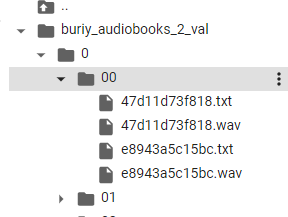

### tests

In [ ]:
from speechbrain.utils.data_utils import get_all_files, download_file
data_folder = '/content/buriy_audiobooks_2_val'
#train_folder = os.path.join(data_folder, "RuDataset", "buriy_audiobooks_2_val")
extension_audio = [".wav"]
extension_trans = [".txt"]
# List of flac audio files
wav_list = get_all_files(data_folder, match_and=extension_audio)
print(wav_list[:5])
# List of transcription file

trans_list = get_all_files(data_folder, match_and=extension_trans)
print(trans_list[:5])

['/content/buriy_audiobooks_2_val/c/e8/b450fe232aee.wav', '/content/buriy_audiobooks_2_val/c/e8/b558d164588c.wav', '/content/buriy_audiobooks_2_val/c/8f/7887d5ef47b0.wav', '/content/buriy_audiobooks_2_val/c/8f/9884db1a4817.wav', '/content/buriy_audiobooks_2_val/c/00/59087c0b175e.wav']
['/content/buriy_audiobooks_2_val/c/e8/b450fe232aee.txt', '/content/buriy_audiobooks_2_val/c/e8/b558d164588c.txt', '/content/buriy_audiobooks_2_val/c/8f/7887d5ef47b0.txt', '/content/buriy_audiobooks_2_val/c/8f/9884db1a4817.txt', '/content/buriy_audiobooks_2_val/c/00/59087c0b175e.txt']


In [ ]:
from speechbrain.dataio.dataio import read_audio
SAMPLERATE = 16000
json_dict = {}
for i, wav_file in enumerate(wav_list):
    # '/content/buriy_audiobooks_2_val/c/fa/9c733ab93c1a.wav'
    # Reading the signal (to retrieve duration in seconds)
    signal = read_audio(wav_file)
    duration = signal.shape[0] / SAMPLERATE

    # Manipulate path to get relative path and uttid
    path_parts = wav_file.split(os.path.sep)
    #uttid, _ = os.path.splitext(path_parts[-1])
    uttid = "-".join(path_parts[-3:]).replace(extension_audio[0],'')
    relative_path = os.path.join("{data_root}", *path_parts[-3:])
    print(uttid, relative_path)
    if i >3 :break

c-e8-b450fe232aee {data_root}/c/e8/b450fe232aee.wav
c-e8-b558d164588c {data_root}/c/e8/b558d164588c.wav
c-8f-7887d5ef47b0 {data_root}/c/8f/7887d5ef47b0.wav
c-8f-9884db1a4817 {data_root}/c/8f/9884db1a4817.wav
c-00-59087c0b175e {data_root}/c/00/59087c0b175e.wav


In [ ]:
trans_dict = {}
for i, trans_file in enumerate(trans_list):
    # Reading the text file
    with open(trans_file) as f:
        for line in f:
            #uttid = line.split(" ")[0]
            path_parts = trans_file.split(os.path.sep)
            uttid = "-".join(path_parts[-3:]).replace(extension_trans[0],'')
            text = line.rstrip().split(" ")[1:]
            text = " ".join(text).upper()
            trans_dict[uttid] = text
            #trans_dict[uttid] = [text, text.encode('utf-8').decode('utf-8')]
            
    if i<3: print(uttid, trans_dict[uttid])
    

c-e8-b450fe232aee РОДЯТСЯ
c-e8-b558d164588c И ТЫ ЯВНО МЛЕЕШЬ
c-8f-7887d5ef47b0 ОЩУЩЕНИЯ СОБСТВЕННОЙ КРАСОТЫ И


In [ ]:
trans_dict[uttid][0]

'ТРУДОМ НО ВОКРУГ ОРГУЛОВА В ПОСЛЕДНЕЕ ВРЕМЯ'

In [ ]:
import random
def split_sets(wav_list, split_ratio):
  # code from Speaker Recognize
    """Randomly splits the wav list into training, validation, and test lists.
    Note that a better approach is to make sure that all the classes have the
    same proportion of samples (e.g, spk01 should have 80% of samples in
    training, 10% validation, 10% test, the same for speaker2 etc.). This
    is the approach followed in some recipes such as the Voxceleb one. For
    simplicity, we here simply split the full list without necessarily respecting
    the split ratio within each class.

    Arguments
    ---------
    wav_lst : list
        list of all the signals in the dataset
    split_ratio: list
        List composed of three integers that sets split ratios for train, valid,
        and test sets, respectively. For instance split_ratio=[80, 10, 10] will
        assign 80% of the sentences to training, 10% for validation, and 10%
        for test.

    Returns
    ------
    dictionary containing train, valid, and test splits.
    """
    # Random shuffle of the list
    random.shuffle(wav_list)
    tot_split = sum(split_ratio)
    tot_snts = len(wav_list)
    data_split = {}
    splits = ["train", "valid"]

    for i, split in enumerate(splits):
        n_snts = int(tot_snts * split_ratio[i] / tot_split)
        data_split[split] = wav_list[0:n_snts]
        del wav_list[0:n_snts]
    data_split["test"] = wav_list

    return data_split
data_split = split_sets(wav_list, split_ratio=[80, 10, 10])

In [ ]:
def create_LM_data(data_split, trans_dict, save_LM_train, save_LM_valid, save_LM_test, extension_audio=['.wav']):
    """
    Creates the .txt files given a split list of wav files and their transcriptions.

    Arguments
    ---------
    data_split : train, valid, test - list of .wav files
        The list of wav files.
    trans_dict: dictionary of transcriptions
    save_LM_train, save_LM_valid, save_LM_test: str
        Paths where the LM data (txt - transcriptions) file will be saved.

    """
    print(save_LM_train, save_LM_valid, save_LM_test)
    LM_data = {"train": save_LM_train, "valid": save_LM_valid, "test": save_LM_test }
    
    #for data in data_split.keys(): # train, valid, test
    for key, data in data_split.items(): # train, valid, test
      #print (data, LM_data[data])
      print (key, LM_data[key])
      #with open(LM_data[data],'w') as f:
      with open(LM_data[key],'w') as f:
        #for i, wav_file in enumerate(data_split[data]):
        for i, wav_file in enumerate(data):
          path_parts = wav_file.split(os.path.sep)
          uttid = "-".join(path_parts[-3:]).replace(extension_audio[0],'')
          f.write(trans_dict[uttid]+'\n')
          if i<2: pass #print(wav_file); print(uttid, trans_dict[uttid])
          
      f.close()

#save_LM_train, save_LM_valid, save_LM_test = '/content/train_ru.txt', '/content/valid_ru.txt', '/content/test_ru.txt'
save_LM_train= '/content/train_ru.txt'
save_LM_valid= '/content/valid_ru.txt'
save_LM_test = '/content/test_ru.txt'
print(save_LM_train, save_LM_valid, save_LM_test)
create_LM_data(data_split, trans_dict, save_LM_train, save_LM_valid, save_LM_test,extension_audio=['.wav'])

/content/train_ru.txt /content/valid_ru.txt /content/test_ru.txt
/content/train_ru.txt /content/valid_ru.txt /content/test_ru.txt
{'train': '/content/train_ru.txt', 'valid': '/content/valid_ru.txt', 'test': '/content/test_ru.txt'}
train /content/train_ru.txt
valid /content/valid_ru.txt
test /content/test_ru.txt


In [ ]:
data_split.keys()

dict_keys(['train', 'valid', 'test'])

In [ ]:
data_folder, save_json_train, save_json_valid, save_json_test = '/content/buriy_audiobooks_2_val','/content/json_train', '/content/json_valid', '/content/json_test'
prepare_ru_dataset(
    data_folder, save_json_train, save_json_valid, save_json_test,split_ratio=[80, 10, 10],
)

In [ ]:
import os, sys
import random
import json
import shutil
import logging
from speechbrain.utils.data_utils import get_all_files, download_file
from speechbrain.dataio.dataio import read_audio

logger = logging.getLogger(__name__)
RU_DATASET_DATA_URL = 'https://azureopendatastorage.blob.core.windows.net/openstt/ru_open_stt_opus/archives/buriy_audiobooks_2_val.tar.gz'
SAMPLERATE = 16000
def download_ru_dataset(destination):
    """Download dataset and unpack it.

    Arguments
    ---------
    destination : str
        Place to put dataset.
    """
    
    data_archive = os.path.join(destination, "buriy_audiobooks_2_val.tar.gz")
    download_file(RU_DATASET_DATA_URL, data_archive)
    shutil.unpack_archive(data_archive, destination)
download_ru_dataset('/content/speechbrain/templates/speech_recognition/data')    

buriy_audiobooks_2_val.tar.gz: 496MB [00:03, 126MB/s]                            


### prepare_ru_dataset

look #[Setup & Import / prepare_ru_dataset](https://colab.research.google.com/drive/1SqJeWJcRhjv4w4yS09o1XILoaLYsRn4_?authuser=1#scrollTo=prepare_ru_dataset)

## **Step 2: Tokenizer** 
An important decision to make when designing a speech recognizer concerns the basic tokens that our system has to predict (e.g, characters, phonemes, sub-words, words).



### tokenizer_ru.yaml

In [41]:
%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/tokenizer_ru.yaml
# ############################################################################
# Training: Russian Dataset
# by original:
# Tokenizer: subword BPE tokenizer with unigram 1K
# Training: Mini-LibriSpeech
# Authors:  Abdel Heba 2021
#           Mirco Ravanelli 2021
# ############################################################################


# Set up folders for reading from and writing to
data_folder: ../data
# data_folder: /content/buriy_audiobooks_2_val
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val
output_folder: ./save

# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt


# Tokenizer parameters
token_type: unigram  # ["unigram", "bpe", "char"]
token_output: 1000  # index(blank/eos/bos/unk) = 0
character_coverage: 1.0
annotation_read: words # field to read

# Tokenizer object
tokenizer: !name:speechbrain.tokenizers.SentencePiece.SentencePiece
   model_dir: !ref <output_folder>
   vocab_size: !ref <token_output>
   annotation_train: !ref <train_annotation>
   annotation_read: !ref <annotation_read>
   model_type: !ref <token_type> # ["unigram", "bpe", "char"]
   character_coverage: !ref <character_coverage>
   annotation_list_to_check: [!ref <train_annotation>, !ref <valid_annotation>]
   annotation_format: json


Overwriting /content/speechbrain/templates/speech_recognition/Tokenizer/tokenizer_ru.yaml


### Tokenizer/train_ru.py

In [42]:
%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/train_ru.py
#!/usr/bin/env/python3
"""Script for training a BPE tokenizer on the top of CSV or JSON annotation files.
The tokenizer converts words into sub-word units that can be used to train a
language (LM) or an acoustic model (AM).
When doing a speech recognition experiment you have to make
sure that the acoustic and language models are trained with
the same tokenizer. Otherwise, a token mismatch is introduced
and beamsearch will produce bad results when combining AM and LM.

To run this recipe, do the following:
> python train_ru.py tokenizer_ru.yaml


Authors
 * Abdel Heba 2021
 * Mirco Ravanelli 2021
"""

import sys
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
#from mini_librispeech_prepare import prepare_mini_librispeech
from prepare_ru_dataset import prepare_ru_dataset

if __name__ == "__main__":

    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Data preparation, to be run on only one process.
    prepare_ru_dataset(
        data_folder=hparams["data_folder"],
        data_folder_dataset=hparams["data_folder_dataset"],
        save_json_train=hparams["train_annotation"],
        save_json_valid=hparams["valid_annotation"],
        save_json_test=hparams["test_annotation"],
        save_LM_train = hparams["lm_train_data"],
        save_LM_valid = hparams["lm_valid_data"],
        save_LM_test = hparams["lm_test_data"],
        split_ratio=[80, 10, 10],

    )

    # Train tokenizer
    hparams["tokenizer"]()


Overwriting /content/speechbrain/templates/speech_recognition/Tokenizer/train_ru.py


### Train Tokenizer

In [43]:
%%time
%cd /content/speechbrain/templates/speech_recognition/Tokenizer
#!python train.py tokenizer.yaml
! python train_ru.py tokenizer_ru.yaml

/content/speechbrain/templates/speech_recognition/Tokenizer
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: ./save
prepare_ru_dataset - Preparation completed in previous run, skipping.
speechbrain.tokenizers.SentencePiece - Train tokenizer with type:unigram
speechbrain.tokenizers.SentencePiece - Extract words sequences from:../train_ru.json
speechbrain.tokenizers.SentencePiece - Text file created at: ../train_ru.txt
sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=../train_ru.txt --model_prefix=./save/1000_unigram --model_type=unigram --bos_id=-1 --eos_id=-1 --pad_id=-1 --unk_id=0 --max_sentencepiece_length=10 --character_coverage=1.0 --add_dummy_prefix=True --vocab_size=1000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ../train_ru.txt
  input_format: 
  model_prefix: ./save/1000_unigram
  model_type: UNIGRAM
  vocab_size: 1000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_siz

#### Look json-files & LM.txt-files

In [ ]:
import json
with open('/content/speechbrain/templates/speech_recognition/train_ru.json') as json_file:
#with open('/content/train.json') as json_file:
  t = json.load(json_file)
  print(list(t.items())[:3])
  len_train = len(t.keys())

with open('/content/speechbrain/templates/speech_recognition/valid_ru.json') as json_file:
  v = json.load(json_file)
  print(list(v.items())[:3])
  len_valid = len(v.keys())
with open('/content/speechbrain/templates/speech_recognition/test_ru.json') as json_file:
  t1 = json.load(json_file)
  print(list(t1.items())[:3])
  len_test = len(t1.keys())

print(f"Records: train - {len_train}, valid - {len_valid}, test - {len_test},")


[('6-01-61d00e6266be', {'wav': '{data_root}/6/01/61d00e6266be.wav', 'length': 1.22, 'words': 'ЭВАКУАЦИИ'}), ('4-11-ade8cc8dcb33', {'wav': '{data_root}/4/11/ade8cc8dcb33.wav', 'length': 0.82, 'words': 'ЖЕНЩИНЕ БЫЛО'}), ('9-bb-62d95161b919', {'wav': '{data_root}/9/bb/62d95161b919.wav', 'length': 1.1, 'words': 'ХОТЕЛ'})]
[('3-15-31e4febaa45c', {'wav': '{data_root}/3/15/31e4febaa45c.wav', 'length': 2.04, 'words': 'ЭТО ЗНАЮ И ТЕБЯ'}), ('4-d0-8415bf7b930e', {'wav': '{data_root}/4/d0/8415bf7b930e.wav', 'length': 1.04, 'words': 'НЕСЕТ ЧУШЬ'}), ('8-8b-dc88b352462b', {'wav': '{data_root}/8/8b/dc88b352462b.wav', 'length': 1.55, 'words': 'ИЛИ РАБОЧИЙ'})]
[('f-ed-4170869f899e', {'wav': '{data_root}/f/ed/4170869f899e.wav', 'length': 2.63, 'words': 'ТОНКО СДЕЛАНО ПРОБОРМОТАЛ ОН'}), ('0-0c-c96e61a28783', {'wav': '{data_root}/0/0c/c96e61a28783.wav', 'length': 2.09, 'words': 'ГИТЛЕР СКАЗАЛ ШТИРЛИЦ'}), ('d-e9-ac2ee6d60975', {'wav': '{data_root}/d/e9/ac2ee6d60975.wav', 'length': 1.32, 'words': 'ГРАНАТОМЁТ

In [ ]:
!head -3 /content/speechbrain/templates/speech_recognition/LM/data/train_ru.txt


ЭВАКУАЦИИ
ЖЕНЩИНЕ БЫЛО


### SentencePiece

In [ ]:
import torch
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
sp.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/1000_unigram.model")

# Encode as pieces
print(sp.encode_as_pieces('THE CITY OF MONTREAL'))
print(sp.encode_as_ids('THE CITY OF MONTREAL'))

# Encode as ids
print(sp.encode_as_pieces('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))
print(sp.encode_as_ids('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))


['▁', 'THE', '▁', 'CITY', '▁', 'OF', '▁', 'MONTREAL']
[1, 0, 1, 0, 1, 0, 1, 0]
['▁ИЗ', '▁СТОРОН', 'Ы', '▁В', '▁СТОРОН', 'У', '▁О', 'Щ', 'УЩЕ', 'НИЕ', '▁КОТОРОГО', '▁ОН', '▁НИКОГДА']
[75, 398, 36, 8, 398, 9, 38, 999, 492, 243, 618, 48, 585]


## **Step 3: Train a Language Model**
A Language Model (LM) can be used within a speech recognizer in different ways. 

### RNNLM_ru.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/RNNLM_ru.yaml
# ############################################################################
# Training: RuDataset transcripts
# by original:
# Model: Language model with a recurrent neural network (RNNLM)
# Training: mini-librispeech transcripts
# Authors:  Ju-Chieh Chou 2020, Jianyuan Zhong 2021, Mirco Ravanelli 2021
# ############################################################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 2602
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/RNNLM/
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# If you plan to train a system on an HPC cluster with a big dataset,
# we strongly suggest doing the following:
# 1- Compress the dataset in a single tar or zip file.
# 2- Copy your dataset locally (i.e., the local disk of the computing node).
# 3- Uncompress the dataset in the local folder.
# 4- Set lm_{train,valid,test}_data with the local path.
# Reading data from the local disk of the compute node (e.g. $SLURM_TMPDIR with SLURM-based clusters) is very important.
# It allows you to read the data much faster without slowing down the shared filesystem.
lm_train_data: data/train_ru.txt
lm_valid_data: data/valid_ru.txt
lm_test_data: data/test_ru.txt

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Tokenizer model (you must use the same tokenizer for LM and ASR training)
tokenizer_file: ../Tokenizer/save/1000_unigram.model

# Training parameters
number_of_epochs: 20
batch_size: 80
lr: 0.001
accu_steps: 1 # Gradient accumulation to simulate large batch training
ckpt_interval_minutes: 15 # save checkpoint every N min

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

# Model parameters
#emb_dim: 256 # dimension of the embeddings - дальше в ASR модели используется 128
emb_dim: 128 # dimension of the embeddings
rnn_size: 512 # dimension of hidden layers
layers: 2 # number of hidden layers

# Outputs
output_neurons: 1000 # index(blank/eos/bos) = 0
blank_index: 0
bos_index: 0
eos_index: 0


# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined..
#model: !new:templates.speech_recognition.LM.custom_model.CustomModel # error not found custom_model.py
model: !new:custom_model.CustomModel
    embedding_dim: !ref <emb_dim>
    rnn_size: !ref <rnn_size>
    layers: !ref <layers>


# Cost function used for training the model
compute_cost: !name:speechbrain.nnet.losses.nll_loss

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    betas: (0.9, 0.98)
    eps: 0.000000001

# This function manages learning rate annealing over the epochs.
# We here use the NewBoB algorithm, that anneals the learning rate if
# the improvements over two consecutive epochs is less than the defined
# threshold.
lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0


# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    model: !ref <model>

# Tokenizer initialization
tokenizer: !new:sentencepiece.SentencePieceProcessor

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        scheduler: !ref <lr_annealing>
        counter: !ref <epoch_counter>

# Pretrain the tokenizer
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        tokenizer: !ref <tokenizer>
    paths:
        tokenizer: !ref <tokenizer_file>


Writing /content/speechbrain/templates/speech_recognition/LM/RNNLM_ru.yaml


### LM/train_ru.py

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/train_ru.py
#!/usr/bin/env python3
"""

by original:
Recipe for training a language model with a given text corpus.

> python train.py RNNLM.yaml

To run this recipe, you need to first install the Huggingface dataset:
> pip install datasets


Authors
 * Ju-Chieh Chou 2020
 * Jianyuan Zhong 2021
 * Mirco Ravanelli 2021
"""
import sys
import logging
import torch
from datasets import load_dataset
from hyperpyyaml import load_hyperpyyaml
import speechbrain as sb


logger = logging.getLogger(__name__)


# Brain class for language model training
class LM(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Predicts the next word given the previous ones.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : torch.Tensor
            A tensor containing the posterior probabilities (predictions).
        """
        batch = batch.to(self.device)
        tokens_bos, _ = batch.tokens_bos
        pred = self.hparams.model(tokens_bos)
        return pred

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : torch.Tensor
            The posterior probabilities from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        batch = batch.to(self.device)
        tokens_eos, tokens_len = batch.tokens_eos
        loss = self.hparams.compute_cost(
            predictions, tokens_eos, length=tokens_len
        )
        return loss

    def fit_batch(self, batch):
        """Runs all the steps needed to train the model on a single batch.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.

        Returns
        -------
        Loss : torch.Tensor
            A tensor containing the loss (single real number).
        """
        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)

        # Loss backpropagation (gradient computation)
        (loss / self.hparams.accu_steps).backward()

        # Manage gradient accumulation
        if self.step % self.hparams.accu_steps == 0:

            # Gradient clipping & early stop if loss is not fini
            self.check_gradients(loss)

            # Update the parameters
            self.optimizer.step()

            # Reset the gradient
            self.optimizer.zero_grad()

            if isinstance(
                self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
            ) or isinstance(
                self.hparams.lr_annealing,
                sb.nnet.schedulers.CyclicCosineScheduler,
            ):
                self.hparams.lr_annealing(self.optimizer)

        return loss

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
            }

        # At the end of validation, we can wrote
        if stage == sb.Stage.VALID:

            # Update learning rate
            old_lr, new_lr = self.hparams.lr_annealing(stage_loss)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints.
            self.checkpointer.save_and_keep_only(meta=stats, min_keys=["loss"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.

    The language model is trained with the text files specified by the user in
    the hyperparameter file.

    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : list
        List containing "train", "valid", and "test" sets that correspond
        to the appropriate DynamicItemDataset object.
    """

    logging.info("generating datasets...")

    # Prepare datasets
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["lm_train_data"],
            "valid": hparams["lm_valid_data"],
            "test": hparams["lm_test_data"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"]
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["valid"]
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"]
    )

    datasets = [train_data, valid_data, test_data]
    tokenizer = hparams["tokenizer"]

    # Define text processing pipeline. We start from the raw text and then
    # encode it using the tokenizer. The tokens with bos are used for feeding
    # the neural network, the tokens with eos for computing the cost function.
    @sb.utils.data_pipeline.takes("text")
    @sb.utils.data_pipeline.provides("text", "tokens_bos", "tokens_eos")
    def text_pipeline(text):
        yield text
        tokens_list = tokenizer.encode_as_ids(text)
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set outputs to add into the batch. The batch variable will contain
    # all these fields (e.g, batch.id, batch.text, batch.tokens.bos,..)
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "text", "tokens_bos", "tokens_eos"],
    )
    return train_data, valid_data, test_data


# Recipe begins!
if __name__ == "__main__":

    # Reading command line arguments
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Create dataset objects "train", "valid", and "test"
    train_data, valid_data, test_data = dataio_prepare(hparams)

    # Initialize the Brain object to prepare for LM training.
    lm_brain = LM(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    lm_brain.fit(
        lm_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # Load best checkpoint for evaluation
    test_stats = lm_brain.evaluate(
        test_data,
        min_key="loss",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )


Writing /content/speechbrain/templates/speech_recognition/LM/train_ru.py


In [ ]:
!du -sh /content/speechbrain/templates/speech_recognition/LM/data/*_ru.txt

40K	/content/speechbrain/templates/speech_recognition/LM/data/test_ru.txt
304K	/content/speechbrain/templates/speech_recognition/LM/data/train_ru.txt
36K	/content/speechbrain/templates/speech_recognition/LM/data/valid_ru.txt


### don't see

In [ ]:
###
# to avoid the error "ImportError: There is no such class as templates.speech_recognition.LM.custom_model.CustomModel"
# 1. or changhe in '/content/speechbrain/templates/speech_recognition/LM/RNNLM.yaml'
# model: !new:templates.speech_recognition.LM.custom_model.CustomModel 
# to
# model: !new:custom_model.CustomModel
#
# or 2. run code below
import sys
new_path = "/content/speechbrain"
if not new_path in sys.path:
  sys.path.append(new_path)
else:
  print(f"'{new_path}' is already exist in $PATH")

In [ ]:
from hyperpyyaml import load_hyperpyyaml
hparams_file = "/content/speechbrain/templates/speech_recognition/LM/RNNLM_ru.yaml"
with open(hparams_file) as fin:
    hparams = load_hyperpyyaml(fin )
    print(hparams["model"])
#dump_hyperpyyaml    

### Train LM - Baseline

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
if torch.cuda.is_available(): 
    !python train_ru.py RNNLM_ru.yaml #--device='cpu'
else:
  !python train_ru.py RNNLM_ru.yaml --device='cpu'

/content/speechbrain/templates/speech_recognition/LM
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/RNNLM/
root - generating datasets...
datasets.builder - Using custom data configuration default-80c4d19bdb7b7544
Extracting data files: 100% 3/3 [00:00<00:00, 1166.27it/s]
Dataset text downloaded and prepared to /root/.cache/huggingface/datasets/text/default-80c4d19bdb7b7544/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8. Subsequent calls will reuse this data.
100% 3/3 [00:00<00:00, 498.65it/s]
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 4.1M trainable parameters in LM
speechbrain.utils.checkpoints - Would load a checkpoint here, but none found yet.
speechbrain.utils.epoch_loop - Going into epoch 1
100% 79/79 [00:07<00:00, 10.96it/s, train_loss=0.637]
100% 785/785 [00:01<00:00, 555.62it/s]
speechbrain.utils.train_logger - Epoch: 1 - train loss: 6.37e-01 - valid loss: 0.00e+0

### Save pretrained models: Tokenizer, LM  

In [ ]:
# copy pretrained models Tokenizer LM
!mkdir /content/pretrained_models
!cp /content/speechbrain/templates/speech_recognition/Tokenizer/save/1000_unigram.model /content/pretrained_models/
!cp /content/speechbrain/templates/speech_recognition/Tokenizer/save/1000_unigram.vocab /content/pretrained_models/
#!cp /content/speechbrain/templates/speech_recognition/LM/results/RNNLM/save/CKPT+2022-05-11+08-45-28+00/model.ckpt /content/pretrained_model/lm.ckpt
#!cp /content/speechbrain/templates/speech_recognition/LM/results/RNNLM/save/CKPT*/model.ckpt /content/pretrained_model/lm.ckpt

cp: cannot create regular file '/content/pretrained_model/lm.ckpt': No such file or directory


In [ ]:
!cp -r /content/speechbrain/templates/speech_recognition/LM/results/RNNLM/save/CKPT+2022-05-11+12-52-40+00/model.ckpt /content/pretrained_models/lm.ckpt

In [ ]:
!du -sh /content/pretrained_models/*

252K	/content/pretrained_models/1000_unigram.model
20K	/content/pretrained_models/1000_unigram.vocab
16M	/content/pretrained_models/lm.ckpt


In [ ]:
!cp -r /content/pretrained_model "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/BaseLine_02_01_ru_dataset/"

### Train RNN LM with correct pipeline

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
if torch.cuda.is_available(): 
    #!python train_ru.py TransformerLM_ru.yaml #--device='cpu'
    !python train_ru.py RNNLM_ru.yaml --number_of_epochs=3 #--device='cpu'
else:
    #!python train_ru.py TransformerLM_ru.yaml --device='cpu'
    !python train_ru.py RNNLM_ru.yaml --number_of_epochs=20 --device='cpu'
# успевает за 3 эпохи    

/content/speechbrain/templates/speech_recognition/LM
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/RNNLM/
root - generating datasets...
datasets.builder - Using custom data configuration default-154bacd49700870a
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-154bacd49700870a/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 849.22it/s]
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 2.8M trainable parameters in LM
speechbrain.utils.checkpoints - Would load a checkpoint here, but none found yet.
speechbrain.utils.epoch_loop - Going into epoch 1
100% 79/79 [01:11<00:00,  1.11it/s, train_loss=7.03]
100% 785/785 [00:03<00:00, 259.25it/s]
speechbrain.utils.train_logger - Epoch: 1 - train loss: 7.03 - valid loss: 6.09
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/RNNLM/save/CKPT+2022-05-15+1

## **Step 4: Speech Recognizer**
At this point, we can train our speech recognizer. In this tutorial, we are
going to train an **attention-based end-to-end speech recognizer** (offline).
The encoder relies on a combination of convolutional, recurrent, and fully connected models. The decoder is an autoregressive GRU decoder. An attention mechanism is employed between encoding and decoder. The final sequence of words is retrieved with beamsearch coupled with the RNNLM trained in the previous step. 
The attention-based system is jointly trained with CTC (applied on the top of the encoder).
The system uses data augmentation techniques to improve its performance.

### **Train the speech recognizer**
To train the speech recognizer, run the following code:

### ASR/train_ru.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_ru.yaml
# by original:
# ############################################################################
# Model: E2E ASR with attention-based ASR
# Encoder: CRDNN
# Decoder: GRU + beamsearch + RNNLM
# Tokens: 1000 BPE
# losses: CTC+ NLL
# Training: mini-librispeech
# Pre-Training: librispeech 960h
# Authors:  Ju-Chieh Chou, Mirco Ravanelli, Abdel Heba, Peter Plantinga, Samuele Cornell 2020
# # ############################################################################

# Seed needs to be set at top of yaml, before objects with parameters are instantiated
seed: 2602
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# If you plan to train a system on an HPC cluster with a big dataset,
# we strongly suggest doing the following:
# 1- Compress the dataset in a single tar or zip file.
# 2- Copy your dataset locally (i.e., the local disk of the computing node).
# 3- Uncompress the dataset in the local folder.
# 4- Set data_folder with the local path
# Reading data from the local disk of the compute node (e.g. $SLURM_TMPDIR with SLURM-based clusters) is very important.
# It allows you to read the data much faster without slowing down the shared filesystem.

data_folder: ../data # In this case, data will be automatically downloaded here.
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val
# /content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val
data_folder_rirs: !ref <data_folder> # noise/ris dataset will automatically be downloaded here
output_folder: !ref results/CRDNN_BPE_960h_LM/<seed>
wer_file: !ref <output_folder>/wer.txt
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt


# Path where data manifest files will be stored. The data manifest files are created by the
# data preparation script
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Training parameters
number_of_epochs: 15 #2
number_of_ctc_epochs: 5 #1
batch_size: 8
lr: 1.0
ctc_weight: 0.5
sorting: ascending
ckpt_interval_minutes: 15 # save checkpoint every N min
label_smoothing: 0.1

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>

valid_dataloader_opts:
    batch_size: !ref <batch_size>

test_dataloader_opts:
    batch_size: !ref <batch_size>


# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 40

# Model parameters
activation: !name:torch.nn.LeakyReLU
dropout: 0.15
cnn_blocks: 2
cnn_channels: (128, 256)
inter_layer_pooling_size: (2, 2)
cnn_kernelsize: (3, 3)
time_pooling_size: 4
rnn_class: !name:speechbrain.nnet.RNN.LSTM
rnn_layers: 4
rnn_neurons: 1024
rnn_bidirectional: True
dnn_blocks: 2
dnn_neurons: 512
emb_size: 128
dec_neurons: 1024
output_neurons: 1000  # Number of tokens (same as LM)
blank_index: 0
bos_index: 0
eos_index: 0
unk_index: 0

# Decoding parameters
min_decode_ratio: 0.0
max_decode_ratio: 1.0
valid_beam_size: 8
test_beam_size: 80
eos_threshold: 1.5
using_max_attn_shift: True
max_attn_shift: 240
lm_weight: 0.50
ctc_weight_decode: 0.0
coverage_penalty: 1.5
temperature: 1.25
temperature_lm: 1.25

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

# Feature normalization (mean and std)
normalize: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

# Added noise and reverb come from OpenRIR dataset, automatically
# downloaded and prepared with this Environmental Corruption class.
env_corrupt: !new:speechbrain.lobes.augment.EnvCorrupt
    openrir_folder: !ref <data_folder_rirs>
    babble_prob: 0.0
    reverb_prob: 0.0
    noise_prob: 1.0
    noise_snr_low: 0
    noise_snr_high: 15

# Adds speech change + time and frequency dropouts (time-domain implementation).
augmentation: !new:speechbrain.lobes.augment.TimeDomainSpecAugment
    sample_rate: !ref <sample_rate>
    speeds: [95, 100, 105]

# The CRDNN model is an encoder that combines CNNs, RNNs, and DNNs.
encoder: !new:speechbrain.lobes.models.CRDNN.CRDNN                   # for train
#encoder: !new:speechbrain.nnet.containers.LengthsCapableSequential    # for inference
    input_shape: [null, null, !ref <n_mels>]
    activation: !ref <activation>
    dropout: !ref <dropout>
    cnn_blocks: !ref <cnn_blocks>
    cnn_channels: !ref <cnn_channels>
    cnn_kernelsize: !ref <cnn_kernelsize>
    inter_layer_pooling_size: !ref <inter_layer_pooling_size>
    time_pooling: True
    using_2d_pooling: False
    time_pooling_size: !ref <time_pooling_size>
    rnn_class: !ref <rnn_class>
    rnn_layers: !ref <rnn_layers>
    rnn_neurons: !ref <rnn_neurons>
    rnn_bidirectional: !ref <rnn_bidirectional>
    rnn_re_init: True
    dnn_blocks: !ref <dnn_blocks>
    dnn_neurons: !ref <dnn_neurons>
    use_rnnp: False

# Embedding (from indexes to an embedding space of dimension emb_size).
embedding: !new:speechbrain.nnet.embedding.Embedding
    num_embeddings: !ref <output_neurons>
    embedding_dim: !ref <emb_size>

# Attention-based RNN decoder.
decoder: !new:speechbrain.nnet.RNN.AttentionalRNNDecoder
    enc_dim: !ref <dnn_neurons>
    input_size: !ref <emb_size>
    rnn_type: gru
    attn_type: location
    hidden_size: !ref <dec_neurons>
    attn_dim: 1024
    num_layers: 1
    scaling: 1.0
    channels: 10
    kernel_size: 100
    re_init: True
    dropout: !ref <dropout>

# Linear transformation on the top of the encoder.
ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dnn_neurons>
    n_neurons: !ref <output_neurons>

# Linear transformation on the top of the decoder.
seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dec_neurons>
    n_neurons: !ref <output_neurons>

# Final softmax (for log posteriors computation).
log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

# Cost definition for the CTC part.
ctc_cost: !name:speechbrain.nnet.losses.ctc_loss
    blank_index: !ref <blank_index>


# Tokenizer initialization
tokenizer: !new:sentencepiece.SentencePieceProcessor

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class
modules:
    encoder: !ref <encoder>
    embedding: !ref <embedding>
    decoder: !ref <decoder>
    ctc_lin: !ref <ctc_lin>
    seq_lin: !ref <seq_lin>
    normalize: !ref <normalize>
    env_corrupt: !ref <env_corrupt>
    lm_model: !ref <lm_model>

# Gathering all the submodels in a single model object.
model: !new:torch.nn.ModuleList
    - - !ref <encoder>
      - !ref <embedding>
      - !ref <decoder>
      - !ref <ctc_lin>
      - !ref <seq_lin>

# This is the RNNLM that is used according to the Huggingface repository
# NB: It has to match the pre-trained RNNLM!!
lm_model: !new:speechbrain.lobes.models.RNNLM.RNNLM
    output_neurons: !ref <output_neurons>
    embedding_dim: !ref <emb_size>
    activation: !name:torch.nn.LeakyReLU
    dropout: 0.0
    rnn_layers: 2
    rnn_neurons: 2048
    dnn_blocks: 1
    dnn_neurons: 512
    return_hidden: True  # For inference

###########################################################################
# in LM.yaml
#emb_dim: 128 # dimension of the embeddings -> ok!
#rnn_size: 512 # dimension of hidden layers -> ok!
#layers: 2 # number of hidden layers

# Outputs
#output_neurons: 1000 # index(blank/eos/bos) = 0
#blank_index: 0
#bos_index: 0
#eos_index: 0
#model: !new:custom_model.CustomModel
    #embedding_dim: !ref <emb_dim>
    #rnn_size: !ref <rnn_size>
    #layers: !ref <layers>
###########################################################################

# Beamsearch is applied on the top of the decoder. If the language model is
# given, a language model is applied (with a weight specified in lm_weight).
# If ctc_weight is set, the decoder uses CTC + attention beamsearch. This
# improves the performance, but slows down decoding. For a description of
# the other parameters, please see the speechbrain.decoders.S2SRNNBeamSearchLM.

# It makes sense to have a lighter search during validation. In this case,
# we don't use the LM and CTC probabilities during decoding.
valid_search: !new:speechbrain.decoders.S2SRNNBeamSearcher
    embedding: !ref <embedding>
    decoder: !ref <decoder>
    linear: !ref <seq_lin>
    ctc_linear: !ref <ctc_lin>
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <valid_beam_size>
    eos_threshold: !ref <eos_threshold>
    using_max_attn_shift: !ref <using_max_attn_shift>
    max_attn_shift: !ref <max_attn_shift>
    coverage_penalty: !ref <coverage_penalty>
    temperature: !ref <temperature>

# The final decoding on the test set can be more computationally demanding.
# In this case, we use the LM + CTC probabilities during decoding as well.
# Please, remove this part if you need a faster decoder.
test_search: !new:speechbrain.decoders.S2SRNNBeamSearchLM
    embedding: !ref <embedding>
    decoder: !ref <decoder>
    linear: !ref <seq_lin>
    ctc_linear: !ref <ctc_lin>
    language_model: !ref <lm_model>
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <test_beam_size>
    eos_threshold: !ref <eos_threshold>
    using_max_attn_shift: !ref <using_max_attn_shift>
    max_attn_shift: !ref <max_attn_shift>
    coverage_penalty: !ref <coverage_penalty>
    lm_weight: !ref <lm_weight>
    ctc_weight: !ref <ctc_weight_decode>
    temperature: !ref <temperature>
    temperature_lm: !ref <temperature_lm>

# This function manages learning rate annealing over the epochs.
# We here use the NewBoB algorithm, that anneals the learning rate if
# the improvements over two consecutive epochs is less than the defined
# threshold.
lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adadelta
    lr: !ref <lr>
    rho: 0.95
    eps: 1.e-8

# Functions that compute the statistics to track during the validation step.
error_rate_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats

cer_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats
    split_tokens: True

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        scheduler: !ref <lr_annealing>
        normalize: !ref <normalize>
        counter: !ref <epoch_counter>

# Language model (LM) pretraining
# NB: To avoid mismatch, the speech recognizer must be trained with the same
# tokenizer used for LM training. Here, we download everything from the
# speechbrain HuggingFace repository. However, a local path pointing to a
# directory containing the lm.ckpt and tokenizer.ckpt may also be specified
# instead. E.g if you want to use your own LM / tokenizer.

#pretrained_path: speechbrain/asr-crdnn-rnnlm-librispeech
pretrained_path: AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val
pretrained_path_local: /content/pretrained_models

# This object is used to pretrain the language model and the tokenizers
# (defined above). In this case, we also pretrain the ASR model (to make
# sure the model converges on a small amount of data)

tokenizer_file: ../Tokenizer/save/1000_unigram.model
LM_chkpt_path: /content/speechbrain/templates/speech_recognition/LM/results/RNNLM/save/CKPT+2022-05-11+08-11-11+00

pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>
        model: !ref <model>
        normalize: !ref <normalize>
    paths:
        #lm: !ref <pretrained_path>/lm.ckpt
        #lm: !ref <pretrained_path_local>/lm.ckpt
        lm: !ref <pretrained_path>/lm.ckpt
        #tokenizer: !ref <pretrained_path>/tokenizer.ckpt
        #tokenizer: !ref <tokenizer_file>
        #tokenizer: !ref <pretrained_path_local>/1000_unigram.model
        #tokenizer: !ref <pretrained_path_local>/tokenizer.ckpt
        tokenizer: !ref <pretrained_path>/tokenizer.ckpt
        model: !ref <pretrained_path>/asr.ckpt #after 9 ep training
        normalize: !ref <pretrained_path>/normalizer.ckpt 
#### warnings....  ######################
# During parameter transfer to RNNLM(
# ...
# the transferred parameters did not have parameters for the key:
# rnn.rnn.weight_ih_l0
# rnn.rnn.weight_hh_l0
# rnn.rnn.bias_ih_l0
# rnn.rnn.bias_hh_l0
# rnn.rnn.weight_ih_l1
# rnn.rnn.weight_hh_l1
# rnn.rnn.bias_ih_l1
# rnn.rnn.bias_hh_l1
# dnn.linear.w.weight
# dnn.linear.w.bias
# dnn.norm.norm.weight
# dnn.norm.norm.bias
# rnn.weight_ih_l0
# rnn.weight_hh_l0
# rnn.bias_ih_l0
# rnn.bias_hh_l0
# rnn.weight_ih_l1
# rnn.weight_hh_l1
# rnn.bias_ih_l1
# rnn.bias_hh_l1


Overwriting /content/speechbrain/templates/speech_recognition/ASR/train_ru.yaml


### ASR/hyperparams.yaml - for inference

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml
# by HuggingFace
# ############################################################################
# Model: E2E ASR with attention-based ASR
# Encoder: CRDNN model
# Decoder: GRU + beamsearch + RNNLM
# Tokens: BPE with unigram
# Authors:  Ju-Chieh Chou, Mirco Ravanelli, Abdel Heba, Peter Plantinga 2020
# ############################################################################


# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 40

# Model parameters
activation: !name:torch.nn.LeakyReLU
dropout: 0.15
cnn_blocks: 2
cnn_channels: (128, 256)
inter_layer_pooling_size: (2, 2)
cnn_kernelsize: (3, 3)
time_pooling_size: 4
rnn_class: !name:speechbrain.nnet.RNN.LSTM
rnn_layers: 4
rnn_neurons: 1024
rnn_bidirectional: True
dnn_blocks: 2
dnn_neurons: 512
emb_size: 128
dec_neurons: 1024
output_neurons: 1000  # index(blank/eos/bos) = 0
blank_index: 0

# Decoding parameters
bos_index: 0
eos_index: 0
min_decode_ratio: 0.0
max_decode_ratio: 1.0
beam_size: 80
eos_threshold: 1.5
using_max_attn_shift: True
max_attn_shift: 240
lm_weight: 0.50
coverage_penalty: 1.5
temperature: 1.25
temperature_lm: 1.25

normalizer: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

enc: !new:speechbrain.lobes.models.CRDNN.CRDNN
    input_shape: [null, null, !ref <n_mels>]
    activation: !ref <activation>
    dropout: !ref <dropout>
    cnn_blocks: !ref <cnn_blocks>
    cnn_channels: !ref <cnn_channels>
    cnn_kernelsize: !ref <cnn_kernelsize>
    inter_layer_pooling_size: !ref <inter_layer_pooling_size>
    time_pooling: True
    using_2d_pooling: False
    time_pooling_size: !ref <time_pooling_size>
    rnn_class: !ref <rnn_class>
    rnn_layers: !ref <rnn_layers>
    rnn_neurons: !ref <rnn_neurons>
    rnn_bidirectional: !ref <rnn_bidirectional>
    rnn_re_init: True
    dnn_blocks: !ref <dnn_blocks>
    dnn_neurons: !ref <dnn_neurons>

emb: !new:speechbrain.nnet.embedding.Embedding
    num_embeddings: !ref <output_neurons>
    embedding_dim: !ref <emb_size>

dec: !new:speechbrain.nnet.RNN.AttentionalRNNDecoder
    enc_dim: !ref <dnn_neurons>
    input_size: !ref <emb_size>
    rnn_type: gru
    attn_type: location
    hidden_size: !ref <dec_neurons>
    attn_dim: 1024
    num_layers: 1
    scaling: 1.0
    channels: 10
    kernel_size: 100
    re_init: True
    dropout: !ref <dropout>

ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dnn_neurons>
    n_neurons: !ref <output_neurons>

seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dec_neurons>
    n_neurons: !ref <output_neurons>

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

lm_model: !new:speechbrain.lobes.models.RNNLM.RNNLM
    output_neurons: !ref <output_neurons>
    embedding_dim: !ref <emb_size>
    activation: !name:torch.nn.LeakyReLU
    dropout: 0.0
    rnn_layers: 2
    rnn_neurons: 2048
    dnn_blocks: 1
    dnn_neurons: 512
    return_hidden: True  # For inference

tokenizer: !new:sentencepiece.SentencePieceProcessor

asr_model: !new:torch.nn.ModuleList
    - [!ref <enc>, !ref <emb>, !ref <dec>, !ref <ctc_lin>, !ref <seq_lin>]

# We compose the inference (encoder) pipeline.
encoder: !new:speechbrain.nnet.containers.LengthsCapableSequential
    input_shape: [null, null, !ref <n_mels>]
    compute_features: !ref <compute_features>
    normalizer: !ref <normalizer>
    model: !ref <enc>

decoder: !new:speechbrain.decoders.S2SRNNBeamSearchLM
    embedding: !ref <emb>
    decoder: !ref <dec>
    linear: !ref <seq_lin>
    language_model: !ref <lm_model>
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <beam_size>
    eos_threshold: !ref <eos_threshold>
    using_max_attn_shift: !ref <using_max_attn_shift>
    max_attn_shift: !ref <max_attn_shift>
    coverage_penalty: !ref <coverage_penalty>
    lm_weight: !ref <lm_weight>
    temperature: !ref <temperature>
    temperature_lm: !ref <temperature_lm>


modules: 
    normalizer: !ref <normalizer>
    encoder: !ref <encoder>
    decoder: !ref <decoder>
    lm_model: !ref <lm_model>

pretrained_path: AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val
#pretrained_path_local: /content/pretrained_models
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        normalizer: !ref <normalizer>
        asr: !ref <asr_model>
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>
    paths:
        lm: !ref <pretrained_path>/lm.ckpt
        #tokenizer: !ref <pretrained_path>/1000_unigram.model
        tokenizer: !ref <pretrained_path>/tokenizer.ckpt
        asr: !ref <pretrained_path>/asr.ckpt
        normalizer: !ref <pretrained_path>/normalizer.ckpt



Overwriting /content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml


### ASR/train_ru.py

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_ru.py
#!/usr/bin/env/python3
# by original:
"""Recipe for training a sequence-to-sequence ASR system with mini-librispeech.
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with beam search coupled with a neural
language model.

To run this recipe, do the following:
> python train.py train.yaml

With the default hyperparameters, the system employs an LSTM encoder.
The decoder is based on a standard  GRU. Beam search coupled with an RNN language
model is used on the top of decoder probabilities.

The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens. Training is performed on the mini-librispeech
dataset. Note that this is a tiny dataset used here just to
provide a working example. To achieve a better performance you have to train with
larger datasets, such as the full LibriSpeech one. In this case, to allow the
model to converge, we pre-train it with a bigger one (trained on the full librispeech
with the seq2seq 1k BPE recipe).

The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE).

This recipe assumes that the tokenizer and the LM are already trained.
To avoid token mismatches, the tokenizer used for the acoustic model is
the same use for the LM.  The recipe downloads the pre-trained tokenizer
and LM.

If you would like to train a full system from scratch do the following:
1- Train a tokenizer (see ../Tokenizer)
2- Train a language model (see ../LM)
3- Train the speech recognizer (with this code).


Authors
 * Mirco Ravanelli 2020
 * Ju-Chieh Chou 2020
 * Abdel Heba 2020
 * Peter Plantinga 2020
 * Samuele Cornell 2020
"""

import os
import sys
import torch
import logging
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
#from mini_librispeech_prepare import prepare_mini_librispeech
from prepare_ru_dataset import prepare_ru_dataset
from speechbrain.utils.data_utils import download_file
from speechbrain.utils.distributed import run_on_main

logger = logging.getLogger(__name__)


# Brain class for speech recognition training
class ASR(sb.Brain):
    def compute_forward(self, batch, stage):
        """Runs all the computation of the CTC + seq2seq ASR. It returns the
        posterior probabilities of the CTC and seq2seq networks.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : dict
            At training time it returns predicted seq2seq log probabilities.
            If needed it also returns the ctc output log probabilities.
            At validation/test time, it returns the predicted tokens as well.
        """
        # We first move the batch to the appropriate device.
        batch = batch.to(self.device)
        feats, self.feat_lens = self.prepare_features(stage, batch.sig)
        tokens_bos, _ = self.prepare_tokens(stage, batch.tokens_bos)

        # Running the encoder (prevent propagation to feature extraction)
        encoded_signal = self.modules.encoder(feats.detach())

        # Embed tokens and pass tokens & encoded signal to decoder
        embedded_tokens = self.modules.embedding(tokens_bos)
        decoder_outputs, _ = self.modules.decoder(
            embedded_tokens, encoded_signal, self.feat_lens
        )

        # Output layer for seq2seq log-probabilities
        logits = self.modules.seq_lin(decoder_outputs)
        predictions = {"seq_logprobs": self.hparams.log_softmax(logits)}

        if self.is_ctc_active(stage):
            # Output layer for ctc log-probabilities
            ctc_logits = self.modules.ctc_lin(encoded_signal)
            predictions["ctc_logprobs"] = self.hparams.log_softmax(ctc_logits)
        elif stage == sb.Stage.VALID:
            predictions["tokens"], _ = self.hparams.valid_search(
                encoded_signal, self.feat_lens
            )
        elif stage == sb.Stage.TEST:
            predictions["tokens"], _ = self.hparams.test_search(
                encoded_signal, self.feat_lens
            )

        return predictions

    def is_ctc_active(self, stage):
        """Check if CTC is currently active.

        Arguments
        ---------
        stage : sb.Stage
            Currently executing stage.
        """
        if stage != sb.Stage.TRAIN:
            return False
        current_epoch = self.hparams.epoch_counter.current
        return current_epoch <= self.hparams.number_of_ctc_epochs

    def prepare_features(self, stage, wavs):
        """Prepare features for computation on-the-fly

        Arguments
        ---------
        stage : sb.Stage
            Currently executing stage.
        wavs : tuple
            The input signals (tensor) and their lengths (tensor).
        """
        wavs, wav_lens = wavs

        # Add augmentation if specified. In this version of augmentation, we
        # concatenate the original and the augment batches in a single bigger
        # batch. This is more memory-demanding, but helps to improve the
        # performance. Change it if you run OOM.
        if stage == sb.Stage.TRAIN:
            if hasattr(self.modules, "env_corrupt"):
                wavs_noise = self.modules.env_corrupt(wavs, wav_lens)
                wavs = torch.cat([wavs, wavs_noise], dim=0)
                wav_lens = torch.cat([wav_lens, wav_lens])

            if hasattr(self.hparams, "augmentation"):
                wavs = self.hparams.augmentation(wavs, wav_lens)

        # Feature computation and normalization
        feats = self.hparams.compute_features(wavs)
        feats = self.modules.normalize(feats, wav_lens)

        return feats, wav_lens

    def prepare_tokens(self, stage, tokens):
        """Double the tokens batch if features are doubled.

        Arguments
        ---------
        stage : sb.Stage
            Currently executing stage.
        tokens : tuple
            The tokens (tensor) and their lengths (tensor).
        """
        tokens, token_lens = tokens
        if hasattr(self.modules, "env_corrupt") and stage == sb.Stage.TRAIN:
            tokens = torch.cat([tokens, tokens], dim=0)
            token_lens = torch.cat([token_lens, token_lens], dim=0)
        return tokens, token_lens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs. We here
        do multi-task learning and the loss is a weighted sum of the ctc + seq2seq
        costs.

        Arguments
        ---------
        predictions : dict
            The output dict from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        # Compute sequence loss against targets with EOS
        tokens_eos, tokens_eos_lens = self.prepare_tokens(
            stage, batch.tokens_eos
        )
        loss = sb.nnet.losses.nll_loss(
            log_probabilities=predictions["seq_logprobs"],
            targets=tokens_eos,
            length=tokens_eos_lens,
            label_smoothing=self.hparams.label_smoothing,
        )

        # Add ctc loss if necessary. The total cost is a weighted sum of
        # ctc loss + seq2seq loss
        if self.is_ctc_active(stage):
            # Load tokens without EOS as CTC targets
            tokens, tokens_lens = self.prepare_tokens(stage, batch.tokens)
            loss_ctc = self.hparams.ctc_cost(
                predictions["ctc_logprobs"], tokens, self.feat_lens, tokens_lens
            )
            loss *= 1 - self.hparams.ctc_weight
            loss += self.hparams.ctc_weight * loss_ctc

        if stage != sb.Stage.TRAIN:
            # Converted predicted tokens from indexes to words
            predicted_words = [
                self.hparams.tokenizer.decode_ids(prediction).split(" ")
                for prediction in predictions["tokens"]
            ]
            target_words = [words.split(" ") for words in batch.words]

            # Monitor word error rate and character error rated at
            # valid and test time.
            self.wer_metric.append(batch.id, predicted_words, target_words)
            self.cer_metric.append(batch.id, predicted_words, target_words)

        return loss

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """
        # Set up statistics trackers for this stage
        # In this case, we would like to keep track of the word error rate (wer)
        # and the character error rate (cer)
        if stage != sb.Stage.TRAIN:
            self.cer_metric = self.hparams.cer_computer()
            self.wer_metric = self.hparams.error_rate_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        # Summarize the statistics from the stage for record-keeping.
        else:
            stage_stats["CER"] = self.cer_metric.summarize("error_rate")
            stage_stats["WER"] = self.wer_metric.summarize("error_rate")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:

            # Update learning rate
            old_lr, new_lr = self.hparams.lr_annealing(stage_stats["WER"])
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )

            # Save the current checkpoint and delete previous checkpoints.
            self.checkpointer.save_and_keep_only(
                meta={"WER": stage_stats["WER"]}, min_keys=["WER"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
            with open(self.hparams.wer_file, "w") as w:
                self.wer_metric.write_stats(w)


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Dictionary containing "train", "valid", and "test" keys that correspond
        to the DynamicItemDataset objects.
    """
    # Define audio pipeline. In this case, we simply read the path contained
    # in the variable wav with the audio reader.
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the audio signal. This is done on the CPU in the `collate_fn`."""
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    # Define text processing pipeline. We start from the raw text and then
    # encode it using the tokenizer. The tokens with BOS are used for feeding
    # decoder during training, the tokens with EOS for computing the cost function.
    # The tokens without BOS or EOS is for computing CTC loss.
    @sb.utils.data_pipeline.takes("words")
    @sb.utils.data_pipeline.provides(
        "words", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(words):
        """Processes the transcriptions to generate proper labels"""
        yield words
        tokens_list = hparams["tokenizer"].encode_as_ids(words)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    # Define datasets from json data manifest file
    # Define datasets sorted by ascending lengths for efficiency
    datasets = {}
    data_folder = hparams["data_folder"]
    data_folder_dataset = hparams["data_folder_dataset"]
    #print(hparams["data_folder"], hparams["data_folder_dataset"])
    for dataset in ["train", "valid", "test"]:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=hparams[f"{dataset}_annotation"],
            #replacements={"data_root": data_folder},
            replacements={"data_root":data_folder_dataset},
            dynamic_items=[audio_pipeline, text_pipeline],
            output_keys=[
                "id",
                "sig",
                "words",
                "tokens_bos",
                "tokens_eos",
                "tokens",
            ],
        )
        hparams[f"{dataset}_dataloader_opts"]["shuffle"] = False

    # Sorting training data with ascending order makes the code  much
    # faster  because we minimize zero-padding. In most of the cases, this
    # does not harm the performance.
    if hparams["sorting"] == "ascending":
        datasets["train"] = datasets["train"].filtered_sorted(sort_key="length")
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        datasets["train"] = datasets["train"].filtered_sorted(
            sort_key="length", reverse=True
        )
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        hparams["train_dataloader_opts"]["shuffle"] = True
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )
    return datasets


def load_pretrained(hparams):
    """This function loads a pre-trained ASR model's parameters to the model
    defined by the user. It can either be a web-url or a simple path.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.
        Expects the dict to have "save_folder" and "model" and "pretrain_model"
    """
    save_model_path = os.path.join(
        hparams["save_folder"], "pretrained_model.ckpt"
    )
    download_file(hparams["pretrain_model"], save_model_path)   #### original
    hparams["model"].load_state_dict(torch.load(save_model_path), strict=True)  #### original
    #hparams["model"].load_state_dict(torch.load(hparams["pretrain_model_local"]), strict=True)


if __name__ == "__main__":

    # Reading command line arguments
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )
    """
    # Data preparation, to be run on only one process.
    sb.utils.distributed.run_on_main(
        prepare_mini_librispeech,
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_json_train": hparams["train_annotation"],
            "save_json_valid": hparams["valid_annotation"],
            "save_json_test": hparams["test_annotation"],
        },
    )
    """
    # Data preparation, to be run on only one process.
    prepare_ru_dataset(
        data_folder=hparams["data_folder"],
        data_folder_dataset=hparams["data_folder_dataset"],
        save_json_train=hparams["train_annotation"],
        save_json_valid=hparams["valid_annotation"],
        save_json_test=hparams["test_annotation"],
        save_LM_train = hparams["lm_train_data"],
        save_LM_valid = hparams["lm_valid_data"],
        save_LM_test = hparams["lm_test_data"],
        split_ratio=[80, 10, 10],

    )
    # We can now directly create the datasets for training, valid, and test
    datasets = dataio_prepare(hparams)

    # In this case, pre-training is essential because mini-librispeech is not
    # big enough to train an end-to-end model from scratch. With bigger dataset
    # you can train from scratch and avoid this step.
    # We download the pretrained LM from HuggingFace (or elsewhere depending on
    # the path given in the YAML file). The tokenizer is loaded at the same time.
    
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])

    # Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        datasets["train"],
        datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # Load best checkpoint for evaluation
    test_stats = asr_brain.evaluate(
        test_set=datasets["test"],
        min_key="WER",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )


Overwriting /content/speechbrain/templates/speech_recognition/ASR/train_ru.py


### Train ASR

In [ ]:
import gc
gc.collect()

0

In [ ]:
#%cd /content/speechbrain/templates/speech_recognition/ASR
#if torch.cuda.is_available(): 
    #!python train_ru.py train_ru.yaml --batch_size=3 #--number_of_epochs=1 --number_of_ctc_epochs=1
#else:
    #!python train_ru.py train_ru.yaml --batch_size=4 --device='cpu'

/content/speechbrain/templates/speech_recognition/ASR
rirs_noises.zip: 1.31GB [00:12, 101MB/s]                
Extracting ../data/rirs_noises.zip to ../data
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN_BPE_960h_LM/2602
buriy_audiobooks_2_val.tar.gz: 496MB [01:01, 8.07MB/s]               
prepare_ru_dataset - Creating ../train_ru.json, ../valid_ru.json, and ../test_ru.json
prepare_ru_dataset - Transcription files read!
prepare_ru_dataset - ../train_ru.json successfully created!
prepare_ru_dataset - ../valid_ru.json successfully created!
prepare_ru_dataset - ../test_ru.json successfully created!
../LM/data/train_ru.txt ../LM/data/valid_ru.txt ../LM/data/test_ru.txt
train ../LM/data/train_ru.txt
valid ../LM/data/valid_ru.txt
test ../LM/data/test_ru.txt
speechbrain.pretrained.fetching - Fetch lm.ckpt: Delegating to Huggingface hub, source AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val.
/usr/local/lib/python3.7/dist-packages/hugging

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train_ru.py train_ru.yaml --batch_size=3 #--number_of_epochs=1 --number_of_ctc_epochs=1
else:
    !python train_ru.py train_ru.yaml --batch_size=4 --device='cpu'

/content/speechbrain/templates/speech_recognition/ASR
../data/rirs_noises.zip exists. Skipping download
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN_BPE_960h_LM/2602
prepare_ru_dataset - Preparation completed in previous run, skipping.
speechbrain.pretrained.fetching - Fetch lm.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/lm.ckpt.
speechbrain.pretrained.fetching - Fetch tokenizer.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/tokenizer.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained files for: lm, tokenizer
speechbrain.utils.checkpoints - During parameter transfer to RNNLM(
  (embedding): Embedding(
    (Embedding): Embedding(1000, 128)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (rnn): LSTM(
    (rnn): LSTM(128, 2048, num_layers=2, batch_first=True)
  )
  (dnn): Sequential(
    (linear): Linear(
      (w): Linear(in_features=2048, out_features=512, bias=True)
    

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train_ru.py train_ru.yaml --batch_size=3 --number_of_epochs=11 --number_of_ctc_epochs=5
else:
    !python train_ru.py train_ru.yaml --batch_size=4 --device='cpu'

/content/speechbrain/templates/speech_recognition/ASR
../data/rirs_noises.zip exists. Skipping download
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN_BPE_960h_LM/2602
prepare_ru_dataset - Preparation completed in previous run, skipping.
speechbrain.pretrained.fetching - Fetch lm.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/lm.ckpt.
speechbrain.pretrained.fetching - Fetch tokenizer.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/tokenizer.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained files for: lm, tokenizer
speechbrain.utils.checkpoints - During parameter transfer to RNNLM(
  (embedding): Embedding(
    (Embedding): Embedding(1000, 128)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (rnn): LSTM(
    (rnn): LSTM(128, 2048, num_layers=2, batch_first=True)
  )
  (dnn): Sequential(
    (linear): Linear(
      (w): Linear(in_features=2048, out_features=512, bias=True)
    

In [ ]:
# after 9 epocs training yestoday
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train_ru.py train_ru.yaml --batch_size=3 --number_of_epochs=3 --number_of_ctc_epochs=5
else:
    !python train_ru.py train_ru.yaml --batch_size=4 --device='cpu'

/content/speechbrain/templates/speech_recognition/ASR
../data/rirs_noises.zip exists. Skipping download
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN_BPE_960h_LM/2602
prepare_ru_dataset - Preparation completed in previous run, skipping.
speechbrain.pretrained.fetching - Fetch lm.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/lm.ckpt.
speechbrain.pretrained.fetching - Fetch tokenizer.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/tokenizer.ckpt.
speechbrain.pretrained.fetching - Fetch asr.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/model.ckpt.
speechbrain.pretrained.fetching - Fetch normalizer.ckpt: Delegating to Huggingface hub, source AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val.
/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass library_name=False as keyword args. From version 0.7 passing these a

### Save results

In [ ]:
!mkdir /content/best_model/

In [ ]:
!cp -r /content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/save /content/best_model/
!cp -r /content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/train_log.txt /content/best_model/ASR_train_log.txt
!cp -r /content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/log.txt /content/best_model/
!cp -r /content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/wer.txt /content/best_model/
!cp -r /content/speechbrain/templates/speech_recognition/LM/results/RNNLM/train_log.txt /content/best_model/LM_train_log.txt

cp: cannot stat '/content/speechbrain/templates/speech_recognition/LM/results/RNNLM/train_log.txt': No such file or directory


In [ ]:
!rm -r /content/best_model/save/CKPT+2022-05-12+12-27-10+00

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!cp /content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/log.txt /content/best_model/
!cp -r /content/best_model/ "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/BaseLine_02_01_ru_dataset/"

In [ ]:
!cp -r /content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/save/lm.ckpt /content/pretrained_models
!cp -r /content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/save/tokenizer.ckpt /content/pretrained_models

cp: '/content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/save/lm.ckpt' and '/content/pretrained_models/lm.ckpt' are the same file


In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/BaseLine_02_01_ru_dataset/"
#!cp -r /content/pretrained_models '$save_path'
!cp /content/best_model/*.txt '$save_path'

In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/BaseLine_02_01_ru_dataset/"
!cp -r /content/pretrained_models '$save_path'

### Restore model

In [ ]:
!mkdir /content/best_model/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!cp /content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/log.txt /content/best_model/
!cp -r "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/BaseLine_02_01_ru_dataset/best_model" /content/
#!cp -r "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/BaseLine_02_01_ru_dataset/pretrained_models" /content/

## Save to HuggingFace

### Setup & Import

In [ ]:
!pip install huggingface_hub

In [ ]:
!mkdir /content/HF

In [ ]:
%cd /content/HF/
!git init
!git lfs install

/content/HF
Reinitialized existing Git repository in /content/HF/.git/
Updated git hooks.
Git LFS initialized.


### Login

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:587: FutureWarning: HfApi.login: This method is deprecated in favor of `set_access_token` and will be removed in v0.7.
  FutureWarning,


Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


### Upload

In [ ]:
from huggingface_hub import create_repo
#create_repo(repo_id="speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val")

'https://huggingface.co/AndyGo/speech-brain-asr-crdnn-rnnlm-buriy-audiobooks-2-val'

In [ ]:
ckpt_path = '/content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/save/CKPT+2022-05-12+12-27-10+00'
#ckpt_path = '/content/best_model/save/CKPT+2022-05-12+12-27-10+00'
!cp -r '$ckpt_path'/*.ckpt /content/HF/

In [ ]:
!cp -r /content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/save/*.ckpt /content/HF/

In [ ]:
user_name="AndyGo"
repo_name= "speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val"

In [ ]:
os.listdir('/content/HF/')

['.ipynb_checkpoints',
 'model.ckpt',
 'scheduler.ckpt',
 '0a9c416ca83e.wav',
 'tokenizer.ckpt',
 'hyperparams.yaml',
 'counter.ckpt',
 'lm.ckpt',
 'dataloader-TRAIN.ckpt',
 'optimizer.ckpt',
 '.git',
 'normalizer.ckpt',
 'brain.ckpt',
 'normalize.ckpt']

In [ ]:
from huggingface_hub import upload_file
upload_file(
    path_or_fileobj="/content/HF/model.ckpt", 
    path_in_repo="asr.ckpt", 
    repo_id=user_name+'/'+ repo_name, 
    #commit_message = 'after 9 epochs train'
 )

'https://huggingface.co/AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val/blob/main/asr.ckpt'

In [ ]:
file_lst = ['normalizer.ckpt', 'normalize.ckpt', 'optimizer.ckpt', 'tokenizer.ckpt', 'lm.ckpt', 'hyperparams.yaml',]
for f in file_lst:
  upload_file(
    path_or_fileobj="/content/HF/" + f, 
    path_in_repo=f, 
    repo_id=user_name+'/'+ repo_name
 )

In [ ]:
# to try
from huggingface_hub import Repository
repo.git_add("path/to/file")
repo.git_commit(commit_message="add my first model config file :)")

## **Step 5: Inference**

    from speechbrain.pretrained import EncoderDecoderASR
    asr_model = EncoderDecoderASR.from_hparams(source="your_local_folder", hparams_file='your_file.yaml', savedir="pretrained_model")
    audio_file = 'your_file.wav'
    asr_model.transcribe_file(audio_file)

In [ ]:
from speechbrain.pretrained import EncoderDecoderASR

asr_model = EncoderDecoderASR.from_hparams(
                                           #source='/content/best_model/save/CKPT+2022-05-10+19-53-12+00/model.ckpt',
                                           #source='/content/pretrained_models/asr.ckpt',
                                           source='AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val',
                                           #source='/content/speechbrain/templates/speech_recognition/ASR/pretrained_models/asr.ckpt',
                                           #source ='/content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/save/CKPT+2022-05-10+19-12-33+00/model.ckpt',
                                           #source ='/content/best_model/save/CKPT+2022-05-10+18-01-11+00/model.ckpt',
                                           #hparams_file='/content/speechbrain/templates/speech_recognition/ASR/train_ru.yaml',
                                           hparams_file='/content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml',
                                           #savedir="pretrained_models"
                                           #savedir="/content/speechbrain/templates/speech_recognition/ASR/pretrained_models/pretrained_models/"
                                           savedir='/content/pretrained_models',
                                           )

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass library_name=False as keyword args. From version 0.7 passing these as positional arguments will result in an error
  FutureWarning,
During parameter transfer to RNNLM(
  (embedding): Embedding(
    (Embedding): Embedding(1000, 128)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (rnn): LSTM(
    (rnn): LSTM(128, 2048, num_layers=2, batch_first=True)
  )
  (dnn): Sequential(
    (linear): Linear(
      (w): Linear(in_features=2048, out_features=512, bias=True)
    )
    (norm): LayerNorm(
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (act): LeakyReLU(negative_slope=0.01)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (out): Linear(
    (w): Linear(in_features=512, out_features=1000, bias=True)
  )
) loading from /content/pretrained_models/lm.ckpt, the transferred parameters did not have parameters for the key: rnn.rnn.weight_ih_l0
During parameter tra

In [ ]:
#!!! Don't chanje -  ASR at English LM - by eror
#import speechbrain as sb
#audio_file = '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.wav'
#display("Predict:", asr_model.transcribe_file(audio_file))
#print("Target:")
#!head -1 '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.txt'

'Predict:'

"NOT A GEESE DADDY WAS MICHAUD'S SO SUCCEEDED DWARF'S DEPART"

Target:
но другие стали возмущаться что совсем нет воздуха


In [ ]:
%%time
import speechbrain as sb
audio_file = '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.wav'
display("Predict:", asr_model.transcribe_file(audio_file))
print("Target:")
!head -1 '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.txt'

'Predict:'

'Ю С ОБС МЗ ЗАО ВЕРИГАКУИЖ КОН НЕЦЫЕ  ВСЕГО ЯСЬСОВК'

Target:
но другие стали возмущаться что совсем нет воздуха
CPU times: user 10.2 s, sys: 213 ms, total: 10.4 s
Wall time: 11 s


In [ ]:
predicts = {}
predicts[-1] ="NOT A GEESE DADDY WAS MICHAUD'S SO SUCCEEDED DWARF'S DEPART"
predicts[5] = 'НАСТОРОЖНО ПОСТУПЛЕНИЯ НАСТОРОЖНО ПОСТУПЛЕНИЕМ'
predicts[9] = 'НАСТОРОЖНО ОГЛЯНУЛСЯ НАСТОЯНИИ СВЯЗАЦИЮ'
predicts[12] = 'Ю С ОБС МЗ ЗАО ВЕРИГАКУИЖ КОН НЕЦЫЕ  ВСЕГО ЯСЬСОВК'

In [ ]:
from speechbrain.pretrained import EncoderDecoderASR

asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_model")
audio_file = 'speechbrain/asr-crdnn-rnnlm-librispeech/example.wav'
audio_file = '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.wav'
asr_model.transcribe_file(audio_file)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass library_name=False as keyword args. From version 0.7 passing these as positional arguments will result in an error
  FutureWarning,


"NOT A GEESE DADDY WAS MICHAUD'S SO SUCCEEDED DWARF'S DEPART"

In [ ]:
!head -1 '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.txt'

но другие стали возмущаться что совсем нет воздуха


In [ ]:
'но другие стали возмущаться что совсем нет воздуха'.upper().encode().decode()

In [ ]:
audio_file = '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.wav'
!cp $audio_file /content/pretrained_models/example.wav

# Continue Experiment 1 CRDNN-RNNLM -ru - Training model

## **Step 4: Speech Recognizer**
At this point, we can train our speech recognizer. In this tutorial, we are
going to train an **attention-based end-to-end speech recognizer** (offline).
The encoder relies on a combination of convolutional, recurrent, and fully connected models. The decoder is an autoregressive GRU decoder. An attention mechanism is employed between encoding and decoder. The final sequence of words is retrieved with beamsearch coupled with the RNNLM trained in the previous step. 
The attention-based system is jointly trained with CTC (applied on the top of the encoder).
The system uses data augmentation techniques to improve its performance.

### **Train the speech recognizer**
To train the speech recognizer, run the following code:

### ASR/train_ru.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_ru.yaml
# by original:
# ############################################################################
# Model: E2E ASR with attention-based ASR
# Encoder: CRDNN
# Decoder: GRU + beamsearch + RNNLM
# Tokens: 1000 BPE
# losses: CTC+ NLL
# Training: mini-librispeech
# Pre-Training: librispeech 960h
# Authors:  Ju-Chieh Chou, Mirco Ravanelli, Abdel Heba, Peter Plantinga, Samuele Cornell 2020
# # ############################################################################

# Seed needs to be set at top of yaml, before objects with parameters are instantiated
seed: 2602
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# If you plan to train a system on an HPC cluster with a big dataset,
# we strongly suggest doing the following:
# 1- Compress the dataset in a single tar or zip file.
# 2- Copy your dataset locally (i.e., the local disk of the computing node).
# 3- Uncompress the dataset in the local folder.
# 4- Set data_folder with the local path
# Reading data from the local disk of the compute node (e.g. $SLURM_TMPDIR with SLURM-based clusters) is very important.
# It allows you to read the data much faster without slowing down the shared filesystem.

data_folder: ../data # In this case, data will be automatically downloaded here.
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val
# /content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val
data_folder_rirs: !ref <data_folder> # noise/ris dataset will automatically be downloaded here
output_folder: !ref results/CRDNN_BPE_960h_LM/<seed>
wer_file: !ref <output_folder>/wer.txt
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt


# Path where data manifest files will be stored. The data manifest files are created by the
# data preparation script
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Training parameters
number_of_epochs: 15 #2
number_of_ctc_epochs: 5 #1
batch_size: 8
lr: 1.0
ctc_weight: 0.5
sorting: ascending
ckpt_interval_minutes: 15 # save checkpoint every N min
label_smoothing: 0.1

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>

valid_dataloader_opts:
    batch_size: !ref <batch_size>

test_dataloader_opts:
    batch_size: !ref <batch_size>


# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 40

# Model parameters
activation: !name:torch.nn.LeakyReLU
dropout: 0.15
cnn_blocks: 2
cnn_channels: (128, 256)
inter_layer_pooling_size: (2, 2)
cnn_kernelsize: (3, 3)
time_pooling_size: 4
rnn_class: !name:speechbrain.nnet.RNN.LSTM
rnn_layers: 4
rnn_neurons: 1024
rnn_bidirectional: True
dnn_blocks: 2
dnn_neurons: 512
emb_size: 128
dec_neurons: 1024
output_neurons: 1000  # Number of tokens (same as LM)
blank_index: 0
bos_index: 0
eos_index: 0
unk_index: 0

# Decoding parameters
min_decode_ratio: 0.0
max_decode_ratio: 1.0
valid_beam_size: 8
test_beam_size: 80
eos_threshold: 1.5
using_max_attn_shift: True
max_attn_shift: 240
lm_weight: 0.50
ctc_weight_decode: 0.0
coverage_penalty: 1.5
temperature: 1.25
temperature_lm: 1.25

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

# Feature normalization (mean and std)
normalize: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

# Added noise and reverb come from OpenRIR dataset, automatically
# downloaded and prepared with this Environmental Corruption class.
env_corrupt: !new:speechbrain.lobes.augment.EnvCorrupt
    openrir_folder: !ref <data_folder_rirs>
    babble_prob: 0.0
    reverb_prob: 0.0
    noise_prob: 1.0
    noise_snr_low: 0
    noise_snr_high: 15

# Adds speech change + time and frequency dropouts (time-domain implementation).
augmentation: !new:speechbrain.lobes.augment.TimeDomainSpecAugment
    sample_rate: !ref <sample_rate>
    speeds: [95, 100, 105]

# The CRDNN model is an encoder that combines CNNs, RNNs, and DNNs.
encoder: !new:speechbrain.lobes.models.CRDNN.CRDNN                   # for train
#encoder: !new:speechbrain.nnet.containers.LengthsCapableSequential    # for inference
    input_shape: [null, null, !ref <n_mels>]
    activation: !ref <activation>
    dropout: !ref <dropout>
    cnn_blocks: !ref <cnn_blocks>
    cnn_channels: !ref <cnn_channels>
    cnn_kernelsize: !ref <cnn_kernelsize>
    inter_layer_pooling_size: !ref <inter_layer_pooling_size>
    time_pooling: True
    using_2d_pooling: False
    time_pooling_size: !ref <time_pooling_size>
    rnn_class: !ref <rnn_class>
    rnn_layers: !ref <rnn_layers>
    rnn_neurons: !ref <rnn_neurons>
    rnn_bidirectional: !ref <rnn_bidirectional>
    rnn_re_init: True
    dnn_blocks: !ref <dnn_blocks>
    dnn_neurons: !ref <dnn_neurons>
    use_rnnp: False

# Embedding (from indexes to an embedding space of dimension emb_size).
embedding: !new:speechbrain.nnet.embedding.Embedding
    num_embeddings: !ref <output_neurons>
    embedding_dim: !ref <emb_size>

# Attention-based RNN decoder.
decoder: !new:speechbrain.nnet.RNN.AttentionalRNNDecoder
    enc_dim: !ref <dnn_neurons>
    input_size: !ref <emb_size>
    rnn_type: gru
    attn_type: location
    hidden_size: !ref <dec_neurons>
    attn_dim: 1024
    num_layers: 1
    scaling: 1.0
    channels: 10
    kernel_size: 100
    re_init: True
    dropout: !ref <dropout>

# Linear transformation on the top of the encoder.
ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dnn_neurons>
    n_neurons: !ref <output_neurons>

# Linear transformation on the top of the decoder.
seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dec_neurons>
    n_neurons: !ref <output_neurons>

# Final softmax (for log posteriors computation).
log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

# Cost definition for the CTC part.
ctc_cost: !name:speechbrain.nnet.losses.ctc_loss
    blank_index: !ref <blank_index>


# Tokenizer initialization
tokenizer: !new:sentencepiece.SentencePieceProcessor

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class
modules:
    encoder: !ref <encoder>
    embedding: !ref <embedding>
    decoder: !ref <decoder>
    ctc_lin: !ref <ctc_lin>
    seq_lin: !ref <seq_lin>
    normalize: !ref <normalize>
    env_corrupt: !ref <env_corrupt>
    lm_model: !ref <lm_model>

# Gathering all the submodels in a single model object.
model: !new:torch.nn.ModuleList
    - - !ref <encoder>
      - !ref <embedding>
      - !ref <decoder>
      - !ref <ctc_lin>
      - !ref <seq_lin>

# This is the RNNLM that is used according to the Huggingface repository
# NB: It has to match the pre-trained RNNLM!!
### get Custom model
## lm_model: !new:speechbrain.lobes.models.RNNLM.RNNLM
    ##output_neurons: !ref <output_neurons>
    ##embedding_dim: !ref <emb_size>
    ##activation: !name:torch.nn.LeakyReLU
    ##dropout: 0.0
    ##rnn_layers: 2
    ##rnn_neurons: 2048
    ##dnn_blocks: 1
    ##dnn_neurons: 512
    ##return_hidden: True  # For inference

###########################################################################
# in LM.yaml
emb_dim: 128 # dimension of the embeddings -> ok!
rnn_size: 512 # dimension of hidden layers -> ok!
layers: 2 # number of hidden layers

# Outputs
#output_neurons: 1000 # index(blank/eos/bos) = 0
#blank_index: 0
#bos_index: 0
#eos_index: 0
#model: !new:custom_model.CustomModel
lm_model: !new:custom_model.CustomModel
    embedding_dim: !ref <emb_dim>
    rnn_size: !ref <rnn_size>
    layers: !ref <layers>
    return_hidden: True  # For inference
###########################################################################

# Beamsearch is applied on the top of the decoder. If the language model is
# given, a language model is applied (with a weight specified in lm_weight).
# If ctc_weight is set, the decoder uses CTC + attention beamsearch. This
# improves the performance, but slows down decoding. For a description of
# the other parameters, please see the speechbrain.decoders.S2SRNNBeamSearchLM.

# It makes sense to have a lighter search during validation. In this case,
# we don't use the LM and CTC probabilities during decoding.
valid_search: !new:speechbrain.decoders.S2SRNNBeamSearcher
    embedding: !ref <embedding>
    decoder: !ref <decoder>
    linear: !ref <seq_lin>
    ctc_linear: !ref <ctc_lin>
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <valid_beam_size>
    eos_threshold: !ref <eos_threshold>
    using_max_attn_shift: !ref <using_max_attn_shift>
    max_attn_shift: !ref <max_attn_shift>
    coverage_penalty: !ref <coverage_penalty>
    temperature: !ref <temperature>

# The final decoding on the test set can be more computationally demanding.
# In this case, we use the LM + CTC probabilities during decoding as well.
# Please, remove this part if you need a faster decoder.
test_search: !new:speechbrain.decoders.S2SRNNBeamSearchLM
    embedding: !ref <embedding>
    decoder: !ref <decoder>
    linear: !ref <seq_lin>
    ctc_linear: !ref <ctc_lin>
    language_model: !ref <lm_model>
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <test_beam_size>
    eos_threshold: !ref <eos_threshold>
    using_max_attn_shift: !ref <using_max_attn_shift>
    max_attn_shift: !ref <max_attn_shift>
    coverage_penalty: !ref <coverage_penalty>
    lm_weight: !ref <lm_weight>
    ctc_weight: !ref <ctc_weight_decode>
    temperature: !ref <temperature>
    temperature_lm: !ref <temperature_lm>

# This function manages learning rate annealing over the epochs.
# We here use the NewBoB algorithm, that anneals the learning rate if
# the improvements over two consecutive epochs is less than the defined
# threshold.
lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adadelta
    lr: !ref <lr>
    rho: 0.95
    eps: 1.e-8

# Functions that compute the statistics to track during the validation step.
error_rate_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats

cer_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats
    split_tokens: True

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        scheduler: !ref <lr_annealing>
        normalize: !ref <normalize>
        counter: !ref <epoch_counter>

# Language model (LM) pretraining
# NB: To avoid mismatch, the speech recognizer must be trained with the same
# tokenizer used for LM training. Here, we download everything from the
# speechbrain HuggingFace repository. However, a local path pointing to a
# directory containing the lm.ckpt and tokenizer.ckpt may also be specified
# instead. E.g if you want to use your own LM / tokenizer.

#pretrained_path: speechbrain/asr-crdnn-rnnlm-librispeech
pretrained_path: AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val
pretrained_path_local: /content/pretrained_models

# This object is used to pretrain the language model and the tokenizers
# (defined above). In this case, we also pretrain the ASR model (to make
# sure the model converges on a small amount of data)

tokenizer_file: ../Tokenizer/save/1000_unigram.model
LM_chkpt_path: /content/speechbrain/templates/speech_recognition/LM/results/RNNLM/save/CKPT+2022-05-11+08-11-11+00

pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>
        model: !ref <model>
        normalize: !ref <normalize>
    paths:
        #lm: !ref <pretrained_path>/lm.ckpt
        #lm: !ref <pretrained_path_local>/lm.ckpt
        lm: !ref <pretrained_path>/lm.ckpt
        #tokenizer: !ref <pretrained_path>/tokenizer.ckpt
        #tokenizer: !ref <tokenizer_file>
        #tokenizer: !ref <pretrained_path_local>/1000_unigram.model
        #tokenizer: !ref <pretrained_path_local>/tokenizer.ckpt
        tokenizer: !ref <pretrained_path>/tokenizer.ckpt
        model: !ref <pretrained_path>/asr.ckpt #after 9 ep training
        normalize: !ref <pretrained_path>/normalizer.ckpt 
#### warnings....  ######################
# During parameter transfer to RNNLM(
# ...
# the transferred parameters did not have parameters for the key:
# rnn.rnn.weight_ih_l0
# rnn.rnn.weight_hh_l0
# rnn.rnn.bias_ih_l0
# rnn.rnn.bias_hh_l0
# rnn.rnn.weight_ih_l1
# rnn.rnn.weight_hh_l1
# rnn.rnn.bias_ih_l1
# rnn.rnn.bias_hh_l1
# dnn.linear.w.weight
# dnn.linear.w.bias
# dnn.norm.norm.weight
# dnn.norm.norm.bias
# rnn.weight_ih_l0
# rnn.weight_hh_l0
# rnn.bias_ih_l0
# rnn.bias_hh_l0
# rnn.weight_ih_l1
# rnn.weight_hh_l1
# rnn.bias_ih_l1
# rnn.bias_hh_l1


Overwriting /content/speechbrain/templates/speech_recognition/ASR/train_ru.yaml


### ASR/hyperparams.yaml - for inference

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml
# by HuggingFace
# ############################################################################
# Model: E2E ASR with attention-based ASR
# Encoder: CRDNN model
# Decoder: GRU + beamsearch + RNNLM
# Tokens: BPE with unigram
# Authors:  Ju-Chieh Chou, Mirco Ravanelli, Abdel Heba, Peter Plantinga 2020
# ############################################################################


# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 40

# Model parameters
activation: !name:torch.nn.LeakyReLU
dropout: 0.15
cnn_blocks: 2
cnn_channels: (128, 256)
inter_layer_pooling_size: (2, 2)
cnn_kernelsize: (3, 3)
time_pooling_size: 4
rnn_class: !name:speechbrain.nnet.RNN.LSTM
rnn_layers: 4
rnn_neurons: 1024
rnn_bidirectional: True
dnn_blocks: 2
dnn_neurons: 512
emb_size: 128
dec_neurons: 1024
output_neurons: 1000  # index(blank/eos/bos) = 0
blank_index: 0

# Decoding parameters
bos_index: 0
eos_index: 0
min_decode_ratio: 0.0
max_decode_ratio: 1.0
beam_size: 80
eos_threshold: 1.5
using_max_attn_shift: True
max_attn_shift: 240
lm_weight: 0.50
coverage_penalty: 1.5
temperature: 1.25
temperature_lm: 1.25

normalizer: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

enc: !new:speechbrain.lobes.models.CRDNN.CRDNN
    input_shape: [null, null, !ref <n_mels>]
    activation: !ref <activation>
    dropout: !ref <dropout>
    cnn_blocks: !ref <cnn_blocks>
    cnn_channels: !ref <cnn_channels>
    cnn_kernelsize: !ref <cnn_kernelsize>
    inter_layer_pooling_size: !ref <inter_layer_pooling_size>
    time_pooling: True
    using_2d_pooling: False
    time_pooling_size: !ref <time_pooling_size>
    rnn_class: !ref <rnn_class>
    rnn_layers: !ref <rnn_layers>
    rnn_neurons: !ref <rnn_neurons>
    rnn_bidirectional: !ref <rnn_bidirectional>
    rnn_re_init: True
    dnn_blocks: !ref <dnn_blocks>
    dnn_neurons: !ref <dnn_neurons>

emb: !new:speechbrain.nnet.embedding.Embedding
    num_embeddings: !ref <output_neurons>
    embedding_dim: !ref <emb_size>

dec: !new:speechbrain.nnet.RNN.AttentionalRNNDecoder
    enc_dim: !ref <dnn_neurons>
    input_size: !ref <emb_size>
    rnn_type: gru
    attn_type: location
    hidden_size: !ref <dec_neurons>
    attn_dim: 1024
    num_layers: 1
    scaling: 1.0
    channels: 10
    kernel_size: 100
    re_init: True
    dropout: !ref <dropout>

ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dnn_neurons>
    n_neurons: !ref <output_neurons>

seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dec_neurons>
    n_neurons: !ref <output_neurons>

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

#lm_model: !new:speechbrain.lobes.models.RNNLM.RNNLM
    #output_neurons: !ref <output_neurons>
    #embedding_dim: !ref <emb_size>
    #activation: !name:torch.nn.LeakyReLU
    #dropout: 0.0
    #rnn_layers: 2
    #rnn_neurons: 2048
    #dnn_blocks: 1
    #dnn_neurons: 512
    #return_hidden: True  # For inference

emb_dim: 128 # dimension of the embeddings -> ok!
rnn_size: 512 # dimension of hidden layers -> ok!
layers: 2 # number of hidden layers

lm_model: !new:custom_model.CustomModel
    embedding_dim: !ref <emb_dim>
    rnn_size: !ref <rnn_size>
    layers: !ref <layers>

tokenizer: !new:sentencepiece.SentencePieceProcessor

asr_model: !new:torch.nn.ModuleList
    - [!ref <enc>, !ref <emb>, !ref <dec>, !ref <ctc_lin>, !ref <seq_lin>]

# We compose the inference (encoder) pipeline.
encoder: !new:speechbrain.nnet.containers.LengthsCapableSequential
    input_shape: [null, null, !ref <n_mels>]
    compute_features: !ref <compute_features>
    normalizer: !ref <normalizer>
    model: !ref <enc>

decoder: !new:speechbrain.decoders.S2SRNNBeamSearchLM
    embedding: !ref <emb>
    decoder: !ref <dec>
    linear: !ref <seq_lin>
    language_model: !ref <lm_model>
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <beam_size>
    eos_threshold: !ref <eos_threshold>
    using_max_attn_shift: !ref <using_max_attn_shift>
    max_attn_shift: !ref <max_attn_shift>
    coverage_penalty: !ref <coverage_penalty>
    lm_weight: !ref <lm_weight>
    temperature: !ref <temperature>
    temperature_lm: !ref <temperature_lm>


modules: 
    normalizer: !ref <normalizer>
    encoder: !ref <encoder>
    decoder: !ref <decoder>
    lm_model: !ref <lm_model>

pretrained_path: AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val
#pretrained_path_local: /content/pretrained_models
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        normalizer: !ref <normalizer>
        asr: !ref <asr_model>
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>
    paths:
        lm: !ref <pretrained_path>/lm.ckpt
        #tokenizer: !ref <pretrained_path>/1000_unigram.model
        tokenizer: !ref <pretrained_path>/tokenizer.ckpt
        asr: !ref <pretrained_path>/asr.ckpt
        normalizer: !ref <pretrained_path>/normalizer.ckpt



Writing /content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml


### ASR/train_ru.py

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_ru.py
#!/usr/bin/env/python3
# by original:
"""Recipe for training a sequence-to-sequence ASR system with mini-librispeech.
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with beam search coupled with a neural
language model.

To run this recipe, do the following:
> python train.py train.yaml

With the default hyperparameters, the system employs an LSTM encoder.
The decoder is based on a standard  GRU. Beam search coupled with an RNN language
model is used on the top of decoder probabilities.

The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens. Training is performed on the mini-librispeech
dataset. Note that this is a tiny dataset used here just to
provide a working example. To achieve a better performance you have to train with
larger datasets, such as the full LibriSpeech one. In this case, to allow the
model to converge, we pre-train it with a bigger one (trained on the full librispeech
with the seq2seq 1k BPE recipe).

The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE).

This recipe assumes that the tokenizer and the LM are already trained.
To avoid token mismatches, the tokenizer used for the acoustic model is
the same use for the LM.  The recipe downloads the pre-trained tokenizer
and LM.

If you would like to train a full system from scratch do the following:
1- Train a tokenizer (see ../Tokenizer)
2- Train a language model (see ../LM)
3- Train the speech recognizer (with this code).


Authors
 * Mirco Ravanelli 2020
 * Ju-Chieh Chou 2020
 * Abdel Heba 2020
 * Peter Plantinga 2020
 * Samuele Cornell 2020
"""

import os
import sys
import torch
import logging
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
#from mini_librispeech_prepare import prepare_mini_librispeech
from prepare_ru_dataset import prepare_ru_dataset
from speechbrain.utils.data_utils import download_file
from speechbrain.utils.distributed import run_on_main

logger = logging.getLogger(__name__)


# Brain class for speech recognition training
class ASR(sb.Brain):
    def compute_forward(self, batch, stage):
        """Runs all the computation of the CTC + seq2seq ASR. It returns the
        posterior probabilities of the CTC and seq2seq networks.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : dict
            At training time it returns predicted seq2seq log probabilities.
            If needed it also returns the ctc output log probabilities.
            At validation/test time, it returns the predicted tokens as well.
        """
        # We first move the batch to the appropriate device.
        batch = batch.to(self.device)
        feats, self.feat_lens = self.prepare_features(stage, batch.sig)
        tokens_bos, _ = self.prepare_tokens(stage, batch.tokens_bos)

        # Running the encoder (prevent propagation to feature extraction)
        encoded_signal = self.modules.encoder(feats.detach())

        # Embed tokens and pass tokens & encoded signal to decoder
        embedded_tokens = self.modules.embedding(tokens_bos)
        decoder_outputs, _ = self.modules.decoder(
            embedded_tokens, encoded_signal, self.feat_lens
        )

        # Output layer for seq2seq log-probabilities
        logits = self.modules.seq_lin(decoder_outputs)
        predictions = {"seq_logprobs": self.hparams.log_softmax(logits)}

        if self.is_ctc_active(stage):
            # Output layer for ctc log-probabilities
            ctc_logits = self.modules.ctc_lin(encoded_signal)
            predictions["ctc_logprobs"] = self.hparams.log_softmax(ctc_logits)
        elif stage == sb.Stage.VALID:
            predictions["tokens"], _ = self.hparams.valid_search(
                encoded_signal, self.feat_lens
            )
        elif stage == sb.Stage.TEST:
            predictions["tokens"], _ = self.hparams.test_search(
                encoded_signal, self.feat_lens
            )

        return predictions

    def is_ctc_active(self, stage):
        """Check if CTC is currently active.

        Arguments
        ---------
        stage : sb.Stage
            Currently executing stage.
        """
        if stage != sb.Stage.TRAIN:
            return False
        current_epoch = self.hparams.epoch_counter.current
        return current_epoch <= self.hparams.number_of_ctc_epochs

    def prepare_features(self, stage, wavs):
        """Prepare features for computation on-the-fly

        Arguments
        ---------
        stage : sb.Stage
            Currently executing stage.
        wavs : tuple
            The input signals (tensor) and their lengths (tensor).
        """
        wavs, wav_lens = wavs

        # Add augmentation if specified. In this version of augmentation, we
        # concatenate the original and the augment batches in a single bigger
        # batch. This is more memory-demanding, but helps to improve the
        # performance. Change it if you run OOM.
        if stage == sb.Stage.TRAIN:
            if hasattr(self.modules, "env_corrupt"):
                wavs_noise = self.modules.env_corrupt(wavs, wav_lens)
                wavs = torch.cat([wavs, wavs_noise], dim=0)
                wav_lens = torch.cat([wav_lens, wav_lens])

            if hasattr(self.hparams, "augmentation"):
                wavs = self.hparams.augmentation(wavs, wav_lens)

        # Feature computation and normalization
        feats = self.hparams.compute_features(wavs)
        feats = self.modules.normalize(feats, wav_lens)

        return feats, wav_lens

    def prepare_tokens(self, stage, tokens):
        """Double the tokens batch if features are doubled.

        Arguments
        ---------
        stage : sb.Stage
            Currently executing stage.
        tokens : tuple
            The tokens (tensor) and their lengths (tensor).
        """
        tokens, token_lens = tokens
        if hasattr(self.modules, "env_corrupt") and stage == sb.Stage.TRAIN:
            tokens = torch.cat([tokens, tokens], dim=0)
            token_lens = torch.cat([token_lens, token_lens], dim=0)
        return tokens, token_lens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs. We here
        do multi-task learning and the loss is a weighted sum of the ctc + seq2seq
        costs.

        Arguments
        ---------
        predictions : dict
            The output dict from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        # Compute sequence loss against targets with EOS
        tokens_eos, tokens_eos_lens = self.prepare_tokens(
            stage, batch.tokens_eos
        )
        loss = sb.nnet.losses.nll_loss(
            log_probabilities=predictions["seq_logprobs"],
            targets=tokens_eos,
            length=tokens_eos_lens,
            label_smoothing=self.hparams.label_smoothing,
        )

        # Add ctc loss if necessary. The total cost is a weighted sum of
        # ctc loss + seq2seq loss
        if self.is_ctc_active(stage):
            # Load tokens without EOS as CTC targets
            tokens, tokens_lens = self.prepare_tokens(stage, batch.tokens)
            loss_ctc = self.hparams.ctc_cost(
                predictions["ctc_logprobs"], tokens, self.feat_lens, tokens_lens
            )
            loss *= 1 - self.hparams.ctc_weight
            loss += self.hparams.ctc_weight * loss_ctc

        if stage != sb.Stage.TRAIN:
            # Converted predicted tokens from indexes to words
            predicted_words = [
                self.hparams.tokenizer.decode_ids(prediction).split(" ")
                for prediction in predictions["tokens"]
            ]
            target_words = [words.split(" ") for words in batch.words]

            # Monitor word error rate and character error rated at
            # valid and test time.
            self.wer_metric.append(batch.id, predicted_words, target_words)
            self.cer_metric.append(batch.id, predicted_words, target_words)

        return loss

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """
        # Set up statistics trackers for this stage
        # In this case, we would like to keep track of the word error rate (wer)
        # and the character error rate (cer)
        if stage != sb.Stage.TRAIN:
            self.cer_metric = self.hparams.cer_computer()
            self.wer_metric = self.hparams.error_rate_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        # Summarize the statistics from the stage for record-keeping.
        else:
            stage_stats["CER"] = self.cer_metric.summarize("error_rate")
            stage_stats["WER"] = self.wer_metric.summarize("error_rate")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:

            # Update learning rate
            old_lr, new_lr = self.hparams.lr_annealing(stage_stats["WER"])
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )

            # Save the current checkpoint and delete previous checkpoints.
            self.checkpointer.save_and_keep_only(
                meta={"WER": stage_stats["WER"]}, min_keys=["WER"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
            with open(self.hparams.wer_file, "w") as w:
                self.wer_metric.write_stats(w)


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Dictionary containing "train", "valid", and "test" keys that correspond
        to the DynamicItemDataset objects.
    """
    # Define audio pipeline. In this case, we simply read the path contained
    # in the variable wav with the audio reader.
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the audio signal. This is done on the CPU in the `collate_fn`."""
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    # Define text processing pipeline. We start from the raw text and then
    # encode it using the tokenizer. The tokens with BOS are used for feeding
    # decoder during training, the tokens with EOS for computing the cost function.
    # The tokens without BOS or EOS is for computing CTC loss.
    @sb.utils.data_pipeline.takes("words")
    @sb.utils.data_pipeline.provides(
        "words", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(words):
        """Processes the transcriptions to generate proper labels"""
        yield words
        tokens_list = hparams["tokenizer"].encode_as_ids(words)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    # Define datasets from json data manifest file
    # Define datasets sorted by ascending lengths for efficiency
    datasets = {}
    data_folder = hparams["data_folder"]
    data_folder_dataset = hparams["data_folder_dataset"]
    #print(hparams["data_folder"], hparams["data_folder_dataset"])
    for dataset in ["train", "valid", "test"]:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=hparams[f"{dataset}_annotation"],
            #replacements={"data_root": data_folder},
            replacements={"data_root":data_folder_dataset},
            dynamic_items=[audio_pipeline, text_pipeline],
            output_keys=[
                "id",
                "sig",
                "words",
                "tokens_bos",
                "tokens_eos",
                "tokens",
            ],
        )
        hparams[f"{dataset}_dataloader_opts"]["shuffle"] = False

    # Sorting training data with ascending order makes the code  much
    # faster  because we minimize zero-padding. In most of the cases, this
    # does not harm the performance.
    if hparams["sorting"] == "ascending":
        datasets["train"] = datasets["train"].filtered_sorted(sort_key="length")
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        datasets["train"] = datasets["train"].filtered_sorted(
            sort_key="length", reverse=True
        )
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        hparams["train_dataloader_opts"]["shuffle"] = True
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )
    return datasets


def load_pretrained(hparams):
    """This function loads a pre-trained ASR model's parameters to the model
    defined by the user. It can either be a web-url or a simple path.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.
        Expects the dict to have "save_folder" and "model" and "pretrain_model"
    """
    save_model_path = os.path.join(
        hparams["save_folder"], "pretrained_model.ckpt"
    )
    download_file(hparams["pretrain_model"], save_model_path)   #### original
    hparams["model"].load_state_dict(torch.load(save_model_path), strict=True)  #### original
    #hparams["model"].load_state_dict(torch.load(hparams["pretrain_model_local"]), strict=True)


if __name__ == "__main__":

    # Reading command line arguments
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )
    """
    # Data preparation, to be run on only one process.
    sb.utils.distributed.run_on_main(
        prepare_mini_librispeech,
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_json_train": hparams["train_annotation"],
            "save_json_valid": hparams["valid_annotation"],
            "save_json_test": hparams["test_annotation"],
        },
    )
    """
    # Data preparation, to be run on only one process.
    prepare_ru_dataset(
        data_folder=hparams["data_folder"],
        data_folder_dataset=hparams["data_folder_dataset"],
        save_json_train=hparams["train_annotation"],
        save_json_valid=hparams["valid_annotation"],
        save_json_test=hparams["test_annotation"],
        save_LM_train = hparams["lm_train_data"],
        save_LM_valid = hparams["lm_valid_data"],
        save_LM_test = hparams["lm_test_data"],
        split_ratio=[80, 10, 10],

    )
    # We can now directly create the datasets for training, valid, and test
    datasets = dataio_prepare(hparams)

    # In this case, pre-training is essential because mini-librispeech is not
    # big enough to train an end-to-end model from scratch. With bigger dataset
    # you can train from scratch and avoid this step.
    # We download the pretrained LM from HuggingFace (or elsewhere depending on
    # the path given in the YAML file). The tokenizer is loaded at the same time.
    
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])

    # Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        datasets["train"],
        datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # Load best checkpoint for evaluation
    test_stats = asr_brain.evaluate(
        test_set=datasets["test"],
        min_key="WER",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )


Writing /content/speechbrain/templates/speech_recognition/ASR/train_ru.py


### Train ASR

#### epochs: 13-15

In [ ]:
import gc
gc.collect()

99

In [ ]:
!cp -r /content/speechbrain/templates/speech_recognition/LM/custom_model.py /content/speechbrain/templates/speech_recognition/ASR

In [ ]:
# 13/05/2022 - 18:47
epoch_start= 13
epochs = 3
variant='01_01'
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train_ru.py train_ru.yaml --batch_size=3 --number_of_epochs='$epochs' # --number_of_ctc_epochs=1
else:
    !python train_ru.py train_ru.yaml --batch_size=4 --device='cpu' --number_of_epochs='$epochs'

/content/speechbrain/templates/speech_recognition/ASR
rirs_noises.zip: 1.31GB [01:30, 14.4MB/s]                
Extracting ../data/rirs_noises.zip to ../data
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN_BPE_960h_LM/2602
buriy_audiobooks_2_val.tar.gz: 496MB [01:44, 4.77MB/s]               
prepare_ru_dataset - Creating ../train_ru.json, ../valid_ru.json, and ../test_ru.json
prepare_ru_dataset - Transcription files read!
prepare_ru_dataset - ../train_ru.json successfully created!
prepare_ru_dataset - ../valid_ru.json successfully created!
prepare_ru_dataset - ../test_ru.json successfully created!
prepare_ru_dataset - ../LM/data/train_ru.txt successfully created!
prepare_ru_dataset - ../LM/data/valid_ru.txt successfully created!
prepare_ru_dataset - ../LM/data/test_ru.txt successfully created!
speechbrain.pretrained.fetching - Fetch lm.ckpt: Delegating to Huggingface hub, source AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val.
/usr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/BaseLine_02_01_ru_dataset"
from_path = '/content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602'
variant='01_01'
def save_logs(save_path, from_path, variant, epoch_start, epochs):
    timezone_offset = +3.0 # локальное время от международного
    tzinfo = datetime.timezone(datetime.timedelta(hours=timezone_offset))
    current_datetime = datetime.datetime.now(tzinfo).strftime("%Y_%m_%d__%H_%M_%S")
    
    
    loc_str = f"v{variant}_strt_{epoch_start:03d}_{epochs:03d}_{current_datetime}"
    !cp -r '$from_path'/train_log.txt '$save_path'/ASR_train_log_'$loc_str'.txt
    !cp -r '$from_path'/wer.txt '$save_path'/wer_'$loc_str'.txt
#save_logs(save_path, from_path, variant, epoch_start, epochs)

#### epochs: 16-26

In [ ]:
gc.collect()
epochs_01 = 3
epoch_start_01 = 13
epoch_start= epoch_start + epochs
epochs = epochs + 8

%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train_ru.py train_ru.yaml --batch_size=3 --number_of_epochs='$epochs' #--number_of_ctc_epochs=5
else:
    !python train_ru.py train_ru.yaml --batch_size=4 --device='cpu' # --number_of_epochs='$epochs' #--number_of_ctc_epochs=5

/content/speechbrain/templates/speech_recognition/ASR
../data/rirs_noises.zip exists. Skipping download
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN_BPE_960h_LM/2602
prepare_ru_dataset - Preparation completed in previous run, skipping.
speechbrain.pretrained.fetching - Fetch lm.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/lm.ckpt.
speechbrain.pretrained.fetching - Fetch tokenizer.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/tokenizer.ckpt.
speechbrain.pretrained.fetching - Fetch asr.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/model.ckpt.
speechbrain.pretrained.fetching - Fetch normalizer.ckpt: Using existing file/symlink in results/CRDNN_BPE_960h_LM/2602/save/normalize.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained files for: lm, tokenizer, model, normalize
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speech

In [ ]:
epochs_plus = 8
epoch_start = 16

In [ ]:
epochs_plus = 3
epoch_start= epoch_start + epochs_plus
epochs = epochs + epochs_plus
epoch_start, epochs_plus

(21, 8)

In [ ]:
save_logs(save_path, from_path, variant, epoch_start, epochs_plus)

In [ ]:
from huggingface_hub import notebook_login
!mkdir /content/HF
%cd /content/HF/
!git init
!git lfs install
notebook_login()

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:587: FutureWarning: HfApi.login: This method is deprecated in favor of `set_access_token` and will be removed in v0.7.
  FutureWarning,


Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
import glob
from huggingface_hub import upload_file
curr_names = ['model.ckpt', 'normalize.ckpt']
new_names = ['asr.ckpt', 'normalize.ckpt']
user_name="AndyGo"
repo_name= "speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val"
save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/BaseLine_02_01_ru_dataset"
from_path = '/content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602'
def upload_models_2_HF(save_path, from_path, 
                     curr_names = ['model.ckpt', 'normalize.ckpt'], new_names = ['asr.ckpt', 'normalize.ckpt'],
                     user_name="AndyGo", repo_name= "speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val"):
  from_dir = glob.glob(from_path+'/save/CKPT*')
  #print(from_dir)
  from_dir= sorted(from_dir)[-1]
  #print(from_dir)
  saved = ''
  for i, curr_name in enumerate(curr_names):
    saved += '\n ' + str(upload_file(
      path_or_fileobj=os.path.join(from_dir,curr_name),
      path_in_repo=new_names[i], 
      repo_id=user_name+'/'+ repo_name, 
      ) )
  return f'Next models savad: {saved}'
upload_models_2_HF(save_path, from_path)  

'Next models savad: \nhttps://huggingface.co/AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val/blob/main/asr.ckpt\nhttps://huggingface.co/AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val/blob/main/normalize.ckpt'

In [ ]:
def upload_models_2_HF(save_path, from_path, 
                     curr_names = ['model.ckpt', 'normalize.ckpt'], new_names = ['asr.ckpt', 'normalize.ckpt'],
                     user_name="AndyGo", repo_name= "speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val"):
  from_dir = glob.glob(from_path+'/save/CKPT*')
  #print(from_dir)
  from_dir= sorted(from_dir)[-1]
  #print(from_dir)
  saved = []
  for i, curr_name in enumerate(curr_names):
    saved.append (upload_file(
      path_or_fileobj=os.path.join(from_dir,curr_name),
      path_in_repo=new_names[i], 
      repo_id=user_name+'/'+ repo_name, 
      ) )
  return f'Next models savad:\n{saved}'

In [ ]:
upload_models_2_HF(save_path, from_path, 
                     curr_names = ['optimizer.ckpt','normalize.ckpt'], new_names = ['optimizer.ckpt', 'normalize.ckpt'])

'Next models savad: \n https://huggingface.co/AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val/blob/main/optimizer.ckpt\n https://huggingface.co/AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val/blob/main/normalize.ckpt'

In [ ]:
from huggingface_hub import upload_file
i =0
from_dir = '/content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/save/CKPT+2022-05-13+18-32-20+00'
upload_file(
    path_or_fileobj=os.path.join(from_dir,curr_names[i]), #"/content/HF/model.ckpt", 
    path_in_repo=new_names[i], 
    repo_id=user_name+'/'+ repo_name, 
 )

'https://huggingface.co/AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val/blob/main/asr.ckpt'

In [ ]:
epochs_plus = 3
epoch_start= epoch_start + epochs_plus
epochs = epochs + epochs_plus

## **Step 5: Inference**


In [ ]:
from speechbrain.pretrained import EncoderDecoderASR

asr_model = EncoderDecoderASR.from_hparams(
                                           source='AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val',
                                           hparams_file='/content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml',
                                           savedir='/content/pretrained_models',
                                           )

### Predcit ru speech

In [ ]:
from speechbrain.pretrained import EncoderDecoderASR

asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_model")
audio_file = 'speechbrain/asr-crdnn-rnnlm-librispeech/example.wav'
audio_file = '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.wav'
asr_model.transcribe_file(audio_file)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass library_name=False as keyword args. From version 0.7 passing these as positional arguments will result in an error
  FutureWarning,


"NOT A GEESE DADDY WAS MICHAUD'S SO SUCCEEDED DWARF'S DEPART"

In [ ]:
%%time
import speechbrain as sb
audio_file = '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.wav'
display("Predict:", asr_model.transcribe_file(audio_file))
print("Target:")
!head -1 '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.txt'

'Predict:'

'Ю С ОБС МЗ ЗАО ВЕРИГАКУИЖ КОН НЕЦЫЕ  ВСЕГО ЯСЬСОВК'

Target:
но другие стали возмущаться что совсем нет воздуха
CPU times: user 10.2 s, sys: 213 ms, total: 10.4 s
Wall time: 11 s


In [ ]:
# Prediction after N epochs

# target: но другие стали возмущаться что совсем нет воздуха

predicts = {}
predicts[-1] ="NOT A GEESE DADDY WAS MICHAUD'S SO SUCCEEDED DWARF'S DEPART"
predicts[5] = 'НАСТОРОЖНО ПОСТУПЛЕНИЯ НАСТОРОЖНО ПОСТУПЛЕНИЕМ'
predicts[9] = 'НАСТОРОЖНО ОГЛЯНУЛСЯ НАСТОЯНИИ СВЯЗАЦИЮ'
predicts[12] = 'Ю С ОБС МЗ ЗАО ВЕРИГАКУИЖ КОН НЕЦЫЕ  ВСЕГО ЯСЬСОВК'

In [ ]:
!head -1 '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.txt'

но другие стали возмущаться что совсем нет воздуха


In [ ]:
'но другие стали возмущаться что совсем нет воздуха'.upper().encode().decode()

In [ ]:
audio_file = '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.wav'
!cp $audio_file /content/pretrained_models/example.wav

# Experiment 2 - MIX: baseline with Ru Dataset & pretrained English Acoustic (libriSpeech) model
 plus Russian Language and Tokenizer models

## **Step 5: Inference**

### Accidental prediction by mistake

In [ ]:
from speechbrain.pretrained import EncoderDecoderASR

asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-crdnn-rnnlm-librispeech", savedir="pretrained_model")
audio_file = '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.wav'
asr_model.transcribe_file(audio_file)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass library_name=False as keyword args. From version 0.7 passing these as positional arguments will result in an error
  FutureWarning,


"NOT A GEESE DADDY WAS MICHAUD'S SO SUCCEEDED DWARF'S DEPART"

In [ ]:
#!!! Don't chanje -  ASR at English LM - by error
import speechbrain as sb
audio_file = '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.wav'
display("Predict:", asr_model.transcribe_file(audio_file))
print("Target:")
!head -1 '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.txt'

'Predict:'

"NOT A GEESE DADDY WAS MICHAUD'S SO SUCCEEDED DWARF'S DEPART"

Target:
но другие стали возмущаться что совсем нет воздуха


### Проверяем созвучность предсказанного английского текста и target русского

In [ ]:
!pip install gTTS

In [ ]:
text_predict_en = "NOT A GEESE DADDY WAS MICHAUD'S SO SUCCEEDED DWARF'S DEPART"
text_target_ru = "но другие стали возмущаться что совсем нет воздуха"

In [ ]:
from gtts import gTTS
tts = gTTS(text_predict_en)
tts.save('sent_en.mp3')
tts = gTTS(text_target_ru)
tts.save('sent_ru_en.mp3')
tts = gTTS(text_target_ru, lang='ru' )
tts.save('sent_ru_ru.mp3')

In [ ]:
from IPython.display import Audio, display
print(text_target_ru.upper())
print(text_predict_en)
print("Tafget original")
display(Audio('/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.wav'))
print("Predict in english")
display(Audio('sent_en.mp3'))
print("Predict in mix: en-ru")
display(Audio('sent_ru_en.mp3'))
print("Target gtts: ru")
display(Audio('sent_ru_ru.mp3'))

НО ДРУГИЕ СТАЛИ ВОЗМУЩАТЬСЯ ЧТО СОВСЕМ НЕТ ВОЗДУХА
NOT A GEESE DADDY WAS MICHAUD'S SO SUCCEEDED DWARF'S DEPART
Tafget original


Predict in english


Predict in mix: en-ru


Target gtts: ru


### SentencePiece

In [61]:
import torch
import sentencepiece as spm
sp_en = spm.SentencePieceProcessor()
sp_en.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/1000_unigram_en.model")
sp_ru = spm.SentencePieceProcessor()
sp_ru.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/1000_unigram_ru.model")
print(text_predict_en)
print(sp.encode_as_pieces(text_predict_en))
#print(sp.encode_as_ids(text_predict_en))
print(text_target_ru.upper())
print(sp_ru.encode_as_pieces(text_target_ru.upper()))
#print(sp_ru.encode_as_ids(text_target_ru.upper()))
vocab_ru = {sp_ru.IdToPiece(i): i for i in range(sp_ru.GetPieceSize())}
vocab_en = {sp_en.IdToPiece(i): i for i in range(sp_en.GetPieceSize())}
print(list(vocab_ru.items())[:40])

NOT A GEESE DADDY WAS MICHAUD'S SO SUCCEEDED DWARF'S DEPART
['▁NOT', '▁A', '▁G', 'E', 'ES', 'E', '▁DA', 'D', 'D', 'Y', '▁WAS', '▁', 'M', 'I', 'CH', 'A', 'UD', "'", 'S', '▁SO', '▁S', 'U', 'C', 'CE', 'ED', 'ED', '▁D', 'W', 'AR', 'F', "'", 'S', '▁DEPART']
НО ДРУГИЕ СТАЛИ ВОЗМУЩАТЬСЯ ЧТО СОВСЕМ НЕТ ВОЗДУХА
['▁НО', '▁ДРУГ', 'ИЕ', '▁СТАЛ', 'И', '▁ВОЗ', 'МУ', 'Щ', 'А', 'ТЬСЯ', '▁ЧТО', '▁СОВСЕМ', '▁НЕТ', '▁ВОЗДУХ', 'А']
[('<unk>', 0), ('▁', 1), ('Е', 2), ('И', 3), ('Л', 4), ('А', 5), ('▁С', 6), ('▁В', 7), ('С', 8), ('В', 9), ('У', 10), ('▁И', 11), ('М', 12), ('▁ПО', 13), ('▁НЕ', 14), ('▁НА', 15), ('Я', 16), ('Т', 17), ('Р', 18), ('Д', 19), ('О', 20), ('Н', 21), ('▁У', 22), ('Ы', 23), ('▁ЗА', 24), ('З', 25), ('К', 26), ('ЛИ', 27), ('▁ЧТО', 28), ('▁Я', 29), ('ЛА', 30), ('П', 31), ('Х', 32), ('КА', 33), ('РА', 34), ('▁К', 35), ('Й', 36), ('Ч', 37), ('ТЬ', 38), ('▁ОН', 39)]


### Transliterate

In [ ]:
!pip install transliterate

     |████████████████████████████████| 45 kB 3.1 MB/s 


In [64]:
from transliterate import translit, get_available_language_codes
print(get_available_language_codes())
for i, v in enumerate(list(vocab_en.items())):
    print(v[0], '->',translit(v[0], 'ru'))
    if i>3: break
print()
for i, v in enumerate(list(vocab_ru.items())):
    print(v[0], '->',translit(v[0], 'uk', reversed=True))
    if i>10: break


['uk', 'sr', 'bg', 'ka', 'el', 'mk', 'l1', 'mn', 'ru', 'hy']
<unk> -> <унк>
▁THE -> ▁ТХЕ
S -> С
ED -> ЕД
▁AND -> ▁АНД

<unk> -> <unk>
▁ -> ▁
Е -> E
И -> Y
Л -> L
А -> A
▁С -> ▁S
▁В -> ▁V
С -> S
В -> V
У -> U
▁И -> ▁Y


## **Step 4: Speech Recognizer**
At this point, we can train our speech recognizer. In this tutorial, we are
going to train an **attention-based end-to-end speech recognizer** (offline).
The encoder relies on a combination of convolutional, recurrent, and fully connected models. The decoder is an autoregressive GRU decoder. An attention mechanism is employed between encoding and decoder. The final sequence of words is retrieved with beamsearch coupled with the RNNLM trained in the previous step. 
The attention-based system is jointly trained with CTC (applied on the top of the encoder).
The system uses data augmentation techniques to improve its performance.

### **Train the speech recognizer**
To train the speech recognizer, run the following code:

### ASR/train_ru.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_ru.yaml
# by original:
# ############################################################################
# Model: E2E ASR with attention-based ASR
# Encoder: CRDNN
# Decoder: GRU + beamsearch + RNNLM
# Tokens: 1000 BPE
# losses: CTC+ NLL
# Training: mini-librispeech
# Pre-Training: librispeech 960h
# Authors:  Ju-Chieh Chou, Mirco Ravanelli, Abdel Heba, Peter Plantinga, Samuele Cornell 2020
# # ############################################################################

# Seed needs to be set at top of yaml, before objects with parameters are instantiated
seed: 2602
__set_seed: !apply:torch.manual_seed [!ref <seed>]

# If you plan to train a system on an HPC cluster with a big dataset,
# we strongly suggest doing the following:
# 1- Compress the dataset in a single tar or zip file.
# 2- Copy your dataset locally (i.e., the local disk of the computing node).
# 3- Uncompress the dataset in the local folder.
# 4- Set data_folder with the local path
# Reading data from the local disk of the compute node (e.g. $SLURM_TMPDIR with SLURM-based clusters) is very important.
# It allows you to read the data much faster without slowing down the shared filesystem.

data_folder: ../data # In this case, data will be automatically downloaded here.
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val
# /content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val
data_folder_rirs: !ref <data_folder> # noise/ris dataset will automatically be downloaded here
output_folder: !ref results/CRDNN_BPE_960h_LM/<seed>
wer_file: !ref <output_folder>/wer.txt
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt


# Path where data manifest files will be stored. The data manifest files are created by the
# data preparation script
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Training parameters
number_of_epochs: 15 #2
number_of_ctc_epochs: 5 #1
batch_size: 8
lr: 1.0
ctc_weight: 0.5
sorting: ascending
ckpt_interval_minutes: 15 # save checkpoint every N min
label_smoothing: 0.1

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>

valid_dataloader_opts:
    batch_size: !ref <batch_size>

test_dataloader_opts:
    batch_size: !ref <batch_size>


# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 40

# Model parameters
activation: !name:torch.nn.LeakyReLU
dropout: 0.15
cnn_blocks: 2
cnn_channels: (128, 256)
inter_layer_pooling_size: (2, 2)
cnn_kernelsize: (3, 3)
time_pooling_size: 4
rnn_class: !name:speechbrain.nnet.RNN.LSTM
rnn_layers: 4
rnn_neurons: 1024
rnn_bidirectional: True
dnn_blocks: 2
dnn_neurons: 512
emb_size: 128
dec_neurons: 1024
output_neurons: 1000  # Number of tokens (same as LM)
blank_index: 0
bos_index: 0
eos_index: 0
unk_index: 0

# Decoding parameters
min_decode_ratio: 0.0
max_decode_ratio: 1.0
valid_beam_size: 8
test_beam_size: 80
eos_threshold: 1.5
using_max_attn_shift: True
max_attn_shift: 240
lm_weight: 0.50
ctc_weight_decode: 0.0
coverage_penalty: 1.5
temperature: 1.25
temperature_lm: 1.25

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

# Feature normalization (mean and std)
normalize: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

# Added noise and reverb come from OpenRIR dataset, automatically
# downloaded and prepared with this Environmental Corruption class.
env_corrupt: !new:speechbrain.lobes.augment.EnvCorrupt
    openrir_folder: !ref <data_folder_rirs>
    babble_prob: 0.0
    reverb_prob: 0.0
    noise_prob: 1.0
    noise_snr_low: 0
    noise_snr_high: 15

# Adds speech change + time and frequency dropouts (time-domain implementation).
augmentation: !new:speechbrain.lobes.augment.TimeDomainSpecAugment
    sample_rate: !ref <sample_rate>
    speeds: [95, 100, 105]

# The CRDNN model is an encoder that combines CNNs, RNNs, and DNNs.
encoder: !new:speechbrain.lobes.models.CRDNN.CRDNN                   # for train
#encoder: !new:speechbrain.nnet.containers.LengthsCapableSequential    # for inference
    input_shape: [null, null, !ref <n_mels>]
    activation: !ref <activation>
    dropout: !ref <dropout>
    cnn_blocks: !ref <cnn_blocks>
    cnn_channels: !ref <cnn_channels>
    cnn_kernelsize: !ref <cnn_kernelsize>
    inter_layer_pooling_size: !ref <inter_layer_pooling_size>
    time_pooling: True
    using_2d_pooling: False
    time_pooling_size: !ref <time_pooling_size>
    rnn_class: !ref <rnn_class>
    rnn_layers: !ref <rnn_layers>
    rnn_neurons: !ref <rnn_neurons>
    rnn_bidirectional: !ref <rnn_bidirectional>
    rnn_re_init: True
    dnn_blocks: !ref <dnn_blocks>
    dnn_neurons: !ref <dnn_neurons>
    use_rnnp: False

# Embedding (from indexes to an embedding space of dimension emb_size).
embedding: !new:speechbrain.nnet.embedding.Embedding
    num_embeddings: !ref <output_neurons>
    embedding_dim: !ref <emb_size>

# Attention-based RNN decoder.
decoder: !new:speechbrain.nnet.RNN.AttentionalRNNDecoder
    enc_dim: !ref <dnn_neurons>
    input_size: !ref <emb_size>
    rnn_type: gru
    attn_type: location
    hidden_size: !ref <dec_neurons>
    attn_dim: 1024
    num_layers: 1
    scaling: 1.0
    channels: 10
    kernel_size: 100
    re_init: True
    dropout: !ref <dropout>

# Linear transformation on the top of the encoder.
ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dnn_neurons>
    n_neurons: !ref <output_neurons>

# Linear transformation on the top of the decoder.
seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dec_neurons>
    n_neurons: !ref <output_neurons>

# Final softmax (for log posteriors computation).
log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

# Cost definition for the CTC part.
ctc_cost: !name:speechbrain.nnet.losses.ctc_loss
    blank_index: !ref <blank_index>


# Tokenizer initialization
tokenizer: !new:sentencepiece.SentencePieceProcessor

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class
modules:
    encoder: !ref <encoder>
    embedding: !ref <embedding>
    decoder: !ref <decoder>
    ctc_lin: !ref <ctc_lin>
    seq_lin: !ref <seq_lin>
    normalize: !ref <normalize>
    env_corrupt: !ref <env_corrupt>
    lm_model: !ref <lm_model>

# Gathering all the submodels in a single model object.
model: !new:torch.nn.ModuleList
    - - !ref <encoder>
      - !ref <embedding>
      - !ref <decoder>
      - !ref <ctc_lin>
      - !ref <seq_lin>

# This is the RNNLM that is used according to the Huggingface repository
# NB: It has to match the pre-trained RNNLM!!
lm_model: !new:speechbrain.lobes.models.RNNLM.RNNLM
    output_neurons: !ref <output_neurons>
    embedding_dim: !ref <emb_size>
    activation: !name:torch.nn.LeakyReLU
    dropout: 0.0
    rnn_layers: 2
    rnn_neurons: 2048
    dnn_blocks: 1
    dnn_neurons: 512
    return_hidden: True  # For inference

###########################################################################
# in LM.yaml
#emb_dim: 128 # dimension of the embeddings -> ok!
#rnn_size: 512 # dimension of hidden layers -> ok!
#layers: 2 # number of hidden layers

# Outputs
#output_neurons: 1000 # index(blank/eos/bos) = 0
#blank_index: 0
#bos_index: 0
#eos_index: 0
#model: !new:custom_model.CustomModel
    #embedding_dim: !ref <emb_dim>
    #rnn_size: !ref <rnn_size>
    #layers: !ref <layers>
###########################################################################

# Beamsearch is applied on the top of the decoder. If the language model is
# given, a language model is applied (with a weight specified in lm_weight).
# If ctc_weight is set, the decoder uses CTC + attention beamsearch. This
# improves the performance, but slows down decoding. For a description of
# the other parameters, please see the speechbrain.decoders.S2SRNNBeamSearchLM.

# It makes sense to have a lighter search during validation. In this case,
# we don't use the LM and CTC probabilities during decoding.
valid_search: !new:speechbrain.decoders.S2SRNNBeamSearcher
    embedding: !ref <embedding>
    decoder: !ref <decoder>
    linear: !ref <seq_lin>
    ctc_linear: !ref <ctc_lin>
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <valid_beam_size>
    eos_threshold: !ref <eos_threshold>
    using_max_attn_shift: !ref <using_max_attn_shift>
    max_attn_shift: !ref <max_attn_shift>
    coverage_penalty: !ref <coverage_penalty>
    temperature: !ref <temperature>

# The final decoding on the test set can be more computationally demanding.
# In this case, we use the LM + CTC probabilities during decoding as well.
# Please, remove this part if you need a faster decoder.
test_search: !new:speechbrain.decoders.S2SRNNBeamSearchLM
    embedding: !ref <embedding>
    decoder: !ref <decoder>
    linear: !ref <seq_lin>
    ctc_linear: !ref <ctc_lin>
    language_model: !ref <lm_model>
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <test_beam_size>
    eos_threshold: !ref <eos_threshold>
    using_max_attn_shift: !ref <using_max_attn_shift>
    max_attn_shift: !ref <max_attn_shift>
    coverage_penalty: !ref <coverage_penalty>
    lm_weight: !ref <lm_weight>
    ctc_weight: !ref <ctc_weight_decode>
    temperature: !ref <temperature>
    temperature_lm: !ref <temperature_lm>

# This function manages learning rate annealing over the epochs.
# We here use the NewBoB algorithm, that anneals the learning rate if
# the improvements over two consecutive epochs is less than the defined
# threshold.
lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adadelta
    lr: !ref <lr>
    rho: 0.95
    eps: 1.e-8

# Functions that compute the statistics to track during the validation step.
error_rate_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats

cer_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats
    split_tokens: True

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        scheduler: !ref <lr_annealing>
        normalizer: !ref <normalize>
        counter: !ref <epoch_counter>

# Language model (LM) pretraining
# NB: To avoid mismatch, the speech recognizer must be trained with the same
# tokenizer used for LM training. Here, we download everything from the
# speechbrain HuggingFace repository. However, a local path pointing to a
# directory containing the lm.ckpt and tokenizer.ckpt may also be specified
# instead. E.g if you want to use your own LM / tokenizer.

#pretrained_path: speechbrain/asr-crdnn-rnnlm-librispeech
pretrained_path_english: speechbrain/asr-crdnn-rnnlm-librispeech
pretrained_path: AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val
pretrained_path_local: /content/pretrained_models

# This object is used to pretrain the language model and the tokenizers
# (defined above). In this case, we also pretrain the ASR model (to make
# sure the model converges on a small amount of data)

tokenizer_file: ../Tokenizer/save/1000_unigram.model
LM_chkpt_path: /content/speechbrain/templates/speech_recognition/LM/results/RNNLM/save/CKPT+2022-05-11+08-11-11+00

pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>
        model: !ref <model>
    paths:
        #lm: !ref <pretrained_path>/lm.ckpt
        #lm: !ref <pretrained_path_local>/lm.ckpt
        lm: !ref <pretrained_path>/lm.ckpt
        #tokenizer: !ref <pretrained_path>/tokenizer.ckpt
        #tokenizer: !ref <tokenizer_file>
        #tokenizer: !ref <pretrained_path_local>/1000_unigram.model
        #tokenizer: !ref <pretrained_path_local>/tokenizer.ckpt
        tokenizer: !ref <pretrained_path>/tokenizer.ckpt
        model: !ref <pretrained_path_english>/asr.ckpt
#### warnings....  ######################
# During parameter transfer to RNNLM(
# ...
# the transferred parameters did not have parameters for the key:
# rnn.rnn.weight_ih_l0
# rnn.rnn.weight_hh_l0
# rnn.rnn.bias_ih_l0
# rnn.rnn.bias_hh_l0
# rnn.rnn.weight_ih_l1
# rnn.rnn.weight_hh_l1
# rnn.rnn.bias_ih_l1
# rnn.rnn.bias_hh_l1
# dnn.linear.w.weight
# dnn.linear.w.bias
# dnn.norm.norm.weight
# dnn.norm.norm.bias
# rnn.weight_ih_l0
# rnn.weight_hh_l0
# rnn.bias_ih_l0
# rnn.bias_hh_l0
# rnn.weight_ih_l1
# rnn.weight_hh_l1
# rnn.bias_ih_l1
# rnn.bias_hh_l1


Overwriting /content/speechbrain/templates/speech_recognition/ASR/train_ru.yaml


### ASR/hyperparams.yaml - for inference

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml
# by HuggingFace
# ############################################################################
# Model: E2E ASR with attention-based ASR
# Encoder: CRDNN model
# Decoder: GRU + beamsearch + RNNLM
# Tokens: BPE with unigram
# Authors:  Ju-Chieh Chou, Mirco Ravanelli, Abdel Heba, Peter Plantinga 2020
# ############################################################################


# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 40

# Model parameters
activation: !name:torch.nn.LeakyReLU
dropout: 0.15
cnn_blocks: 2
cnn_channels: (128, 256)
inter_layer_pooling_size: (2, 2)
cnn_kernelsize: (3, 3)
time_pooling_size: 4
rnn_class: !name:speechbrain.nnet.RNN.LSTM
rnn_layers: 4
rnn_neurons: 1024
rnn_bidirectional: True
dnn_blocks: 2
dnn_neurons: 512
emb_size: 128
dec_neurons: 1024
output_neurons: 1000  # index(blank/eos/bos) = 0
blank_index: 0

# Decoding parameters
bos_index: 0
eos_index: 0
min_decode_ratio: 0.0
max_decode_ratio: 1.0
beam_size: 80
eos_threshold: 1.5
using_max_attn_shift: True
max_attn_shift: 240
lm_weight: 0.50
coverage_penalty: 1.5
temperature: 1.25
temperature_lm: 1.25

normalizer: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

enc: !new:speechbrain.lobes.models.CRDNN.CRDNN
    input_shape: [null, null, !ref <n_mels>]
    activation: !ref <activation>
    dropout: !ref <dropout>
    cnn_blocks: !ref <cnn_blocks>
    cnn_channels: !ref <cnn_channels>
    cnn_kernelsize: !ref <cnn_kernelsize>
    inter_layer_pooling_size: !ref <inter_layer_pooling_size>
    time_pooling: True
    using_2d_pooling: False
    time_pooling_size: !ref <time_pooling_size>
    rnn_class: !ref <rnn_class>
    rnn_layers: !ref <rnn_layers>
    rnn_neurons: !ref <rnn_neurons>
    rnn_bidirectional: !ref <rnn_bidirectional>
    rnn_re_init: True
    dnn_blocks: !ref <dnn_blocks>
    dnn_neurons: !ref <dnn_neurons>

emb: !new:speechbrain.nnet.embedding.Embedding
    num_embeddings: !ref <output_neurons>
    embedding_dim: !ref <emb_size>

dec: !new:speechbrain.nnet.RNN.AttentionalRNNDecoder
    enc_dim: !ref <dnn_neurons>
    input_size: !ref <emb_size>
    rnn_type: gru
    attn_type: location
    hidden_size: !ref <dec_neurons>
    attn_dim: 1024
    num_layers: 1
    scaling: 1.0
    channels: 10
    kernel_size: 100
    re_init: True
    dropout: !ref <dropout>

ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dnn_neurons>
    n_neurons: !ref <output_neurons>

seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <dec_neurons>
    n_neurons: !ref <output_neurons>

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

lm_model: !new:speechbrain.lobes.models.RNNLM.RNNLM
    output_neurons: !ref <output_neurons>
    embedding_dim: !ref <emb_size>
    activation: !name:torch.nn.LeakyReLU
    dropout: 0.0
    rnn_layers: 2
    rnn_neurons: 2048
    dnn_blocks: 1
    dnn_neurons: 512
    return_hidden: True  # For inference

tokenizer: !new:sentencepiece.SentencePieceProcessor

asr_model: !new:torch.nn.ModuleList
    - [!ref <enc>, !ref <emb>, !ref <dec>, !ref <ctc_lin>, !ref <seq_lin>]

# We compose the inference (encoder) pipeline.
encoder: !new:speechbrain.nnet.containers.LengthsCapableSequential
    input_shape: [null, null, !ref <n_mels>]
    compute_features: !ref <compute_features>
    normalize: !ref <normalizer>
    model: !ref <enc>

decoder: !new:speechbrain.decoders.S2SRNNBeamSearchLM
    embedding: !ref <emb>
    decoder: !ref <dec>
    linear: !ref <seq_lin>
    language_model: !ref <lm_model>
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <beam_size>
    eos_threshold: !ref <eos_threshold>
    using_max_attn_shift: !ref <using_max_attn_shift>
    max_attn_shift: !ref <max_attn_shift>
    coverage_penalty: !ref <coverage_penalty>
    lm_weight: !ref <lm_weight>
    temperature: !ref <temperature>
    temperature_lm: !ref <temperature_lm>


modules: 
    normalizer: !ref <normalizer>
    encoder: !ref <encoder>
    decoder: !ref <decoder>
    lm_model: !ref <lm_model>

pretrained_path: AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val-mix
#pretrained_path_local: /content/pretrained_models
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        normalizer: !ref <normalizer>
        asr: !ref <asr_model>
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>
    paths:
        lm: !ref <pretrained_path>/lm.ckpt
        #tokenizer: !ref <pretrained_path>/1000_unigram.model
        tokenizer: !ref <pretrained_path>/tokenizer.ckpt
        asr: !ref <pretrained_path>/asr.ckpt
        normalizer: !ref <pretrained_path>/normalizer.ckpt



Overwriting /content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml


### ASR/train_ru.py

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_ru.py
#!/usr/bin/env/python3
# by original:
"""Recipe for training a sequence-to-sequence ASR system with mini-librispeech.
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with beam search coupled with a neural
language model.

To run this recipe, do the following:
> python train.py train.yaml

With the default hyperparameters, the system employs an LSTM encoder.
The decoder is based on a standard  GRU. Beam search coupled with an RNN language
model is used on the top of decoder probabilities.

The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens. Training is performed on the mini-librispeech
dataset. Note that this is a tiny dataset used here just to
provide a working example. To achieve a better performance you have to train with
larger datasets, such as the full LibriSpeech one. In this case, to allow the
model to converge, we pre-train it with a bigger one (trained on the full librispeech
with the seq2seq 1k BPE recipe).

The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE).

This recipe assumes that the tokenizer and the LM are already trained.
To avoid token mismatches, the tokenizer used for the acoustic model is
the same use for the LM.  The recipe downloads the pre-trained tokenizer
and LM.

If you would like to train a full system from scratch do the following:
1- Train a tokenizer (see ../Tokenizer)
2- Train a language model (see ../LM)
3- Train the speech recognizer (with this code).


Authors
 * Mirco Ravanelli 2020
 * Ju-Chieh Chou 2020
 * Abdel Heba 2020
 * Peter Plantinga 2020
 * Samuele Cornell 2020
"""

import os
import sys
import torch
import logging
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
#from mini_librispeech_prepare import prepare_mini_librispeech
from prepare_ru_dataset import prepare_ru_dataset
from speechbrain.utils.data_utils import download_file
from speechbrain.utils.distributed import run_on_main

logger = logging.getLogger(__name__)


# Brain class for speech recognition training
class ASR(sb.Brain):
    def compute_forward(self, batch, stage):
        """Runs all the computation of the CTC + seq2seq ASR. It returns the
        posterior probabilities of the CTC and seq2seq networks.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : dict
            At training time it returns predicted seq2seq log probabilities.
            If needed it also returns the ctc output log probabilities.
            At validation/test time, it returns the predicted tokens as well.
        """
        # We first move the batch to the appropriate device.
        batch = batch.to(self.device)
        feats, self.feat_lens = self.prepare_features(stage, batch.sig)
        tokens_bos, _ = self.prepare_tokens(stage, batch.tokens_bos)

        # Running the encoder (prevent propagation to feature extraction)
        encoded_signal = self.modules.encoder(feats.detach())

        # Embed tokens and pass tokens & encoded signal to decoder
        embedded_tokens = self.modules.embedding(tokens_bos)
        decoder_outputs, _ = self.modules.decoder(
            embedded_tokens, encoded_signal, self.feat_lens
        )

        # Output layer for seq2seq log-probabilities
        logits = self.modules.seq_lin(decoder_outputs)
        predictions = {"seq_logprobs": self.hparams.log_softmax(logits)}

        if self.is_ctc_active(stage):
            # Output layer for ctc log-probabilities
            ctc_logits = self.modules.ctc_lin(encoded_signal)
            predictions["ctc_logprobs"] = self.hparams.log_softmax(ctc_logits)
        elif stage == sb.Stage.VALID:
            predictions["tokens"], _ = self.hparams.valid_search(
                encoded_signal, self.feat_lens
            )
        elif stage == sb.Stage.TEST:
            predictions["tokens"], _ = self.hparams.test_search(
                encoded_signal, self.feat_lens
            )

        return predictions

    def is_ctc_active(self, stage):
        """Check if CTC is currently active.

        Arguments
        ---------
        stage : sb.Stage
            Currently executing stage.
        """
        if stage != sb.Stage.TRAIN:
            return False
        current_epoch = self.hparams.epoch_counter.current
        return current_epoch <= self.hparams.number_of_ctc_epochs

    def prepare_features(self, stage, wavs):
        """Prepare features for computation on-the-fly

        Arguments
        ---------
        stage : sb.Stage
            Currently executing stage.
        wavs : tuple
            The input signals (tensor) and their lengths (tensor).
        """
        wavs, wav_lens = wavs

        # Add augmentation if specified. In this version of augmentation, we
        # concatenate the original and the augment batches in a single bigger
        # batch. This is more memory-demanding, but helps to improve the
        # performance. Change it if you run OOM.
        if stage == sb.Stage.TRAIN:
            if hasattr(self.modules, "env_corrupt"):
                wavs_noise = self.modules.env_corrupt(wavs, wav_lens)
                wavs = torch.cat([wavs, wavs_noise], dim=0)
                wav_lens = torch.cat([wav_lens, wav_lens])

            if hasattr(self.hparams, "augmentation"):
                wavs = self.hparams.augmentation(wavs, wav_lens)

        # Feature computation and normalization
        feats = self.hparams.compute_features(wavs)
        feats = self.modules.normalize(feats, wav_lens)

        return feats, wav_lens

    def prepare_tokens(self, stage, tokens):
        """Double the tokens batch if features are doubled.

        Arguments
        ---------
        stage : sb.Stage
            Currently executing stage.
        tokens : tuple
            The tokens (tensor) and their lengths (tensor).
        """
        tokens, token_lens = tokens
        if hasattr(self.modules, "env_corrupt") and stage == sb.Stage.TRAIN:
            tokens = torch.cat([tokens, tokens], dim=0)
            token_lens = torch.cat([token_lens, token_lens], dim=0)
        return tokens, token_lens

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs. We here
        do multi-task learning and the loss is a weighted sum of the ctc + seq2seq
        costs.

        Arguments
        ---------
        predictions : dict
            The output dict from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        # Compute sequence loss against targets with EOS
        tokens_eos, tokens_eos_lens = self.prepare_tokens(
            stage, batch.tokens_eos
        )
        loss = sb.nnet.losses.nll_loss(
            log_probabilities=predictions["seq_logprobs"],
            targets=tokens_eos,
            length=tokens_eos_lens,
            label_smoothing=self.hparams.label_smoothing,
        )

        # Add ctc loss if necessary. The total cost is a weighted sum of
        # ctc loss + seq2seq loss
        if self.is_ctc_active(stage):
            # Load tokens without EOS as CTC targets
            tokens, tokens_lens = self.prepare_tokens(stage, batch.tokens)
            loss_ctc = self.hparams.ctc_cost(
                predictions["ctc_logprobs"], tokens, self.feat_lens, tokens_lens
            )
            loss *= 1 - self.hparams.ctc_weight
            loss += self.hparams.ctc_weight * loss_ctc

        if stage != sb.Stage.TRAIN:
            # Converted predicted tokens from indexes to words
            predicted_words = [
                self.hparams.tokenizer.decode_ids(prediction).split(" ")
                for prediction in predictions["tokens"]
            ]
            target_words = [words.split(" ") for words in batch.words]

            # Monitor word error rate and character error rated at
            # valid and test time.
            self.wer_metric.append(batch.id, predicted_words, target_words)
            self.cer_metric.append(batch.id, predicted_words, target_words)

        return loss

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """
        # Set up statistics trackers for this stage
        # In this case, we would like to keep track of the word error rate (wer)
        # and the character error rate (cer)
        if stage != sb.Stage.TRAIN:
            self.cer_metric = self.hparams.cer_computer()
            self.wer_metric = self.hparams.error_rate_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        # Summarize the statistics from the stage for record-keeping.
        else:
            stage_stats["CER"] = self.cer_metric.summarize("error_rate")
            stage_stats["WER"] = self.wer_metric.summarize("error_rate")

        # Perform end-of-iteration things, like annealing, logging, etc.
        if stage == sb.Stage.VALID:

            # Update learning rate
            old_lr, new_lr = self.hparams.lr_annealing(stage_stats["WER"])
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )

            # Save the current checkpoint and delete previous checkpoints.
            self.checkpointer.save_and_keep_only(
                meta={"WER": stage_stats["WER"]}, min_keys=["WER"],
            )

        # We also write statistics about test data to stdout and to the logfile.
        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
            with open(self.hparams.wer_file, "w") as w:
                self.wer_metric.write_stats(w)


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Dictionary containing "train", "valid", and "test" keys that correspond
        to the DynamicItemDataset objects.
    """
    # Define audio pipeline. In this case, we simply read the path contained
    # in the variable wav with the audio reader.
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the audio signal. This is done on the CPU in the `collate_fn`."""
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    # Define text processing pipeline. We start from the raw text and then
    # encode it using the tokenizer. The tokens with BOS are used for feeding
    # decoder during training, the tokens with EOS for computing the cost function.
    # The tokens without BOS or EOS is for computing CTC loss.
    @sb.utils.data_pipeline.takes("words")
    @sb.utils.data_pipeline.provides(
        "words", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(words):
        """Processes the transcriptions to generate proper labels"""
        yield words
        tokens_list = hparams["tokenizer"].encode_as_ids(words)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    # Define datasets from json data manifest file
    # Define datasets sorted by ascending lengths for efficiency
    datasets = {}
    data_folder = hparams["data_folder"]
    data_folder_dataset = hparams["data_folder_dataset"]
    #print(hparams["data_folder"], hparams["data_folder_dataset"])
    for dataset in ["train", "valid", "test"]:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=hparams[f"{dataset}_annotation"],
            #replacements={"data_root": data_folder},
            replacements={"data_root":data_folder_dataset},
            dynamic_items=[audio_pipeline, text_pipeline],
            output_keys=[
                "id",
                "sig",
                "words",
                "tokens_bos",
                "tokens_eos",
                "tokens",
            ],
        )
        hparams[f"{dataset}_dataloader_opts"]["shuffle"] = False

    # Sorting training data with ascending order makes the code  much
    # faster  because we minimize zero-padding. In most of the cases, this
    # does not harm the performance.
    if hparams["sorting"] == "ascending":
        datasets["train"] = datasets["train"].filtered_sorted(sort_key="length")
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        datasets["train"] = datasets["train"].filtered_sorted(
            sort_key="length", reverse=True
        )
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        hparams["train_dataloader_opts"]["shuffle"] = True
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )
    return datasets


def load_pretrained(hparams):
    """This function loads a pre-trained ASR model's parameters to the model
    defined by the user. It can either be a web-url or a simple path.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.
        Expects the dict to have "save_folder" and "model" and "pretrain_model"
    """
    save_model_path = os.path.join(
        hparams["save_folder"], "pretrained_model.ckpt"
    )
    download_file(hparams["pretrain_model"], save_model_path)   #### original
    hparams["model"].load_state_dict(torch.load(save_model_path), strict=True)  #### original
    #hparams["model"].load_state_dict(torch.load(hparams["pretrain_model_local"]), strict=True)


if __name__ == "__main__":

    # Reading command line arguments
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )
    """
    # Data preparation, to be run on only one process.
    sb.utils.distributed.run_on_main(
        prepare_mini_librispeech,
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_json_train": hparams["train_annotation"],
            "save_json_valid": hparams["valid_annotation"],
            "save_json_test": hparams["test_annotation"],
        },
    )
    """
    # Data preparation, to be run on only one process.
    prepare_ru_dataset(
        data_folder=hparams["data_folder"],
        data_folder_dataset=hparams["data_folder_dataset"],
        save_json_train=hparams["train_annotation"],
        save_json_valid=hparams["valid_annotation"],
        save_json_test=hparams["test_annotation"],
        save_LM_train = hparams["lm_train_data"],
        save_LM_valid = hparams["lm_valid_data"],
        save_LM_test = hparams["lm_test_data"],
        split_ratio=[80, 10, 10],

    )
    # We can now directly create the datasets for training, valid, and test
    datasets = dataio_prepare(hparams)

    # In this case, pre-training is essential because mini-librispeech is not
    # big enough to train an end-to-end model from scratch. With bigger dataset
    # you can train from scratch and avoid this step.
    # We download the pretrained LM from HuggingFace (or elsewhere depending on
    # the path given in the YAML file). The tokenizer is loaded at the same time.
    
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])

    # Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        datasets["train"],
        datasets["valid"],
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # Load best checkpoint for evaluation
    test_stats = asr_brain.evaluate(
        test_set=datasets["test"],
        min_key="WER",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )


Overwriting /content/speechbrain/templates/speech_recognition/ASR/train_ru.py


### Train ASR

In [ ]:
import gc
gc.collect()

50

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train_ru.py train_ru.yaml --batch_size=3 #--number_of_epochs=1 --number_of_ctc_epochs=1
else:
    !python train_ru.py train_ru.yaml --batch_size=4 --device='cpu'

/content/speechbrain/templates/speech_recognition/ASR
rirs_noises.zip: 1.31GB [00:49, 26.2MB/s]                
Extracting ../data/rirs_noises.zip to ../data
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/CRDNN_BPE_960h_LM/2602
buriy_audiobooks_2_val.tar.gz: 496MB [00:26, 18.5MB/s]               
prepare_ru_dataset - Creating ../train_ru.json, ../valid_ru.json, and ../test_ru.json
prepare_ru_dataset - Transcription files read!
prepare_ru_dataset - ../train_ru.json successfully created!
prepare_ru_dataset - ../valid_ru.json successfully created!
prepare_ru_dataset - ../test_ru.json successfully created!
prepare_ru_dataset - ../LM/data/train_ru.txt successfully created!
prepare_ru_dataset - ../LM/data/valid_ru.txt successfully created!
prepare_ru_dataset - ../LM/data/test_ru.txt successfully created!
speechbrain.pretrained.fetching - Fetch lm.ckpt: Delegating to Huggingface hub, source AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val.
/usr

### Save to HuggingFace

#### Setup & Import

In [ ]:
!pip install huggingface_hub

In [ ]:
!mkdir /content/HF

In [ ]:
%cd /content/HF/
!git init
!git lfs install

/content/HF
Initialized empty Git repository in /content/HF/.git/
Updated git hooks.
Git LFS initialized.


#### Login

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:587: FutureWarning: HfApi.login: This method is deprecated in favor of `set_access_token` and will be removed in v0.7.
  FutureWarning,


Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


#### Upload

In [ ]:
from huggingface_hub import create_repo
#create_repo(repo_id="speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val")

In [ ]:
ckpt_path = '/content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/save/CKPT+2022-05-12+10-17-19+00'
!cp -r '$ckpt_path'/*.ckpt /content/HF/

In [ ]:
!cp -r /content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602/save/*.ckpt /content/HF/
!cp -r /content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml /content/HF/

In [ ]:
os.listdir('/content/HF/')

['model.ckpt',
 'scheduler.ckpt',
 'tokenizer.ckpt',
 'hyperparams.yaml',
 'counter.ckpt',
 'lm.ckpt',
 'dataloader-TRAIN.ckpt',
 'optimizer.ckpt',
 '.git',
 'normalizer.ckpt',
 'brain.ckpt']

In [ ]:
user_name="AndyGo"
repo_name= "speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val-mix"

In [ ]:
from huggingface_hub import upload_file
upload_file(
    path_or_fileobj="/content/HF/model.ckpt", 
    path_in_repo="asr.ckpt", 
    repo_id=user_name+'/'+ repo_name, 
    #commit_message = 'after 9 epochs train'
 )

'https://huggingface.co/AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val-mix/blob/main/asr.ckpt'

In [ ]:
file_lst = ['normalizer.ckpt', 'optimizer.ckpt', 'hyperparams.yaml', 'tokenizer.ckpt', 'lm.ckpt']
for f in file_lst:
  upload_file(
    path_or_fileobj="/content/HF/" + f, 
    path_in_repo=f, 
    repo_id=user_name+'/'+ repo_name
 )

In [ ]:
# to try
from huggingface_hub import Repository
repo.git_add("path/to/file")
repo.git_commit(commit_message="add my first model config file :)")

## **Step 5: Inference**

    from speechbrain.pretrained import EncoderDecoderASR
    asr_model = EncoderDecoderASR.from_hparams(source="your_local_folder", hparams_file='your_file.yaml', savedir="pretrained_model")
    audio_file = 'your_file.wav'
    asr_model.transcribe_file(audio_file)

In [ ]:
%%time
from speechbrain.pretrained import EncoderDecoderASR

asr_model = EncoderDecoderASR.from_hparams(
                                           source='AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val-mix',
                                           hparams_file='/content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml',
                                           savedir='/content/pretrained_models',
                                           )

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass library_name=False as keyword args. From version 0.7 passing these as positional arguments will result in an error
  FutureWarning,


Downloading:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.2M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/257k [00:00<?, ?B/s]

During parameter transfer to RNNLM(
  (embedding): Embedding(
    (Embedding): Embedding(1000, 128)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (rnn): LSTM(
    (rnn): LSTM(128, 2048, num_layers=2, batch_first=True)
  )
  (dnn): Sequential(
    (linear): Linear(
      (w): Linear(in_features=2048, out_features=512, bias=True)
    )
    (norm): LayerNorm(
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (act): LeakyReLU(negative_slope=0.01)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (out): Linear(
    (w): Linear(in_features=512, out_features=1000, bias=True)
  )
) loading from /content/pretrained_models/lm.ckpt, the transferred parameters did not have parameters for the key: rnn.rnn.weight_ih_l0
During parameter transfer to RNNLM(
  (embedding): Embedding(
    (Embedding): Embedding(1000, 128)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (rnn): LSTM(
    (rnn): LSTM(128, 2048, num_layers=2, batch_first=True)
  )
  (dnn): Sequential(
    (li

CPU times: user 18.4 s, sys: 3.07 s, total: 21.5 s
Wall time: 24 s


In [ ]:
%%time
import speechbrain as sb
audio_file = '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.wav'
display("Predict:", asr_model.transcribe_file(audio_file))
print("Target:")
!head -1 '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.txt'

'Predict:'

'Ю С ОБС МЗТО ВЕРГА КУИЖ КОН НЕ И ПОЛИ  ВСЕГО ЯСЬСОВК'

Target:
но другие стали возмущаться что совсем нет воздуха
CPU times: user 11.1 s, sys: 555 ms, total: 11.7 s
Wall time: 12 s


In [ ]:
# from exp 2
predicts = {}
predicts['-1'] ="NOT A GEESE DADDY WAS MICHAUD'S SO SUCCEEDED DWARF'S DEPART"
predicts['02.05'] = 'НАСТОРОЖНО ПОСТУПЛЕНИЯ НАСТОРОЖНО ПОСТУПЛЕНИЕМ'
predicts['02.09'] = 'НАСТОРОЖНО ОГЛЯНУЛСЯ НАСТОЯНИИ СВЯЗАЦИЮ'
# exp 3
predicts['03.03'] = "Ю С ОБС МЗТО ВЕРГА КУИЖ КОН НЕ И ПОЛИ  ВСЕГО ЯСЬСОВК"

# **Design next experiments - SpeechBrain Experiments Analysis**

In [ ]:
from numpy import datetime_data
import datetime as dt
import pandas as pd
#analysis_data = pd.read_excel('/content/analysis_datasets_models_Speech_Brain.xlsx' )
#analysis_data = pd.read_excel('https://docs.google.com/spreadsheets/d/1RRSEKyCe3cJU49oXYu9D2vyA3Rdc4zuO/edit?usp=sharing&ouid=100502828924711467841&rtpof=true&sd=true')
url='https://docs.google.com/spreadsheets/d/1RRSEKyCe3cJU49oXYu9D2vyA3Rdc4zuO/edit?usp=sharing&ouid=100502828924711467841&rtpof=true&sd=true'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
# https://stackoverflow.com/questions/56611698/pandas-how-to-read-csv-file-from-google-drive-public
analysis_data = pd.read_excel(url)

#analysis_data['Release'] = analysis_data['Release'].apply(lambda x: dt.datetime.strptime(x,'%d%b%Y:%H:%M:%S.%f'))
#analysis_data['Release'] = pd.to_datetime(analysis_data['Release'], format='%Y-%m-%d')
analysis_data['Release'] = pd.to_datetime(analysis_data['Release'], infer_datetime_format=True)
analysis_data['Language'] = analysis_data['Language'].fillna("English")
display(analysis_data[['Dataset_Model','Language', 'Release',
       'Test. PER',
       'Test Clean CER', 'Test Clean WER',
       'GPUs', 'Training Time']]) 

Dataset_Model     Language    Release  \
0                   LibriSpeech ASR with Transformers      English 2022-03-24   
1              LibriSpeech ASR with Transducer models      English 2020-10-22   
2   LibriSpeech ASR with seq2seq models (CTC + att...      English 2021-03-01   
3   LibriSpeech ASR with seq2seq models (CTC + att...      English 2021-03-01   
4                     LibriSpeech ASR with ctc models      English 2021-09-09   
5       CommonVoice ASR with CTC based Seq2Seq models      English 2020-12-11   
6       CommonVoice ASR with CTC based Seq2Seq models       French 2020-12-11   
7       CommonVoice ASR with CTC based Seq2Seq models      Italian 2020-12-11   
8       CommonVoice ASR with CTC based Seq2Seq models  Kinyarwanda 2020-12-11   
9   CommonVoice ASR with CTC + Attention based Seq...       French 2020-12-11   
10  CommonVoice ASR with CTC + Attention based Seq...       French 2020-12-11   
11  CommonVoice ASR with CTC + Attention based Seq...  Kinyarwanda 2020-12-11   
12  CommonVoice ASR with CTC + Attention based Seq...  Kinyarwanda 2020-12-11   
13  CommonVoice ASR with CTC + Attention based Seq...      English 2020-12-11   
14  CommonVoice ASR with CTC + Attention based Seq...      English 2020-12-11   
15  CommonVoice ASR with CTC + Attention based Seq...      Italian 2020-12-11   
16  CommonVoice ASR with CTC + Attention based Seq...      Italian 2020-12-11   
17  CommonVoice ASR with CTC + Attention based Seq...       German 2021-10-28   
18                  CommonVoice ASR with Transducers.       French 2020-06-22   
19  CommonVoice ASR with CTC + Attention based Seq...       French 2020-06-22   
20                          TIMIT ASR with CTC models      English 2022-05-20   
21                      TIMIT ASR with seq2seq models      English 2022-05-20   
22                      TIMIT ASR with seq2seq models      English 2008-04-21   
23  TIMIT Multi-teacher Knowledge Distillation for...      English        NaT   
24  TIMIT Multi-teacher Knowledge Distillation for...      English        NaT   
25                   TIMIT ASR with Transducer models      English 2021-02-06   
26                   TIMIT ASR with Transducer models      English 2016-04-21   

    Test. PER  Test Clean CER      Test Clean WER             GPUs  \
0         NaN             NaN                2.26      1xA100 40GB   
1         NaN             NaN  BS (beam=4): 11.03  1xRTX-8000 48GB   
2         NaN             NaN                3.08      1xV100 32GB   
3         NaN             NaN                2.89      1xV100 32GB   
4         NaN             NaN                1.90   1xRTX8000 48GB   
5         NaN            7.32               15.58      2xV100 32GB   
6         NaN            3.19                9.96      2xV100 32GB   
7         NaN            3.16               10.85      2xV100 32GB   
8         NaN            8.25               23.12       2xV100 32G   
9         NaN            6.43               15.99      2xV100 16GB   
10        NaN            9.78               13.34      2xV100 32GB   
11        NaN            9.55               24.27      2xV100 32GB   
12        NaN            8.33               18.91      2xV100 16GB   
13        NaN           12.93               24.89      2xV100 16GB   
14        NaN           24.65               15.69      2xV100 32GB   
15        NaN           15.40               16.61      2xV100 16GB   
16        NaN            5.75                9.86      2xV100 16GB   
17        NaN            4.93               15.37     1x V100 16GB   
18        NaN            7.41               20.18      2xV100 16GB   
19        NaN            6.01               19.21      1xV100 16GB   
20      14.78             NaN                 NaN      1xV100 16GB   
21      14.07             NaN                 NaN      1xV100 16GB   
22       8.04             NaN                 NaN          1xV100    
23      13.11             NaN                 NaN      1xV100 16GB   
24      13.15        

In [ ]:
## !!!!!! wav2vec2
# https://github.com/speechbrain/speechbrain/tree/develop/recipes/CommonVoice/self-supervised-learning/wav2vec2
# Training wav2vec 2.0 models is crazy w.r.t compute resources. 
# For instance, this recipe only trains a BASE wav2vec 2.0 architecture, 
# and it already requires from 20 to 32 Tesla V100 for 30 to 48 hours. 
# Of course, you can scale this to your needs (e.g., you can work with 2 GPUs only), 
# but it will take ages! Welcome to the wav2vec 2.0 world


# Experiment 3 asr-transformer-transformerlm-buriy-audiobooks-2-val 

## **Step 2: Tokenizer** 
An important decision to make when designing a speech recognizer concerns the basic tokens that our system has to predict (e.g, characters, phonemes, sub-words, words).



#### test inherit yaml

In [ ]:
%%writefile include.yaml
#%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/1.yaml
#default:
data_folder: ../data

Overwriting include.yaml


In [ ]:
%%writefile main.yaml
#!include: 'include.yaml'
#foo: any
#bar: !ref <foo>
#baz: !copy <foo>
data_folder: ../nodata
#data_folder: !ref <data_folder_1>

Overwriting main.yaml


In [ ]:
from hyperpyyaml import load_hyperpyyaml
yaml_string = """
!include: 'test.yaml'
foo: !new:collections.Counter
  a: 4
bar: !ref <foo>
baz: !copy <foo>
#data_folder: ../nodata
data_folder: !ref <data_folder_1>
"""
#loaded_yaml = load_hyperpyyaml(yaml_string)

In [ ]:
from hyperpyyaml import load_hyperpyyaml
with open('main.yaml','r') as f:
  #loaded_yaml = load_hyperpyyaml(f, overrides ="data_folder: !include:include.yaml")
  loaded_yaml = load_hyperpyyaml(f, overrides ="data_folder: yesdata")
  
print(loaded_yaml["data_folder"])

yesdata


### tokenizer_ru.yaml vocab_size =5000

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/tokenizer_ru.yaml
# ############################################################################
# Training: Russian Dataset
# by original:
# Tokenizer: subword BPE tokenizer with unigram 1K
# Training: Mini-LibriSpeech
# Authors:  Abdel Heba 2021
#           Mirco Ravanelli 2021
# ############################################################################

# Set up folders for reading from and writing to
data_folder: ../data
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val
output_folder: ./save

# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt


# Tokenizer parameters
token_type: unigram  # ["unigram", "bpe", "char"]
#token_type: bpe  # ["unigram", "bpe", "char"]
#token_output: 1000  # index(blank/eos/bos/unk) = 0
vocab_size: 5000
#vocab_size: 1000
character_coverage: 1.0
annotation_read: words # field to read

# Tokenizer object
tokenizer: !name:speechbrain.tokenizers.SentencePiece.SentencePiece
   model_dir: !ref <output_folder>
   #vocab_size: !ref <token_output>
   vocab_size: !ref <vocab_size>
   annotation_train: !ref <train_annotation>
   annotation_read: !ref <annotation_read>
   model_type: !ref <token_type> # ["unigram", "bpe", "char"]
   character_coverage: !ref <character_coverage>
   annotation_list_to_check: [!ref <train_annotation>, !ref <valid_annotation>]
   annotation_format: json


Writing /content/speechbrain/templates/speech_recognition/Tokenizer/tokenizer_ru.yaml


### Tokenizer/train_ru.py

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/train_ru.py
#!/usr/bin/env/python3
"""Script for training a BPE tokenizer on the top of CSV or JSON annotation files.
The tokenizer converts words into sub-word units that can be used to train a
language (LM) or an acoustic model (AM).
When doing a speech recognition experiment you have to make
sure that the acoustic and language models are trained with
the same tokenizer. Otherwise, a token mismatch is introduced
and beamsearch will produce bad results when combining AM and LM.

To run this recipe, do the following:
> python train_ru.py tokenizer_ru.yaml


Authors
 * Abdel Heba 2021
 * Mirco Ravanelli 2021
"""

import sys
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
#from mini_librispeech_prepare import prepare_mini_librispeech
from prepare_ru_dataset import prepare_ru_dataset

if __name__ == "__main__":

    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Data preparation, to be run on only one process.
    prepare_ru_dataset(
        data_folder=hparams["data_folder"],
        data_folder_dataset=hparams["data_folder_dataset"],
        save_json_train=hparams["train_annotation"],
        save_json_valid=hparams["valid_annotation"],
        save_json_test=hparams["test_annotation"],
        save_LM_train = hparams["lm_train_data"],
        save_LM_valid = hparams["lm_valid_data"],
        save_LM_test = hparams["lm_test_data"],
        split_ratio=[80, 10, 10],

    )

    # Train tokenizer
    hparams["tokenizer"]()


Writing /content/speechbrain/templates/speech_recognition/Tokenizer/train_ru.py


### Train Tokenizer

In [ ]:
%%time
%cd /content/speechbrain/templates/speech_recognition/Tokenizer
#!python train.py tokenizer.yaml
! python train_ru.py tokenizer_ru.yaml

/content/speechbrain/templates/speech_recognition/Tokenizer
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: ./save
buriy_audiobooks_2_val.tar.gz: 496MB [00:14, 34.2MB/s]               
prepare_ru_dataset - Creating ../train_ru.json, ../valid_ru.json, and ../test_ru.json
prepare_ru_dataset - Transcription files read!
prepare_ru_dataset - ../train_ru.json successfully created!
prepare_ru_dataset - ../valid_ru.json successfully created!
prepare_ru_dataset - ../test_ru.json successfully created!
prepare_ru_dataset - ../LM/data/train_ru.txt successfully created!
prepare_ru_dataset - ../LM/data/valid_ru.txt successfully created!
prepare_ru_dataset - ../LM/data/test_ru.txt successfully created!
speechbrain.tokenizers.SentencePiece - Train tokenizer with type:unigram
speechbrain.tokenizers.SentencePiece - Extract words sequences from:../train_ru.json
speechbrain.tokenizers.SentencePiece - Text file created at: ../train_ru.txt
sentencepiece_trainer.cc(177) LOG(INF

#### Look json-files & LM.txt-files

In [ ]:
import json
with open('/content/speechbrain/templates/speech_recognition/train_ru.json') as json_file:
#with open('/content/train.json') as json_file:
  t = json.load(json_file)
  print(list(t.items())[:3])
  len_train = len(t.keys())

with open('/content/speechbrain/templates/speech_recognition/valid_ru.json') as json_file:
  v = json.load(json_file)
  print(list(v.items())[:3])
  len_valid = len(v.keys())
with open('/content/speechbrain/templates/speech_recognition/test_ru.json') as json_file:
  t1 = json.load(json_file)
  print(list(t1.items())[:3])
  len_test = len(t1.keys())

print(f"Records: train - {len_train}, valid - {len_valid}, test - {len_test},")


[('f-1f-ac36ab8487ea', {'wav': '{data_root}/f/1f/ac36ab8487ea.wav', 'length': 1.25, 'words': 'ОН ГОВОРИЛ'}), ('e-ad-fcd01e23ad83', {'wav': '{data_root}/e/ad/fcd01e23ad83.wav', 'length': 4.19, 'words': 'ИСПЫТЫВАЕТЕ МОЁ ТЕРПЕНИЕ С ВАШИМ ОТТОЧЕННЫМ УМОМ ПРАВОВЕДА'}), ('a-e8-3eb6fa1ce3d5', {'wav': '{data_root}/a/e8/3eb6fa1ce3d5.wav', 'length': 1.0, 'words': 'ВООБЩЕ'})]
[('1-a1-042ebf63ef42', {'wav': '{data_root}/1/a1/042ebf63ef42.wav', 'length': 0.64, 'words': 'ТАМ'}), ('e-97-216a53c950ac', {'wav': '{data_root}/e/97/216a53c950ac.wav', 'length': 1.07, 'words': 'КТО В НИХ ЖИЛ'}), ('a-e7-857b9bce99da', {'wav': '{data_root}/a/e7/857b9bce99da.wav', 'length': 6.42, 'words': 'СОВСЕМ ДРУГАЯ СИТУАЦИЯ ВСЕ БУДУТ ВОСХИЩАТЬСЯ ЭЛ БЭ А И ПОЗДРАВЛЯТЬ ЕЁ С ТЕМ'})]
[('c-36-94ec58747a80', {'wav': '{data_root}/c/36/94ec58747a80.wav', 'length': 2.18, 'words': 'КАПИТАН ДЖОНС ПОВТОРИЛ ЗАПРОС'}), ('6-8a-8c7c9674c309', {'wav': '{data_root}/6/8a/8c7c9674c309.wav', 'length': 1.95, 'words': 'ПРОРВАЛИ ОБОРОНУ ИИИ'}), 

In [ ]:
!head -3 /content/speechbrain/templates/speech_recognition/LM/data/train_ru.txt

ОН ГОВОРИЛ
ИСПЫТЫВАЕТЕ МОЁ ТЕРПЕНИЕ С ВАШИМ ОТТОЧЕННЫМ УМОМ ПРАВОВЕДА
ВООБЩЕ


### SentencePiece

In [ ]:
import torch
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
#sp.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/1000_unigram.model")
sp.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/5000_unigram.model")

# Encode as pieces
print(sp.encode_as_pieces('THE CITY OF MONTREAL'))
print(sp.encode_as_ids('THE CITY OF MONTREAL'))

# Encode as ids
print(sp.encode_as_pieces('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))
print(sp.encode_as_ids('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))

print(sp.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))
print(sp.encode_as_pieces('ЧЕЛОВЕК ДОЛЖЕН БЫЛ ИСПУГАТЬСЯ ПОДОБНОЙ НЕПОНЯТНОСТИ И ЗАБЫВ ПРО КОСТЕР БЕЖАТЬ БЛИЖЕ К ЛЮДЯМ'))
print(sp.encode_as_pieces('ВАС НАЙДУТСЯ ЖЕЛАЮЩИЕ ПОМОГАТЬ НЕСЧАСТНЫМ МОЛОДЫМ ЛЮДЯМ НЕ ПОЛУЧАЯ ЗА ЭТО НИКАКИХ ВИРРОВ ЭТО'))
print(sp.pad_id() , sp.eos_id(), sp.bos_id())
print(sp.vocab_size() )
vocab = {sp.IdToPiece(i): i for i in range(sp.GetPieceSize())}
print(list(vocab)[:40])
print(list(vocab)[-40:])

['▁', 'THE', '▁', 'CITY', '▁', 'OF', '▁', 'MONTREAL']
[2, 0, 2, 0, 2, 0, 2, 0]
['▁ИЗ', '▁СТОРОНЫ', '▁В', '▁СТОРОНУ', '▁ОЩУЩЕНИ', 'Е', '▁КОТОРОГО', '▁ОН', '▁НИКОГДА']
[32, 703, 5, 545, 2250, 3, 548, 18, 376]
['▁ТЕПЕРЬ', '▁ЕГО', '▁ИМЯ', '▁ДАЖЕ', '▁ВО', 'ЙДЁТ']
['▁ЧЕЛОВЕК', '▁ДОЛЖЕН', '▁БЫЛ', '▁ИСПУГА', 'ТЬСЯ', '▁ПОДОБНО', 'Й', '▁НЕПОНЯТНО', 'СТИ', '▁И', '▁ЗА', 'БЫ', 'В', '▁ПРО', '▁КОСТЕР', '▁Б', 'Е', 'ЖАТЬ', '▁БЛИЖЕ', '▁К', '▁ЛЮДЯМ']
['▁ВАС', '▁НАЙДУ', 'ТСЯ', '▁ЖЕЛА', 'ЮЩИЕ', '▁ПОМОГА', 'ТЬ', '▁НЕСЧАСТНЫ', 'М', '▁МОЛОДЫ', 'М', '▁ЛЮДЯМ', '▁НЕ', '▁ПОЛУЧА', 'Я', '▁ЗА', '▁ЭТО', '▁НИКАКИХ', '▁ВИР', 'РОВ', '▁ЭТО']
-1 -1 -1
5000
['<unk>', 'А', '▁', 'Е', 'И', '▁В', '▁И', '▁НЕ', '▁С', '▁НА', '▁ЧТО', 'У', 'М', '▁ПО', '▁Я', 'О', 'Я', '▁ЗА', '▁ОН', 'Ы', 'Л', 'Й', 'ТЬ', 'ОМ', '▁К', '▁У', '▁ОТ', 'ОЙ', '▁А', 'Т', '▁ВЫ', '▁ЭТО', '▁ИЗ', 'СЯ', '▁ЕГО', 'Х', 'Ь', '▁КАК', 'В', 'ЛИ']
['ДОРОГА', '▁РАДОСТН', 'ОВЕРЯТ', 'ЛЕТУЧ', '▁ВЫЗЫВА', '▁ОБМАНЫВА', 'ТРЕМИТЕЛЬН', 'БЕЛЫМИ', 'СМЕШК', 'СКОЧИТЬ', '▁ОРГ', 'ИРАТЬ', 

## **Step 3: Train a Language Model**
A Language Model (LM) can be used within a speech recognizer in different ways. 

### TransformerLM.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/TransformerLM_ru.yaml
# This is the Transformer LM that is used according to the Huggingface repository
# Visit the HuggingFace model corresponding to the pretrained_lm_tokenizer_path
# For more details about the model!
# NB: It has to match the pre-trained TransformerLM!!
vocab_size: 5000

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 2223
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/Transformer/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt


data_root: ../data
data_folder: ../data
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val
#output_folder: ./save

# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
#lm_train_data: ../LM/data/train_ru.txt
#lm_valid_data: ../LM/data/valid_ru.txt
#lm_test_data: ../LM/data/test_ru.txt
lm_train_data: data/train_ru.txt
lm_valid_data: data/valid_ru.txt
lm_test_data: data/test_ru.txt

# If you plan to train a system on an HPC cluster with a big dataset,
# we strongly suggest doing the following:
# 1- Compress the dataset in a single tar or zip file.
# 2- Copy your dataset locally (i.e., the local disk of the computing node).
# 3- Uncompress the dataset in the local folder.
# 4- Set lm_{train,valid,test}_data with the local path.
# Reading data from the local disk of the compute node (e.g. $SLURM_TMPDIR with SLURM-based clusters) is very important.
# It allows you to read the data much faster without slowing down the shared filesystem.


# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Training parameters
number_of_epochs: 20
batch_size: 80
#lr: 0.001 # RNNLM
#accu_steps: 1 # Gradient accumulation to simulate large batch training # RNNLM
lr: 10
accu_steps: 8 # Gradient accumulation to simulate large batch training
ckpt_interval_minutes: 15 # save checkpoint every N min

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

# Outputs
output_neurons: !ref <vocab_size>
blank_index: 0
bos_index: 1
eos_index: 2
unk_index: 0
pad_index: 0

# model params
d_model: 768

# Functions
model: !new:speechbrain.lobes.models.transformer.TransformerLM.TransformerLM # yamllint disable-line rule:line-length
    vocab: !ref <output_neurons>
    d_model: !ref <d_model>
    nhead: 12
    num_encoder_layers: 12
    num_decoder_layers: 0
    d_ffn: 3072
    dropout: 0.0
    activation: !name:torch.nn.GELU
    normalize_before: False

modules:
    model: !ref <model>
#lm_model: !new:speechbrain.lobes.models.transformer.TransformerLM.TransformerLM
#    vocab: !ref <vocab_size>
#    d_model: 768 # The number of expected features in the encoder/decoder inputs (default=512).
#    nhead: 12
#    num_encoder_layers: 12
#    num_decoder_layers: 0
#    d_ffn: 3072
#    dropout: 0.0
#    activation: !name:torch.nn.GELU
#    normalize_before: False

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        scheduler: !ref <lr_annealing>
        counter: !ref <epoch_counter>

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

optimizer: !name:torch.optim.Adam
    lr: 0
    betas: (0.9, 0.98)
    eps: 0.000000001

lr_annealing: !new:speechbrain.nnet.schedulers.NoamScheduler
    lr_initial: !ref <lr>
    n_warmup_steps: 250000
    model_size: !ref <d_model>

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

compute_cost: !name:speechbrain.nnet.losses.nll_loss

tokenizer: !new:sentencepiece.SentencePieceProcessor

# Tokenizer model (you must use the same tokenizer for LM and ASR training)
#tokenizer_file: ../Tokenizer/save/5000_unigram.model
#tokenizer_file: ../Tokenizer/save/1000_unigram.model
tokenizer_file: !ref ../Tokenizer/save/<vocab_size>_unigram.model

# Pretrain the tokenizer
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        tokenizer: !ref <tokenizer>
    paths:
        tokenizer: !ref <tokenizer_file>


Writing /content/speechbrain/templates/speech_recognition/LM/TransformerLM_ru.yaml


### RNNLM_ru.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/RNNLM_ru.yaml
# ############################################################################
# Training: RuDataset transcripts
# by original:
# Model: Language model with a recurrent neural network (RNNLM)
# Training: mini-librispeech transcripts
# Authors:  Ju-Chieh Chou 2020, Jianyuan Zhong 2021, Mirco Ravanelli 2021
# ############################################################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 2602
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/RNNLM/
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# If you plan to train a system on an HPC cluster with a big dataset,
# we strongly suggest doing the following:
# 1- Compress the dataset in a single tar or zip file.
# 2- Copy your dataset locally (i.e., the local disk of the computing node).
# 3- Uncompress the dataset in the local folder.
# 4- Set lm_{train,valid,test}_data with the local path.
# Reading data from the local disk of the compute node (e.g. $SLURM_TMPDIR with SLURM-based clusters) is very important.
# It allows you to read the data much faster without slowing down the shared filesystem.
lm_train_data: data/train_ru.txt
lm_valid_data: data/valid_ru.txt
lm_test_data: data/test_ru.txt

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Tokenizer model (you must use the same tokenizer for LM and ASR training)
tokenizer_file: ../Tokenizer/save/1000_unigram.model

# Training parameters
number_of_epochs: 20
batch_size: 80
lr: 0.001
accu_steps: 1 # Gradient accumulation to simulate large batch training
ckpt_interval_minutes: 15 # save checkpoint every N min

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

# Model parameters
#emb_dim: 256 # dimension of the embeddings - дальше в ASR модели используется 128
emb_dim: 128 # dimension of the embeddings
rnn_size: 512 # dimension of hidden layers
layers: 2 # number of hidden layers

# Outputs
output_neurons: 1000 # index(blank/eos/bos) = 0
blank_index: 0
bos_index: 0
eos_index: 0


# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined..
#model: !new:templates.speech_recognition.LM.custom_model.CustomModel # error not found custom_model.py
model: !new:custom_model.CustomModel
    embedding_dim: !ref <emb_dim>
    rnn_size: !ref <rnn_size>
    layers: !ref <layers>


# Cost function used for training the model
compute_cost: !name:speechbrain.nnet.losses.nll_loss

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    betas: (0.9, 0.98)
    eps: 0.000000001

# This function manages learning rate annealing over the epochs.
# We here use the NewBoB algorithm, that anneals the learning rate if
# the improvements over two consecutive epochs is less than the defined
# threshold.
lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0


# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    model: !ref <model>

# Tokenizer initialization
tokenizer: !new:sentencepiece.SentencePieceProcessor

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        scheduler: !ref <lr_annealing>
        counter: !ref <epoch_counter>

# Pretrain the tokenizer
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        tokenizer: !ref <tokenizer>
    paths:
        tokenizer: !ref <tokenizer_file>


Writing /content/speechbrain/templates/speech_recognition/LM/RNNLM_ru.yaml


### Custom LM Model

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/custom_model.py
"""
This file contains a very simple PyTorch module to use for language modeling.

To replace this model, change the `!new:` tag in the hyperparameter file
to refer to a built-in SpeechBrain model or another file containing
a custom PyTorch module. Instead of this simple model, we suggest using one
of the following built-in neural models:

RNN-LM: speechbrain.lobes.models.RNNLM.RNNLM
transformer: speechbrain.lobes.models.transformers.TransformerLM.TransformerLM

Authors
 * Mirco Ravanelli 2021

"""
import torch
import speechbrain as sb


class CustomModel(torch.nn.Module):
    """Basic LSTM model for language modeling.

    Arguments
    ---------
    embedding_dim : int
        The dimension of the embeddings.The input indexes are transformed into
        a latent space with this dimensionality.
    rnn_size : int
        Number of neurons to use in rnn (for each direction -> and <-).
    layers : int
        Number of RNN layers to use.
    output_dim : int
        Dimensionality of the output.
    return_hidden : bool
        If True, returns the hidden state of the RNN as well.
    """

    def __init__(
        self,
        embedding_dim=128,
        rnn_size=256,
        layers=2,
        #output_dim=1000, #vocab size
        output_dim=5000,
        return_hidden=False,
    ):
        super().__init__()
        self.return_hidden = return_hidden
        self.reshape = False

        # Embedding model
        self.embedding = sb.nnet.embedding.Embedding(
            num_embeddings=output_dim, embedding_dim=embedding_dim
        )

        # LSTM
        self.rnn = torch.nn.LSTM(
            input_size=embedding_dim,
            hidden_size=rnn_size,
            bidirectional=False,
            num_layers=layers,
        )

        # Final output transformation + softmax
        self.out = sb.nnet.linear.Linear(
            input_size=rnn_size, n_neurons=output_dim
        )
        self.log_softmax = sb.nnet.activations.Softmax(apply_log=True)

    def forward(self, x, hx=None):
        """List of computations from input to output predictions"""
        x = self.embedding(x)

        # If 2d tensor, add a time-axis
        # This is used for inference time (during beamforming)
        if len(x.shape) == 2:
            x = x.unsqueeze(dim=1)
            self.reshape = True

        x = x.transpose(0, 1)
        x, hidden = self.rnn(x, hx)
        x = x.transpose(0, 1)
        x = self.out(x)
        x = self.log_softmax(x)

        if self.reshape:
            x = x.squeeze(dim=1)

        if self.return_hidden:
            return x, hidden
        else:
            return x


### train_transformer_ru.py v_02 - main

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/train_transformer_ru.py
#!/usr/bin/env python3
# by  ASR Transformer transformerLM librispeech
"""Recipe for training a Transformer ASR system with librispeech.
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with (CTC/Att joint) beamsearch coupled with a neural
language model.
To run this recipe, do the following:
> python train.py hparams/transformer.yaml
> python train.py hparams/conformer.yaml
With the default hyperparameters, the system employs a convolutional frontend and a transformer.
The decoder is based on a Transformer decoder. Beamsearch coupled with a Transformer
language model is used  on the top of decoder probabilities.
The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens. Training is performed on the full
LibriSpeech dataset (960 h).
The best model is the average of the checkpoints from last 5 epochs.
The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE),
training split (e.g, train-clean 100 rather than the full one), and many
other possible variations.
Authors
 * Jianyuan Zhong 2020
 * Mirco Ravanelli 2020
 * Peter Plantinga 2020
 * Samuele Cornell 2020, 2021, 2022
 * Titouan Parcollet 2021, 2022
"""

import os
import sys
import torch
import speechbrain as sb
import logging
from pathlib import Path
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from datasets import load_dataset
from prepare_ru_dataset import prepare_ru_dataset
from speechbrain.utils.distributed import run_on_main

logger = logging.getLogger(__name__)

# Define training procedure
class LM(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the sentence batches to the output probabilities."""
        batch = batch.to(self.device)
        tokens_bos, _ = batch.tokens_bos
        #logits = self.hparams.model(tokens_bos)
        logits = self.hparams.model(tokens_bos)
        pred = self.hparams.log_softmax(logits)
        return pred

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given predictions and targets."""
        batch = batch.to(self.device)
        tokens_eos, tokens_len = batch.tokens_eos
        loss = self.hparams.compute_cost(
            predictions, tokens_eos, length=tokens_len
        )
        return loss

    def fit_batch(self, batch):
        """Train the parameters given a single batch in input"""
        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)

        (loss / self.hparams.accu_steps).backward()

        if self.step % self.hparams.accu_steps == 0:
            # gradient clipping & early stop if loss is not fini
            self.check_gradients(loss)

            self.optimizer.step()
            self.optimizer.zero_grad()

            if isinstance(
                self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
            ) or isinstance(
                self.hparams.lr_annealing,
                sb.nnet.schedulers.CyclicCosineScheduler,
            ):
                self.hparams.lr_annealing(self.optimizer)

        return loss

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        if stage == sb.Stage.VALID and sb.utils.distributed.if_main_process():
            if not (
                isinstance(
                    self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
                )
                or isinstance(
                    self.hparams.lr_annealing,
                    sb.nnet.schedulers.CyclicCosineScheduler,
                )
            ):
                old_lr, new_lr = self.hparams.lr_annealing(stage_loss)
                sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)
            else:
                old_lr = self.hparams.lr_annealing.current_lr

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta=stage_stats, min_keys=["loss"],
            )

def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""
    data_folder = hparams["data_folder"]
    
    # Prepare datasets
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["lm_train_data"],
            "valid": hparams["lm_valid_data"],
            "test": hparams["lm_test_data"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"]
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["valid"]
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"]
    )
    
    datasets = [train_data, valid_data, test_data]
    
    tokenizer = hparams["tokenizer"]
    # for local file:
    ####################################################
    #!!!! skip in Tutorial
    tokenizer.load(hparams["tokenizer_file"])
    ####################################################
    #print(tokenizer.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))


    # 3. Define text pipeline:
    # TODO: implement text augmentations pipelines
    @sb.utils.data_pipeline.takes("text")
    @sb.utils.data_pipeline.provides("text", "tokens_bos", "tokens_eos")
    def text_pipeline(text):
        yield text
        tokens_list = tokenizer.encode_as_ids(text)
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "text", "tokens_bos", "tokens_eos"],
    )
    return train_data, valid_data, test_data
    
    """
    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        #datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
        datasets, ["id", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    )

    return 
        train_data,
        valid_data,
        test_data,
    """


if __name__ == "__main__":
    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If distributed_launch=True then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # 1.  # Dataset prep (parsing Librispeech)
    #from librispeech_prepare import prepare_librispeech  # noqa

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # multi-gpu (ddp) save data preparation
    """run_on_main(
        #prepare_librispeech,
        prepare_ru_dataset,
          kwargs={
            "data_folder": hparams["data_folder"],
            "tr_splits": hparams["train_splits"],
            "dev_splits": hparams["dev_splits"],
            "te_splits": hparams["test_splits"],
            "save_folder": hparams["data_folder"],
            "merge_lst": hparams["train_splits"],
            "merge_name": hparams["train_csv"],
            "skip_prep": hparams["skip_prep"],
        },
        
    )"""

     # Data preparation, to be run on only one process.
    prepare_ru_dataset(
        data_folder=hparams["data_folder"],
        data_folder_dataset=hparams["data_folder_dataset"],
        save_json_train=hparams["train_annotation"],
        save_json_valid=hparams["valid_annotation"],
        save_json_test=hparams["test_annotation"],
        save_LM_train = hparams["lm_train_data"],
        save_LM_valid = hparams["lm_valid_data"],
        save_LM_test = hparams["lm_test_data"],
        split_ratio=[80, 10, 10],

    )

    train_data, valid_data, test_data = dataio_prepare(hparams)

    # here we create the datasets objects as well as tokenization and encoding
    #train_data, valid_data, test_datasets, tokenizer = dataio_prepare(hparams)
    # Initialize the Brain object to prepare for LM training.
    
    # here we create the dataloader objects as well as tokenization and encoding
    train_data, valid_data, test_data = dataio_prepare(hparams)

    # We download the tokenizer from HuggingFace (or elsewhere depending on
    # the path given in the YAML file).
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])

    lm_brain = LM(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    lm_brain.fit(
        lm_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # evaluation
    test_stats = lm_brain.evaluate(
        test_data,
        min_key="loss",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )

Writing /content/speechbrain/templates/speech_recognition/LM/train_transformer_ru.py


### train_transformer_ru.py v_01

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/train_transformer_ru.py
#!/usr/bin/env python3
# by  ASR Transformer transformerLM librispeech
"""Recipe for training a Transformer ASR system with librispeech.
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with (CTC/Att joint) beamsearch coupled with a neural
language model.
To run this recipe, do the following:
> python train.py hparams/transformer.yaml
> python train.py hparams/conformer.yaml
With the default hyperparameters, the system employs a convolutional frontend and a transformer.
The decoder is based on a Transformer decoder. Beamsearch coupled with a Transformer
language model is used  on the top of decoder probabilities.
The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens. Training is performed on the full
LibriSpeech dataset (960 h).
The best model is the average of the checkpoints from last 5 epochs.
The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE),
training split (e.g, train-clean 100 rather than the full one), and many
other possible variations.
Authors
 * Jianyuan Zhong 2020
 * Mirco Ravanelli 2020
 * Peter Plantinga 2020
 * Samuele Cornell 2020, 2021, 2022
 * Titouan Parcollet 2021, 2022
"""

import os
import sys
import torch
import speechbrain as sb
import logging
from pathlib import Path
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from datasets import load_dataset
from prepare_ru_dataset import prepare_ru_dataset
from speechbrain.utils.distributed import run_on_main

logger = logging.getLogger(__name__)

def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""
    data_folder = hparams["data_folder"]
    """
    #original        
    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_csv"], replacements={"data_root": data_folder},
    )
    
    if hparams["sorting"] == "ascending":
        # we sort training data to speed up training and get better results.
        train_data = train_data.filtered_sorted(sort_key="duration")
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        train_data = train_data.filtered_sorted(
            sort_key="duration", reverse=True
        )
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )
    
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_csv"], replacements={"data_root": data_folder},
    )
    valid_data = valid_data.filtered_sorted(sort_key="duration")

    # test is separate
    test_datasets = {}
    for csv_file in hparams["test_csv"]:
        name = Path(csv_file).stem
        test_datasets[name] = sb.dataio.dataset.DynamicItemDataset.from_csv(
            csv_path=csv_file, replacements={"data_root": data_folder}
        )
        test_datasets[name] = test_datasets[name].filtered_sorted(
            sort_key="duration"
        )

    datasets = [train_data, valid_data] + [i for k, i in test_datasets.items()]
    valtest_datasets = [valid_data] + [i for k, i in test_datasets.items()]

    # We get the tokenizer as we need it to encode the labels when creating
    # mini-batches.
    tokenizer = hparams["tokenizer"]

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item(valtest_datasets, audio_pipeline)

    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline_train(wav):
        # Speed Perturb is done here so it is multi-threaded with the
        # workers of the dataloader (faster).
        if hparams["speed_perturb"]:
            sig = sb.dataio.dataio.read_audio(wav)
            # factor = np.random.uniform(0.95, 1.05)
            # sig = resample(sig.numpy(), 16000, int(16000*factor))
            speed = sb.processing.speech_augmentation.SpeedPerturb(
                16000, [x for x in range(95, 105)]
            )
            sig = speed(sig.unsqueeze(0)).squeeze(0)  # torch.from_numpy(sig)
        else:
            sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item([train_data], audio_pipeline_train)
    # origiinal
    ###### modifyed
    logging.info("generating datasets...")

    # Prepare datasets
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["lm_train_data"],
            "valid": hparams["lm_valid_data"],
            "test": hparams["lm_test_data"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"]
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["valid"]
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"]
    )
    """
    # Prepare datasets
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["lm_train_data"],
            "valid": hparams["lm_valid_data"],
            "test": hparams["lm_test_data"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"]
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["valid"]
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"]
    )
    
    datasets = [train_data, valid_data, test_data]
    #annotations = [hparams["train_annotation"], hparams["valid_annotation"],hparams["test_annotation"] ]
    #import json
    #for i, ann in enumerate(annotations):
    #  datasets[i] = sb.dataio.dataset.DynamicItemDataset.from_json(ann, replacements={"data_root": data_folder})
      #with open(ann, "r") as f:
        #datasets[i] = json.load(f)
    #print(list(train_data)[:2])

    #datasets = [train_data, valid_data, test_data]
    tokenizer = hparams["tokenizer"]
    # for local file:
    ####################################################
    #!!!! skip in Tutorial
    tokenizer.load(hparams["tokenizer_file"])
    ####################################################
    print(tokenizer.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))


    # 3. Define text pipeline:
    #@sb.utils.data_pipeline.takes("wrd")
    @sb.utils.data_pipeline.takes("text")
    @sb.utils.data_pipeline.provides(
        "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(text):
        wrd = text
        yield wrd
        tokens_list = tokenizer.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens
    
    #pad_index: 0
    #bos_index: 1
    #eos_index: 2
    #unk_index: 0
    
    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        #datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
        datasets, ["id", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    )

    return (
        train_data,
        valid_data,
        #test_datasets,
        test_data,
        tokenizer,
    )


if __name__ == "__main__":
    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If distributed_launch=True then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # 1.  # Dataset prep (parsing Librispeech)
    #from librispeech_prepare import prepare_librispeech  # noqa

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # multi-gpu (ddp) save data preparation
    """run_on_main(
        #prepare_librispeech,
        prepare_ru_dataset,
          kwargs={
            "data_folder": hparams["data_folder"],
            "tr_splits": hparams["train_splits"],
            "dev_splits": hparams["dev_splits"],
            "te_splits": hparams["test_splits"],
            "save_folder": hparams["data_folder"],
            "merge_lst": hparams["train_splits"],
            "merge_name": hparams["train_csv"],
            "skip_prep": hparams["skip_prep"],
        },
        
    )"""

     # Data preparation, to be run on only one process.
    prepare_ru_dataset(
        data_folder=hparams["data_folder"],
        data_folder_dataset=hparams["data_folder_dataset"],
        save_json_train=hparams["train_annotation"],
        save_json_valid=hparams["valid_annotation"],
        save_json_test=hparams["test_annotation"],
        save_LM_train = hparams["lm_train_data"],
        save_LM_valid = hparams["lm_valid_data"],
        save_LM_test = hparams["lm_test_data"],
        split_ratio=[80, 10, 10],

    )

    train_data, valid_data, test_data, tokenizer = dataio_prepare(hparams)

    # here we create the datasets objects as well as tokenization and encoding
    #train_data, valid_data, test_datasets, tokenizer = dataio_prepare(hparams)
    # Initialize the Brain object to prepare for LM training.
    
    # Train Language Model
    #hparams["lm_model"]()
    #import speechbrain as sb
    from sb.lobes.models.transformers.TransformerLM import TransformerLM
    lm_brain = TransformerLM(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        #opt_class=hparams["Adam"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    #with torch.autograd.detect_anomaly():
        # RuntimeError: Function 'MmBackward0' returned nan values in its 1th output.
    lm_brain.fit(
        lm_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )
    
	    
    # Load best checkpoint for evaluation
    test_stats = lm_brain.evaluate(
        test_data,
        min_key="loss",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )
   
    
"""
    # We download the pretrained LM from HuggingFace (or elsewhere depending on
    # the path given in the YAML file). The tokenizer is loaded at the same time.
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])

    # Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        opt_class=hparams["Adam"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # adding objects to trainer:
    asr_brain.tokenizer = hparams["tokenizer"]
    train_dataloader_opts = hparams["train_dataloader_opts"]
    valid_dataloader_opts = hparams["valid_dataloader_opts"]

    # Training
    asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=train_dataloader_opts,
        valid_loader_kwargs=valid_dataloader_opts,
    )

    # Testing
    for k in test_datasets.keys():  # keys are test_clean, test_other etc
        asr_brain.hparams.wer_file = os.path.join(
            hparams["output_folder"], "wer_{}.txt".format(k)
        )
        asr_brain.evaluate(
            test_datasets[k],
            max_key="ACC",
            test_loader_kwargs=hparams["test_dataloader_opts"],
        )
"""
0        

Overwriting /content/speechbrain/templates/speech_recognition/LM/train_transformer_ru.py


##### source https://github.com/speechbrain/speechbrain/blob/develop/recipes/LibriSpeech/LM/train.py

In [ ]:
#!/usr/bin/env python3
"""Recipe for training a Language Model with librispeech train-960 transcript and lm_corpus.
To run this recipe, do the following:
> pip install datasets
> python train.py hparams/<hparam_file>.yaml --data_folder <local_path_to_librispeech_dataset>
Authors
 * Jianyuan Zhong 2021
 * Ju-Chieh Chou 2020
"""
import os
import sys
import logging
import glob
import torch
from datasets import load_dataset
from hyperpyyaml import load_hyperpyyaml
import speechbrain as sb
from speechbrain.utils.distributed import run_on_main


logger = logging.getLogger(__name__)


# Define training procedure
class LM(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the sentence batches to the output probabilities."""
        batch = batch.to(self.device)
        tokens_bos, _ = batch.tokens_bos
        logits = self.hparams.model(tokens_bos)
        pred = self.hparams.log_softmax(logits)
        return pred

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given predictions and targets."""
        batch = batch.to(self.device)
        tokens_eos, tokens_len = batch.tokens_eos
        loss = self.hparams.compute_cost(
            predictions, tokens_eos, length=tokens_len
        )
        return loss

    def fit_batch(self, batch):
        """Train the parameters given a single batch in input"""
        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)

        (loss / self.hparams.accu_steps).backward()

        if self.step % self.hparams.accu_steps == 0:
            # gradient clipping & early stop if loss is not fini
            self.check_gradients(loss)

            self.optimizer.step()
            self.optimizer.zero_grad()

            if isinstance(
                self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
            ) or isinstance(
                self.hparams.lr_annealing,
                sb.nnet.schedulers.CyclicCosineScheduler,
            ):
                self.hparams.lr_annealing(self.optimizer)

        return loss

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        if stage == sb.Stage.VALID and sb.utils.distributed.if_main_process():
            if not (
                isinstance(
                    self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
                )
                or isinstance(
                    self.hparams.lr_annealing,
                    sb.nnet.schedulers.CyclicCosineScheduler,
                )
            ):
                old_lr, new_lr = self.hparams.lr_annealing(stage_loss)
                sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)
            else:
                old_lr = self.hparams.lr_annealing.current_lr

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta=stage_stats, min_keys=["loss"],
            )


def dataio_prepare(hparams):
    """grap all the .txt files for transcripts"""
    logging.info("generating datasets...")
    data_folder = hparams["data_folder"]
    train_transcripts = glob.glob(
        os.path.join(data_folder, "train*/**/*.trans.txt"), recursive=True
    )
    dev_transcripts = glob.glob(
        os.path.join(data_folder, "dev*/**/*.trans.txt"), recursive=True
    )
    test_transcripts = glob.glob(
        os.path.join(data_folder, "test*/**/*.trans.txt"), recursive=True
    )

    """prepare data and generate datasets"""
    datasets = load_dataset(
        "dataset.py",
        lm_corpus_path=hparams["lm_corpus_path"],
        data_files={
            "train": train_transcripts,
            "dev": dev_transcripts,
            "test": test_transcripts,
        },
    )

    train_data, valid_data, test_data = (
        datasets["train"],
        datasets["dev"],
        datasets["test"],
    )

    """convert huggingface's dataset to DynamicItemDataset via a magical function"""
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        train_data
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        valid_data
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        test_data
    )

    datasets = [train_data, valid_data, test_data]

    tokenizer = hparams["tokenizer"]

    """Define text pipeline"""
    # TODO: implement text augmentations pipelines
    @sb.utils.data_pipeline.takes("text")
    @sb.utils.data_pipeline.provides("text", "tokens_bos", "tokens_eos")
    def text_pipeline(text):
        yield text
        tokens_list = tokenizer.encode_as_ids(text)
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "text", "tokens_bos", "tokens_eos"],
    )
    return train_data, valid_data, test_data


if __name__ == "__main__":
    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If distributed_launch=True then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # here we create the dataloader objects as well as tokenization and encoding
    train_data, valid_data, test_data = dataio_prepare(hparams)

    # We download the tokenizer from HuggingFace (or elsewhere depending on
    # the path given in the YAML file).
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])

    lm_brain = LM(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    lm_brain.fit(
        lm_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # evaluation
    test_stats = lm_brain.evaluate(
        test_data,
        min_key="loss",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )

#### any test

##### LM

In [ ]:
import speechbrain
import speechbrain as sb
#from speechbrain.lobes.models.transformers.TransformerLM import TransformerLM
from sb.lobes.models.transformer.TransformerLM import TransformerLM
lm_brain = TransformerLM(
    modules=hparams["modules"],
    opt_class=hparams["optimizer"],
    #opt_class=hparams["Adam"],
    hparams=hparams,
    run_opts=run_opts,
    checkpointer=hparams["checkpointer"],
)

ModuleNotFoundError: ignored

##### Datasets

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
hparams_file, run_opts, overrides = '/content/speechbrain/templates/speech_recognition/LM/TransformerLM_ru.yaml', "", ""

# Load hyperparameters file with command-line overrides
with open(hparams_file) as fin:
    hparams = load_hyperpyyaml(fin, overrides)

/content/speechbrain/templates/speech_recognition/LM


In [ ]:
json_path = hparams["train_annotation"]
import json
with open(json_path, "r") as f:
    train_data = json.load(f)
print(list(train_data)[:2])
train_data[ 'f-47-050947792106' ] #, train_data['words']

['f-47-050947792106', '5-6a-1e9db7da11f4']


{'length': 0.91,
 'wav': '{data_root}/f/47/050947792106.wav',
 'words': 'КОМАНДОВАНИЕ ЗА ЭТО'}

In [ ]:
dataset = DynamicItemDataset(train_data)
print(dataset[0])

{}


In [ ]:
from speechbrain.dataio.dataset import DynamicItemDataset
%cd /content/speechbrain/templates/speech_recognition/LM
json_path = hparams["train_annotation"]
data_folder = hparams["data_folder"]
#dataset = DynamicItemDataset.from_json(hparams["train_annotation"])
dataset = DynamicItemDataset.from_json(json_path, replacements={"data_root": data_folder})
dataset[0]

/content/speechbrain/templates/speech_recognition/LM


{}

In [ ]:
!cp '$json_path' .
!ls *.json
#dataset = DynamicItemDataset.from_json('train_ru.json')
dataset = DynamicItemDataset.from_csv(hparams["lm_train_data"])

In [ ]:
    from datasets import load_dataset
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["lm_train_data"],
            "valid": hparams["lm_valid_data"],
            "test": hparams["lm_test_data"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"]
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["valid"]
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"]
    )

    datasets = [train_data, valid_data, test_data]
    #next(iter(train_data))
    tokenizer = hparams["tokenizer"]
    # for local file:
    ####################################################
    #!!!! skip in Tutorial
    tokenizer.load(hparams["tokenizer_file"])
    ####################################################
    print(tokenizer.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))


    # 3. Define text pipeline:
    #@sb.utils.data_pipeline.takes("wrd")
    @sb.utils.data_pipeline.takes("text")
    @sb.utils.data_pipeline.provides(
        "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(text):
        wrd = text
        yield wrd
        tokens_list = tokenizer.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens
    
    #pad_index: 0
    #bos_index: 1
    #eos_index: 2
    #unk_index: 0
    
    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        #datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
        datasets, ["id", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    )
    train_data[0]


Using custom data configuration default-23792f1d3a6c2120
Reusing dataset text (/root/.cache/huggingface/datasets/text/default-23792f1d3a6c2120/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)


  0%|          | 0/3 [00:00<?, ?it/s]

['▁ТЕПЕРЬ', '▁ЕГО', '▁ИМ', 'Я', '▁ДАЖЕ', '▁ВО', 'ЙДЁТ']


{'id': 0,
 'tokens': tensor([595, 789,  21,  86]),
 'tokens_bos': tensor([  0, 595, 789,  21,  86]),
 'tokens_eos': tensor([595, 789,  21,  86,   0]),
 'wrd': 'КОМАНДОВАНИЕ ЗА ЭТО'}

### LM/train_ru.py

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/train_ru.py
#!/usr/bin/env python3
"""

by original:
Recipe for training a language model with a given text corpus.

> python train.py RNNLM.yaml

To run this recipe, you need to first install the Huggingface dataset:
> pip install datasets


Authors
 * Ju-Chieh Chou 2020
 * Jianyuan Zhong 2021
 * Mirco Ravanelli 2021
"""
import sys
import logging
import torch
from datasets import load_dataset
from hyperpyyaml import load_hyperpyyaml
import speechbrain as sb


logger = logging.getLogger(__name__)


# Brain class for language model training
class LM(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Predicts the next word given the previous ones.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : torch.Tensor
            A tensor containing the posterior probabilities (predictions).
        """
        batch = batch.to(self.device)
        tokens_bos, _ = batch.tokens_bos
        #pred = self.hparams.model(tokens_bos) # original
        pred = self.hparams.lm_model(tokens_bos)
        return pred

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : torch.Tensor
            The posterior probabilities from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        batch = batch.to(self.device)
        tokens_eos, tokens_len = batch.tokens_eos
        loss = self.hparams.compute_cost(
            predictions, tokens_eos, length=tokens_len
        )
        return loss

    def fit_batch(self, batch):
        """Runs all the steps needed to train the model on a single batch.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.

        Returns
        -------
        Loss : torch.Tensor
            A tensor containing the loss (single real number).
        """
        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)

        # Loss backpropagation (gradient computation)
        (loss / self.hparams.accu_steps).backward()

        # Manage gradient accumulation
        if self.step % self.hparams.accu_steps == 0:

            # Gradient clipping & early stop if loss is not fini
            self.check_gradients(loss)

            # Update the parameters
            self.optimizer.step()

            # Reset the gradient
            self.optimizer.zero_grad()

            if isinstance(
                self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
            ) or isinstance(
                self.hparams.lr_annealing,
                sb.nnet.schedulers.CyclicCosineScheduler,
            ):
                self.hparams.lr_annealing(self.optimizer)

        return loss

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
            }

        # At the end of validation, we can wrote
        if stage == sb.Stage.VALID:

            # Update learning rate
            old_lr, new_lr = self.hparams.lr_annealing(stage_loss)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints.
            self.checkpointer.save_and_keep_only(meta=stats, min_keys=["loss"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.

    The language model is trained with the text files specified by the user in
    the hyperparameter file.

    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : list
        List containing "train", "valid", and "test" sets that correspond
        to the appropriate DynamicItemDataset object.
    """

    logging.info("generating datasets...")

    # Prepare datasets
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["lm_train_data"],
            "valid": hparams["lm_valid_data"],
            "test": hparams["lm_test_data"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"]
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["valid"]
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"]
    )

    datasets = [train_data, valid_data, test_data]
    tokenizer = hparams["tokenizer"]
    # for local file:
    ####################################################
    #!!!! skip in Tutorial
    tokenizer.load(hparams["tokenizer_file"])
    ####################################################
    print(tokenizer.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))
    #import sys
    #sys.exit(2)

    # Define text processing pipeline. We start from the raw text and then
    # encode it using the tokenizer. The tokens with bos are used for feeding
    # the neural network, the tokens with eos for computing the cost function.
    @sb.utils.data_pipeline.takes("text")
    @sb.utils.data_pipeline.provides("text", "tokens_bos", "tokens_eos")
    def text_pipeline(text):
        yield text
        tokens_list = tokenizer.encode_as_ids(text)
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set outputs to add into the batch. The batch variable will contain
    # all these fields (e.g, batch.id, batch.text, batch.tokens.bos,..)
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "text", "tokens_bos", "tokens_eos"],
    )
    return train_data, valid_data, test_data


# Recipe begins!
if __name__ == "__main__":

    # Reading command line arguments
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Create dataset objects "train", "valid", and "test"
    train_data, valid_data, test_data = dataio_prepare(hparams)

    # Initialize the Brain object to prepare for LM training.
    lm_brain = LM(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    #with torch.autograd.detect_anomaly():
        # RuntimeError: Function 'MmBackward0' returned nan values in its 1th output.
    lm_brain.fit(
        lm_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )
    
	    
    # Load best checkpoint for evaluation
    test_stats = lm_brain.evaluate(
        test_data,
        min_key="loss",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )


Overwriting /content/speechbrain/templates/speech_recognition/LM/train_ru.py


In [ ]:
!du -sh /content/speechbrain/templates/speech_recognition/LM/data/*_ru.txt

40K	/content/speechbrain/templates/speech_recognition/LM/data/test_ru.txt
304K	/content/speechbrain/templates/speech_recognition/LM/data/train_ru.txt
36K	/content/speechbrain/templates/speech_recognition/LM/data/valid_ru.txt


### Train LM

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
!cp ../Tokenizer/prepare_ru_dataset.py /content/speechbrain/templates/speech_recognition/LM/

/content/speechbrain/templates/speech_recognition/LM


In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
if torch.cuda.is_available(): 
    !python train_transformer_ru.py TransformerLM_ru.yaml #--device='cpu'
else:
  !python train_transformer_ru.py TransformerLM_ru.yaml --device='cpu'

/content/speechbrain/templates/speech_recognition/LM
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/Transformer/2223
prepare_ru_dataset - Preparation completed in previous run, skipping.
datasets.builder - Using custom data configuration default-e10ceea90b248116
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-e10ceea90b248116/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 623.66it/s]
datasets.builder - Using custom data configuration default-e10ceea90b248116
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-e10ceea90b248116/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 1002.14it/s]
speechbrain.pretrained.fetching - Fetch 5000_unigram.model: Linking to local file in /content/speechbrain/templates/speech_recognition/LM/../Tokenizer/save/5000_unigram.model.
speechbrain.utils.pa

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
if torch.cuda.is_available(): 
    !python train_transformer_ru.py TransformerLM_ru.yaml --number_of_epochs=60 
else:
  !python train_transformer_ru.py TransformerLM_ru.yaml --device='cpu'

/content/speechbrain/templates/speech_recognition/LM
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/Transformer/2223
prepare_ru_dataset - Preparation completed in previous run, skipping.
datasets.builder - Using custom data configuration default-e10ceea90b248116
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-e10ceea90b248116/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 764.64it/s]
datasets.builder - Using custom data configuration default-e10ceea90b248116
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-e10ceea90b248116/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 958.26it/s]
speechbrain.pretrained.fetching - Fetch 5000_unigram.model: Using existing file/symlink in results/Transformer/2223/save/tokenizer.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained fi

### Save pretrained models: Tokenizer, LM  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from huggingface_hub import notebook_login
!mkdir /content/HF
%cd /content/HF/
!git init
!git lfs install
notebook_login()

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:587: FutureWarning: HfApi.login: This method is deprecated in favor of `set_access_token` and will be removed in v0.7.
  FutureWarning,


Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/Exp_03_TransformerLM_Transforner"
from_path = '/content/speechbrain/templates/speech_recognition/LM/results/Transformer/2223'
variant='03_01'
epoch_start=41; epochs=20
def save_logs(save_path, from_path, variant, epoch_start, epochs):
    timezone_offset = +3.0 # локальное время от международного
    tzinfo = datetime.timezone(datetime.timedelta(hours=timezone_offset))
    current_datetime = datetime.datetime.now(tzinfo).strftime("%Y_%m_%d__%H_%M_%S")
    
    loc_str = f"v{variant}_eps_{epoch_start:03d}-{epoch_start+epochs-1:03d}_{current_datetime}"
    !cp -r '$from_path'/train_log.txt '$save_path'/LM_train_log_'$loc_str'.txt
    !cp -r '$from_path'/log.txt '$save_path'/LM_log_'$loc_str'.txt
    #!cp -r '$from_path'/wer.txt '$save_path'/wer_'$loc_str'.txt
save_logs(save_path, from_path, variant, epoch_start=epoch_start, epochs=epochs)

In [ ]:
import glob
from huggingface_hub import upload_file
curr_names = ['model.ckpt', 'normalize.ckpt']
new_names = ['asr.ckpt', 'normalize.ckpt']
user_name="AndyGo"
repo_name= "speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val"
save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/Exp_03_TransformerLM_Transforner"
from_path = '/content/speechbrain/templates/speech_recognition/LM/results/Transformer/2223'
variant='03_01'
def upload_models_2_HF(save_path, from_path, 
                     curr_names = ['model.ckpt'], new_names = ['lm.ckpt'],
                     user_name="AndyGo", repo_name= "speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val"):
  from_dir = glob.glob(from_path+'/save/CKPT*')
  #print(from_dir)
  from_dir= sorted(from_dir)[-1]
  #print(from_dir)
  saved = ''
  for i, curr_name in enumerate(curr_names):
    saved += '\n ' + str(upload_file(
      path_or_fileobj=os.path.join(from_dir,curr_name),
      path_in_repo=new_names[i], 
      repo_id=user_name+'/'+ repo_name, 
      ) )
  return f'Next models savad: {saved}'
upload_models_2_HF(save_path, from_path)  

'Next models savad: \n https://huggingface.co/AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val/blob/main/lm.ckpt'

In [ ]:
upload_file(
      path_or_fileobj=os.path.join(from_path+'/save', 'tokenizer.ckpt'),
      path_in_repo= 'tokenizer.ckpt',
      repo_id=user_name+'/'+ repo_name, 
      )

'https://huggingface.co/AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val/blob/main/tokenizer.ckpt'

In [ ]:
fr_path_tokenuzer= '/content/speechbrain/templates/speech_recognition/Tokenizer/save/5000_unigram.model'
upload_file(
      path_or_fileobj=fr_path_tokenuzer,
      path_in_repo= '5000_unigram.model',
      repo_id=user_name+'/'+ repo_name, 
      )


'https://huggingface.co/AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val/blob/main/5000_unigram.model'

### Any tests

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
!cp ../Tokenizer/prepare_ru_dataset.py /content/speechbrain/templates/speech_recognition/LM/

/content/speechbrain/templates/speech_recognition/LM


In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
if torch.cuda.is_available(): 
    !python train_transformer_ru.py TransformerLM_ru.yaml #--device='cpu'
else:
  !python train_transformer_ru.py TransformerLM_ru.yaml --device='cpu'

## **Step 4: Speech Recognizer**
At this point, we can train our speech recognizer. In this tutorial, we are
going to train an **attention-based end-to-end speech recognizer** (offline).
The encoder relies on a combination of convolutional, recurrent, and fully connected models. The decoder is an autoregressive GRU decoder. An attention mechanism is employed between encoding and decoder. The final sequence of words is retrieved with beamsearch coupled with the RNNLM trained in the previous step. 
The attention-based system is jointly trained with CTC (applied on the top of the encoder).
The system uses data augmentation techniques to improve its performance.

### **Train the speech recognizer**
To train the speech recognizer, run the following code:

### ASR/train_transformer_ru.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.yaml
# ############################################################################
# Model: E2E ASR with Transformer
# Encoder: Transformer Encoder
# Decoder: Transformer Decoder + (CTC/ATT joint) beamsearch + TransformerLM
# Tokens: unigram
# losses: CTC + KLdiv (Label Smoothing loss)
# Training: Librispeech 960h
# Authors:  Jianyuan Zhong, Titouan Parcollet, Samuele Cornell
# ############################################################################
# Seed needs to be set at top of yaml, before objects with parameters are made

seed: 74443
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/transformer/<seed>
wer_file: !ref <output_folder>/wer.txt
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Data files
data_folder: ../data
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val

#data_folder: !PLACEHOLDER # e.g., /path/to/LibriSpeech
# If RIRS_NOISES dir exists in /localscratch/xxx_corpus/RIRS_NOISES
# then data_folder_rirs should be /localscratch/xxx_corpus
# otherwise the dataset will automatically be downloaded
data_folder_rirs: !ref <data_folder>
# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt

ckpt_interval_minutes: 30 # save checkpoint every N min

# Training parameters
# To make Transformers converge, the global bath size should be large enough.
# The global batch size is computed as batch_size * n_gpus * gradient_accumulation.
# Empirically, we found that this value should be >= 128.
# Please, set your parameters accordingly.
number_of_epochs: 60
batch_size: 32 # This works for 1x GPU with 40GB
ctc_weight: 0.3
grad_accumulation_factor: 2
max_grad_norm: 5.0
loss_reduction: 'batchmean'
sorting: random
step: 1 # my addition

dynamic_batching: False

dynamic_batch_sampler:
    feats_hop_size: 0.01
    max_batch_len: 100000 # in terms of frames
    num_buckets: 200
    shuffle_ex: False # if true re-creates batches at each epoch shuffling examples.
    batch_ordering: descending
    max_batch_ex: -1

# stages related parameters
lr_adam: 0.001

# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 80

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True
    num_workers: 12

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

####################### Model parameters ###########################
# Transformer
d_model: 512
nhead: 4
num_encoder_layers: 12
num_decoder_layers: 6
d_ffn: 2048
transformer_dropout: 0.1
activation: !name:torch.nn.GELU
output_neurons: 5000
vocab_size: 5000

# Outputs
blank_index: 0
label_smoothing: 0.0
pad_index: 0
bos_index: 1
eos_index: 2
unk_index: 0

# Decoding parameters
min_decode_ratio: 0.0
max_decode_ratio: 1.0
valid_search_interval: 10
valid_beam_size: 10
test_beam_size: 66
lm_weight: 0.60
ctc_weight_decode: 0.40

############################## models ################################

CNN: !new:speechbrain.lobes.models.convolution.ConvolutionFrontEnd
    input_shape: (8, 10, 80)
    num_blocks: 3
    num_layers_per_block: 1
    out_channels: (64, 64, 64)
    kernel_sizes: (5, 5, 1)
    strides: (2, 2, 1)
    residuals: (False, False, True)

Transformer: !new:speechbrain.lobes.models.transformer.TransformerASR.TransformerASR # yamllint disable-line rule:line-length
    input_size: 1280
    tgt_vocab: !ref <output_neurons>
    d_model: !ref <d_model>
    nhead: !ref <nhead>
    num_encoder_layers: !ref <num_encoder_layers>
    num_decoder_layers: !ref <num_decoder_layers>
    d_ffn: !ref <d_ffn>
    dropout: !ref <transformer_dropout>
    activation: !ref <activation>
    encoder_module: transformer
    attention_type: regularMHA
    normalize_before: True
    causal: False

# This is the TransformerLM that is used according to the Huggingface repository
# Visit the HuggingFace model corresponding to the pretrained_lm_tokenizer_path
# For more details about the model!
# NB: It has to match the pre-trained TransformerLM!!
lm_model: !new:speechbrain.lobes.models.transformer.TransformerLM.TransformerLM # yamllint disable-line rule:line-length
    vocab: !ref <output_neurons>
    d_model: 768
    nhead: 12
    num_encoder_layers: 12
    num_decoder_layers: 0
    d_ffn: 3072
    dropout: 0.0
    activation: !name:torch.nn.GELU
    normalize_before: False

tokenizer: !new:sentencepiece.SentencePieceProcessor

ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

modules:
    CNN: !ref <CNN>
    Transformer: !ref <Transformer>
    seq_lin: !ref <seq_lin>
    ctc_lin: !ref <ctc_lin>
    normalize: !ref <normalize>

model: !new:torch.nn.ModuleList
    - [!ref <CNN>, !ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]

# define two optimizers here for two-stage training
Adam: !name:torch.optim.Adam
    lr: !ref <lr_adam>
    betas: (0.9, 0.98)
    eps: 0.000000001


valid_search: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <valid_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    using_eos_threshold: False
    length_normalization: False


test_search: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <test_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    lm_weight: !ref <lm_weight>
    lm_modules: !ref <lm_model>
    temperature: 1.15
    temperature_lm: 1.15
    using_eos_threshold: False
    length_normalization: True

log_softmax: !new:torch.nn.LogSoftmax
    dim: -1

ctc_cost: !name:speechbrain.nnet.losses.ctc_loss
    blank_index: !ref <blank_index>
    reduction: !ref <loss_reduction>

seq_cost: !name:speechbrain.nnet.losses.kldiv_loss
    label_smoothing: !ref <label_smoothing>
    reduction: !ref <loss_reduction>

noam_annealing: !new:speechbrain.nnet.schedulers.NoamScheduler
    lr_initial: !ref <lr_adam>
    n_warmup_steps: 25000
    #model_size: !ref <d_model>

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        noam_scheduler: !ref <noam_annealing>
        normalizer: !ref <normalize>
        counter: !ref <epoch_counter>

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

normalize: !new:speechbrain.processing.features.InputNormalization
    norm_type: global
    update_until_epoch: 4

augmentation: !new:speechbrain.lobes.augment.SpecAugment
    time_warp: False
    time_warp_window: 5
    time_warp_mode: bicubic
    freq_mask: True
    n_freq_mask: 4
    time_mask: True
    n_time_mask: 4
    replace_with_zero: False
    freq_mask_width: 15
    time_mask_width: 20

speed_perturb: True

compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_rate_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats
acc_computer: !name:speechbrain.utils.Accuracy.AccuracyStats

# Language model (LM) pretraining
# NB: To avoid mismatch, the speech recognizer must be trained with the same
# tokenizer used for LM training. Here, we download everything from the
# speechbrain HuggingFace repository. However, a local path pointing to a
# directory containing the lm.ckpt and tokenizer.ckpt may also be specified
# instead. E.g if you want to use your own LM / tokenizer.
#pretrained_lm_tokenizer_path: speechbrain/asr-transformer-transformerlm-librispeech
pretrained_lm_tokenizer_path: AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val

# The pretrainer allows a mapping between pretrained files and instances that
# are declared in the yaml. E.g here, we will download the file lm.ckpt
# and it will be loaded into "lm" which is pointing to the <lm_model> defined
# before.
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>
    paths:
        lm: !ref <pretrained_lm_tokenizer_path>/lm.ckpt
        tokenizer: !ref <pretrained_lm_tokenizer_path>/tokenizer.ckpt


Writing /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.yaml


### ASR/train_transformer_ru.py

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.py
#!/usr/bin/env python3
"""Recipe for training a Transformer ASR system with librispeech.
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with (CTC/Att joint) beamsearch coupled with a neural
language model.
To run this recipe, do the following:
> python train.py hparams/transformer.yaml
> python train.py hparams/conformer.yaml
With the default hyperparameters, the system employs a convolutional frontend and a transformer.
The decoder is based on a Transformer decoder. Beamsearch coupled with a Transformer
language model is used  on the top of decoder probabilities.
The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens. Training is performed on the full
LibriSpeech dataset (960 h).
The best model is the average of the checkpoints from last 5 epochs.
The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE),
training split (e.g, train-clean 100 rather than the full one), and many
other possible variations.
Authors
 * Jianyuan Zhong 2020
 * Mirco Ravanelli 2020
 * Peter Plantinga 2020
 * Samuele Cornell 2020, 2021, 2022
 * Titouan Parcollet 2021, 2022
"""

import os
import sys
import torch
import logging
from pathlib import Path
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from speechbrain.utils.distributed import run_on_main
from datasets import load_dataset
from prepare_ru_dataset import prepare_ru_dataset

logger = logging.getLogger(__name__)


# Define training procedure
class ASR(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the waveform batches to the output probabilities."""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig
        tokens_bos, _ = batch.tokens_bos

        # Add augmentation if specified
        if stage == sb.Stage.TRAIN:
            if hasattr(self.modules, "env_corrupt"):
                wavs_noise = self.modules.env_corrupt(wavs, wav_lens)
                wavs = torch.cat([wavs, wavs_noise], dim=0)
                wav_lens = torch.cat([wav_lens, wav_lens])
                tokens_bos = torch.cat([tokens_bos, tokens_bos], dim=0)

        # compute features
        feats = self.hparams.compute_features(wavs)
        current_epoch = self.hparams.epoch_counter.current
        feats = self.modules.normalize(feats, wav_lens, epoch=current_epoch)

        if stage == sb.Stage.TRAIN:
            if hasattr(self.hparams, "augmentation"):
                feats = self.hparams.augmentation(feats)

        # forward modules
        src = self.modules.CNN(feats)

        enc_out, pred = self.modules.Transformer(
            src, tokens_bos, wav_lens, pad_idx=self.hparams.pad_index,
        )

        # output layer for ctc log-probabilities
        logits = self.modules.ctc_lin(enc_out)
        p_ctc = self.hparams.log_softmax(logits)

        # output layer for seq2seq log-probabilities
        pred = self.modules.seq_lin(pred)
        p_seq = self.hparams.log_softmax(pred)

        # Compute outputs
        hyps = None
        if stage == sb.Stage.TRAIN:
            hyps = None
        elif stage == sb.Stage.VALID:
            hyps = None
            current_epoch = self.hparams.epoch_counter.current
            if current_epoch % self.hparams.valid_search_interval == 0:
                # for the sake of efficiency, we only perform beamsearch with limited capacity
                # and no LM to give user some idea of how the AM is doing
                hyps, _ = self.hparams.valid_search(enc_out.detach(), wav_lens)
        elif stage == sb.Stage.TEST:
            hyps, _ = self.hparams.test_search(enc_out.detach(), wav_lens)

        return p_ctc, p_seq, wav_lens, hyps

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss (CTC+NLL) given predictions and targets."""

        (p_ctc, p_seq, wav_lens, hyps,) = predictions

        ids = batch.id
        tokens_eos, tokens_eos_lens = batch.tokens_eos
        tokens, tokens_lens = batch.tokens

        if hasattr(self.modules, "env_corrupt") and stage == sb.Stage.TRAIN:
            tokens_eos = torch.cat([tokens_eos, tokens_eos], dim=0)
            tokens_eos_lens = torch.cat(
                [tokens_eos_lens, tokens_eos_lens], dim=0
            )
            tokens = torch.cat([tokens, tokens], dim=0)
            tokens_lens = torch.cat([tokens_lens, tokens_lens], dim=0)

        loss_seq = self.hparams.seq_cost(
            p_seq, tokens_eos, length=tokens_eos_lens
        ).sum()

        # now as training progresses we use real prediction from the prev step instead of teacher forcing

        loss_ctc = self.hparams.ctc_cost(
            p_ctc, tokens, wav_lens, tokens_lens
        ).sum()

        loss = (
            self.hparams.ctc_weight * loss_ctc
            + (1 - self.hparams.ctc_weight) * loss_seq
        )

        if stage != sb.Stage.TRAIN:
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if current_epoch % valid_search_interval == 0 or (
                stage == sb.Stage.TEST
            ):
                # Decode token terms to words
                predicted_words = [
                    tokenizer.decode_ids(utt_seq).split(" ") for utt_seq in hyps
                ]
                target_words = [wrd.split(" ") for wrd in batch.wrd]
                self.wer_metric.append(ids, predicted_words, target_words)

            # compute the accuracy of the one-step-forward prediction
            self.acc_metric.append(p_seq, tokens_eos, tokens_eos_lens)
        return loss

    def fit_batch(self, batch):

        #should_step = self.step % self.grad_accumulation_factor == 0
        should_step = self.hparams.step % self.hparams.grad_accumulation_factor == 0
        # Managing automatic mixed precision
        if self.auto_mix_prec:
            self.optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = self.compute_forward(batch, sb.Stage.TRAIN)
                loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            #self.scaler.scale(loss / self.grad_accumulation_factor).backward()
            self.scaler.scale(loss / self.hparams.grad_accumulation_factor).backward()
            if should_step:
                self.scaler.unscale_(self.optimizer)
                if self.check_gradients(loss):
                    self.scaler.step(self.optimizer)
                self.scaler.update()
                #self.optimizer_step += 1
                self.hparams.optimizer_step += 1

                # anneal lr every update
                self.hparams.noam_annealing(self.optimizer)
        else:
            outputs = self.compute_forward(batch, sb.Stage.TRAIN)
            loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            #(loss / self.grad_accumulation_factor).backward()
            (loss / self.hparams.grad_accumulation_factor).backward()
            if should_step:
                if self.check_gradients(loss):
                    self.optimizer.step()
                self.optimizer.zero_grad()
                self.optimizer_step += 1

                # anneal lr every update
                self.hparams.noam_annealing(self.optimizer)

        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        with torch.no_grad():
            predictions = self.compute_forward(batch, stage=stage)
            loss = self.compute_objectives(predictions, batch, stage=stage)
        return loss.detach()

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch"""
        if stage != sb.Stage.TRAIN:
            self.acc_metric = self.hparams.acc_computer()
            self.wer_metric = self.hparams.error_rate_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ACC"] = self.acc_metric.summarize()
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if (
                current_epoch % valid_search_interval == 0
                or stage == sb.Stage.TEST
            ):
                stage_stats["WER"] = self.wer_metric.summarize("error_rate")

        # log stats and save checkpoint at end-of-epoch
        if stage == sb.Stage.VALID and sb.utils.distributed.if_main_process():

            lr = self.hparams.noam_annealing.current_lr
            #steps = self.optimizer_step
            steps = self.optimizer.step()
            optimizer = self.optimizer.__class__.__name__

            epoch_stats = {
                "epoch": epoch,
                "lr": lr,
                "steps": steps,
                "optimizer": optimizer,
            }
            self.hparams.train_logger.log_stats(
                stats_meta=epoch_stats,
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ACC": stage_stats["ACC"], "epoch": epoch},
                max_keys=["ACC"],
                num_to_keep=5,
            )

        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
            with open(self.hparams.wer_file, "w") as w:
                self.wer_metric.write_stats(w)

            # save the averaged checkpoint at the end of the evaluation stage
            # delete the rest of the intermediate checkpoints
            # ACC is set to 1.1 so checkpointer only keeps the averaged checkpoint
            self.checkpointer.save_and_keep_only(
                meta={"ACC": 1.1, "epoch": epoch},
                max_keys=["ACC"],
                num_to_keep=1,
            )

    def on_evaluate_start(self, max_key=None, min_key=None):
        """perform checkpoint averge if needed"""
        super().on_evaluate_start()

        ckpts = self.checkpointer.find_checkpoints(
            max_key=max_key, min_key=min_key
        )
        ckpt = sb.utils.checkpoints.average_checkpoints(
            ckpts, recoverable_name="model", device=self.device
        )

        self.hparams.model.load_state_dict(ckpt, strict=True)
        self.hparams.model.eval()


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""
    data_folder = hparams["data_folder"]

    # Prepare datasets
    """
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["train_annotation"],
            "valid": hparams["valid_annotation"],
            "test": hparams["test_annotation"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"], replacements={"data_root": data_folder}
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"], replacements={"data_root": data_folder}
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"], replacements={"data_root": data_folder}
    )
    
    datasets = [train_data, valid_data, test_data]
    """
    
    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    #sb.dataio.dataset.add_dynamic_item(valtest_datasets, audio_pipeline)

    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline_train(wav):
        # Speed Perturb is done here so it is multi-threaded with the
        # workers of the dataloader (faster).
        if hparams["speed_perturb"]:
            sig = sb.dataio.dataio.read_audio(wav)
            # factor = np.random.uniform(0.95, 1.05)
            # sig = resample(sig.numpy(), 16000, int(16000*factor))
            speed = sb.processing.speech_augmentation.SpeedPerturb(
                16000, [x for x in range(95, 105)]
            )
            sig = speed(sig.unsqueeze(0)).squeeze(0)  # torch.from_numpy(sig)
        else:
            sig = sb.dataio.dataio.read_audio(wav)
        return sig

    #sb.dataio.dataset.add_dynamic_item(train_data, audio_pipeline_train)
    #sb.dataio.dataset.add_dynamic_item(datasets["train"], audio_pipeline_train)

    # We get the tokenizer as we need it to encode the labels when creating
    # mini-batches.
    tokenizer = hparams["tokenizer"]
    ################### for local file:  ###################
    #!!!! skip in Tutorial
    # tokenizer.load(hparams["tokenizer_file"])
    ####################################################
    # print(tokenizer.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))

    
    # 3. Define text pipeline:
    #@sb.utils.data_pipeline.takes("wrd")
    @sb.utils.data_pipeline.takes("words")
    @sb.utils.data_pipeline.provides(
        "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(words):
        wrd=words
        yield wrd
        tokens_list = tokenizer.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    #sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    #sb.dataio.dataset.set_output_keys(
    #    datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    #)

    data_folder = hparams["data_folder"]
    data_folder_dataset = hparams["data_folder_dataset"]
    #print(hparams["data_folder"], hparams["data_folder_dataset"])
    datasets = {}
    for dataset in ["train", "valid", "test"]:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=hparams[f"{dataset}_annotation"],
            #replacements={"data_root": data_folder},
            replacements={"data_root":data_folder_dataset},
            dynamic_items=[audio_pipeline, text_pipeline],
            output_keys=[
                "id",
                "sig",
                #"words",
                "wrd",
                "tokens_bos",
                "tokens_eos",
                "tokens",
            ],
        )
        hparams[f"{dataset}_dataloader_opts"]["shuffle"] = False
        
    if hparams["sorting"] == "ascending":
        # we sort training data to speed up training and get better results.
        #train_data = train_data.filtered_sorted(sort_key="duration")
        #train_data = train_data.filtered_sorted(sort_key="length")
        train_data = datasets["train"].filtered_sorted(sort_key="length")
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        #train_data = train_data.filtered_sorted(
        train_data = datasets["train"].filtered_sorted(
            #sort_key="duration", reverse=True
            sort_key="length", reverse=True
        )
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        train_data = datasets["train"]
        #pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )
 
    #valid_data = valid_data.filtered_sorted(sort_key="duration")
    #valid_data = valid_data.filtered_sorted(sort_key="length")
    valid_data = datasets["valid"].filtered_sorted(sort_key="length")
    #test_data = test_data.filtered_sorted(sort_key="duration")
    #test_data = test_data.filtered_sorted(sort_key="length")
    test_data = datasets["test"].filtered_sorted(sort_key="length")

    #valtest_datasets = [valid_data] + [test_data]

    return train_data, valid_data, test_data, tokenizer
    


if __name__ == "__main__":
    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If distributed_launch=True then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # 1.  # Dataset prep (parsing Librispeech)
    #from librispeech_prepare import prepare_librispeech  # noqa

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # multi-gpu (ddp) save data preparation
    run_on_main(
        prepare_ru_dataset,
        
        kwargs={
            "data_folder": hparams["data_folder"],
            "data_folder_dataset": hparams["data_folder_dataset"],
            "save_json_train": hparams["train_annotation"],
            "save_json_valid": hparams["valid_annotation"],
            "save_json_test": hparams["test_annotation"],
            "save_LM_train": hparams["lm_train_data"],
            "save_LM_valid": hparams["lm_valid_data"],
            "save_LM_test": hparams["lm_test_data"],
            "split_ratio": [80, 10, 10],
        },
    )
    """
        kwargs={
            "data_folder": hparams["data_folder"],
            "tr_splits": hparams["train_splits"],
            "dev_splits": hparams["dev_splits"],
            "te_splits": hparams["test_splits"],
            "save_folder": hparams["data_folder"],
            "merge_lst": hparams["train_splits"],
            "merge_name": hparams["train_csv"],
            "skip_prep": hparams["skip_prep"],
        },
    """
    # here we create the datasets objects as well as tokenization and encoding
    train_data, valid_data, test_data, tokenizer = dataio_prepare(hparams)

    # We download the pretrained LM from HuggingFace (or elsewhere depending on
    # the path given in the YAML file). The tokenizer is loaded at the same time.
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])

    # Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        opt_class=hparams["Adam"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # adding objects to trainer:
    asr_brain.tokenizer = hparams["tokenizer"]
    train_dataloader_opts = hparams["train_dataloader_opts"]
    valid_dataloader_opts = hparams["valid_dataloader_opts"]

    # Training
    asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=train_dataloader_opts,
        valid_loader_kwargs=valid_dataloader_opts,
    )

    # Testing
    asr_brain.hparams.wer_file = os.path.join(
            hparams["output_folder"], "wer.txt"
        )
    asr_brain.evaluate(
            test_data,
            max_key="ACC",
            test_loader_kwargs=hparams["test_dataloader_opts"],
        )
    """
    for k in test_datasets.keys():  # keys are test_clean, test_other etc
        asr_brain.hparams.wer_file = os.path.join(
            hparams["output_folder"], "wer_{}.txt".format(k)
        )
        asr_brain.evaluate(
            #test_datasets[k],
            max_key="ACC",
            test_loader_kwargs=hparams["test_dataloader_opts"],
        )
    """

Overwriting /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.py


#### source ASR recipe Transformer TransformerLM

In [ ]:
#!/usr/bin/env python3
"""Recipe for training a Transformer ASR system with librispeech.
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with (CTC/Att joint) beamsearch coupled with a neural
language model.
To run this recipe, do the following:
> python train.py hparams/transformer.yaml
> python train.py hparams/conformer.yaml
With the default hyperparameters, the system employs a convolutional frontend and a transformer.
The decoder is based on a Transformer decoder. Beamsearch coupled with a Transformer
language model is used  on the top of decoder probabilities.
The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens. Training is performed on the full
LibriSpeech dataset (960 h).
The best model is the average of the checkpoints from last 5 epochs.
The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE),
training split (e.g, train-clean 100 rather than the full one), and many
other possible variations.
Authors
 * Jianyuan Zhong 2020
 * Mirco Ravanelli 2020
 * Peter Plantinga 2020
 * Samuele Cornell 2020, 2021, 2022
 * Titouan Parcollet 2021, 2022
"""

import os
import sys
import torch
import logging
from pathlib import Path
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from speechbrain.utils.distributed import run_on_main

logger = logging.getLogger(__name__)


# Define training procedure
class ASR(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the waveform batches to the output probabilities."""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig
        tokens_bos, _ = batch.tokens_bos

        # Add augmentation if specified
        if stage == sb.Stage.TRAIN:
            if hasattr(self.modules, "env_corrupt"):
                wavs_noise = self.modules.env_corrupt(wavs, wav_lens)
                wavs = torch.cat([wavs, wavs_noise], dim=0)
                wav_lens = torch.cat([wav_lens, wav_lens])
                tokens_bos = torch.cat([tokens_bos, tokens_bos], dim=0)

        # compute features
        feats = self.hparams.compute_features(wavs)
        current_epoch = self.hparams.epoch_counter.current
        feats = self.modules.normalize(feats, wav_lens, epoch=current_epoch)

        if stage == sb.Stage.TRAIN:
            if hasattr(self.hparams, "augmentation"):
                feats = self.hparams.augmentation(feats)

        # forward modules
        src = self.modules.CNN(feats)

        enc_out, pred = self.modules.Transformer(
            src, tokens_bos, wav_lens, pad_idx=self.hparams.pad_index,
        )

        # output layer for ctc log-probabilities
        logits = self.modules.ctc_lin(enc_out)
        p_ctc = self.hparams.log_softmax(logits)

        # output layer for seq2seq log-probabilities
        pred = self.modules.seq_lin(pred)
        p_seq = self.hparams.log_softmax(pred)

        # Compute outputs
        hyps = None
        if stage == sb.Stage.TRAIN:
            hyps = None
        elif stage == sb.Stage.VALID:
            hyps = None
            current_epoch = self.hparams.epoch_counter.current
            if current_epoch % self.hparams.valid_search_interval == 0:
                # for the sake of efficiency, we only perform beamsearch with limited capacity
                # and no LM to give user some idea of how the AM is doing
                hyps, _ = self.hparams.valid_search(enc_out.detach(), wav_lens)
        elif stage == sb.Stage.TEST:
            hyps, _ = self.hparams.test_search(enc_out.detach(), wav_lens)

        return p_ctc, p_seq, wav_lens, hyps

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss (CTC+NLL) given predictions and targets."""

        (p_ctc, p_seq, wav_lens, hyps,) = predictions

        ids = batch.id
        tokens_eos, tokens_eos_lens = batch.tokens_eos
        tokens, tokens_lens = batch.tokens

        if hasattr(self.modules, "env_corrupt") and stage == sb.Stage.TRAIN:
            tokens_eos = torch.cat([tokens_eos, tokens_eos], dim=0)
            tokens_eos_lens = torch.cat(
                [tokens_eos_lens, tokens_eos_lens], dim=0
            )
            tokens = torch.cat([tokens, tokens], dim=0)
            tokens_lens = torch.cat([tokens_lens, tokens_lens], dim=0)

        loss_seq = self.hparams.seq_cost(
            p_seq, tokens_eos, length=tokens_eos_lens
        ).sum()

        # now as training progresses we use real prediction from the prev step instead of teacher forcing

        loss_ctc = self.hparams.ctc_cost(
            p_ctc, tokens, wav_lens, tokens_lens
        ).sum()

        loss = (
            self.hparams.ctc_weight * loss_ctc
            + (1 - self.hparams.ctc_weight) * loss_seq
        )

        if stage != sb.Stage.TRAIN:
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if current_epoch % valid_search_interval == 0 or (
                stage == sb.Stage.TEST
            ):
                # Decode token terms to words
                predicted_words = [
                    tokenizer.decode_ids(utt_seq).split(" ") for utt_seq in hyps
                ]
                target_words = [wrd.split(" ") for wrd in batch.wrd]
                self.wer_metric.append(ids, predicted_words, target_words)

            # compute the accuracy of the one-step-forward prediction
            self.acc_metric.append(p_seq, tokens_eos, tokens_eos_lens)
        return loss

    def fit_batch(self, batch):

        should_step = self.step % self.grad_accumulation_factor == 0
        # Managing automatic mixed precision
        if self.auto_mix_prec:
            self.optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = self.compute_forward(batch, sb.Stage.TRAIN)
                loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            self.scaler.scale(loss / self.grad_accumulation_factor).backward()
            if should_step:
                self.scaler.unscale_(self.optimizer)
                if self.check_gradients(loss):
                    self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer_step += 1

                # anneal lr every update
                self.hparams.noam_annealing(self.optimizer)
        else:
            outputs = self.compute_forward(batch, sb.Stage.TRAIN)
            loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            (loss / self.grad_accumulation_factor).backward()
            if should_step:
                if self.check_gradients(loss):
                    self.optimizer.step()
                self.optimizer.zero_grad()
                self.optimizer_step += 1

                # anneal lr every update
                self.hparams.noam_annealing(self.optimizer)

        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        with torch.no_grad():
            predictions = self.compute_forward(batch, stage=stage)
            loss = self.compute_objectives(predictions, batch, stage=stage)
        return loss.detach()

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch"""
        if stage != sb.Stage.TRAIN:
            self.acc_metric = self.hparams.acc_computer()
            self.wer_metric = self.hparams.error_rate_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ACC"] = self.acc_metric.summarize()
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if (
                current_epoch % valid_search_interval == 0
                or stage == sb.Stage.TEST
            ):
                stage_stats["WER"] = self.wer_metric.summarize("error_rate")

        # log stats and save checkpoint at end-of-epoch
        if stage == sb.Stage.VALID and sb.utils.distributed.if_main_process():

            lr = self.hparams.noam_annealing.current_lr
            steps = self.optimizer_step
            optimizer = self.optimizer.__class__.__name__

            epoch_stats = {
                "epoch": epoch,
                "lr": lr,
                "steps": steps,
                "optimizer": optimizer,
            }
            self.hparams.train_logger.log_stats(
                stats_meta=epoch_stats,
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ACC": stage_stats["ACC"], "epoch": epoch},
                max_keys=["ACC"],
                num_to_keep=5,
            )

        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
            with open(self.hparams.wer_file, "w") as w:
                self.wer_metric.write_stats(w)

            # save the averaged checkpoint at the end of the evaluation stage
            # delete the rest of the intermediate checkpoints
            # ACC is set to 1.1 so checkpointer only keeps the averaged checkpoint
            self.checkpointer.save_and_keep_only(
                meta={"ACC": 1.1, "epoch": epoch},
                max_keys=["ACC"],
                num_to_keep=1,
            )

    def on_evaluate_start(self, max_key=None, min_key=None):
        """perform checkpoint averge if needed"""
        super().on_evaluate_start()

        ckpts = self.checkpointer.find_checkpoints(
            max_key=max_key, min_key=min_key
        )
        ckpt = sb.utils.checkpoints.average_checkpoints(
            ckpts, recoverable_name="model", device=self.device
        )

        self.hparams.model.load_state_dict(ckpt, strict=True)
        self.hparams.model.eval()


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""
    data_folder = hparams["data_folder"]

    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_csv"], replacements={"data_root": data_folder},
    )

    if hparams["sorting"] == "ascending":
        # we sort training data to speed up training and get better results.
        train_data = train_data.filtered_sorted(sort_key="duration")
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        train_data = train_data.filtered_sorted(
            sort_key="duration", reverse=True
        )
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_csv"], replacements={"data_root": data_folder},
    )
    valid_data = valid_data.filtered_sorted(sort_key="duration")

    # test is separate
    test_datasets = {}
    for csv_file in hparams["test_csv"]:
        name = Path(csv_file).stem
        test_datasets[name] = sb.dataio.dataset.DynamicItemDataset.from_csv(
            csv_path=csv_file, replacements={"data_root": data_folder}
        )
        test_datasets[name] = test_datasets[name].filtered_sorted(
            sort_key="duration"
        )

    datasets = [train_data, valid_data] + [i for k, i in test_datasets.items()]
    valtest_datasets = [valid_data] + [i for k, i in test_datasets.items()]

    # We get the tokenizer as we need it to encode the labels when creating
    # mini-batches.
    tokenizer = hparams["tokenizer"]

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item(valtest_datasets, audio_pipeline)

    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline_train(wav):
        # Speed Perturb is done here so it is multi-threaded with the
        # workers of the dataloader (faster).
        if hparams["speed_perturb"]:
            sig = sb.dataio.dataio.read_audio(wav)
            # factor = np.random.uniform(0.95, 1.05)
            # sig = resample(sig.numpy(), 16000, int(16000*factor))
            speed = sb.processing.speech_augmentation.SpeedPerturb(
                16000, [x for x in range(95, 105)]
            )
            sig = speed(sig.unsqueeze(0)).squeeze(0)  # torch.from_numpy(sig)
        else:
            sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item([train_data], audio_pipeline_train)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("wrd")
    @sb.utils.data_pipeline.provides(
        "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(wrd):
        yield wrd
        tokens_list = tokenizer.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    )

    return (
        train_data,
        valid_data,
        test_datasets,
        tokenizer,
    )


if __name__ == "__main__":
    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If distributed_launch=True then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # 1.  # Dataset prep (parsing Librispeech)
    from librispeech_prepare import prepare_librispeech  # noqa

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # multi-gpu (ddp) save data preparation
    run_on_main(
        prepare_librispeech,
        kwargs={
            "data_folder": hparams["data_folder"],
            "tr_splits": hparams["train_splits"],
            "dev_splits": hparams["dev_splits"],
            "te_splits": hparams["test_splits"],
            "save_folder": hparams["data_folder"],
            "merge_lst": hparams["train_splits"],
            "merge_name": hparams["train_csv"],
            "skip_prep": hparams["skip_prep"],
        },
    )

    # here we create the datasets objects as well as tokenization and encoding
    train_data, valid_data, test_datasets, tokenizer = dataio_prepare(hparams)

    # We download the pretrained LM from HuggingFace (or elsewhere depending on
    # the path given in the YAML file). The tokenizer is loaded at the same time.
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])

    # Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        opt_class=hparams["Adam"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # adding objects to trainer:
    asr_brain.tokenizer = hparams["tokenizer"]
    train_dataloader_opts = hparams["train_dataloader_opts"]
    valid_dataloader_opts = hparams["valid_dataloader_opts"]

    # Training
    asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=train_dataloader_opts,
        valid_loader_kwargs=valid_dataloader_opts,
    )

    # Testing
    for k in test_datasets.keys():  # keys are test_clean, test_other etc
        asr_brain.hparams.wer_file = os.path.join(
            hparams["output_folder"], "wer_{}.txt".format(k)
        )
        asr_brain.evaluate(
            test_datasets[k],
            max_key="ACC",
            test_loader_kwargs=hparams["test_dataloader_opts"],
        )

### Train ASR

In [ ]:
import gc
gc.collect(); gc.collect(); gc.collect()

0

In [ ]:
epoch_start= 1
epochs = 3
variant='03_01'
gc.collect(); gc.collect(); gc.collect()
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train_transformer_ru.py train_transformer_ru.yaml --number_of_epochs='$epochs' --batch_size=8 
    #number_of_epochs: 60 batch_size: 32 
else:
    !python train_transformer_ru.py train_transformer_ru.yaml --device='cpu' # --stage_one_epochs=='$epochs' # --number_of_epochs='$epochs' # --batch_size=3 

/content/speechbrain/templates/speech_recognition/ASR
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/transformer/74443
prepare_ru_dataset - Preparation completed in previous run, skipping.
speechbrain.pretrained.fetching - Fetch lm.ckpt: Using existing file/symlink in results/transformer/74443/save/lm.ckpt.
speechbrain.pretrained.fetching - Fetch tokenizer.ckpt: Using existing file/symlink in results/transformer/74443/save/tokenizer.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained files for: lm, tokenizer
speechbrain.core - Info: max_grad_norm arg from hparam file is used
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 71.5M trainable parameters in ASR
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this 

In [ ]:
epoch_start= 4
epochs = 11
variant='03_01'
gc.collect(); gc.collect(); gc.collect()
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train_transformer_ru.py train_transformer_ru.yaml --number_of_epochs='$epochs' --batch_size=8 
    #number_of_epochs: 60 batch_size: 32 
else:
    !python train_transformer_ru.py train_transformer_ru.yaml --device='cpu' # --stage_one_epochs=='$epochs' # --number_of_epochs='$epochs' # --batch_size=3 

/content/speechbrain/templates/speech_recognition/ASR
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/transformer/74443
prepare_ru_dataset - Preparation completed in previous run, skipping.
speechbrain.pretrained.fetching - Fetch lm.ckpt: Using existing file/symlink in results/transformer/74443/save/lm.ckpt.
speechbrain.pretrained.fetching - Fetch tokenizer.ckpt: Using existing file/symlink in results/transformer/74443/save/tokenizer.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained files for: lm, tokenizer
speechbrain.core - Info: max_grad_norm arg from hparam file is used
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 71.5M trainable parameters in ASR
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this 

### Save pretrained models: ASR, normalizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from huggingface_hub import notebook_login
!mkdir /content/HF
%cd /content/HF/
!git init
!git lfs install
notebook_login()

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:587: FutureWarning: HfApi.login: This method is deprecated in favor of `set_access_token` and will be removed in v0.7.
  FutureWarning,


Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/Exp_03_TransformerLM_Transforner"
from_path = '/content/speechbrain/templates/speech_recognition/LM/results/Transformer/2223'
from_path = '/content/speechbrain/templates/speech_recognition/ASR/results/transformer/74443'
variant='03_01'
epoch_start=4; epochs=8
def save_logs(save_path, from_path, variant, epoch_start, epochs):
    timezone_offset = +3.0 # локальное время от международного
    tzinfo = datetime.timezone(datetime.timedelta(hours=timezone_offset))
    current_datetime = datetime.datetime.now(tzinfo).strftime("%Y_%m_%d__%H_%M_%S")
    
    loc_str = f"v{variant}_eps_{epoch_start:03d}-{epoch_start+epochs-1:03d}_{current_datetime}"
    !cp -r '$from_path'/log.txt '$save_path'/ASR_log_'$loc_str'.txt
    !cp -r '$from_path'/train_log.txt '$save_path'/ASR_train_log_'$loc_str'.txt
    !cp -r '$from_path'/wer.txt '$save_path'/wer_'$loc_str'.txt

save_logs(save_path, from_path, variant, epoch_start=epoch_start, epochs=epochs)

In [ ]:
import glob
from huggingface_hub import upload_file
curr_names = ['model.ckpt', 'normalize.ckpt']
new_names = ['asr.ckpt', 'normalize.ckpt']
user_name="AndyGo"
repo_name= "speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val"
save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/Exp_03_TransformerLM_Transforner"
from_path = '/content/speechbrain/templates/speech_recognition/LM/results/Transformer/2223'
from_path = '/content/speechbrain/templates/speech_recognition/ASR/results/transformer/74443'
variant='03_01'
def upload_models_2_HF(save_path, from_path, 
                     curr_names = ['model.ckpt'], new_names = ['asr.ckpt'],
                     user_name="AndyGo", repo_name= "speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val"):
  from_dir = glob.glob(from_path+'/save/CKPT*')
  #print(from_dir)
  from_dir= sorted(from_dir)[-1]
  #print(from_dir)
  saved = []
  for i, curr_name in enumerate(curr_names):
    #saved += '\n ' + str(upload_file(
    saved.append(upload_file(
      path_or_fileobj=os.path.join(from_dir,curr_name),
      path_in_repo=new_names[i], 
      repo_id=user_name+'/'+ repo_name, 
      ) )
  return saved
upload_models_2_HF(save_path, from_path)  

['https://huggingface.co/AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val/blob/main/asr.ckpt']

In [ ]:
upload_models_2_HF(save_path, from_path, 
                     curr_names = ['optimizer.ckpt','normalizer.ckpt'], new_names = ['optimizer.ckpt', 'normalizer.ckpt'])
                     #curr_names = ['normalizer.ckpt'], new_names = ['normalizer.ckpt'])

['https://huggingface.co/AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val/blob/main/optimizer.ckpt',
 'https://huggingface.co/AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val/blob/main/normalizer.ckpt']

## **Step 5: Inference**

    from speechbrain.pretrained import EncoderDecoderASR
    asr_model = EncoderDecoderASR.from_hparams(source="your_local_folder", hparams_file='your_file.yaml', savedir="pretrained_model")
    audio_file = 'your_file.wav'
    asr_model.transcribe_file(audio_file)

In [ ]:
from speechbrain.pretrained import EncoderDecoderASR

asr_model = EncoderDecoderASR.from_hparams(
                                           source='AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val',
                                           hparams_file='/content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml',
                                           savedir='/content/pretrained_models',
                                           )

In [ ]:
%%time
import speechbrain as sb
audio_file = '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.wav'
display("Predict:", asr_model.transcribe_file(audio_file))
print("Target:")
!head -1 '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.txt'

'Predict:'

'Ю С ОБС МЗ ЗАО ВЕРИГАКУИЖ КОН НЕЦЫЕ  ВСЕГО ЯСЬСОВК'

Target:
но другие стали возмущаться что совсем нет воздуха
CPU times: user 10.2 s, sys: 213 ms, total: 10.4 s
Wall time: 11 s


# Experiment 3 upd 02 (tiny dataset) asr-transformer-transformerlm-buriy-audiobooks-2-val 

### tokenizer_ru.yaml vocab_size =100

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/tokenizer_ru.yaml
# ############################################################################
# Training: Russian Dataset
# by original:
# Tokenizer: subword BPE tokenizer with unigram 1K
# Training: Mini-LibriSpeech
# Authors:  Abdel Heba 2021
#           Mirco Ravanelli 2021
# ############################################################################
vocab_size: 100
#vocab_size: 1000

# Set up folders for reading from and writing to
data_folder: ../data
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val
output_folder: ./save
save_folder: ./save

# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt


blank_index: 0
bos_index: 1
eos_index: 2
unk_index: 0
pad_index: 0

# Tokenizer parameters
token_type: unigram  # ["unigram", "bpe", "char"]
#token_type: bpe  # ["unigram", "bpe", "char"]
#token_output: 1000  # index(blank/eos/bos/unk) = 0

character_coverage: 1.0
annotation_read: words # field to read

# Tokenizer object
tokenizer: !name:speechbrain.tokenizers.SentencePiece.SentencePiece
   model_dir: !ref <output_folder>
   #vocab_size: !ref <token_output>
   vocab_size: !ref <vocab_size>
   annotation_train: !ref <train_annotation>
   annotation_read: !ref <annotation_read>
   model_type: !ref <token_type> # ["unigram", "bpe", "char"]
   character_coverage: !ref <character_coverage>
   annotation_list_to_check: [!ref <train_annotation>, !ref <valid_annotation>]
   annotation_format: json

tokenizer_file: !ref ../Tokenizer/save/<vocab_size>_unigram.model

# Pretrain the tokenizer
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        tokenizer: !ref <tokenizer>
    paths:
        tokenizer: !ref <tokenizer_file>


Overwriting /content/speechbrain/templates/speech_recognition/Tokenizer/tokenizer_ru.yaml


## Step 1a: Cut dataset

### Prepare ru dataset

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/Tokenizer
from prepare_ru_dataset import prepare_ru_dataset

/content/speechbrain/templates/speech_recognition/Tokenizer


In [ ]:
import sys
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from prepare_ru_dataset import prepare_ru_dataset
hparams_file = '/content/speechbrain/templates/speech_recognition/Tokenizer/tokenizer_ru.yaml'

with open(hparams_file) as fin:
    hparams = load_hyperpyyaml(fin)

# Create experiment directory
sb.create_experiment_directory(
    experiment_directory=hparams["output_folder"],
    hyperparams_to_save=hparams_file,
    #overrides=overrides,
)

# Data preparation, to be run on only one process.
prepare_ru_dataset(
    data_folder=hparams["data_folder"],
    data_folder_dataset=hparams["data_folder_dataset"],
    save_json_train=hparams["train_annotation"],
    save_json_valid=hparams["valid_annotation"],
    save_json_test=hparams["test_annotation"],
    save_LM_train = hparams["lm_train_data"],
    save_LM_valid = hparams["lm_valid_data"],
    save_LM_test = hparams["lm_test_data"],
    split_ratio=[80, 10, 10],

)

speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: ./save
prepare_ru_dataset - Preparation completed in previous run, skipping.


### select data

In [ ]:
json_path = hparams["train_annotation"]
#json_path = hparams["test_annotation"]
#json_path = hparams["valid_annotation"]
import json
with open(json_path, "r") as f:
    train_data1 = json.load(f)
train_list = list(train_data1.items())
print(train_list[:2])
#train_data1[ 'f-47-050947792106' ] #, train_data['words']

[('b-25-a23d74331f9e', {'wav': '{data_root}/b/25/a23d74331f9e.wav', 'length': 1.82, 'words': 'СПОСОБНЫЕ СОЗДАВАТЬ МОЩНЕЙШИЕ'}), ('b-10-65fc4f08e717', {'wav': '{data_root}/b/10/65fc4f08e717.wav', 'length': 1.44, 'words': 'А ПОТОМ КОГДА МЫ'})]


In [ ]:
search_txt ='ЗДЕСЬ СЛАБАЯ'
search_txt ='В ТОРОБРЭДЕ'
data_folder = '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val'
next = False
cnt=0
for t in train_list:
  if search_txt in t[1]['words'] or (next and cnt<3):
    file_path = t[1]['wav'].replace("{data_root}",data_folder).replace('.wav','.txt')
    print(t)
    !head -1 '$file_path'
    if not next:
      next = True
      cnt+=1
    elif next and cnt<3: 
      cnt+=1
      
    else:
      next = False


('6-16-ed27900d7768', {'wav': '{data_root}/6/16/ed27900d7768.wav', 'length': 1.02, 'words': ' В ТОРОБРЭДЕ'})
 в торобрэде
('7-0c-c1ace7a30e46', {'wav': '{data_root}/7/0c/c1ace7a30e46.wav', 'length': 1.8, 'words': 'А ЧТО КОМУ НЕ ШИБКО ВЕСЕЛО БЫЛО'})
а что кому не шибко весело было
('4-fe-024c0183490b', {'wav': '{data_root}/4/fe/024c0183490b.wav', 'length': 4.76, 'words': 'ОДИН ЭРЕНБУРГ УДЕРЖАЛСЯ МОЛОДЕЦ ЦЕНЮ В ЛЮДЯХ ДОСТОИНСТВО'})
один эренбург удержался молодец ценю в людях достоинство


In [ ]:
#import IPython
from IPython.display import display, Audio
train_list_02 = list(filter(lambda x: x[0].find('f') == 0, train_list))
print(train_list_02 [:2])
data_folder = '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val'
for i, it in enumerate(train_list_02): 
  file_path = it[1]['wav'].replace("{data_root}",data_folder)
  print (file_path)
  display (Audio(file_path))
  if i>2: break


[('f-5b-690187140ece', {'wav': '{data_root}/f/5b/690187140ece.wav', 'length': 1.65, 'words': 'ПОПРОСИЛ ПРИЕХАТЬ'}), ('f-8e-cba2edd6eb00', {'wav': '{data_root}/f/8e/cba2edd6eb00.wav', 'length': 1.41, 'words': 'ЛОМАТЬСЯ И СЕГОДНЯ'})]
/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/5b/690187140ece.wav


/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/8e/cba2edd6eb00.wav


/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/a5/6da520d11d81.wav


/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/3e/f7bd3847d5e7.wav


### select data 1a

In [ ]:
import sys
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from prepare_ru_dataset import prepare_ru_dataset
import torch
import sentencepiece as spm


hparams_file = '/content/speechbrain/templates/speech_recognition/Tokenizer/tokenizer_ru.yaml'

with open(hparams_file) as fin:
    hparams = load_hyperpyyaml(fin)

from datasets import load_dataset
datasets = load_dataset(
    "text",
    data_files={
        "train": hparams["lm_train_data"],
        "valid": hparams["lm_valid_data"],
        "test": hparams["lm_test_data"],
    },
)

# Convert huggingface's dataset to DynamicItemDataset via a magical function
train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
    datasets["train"]
)
valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
    datasets["valid"]
)
test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
    datasets["test"]
)

datasets = [train_data, valid_data, test_data]
#next(iter(train_data))
#tokenizer = hparams["tokenizer"]
tokenizer = spm.SentencePieceProcessor()
#print(tokenizer)
# for local file:
####################################################
#!!!! skip in Tutorial
tokenizer.load(hparams["tokenizer_file"])
####################################################
print(tokenizer.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))


# 3. Define text pipeline:
#@sb.utils.data_pipeline.takes("wrd")
@sb.utils.data_pipeline.takes("text")
@sb.utils.data_pipeline.provides(
    "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
)
def text_pipeline(text):
    wrd = text
    yield wrd
    tokens_list = tokenizer.encode_as_ids(wrd)
    yield tokens_list
    tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
    yield tokens_bos
    tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
    yield tokens_eos
    tokens = torch.LongTensor(tokens_list)
    yield tokens

#pad_index: 0
#bos_index: 1
#eos_index: 2
#unk_index: 0

sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

# 4. Set output:
sb.dataio.dataset.set_output_keys(
    #datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    datasets, ["id", "wrd", "tokens_bos", "tokens_eos", "tokens"],
)
print(train_data[0])
print (tokenizer.encode_as_pieces(train_data[0]['wrd']))
vocab = {tokenizer.IdToPiece(i): i for i in range(tokenizer.GetPieceSize())}
print(list(vocab.items()))

Using custom data configuration default-9abf3c70c0adf7ac
Reusing dataset text (/root/.cache/huggingface/datasets/text/default-9abf3c70c0adf7ac/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)


  0%|          | 0/3 [00:00<?, ?it/s]

['▁', 'ТЕ', 'П', 'Е', 'Р', 'Ь', '▁', 'Е', 'ГО', '▁И', 'М', 'Я', '▁', 'ДА', 'ЖЕ', '▁', 'ВО', 'Й', 'Д', 'Ё', 'Т']
{'id': 0, 'wrd': 'ДЛИННОМ ПЛАТЬЕ ОТЛИВАЮЩЕМ', 'tokens_bos': tensor([ 1, 71, 32, 12, 19,  4, 52, 39, 31,  2, 82, 32, 41, 46, 98,  2,  4]), 'tokens_eos': tensor([71, 32, 12, 19,  4, 52, 39, 31,  2, 82, 32, 41, 46, 98,  2,  4,  2]), 'tokens': tensor([71, 32, 12, 19,  4, 52, 39, 31,  2, 82, 32, 41, 46, 98,  2,  4])}
['▁Д', 'ЛИ', 'Н', 'НО', 'М', '▁П', 'ЛА', 'ТЬ', 'Е', '▁ОТ', 'ЛИ', 'ВА', 'Ю', 'Щ', 'Е', 'М']
[('<unk>', 0), ('▁', 1), ('Е', 2), ('И', 3), ('М', 4), ('А', 5), ('С', 6), ('Л', 7), ('О', 8), ('Т', 9), ('У', 10), ('В', 11), ('Н', 12), ('Я', 13), ('▁С', 14), ('Р', 15), ('З', 16), ('Д', 17), ('Й', 18), ('НО', 19), ('Б', 20), ('Ы', 21), ('▁В', 22), ('П', 23), ('Г', 24), ('▁ПО', 25), ('НИ', 26), ('Ч', 27), ('Х', 28), ('РА', 29), ('К', 30), ('ТЬ', 31), ('ЛИ', 32), ('ГО', 33), ('▁НА', 34), ('СТ', 35), ('Ж', 36), ('Ш', 37), ('РО', 38), ('ЛА', 39), ('▁И', 40), ('ВА', 41), ('ТО', 42

In [ ]:
import speechbrain as sb

In [ ]:
hparams["bos_index"]

KeyError: ignored

### select data 2

In [ ]:
!cp /content/speechbrain/templates/speech_recognition/train_ru.json /content/speechbrain/templates/speech_recognition/train_ru_copy.json
!cp /content/speechbrain/templates/speech_recognition/valid_ru.json /content/speechbrain/templates/speech_recognition/valid_ru_copy.json
!cp /content/speechbrain/templates/speech_recognition/test_ru.json /content/speechbrain/templates/speech_recognition/test_ru_copy.json

## **Step 2: Tokenizer** 
An important decision to make when designing a speech recognizer concerns the basic tokens that our system has to predict (e.g, characters, phonemes, sub-words, words).



### tokenizer_ru.yaml vocab_size =5000

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/tokenizer_ru.yaml
# ############################################################################
# Training: Russian Dataset
# by original:
# Tokenizer: subword BPE tokenizer with unigram 1K
# Training: Mini-LibriSpeech
# Authors:  Abdel Heba 2021
#           Mirco Ravanelli 2021
# ############################################################################
vocab_size: 5000
#vocab_size: 1000

# Set up folders for reading from and writing to
data_folder: ../data
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val
output_folder: ./save

# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt


# Tokenizer parameters
token_type: unigram  # ["unigram", "bpe", "char"]
#token_type: bpe  # ["unigram", "bpe", "char"]
#token_output: 1000  # index(blank/eos/bos/unk) = 0
character_coverage: 1.0
annotation_read: words # field to read

# Tokenizer object
tokenizer: !name:speechbrain.tokenizers.SentencePiece.SentencePiece
   model_dir: !ref <output_folder>
   #vocab_size: !ref <token_output>
   vocab_size: !ref <vocab_size>
   annotation_train: !ref <train_annotation>
   annotation_read: !ref <annotation_read>
   model_type: !ref <token_type> # ["unigram", "bpe", "char"]
   character_coverage: !ref <character_coverage>
   annotation_list_to_check: [!ref <train_annotation>, !ref <valid_annotation>]
   annotation_format: json


Overwriting /content/speechbrain/templates/speech_recognition/Tokenizer/tokenizer_ru.yaml


### Tokenizer/train_ru.py

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/train_ru.py
#!/usr/bin/env/python3
"""Script for training a BPE tokenizer on the top of CSV or JSON annotation files.
The tokenizer converts words into sub-word units that can be used to train a
language (LM) or an acoustic model (AM).
When doing a speech recognition experiment you have to make
sure that the acoustic and language models are trained with
the same tokenizer. Otherwise, a token mismatch is introduced
and beamsearch will produce bad results when combining AM and LM.

To run this recipe, do the following:
> python train_ru.py tokenizer_ru.yaml


Authors
 * Abdel Heba 2021
 * Mirco Ravanelli 2021
"""

import sys
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
#from mini_librispeech_prepare import prepare_mini_librispeech
from prepare_ru_dataset import prepare_ru_dataset

if __name__ == "__main__":

    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Data preparation, to be run on only one process.
    prepare_ru_dataset(
        data_folder=hparams["data_folder"],
        data_folder_dataset=hparams["data_folder_dataset"],
        save_json_train=hparams["train_annotation"],
        save_json_valid=hparams["valid_annotation"],
        save_json_test=hparams["test_annotation"],
        save_LM_train = hparams["lm_train_data"],
        save_LM_valid = hparams["lm_valid_data"],
        save_LM_test = hparams["lm_test_data"],
        split_ratio=[80, 10, 10],

    )

    # Train tokenizer
    hparams["tokenizer"]()


Overwriting /content/speechbrain/templates/speech_recognition/Tokenizer/train_ru.py


### Train Tokenizer

In [ ]:
%%time
%cd /content/speechbrain/templates/speech_recognition/Tokenizer
#!python train.py tokenizer.yaml
! python train_ru.py tokenizer_ru.yaml

/content/speechbrain/templates/speech_recognition/Tokenizer
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: ./save
prepare_ru_dataset - Preparation completed in previous run, skipping.
speechbrain.tokenizers.SentencePiece - Tokenizer is already trained.
speechbrain.tokenizers.SentencePiece - ==== Loading Tokenizer ===
speechbrain.tokenizers.SentencePiece - Tokenizer path: ./save/5000_unigram.model
speechbrain.tokenizers.SentencePiece - Tokenizer vocab_size: 5000
speechbrain.tokenizers.SentencePiece - Tokenizer type: unigram
speechbrain.tokenizers.SentencePiece - ==== Accuracy checking for recovering text from tokenizer ===
speechbrain.tokenizers.SentencePiece - recover words from: ../train_ru.json
speechbrain.tokenizers.SentencePiece - Wrong recover words: 6
speechbrain.tokenizers.SentencePiece - Tokenizer vocab size: 5000
speechbrain.tokenizers.SentencePiece - accuracy recovering words: 0.9988
speechbrain.tokenizers.SentencePiece - ==== Accuracy checking

#### Look json-files & LM.txt-files

In [ ]:
import json
with open('/content/speechbrain/templates/speech_recognition/train_ru.json') as json_file:
#with open('/content/train.json') as json_file:
  t = json.load(json_file)
  print(list(t.items())[:3])
  len_train = len(t.keys())

with open('/content/speechbrain/templates/speech_recognition/valid_ru.json') as json_file:
  v = json.load(json_file)
  print(list(v.items())[:3])
  len_valid = len(v.keys())
with open('/content/speechbrain/templates/speech_recognition/test_ru.json') as json_file:
  t1 = json.load(json_file)
  print(list(t1.items())[:3])
  len_test = len(t1.keys())

print(f"Records: train - {len_train}, valid - {len_valid}, test - {len_test},")


[('b-25-a23d74331f9e', {'wav': '{data_root}/b/25/a23d74331f9e.wav', 'length': 1.82, 'words': 'СПОСОБНЫЕ СОЗДАВАТЬ МОЩНЕЙШИЕ'}), ('b-10-65fc4f08e717', {'wav': '{data_root}/b/10/65fc4f08e717.wav', 'length': 1.44, 'words': 'А ПОТОМ КОГДА МЫ'}), ('4-51-73710a583eaf', {'wav': '{data_root}/4/51/73710a583eaf.wav', 'length': 6.92, 'words': 'РУБАШОНКЕ ПУХЛОЩЕКОГО С КРУГЛЫМИ ГОЛУБЫМИ ГЛАЗЁНКАМИ ВПОЛНЕ ОСМЫСЛЕННО СМОТРЕВШИМИ НА ВЗРОСЛЫХ'})]
[('f-cc-ba9492636266', {'wav': '{data_root}/f/cc/ba9492636266.wav', 'length': 0.59, 'words': 'ВСЁ ТОТ ЖЕ'}), ('2-b0-bf603cd5ba82', {'wav': '{data_root}/2/b0/bf603cd5ba82.wav', 'length': 1.78, 'words': 'ОДНАКО ПРОВЕСТИ ЭДДИ БЫЛО'}), ('8-d7-166fa89cabc4', {'wav': '{data_root}/8/d7/166fa89cabc4.wav', 'length': 1.57, 'words': 'ОГОНЬ ЧЕГО ЖДЁТЕ'})]
[('7-a9-1463caa6b33d', {'wav': '{data_root}/7/a9/1463caa6b33d.wav', 'length': 1.58, 'words': 'РАСКРЫЛ РОТ КАК ОНА ЕГО СЛИПНУЛА'}), ('1-43-b8bce8afd1ed', {'wav': '{data_root}/1/43/b8bce8afd1ed.wav', 'length': 2.37, 'words

In [ ]:
!head -3 /content/speechbrain/templates/speech_recognition/LM/data/train_ru.txt

СПОСОБНЫЕ СОЗДАВАТЬ МОЩНЕЙШИЕ
А ПОТОМ КОГДА МЫ
РУБАШОНКЕ ПУХЛОЩЕКОГО С КРУГЛЫМИ ГОЛУБЫМИ ГЛАЗЁНКАМИ ВПОЛНЕ ОСМЫСЛЕННО СМОТРЕВШИМИ НА ВЗРОСЛЫХ


### SentencePiece

In [ ]:
import torch
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
#sp.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/1000_unigram.model")
#sp.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/5000_unigram.model")
sp.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/100_unigram.model")

# Encode as pieces
print(sp.encode_as_pieces('THE CITY OF MONTREAL'))
print(sp.encode_as_ids('THE CITY OF MONTREAL'))

# Encode as ids
print(sp.encode_as_pieces('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))
print(sp.encode_as_ids('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))

print(sp.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))
print(sp.encode_as_pieces('ЧЕЛОВЕК ДОЛЖЕН БЫЛ ИСПУГАТЬСЯ ПОДОБНОЙ НЕПОНЯТНОСТИ И ЗАБЫВ ПРО КОСТЕР БЕЖАТЬ БЛИЖЕ К ЛЮДЯМ'))
print(sp.encode_as_pieces('ВАС НАЙДУТСЯ ЖЕЛАЮЩИЕ ПОМОГАТЬ НЕСЧАСТНЫМ МОЛОДЫМ ЛЮДЯМ НЕ ПОЛУЧАЯ ЗА ЭТО НИКАКИХ ВИРРОВ ЭТО'))
print(sp.pad_id() , sp.eos_id(), sp.bos_id())
print(sp.vocab_size() )
vocab = {sp.IdToPiece(i): i for i in range(sp.GetPieceSize())}
print(list(vocab)[:40])
print(list(vocab)[-40:])

['▁', 'THE', '▁', 'CITY', '▁', 'OF', '▁', 'MONTREAL']
[1, 0, 1, 0, 1, 0, 1, 0]
['▁И', 'З', '▁С', 'ТО', 'РО', 'НЫ', '▁В', '▁С', 'ТО', 'РО', 'НУ', '▁О', 'Щ', 'У', 'Щ', 'Е', 'НИ', 'Е', '▁КО', 'ТО', 'РО', 'ГО', '▁ОН', '▁', 'НИ', 'КО', 'Г', 'ДА']
[33, 15, 14, 48, 37, 62, 20, 14, 48, 37, 68, 41, 99, 10, 99, 2, 27, 2, 76, 48, 37, 26, 89, 1, 27, 42, 24, 56]
['▁', 'ТЕ', 'П', 'Е', 'Р', 'Ь', '▁', 'Е', 'ГО', '▁И', 'М', 'Я', '▁', 'ДА', 'ЖЕ', '▁', 'ВО', 'Й', 'Д', 'Ё', 'Т']
['▁', 'ЧЕ', 'ЛО', 'В', 'Е', 'К', '▁ДО', 'Л', 'ЖЕ', 'Н', '▁Б', 'Ы', 'Л', '▁И', 'С', 'П', 'У', 'Г', 'АТЬ', 'СЯ', '▁ПО', 'ДО', 'Б', 'НО', 'Й', '▁НЕ', 'П', 'О', 'Н', 'Я', 'Т', 'НО', 'СТ', 'И', '▁И', '▁ЗА', 'Б', 'Ы', 'В', '▁ПРО', '▁КО', 'СТ', 'Е', 'Р', '▁Б', 'Е', 'Ж', 'АТЬ', '▁Б', 'ЛИ', 'ЖЕ', '▁К', '▁', 'Л', 'Ю', 'Д', 'Я', 'М']
['▁', 'ВА', 'С', '▁НА', 'Й', 'Д', 'У', 'Т', 'СЯ', '▁', 'ЖЕ', 'ЛА', 'Ю', 'Щ', 'И', 'Е', '▁ПО', 'М', 'О', 'Г', 'АТЬ', '▁НЕ', 'С', 'ЧА', 'СТ', 'НЫ', 'М', '▁МО', 'ЛО', 'Д', 'Ы', 'М', '▁', 'Л', 'Ю', 'Д', 'Я', 'М', '▁

## **Step 3: Train a Language Model**
A Language Model (LM) can be used within a speech recognizer in different ways. 

### TransformerLM.yaml vocab_size=100

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/TransformerLM_ru.yaml
# This is the Transformer LM that is used according to the Huggingface repository
# Visit the HuggingFace model corresponding to the pretrained_lm_tokenizer_path
# For more details about the model!
# NB: It has to match the pre-trained TransformerLM!!
vocab_size: 100

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 2223
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/Transformer/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt


data_root: ../data
data_folder: ../data
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val
#output_folder: ./save

# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
#lm_train_data: ../LM/data/train_ru.txt
#lm_valid_data: ../LM/data/valid_ru.txt
#lm_test_data: ../LM/data/test_ru.txt
lm_train_data: data/train_ru.txt
lm_valid_data: data/valid_ru.txt
lm_test_data: data/test_ru.txt

# If you plan to train a system on an HPC cluster with a big dataset,
# we strongly suggest doing the following:
# 1- Compress the dataset in a single tar or zip file.
# 2- Copy your dataset locally (i.e., the local disk of the computing node).
# 3- Uncompress the dataset in the local folder.
# 4- Set lm_{train,valid,test}_data with the local path.
# Reading data from the local disk of the compute node (e.g. $SLURM_TMPDIR with SLURM-based clusters) is very important.
# It allows you to read the data much faster without slowing down the shared filesystem.


# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Training parameters
number_of_epochs: 20
batch_size: 80
#lr: 0.001 # RNNLM
#accu_steps: 1 # Gradient accumulation to simulate large batch training # RNNLM
lr: 10
accu_steps: 8 # Gradient accumulation to simulate large batch training
ckpt_interval_minutes: 15 # save checkpoint every N min

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

# Outputs
output_neurons: !ref <vocab_size>
blank_index: 0
bos_index: 1
eos_index: 2
unk_index: 0
pad_index: 0

# model params
d_model: 768

# Functions
model: !new:speechbrain.lobes.models.transformer.TransformerLM.TransformerLM # yamllint disable-line rule:line-length
    vocab: !ref <output_neurons>
    d_model: !ref <d_model>
    nhead: 12
    num_encoder_layers: 12
    num_decoder_layers: 0
    d_ffn: 3072
    dropout: 0.0
    activation: !name:torch.nn.GELU
    normalize_before: False

modules:
    model: !ref <model>
#lm_model: !new:speechbrain.lobes.models.transformer.TransformerLM.TransformerLM
#    vocab: !ref <vocab_size>
#    d_model: 768 # The number of expected features in the encoder/decoder inputs (default=512).
#    nhead: 12
#    num_encoder_layers: 12
#    num_decoder_layers: 0
#    d_ffn: 3072
#    dropout: 0.0
#    activation: !name:torch.nn.GELU
#    normalize_before: False

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        scheduler: !ref <lr_annealing>
        counter: !ref <epoch_counter>

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

optimizer: !name:torch.optim.Adam
    lr: 0
    betas: (0.9, 0.98)
    eps: 0.000000001

lr_annealing: !new:speechbrain.nnet.schedulers.NoamScheduler
    lr_initial: !ref <lr>
    n_warmup_steps: 250000
    model_size: !ref <d_model>

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

compute_cost: !name:speechbrain.nnet.losses.nll_loss

tokenizer: !new:sentencepiece.SentencePieceProcessor

# Tokenizer model (you must use the same tokenizer for LM and ASR training)
#tokenizer_file: ../Tokenizer/save/5000_unigram.model
#tokenizer_file: ../Tokenizer/save/1000_unigram.model
tokenizer_file: !ref ../Tokenizer/save/<vocab_size>_unigram.model

# Pretrain the tokenizer
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        tokenizer: !ref <tokenizer>
    paths:
        tokenizer: !ref <tokenizer_file>


Writing /content/speechbrain/templates/speech_recognition/LM/TransformerLM_ru.yaml


### RNNLM_ru.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/RNNLM_ru.yaml
# ############################################################################
# Training: RuDataset transcripts
# by original:
# Model: Language model with a recurrent neural network (RNNLM)
# Training: mini-librispeech transcripts
# Authors:  Ju-Chieh Chou 2020, Jianyuan Zhong 2021, Mirco Ravanelli 2021
# ############################################################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 2602
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/RNNLM/
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# If you plan to train a system on an HPC cluster with a big dataset,
# we strongly suggest doing the following:
# 1- Compress the dataset in a single tar or zip file.
# 2- Copy your dataset locally (i.e., the local disk of the computing node).
# 3- Uncompress the dataset in the local folder.
# 4- Set lm_{train,valid,test}_data with the local path.
# Reading data from the local disk of the compute node (e.g. $SLURM_TMPDIR with SLURM-based clusters) is very important.
# It allows you to read the data much faster without slowing down the shared filesystem.
lm_train_data: data/train_ru.txt
lm_valid_data: data/valid_ru.txt
lm_test_data: data/test_ru.txt

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Tokenizer model (you must use the same tokenizer for LM and ASR training)
tokenizer_file: ../Tokenizer/save/1000_unigram.model

# Training parameters
number_of_epochs: 20
batch_size: 80
lr: 0.001
accu_steps: 1 # Gradient accumulation to simulate large batch training
ckpt_interval_minutes: 15 # save checkpoint every N min

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

# Model parameters
#emb_dim: 256 # dimension of the embeddings - дальше в ASR модели используется 128
emb_dim: 128 # dimension of the embeddings
rnn_size: 512 # dimension of hidden layers
layers: 2 # number of hidden layers

# Outputs
output_neurons: 1000 # index(blank/eos/bos) = 0
blank_index: 0
bos_index: 0
eos_index: 0


# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined..
#model: !new:templates.speech_recognition.LM.custom_model.CustomModel # error not found custom_model.py
model: !new:custom_model.CustomModel
    embedding_dim: !ref <emb_dim>
    rnn_size: !ref <rnn_size>
    layers: !ref <layers>


# Cost function used for training the model
compute_cost: !name:speechbrain.nnet.losses.nll_loss

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    betas: (0.9, 0.98)
    eps: 0.000000001

# This function manages learning rate annealing over the epochs.
# We here use the NewBoB algorithm, that anneals the learning rate if
# the improvements over two consecutive epochs is less than the defined
# threshold.
lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0


# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    model: !ref <model>

# Tokenizer initialization
tokenizer: !new:sentencepiece.SentencePieceProcessor

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        scheduler: !ref <lr_annealing>
        counter: !ref <epoch_counter>

# Pretrain the tokenizer
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        tokenizer: !ref <tokenizer>
    paths:
        tokenizer: !ref <tokenizer_file>


Writing /content/speechbrain/templates/speech_recognition/LM/RNNLM_ru.yaml


### Custom LM Model

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/custom_model.py
"""
This file contains a very simple PyTorch module to use for language modeling.

To replace this model, change the `!new:` tag in the hyperparameter file
to refer to a built-in SpeechBrain model or another file containing
a custom PyTorch module. Instead of this simple model, we suggest using one
of the following built-in neural models:

RNN-LM: speechbrain.lobes.models.RNNLM.RNNLM
transformer: speechbrain.lobes.models.transformers.TransformerLM.TransformerLM

Authors
 * Mirco Ravanelli 2021

"""
import torch
import speechbrain as sb


class CustomModel(torch.nn.Module):
    """Basic LSTM model for language modeling.

    Arguments
    ---------
    embedding_dim : int
        The dimension of the embeddings.The input indexes are transformed into
        a latent space with this dimensionality.
    rnn_size : int
        Number of neurons to use in rnn (for each direction -> and <-).
    layers : int
        Number of RNN layers to use.
    output_dim : int
        Dimensionality of the output.
    return_hidden : bool
        If True, returns the hidden state of the RNN as well.
    """

    def __init__(
        self,
        embedding_dim=128,
        rnn_size=256,
        layers=2,
        #output_dim=1000, #vocab size
        output_dim=5000,
        return_hidden=False,
    ):
        super().__init__()
        self.return_hidden = return_hidden
        self.reshape = False

        # Embedding model
        self.embedding = sb.nnet.embedding.Embedding(
            num_embeddings=output_dim, embedding_dim=embedding_dim
        )

        # LSTM
        self.rnn = torch.nn.LSTM(
            input_size=embedding_dim,
            hidden_size=rnn_size,
            bidirectional=False,
            num_layers=layers,
        )

        # Final output transformation + softmax
        self.out = sb.nnet.linear.Linear(
            input_size=rnn_size, n_neurons=output_dim
        )
        self.log_softmax = sb.nnet.activations.Softmax(apply_log=True)

    def forward(self, x, hx=None):
        """List of computations from input to output predictions"""
        x = self.embedding(x)

        # If 2d tensor, add a time-axis
        # This is used for inference time (during beamforming)
        if len(x.shape) == 2:
            x = x.unsqueeze(dim=1)
            self.reshape = True

        x = x.transpose(0, 1)
        x, hidden = self.rnn(x, hx)
        x = x.transpose(0, 1)
        x = self.out(x)
        x = self.log_softmax(x)

        if self.reshape:
            x = x.squeeze(dim=1)

        if self.return_hidden:
            return x, hidden
        else:
            return x


Overwriting /content/speechbrain/templates/speech_recognition/LM/custom_model.py


### train_transformer_ru.py v_02 - main

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/train_transformer_ru.py
#!/usr/bin/env python3
# by  ASR Transformer transformerLM librispeech
"""Recipe for training a Transformer ASR system with librispeech.
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with (CTC/Att joint) beamsearch coupled with a neural
language model.
To run this recipe, do the following:
> python train.py hparams/transformer.yaml
> python train.py hparams/conformer.yaml
With the default hyperparameters, the system employs a convolutional frontend and a transformer.
The decoder is based on a Transformer decoder. Beamsearch coupled with a Transformer
language model is used  on the top of decoder probabilities.
The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens. Training is performed on the full
LibriSpeech dataset (960 h).
The best model is the average of the checkpoints from last 5 epochs.
The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE),
training split (e.g, train-clean 100 rather than the full one), and many
other possible variations.
Authors
 * Jianyuan Zhong 2020
 * Mirco Ravanelli 2020
 * Peter Plantinga 2020
 * Samuele Cornell 2020, 2021, 2022
 * Titouan Parcollet 2021, 2022
"""

import os
import sys
import torch
import speechbrain as sb
import logging
from pathlib import Path
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from datasets import load_dataset
from prepare_ru_dataset import prepare_ru_dataset
from speechbrain.utils.distributed import run_on_main
from speechbrain.lobes.models.transformer.TransformerLM import TransformerLM

logger = logging.getLogger(__name__)

# Define training procedure
class LM(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the sentence batches to the output probabilities."""
        batch = batch.to(self.device)
        tokens_bos, _ = batch.tokens_bos
        #logits = self.hparams.model(tokens_bos)
        logits = self.hparams.model(tokens_bos)
        pred = self.hparams.log_softmax(logits)
        return pred

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given predictions and targets."""
        batch = batch.to(self.device)
        tokens_eos, tokens_len = batch.tokens_eos
        loss = self.hparams.compute_cost(
            predictions, tokens_eos, length=tokens_len
        )
        return loss

    def fit_batch(self, batch):
        """Train the parameters given a single batch in input"""
        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)

        (loss / self.hparams.accu_steps).backward()

        if self.step % self.hparams.accu_steps == 0:
            # gradient clipping & early stop if loss is not fini
            self.check_gradients(loss)

            self.optimizer.step()
            self.optimizer.zero_grad()

            if isinstance(
                self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
            ) or isinstance(
                self.hparams.lr_annealing,
                sb.nnet.schedulers.CyclicCosineScheduler,
            ):
                self.hparams.lr_annealing(self.optimizer)

        return loss

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        if stage == sb.Stage.VALID and sb.utils.distributed.if_main_process():
            if not (
                isinstance(
                    self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
                )
                or isinstance(
                    self.hparams.lr_annealing,
                    sb.nnet.schedulers.CyclicCosineScheduler,
                )
            ):
                old_lr, new_lr = self.hparams.lr_annealing(stage_loss)
                sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)
            else:
                old_lr = self.hparams.lr_annealing.current_lr

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta=stage_stats, min_keys=["loss"],
            )

def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""
    data_folder = hparams["data_folder"]
    
    # Prepare datasets
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["lm_train_data"],
            "valid": hparams["lm_valid_data"],
            "test": hparams["lm_test_data"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"]
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["valid"]
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"]
    )
    
    datasets = [train_data, valid_data, test_data]
    
    tokenizer = hparams["tokenizer"]
    # for local file:
    ####################################################
    #!!!! skip in Tutorial
    tokenizer.load(hparams["tokenizer_file"])
    ####################################################
    #print(tokenizer.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))


    # 3. Define text pipeline:
    # TODO: implement text augmentations pipelines
    @sb.utils.data_pipeline.takes("text")
    @sb.utils.data_pipeline.provides("text", "tokens_bos", "tokens_eos")
    def text_pipeline(text):
        yield text
        tokens_list = tokenizer.encode_as_ids(text)
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "text", "tokens_bos", "tokens_eos"],
    )
    return train_data, valid_data, test_data
    
    """
    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        #datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
        datasets, ["id", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    )

    return 
        train_data,
        valid_data,
        test_data,
    """


if __name__ == "__main__":
    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If distributed_launch=True then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # 1.  # Dataset prep (parsing Librispeech)
    #from librispeech_prepare import prepare_librispeech  # noqa

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # multi-gpu (ddp) save data preparation
    """run_on_main(
        #prepare_librispeech,
        prepare_ru_dataset,
          kwargs={
            "data_folder": hparams["data_folder"],
            "tr_splits": hparams["train_splits"],
            "dev_splits": hparams["dev_splits"],
            "te_splits": hparams["test_splits"],
            "save_folder": hparams["data_folder"],
            "merge_lst": hparams["train_splits"],
            "merge_name": hparams["train_csv"],
            "skip_prep": hparams["skip_prep"],
        },
        
    )"""

     # Data preparation, to be run on only one process.
    prepare_ru_dataset(
        data_folder=hparams["data_folder"],
        data_folder_dataset=hparams["data_folder_dataset"],
        save_json_train=hparams["train_annotation"],
        save_json_valid=hparams["valid_annotation"],
        save_json_test=hparams["test_annotation"],
        save_LM_train = hparams["lm_train_data"],
        save_LM_valid = hparams["lm_valid_data"],
        save_LM_test = hparams["lm_test_data"],
        split_ratio=[80, 10, 10],

    )

    train_data, valid_data, test_data = dataio_prepare(hparams)

    # here we create the datasets objects as well as tokenization and encoding
    #train_data, valid_data, test_datasets, tokenizer = dataio_prepare(hparams)
    # Initialize the Brain object to prepare for LM training.
    
    # here we create the dataloader objects as well as tokenization and encoding
    train_data, valid_data, test_data = dataio_prepare(hparams)

    # We download the tokenizer from HuggingFace (or elsewhere depending on
    # the path given in the YAML file).
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])

    lm_brain = LM(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    lm_brain.fit(
        lm_brain.hparams.epoch_counter,
        #[train_data[0]],
        #[train_data[0]],
        train_data,
        valid_data,
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # evaluation
    test_stats = lm_brain.evaluate(
        #[train_data[0]],
        test_data,
        min_key="loss",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )

Writing /content/speechbrain/templates/speech_recognition/LM/train_transformer_ru.py


### LM/train_transformer_ru.py v_01

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/train_transformer_ru.py
#!/usr/bin/env python3
# by  ASR Transformer transformerLM librispeech
"""Recipe for training a Transformer ASR system with librispeech.
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with (CTC/Att joint) beamsearch coupled with a neural
language model.
To run this recipe, do the following:
> python train.py hparams/transformer.yaml
> python train.py hparams/conformer.yaml
With the default hyperparameters, the system employs a convolutional frontend and a transformer.
The decoder is based on a Transformer decoder. Beamsearch coupled with a Transformer
language model is used  on the top of decoder probabilities.
The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens. Training is performed on the full
LibriSpeech dataset (960 h).
The best model is the average of the checkpoints from last 5 epochs.
The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE),
training split (e.g, train-clean 100 rather than the full one), and many
other possible variations.
Authors
 * Jianyuan Zhong 2020
 * Mirco Ravanelli 2020
 * Peter Plantinga 2020
 * Samuele Cornell 2020, 2021, 2022
 * Titouan Parcollet 2021, 2022
"""

import os
import sys
import torch
import speechbrain as sb
import logging
from pathlib import Path
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from datasets import load_dataset
from prepare_ru_dataset import prepare_ru_dataset
from speechbrain.utils.distributed import run_on_main

logger = logging.getLogger(__name__)

def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""
    data_folder = hparams["data_folder"]
    """
    #original        
    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_csv"], replacements={"data_root": data_folder},
    )
    
    if hparams["sorting"] == "ascending":
        # we sort training data to speed up training and get better results.
        train_data = train_data.filtered_sorted(sort_key="duration")
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        train_data = train_data.filtered_sorted(
            sort_key="duration", reverse=True
        )
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )
    
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_csv"], replacements={"data_root": data_folder},
    )
    valid_data = valid_data.filtered_sorted(sort_key="duration")

    # test is separate
    test_datasets = {}
    for csv_file in hparams["test_csv"]:
        name = Path(csv_file).stem
        test_datasets[name] = sb.dataio.dataset.DynamicItemDataset.from_csv(
            csv_path=csv_file, replacements={"data_root": data_folder}
        )
        test_datasets[name] = test_datasets[name].filtered_sorted(
            sort_key="duration"
        )

    datasets = [train_data, valid_data] + [i for k, i in test_datasets.items()]
    valtest_datasets = [valid_data] + [i for k, i in test_datasets.items()]

    # We get the tokenizer as we need it to encode the labels when creating
    # mini-batches.
    tokenizer = hparams["tokenizer"]

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item(valtest_datasets, audio_pipeline)

    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline_train(wav):
        # Speed Perturb is done here so it is multi-threaded with the
        # workers of the dataloader (faster).
        if hparams["speed_perturb"]:
            sig = sb.dataio.dataio.read_audio(wav)
            # factor = np.random.uniform(0.95, 1.05)
            # sig = resample(sig.numpy(), 16000, int(16000*factor))
            speed = sb.processing.speech_augmentation.SpeedPerturb(
                16000, [x for x in range(95, 105)]
            )
            sig = speed(sig.unsqueeze(0)).squeeze(0)  # torch.from_numpy(sig)
        else:
            sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item([train_data], audio_pipeline_train)
    # origiinal
    ###### modifyed
    logging.info("generating datasets...")

    # Prepare datasets
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["lm_train_data"],
            "valid": hparams["lm_valid_data"],
            "test": hparams["lm_test_data"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"]
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["valid"]
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"]
    )
    """
    # Prepare datasets
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["lm_train_data"],
            "valid": hparams["lm_valid_data"],
            "test": hparams["lm_test_data"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"]
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["valid"]
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"]
    )
    
    datasets = [train_data, valid_data, test_data]
    #annotations = [hparams["train_annotation"], hparams["valid_annotation"],hparams["test_annotation"] ]
    #import json
    #for i, ann in enumerate(annotations):
    #  datasets[i] = sb.dataio.dataset.DynamicItemDataset.from_json(ann, replacements={"data_root": data_folder})
      #with open(ann, "r") as f:
        #datasets[i] = json.load(f)
    #print(list(train_data)[:2])

    #datasets = [train_data, valid_data, test_data]
    tokenizer = hparams["tokenizer"]
    # for local file:
    ####################################################
    #!!!! skip in Tutorial
    tokenizer.load(hparams["tokenizer_file"])
    ####################################################
    print(tokenizer.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))


    # 3. Define text pipeline:
    #@sb.utils.data_pipeline.takes("wrd")
    @sb.utils.data_pipeline.takes("text")
    @sb.utils.data_pipeline.provides(
        "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(text):
        wrd = text
        yield wrd
        tokens_list = tokenizer.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens
    
    #pad_index: 0
    #bos_index: 1
    #eos_index: 2
    #unk_index: 0
    
    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        #datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
        datasets, ["id", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    )

    return (
        train_data,
        valid_data,
        #test_datasets,
        test_data,
        tokenizer,
    )


if __name__ == "__main__":
    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If distributed_launch=True then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # 1.  # Dataset prep (parsing Librispeech)
    #from librispeech_prepare import prepare_librispeech  # noqa

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # multi-gpu (ddp) save data preparation
    """run_on_main(
        #prepare_librispeech,
        prepare_ru_dataset,
          kwargs={
            "data_folder": hparams["data_folder"],
            "tr_splits": hparams["train_splits"],
            "dev_splits": hparams["dev_splits"],
            "te_splits": hparams["test_splits"],
            "save_folder": hparams["data_folder"],
            "merge_lst": hparams["train_splits"],
            "merge_name": hparams["train_csv"],
            "skip_prep": hparams["skip_prep"],
        },
        
    )"""

     # Data preparation, to be run on only one process.
    prepare_ru_dataset(
        data_folder=hparams["data_folder"],
        data_folder_dataset=hparams["data_folder_dataset"],
        save_json_train=hparams["train_annotation"],
        save_json_valid=hparams["valid_annotation"],
        save_json_test=hparams["test_annotation"],
        save_LM_train = hparams["lm_train_data"],
        save_LM_valid = hparams["lm_valid_data"],
        save_LM_test = hparams["lm_test_data"],
        split_ratio=[80, 10, 10],

    )

    train_data, valid_data, test_data, tokenizer = dataio_prepare(hparams)

    # here we create the datasets objects as well as tokenization and encoding
    #train_data, valid_data, test_datasets, tokenizer = dataio_prepare(hparams)
    # Initialize the Brain object to prepare for LM training.
    
    # Train Language Model
    #hparams["lm_model"]()
    #import speechbrain as sb
    from sb.lobes.models.transformers.TransformerLM import TransformerLM
    lm_brain = TransformerLM(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        #opt_class=hparams["Adam"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    #with torch.autograd.detect_anomaly():
        # RuntimeError: Function 'MmBackward0' returned nan values in its 1th output.
    lm_brain.fit(
        lm_brain.hparams.epoch_counter,
        [train_data[0]],
        [train_data[0]],
        #train_data,
        #valid_data,
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )
    
	  # Load best checkpoint for evaluation
    test_stats = lm_brain.evaluate(
        #test_data,
        [train_data[0]],
        min_key="loss",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )
   
    
"""
    # We download the pretrained LM from HuggingFace (or elsewhere depending on
    # the path given in the YAML file). The tokenizer is loaded at the same time.
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])

    # Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        opt_class=hparams["Adam"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # adding objects to trainer:
    asr_brain.tokenizer = hparams["tokenizer"]
    train_dataloader_opts = hparams["train_dataloader_opts"]
    valid_dataloader_opts = hparams["valid_dataloader_opts"]

    # Training
    asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=train_dataloader_opts,
        valid_loader_kwargs=valid_dataloader_opts,
    )

    # Testing
    for k in test_datasets.keys():  # keys are test_clean, test_other etc
        asr_brain.hparams.wer_file = os.path.join(
            hparams["output_folder"], "wer_{}.txt".format(k)
        )
        asr_brain.evaluate(
            test_datasets[k],
            max_key="ACC",
            test_loader_kwargs=hparams["test_dataloader_opts"],
        )
"""
0        

Overwriting /content/speechbrain/templates/speech_recognition/LM/train_transformer_ru.py


##### source https://github.com/speechbrain/speechbrain/blob/develop/recipes/LibriSpeech/LM/train.py

In [ ]:
#!/usr/bin/env python3
"""Recipe for training a Language Model with librispeech train-960 transcript and lm_corpus.
To run this recipe, do the following:
> pip install datasets
> python train.py hparams/<hparam_file>.yaml --data_folder <local_path_to_librispeech_dataset>
Authors
 * Jianyuan Zhong 2021
 * Ju-Chieh Chou 2020
"""
import os
import sys
import logging
import glob
import torch
from datasets import load_dataset
from hyperpyyaml import load_hyperpyyaml
import speechbrain as sb
from speechbrain.utils.distributed import run_on_main


logger = logging.getLogger(__name__)


# Define training procedure
class LM(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the sentence batches to the output probabilities."""
        batch = batch.to(self.device)
        tokens_bos, _ = batch.tokens_bos
        logits = self.hparams.model(tokens_bos)
        pred = self.hparams.log_softmax(logits)
        return pred

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given predictions and targets."""
        batch = batch.to(self.device)
        tokens_eos, tokens_len = batch.tokens_eos
        loss = self.hparams.compute_cost(
            predictions, tokens_eos, length=tokens_len
        )
        return loss

    def fit_batch(self, batch):
        """Train the parameters given a single batch in input"""
        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)

        (loss / self.hparams.accu_steps).backward()

        if self.step % self.hparams.accu_steps == 0:
            # gradient clipping & early stop if loss is not fini
            self.check_gradients(loss)

            self.optimizer.step()
            self.optimizer.zero_grad()

            if isinstance(
                self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
            ) or isinstance(
                self.hparams.lr_annealing,
                sb.nnet.schedulers.CyclicCosineScheduler,
            ):
                self.hparams.lr_annealing(self.optimizer)

        return loss

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        if stage == sb.Stage.VALID and sb.utils.distributed.if_main_process():
            if not (
                isinstance(
                    self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
                )
                or isinstance(
                    self.hparams.lr_annealing,
                    sb.nnet.schedulers.CyclicCosineScheduler,
                )
            ):
                old_lr, new_lr = self.hparams.lr_annealing(stage_loss)
                sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)
            else:
                old_lr = self.hparams.lr_annealing.current_lr

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta=stage_stats, min_keys=["loss"],
            )


def dataio_prepare(hparams):
    """grap all the .txt files for transcripts"""
    logging.info("generating datasets...")
    data_folder = hparams["data_folder"]
    train_transcripts = glob.glob(
        os.path.join(data_folder, "train*/**/*.trans.txt"), recursive=True
    )
    dev_transcripts = glob.glob(
        os.path.join(data_folder, "dev*/**/*.trans.txt"), recursive=True
    )
    test_transcripts = glob.glob(
        os.path.join(data_folder, "test*/**/*.trans.txt"), recursive=True
    )

    """prepare data and generate datasets"""
    datasets = load_dataset(
        "dataset.py",
        lm_corpus_path=hparams["lm_corpus_path"],
        data_files={
            "train": train_transcripts,
            "dev": dev_transcripts,
            "test": test_transcripts,
        },
    )

    train_data, valid_data, test_data = (
        datasets["train"],
        datasets["dev"],
        datasets["test"],
    )

    """convert huggingface's dataset to DynamicItemDataset via a magical function"""
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        train_data
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        valid_data
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        test_data
    )

    datasets = [train_data, valid_data, test_data]

    tokenizer = hparams["tokenizer"]

    """Define text pipeline"""
    # TODO: implement text augmentations pipelines
    @sb.utils.data_pipeline.takes("text")
    @sb.utils.data_pipeline.provides("text", "tokens_bos", "tokens_eos")
    def text_pipeline(text):
        yield text
        tokens_list = tokenizer.encode_as_ids(text)
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "text", "tokens_bos", "tokens_eos"],
    )
    return train_data, valid_data, test_data


if __name__ == "__main__":
    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If distributed_launch=True then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # here we create the dataloader objects as well as tokenization and encoding
    train_data, valid_data, test_data = dataio_prepare(hparams)

    # We download the tokenizer from HuggingFace (or elsewhere depending on
    # the path given in the YAML file).
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])

    lm_brain = LM(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    lm_brain.fit(
        lm_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # evaluation
    test_stats = lm_brain.evaluate(
        test_data,
        min_key="loss",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )

#### any test

##### LM

In [ ]:
import speechbrain
import speechbrain as sb
#from speechbrain.lobes.models.transformers.TransformerLM import TransformerLM
from sb.lobes.models.transformer.TransformerLM import TransformerLM
lm_brain = TransformerLM(
    modules=hparams["modules"],
    opt_class=hparams["optimizer"],
    #opt_class=hparams["Adam"],
    hparams=hparams,
    run_opts=run_opts,
    checkpointer=hparams["checkpointer"],
)

ModuleNotFoundError: ignored

##### Datasets

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
hparams_file, run_opts, overrides = '/content/speechbrain/templates/speech_recognition/LM/TransformerLM_ru.yaml', "", ""

# Load hyperparameters file with command-line overrides
with open(hparams_file) as fin:
    hparams = load_hyperpyyaml(fin, overrides)

/content/speechbrain/templates/speech_recognition/LM


In [ ]:
json_path = hparams["train_annotation"]
import json
with open(json_path, "r") as f:
    train_data = json.load(f)
print(list(train_data)[:2])
train_data[ 'f-47-050947792106' ] #, train_data['words']

['f-47-050947792106', '5-6a-1e9db7da11f4']


{'length': 0.91,
 'wav': '{data_root}/f/47/050947792106.wav',
 'words': 'КОМАНДОВАНИЕ ЗА ЭТО'}

In [ ]:
dataset = DynamicItemDataset(train_data)
print(dataset[0])

{}


In [ ]:
from speechbrain.dataio.dataset import DynamicItemDataset
%cd /content/speechbrain/templates/speech_recognition/LM
json_path = hparams["train_annotation"]
data_folder = hparams["data_folder"]
#dataset = DynamicItemDataset.from_json(hparams["train_annotation"])
dataset = DynamicItemDataset.from_json(json_path, replacements={"data_root": data_folder})
dataset[0]

/content/speechbrain/templates/speech_recognition/LM


{}

In [ ]:
!cp '$json_path' .
!ls *.json
#dataset = DynamicItemDataset.from_json('train_ru.json')
dataset = DynamicItemDataset.from_csv(hparams["lm_train_data"])

In [ ]:
    from datasets import load_dataset
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["lm_train_data"],
            "valid": hparams["lm_valid_data"],
            "test": hparams["lm_test_data"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"]
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["valid"]
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"]
    )

    datasets = [train_data, valid_data, test_data]
    #next(iter(train_data))
    tokenizer = hparams["tokenizer"]
    # for local file:
    ####################################################
    #!!!! skip in Tutorial
    tokenizer.load(hparams["tokenizer_file"])
    ####################################################
    print(tokenizer.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))


    # 3. Define text pipeline:
    #@sb.utils.data_pipeline.takes("wrd")
    @sb.utils.data_pipeline.takes("text")
    @sb.utils.data_pipeline.provides(
        "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(text):
        wrd = text
        yield wrd
        tokens_list = tokenizer.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens
    
    #pad_index: 0
    #bos_index: 1
    #eos_index: 2
    #unk_index: 0
    
    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        #datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
        datasets, ["id", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    )
    train_data[0]


Using custom data configuration default-23792f1d3a6c2120
Reusing dataset text (/root/.cache/huggingface/datasets/text/default-23792f1d3a6c2120/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)


  0%|          | 0/3 [00:00<?, ?it/s]

['▁ТЕПЕРЬ', '▁ЕГО', '▁ИМ', 'Я', '▁ДАЖЕ', '▁ВО', 'ЙДЁТ']


{'id': 0,
 'tokens': tensor([595, 789,  21,  86]),
 'tokens_bos': tensor([  0, 595, 789,  21,  86]),
 'tokens_eos': tensor([595, 789,  21,  86,   0]),
 'wrd': 'КОМАНДОВАНИЕ ЗА ЭТО'}

### LM/train_ru.py

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/train_ru.py
#!/usr/bin/env python3
"""

by original:
Recipe for training a language model with a given text corpus.

> python train.py RNNLM.yaml

To run this recipe, you need to first install the Huggingface dataset:
> pip install datasets


Authors
 * Ju-Chieh Chou 2020
 * Jianyuan Zhong 2021
 * Mirco Ravanelli 2021
"""
import sys
import logging
import torch
from datasets import load_dataset
from hyperpyyaml import load_hyperpyyaml
import speechbrain as sb


logger = logging.getLogger(__name__)


# Brain class for language model training
class LM(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Predicts the next word given the previous ones.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : torch.Tensor
            A tensor containing the posterior probabilities (predictions).
        """
        batch = batch.to(self.device)
        tokens_bos, _ = batch.tokens_bos
        #pred = self.hparams.model(tokens_bos) # original
        pred = self.hparams.lm_model(tokens_bos)
        return pred

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : torch.Tensor
            The posterior probabilities from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        batch = batch.to(self.device)
        tokens_eos, tokens_len = batch.tokens_eos
        loss = self.hparams.compute_cost(
            predictions, tokens_eos, length=tokens_len
        )
        return loss

    def fit_batch(self, batch):
        """Runs all the steps needed to train the model on a single batch.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.

        Returns
        -------
        Loss : torch.Tensor
            A tensor containing the loss (single real number).
        """
        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)

        # Loss backpropagation (gradient computation)
        (loss / self.hparams.accu_steps).backward()

        # Manage gradient accumulation
        if self.step % self.hparams.accu_steps == 0:

            # Gradient clipping & early stop if loss is not fini
            self.check_gradients(loss)

            # Update the parameters
            self.optimizer.step()

            # Reset the gradient
            self.optimizer.zero_grad()

            if isinstance(
                self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
            ) or isinstance(
                self.hparams.lr_annealing,
                sb.nnet.schedulers.CyclicCosineScheduler,
            ):
                self.hparams.lr_annealing(self.optimizer)

        return loss

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
            }

        # At the end of validation, we can wrote
        if stage == sb.Stage.VALID:

            # Update learning rate
            old_lr, new_lr = self.hparams.lr_annealing(stage_loss)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints.
            self.checkpointer.save_and_keep_only(meta=stats, min_keys=["loss"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.

    The language model is trained with the text files specified by the user in
    the hyperparameter file.

    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : list
        List containing "train", "valid", and "test" sets that correspond
        to the appropriate DynamicItemDataset object.
    """

    logging.info("generating datasets...")

    # Prepare datasets
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["lm_train_data"],
            "valid": hparams["lm_valid_data"],
            "test": hparams["lm_test_data"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"]
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["valid"]
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"]
    )

    datasets = [train_data, valid_data, test_data]
    tokenizer = hparams["tokenizer"]
    # for local file:
    ####################################################
    #!!!! skip in Tutorial
    tokenizer.load(hparams["tokenizer_file"])
    ####################################################
    print(tokenizer.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))
    #import sys
    #sys.exit(2)

    # Define text processing pipeline. We start from the raw text and then
    # encode it using the tokenizer. The tokens with bos are used for feeding
    # the neural network, the tokens with eos for computing the cost function.
    @sb.utils.data_pipeline.takes("text")
    @sb.utils.data_pipeline.provides("text", "tokens_bos", "tokens_eos")
    def text_pipeline(text):
        yield text
        tokens_list = tokenizer.encode_as_ids(text)
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set outputs to add into the batch. The batch variable will contain
    # all these fields (e.g, batch.id, batch.text, batch.tokens.bos,..)
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "text", "tokens_bos", "tokens_eos"],
    )
    return train_data, valid_data, test_data


# Recipe begins!
if __name__ == "__main__":

    # Reading command line arguments
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Create dataset objects "train", "valid", and "test"
    train_data, valid_data, test_data = dataio_prepare(hparams)

    # Initialize the Brain object to prepare for LM training.
    lm_brain = LM(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    #with torch.autograd.detect_anomaly():
        # RuntimeError: Function 'MmBackward0' returned nan values in its 1th output.
    lm_brain.fit(
        lm_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )
    
	    
    # Load best checkpoint for evaluation
    test_stats = lm_brain.evaluate(
        test_data,
        min_key="loss",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )


Overwriting /content/speechbrain/templates/speech_recognition/LM/train_ru.py


In [ ]:
!du -sh /content/speechbrain/templates/speech_recognition/LM/data/*_ru.txt

40K	/content/speechbrain/templates/speech_recognition/LM/data/test_ru.txt
304K	/content/speechbrain/templates/speech_recognition/LM/data/train_ru.txt
36K	/content/speechbrain/templates/speech_recognition/LM/data/valid_ru.txt


#### any test

##### Functional

In [ ]:
# by  ASR Transformer transformerLM librispeech
"""Recipe for training a Transformer ASR system with librispeech.
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with (CTC/Att joint) beamsearch coupled with a neural
language model.
To run this recipe, do the following:
> python train.py hparams/transformer.yaml
> python train.py hparams/conformer.yaml
With the default hyperparameters, the system employs a convolutional frontend and a transformer.
The decoder is based on a Transformer decoder. Beamsearch coupled with a Transformer
language model is used  on the top of decoder probabilities.
The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens. Training is performed on the full
LibriSpeech dataset (960 h).
The best model is the average of the checkpoints from last 5 epochs.
The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE),
training split (e.g, train-clean 100 rather than the full one), and many
other possible variations.
Authors
 * Jianyuan Zhong 2020
 * Mirco Ravanelli 2020
 * Peter Plantinga 2020
 * Samuele Cornell 2020, 2021, 2022
 * Titouan Parcollet 2021, 2022
"""

import os
import sys
import torch
import speechbrain as sb
import logging
from pathlib import Path
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from datasets import load_dataset
from prepare_ru_dataset import prepare_ru_dataset
from speechbrain.utils.distributed import run_on_main

logger = logging.getLogger(__name__)

# Define training procedure
class LM(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the sentence batches to the output probabilities."""
        batch = batch.to(self.device)
        tokens_bos, _ = batch.tokens_bos
        #logits = self.hparams.model(tokens_bos)
        logits = self.hparams.model(tokens_bos)
        pred = self.hparams.log_softmax(logits)
        return pred

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given predictions and targets."""
        batch = batch.to(self.device)
        tokens_eos, tokens_len = batch.tokens_eos
        loss = self.hparams.compute_cost(
            predictions, tokens_eos, length=tokens_len
        )
        return loss

    def fit_batch(self, batch):
        """Train the parameters given a single batch in input"""
        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)

        (loss / self.hparams.accu_steps).backward()

        if self.step % self.hparams.accu_steps == 0:
            # gradient clipping & early stop if loss is not fini
            self.check_gradients(loss)

            self.optimizer.step()
            self.optimizer.zero_grad()

            if isinstance(
                self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
            ) or isinstance(
                self.hparams.lr_annealing,
                sb.nnet.schedulers.CyclicCosineScheduler,
            ):
                self.hparams.lr_annealing(self.optimizer)

        return loss

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        if stage == sb.Stage.VALID and sb.utils.distributed.if_main_process():
            if not (
                isinstance(
                    self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
                )
                or isinstance(
                    self.hparams.lr_annealing,
                    sb.nnet.schedulers.CyclicCosineScheduler,
                )
            ):
                old_lr, new_lr = self.hparams.lr_annealing(stage_loss)
                sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)
            else:
                old_lr = self.hparams.lr_annealing.current_lr

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta=stage_stats, min_keys=["loss"],
            )

def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""
    data_folder = hparams["data_folder"]
    
    # Prepare datasets
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["lm_train_data"],
            "valid": hparams["lm_valid_data"],
            "test": hparams["lm_test_data"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"]
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["valid"]
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"]
    )
    
    datasets = [train_data, valid_data, test_data]
    
    tokenizer = hparams["tokenizer"]
    # for local file:
    ####################################################
    #!!!! skip in Tutorial
    tokenizer.load(hparams["tokenizer_file"])
    ####################################################
    #print(tokenizer.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))


    # 3. Define text pipeline:
    # TODO: implement text augmentations pipelines
    @sb.utils.data_pipeline.takes("text")
    @sb.utils.data_pipeline.provides("text", "tokens_bos", "tokens_eos")
    def text_pipeline(text):
        yield text
        tokens_list = tokenizer.encode_as_ids(text)
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "text", "tokens_bos", "tokens_eos"],
    )
    return train_data, valid_data, test_data
    
    """
    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        #datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
        datasets, ["id", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    )

    return 
        train_data,
        valid_data,
        test_data,
    """




#### Exec

In [ ]:

# CLI:
hparams_file= '/content/speechbrain/templates/speech_recognition/LM/TransformerLM_ru.yaml'
with open(hparams_file) as fin:
    hparams = load_hyperpyyaml(fin) #, overrides)




train_data, valid_data, test_data = dataio_prepare(hparams)

# here we create the datasets objects as well as tokenization and encoding
#train_data, valid_data, test_datasets, tokenizer = dataio_prepare(hparams)
# Initialize the Brain object to prepare for LM training.

# here we create the dataloader objects as well as tokenization and encoding
train_data, valid_data, test_data = dataio_prepare(hparams)

# We download the tokenizer from HuggingFace (or elsewhere depending on
# the path given in the YAML file).
"""
run_on_main(hparams["pretrainer"].collect_files)
hparams["pretrainer"].load_collected(device=run_opts["device"])

lm_brain = LM(
    modules=hparams["modules"],
    opt_class=hparams["optimizer"],
    hparams=hparams,
    run_opts=run_opts,
    checkpointer=hparams["checkpointer"],
)

lm_brain.fit(
    lm_brain.hparams.epoch_counter,
    train_data,
    valid_data,
    train_loader_kwargs=hparams["train_dataloader_opts"],
    valid_loader_kwargs=hparams["valid_dataloader_opts"],
)

# evaluation
test_stats = lm_brain.evaluate(
    test_data,
    min_key="loss",
    test_loader_kwargs=hparams["test_dataloader_opts"],
)
"""
train_data[0]

datasets.builder - Using custom data configuration default-f8c6106433e22887
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-f8c6106433e22887/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)


  0%|          | 0/3 [00:00<?, ?it/s]

datasets.builder - Using custom data configuration default-f8c6106433e22887
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-f8c6106433e22887/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)


  0%|          | 0/3 [00:00<?, ?it/s]

{'id': 0,
 'text': 'ДЗИНЬ ГДЕТО',
 'tokens_bos': tensor([   1,  158,   97,    4,  437, 1377]),
 'tokens_eos': tensor([ 158,   97,    4,  437, 1377,    2])}

### Train LM

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
!cp ../Tokenizer/prepare_ru_dataset.py /content/speechbrain/templates/speech_recognition/LM/

/content/speechbrain/templates/speech_recognition/LM


In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
if torch.cuda.is_available(): 
    !python train_transformer_ru.py TransformerLM_ru.yaml --batch_size=8 #--number_of_epochs=0 
else:
  !python train_transformer_ru.py TransformerLM_ru.yaml --device='cpu' --batch_size=3 --number_of_epochs=80

/content/speechbrain/templates/speech_recognition/LM
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/Transformer/2223
prepare_ru_dataset - Preparation completed in previous run, skipping.
datasets.builder - Using custom data configuration default-4050cf0c6d1ca7ef
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-4050cf0c6d1ca7ef/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 300.24it/s]
datasets.builder - Using custom data configuration default-4050cf0c6d1ca7ef
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-4050cf0c6d1ca7ef/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 695.23it/s]
speechbrain.pretrained.fetching - Fetch 100_unigram.model: Using existing file/symlink in results/Transformer/2223/save/tokenizer.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained fil

### Save pretrained models: Tokenizer, LM  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from huggingface_hub import notebook_login
!mkdir /content/HF
%cd /content/HF/
!git init
!git lfs install
notebook_login()

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:587: FutureWarning: HfApi.login: This method is deprecated in favor of `set_access_token` and will be removed in v0.7.
  FutureWarning,


Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/Exp_03_TransformerLM_Transforner/_02"
from_path = '/content/speechbrain/templates/speech_recognition/LM/results/Transformer/2223'
variant='03_02'
epoch_start=1; epochs=80
def save_logs(save_path, from_path, variant, epoch_start, epochs):
    timezone_offset = +3.0 # локальное время от международного
    tzinfo = datetime.timezone(datetime.timedelta(hours=timezone_offset))
    current_datetime = datetime.datetime.now(tzinfo).strftime("%Y_%m_%d__%H_%M_%S")
    
    loc_str = f"v{variant}_eps_{epoch_start:03d}-{epoch_start+epochs-1:03d}_{current_datetime}"
    !cp -r '$from_path'/train_log.txt '$save_path'/LM_train_log_'$loc_str'.txt
    !cp -r '$from_path'/log.txt '$save_path'/LM_log_'$loc_str'.txt
    #!cp -r '$from_path'/wer.txt '$save_path'/wer_'$loc_str'.txt
save_logs(save_path, from_path, variant, epoch_start=epoch_start, epochs=epochs)

In [ ]:
for d in ["train", "valid", "test"]:
  f_in = f"/content/speechbrain/templates/speech_recognition/LM/data/{d}_ru.txt"
  f_out = f"/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/Exp_03_TransformerLM_Transforner/_02/{d}__short_ru.txt"
  !cp -r '$f_in' '$f_out'
  f_in = f"/content/speechbrain/templates/speech_recognition/{d}_ru.json"
  f_out = f"/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/Exp_03_TransformerLM_Transforner/_02/{d}_ru.json"
  !cp -r '$f_in' '$f_out'


In [ ]:
f_in = f"/content/speechbrain/templates/speech_recognition/test_ru.json"
!head -10 '$f_in'

{
  "a-e5-7182b1f7fbb3": {
    "wav": "{data_root}/a/e5/7182b1f7fbb3.wav",
    "length": 1.41,
    "words": "\u0417\u0414\u0415\u0421\u042c \u0421\u041b\u0410\u0411\u0410\u042f"
  }

}

In [ ]:
import glob
from huggingface_hub import upload_file
curr_names = ['model.ckpt', 'normalize.ckpt']
new_names = ['asr.ckpt', 'normalize.ckpt']
user_name="AndyGo"
repo_name= "speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val"
save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/Exp_03_TransformerLM_Transforner/_02"
from_path = '/content/speechbrain/templates/speech_recognition/LM/results/Transformer/2223'
variant='03_01'
def upload_models_2_HF(save_path, from_path, 
                     curr_names = ['model.ckpt'], new_names = ['lm_s.ckpt'],
                     user_name="AndyGo", repo_name= "speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val"):
  from_dir = glob.glob(from_path+'/save/CKPT*')
  #print(from_dir)
  from_dir= sorted(from_dir)[-1]
  #print(from_dir)
  saved = ''
  for i, curr_name in enumerate(curr_names):
    saved += '\n ' + str(upload_file(
      path_or_fileobj=os.path.join(from_dir,curr_name),
      path_in_repo=new_names[i], 
      repo_id=user_name+'/'+ repo_name, 
      ) )
  return f'Next models savad: {saved}'
upload_models_2_HF(save_path, from_path)  

'Next models savad: \n https://huggingface.co/AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val/blob/main/lm_s.ckpt'

In [ ]:
upload_file(
      path_or_fileobj=os.path.join(from_path+'/save', 'tokenizer.ckpt'),
      path_in_repo= 'tokenizer_s.ckpt',
      repo_id=user_name+'/'+ repo_name, 
      )

'https://huggingface.co/AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val/blob/main/tokenizer_s.ckpt'

In [ ]:
fr_path_tokenuzer= '/content/speechbrain/templates/speech_recognition/Tokenizer/save/100_unigram.model'
upload_file(
      path_or_fileobj=fr_path_tokenuzer,
      path_in_repo= '100_unigram.model',
      repo_id=user_name+'/'+ repo_name, 
      )


'https://huggingface.co/AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val/blob/main/100_unigram.model'

## **Step 4: Speech Recognizer**
At this point, we can train our speech recognizer. In this tutorial, we are
going to train an **attention-based end-to-end speech recognizer** (offline).
The encoder relies on a combination of convolutional, recurrent, and fully connected models. The decoder is an autoregressive GRU decoder. An attention mechanism is employed between encoding and decoder. The final sequence of words is retrieved with beamsearch coupled with the RNNLM trained in the previous step. 
The attention-based system is jointly trained with CTC (applied on the top of the encoder).
The system uses data augmentation techniques to improve its performance.

### **Train the speech recognizer**
To train the speech recognizer, run the following code:

### ASR/train_transformer_ru.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.yaml
# ############################################################################
# Model: E2E ASR with Transformer
# Encoder: Transformer Encoder
# Decoder: Transformer Decoder + (CTC/ATT joint) beamsearch + TransformerLM
# Tokens: unigram
# losses: CTC + KLdiv (Label Smoothing loss)
# Training: Librispeech 960h
# Authors:  Jianyuan Zhong, Titouan Parcollet, Samuele Cornell
# ############################################################################
vocab_size: 100
# Seed needs to be set at top of yaml, before objects with parameters are made

seed: 74443
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/transformer/<seed>
wer_file: !ref <output_folder>/wer.txt
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Data files
data_folder: ../data
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val

#data_folder: !PLACEHOLDER # e.g., /path/to/LibriSpeech
# If RIRS_NOISES dir exists in /localscratch/xxx_corpus/RIRS_NOISES
# then data_folder_rirs should be /localscratch/xxx_corpus
# otherwise the dataset will automatically be downloaded
data_folder_rirs: !ref <data_folder>
# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt

ckpt_interval_minutes: 30 # save checkpoint every N min

# Training parameters
# To make Transformers converge, the global bath size should be large enough.
# The global batch size is computed as batch_size * n_gpus * gradient_accumulation.
# Empirically, we found that this value should be >= 128.
# Please, set your parameters accordingly.
number_of_epochs: 60
batch_size: 32 # This works for 1x GPU with 40GB
ctc_weight: 0.3
grad_accumulation_factor: 2
max_grad_norm: 5.0
loss_reduction: 'batchmean'
sorting: random
step: 1 # my addition

dynamic_batching: False

dynamic_batch_sampler:
    feats_hop_size: 0.01
    max_batch_len: 100000 # in terms of frames
    num_buckets: 200
    shuffle_ex: False # if true re-creates batches at each epoch shuffling examples.
    batch_ordering: descending
    max_batch_ex: -1

# stages related parameters
lr_adam: 0.001

# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 80

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True
    num_workers: 12

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

####################### Model parameters ###########################
# Transformer
d_model: 512
nhead: 4
num_encoder_layers: 12
num_decoder_layers: 6
d_ffn: 2048
transformer_dropout: 0.1
activation: !name:torch.nn.GELU
output_neurons: !ref <vocab_size>


# Outputs
blank_index: 0
label_smoothing: 0.0
pad_index: 0
bos_index: 1
eos_index: 2
unk_index: 0

# Decoding parameters
min_decode_ratio: 0.0
max_decode_ratio: 1.0
valid_search_interval: 10
valid_beam_size: 10
test_beam_size: 66
lm_weight: 0.60
ctc_weight_decode: 0.40

############################## models ################################

CNN: !new:speechbrain.lobes.models.convolution.ConvolutionFrontEnd
    input_shape: (8, 10, 80)
    num_blocks: 3
    num_layers_per_block: 1
    out_channels: (64, 64, 64)
    kernel_sizes: (5, 5, 1)
    strides: (2, 2, 1)
    residuals: (False, False, True)

Transformer: !new:speechbrain.lobes.models.transformer.TransformerASR.TransformerASR # yamllint disable-line rule:line-length
    input_size: 1280
    tgt_vocab: !ref <output_neurons>
    d_model: !ref <d_model>
    nhead: !ref <nhead>
    num_encoder_layers: !ref <num_encoder_layers>
    num_decoder_layers: !ref <num_decoder_layers>
    d_ffn: !ref <d_ffn>
    dropout: !ref <transformer_dropout>
    activation: !ref <activation>
    encoder_module: transformer
    attention_type: regularMHA
    normalize_before: True
    causal: False

# This is the TransformerLM that is used according to the Huggingface repository
# Visit the HuggingFace model corresponding to the pretrained_lm_tokenizer_path
# For more details about the model!
# NB: It has to match the pre-trained TransformerLM!!
lm_model: !new:speechbrain.lobes.models.transformer.TransformerLM.TransformerLM # yamllint disable-line rule:line-length
    vocab: !ref <output_neurons>
    d_model: 768
    nhead: 12
    num_encoder_layers: 12
    num_decoder_layers: 0
    d_ffn: 3072
    dropout: 0.0
    activation: !name:torch.nn.GELU
    normalize_before: False

tokenizer: !new:sentencepiece.SentencePieceProcessor

ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

modules:
    CNN: !ref <CNN>
    Transformer: !ref <Transformer>
    seq_lin: !ref <seq_lin>
    ctc_lin: !ref <ctc_lin>
    normalize: !ref <normalize>

model: !new:torch.nn.ModuleList
    - [!ref <CNN>, !ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]

# define two optimizers here for two-stage training
Adam: !name:torch.optim.Adam
    lr: !ref <lr_adam>
    betas: (0.9, 0.98)
    eps: 0.000000001


valid_search: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <valid_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    using_eos_threshold: False
    length_normalization: False


test_search: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <test_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    lm_weight: !ref <lm_weight>
    lm_modules: !ref <lm_model>
    temperature: 1.15
    temperature_lm: 1.15
    using_eos_threshold: False
    length_normalization: True

log_softmax: !new:torch.nn.LogSoftmax
    dim: -1

ctc_cost: !name:speechbrain.nnet.losses.ctc_loss
    blank_index: !ref <blank_index>
    reduction: !ref <loss_reduction>

seq_cost: !name:speechbrain.nnet.losses.kldiv_loss
    label_smoothing: !ref <label_smoothing>
    reduction: !ref <loss_reduction>

noam_annealing: !new:speechbrain.nnet.schedulers.NoamScheduler
    lr_initial: !ref <lr_adam>
    n_warmup_steps: 25000
    #model_size: !ref <d_model>

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        noam_scheduler: !ref <noam_annealing>
        normalizer: !ref <normalize>
        counter: !ref <epoch_counter>

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

normalize: !new:speechbrain.processing.features.InputNormalization
    norm_type: global
    update_until_epoch: 4

augmentation: !new:speechbrain.lobes.augment.SpecAugment
    time_warp: False
    time_warp_window: 5
    time_warp_mode: bicubic
    freq_mask: True
    n_freq_mask: 4
    time_mask: True
    n_time_mask: 4
    replace_with_zero: False
    freq_mask_width: 15
    time_mask_width: 20

speed_perturb: True

compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_rate_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats
acc_computer: !name:speechbrain.utils.Accuracy.AccuracyStats

# Language model (LM) pretraining
# NB: To avoid mismatch, the speech recognizer must be trained with the same
# tokenizer used for LM training. Here, we download everything from the
# speechbrain HuggingFace repository. However, a local path pointing to a
# directory containing the lm.ckpt and tokenizer.ckpt may also be specified
# instead. E.g if you want to use your own LM / tokenizer.
#pretrained_lm_tokenizer_path: speechbrain/asr-transformer-transformerlm-librispeech
pretrained_lm_tokenizer_path: AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val

# The pretrainer allows a mapping between pretrained files and instances that
# are declared in the yaml. E.g here, we will download the file lm.ckpt
# and it will be loaded into "lm" which is pointing to the <lm_model> defined
# before.
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>
    paths:
        lm: !ref <pretrained_lm_tokenizer_path>/lm_s.ckpt
        tokenizer: !ref <pretrained_lm_tokenizer_path>/tokenizer_s.ckpt


Overwriting /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.yaml


### ASR/train_transformer_ru.py

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.py
#!/usr/bin/env python3
"""Recipe for training a Transformer ASR system with librispeech.
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with (CTC/Att joint) beamsearch coupled with a neural
language model.
To run this recipe, do the following:
> python train.py hparams/transformer.yaml
> python train.py hparams/conformer.yaml
With the default hyperparameters, the system employs a convolutional frontend and a transformer.
The decoder is based on a Transformer decoder. Beamsearch coupled with a Transformer
language model is used  on the top of decoder probabilities.
The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens. Training is performed on the full
LibriSpeech dataset (960 h).
The best model is the average of the checkpoints from last 5 epochs.
The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE),
training split (e.g, train-clean 100 rather than the full one), and many
other possible variations.
Authors
 * Jianyuan Zhong 2020
 * Mirco Ravanelli 2020
 * Peter Plantinga 2020
 * Samuele Cornell 2020, 2021, 2022
 * Titouan Parcollet 2021, 2022
"""

import os
import sys
import torch
import logging
from pathlib import Path
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from speechbrain.utils.distributed import run_on_main
from datasets import load_dataset
from prepare_ru_dataset import prepare_ru_dataset

logger = logging.getLogger(__name__)


# Define training procedure
class ASR(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the waveform batches to the output probabilities."""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig
        tokens_bos, _ = batch.tokens_bos

        # Add augmentation if specified
        if stage == sb.Stage.TRAIN:
            if hasattr(self.modules, "env_corrupt"):
                wavs_noise = self.modules.env_corrupt(wavs, wav_lens)
                wavs = torch.cat([wavs, wavs_noise], dim=0)
                wav_lens = torch.cat([wav_lens, wav_lens])
                tokens_bos = torch.cat([tokens_bos, tokens_bos], dim=0)

        # compute features
        feats = self.hparams.compute_features(wavs)
        current_epoch = self.hparams.epoch_counter.current
        feats = self.modules.normalize(feats, wav_lens, epoch=current_epoch)

        if stage == sb.Stage.TRAIN:
            if hasattr(self.hparams, "augmentation"):
                feats = self.hparams.augmentation(feats)

        # forward modules
        src = self.modules.CNN(feats)

        enc_out, pred = self.modules.Transformer(
            src, tokens_bos, wav_lens, pad_idx=self.hparams.pad_index,
        )

        # output layer for ctc log-probabilities
        logits = self.modules.ctc_lin(enc_out)
        p_ctc = self.hparams.log_softmax(logits)

        # output layer for seq2seq log-probabilities
        pred = self.modules.seq_lin(pred)
        p_seq = self.hparams.log_softmax(pred)

        # Compute outputs
        hyps = None
        if stage == sb.Stage.TRAIN:
            hyps = None
        elif stage == sb.Stage.VALID:
            hyps = None
            current_epoch = self.hparams.epoch_counter.current
            if current_epoch % self.hparams.valid_search_interval == 0:
                # for the sake of efficiency, we only perform beamsearch with limited capacity
                # and no LM to give user some idea of how the AM is doing
                hyps, _ = self.hparams.valid_search(enc_out.detach(), wav_lens)
        elif stage == sb.Stage.TEST:
            hyps, _ = self.hparams.test_search(enc_out.detach(), wav_lens)

        return p_ctc, p_seq, wav_lens, hyps

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss (CTC+NLL) given predictions and targets."""

        (p_ctc, p_seq, wav_lens, hyps,) = predictions

        ids = batch.id
        tokens_eos, tokens_eos_lens = batch.tokens_eos
        tokens, tokens_lens = batch.tokens

        if hasattr(self.modules, "env_corrupt") and stage == sb.Stage.TRAIN:
            tokens_eos = torch.cat([tokens_eos, tokens_eos], dim=0)
            tokens_eos_lens = torch.cat(
                [tokens_eos_lens, tokens_eos_lens], dim=0
            )
            tokens = torch.cat([tokens, tokens], dim=0)
            tokens_lens = torch.cat([tokens_lens, tokens_lens], dim=0)

        loss_seq = self.hparams.seq_cost(
            p_seq, tokens_eos, length=tokens_eos_lens
        ).sum()

        # now as training progresses we use real prediction from the prev step instead of teacher forcing

        loss_ctc = self.hparams.ctc_cost(
            p_ctc, tokens, wav_lens, tokens_lens
        ).sum()

        loss = (
            self.hparams.ctc_weight * loss_ctc
            + (1 - self.hparams.ctc_weight) * loss_seq
        )

        if stage != sb.Stage.TRAIN:
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if current_epoch % valid_search_interval == 0 or (
                stage == sb.Stage.TEST
            ):
                # Decode token terms to words
                predicted_words = [
                    tokenizer.decode_ids(utt_seq).split(" ") for utt_seq in hyps
                ]
                target_words = [wrd.split(" ") for wrd in batch.wrd]
                self.wer_metric.append(ids, predicted_words, target_words)

            # compute the accuracy of the one-step-forward prediction
            self.acc_metric.append(p_seq, tokens_eos, tokens_eos_lens)
        return loss

    def fit_batch(self, batch):

        #should_step = self.step % self.grad_accumulation_factor == 0
        should_step = self.hparams.step % self.hparams.grad_accumulation_factor == 0
        # Managing automatic mixed precision
        if self.auto_mix_prec:
            self.optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = self.compute_forward(batch, sb.Stage.TRAIN)
                loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            #self.scaler.scale(loss / self.grad_accumulation_factor).backward()
            self.scaler.scale(loss / self.hparams.grad_accumulation_factor).backward()
            if should_step:
                self.scaler.unscale_(self.optimizer)
                if self.check_gradients(loss):
                    self.scaler.step(self.optimizer)
                self.scaler.update()
                #self.optimizer_step += 1
                self.hparams.optimizer_step += 1

                # anneal lr every update
                self.hparams.noam_annealing(self.optimizer)
        else:
            outputs = self.compute_forward(batch, sb.Stage.TRAIN)
            loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            #(loss / self.grad_accumulation_factor).backward()
            (loss / self.hparams.grad_accumulation_factor).backward()
            if should_step:
                if self.check_gradients(loss):
                    self.optimizer.step()
                self.optimizer.zero_grad()
                self.optimizer_step += 1

                # anneal lr every update
                self.hparams.noam_annealing(self.optimizer)

        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        with torch.no_grad():
            predictions = self.compute_forward(batch, stage=stage)
            loss = self.compute_objectives(predictions, batch, stage=stage)
        return loss.detach()

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch"""
        if stage != sb.Stage.TRAIN:
            self.acc_metric = self.hparams.acc_computer()
            self.wer_metric = self.hparams.error_rate_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ACC"] = self.acc_metric.summarize()
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if (
                current_epoch % valid_search_interval == 0
                or stage == sb.Stage.TEST
            ):
                stage_stats["WER"] = self.wer_metric.summarize("error_rate")

        # log stats and save checkpoint at end-of-epoch
        if stage == sb.Stage.VALID and sb.utils.distributed.if_main_process():

            lr = self.hparams.noam_annealing.current_lr
            #steps = self.optimizer_step
            steps = self.optimizer.step()
            optimizer = self.optimizer.__class__.__name__

            epoch_stats = {
                "epoch": epoch,
                "lr": lr,
                "steps": steps,
                "optimizer": optimizer,
            }
            self.hparams.train_logger.log_stats(
                stats_meta=epoch_stats,
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ACC": stage_stats["ACC"], "epoch": epoch},
                max_keys=["ACC"],
                num_to_keep=5,
            )

        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
            with open(self.hparams.wer_file, "w") as w:
                self.wer_metric.write_stats(w)

            # save the averaged checkpoint at the end of the evaluation stage
            # delete the rest of the intermediate checkpoints
            # ACC is set to 1.1 so checkpointer only keeps the averaged checkpoint
            self.checkpointer.save_and_keep_only(
                meta={"ACC": 1.1, "epoch": epoch},
                max_keys=["ACC"],
                num_to_keep=1,
            )

    def on_evaluate_start(self, max_key=None, min_key=None):
        """perform checkpoint averge if needed"""
        super().on_evaluate_start()

        ckpts = self.checkpointer.find_checkpoints(
            max_key=max_key, min_key=min_key
        )
        ckpt = sb.utils.checkpoints.average_checkpoints(
            ckpts, recoverable_name="model", device=self.device
        )

        self.hparams.model.load_state_dict(ckpt, strict=True)
        self.hparams.model.eval()


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""
    data_folder = hparams["data_folder"]

    # Prepare datasets
    """
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["train_annotation"],
            "valid": hparams["valid_annotation"],
            "test": hparams["test_annotation"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"], replacements={"data_root": data_folder}
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"], replacements={"data_root": data_folder}
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"], replacements={"data_root": data_folder}
    )
    
    datasets = [train_data, valid_data, test_data]
    """
    
    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    #sb.dataio.dataset.add_dynamic_item(valtest_datasets, audio_pipeline)

    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline_train(wav):
        # Speed Perturb is done here so it is multi-threaded with the
        # workers of the dataloader (faster).
        if hparams["speed_perturb"]:
            sig = sb.dataio.dataio.read_audio(wav)
            # factor = np.random.uniform(0.95, 1.05)
            # sig = resample(sig.numpy(), 16000, int(16000*factor))
            speed = sb.processing.speech_augmentation.SpeedPerturb(
                16000, [x for x in range(95, 105)]
            )
            sig = speed(sig.unsqueeze(0)).squeeze(0)  # torch.from_numpy(sig)
        else:
            sig = sb.dataio.dataio.read_audio(wav)
        return sig

    #sb.dataio.dataset.add_dynamic_item(train_data, audio_pipeline_train)
    #sb.dataio.dataset.add_dynamic_item(datasets["train"], audio_pipeline_train)

    # We get the tokenizer as we need it to encode the labels when creating
    # mini-batches.
    tokenizer = hparams["tokenizer"]
    ################### for local file:  ###################
    #!!!! skip in Tutorial
    # tokenizer.load(hparams["tokenizer_file"])
    ####################################################
    # print(tokenizer.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))

    
    # 3. Define text pipeline:
    #@sb.utils.data_pipeline.takes("wrd")
    @sb.utils.data_pipeline.takes("words")
    @sb.utils.data_pipeline.provides(
        "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(words):
        wrd=words
        yield wrd
        tokens_list = tokenizer.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    #sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    #sb.dataio.dataset.set_output_keys(
    #    datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    #)

    data_folder = hparams["data_folder"]
    data_folder_dataset = hparams["data_folder_dataset"]
    #print(hparams["data_folder"], hparams["data_folder_dataset"])
    datasets = {}
    for dataset in ["train", "valid", "test"]:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=hparams[f"{dataset}_annotation"],
            #replacements={"data_root": data_folder},
            replacements={"data_root":data_folder_dataset},
            dynamic_items=[audio_pipeline, text_pipeline],
            output_keys=[
                "id",
                "sig",
                #"words",
                "wrd",
                "tokens_bos",
                "tokens_eos",
                "tokens",
            ],
        )
        hparams[f"{dataset}_dataloader_opts"]["shuffle"] = False
        
    if hparams["sorting"] == "ascending":
        # we sort training data to speed up training and get better results.
        #train_data = train_data.filtered_sorted(sort_key="duration")
        #train_data = train_data.filtered_sorted(sort_key="length")
        train_data = datasets["train"].filtered_sorted(sort_key="length")
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        #train_data = train_data.filtered_sorted(
        train_data = datasets["train"].filtered_sorted(
            #sort_key="duration", reverse=True
            sort_key="length", reverse=True
        )
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        train_data = datasets["train"]
        #pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )
 
    #valid_data = valid_data.filtered_sorted(sort_key="duration")
    #valid_data = valid_data.filtered_sorted(sort_key="length")
    valid_data = datasets["valid"].filtered_sorted(sort_key="length")
    #test_data = test_data.filtered_sorted(sort_key="duration")
    #test_data = test_data.filtered_sorted(sort_key="length")
    test_data = datasets["test"].filtered_sorted(sort_key="length")

    #valtest_datasets = [valid_data] + [test_data]

    return train_data, valid_data, test_data, tokenizer
    


if __name__ == "__main__":
    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If distributed_launch=True then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # 1.  # Dataset prep (parsing Librispeech)
    #from librispeech_prepare import prepare_librispeech  # noqa

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # multi-gpu (ddp) save data preparation
    run_on_main(
        prepare_ru_dataset,
        
        kwargs={
            "data_folder": hparams["data_folder"],
            "data_folder_dataset": hparams["data_folder_dataset"],
            "save_json_train": hparams["train_annotation"],
            "save_json_valid": hparams["valid_annotation"],
            "save_json_test": hparams["test_annotation"],
            "save_LM_train": hparams["lm_train_data"],
            "save_LM_valid": hparams["lm_valid_data"],
            "save_LM_test": hparams["lm_test_data"],
            "split_ratio": [80, 10, 10],
        },
    )
    """
        kwargs={
            "data_folder": hparams["data_folder"],
            "tr_splits": hparams["train_splits"],
            "dev_splits": hparams["dev_splits"],
            "te_splits": hparams["test_splits"],
            "save_folder": hparams["data_folder"],
            "merge_lst": hparams["train_splits"],
            "merge_name": hparams["train_csv"],
            "skip_prep": hparams["skip_prep"],
        },
    """
    # here we create the datasets objects as well as tokenization and encoding
    train_data, valid_data, test_data, tokenizer = dataio_prepare(hparams)

    # We download the pretrained LM from HuggingFace (or elsewhere depending on
    # the path given in the YAML file). The tokenizer is loaded at the same time.
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])

    # Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        opt_class=hparams["Adam"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # adding objects to trainer:
    asr_brain.tokenizer = hparams["tokenizer"]
    train_dataloader_opts = hparams["train_dataloader_opts"]
    valid_dataloader_opts = hparams["valid_dataloader_opts"]

    # Training
    asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=train_dataloader_opts,
        valid_loader_kwargs=valid_dataloader_opts,
    )

    # Testing
    asr_brain.hparams.wer_file = os.path.join(
            hparams["output_folder"], "wer.txt"
        )
    asr_brain.evaluate(
            test_data,
            max_key="ACC",
            test_loader_kwargs=hparams["test_dataloader_opts"],
        )
    """
    for k in test_datasets.keys():  # keys are test_clean, test_other etc
        asr_brain.hparams.wer_file = os.path.join(
            hparams["output_folder"], "wer_{}.txt".format(k)
        )
        asr_brain.evaluate(
            #test_datasets[k],
            max_key="ACC",
            test_loader_kwargs=hparams["test_dataloader_opts"],
        )
    """

Overwriting /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.py


#### source ASR recipe Transformer TransformerLM

In [ ]:
#!/usr/bin/env python3
"""Recipe for training a Transformer ASR system with librispeech.
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with (CTC/Att joint) beamsearch coupled with a neural
language model.
To run this recipe, do the following:
> python train.py hparams/transformer.yaml
> python train.py hparams/conformer.yaml
With the default hyperparameters, the system employs a convolutional frontend and a transformer.
The decoder is based on a Transformer decoder. Beamsearch coupled with a Transformer
language model is used  on the top of decoder probabilities.
The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens. Training is performed on the full
LibriSpeech dataset (960 h).
The best model is the average of the checkpoints from last 5 epochs.
The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE),
training split (e.g, train-clean 100 rather than the full one), and many
other possible variations.
Authors
 * Jianyuan Zhong 2020
 * Mirco Ravanelli 2020
 * Peter Plantinga 2020
 * Samuele Cornell 2020, 2021, 2022
 * Titouan Parcollet 2021, 2022
"""

import os
import sys
import torch
import logging
from pathlib import Path
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from speechbrain.utils.distributed import run_on_main

logger = logging.getLogger(__name__)


# Define training procedure
class ASR(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the waveform batches to the output probabilities."""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig
        tokens_bos, _ = batch.tokens_bos

        # Add augmentation if specified
        if stage == sb.Stage.TRAIN:
            if hasattr(self.modules, "env_corrupt"):
                wavs_noise = self.modules.env_corrupt(wavs, wav_lens)
                wavs = torch.cat([wavs, wavs_noise], dim=0)
                wav_lens = torch.cat([wav_lens, wav_lens])
                tokens_bos = torch.cat([tokens_bos, tokens_bos], dim=0)

        # compute features
        feats = self.hparams.compute_features(wavs)
        current_epoch = self.hparams.epoch_counter.current
        feats = self.modules.normalize(feats, wav_lens, epoch=current_epoch)

        if stage == sb.Stage.TRAIN:
            if hasattr(self.hparams, "augmentation"):
                feats = self.hparams.augmentation(feats)

        # forward modules
        src = self.modules.CNN(feats)

        enc_out, pred = self.modules.Transformer(
            src, tokens_bos, wav_lens, pad_idx=self.hparams.pad_index,
        )

        # output layer for ctc log-probabilities
        logits = self.modules.ctc_lin(enc_out)
        p_ctc = self.hparams.log_softmax(logits)

        # output layer for seq2seq log-probabilities
        pred = self.modules.seq_lin(pred)
        p_seq = self.hparams.log_softmax(pred)

        # Compute outputs
        hyps = None
        if stage == sb.Stage.TRAIN:
            hyps = None
        elif stage == sb.Stage.VALID:
            hyps = None
            current_epoch = self.hparams.epoch_counter.current
            if current_epoch % self.hparams.valid_search_interval == 0:
                # for the sake of efficiency, we only perform beamsearch with limited capacity
                # and no LM to give user some idea of how the AM is doing
                hyps, _ = self.hparams.valid_search(enc_out.detach(), wav_lens)
        elif stage == sb.Stage.TEST:
            hyps, _ = self.hparams.test_search(enc_out.detach(), wav_lens)

        return p_ctc, p_seq, wav_lens, hyps

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss (CTC+NLL) given predictions and targets."""

        (p_ctc, p_seq, wav_lens, hyps,) = predictions

        ids = batch.id
        tokens_eos, tokens_eos_lens = batch.tokens_eos
        tokens, tokens_lens = batch.tokens

        if hasattr(self.modules, "env_corrupt") and stage == sb.Stage.TRAIN:
            tokens_eos = torch.cat([tokens_eos, tokens_eos], dim=0)
            tokens_eos_lens = torch.cat(
                [tokens_eos_lens, tokens_eos_lens], dim=0
            )
            tokens = torch.cat([tokens, tokens], dim=0)
            tokens_lens = torch.cat([tokens_lens, tokens_lens], dim=0)

        loss_seq = self.hparams.seq_cost(
            p_seq, tokens_eos, length=tokens_eos_lens
        ).sum()

        # now as training progresses we use real prediction from the prev step instead of teacher forcing

        loss_ctc = self.hparams.ctc_cost(
            p_ctc, tokens, wav_lens, tokens_lens
        ).sum()

        loss = (
            self.hparams.ctc_weight * loss_ctc
            + (1 - self.hparams.ctc_weight) * loss_seq
        )

        if stage != sb.Stage.TRAIN:
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if current_epoch % valid_search_interval == 0 or (
                stage == sb.Stage.TEST
            ):
                # Decode token terms to words
                predicted_words = [
                    tokenizer.decode_ids(utt_seq).split(" ") for utt_seq in hyps
                ]
                target_words = [wrd.split(" ") for wrd in batch.wrd]
                self.wer_metric.append(ids, predicted_words, target_words)

            # compute the accuracy of the one-step-forward prediction
            self.acc_metric.append(p_seq, tokens_eos, tokens_eos_lens)
        return loss

    def fit_batch(self, batch):

        should_step = self.step % self.grad_accumulation_factor == 0
        # Managing automatic mixed precision
        if self.auto_mix_prec:
            self.optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = self.compute_forward(batch, sb.Stage.TRAIN)
                loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            self.scaler.scale(loss / self.grad_accumulation_factor).backward()
            if should_step:
                self.scaler.unscale_(self.optimizer)
                if self.check_gradients(loss):
                    self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer_step += 1

                # anneal lr every update
                self.hparams.noam_annealing(self.optimizer)
        else:
            outputs = self.compute_forward(batch, sb.Stage.TRAIN)
            loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            (loss / self.grad_accumulation_factor).backward()
            if should_step:
                if self.check_gradients(loss):
                    self.optimizer.step()
                self.optimizer.zero_grad()
                self.optimizer_step += 1

                # anneal lr every update
                self.hparams.noam_annealing(self.optimizer)

        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        with torch.no_grad():
            predictions = self.compute_forward(batch, stage=stage)
            loss = self.compute_objectives(predictions, batch, stage=stage)
        return loss.detach()

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch"""
        if stage != sb.Stage.TRAIN:
            self.acc_metric = self.hparams.acc_computer()
            self.wer_metric = self.hparams.error_rate_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ACC"] = self.acc_metric.summarize()
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if (
                current_epoch % valid_search_interval == 0
                or stage == sb.Stage.TEST
            ):
                stage_stats["WER"] = self.wer_metric.summarize("error_rate")

        # log stats and save checkpoint at end-of-epoch
        if stage == sb.Stage.VALID and sb.utils.distributed.if_main_process():

            lr = self.hparams.noam_annealing.current_lr
            steps = self.optimizer_step
            optimizer = self.optimizer.__class__.__name__

            epoch_stats = {
                "epoch": epoch,
                "lr": lr,
                "steps": steps,
                "optimizer": optimizer,
            }
            self.hparams.train_logger.log_stats(
                stats_meta=epoch_stats,
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ACC": stage_stats["ACC"], "epoch": epoch},
                max_keys=["ACC"],
                num_to_keep=5,
            )

        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
            with open(self.hparams.wer_file, "w") as w:
                self.wer_metric.write_stats(w)

            # save the averaged checkpoint at the end of the evaluation stage
            # delete the rest of the intermediate checkpoints
            # ACC is set to 1.1 so checkpointer only keeps the averaged checkpoint
            self.checkpointer.save_and_keep_only(
                meta={"ACC": 1.1, "epoch": epoch},
                max_keys=["ACC"],
                num_to_keep=1,
            )

    def on_evaluate_start(self, max_key=None, min_key=None):
        """perform checkpoint averge if needed"""
        super().on_evaluate_start()

        ckpts = self.checkpointer.find_checkpoints(
            max_key=max_key, min_key=min_key
        )
        ckpt = sb.utils.checkpoints.average_checkpoints(
            ckpts, recoverable_name="model", device=self.device
        )

        self.hparams.model.load_state_dict(ckpt, strict=True)
        self.hparams.model.eval()


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""
    data_folder = hparams["data_folder"]

    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_csv"], replacements={"data_root": data_folder},
    )

    if hparams["sorting"] == "ascending":
        # we sort training data to speed up training and get better results.
        train_data = train_data.filtered_sorted(sort_key="duration")
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        train_data = train_data.filtered_sorted(
            sort_key="duration", reverse=True
        )
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_csv"], replacements={"data_root": data_folder},
    )
    valid_data = valid_data.filtered_sorted(sort_key="duration")

    # test is separate
    test_datasets = {}
    for csv_file in hparams["test_csv"]:
        name = Path(csv_file).stem
        test_datasets[name] = sb.dataio.dataset.DynamicItemDataset.from_csv(
            csv_path=csv_file, replacements={"data_root": data_folder}
        )
        test_datasets[name] = test_datasets[name].filtered_sorted(
            sort_key="duration"
        )

    datasets = [train_data, valid_data] + [i for k, i in test_datasets.items()]
    valtest_datasets = [valid_data] + [i for k, i in test_datasets.items()]

    # We get the tokenizer as we need it to encode the labels when creating
    # mini-batches.
    tokenizer = hparams["tokenizer"]

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item(valtest_datasets, audio_pipeline)

    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline_train(wav):
        # Speed Perturb is done here so it is multi-threaded with the
        # workers of the dataloader (faster).
        if hparams["speed_perturb"]:
            sig = sb.dataio.dataio.read_audio(wav)
            # factor = np.random.uniform(0.95, 1.05)
            # sig = resample(sig.numpy(), 16000, int(16000*factor))
            speed = sb.processing.speech_augmentation.SpeedPerturb(
                16000, [x for x in range(95, 105)]
            )
            sig = speed(sig.unsqueeze(0)).squeeze(0)  # torch.from_numpy(sig)
        else:
            sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item([train_data], audio_pipeline_train)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("wrd")
    @sb.utils.data_pipeline.provides(
        "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(wrd):
        yield wrd
        tokens_list = tokenizer.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    )

    return (
        train_data,
        valid_data,
        test_datasets,
        tokenizer,
    )


if __name__ == "__main__":
    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If distributed_launch=True then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # 1.  # Dataset prep (parsing Librispeech)
    from librispeech_prepare import prepare_librispeech  # noqa

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # multi-gpu (ddp) save data preparation
    run_on_main(
        prepare_librispeech,
        kwargs={
            "data_folder": hparams["data_folder"],
            "tr_splits": hparams["train_splits"],
            "dev_splits": hparams["dev_splits"],
            "te_splits": hparams["test_splits"],
            "save_folder": hparams["data_folder"],
            "merge_lst": hparams["train_splits"],
            "merge_name": hparams["train_csv"],
            "skip_prep": hparams["skip_prep"],
        },
    )

    # here we create the datasets objects as well as tokenization and encoding
    train_data, valid_data, test_datasets, tokenizer = dataio_prepare(hparams)

    # We download the pretrained LM from HuggingFace (or elsewhere depending on
    # the path given in the YAML file). The tokenizer is loaded at the same time.
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])

    # Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        opt_class=hparams["Adam"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # adding objects to trainer:
    asr_brain.tokenizer = hparams["tokenizer"]
    train_dataloader_opts = hparams["train_dataloader_opts"]
    valid_dataloader_opts = hparams["valid_dataloader_opts"]

    # Training
    asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=train_dataloader_opts,
        valid_loader_kwargs=valid_dataloader_opts,
    )

    # Testing
    for k in test_datasets.keys():  # keys are test_clean, test_other etc
        asr_brain.hparams.wer_file = os.path.join(
            hparams["output_folder"], "wer_{}.txt".format(k)
        )
        asr_brain.evaluate(
            test_datasets[k],
            max_key="ACC",
            test_loader_kwargs=hparams["test_dataloader_opts"],
        )

### Train ASR

In [ ]:
import gc
gc.collect(); gc.collect(); gc.collect()

0

In [ ]:
epoch_start= 1
epochs = 3
variant='03_02'
gc.collect(); gc.collect(); gc.collect()
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train_transformer_ru.py train_transformer_ru.yaml --number_of_epochs='$epochs' --batch_size=8 
    #number_of_epochs: 60 batch_size: 32 
else:
    !python train_transformer_ru.py train_transformer_ru.yaml --device='cpu' --number_of_epochs='$epochs' --batch_size=8  

/content/speechbrain/templates/speech_recognition/ASR
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/transformer/74443
prepare_ru_dataset - Preparation completed in previous run, skipping.
speechbrain.pretrained.fetching - Fetch lm_s.ckpt: Delegating to Huggingface hub, source AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val.
/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass library_name=False as keyword args. From version 0.7 passing these as positional arguments will result in an error
  FutureWarning,
Downloading: 100% 351M/351M [00:06<00:00, 52.5MB/s]
speechbrain.pretrained.fetching - Fetch tokenizer_s.ckpt: Delegating to Huggingface hub, source AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val.
Downloading: 100% 239k/239k [00:00<00:00, 3.11MB/s]
speechbrain.utils.parameter_transfer - Loading pretrained files for: lm, tokenizer
speechbrain.core - I

epoch_start= 4
epochs = 11
variant='03_01'
gc.collect(); gc.collect(); gc.collect()
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train_transformer_ru.py train_transformer_ru.yaml --number_of_epochs='$epochs' --batch_size=8 
    #number_of_epochs: 60 batch_size: 32 
else:
    !python train_transformer_ru.py train_transformer_ru.yaml --device='cpu' # --stage_one_epochs=='$epochs' # --number_of_epochs='$epochs' # --batch_size=3 

### Save pretrained models: ASR, normalizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from huggingface_hub import notebook_login
!mkdir /content/HF
%cd /content/HF/
!git init
!git lfs install
notebook_login()

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:587: FutureWarning: HfApi.login: This method is deprecated in favor of `set_access_token` and will be removed in v0.7.
  FutureWarning,


Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/Exp_03_TransformerLM_Transforner/_02"
from_path = '/content/speechbrain/templates/speech_recognition/LM/results/Transformer/2223'
from_path = '/content/speechbrain/templates/speech_recognition/ASR/results/transformer/74443'
variant='03_01'
epoch_start=4; epochs=8
def save_logs(save_path, from_path, variant, epoch_start, epochs):
    timezone_offset = +3.0 # локальное время от международного
    tzinfo = datetime.timezone(datetime.timedelta(hours=timezone_offset))
    current_datetime = datetime.datetime.now(tzinfo).strftime("%Y_%m_%d__%H_%M_%S")
    
    loc_str = f"v{variant}_eps_{epoch_start:03d}-{epoch_start+epochs-1:03d}_{current_datetime}"
    !cp -r '$from_path'/log.txt '$save_path'/ASR_log_'$loc_str'.txt
    !cp -r '$from_path'/train_log.txt '$save_path'/ASR_train_log_'$loc_str'.txt
    !cp -r '$from_path'/wer.txt '$save_path'/wer_'$loc_str'.txt

save_logs(save_path, from_path, variant, epoch_start=epoch_start, epochs=epochs)

In [ ]:
import glob
from huggingface_hub import upload_file
curr_names = ['model.ckpt', 'normalize.ckpt']
new_names = ['asr.ckpt', 'normalize.ckpt']
user_name="AndyGo"
repo_name= "speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val"
save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/Exp_03_TransformerLM_Transforner/_02"
from_path = '/content/speechbrain/templates/speech_recognition/LM/results/Transformer/2223'
from_path = '/content/speechbrain/templates/speech_recognition/ASR/results/transformer/74443'
variant='03_01'
def upload_models_2_HF(save_path, from_path, 
                     curr_names = ['model.ckpt'], new_names = ['asr_s.ckpt'],
                     user_name="AndyGo", repo_name= "speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val"):
  from_dir = glob.glob(from_path+'/save/CKPT*')
  #print(from_dir)
  from_dir= sorted(from_dir)[-1]
  #print(from_dir)
  saved = []
  for i, curr_name in enumerate(curr_names):
    #saved += '\n ' + str(upload_file(
    saved.append(upload_file(
      path_or_fileobj=os.path.join(from_dir,curr_name),
      path_in_repo=new_names[i], 
      repo_id=user_name+'/'+ repo_name, 
      ) )
  return saved
upload_models_2_HF(save_path, from_path)  

['https://huggingface.co/AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val/blob/main/asr_s.ckpt']

In [ ]:
upload_models_2_HF(save_path, from_path, 
                     curr_names = ['optimizer.ckpt','normalizer.ckpt'], new_names = ['optimizer_s.ckpt', 'normalizer_s.ckpt'])
                     #curr_names = ['normalizer.ckpt'], new_names = ['normalizer.ckpt'])

['https://huggingface.co/AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val/blob/main/optimizer_s.ckpt',
 'https://huggingface.co/AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val/blob/main/normalizer_s.ckpt']

## **Step 5: Inference**

    from speechbrain.pretrained import EncoderDecoderASR
    asr_model = EncoderDecoderASR.from_hparams(source="your_local_folder", hparams_file='your_file.yaml', savedir="pretrained_model")
    audio_file = 'your_file.wav'
    asr_model.transcribe_file(audio_file)

### ASR/hyperparams.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml
# ############################################################################
# Model: E2E ASR with Transformer
# Encoder: Transformer Encoder
# Decoder: Transformer Decoder + (CTC/ATT joint) beamsearch + TransformerLM
# Tokens: unigram
# losses: CTC + KLdiv (Label Smoothing loss)
# Training: Librispeech 960h
# Authors:  Jianyuan Zhong, Titouan Parcollet, Samuele Cornell
# ############################################################################
vocab_size: 100
# Seed needs to be set at top of yaml, before objects with parameters are made

seed: 74443
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/transformer/<seed>
wer_file: !ref <output_folder>/wer.txt
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Data files
data_folder: ../data
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val

#data_folder: !PLACEHOLDER # e.g., /path/to/LibriSpeech
# If RIRS_NOISES dir exists in /localscratch/xxx_corpus/RIRS_NOISES
# then data_folder_rirs should be /localscratch/xxx_corpus
# otherwise the dataset will automatically be downloaded
data_folder_rirs: !ref <data_folder>
# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt

ckpt_interval_minutes: 30 # save checkpoint every N min

# Training parameters
# To make Transformers converge, the global bath size should be large enough.
# The global batch size is computed as batch_size * n_gpus * gradient_accumulation.
# Empirically, we found that this value should be >= 128.
# Please, set your parameters accordingly.
number_of_epochs: 60
batch_size: 32 # This works for 1x GPU with 40GB
ctc_weight: 0.3
grad_accumulation_factor: 2
max_grad_norm: 5.0
loss_reduction: 'batchmean'
sorting: random
step: 1 # my addition

dynamic_batching: False

dynamic_batch_sampler:
    feats_hop_size: 0.01
    max_batch_len: 100000 # in terms of frames
    num_buckets: 200
    shuffle_ex: False # if true re-creates batches at each epoch shuffling examples.
    batch_ordering: descending
    max_batch_ex: -1

# stages related parameters
lr_adam: 0.001

# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 80

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True
    num_workers: 12

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

####################### Model parameters ###########################
# Transformer
d_model: 512
nhead: 4
num_encoder_layers: 12
num_decoder_layers: 6
d_ffn: 2048
transformer_dropout: 0.1
activation: !name:torch.nn.GELU
output_neurons: !ref <vocab_size>


# Outputs
blank_index: 0
label_smoothing: 0.0
pad_index: 0
bos_index: 1
eos_index: 2
unk_index: 0

# Decoding parameters
min_decode_ratio: 0.0
max_decode_ratio: 1.0
valid_search_interval: 10
valid_beam_size: 10
test_beam_size: 66
lm_weight: 0.60
ctc_weight_decode: 0.40

############################## models ################################

CNN: !new:speechbrain.lobes.models.convolution.ConvolutionFrontEnd
    input_shape: (8, 10, 80)
    num_blocks: 3
    num_layers_per_block: 1
    out_channels: (64, 64, 64)
    kernel_sizes: (5, 5, 1)
    strides: (2, 2, 1)
    residuals: (False, False, True)

Transformer: !new:speechbrain.lobes.models.transformer.TransformerASR.TransformerASR # yamllint disable-line rule:line-length
    input_size: 1280
    tgt_vocab: !ref <output_neurons>
    d_model: !ref <d_model>
    nhead: !ref <nhead>
    num_encoder_layers: !ref <num_encoder_layers>
    num_decoder_layers: !ref <num_decoder_layers>
    d_ffn: !ref <d_ffn>
    dropout: !ref <transformer_dropout>
    activation: !ref <activation>
    encoder_module: transformer
    attention_type: regularMHA
    normalize_before: True
    causal: False

# This is the TransformerLM that is used according to the Huggingface repository
# Visit the HuggingFace model corresponding to the pretrained_lm_tokenizer_path
# For more details about the model!
# NB: It has to match the pre-trained TransformerLM!!
lm_model: !new:speechbrain.lobes.models.transformer.TransformerLM.TransformerLM # yamllint disable-line rule:line-length
    vocab: !ref <output_neurons>
    d_model: 768
    nhead: 12
    num_encoder_layers: 12
    num_decoder_layers: 0
    d_ffn: 3072
    dropout: 0.0
    activation: !name:torch.nn.GELU
    normalize_before: False

tokenizer: !new:sentencepiece.SentencePieceProcessor

ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

# add to train.yaml
decoder: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <test_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    lm_weight: !ref <lm_weight>
    lm_modules: !ref <lm_model>
    temperature: 1.15
    temperature_lm: 1.15
    using_eos_threshold: False
    length_normalization: True

encoder: !new:speechbrain.nnet.containers.LengthsCapableSequential
    input_shape: [null, null, !ref <n_mels>]
    compute_features: !ref <compute_features>
    normalize: !ref <normalize>
    cnn: !ref <CNN>
    transformer_encoder: !ref <Tencoder>

# Models
#asr_model: !new:torch.nn.ModuleList
#    - [!ref <CNN>, !ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]

#modules:
#   compute_features: !ref <compute_features>
#   normalizer: !ref <normalizer>
#   pre_transformer: !ref <CNN>
#   transformer: !ref <Transformer>
#   asr_model: !ref <asr_model>
#   lm_model: !ref <lm_model>
#   encoder: !ref <encoder>
#   decoder: !ref <decoder>

modules:
    CNN: !ref <CNN>
    Transformer: !ref <Transformer>
    seq_lin: !ref <seq_lin>
    ctc_lin: !ref <ctc_lin>
    normalize: !ref <normalize>
    lm_model: !ref <lm_model>
    encoder: !ref <encoder>
    decoder: !ref <decoder>

model: !new:torch.nn.ModuleList
    - [!ref <CNN>, !ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]

# define two optimizers here for two-stage training
Adam: !name:torch.optim.Adam
    lr: !ref <lr_adam>
    betas: (0.9, 0.98)
    eps: 0.000000001


valid_search: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <valid_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    using_eos_threshold: False
    length_normalization: False


test_search: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <test_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    lm_weight: !ref <lm_weight>
    lm_modules: !ref <lm_model>
    temperature: 1.15
    temperature_lm: 1.15
    using_eos_threshold: False
    length_normalization: True

log_softmax: !new:torch.nn.LogSoftmax
    dim: -1

ctc_cost: !name:speechbrain.nnet.losses.ctc_loss
    blank_index: !ref <blank_index>
    reduction: !ref <loss_reduction>

seq_cost: !name:speechbrain.nnet.losses.kldiv_loss
    label_smoothing: !ref <label_smoothing>
    reduction: !ref <loss_reduction>

noam_annealing: !new:speechbrain.nnet.schedulers.NoamScheduler
    lr_initial: !ref <lr_adam>
    n_warmup_steps: 25000
    #model_size: !ref <d_model>

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        noam_scheduler: !ref <noam_annealing>
        normalizer: !ref <normalize>
        counter: !ref <epoch_counter>

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

normalize: !new:speechbrain.processing.features.InputNormalization
    norm_type: global
    #update_until_epoch: 4
#normalizer: !new:speechbrain.processing.features.InputNormalization
#    norm_type: global    

augmentation: !new:speechbrain.lobes.augment.SpecAugment
    time_warp: False
    time_warp_window: 5
    time_warp_mode: bicubic
    freq_mask: True
    n_freq_mask: 4
    time_mask: True
    n_time_mask: 4
    replace_with_zero: False
    freq_mask_width: 15
    time_mask_width: 20

#speed_perturb: True
Tencoder: !new:speechbrain.lobes.models.transformer.TransformerASR.EncoderWrapper
    transformer: !ref <Transformer>


compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_rate_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats
acc_computer: !name:speechbrain.utils.Accuracy.AccuracyStats

# Language model (LM) pretraining
# NB: To avoid mismatch, the speech recognizer must be trained with the same
# tokenizer used for LM training. Here, we download everything from the
# speechbrain HuggingFace repository. However, a local path pointing to a
# directory containing the lm.ckpt and tokenizer.ckpt may also be specified
# instead. E.g if you want to use your own LM / tokenizer.
#pretrained_lm_tokenizer_path: speechbrain/asr-transformer-transformerlm-librispeech
pretrained_lm_tokenizer_path: AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val

# The pretrainer allows a mapping between pretrained files and instances that
# are declared in the yaml. E.g here, we will download the file lm.ckpt
# and it will be loaded into "lm" which is pointing to the <lm_model> defined
# before.
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>
        model: !ref <model>
        #optimizer: !ref <optimizer>
        normalize: !ref <normalize>
    paths:
        lm: !ref <pretrained_lm_tokenizer_path>/lm_s.ckpt
        tokenizer: !ref <pretrained_lm_tokenizer_path>/tokenizer_s.ckpt
        model: !ref <pretrained_lm_tokenizer_path>/asr_s.ckpt
        #optimizer: !ref <pretrained_lm_tokenizer_path>/optimizer_s.ckpt
        normalize: !ref <pretrained_lm_tokenizer_path>/normalizer_s.ckpt
        


Overwriting /content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml


### EncoderDecoderASR

In [ ]:
from speechbrain.pretrained import EncoderDecoderASR

asr_model = EncoderDecoderASR.from_hparams(
                                           source='AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val',
                                           hparams_file='/content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml',
                                           
                                           savedir='/content/pretrained_models',
                                           )

speechbrain.pretrained.fetching - Fetch /content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml: Using existing file/symlink in /content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml.
speechbrain.pretrained.fetching - Fetch custom.py: Delegating to Huggingface hub, source AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val.


/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass library_name=False as keyword args. From version 0.7 passing these as positional arguments will result in an error
  FutureWarning,


speechbrain.pretrained.fetching - Fetch lm_s.ckpt: Using existing file/symlink in /content/pretrained_models/lm.ckpt.
speechbrain.pretrained.fetching - Fetch tokenizer_s.ckpt: Using existing file/symlink in /content/pretrained_models/tokenizer.ckpt.
speechbrain.pretrained.fetching - Fetch asr_s.ckpt: Using existing file/symlink in /content/pretrained_models/model.ckpt.
speechbrain.pretrained.fetching - Fetch normalizer_s.ckpt: Using existing file/symlink in /content/pretrained_models/normalize.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained files for: lm, tokenizer, model, normalize


In [ ]:
f_in = f"/content/speechbrain/templates/speech_recognition/test_ru.json"
!head -10 '$f_in'

{
  "a-e5-7182b1f7fbb3": {
    "wav": "{data_root}/a/e5/7182b1f7fbb3.wav",
    "length": 1.41,
    "words": "\u0417\u0414\u0415\u0421\u042c \u0421\u041b\u0410\u0411\u0410\u042f"
  }

}

In [ ]:
%%time
import speechbrain as sb
audio_file = '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/a/e5/7182b1f7fbb3.wav'
display("Predict:", asr_model.transcribe_file(audio_file))
print("Target:")
!head -1 '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/a/e5/7182b1f7fbb3.txt'

speechbrain.pretrained.fetching - Fetch 7182b1f7fbb3.wav: Using existing file/symlink in 7182b1f7fbb3.wav.


'Predict:'

'ЗДЕСЬ СЛАБАЯ'

Target:
охрана здесь слабая
CPU times: user 46.2 s, sys: 475 ms, total: 46.7 s
Wall time: 48.1 s


# Experiment 3 upd 03 (correct dataset, bos_id,eosod,pad_id) asr-transformer-transformerlm-buriy-audiobooks-2-val 

## **Step 2: Tokenizer** 
An important decision to make when designing a speech recognizer concerns the basic tokens that our system has to predict (e.g, characters, phonemes, sub-words, words).



### tokenizer_ru.yaml vocab_size =1000

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/tokenizer_ru.yaml
# ############################################################################
# Training: Russian Dataset
# by original:
# Tokenizer: subword BPE tokenizer with unigram 1K
# Training: Mini-LibriSpeech
# Authors:  Abdel Heba 2021
#           Mirco Ravanelli 2021
# ############################################################################
#vocab_size: 5000
vocab_size: 1000


# Set up folders for reading from and writing to
data_folder: ../data
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val
output_folder: ./save

# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt


# Tokenizer parameters
token_type: unigram  # ["unigram", "bpe", "char"]
#token_type: bpe  # ["unigram", "bpe", "char"]
#token_output: 1000  # index(blank/eos/bos/unk) = 0

character_coverage: 1.0
annotation_read: words # field to read

blank_index: 0
bos_index: 1
eos_index: 2
unk_index: 0
pad_index: 3

# --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 --pad_piece=[PAD] --unk_piece=[UNK] --bos_piece=[BOS] --eos_piece=[EOS]
# https://colab.research.google.com/github/google/sentencepiece/blob/master/python/sentencepiece_python_module_example.ipynb#scrollTo=PKn1f3eih_We
# Sentencepiece python module example

# Tokenizer object
tokenizer: !name:speechbrain.tokenizers.SentencePiece.SentencePiece
   unk_id: !ref <unk_index>
   pad_id: !ref <pad_index>
   bos_id: !ref <bos_index>
   eos_id: !ref <eos_index>
   model_dir: !ref <output_folder>
   #vocab_size: !ref <token_output>
   vocab_size: !ref <vocab_size>
   annotation_train: !ref <train_annotation>
   annotation_read: !ref <annotation_read>
   model_type: !ref <token_type> # ["unigram", "bpe", "char"]
   character_coverage: !ref <character_coverage>
   annotation_list_to_check: [!ref <train_annotation>, !ref <valid_annotation>]
   annotation_format: json
   
   
   #default bos_id=- 1, eos_id=- 1, pad_id=- 1, unk_id=0,


Writing /content/speechbrain/templates/speech_recognition/Tokenizer/tokenizer_ru.yaml


### Tokenizer/train_ru.py

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/train_ru.py
#!/usr/bin/env/python3
"""Script for training a BPE tokenizer on the top of CSV or JSON annotation files.
The tokenizer converts words into sub-word units that can be used to train a
language (LM) or an acoustic model (AM).
When doing a speech recognition experiment you have to make
sure that the acoustic and language models are trained with
the same tokenizer. Otherwise, a token mismatch is introduced
and beamsearch will produce bad results when combining AM and LM.

To run this recipe, do the following:
> python train_ru.py tokenizer_ru.yaml


Authors
 * Abdel Heba 2021
 * Mirco Ravanelli 2021
"""

import sys
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
#from mini_librispeech_prepare import prepare_mini_librispeech
from prepare_ru_dataset import prepare_ru_dataset

if __name__ == "__main__":

    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Data preparation, to be run on only one process.
    prepare_ru_dataset(
        data_folder=hparams["data_folder"],
        data_folder_dataset=hparams["data_folder_dataset"],
        save_json_train=hparams["train_annotation"],
        save_json_valid=hparams["valid_annotation"],
        save_json_test=hparams["test_annotation"],
        save_LM_train = hparams["lm_train_data"],
        save_LM_valid = hparams["lm_valid_data"],
        save_LM_test = hparams["lm_test_data"],
        split_ratio=[80, 10, 10],

    )

    # Train tokenizer
    hparams["tokenizer"]()
    
    #spm.SentencePieceTrainer.train('--input=botchan.txt --vocab_size=2000 --model_prefix=m --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3 --pad_piece=[PAD] --unk_piece=[UNK] --bos_piece=[BOS] --eos_piece=[EOS]')

Writing /content/speechbrain/templates/speech_recognition/Tokenizer/train_ru.py


### Train Tokenizer

In [ ]:
%%time
%cd /content/speechbrain/templates/speech_recognition/Tokenizer
#!python train.py tokenizer.yaml
! python train_ru.py tokenizer_ru.yaml

/content/speechbrain/templates/speech_recognition/Tokenizer
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: ./save
buriy_audiobooks_2_val.tar.gz: 496MB [02:51, 2.90MB/s]               
prepare_ru_dataset - Creating ../train_ru.json, ../valid_ru.json, and ../test_ru.json
prepare_ru_dataset - Transcription files read!
prepare_ru_dataset - ../train_ru.json successfully created!
prepare_ru_dataset - ../valid_ru.json successfully created!
prepare_ru_dataset - ../test_ru.json successfully created!
prepare_ru_dataset - ../LM/data/train_ru.txt successfully created!
prepare_ru_dataset - ../LM/data/valid_ru.txt successfully created!
prepare_ru_dataset - ../LM/data/test_ru.txt successfully created!
speechbrain.tokenizers.SentencePiece - Train tokenizer with type:unigram
speechbrain.tokenizers.SentencePiece - Extract words sequences from:../train_ru.json
speechbrain.tokenizers.SentencePiece - Text file created at: ../train_ru.txt
sentencepiece_trainer.cc(177) LOG(INF

#### Look json-files & LM.txt-files & Tokenize text

In [ ]:
import torch
import sentencepiece as spm
tokenize = spm.SentencePieceProcessor()
tokenize.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/1000_unigram.model")

import json
with open('/content/speechbrain/templates/speech_recognition/train_ru.json') as json_file:
#with open('/content/train.json') as json_file:
  t = json.load(json_file)
  len_train = len(t.keys())
  lst = list(t.items())
  print(lst[:3])
  print(lst[0][1]["words"])
  print(tokenize.encode_as_pieces(lst[0][1]["words"]))

with open('/content/speechbrain/templates/speech_recognition/valid_ru.json') as json_file:
  v = json.load(json_file)
  len_valid = len(v.keys())
  lst = list(v.items())
  print(lst[:3])
  print(lst[0][1]["words"])
  print(tokenize.encode_as_pieces(lst[0][1]["words"]))
with open('/content/speechbrain/templates/speech_recognition/test_ru.json') as json_file:
  t1 = json.load(json_file)
  len_test = len(t1.keys())
  lst = list(t1.items())
  print(lst[:3])
  print(lst[0][1]["words"])
  print(tokenize.encode_as_pieces(lst[0][1]["words"]))

print(f"Records: train - {len_train}, valid - {len_valid}, test - {len_test},")


[('f-6b-34a185db879f', {'wav': '{data_root}/f/6b/34a185db879f.wav', 'length': 0.93, 'words': 'ОТЛИ НЕ ЗНАЛ КАК'}), ('7-dd-805174e632e8', {'wav': '{data_root}/7/dd/805174e632e8.wav', 'length': 1.72, 'words': 'В КАКОМ СОСТОЯНИИ БЫЛ РЕБЁНОК'}), ('2-18-6d369c00387d', {'wav': '{data_root}/2/18/6d369c00387d.wav', 'length': 1.23, 'words': 'БАХИЛ У ЗАМОРИНА'})]
ОТЛИ НЕ ЗНАЛ КАК
['▁ОТ', 'ЛИ', '▁НЕ', '▁ЗНАЛ', '▁КАК']
[('3-de-c15cd75a4b38', {'wav': '{data_root}/3/de/c15cd75a4b38.wav', 'length': 1.5, 'words': 'БИРК МЕЛЬКОМ ГЛЯНУЛ'}), ('d-7f-d5bef45ef029', {'wav': '{data_root}/d/7f/d5bef45ef029.wav', 'length': 2.04, 'words': 'Я ПРЕДСТАВИЛ СЕБЯ В ТАКОМ ВОТ КЛАСТЕРЕ'}), ('f-a4-30ebb41d6f39', {'wav': '{data_root}/f/a4/30ebb41d6f39.wav', 'length': 1.32, 'words': 'ТО БЛЕКЛО ЗАСВЕТИЛОСЬ'})]
БИРК МЕЛЬКОМ ГЛЯНУЛ
['▁Б', 'И', 'Р', 'К', '▁М', 'ЕЛЬ', 'КОМ', '▁Г', 'ЛЯ', 'НУЛ']
[('8-55-81c7c26d7c33', {'wav': '{data_root}/8/55/81c7c26d7c33.wav', 'length': 1.83, 'words': 'ПОЛИЦЕЙСКАЯ ОРГАНИЗАЦИЯ'}), ('8-8c-b8b625e

In [ ]:
!head -3 /content/speechbrain/templates/speech_recognition/LM/data/train_ru.txt

ОТЛИ НЕ ЗНАЛ КАК
В КАКОМ СОСТОЯНИИ БЫЛ РЕБЁНОК
БАХИЛ У ЗАМОРИНА


### SentencePiece

In [ ]:
import torch
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
#sp.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/1000_unigram.model")
sp.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/1000_unigram.model")

# Encode as pieces
print(sp.encode_as_pieces('THE CITY OF MONTREAL'))
print(sp.encode_as_ids('THE CITY OF MONTREAL'))

# Encode as ids
print(sp.encode_as_pieces('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))
print(sp.encode_as_ids('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))

print(sp.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))
print(sp.encode_as_pieces('ЧЕЛОВЕК ДОЛЖЕН БЫЛ ИСПУГАТЬСЯ ПОДОБНОЙ НЕПОНЯТНОСТИ И ЗАБЫВ ПРО КОСТЕР БЕЖАТЬ БЛИЖЕ К ЛЮДЯМ'))
print(sp.encode_as_pieces('ВАС НАЙДУТСЯ ЖЕЛАЮЩИЕ ПОМОГАТЬ НЕСЧАСТНЫМ МОЛОДЫМ ЛЮДЯМ НЕ ПОЛУЧАЯ ЗА ЭТО НИКАКИХ ВИРРОВ ЭТО'))
print(sp.pad_id() , sp.unk_id(), sp.bos_id(), sp.eos_id())
print(sp.vocab_size() )
vocab = {sp.IdToPiece(i): i for i in range(sp.GetPieceSize())}
print(list(vocab)[:40])
print(list(vocab)[-40:])


['▁', 'THE', '▁', 'CITY', '▁', 'OF', '▁', 'MONTREAL']
[4, 0, 4, 0, 4, 0, 4, 0]
['▁ИЗ', '▁С', 'ТО', 'РО', 'НЫ', '▁В', '▁СТОРОНУ', '▁О', 'Щ', 'УЩЕ', 'НИЕ', '▁КОТОР', 'ОГО', '▁ОН', '▁НИКОГДА']
[71, 7, 63, 53, 154, 9, 662, 49, 67, 446, 188, 214, 109, 45, 598]
['▁ТЕПЕРЬ', '▁ЕГО', '▁ИМ', 'Я', '▁ДАЖЕ', '▁ВО', 'ЙДЁТ']
['▁ЧЕЛОВЕК', '▁ДОЛЖЕН', '▁БЫЛ', '▁ИСПУГ', 'АТЬСЯ', '▁ПОД', 'ОБ', 'НОЙ', '▁НЕ', 'ПО', 'НЯ', 'Т', 'НОСТИ', '▁И', '▁ЗА', 'БЫ', 'В', '▁ПРО', '▁КО', 'С', 'ТЕР', '▁Б', 'Е', 'Ж', 'АТЬ', '▁Б', 'ЛИ', 'ЖЕ', '▁К', '▁', 'ЛЮ', 'Д', 'Я', 'М']
['▁ВАС', '▁НА', 'Й', 'ДУ', 'Т', 'СЯ', '▁ЖЕ', 'ЛА', 'Ю', 'ЩИЕ', '▁ПОМОГ', 'АТЬ', '▁НЕ', 'С', 'ЧА', 'СТ', 'НЫМ', '▁МО', 'ЛО', 'Д', 'ЫМ', '▁', 'ЛЮ', 'Д', 'Я', 'М', '▁НЕ', '▁ПОЛУ', 'ЧА', 'Я', '▁ЗА', '▁ЭТО', '▁НИКАК', 'ИХ', '▁В', 'И', 'Р', 'РО', 'В', '▁ЭТО']
3 0 1 2
1000
['<unk>', '<s>', '</s>', '<pad>', '▁', 'Е', 'И', '▁С', 'А', '▁В', 'В', 'С', '▁И', 'У', 'Л', '▁НА', 'О', '▁НЕ', 'М', '▁ПО', 'Д', 'Я', 'Р', 'Н', 'Т', '▁У', 'Х', '▁ЗА', 'К', 'З', 'Ы', 'ЛИ', 'Б', 

## **Step 3: Train a Language Model**
A Language Model (LM) can be used within a speech recognizer in different ways. 

### TransformerLM.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/TransformerLM_ru.yaml
# This is the Transformer LM that is used according to the Huggingface repository
# Visit the HuggingFace model corresponding to the pretrained_lm_tokenizer_path
# For more details about the model!
# NB: It has to match the pre-trained TransformerLM!!
vocab_size: 1000

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 2223
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/Transformer/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt


data_root: ../data
data_folder: ../data
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val
#output_folder: ./save

# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
#lm_train_data: ../LM/data/train_ru.txt
#lm_valid_data: ../LM/data/valid_ru.txt
#lm_test_data: ../LM/data/test_ru.txt
lm_train_data: data/train_ru.txt
lm_valid_data: data/valid_ru.txt
lm_test_data: data/test_ru.txt

# If you plan to train a system on an HPC cluster with a big dataset,
# we strongly suggest doing the following:
# 1- Compress the dataset in a single tar or zip file.
# 2- Copy your dataset locally (i.e., the local disk of the computing node).
# 3- Uncompress the dataset in the local folder.
# 4- Set lm_{train,valid,test}_data with the local path.
# Reading data from the local disk of the compute node (e.g. $SLURM_TMPDIR with SLURM-based clusters) is very important.
# It allows you to read the data much faster without slowing down the shared filesystem.


# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Training parameters
number_of_epochs: 20
#batch_size: 80
#batch_size: 8
batch_size: 4
#lr: 0.001 # RNNLM
#accu_steps: 1 # Gradient accumulation to simulate large batch training # RNNLM
lr: 0.1 #10 # TrnasformerLM
#lr: 100000
lr_opt: 0.001
accu_steps: 8 # Gradient accumulation to simulate large batch training
ckpt_interval_minutes: 15 # save checkpoint every N min

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

# Outputs
output_neurons: !ref <vocab_size>
blank_index: 0
bos_index: 1
eos_index: 2
unk_index: 0
pad_index: 3

# model params
d_model: 768

# Functions
model: !new:speechbrain.lobes.models.transformer.TransformerLM.TransformerLM # yamllint disable-line rule:line-length
    vocab: !ref <output_neurons>
    d_model: !ref <d_model>
    nhead: 12
    num_encoder_layers: 12
    num_decoder_layers: 0
    d_ffn: 3072
    dropout: 0.0
    activation: !name:torch.nn.GELU
    normalize_before: False

modules:
    model: !ref <model>
#lm_model: !new:speechbrain.lobes.models.transformer.TransformerLM.TransformerLM
#    vocab: !ref <vocab_size>
#    d_model: 768 # The number of expected features in the encoder/decoder inputs (default=512).
#    nhead: 12
#    num_encoder_layers: 12
#    num_decoder_layers: 0
#    d_ffn: 3072
#    dropout: 0.0
#    activation: !name:torch.nn.GELU
#    normalize_before: False

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        scheduler: !ref <lr_annealing>
        counter: !ref <epoch_counter>

log_softmax: !new:speechbrain.nnet.activations.Softmax
    apply_log: True

optimizer: !name:torch.optim.Adam
    #lr: 0
    #lr: !ref <lr_opt>
    lr: !ref <lr>
    betas: (0.9, 0.98)
    eps: 0.000000001
#optimizer: !name:torch.optim.SGD
    #lr: !ref <lr_opt>
    #momentum: 0.9
    

lr_annealing: !new:speechbrain.nnet.schedulers.NoamScheduler
    lr_initial: !ref <lr>
    #n_warmup_steps: 250000
    #n_warmup_steps: 15 # batch_size:80 -> steps 79
    #n_warmup_steps: 80  # batch_size:8 -> steps 785
    n_warmup_steps: 160  # batch_size:4 -> steps 1570
    model_size: !ref <d_model>
  

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

compute_cost: !name:speechbrain.nnet.losses.nll_loss

tokenizer: !new:sentencepiece.SentencePieceProcessor

# Tokenizer model (you must use the same tokenizer for LM and ASR training)
#tokenizer_file: ../Tokenizer/save/5000_unigram.model
#tokenizer_file: ../Tokenizer/save/1000_unigram.model
tokenizer_file: !ref ../Tokenizer/save/<vocab_size>_unigram.model

# Pretrain the tokenizer
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        tokenizer: !ref <tokenizer>
    paths:
        tokenizer: !ref <tokenizer_file>


Overwriting /content/speechbrain/templates/speech_recognition/LM/TransformerLM_ru.yaml


### train_transformer_ru.py v_02 - main

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/train_transformer_ru.py
#!/usr/bin/env python3
# by  ASR Transformer transformerLM librispeech
"""Recipe for training a Transformer ASR system with librispeech.
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with (CTC/Att joint) beamsearch coupled with a neural
language model.
To run this recipe, do the following:
> python train.py hparams/transformer.yaml
> python train.py hparams/conformer.yaml
With the default hyperparameters, the system employs a convolutional frontend and a transformer.
The decoder is based on a Transformer decoder. Beamsearch coupled with a Transformer
language model is used  on the top of decoder probabilities.
The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens. Training is performed on the full
LibriSpeech dataset (960 h).
The best model is the average of the checkpoints from last 5 epochs.
The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE),
training split (e.g, train-clean 100 rather than the full one), and many
other possible variations.
Authors
 * Jianyuan Zhong 2020
 * Mirco Ravanelli 2020
 * Peter Plantinga 2020
 * Samuele Cornell 2020, 2021, 2022
 * Titouan Parcollet 2021, 2022
"""

import os
import sys
import torch
import speechbrain as sb
import logging
from pathlib import Path
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from datasets import load_dataset
from prepare_ru_dataset import prepare_ru_dataset
from speechbrain.utils.distributed import run_on_main

logger = logging.getLogger(__name__)

# Define training procedure
class LM1(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the sentence batches to the output probabilities."""
        batch = batch.to(self.device)
        tokens_bos, _ = batch.tokens_bos
        #logits = self.hparams.model(tokens_bos)
        logits = self.hparams.model(tokens_bos)
        pred = self.hparams.log_softmax(logits)
        return pred

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given predictions and targets."""
        batch = batch.to(self.device)
        tokens_eos, tokens_len = batch.tokens_eos
        loss = self.hparams.compute_cost(
            predictions, tokens_eos, length=tokens_len
        )
        return loss

    def fit_batch(self, batch):
        """Train the parameters given a single batch in input"""
        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)

        (loss / self.hparams.accu_steps).backward()

        if self.step % self.hparams.accu_steps == 0:
            # gradient clipping & early stop if loss is not fini
            self.check_gradients(loss)

            self.optimizer.step()
            self.optimizer.zero_grad()

            if isinstance(
                self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
            ) or isinstance(
                self.hparams.lr_annealing,
                sb.nnet.schedulers.CyclicCosineScheduler,
            ):
                self.hparams.lr_annealing(self.optimizer)

        return loss

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        if stage == sb.Stage.VALID and sb.utils.distributed.if_main_process():
            if not (
                isinstance(
                    self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
                )
                or isinstance(
                    self.hparams.lr_annealing,
                    sb.nnet.schedulers.CyclicCosineScheduler,
                )
            ):
                old_lr, new_lr = self.hparams.lr_annealing(stage_loss)
                sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)
            else:
                old_lr = self.hparams.lr_annealing.current_lr

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta=stage_stats, min_keys=["loss"],
            )
class LM(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the sentence batches to the output probabilities."""
        batch = batch.to(self.device)
        tokens_bos, _ = batch.tokens_bos
        logits = self.hparams.model(tokens_bos)
        pred = self.hparams.log_softmax(logits)
        return pred

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given predictions and targets."""
        batch = batch.to(self.device)
        tokens_eos, tokens_len = batch.tokens_eos
        loss = self.hparams.compute_cost(
            predictions, tokens_eos, length=tokens_len
        )
        return loss

    def fit_batch(self, batch):
        """Train the parameters given a single batch in input"""
        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)

        (loss / self.hparams.accu_steps).backward()

        if self.step % self.hparams.accu_steps == 0:
            # gradient clipping & early stop if loss is not fini
            self.check_gradients(loss)

            self.optimizer.step()
            self.optimizer.zero_grad()

            if isinstance(
                self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
            ) or isinstance(
                self.hparams.lr_annealing,
                sb.nnet.schedulers.CyclicCosineScheduler,
            ):
                self.hparams.lr_annealing(self.optimizer)

        return loss

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats

        if stage == sb.Stage.VALID and sb.utils.distributed.if_main_process():
            if not (
                isinstance(
                    self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
                )
                or isinstance(
                    self.hparams.lr_annealing,
                    sb.nnet.schedulers.CyclicCosineScheduler,
                )
            ):
                old_lr, new_lr = self.hparams.lr_annealing(stage_loss)
                sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)
            else:
                old_lr = self.hparams.lr_annealing.current_lr

            self.hparams.train_logger.log_stats(
                stats_meta={"epoch": epoch, "lr": old_lr},
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta=stage_stats, min_keys=["loss"],
            )

def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""
    data_folder = hparams["data_folder"]
    
    # Prepare datasets
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["lm_train_data"],
            "valid": hparams["lm_valid_data"],
            "test": hparams["lm_test_data"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"]
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["valid"]
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"]
    )
    
    datasets = [train_data, valid_data, test_data]
    
    tokenizer = hparams["tokenizer"]
    # for local file:
    ####################################################
    #!!!! skip in Tutorial
    tokenizer.load(hparams["tokenizer_file"])
    ####################################################
    #print(tokenizer.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))


    # 3. Define text pipeline:
    # TODO: implement text augmentations pipelines
    @sb.utils.data_pipeline.takes("text")
    @sb.utils.data_pipeline.provides("text", "tokens_bos", "tokens_eos")
    def text_pipeline(text):
        yield text
        tokens_list = tokenizer.encode_as_ids(text)
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "text", "tokens_bos", "tokens_eos"],
    )
    return train_data, valid_data, test_data
    
    """
    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        #datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
        datasets, ["id", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    )

    return 
        train_data,
        valid_data,
        test_data,
    """


if __name__ == "__main__":
    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If distributed_launch=True then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # 1.  # Dataset prep (parsing Librispeech)
    #from librispeech_prepare import prepare_librispeech  # noqa

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # multi-gpu (ddp) save data preparation
    """run_on_main(
        #prepare_librispeech,
        prepare_ru_dataset,
          kwargs={
            "data_folder": hparams["data_folder"],
            "tr_splits": hparams["train_splits"],
            "dev_splits": hparams["dev_splits"],
            "te_splits": hparams["test_splits"],
            "save_folder": hparams["data_folder"],
            "merge_lst": hparams["train_splits"],
            "merge_name": hparams["train_csv"],
            "skip_prep": hparams["skip_prep"],
        },
        
    )"""

     # Data preparation, to be run on only one process.
    prepare_ru_dataset(
        data_folder=hparams["data_folder"],
        data_folder_dataset=hparams["data_folder_dataset"],
        save_json_train=hparams["train_annotation"],
        save_json_valid=hparams["valid_annotation"],
        save_json_test=hparams["test_annotation"],
        save_LM_train = hparams["lm_train_data"],
        save_LM_valid = hparams["lm_valid_data"],
        save_LM_test = hparams["lm_test_data"],
        split_ratio=[80, 10, 10],

    )

    train_data, valid_data, test_data = dataio_prepare(hparams)

    # here we create the datasets objects as well as tokenization and encoding
    #train_data, valid_data, test_datasets, tokenizer = dataio_prepare(hparams)
    # Initialize the Brain object to prepare for LM training.
    
    # here we create the dataloader objects as well as tokenization and encoding
    train_data, valid_data, test_data = dataio_prepare(hparams)

    # We download the tokenizer from HuggingFace (or elsewhere depending on
    # the path given in the YAML file).
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])

    lm_brain = LM(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    lm_brain.fit(
        lm_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # evaluation
    test_stats = lm_brain.evaluate(
        test_data,
        min_key="loss",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )

Writing /content/speechbrain/templates/speech_recognition/LM/train_transformer_ru.py


### Train LM

#### Train LM p1

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
if torch.cuda.is_available(): 
    !python train_transformer_ru.py TransformerLM_ru.yaml #--device='cpu'
else:
  !python train_transformer_ru.py TransformerLM_ru.yaml --device='cpu'

/content/speechbrain/templates/speech_recognition/LM
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/Transformer/2223
prepare_ru_dataset - Preparation completed in previous run, skipping.
datasets.builder - Using custom data configuration default-414f87e041870dc3
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-414f87e041870dc3/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 427.77it/s]
datasets.builder - Using custom data configuration default-414f87e041870dc3
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-414f87e041870dc3/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 543.00it/s]
speechbrain.pretrained.fetching - Fetch 1000_unigram.model: Linking to local file in /content/speechbrain/templates/speech_recognition/LM/../Tokenizer/save/1000_unigram.model.
speechbrain.utils.par

####  Train LM p2

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
if torch.cuda.is_available(): 
    !python train_transformer_ru.py TransformerLM_ru.yaml #--device='cpu'
else:
  !python train_transformer_ru.py TransformerLM_ru.yaml --device='cpu'

/content/speechbrain/templates/speech_recognition/LM
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/Transformer/2223
prepare_ru_dataset - Preparation completed in previous run, skipping.
datasets.builder - Using custom data configuration default-414f87e041870dc3
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-414f87e041870dc3/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 392.81it/s]
datasets.builder - Using custom data configuration default-414f87e041870dc3
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-414f87e041870dc3/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 630.44it/s]
speechbrain.pretrained.fetching - Fetch 1000_unigram.model: Using existing file/symlink in results/Transformer/2223/save/tokenizer.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained fi

####  Train LM p3 - batch_size =8, n_warmup_steps=80, steps=785

In [25]:
# Records: train - 5855, valid - 730, test - 728

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
if torch.cuda.is_available(): 
    !python train_transformer_ru.py TransformerLM_ru.yaml --batch_size=8
else:
  !python train_transformer_ru.py TransformerLM_ru.yaml --device='cpu'

/content/speechbrain/templates/speech_recognition/LM
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/Transformer/2223
prepare_ru_dataset - Preparation completed in previous run, skipping.
datasets.builder - Using custom data configuration default-414f87e041870dc3
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-414f87e041870dc3/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 423.65it/s]
datasets.builder - Using custom data configuration default-414f87e041870dc3
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-414f87e041870dc3/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 682.85it/s]
speechbrain.pretrained.fetching - Fetch 1000_unigram.model: Using existing file/symlink in results/Transformer/2223/save/tokenizer.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained fi

####  Train LM p4 batch_size =4, n_warmup_steps=150, steps=1570, lr_init=0

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
if torch.cuda.is_available(): 
    !python train_transformer_ru.py TransformerLM_ru.yaml --batch_size=4
else:
  !python train_transformer_ru.py TransformerLM_ru.yaml --device='cpu'

/content/speechbrain/templates/speech_recognition/LM
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/Transformer/2223
prepare_ru_dataset - Preparation completed in previous run, skipping.
datasets.builder - Using custom data configuration default-414f87e041870dc3
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-414f87e041870dc3/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 457.21it/s]
datasets.builder - Using custom data configuration default-414f87e041870dc3
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-414f87e041870dc3/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 573.62it/s]
speechbrain.pretrained.fetching - Fetch 1000_unigram.model: Using existing file/symlink in results/Transformer/2223/save/tokenizer.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained fi

####  Train LM p5  batch_size =4, n_warmup_steps=150, steps=1570, lr_init=0.1

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
if torch.cuda.is_available(): 
    !python train_transformer_ru.py TransformerLM_ru.yaml --batch_size=4 --number_of_epochs=5
else:
  !python train_transformer_ru.py TransformerLM_ru.yaml --device='cpu'

/content/speechbrain/templates/speech_recognition/LM
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/Transformer/2223
prepare_ru_dataset - Preparation completed in previous run, skipping.
datasets.builder - Using custom data configuration default-ba2822df48cd1625
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-ba2822df48cd1625/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 512.21it/s]
datasets.builder - Using custom data configuration default-ba2822df48cd1625
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-ba2822df48cd1625/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 852.56it/s]
speechbrain.pretrained.fetching - Fetch 1000_unigram.model: Using existing file/symlink in results/Transformer/2223/save/tokenizer.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained fi

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
if torch.cuda.is_available(): 
    !python train_transformer_ru.py TransformerLM_ru.yaml --batch_size=4 --number_of_epochs=10
else:
  !python train_transformer_ru.py TransformerLM_ru.yaml --device='cpu'

/content/speechbrain/templates/speech_recognition/LM
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/Transformer/2223
prepare_ru_dataset - Preparation completed in previous run, skipping.
datasets.builder - Using custom data configuration default-ba2822df48cd1625
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-ba2822df48cd1625/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 673.89it/s]
datasets.builder - Using custom data configuration default-ba2822df48cd1625
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-ba2822df48cd1625/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 1181.61it/s]
speechbrain.pretrained.fetching - Fetch 1000_unigram.model: Using existing file/symlink in results/Transformer/2223/save/tokenizer.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained f

### Save pretrained models: Tokenizer, LM  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from huggingface_hub import notebook_login
!mkdir /content/HF
%cd /content/HF/
!git init
!git lfs install
notebook_login()

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:587: FutureWarning: HfApi.login: This method is deprecated in favor of `set_access_token` and will be removed in v0.7.
  FutureWarning,


Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
#save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/Exp_03_TransformerLM_Transforner"
save_path = "/content/drive/MyDrive/ODS_Project/Exp_03"
from_path = '/content/speechbrain/templates/speech_recognition/LM/results/Transformer/2223'
variant='03_05'
epoch_start=41; epochs=20
def save_logs(save_path, from_path, variant, epoch_start, epochs):
    timezone_offset = +3.0 # локальное время от международного
    tzinfo = datetime.timezone(datetime.timedelta(hours=timezone_offset))
    current_datetime = datetime.datetime.now(tzinfo).strftime("%Y_%m_%d__%H_%M_%S")
    
    loc_str = f"v{variant}_eps_{epoch_start:03d}-{epoch_start+epochs-1:03d}_{current_datetime}"
    !cp -r '$from_path'/train_log.txt '$save_path'/LM_train_log_'$loc_str'.txt
    !cp -r '$from_path'/log.txt '$save_path'/LM_log_'$loc_str'.txt
    #!cp -r '$from_path'/wer.txt '$save_path'/wer_'$loc_str'.txt
save_logs(save_path, from_path, variant, epoch_start=epoch_start, epochs=epochs)

In [ ]:
import glob
from huggingface_hub import upload_file
curr_names = ['model.ckpt', 'normalize.ckpt']
new_names = ['asr.ckpt', 'normalize.ckpt']
user_name="AndyGo"
repo_name= "speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val"
#save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/Exp_03_TransformerLM_Transforner"
save_path = "/content/drive/MyDrive/ODS_Project/Exp_03"
from_path = '/content/speechbrain/templates/speech_recognition/LM/results/Transformer/2223'
variant='03_05'
def upload_models_2_HF(save_path, from_path, 
                     curr_names = ['model.ckpt'], new_names = ['lm.ckpt'],
                     user_name="AndyGo", repo_name= "speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val"):
  from_dir = glob.glob(from_path+'/save/CKPT*')
  #print(from_dir)
  from_dir= sorted(from_dir)[-1]
  #print(from_dir)
  saved = []
  for i, curr_name in enumerate(curr_names):
    saved.append(upload_file(
      path_or_fileobj=os.path.join(from_dir,curr_name),
      path_in_repo=new_names[i], 
      repo_id=user_name+'/'+ repo_name, 
      ) )
  return saved
upload_models_2_HF(save_path, from_path)  

['https://huggingface.co/AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val/blob/main/lm.ckpt']

In [ ]:
upload_file(
      path_or_fileobj=os.path.join(from_path+'/save', 'tokenizer.ckpt'),
      path_in_repo= 'tokenizer.ckpt',
      repo_id=user_name+'/'+ repo_name, 
      )

'https://huggingface.co/AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val/blob/main/tokenizer.ckpt'

In [ ]:
f_name = '1000_unigram.model'
fr_path_tokenuzer= '/content/speechbrain/templates/speech_recognition/Tokenizer/save/'+ f_name

upload_file(
      path_or_fileobj=fr_path_tokenuzer,
      path_in_repo= f_name,
      repo_id=user_name+'/'+ repo_name, 
      )


'https://huggingface.co/AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val/blob/main/1000_unigram.model'

### Any tests

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
!cp ../Tokenizer/prepare_ru_dataset.py /content/speechbrain/templates/speech_recognition/LM/

/content/speechbrain/templates/speech_recognition/LM


In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
if torch.cuda.is_available(): 
    !python train_transformer_ru.py TransformerLM_ru.yaml #--device='cpu'
else:
  !python train_transformer_ru.py TransformerLM_ru.yaml --device='cpu'

## **Step 4: Speech Recognizer**
At this point, we can train our speech recognizer. In this tutorial, we are
going to train an **attention-based end-to-end speech recognizer** (offline).
The encoder relies on a combination of convolutional, recurrent, and fully connected models. The decoder is an autoregressive GRU decoder. An attention mechanism is employed between encoding and decoder. The final sequence of words is retrieved with beamsearch coupled with the RNNLM trained in the previous step. 
The attention-based system is jointly trained with CTC (applied on the top of the encoder).
The system uses data augmentation techniques to improve its performance.

### **Train the speech recognizer**
To train the speech recognizer, run the following code:

### ASR/train_transformer_ru.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.yaml
# ############################################################################
# Model: E2E ASR with Transformer
# Encoder: Transformer Encoder
# Decoder: Transformer Decoder + (CTC/ATT joint) beamsearch + TransformerLM
# Tokens: unigram
# losses: CTC + KLdiv (Label Smoothing loss)
# Training: Librispeech 960h
# Authors:  Jianyuan Zhong, Titouan Parcollet, Samuele Cornell
# ############################################################################
# Seed needs to be set at top of yaml, before objects with parameters are made

seed: 74443
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/transformer/<seed>
wer_file: !ref <output_folder>/wer.txt
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Data files
data_folder: ../data
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val

#data_folder: !PLACEHOLDER # e.g., /path/to/LibriSpeech
# If RIRS_NOISES dir exists in /localscratch/xxx_corpus/RIRS_NOISES
# then data_folder_rirs should be /localscratch/xxx_corpus
# otherwise the dataset will automatically be downloaded
data_folder_rirs: !ref <data_folder>
# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt

ckpt_interval_minutes: 30 # save checkpoint every N min

# Training parameters
# To make Transformers converge, the global bath size should be large enough.
# The global batch size is computed as batch_size * n_gpus * gradient_accumulation.
# Empirically, we found that this value should be >= 128.
# Please, set your parameters accordingly.
number_of_epochs: 60
batch_size: 32 # This works for 1x GPU with 40GB
ctc_weight: 0.3
grad_accumulation_factor: 2
max_grad_norm: 5.0
loss_reduction: 'batchmean'
sorting: random
step: 1 # my addition

dynamic_batching: False

dynamic_batch_sampler:
    feats_hop_size: 0.01
    max_batch_len: 100000 # in terms of frames
    num_buckets: 200
    shuffle_ex: False # if true re-creates batches at each epoch shuffling examples.
    batch_ordering: descending
    max_batch_ex: -1

# stages related parameters
lr_adam: 0.001

# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 80

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True
    num_workers: 12

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

####################### Model parameters ###########################
# Transformer
d_model: 768 #512
nhead: 4
num_encoder_layers: 12
num_decoder_layers: 6
d_ffn: 2048
transformer_dropout: 0.1
activation: !name:torch.nn.GELU
vocab_size: 1000
output_neurons: !ref <vocab_size> #5000
#vocab_size: 5000

# Outputs
blank_index: 0
label_smoothing: 0.0
pad_index: 0
bos_index: 1
eos_index: 2
unk_index: 0

# Decoding parameters
min_decode_ratio: 0.0
max_decode_ratio: 1.0
valid_search_interval: 10
valid_beam_size: 10
test_beam_size: 66
lm_weight: 0.1 #0.60
ctc_weight_decode: 0.40

############################## models ################################

CNN: !new:speechbrain.lobes.models.convolution.ConvolutionFrontEnd
    input_shape: (8, 10, 80)
    num_blocks: 3
    num_layers_per_block: 1
    out_channels: (64, 64, 64)
    kernel_sizes: (5, 5, 1)
    strides: (2, 2, 1)
    residuals: (False, False, True)

Transformer: !new:speechbrain.lobes.models.transformer.TransformerASR.TransformerASR # yamllint disable-line rule:line-length
    input_size: 1280
    tgt_vocab: !ref <output_neurons>
    d_model: !ref <d_model>
    nhead: !ref <nhead>
    num_encoder_layers: !ref <num_encoder_layers>
    num_decoder_layers: !ref <num_decoder_layers>
    d_ffn: !ref <d_ffn>
    dropout: !ref <transformer_dropout>
    activation: !ref <activation>
    encoder_module: transformer
    attention_type: regularMHA
    normalize_before: True
    causal: False

# This is the TransformerLM that is used according to the Huggingface repository
# Visit the HuggingFace model corresponding to the pretrained_lm_tokenizer_path
# For more details about the model!
# NB: It has to match the pre-trained TransformerLM!!

lm_model: !new:speechbrain.lobes.models.transformer.TransformerLM.TransformerLM # yamllint disable-line rule:line-length
    vocab: !ref <output_neurons>
    d_model: !ref <d_model> #768
    nhead: 12
    num_encoder_layers: 12
    num_decoder_layers: 0
    d_ffn: 3072
    dropout: 0.0
    activation: !name:torch.nn.GELU
    normalize_before: False

tokenizer: !new:sentencepiece.SentencePieceProcessor

ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

modules:
    CNN: !ref <CNN>
    Transformer: !ref <Transformer>
    seq_lin: !ref <seq_lin>
    ctc_lin: !ref <ctc_lin>
    normalize: !ref <normalize>

model: !new:torch.nn.ModuleList
    - [!ref <CNN>, !ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]

# define two optimizers here for two-stage training
Adam: !name:torch.optim.Adam
    lr: !ref <lr_adam>
    betas: (0.9, 0.98)
    eps: 0.000000001


valid_search: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <valid_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    using_eos_threshold: False
    length_normalization: False


test_search: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <test_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    lm_weight: !ref <lm_weight>
    lm_modules: !ref <lm_model>
    temperature: 1.15
    temperature_lm: 1.15
    using_eos_threshold: False
    length_normalization: True

log_softmax: !new:torch.nn.LogSoftmax
    dim: -1

ctc_cost: !name:speechbrain.nnet.losses.ctc_loss
    blank_index: !ref <blank_index>
    reduction: !ref <loss_reduction>

seq_cost: !name:speechbrain.nnet.losses.kldiv_loss
    label_smoothing: !ref <label_smoothing>
    reduction: !ref <loss_reduction>

n_warmup_steps: 25000
noam_annealing: !new:speechbrain.nnet.schedulers.NoamScheduler
    lr_initial: !ref <lr_adam>
    n_warmup_steps: 75 #25000
    model_size: !ref <d_model>

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        noam_scheduler: !ref <noam_annealing>
        normalizer: !ref <normalize>
        counter: !ref <epoch_counter>

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

normalize: !new:speechbrain.processing.features.InputNormalization
    norm_type: global
    update_until_epoch: 4

augmentation: !new:speechbrain.lobes.augment.SpecAugment
    time_warp: False
    time_warp_window: 5
    time_warp_mode: bicubic
    freq_mask: True
    n_freq_mask: 4
    time_mask: True
    n_time_mask: 4
    replace_with_zero: False
    freq_mask_width: 15
    time_mask_width: 20

speed_perturb: True

compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_rate_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats
acc_computer: !name:speechbrain.utils.Accuracy.AccuracyStats

# Language model (LM) pretraining
# NB: To avoid mismatch, the speech recognizer must be trained with the same
# tokenizer used for LM training. Here, we download everything from the
# speechbrain HuggingFace repository. However, a local path pointing to a
# directory containing the lm.ckpt and tokenizer.ckpt may also be specified
# instead. E.g if you want to use your own LM / tokenizer.
#pretrained_lm_tokenizer_path: speechbrain/asr-transformer-transformerlm-librispeech
pretrained_lm_tokenizer_path: AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val

# The pretrainer allows a mapping between pretrained files and instances that
# are declared in the yaml. E.g here, we will download the file lm.ckpt
# and it will be loaded into "lm" which is pointing to the <lm_model> defined
# before.
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>
    paths:
        lm: !ref <pretrained_lm_tokenizer_path>/lm.ckpt
        tokenizer: !ref <pretrained_lm_tokenizer_path>/tokenizer.ckpt


Overwriting /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.yaml


### ASR/train_transformer_ru.py

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.py
#!/usr/bin/env python3
"""Recipe for training a Transformer ASR system with librispeech.
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with (CTC/Att joint) beamsearch coupled with a neural
language model.
To run this recipe, do the following:
> python train.py hparams/transformer.yaml
> python train.py hparams/conformer.yaml
With the default hyperparameters, the system employs a convolutional frontend and a transformer.
The decoder is based on a Transformer decoder. Beamsearch coupled with a Transformer
language model is used  on the top of decoder probabilities.
The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens. Training is performed on the full
LibriSpeech dataset (960 h).
The best model is the average of the checkpoints from last 5 epochs.
The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE),
training split (e.g, train-clean 100 rather than the full one), and many
other possible variations.
Authors
 * Jianyuan Zhong 2020
 * Mirco Ravanelli 2020
 * Peter Plantinga 2020
 * Samuele Cornell 2020, 2021, 2022
 * Titouan Parcollet 2021, 2022
"""

import os
import sys
import torch
import logging
from pathlib import Path
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from speechbrain.utils.distributed import run_on_main
from datasets import load_dataset
from prepare_ru_dataset import prepare_ru_dataset

logger = logging.getLogger(__name__)


# Define training procedure
class ASR(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the waveform batches to the output probabilities."""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig
        tokens_bos, _ = batch.tokens_bos

        # Add augmentation if specified
        if stage == sb.Stage.TRAIN:
            if hasattr(self.modules, "env_corrupt"):
                wavs_noise = self.modules.env_corrupt(wavs, wav_lens)
                wavs = torch.cat([wavs, wavs_noise], dim=0)
                wav_lens = torch.cat([wav_lens, wav_lens])
                tokens_bos = torch.cat([tokens_bos, tokens_bos], dim=0)

        # compute features
        feats = self.hparams.compute_features(wavs)
        current_epoch = self.hparams.epoch_counter.current
        feats = self.modules.normalize(feats, wav_lens, epoch=current_epoch)

        if stage == sb.Stage.TRAIN:
            if hasattr(self.hparams, "augmentation"):
                feats = self.hparams.augmentation(feats)

        # forward modules
        src = self.modules.CNN(feats)

        enc_out, pred = self.modules.Transformer(
            src, tokens_bos, wav_lens, pad_idx=self.hparams.pad_index,
        )

        # output layer for ctc log-probabilities
        logits = self.modules.ctc_lin(enc_out)
        p_ctc = self.hparams.log_softmax(logits)

        # output layer for seq2seq log-probabilities
        pred = self.modules.seq_lin(pred)
        p_seq = self.hparams.log_softmax(pred)

        # Compute outputs
        hyps = None
        if stage == sb.Stage.TRAIN:
            hyps = None
        elif stage == sb.Stage.VALID:
            hyps = None
            current_epoch = self.hparams.epoch_counter.current
            if current_epoch % self.hparams.valid_search_interval == 0:
                # for the sake of efficiency, we only perform beamsearch with limited capacity
                # and no LM to give user some idea of how the AM is doing
                hyps, _ = self.hparams.valid_search(enc_out.detach(), wav_lens)
        elif stage == sb.Stage.TEST:
            hyps, _ = self.hparams.test_search(enc_out.detach(), wav_lens)

        return p_ctc, p_seq, wav_lens, hyps

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss (CTC+NLL) given predictions and targets."""

        (p_ctc, p_seq, wav_lens, hyps,) = predictions

        ids = batch.id
        tokens_eos, tokens_eos_lens = batch.tokens_eos
        tokens, tokens_lens = batch.tokens

        if hasattr(self.modules, "env_corrupt") and stage == sb.Stage.TRAIN:
            tokens_eos = torch.cat([tokens_eos, tokens_eos], dim=0)
            tokens_eos_lens = torch.cat(
                [tokens_eos_lens, tokens_eos_lens], dim=0
            )
            tokens = torch.cat([tokens, tokens], dim=0)
            tokens_lens = torch.cat([tokens_lens, tokens_lens], dim=0)

        loss_seq = self.hparams.seq_cost(
            p_seq, tokens_eos, length=tokens_eos_lens
        ).sum()

        # now as training progresses we use real prediction from the prev step instead of teacher forcing

        loss_ctc = self.hparams.ctc_cost(
            p_ctc, tokens, wav_lens, tokens_lens
        ).sum()

        loss = (
            self.hparams.ctc_weight * loss_ctc
            + (1 - self.hparams.ctc_weight) * loss_seq
        )

        if stage != sb.Stage.TRAIN:
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if current_epoch % valid_search_interval == 0 or (
                stage == sb.Stage.TEST
            ):
                # Decode token terms to words
                predicted_words = [
                    tokenizer.decode_ids(utt_seq).split(" ") for utt_seq in hyps
                ]
                target_words = [wrd.split(" ") for wrd in batch.wrd]
                self.wer_metric.append(ids, predicted_words, target_words)

            # compute the accuracy of the one-step-forward prediction
            self.acc_metric.append(p_seq, tokens_eos, tokens_eos_lens)
        return loss

    def fit_batch(self, batch):

        #should_step = self.step % self.grad_accumulation_factor == 0
        should_step = self.hparams.step % self.hparams.grad_accumulation_factor == 0
        # Managing automatic mixed precision
        if self.auto_mix_prec:
            self.optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = self.compute_forward(batch, sb.Stage.TRAIN)
                loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            #self.scaler.scale(loss / self.grad_accumulation_factor).backward() # original
            self.scaler.scale(loss / self.hparams.grad_accumulation_factor).backward()
            if should_step:
                self.scaler.unscale_(self.optimizer)
                if self.check_gradients(loss):
                    self.scaler.step(self.optimizer)
                self.scaler.update()
                #self.optimizer_step += 1
                if self.optimizer.step() is not None: self.optimizer_step = self.optimizer.step()+1
                #self.optimizer.step() += 1
                #self.hparams.optimizer_step += 1

                # anneal lr every update
                self.hparams.noam_annealing(self.optimizer)
        else:
            outputs = self.compute_forward(batch, sb.Stage.TRAIN)
            loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            #(loss / self.grad_accumulation_factor).backward() # original
            (loss / self.hparams.grad_accumulation_factor).backward()
            if should_step:
                if self.check_gradients(loss):
                    self.optimizer.step()
                self.optimizer.zero_grad()
                #self.optimizer_step += 1
                if self.optimizer.step() is not None: self.optimizer_step = self.optimizer.step()+1
                

                # anneal lr every update
                self.hparams.noam_annealing(self.optimizer)

        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        with torch.no_grad():
            predictions = self.compute_forward(batch, stage=stage)
            loss = self.compute_objectives(predictions, batch, stage=stage)
        return loss.detach()

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch"""
        if stage != sb.Stage.TRAIN:
            self.acc_metric = self.hparams.acc_computer()
            self.wer_metric = self.hparams.error_rate_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ACC"] = self.acc_metric.summarize()
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if (
                current_epoch % valid_search_interval == 0
                or stage == sb.Stage.TEST
            ):
                stage_stats["WER"] = self.wer_metric.summarize("error_rate")

        # log stats and save checkpoint at end-of-epoch
        if stage == sb.Stage.VALID and sb.utils.distributed.if_main_process():

            lr = self.hparams.noam_annealing.current_lr
            #steps = self.optimizer_step
            steps = self.optimizer.step()
            optimizer = self.optimizer.__class__.__name__

            epoch_stats = {
                "epoch": epoch,
                "lr": lr,
                "steps": steps,
                "optimizer": optimizer,
            }
            self.hparams.train_logger.log_stats(
                stats_meta=epoch_stats,
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ACC": stage_stats["ACC"], "epoch": epoch},
                max_keys=["ACC"],
                num_to_keep=5,
            )

        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
            with open(self.hparams.wer_file, "w") as w:
                self.wer_metric.write_stats(w)

            # save the averaged checkpoint at the end of the evaluation stage
            # delete the rest of the intermediate checkpoints
            # ACC is set to 1.1 so checkpointer only keeps the averaged checkpoint
            self.checkpointer.save_and_keep_only(
                meta={"ACC": 1.1, "epoch": epoch},
                max_keys=["ACC"],
                num_to_keep=1,
            )

    def on_evaluate_start(self, max_key=None, min_key=None):
        """perform checkpoint averge if needed"""
        super().on_evaluate_start()

        ckpts = self.checkpointer.find_checkpoints(
            max_key=max_key, min_key=min_key
        )
        ckpt = sb.utils.checkpoints.average_checkpoints(
            ckpts, recoverable_name="model", device=self.device
        )

        self.hparams.model.load_state_dict(ckpt, strict=True)
        self.hparams.model.eval()


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""
    data_folder = hparams["data_folder"]

    # Prepare datasets
    """
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["train_annotation"],
            "valid": hparams["valid_annotation"],
            "test": hparams["test_annotation"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"], replacements={"data_root": data_folder}
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"], replacements={"data_root": data_folder}
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"], replacements={"data_root": data_folder}
    )
    
    datasets = [train_data, valid_data, test_data]
    """
    
    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    #sb.dataio.dataset.add_dynamic_item(valtest_datasets, audio_pipeline)

    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline_train(wav):
        # Speed Perturb is done here so it is multi-threaded with the
        # workers of the dataloader (faster).
        if hparams["speed_perturb"]:
            sig = sb.dataio.dataio.read_audio(wav)
            # factor = np.random.uniform(0.95, 1.05)
            # sig = resample(sig.numpy(), 16000, int(16000*factor))
            speed = sb.processing.speech_augmentation.SpeedPerturb(
                16000, [x for x in range(95, 105)]
            )
            sig = speed(sig.unsqueeze(0)).squeeze(0)  # torch.from_numpy(sig)
        else:
            sig = sb.dataio.dataio.read_audio(wav)
        return sig

    #sb.dataio.dataset.add_dynamic_item(train_data, audio_pipeline_train)
    #sb.dataio.dataset.add_dynamic_item(datasets["train"], audio_pipeline_train)

    # We get the tokenizer as we need it to encode the labels when creating
    # mini-batches.
    tokenizer = hparams["tokenizer"]
    ################### for local file:  ###################
    #!!!! skip in Tutorial
    # tokenizer.load(hparams["tokenizer_file"])
    ####################################################
    # print(tokenizer.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))

    
    # 3. Define text pipeline:
    #@sb.utils.data_pipeline.takes("wrd")
    @sb.utils.data_pipeline.takes("words")
    @sb.utils.data_pipeline.provides(
        "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(words):
        wrd=words
        yield wrd
        tokens_list = tokenizer.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    #sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    #sb.dataio.dataset.set_output_keys(
    #    datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    #)

    data_folder = hparams["data_folder"]
    data_folder_dataset = hparams["data_folder_dataset"]
    #print(hparams["data_folder"], hparams["data_folder_dataset"])
    datasets = {}
    for dataset in ["train", "valid", "test"]:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=hparams[f"{dataset}_annotation"],
            #replacements={"data_root": data_folder},
            replacements={"data_root":data_folder_dataset},
            dynamic_items=[audio_pipeline, text_pipeline],
            output_keys=[
                "id",
                "sig",
                #"words",
                "wrd",
                "tokens_bos",
                "tokens_eos",
                "tokens",
            ],
        )
        hparams[f"{dataset}_dataloader_opts"]["shuffle"] = False
        
    if hparams["sorting"] == "ascending":
        # we sort training data to speed up training and get better results.
        #train_data = train_data.filtered_sorted(sort_key="duration")
        #train_data = train_data.filtered_sorted(sort_key="length")
        train_data = datasets["train"].filtered_sorted(sort_key="length")
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        #train_data = train_data.filtered_sorted(
        train_data = datasets["train"].filtered_sorted(
            #sort_key="duration", reverse=True
            sort_key="length", reverse=True
        )
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        train_data = datasets["train"]
        #pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )
 
    #valid_data = valid_data.filtered_sorted(sort_key="duration")
    #valid_data = valid_data.filtered_sorted(sort_key="length")
    valid_data = datasets["valid"].filtered_sorted(sort_key="length")
    #test_data = test_data.filtered_sorted(sort_key="duration")
    #test_data = test_data.filtered_sorted(sort_key="length")
    test_data = datasets["test"].filtered_sorted(sort_key="length")

    #valtest_datasets = [valid_data] + [test_data]

    return train_data, valid_data, test_data, tokenizer
    


if __name__ == "__main__":
    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If distributed_launch=True then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # 1.  # Dataset prep (parsing Librispeech)
    #from librispeech_prepare import prepare_librispeech  # noqa

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # multi-gpu (ddp) save data preparation
    run_on_main(
        prepare_ru_dataset,
        
        kwargs={
            "data_folder": hparams["data_folder"],
            "data_folder_dataset": hparams["data_folder_dataset"],
            "save_json_train": hparams["train_annotation"],
            "save_json_valid": hparams["valid_annotation"],
            "save_json_test": hparams["test_annotation"],
            "save_LM_train": hparams["lm_train_data"],
            "save_LM_valid": hparams["lm_valid_data"],
            "save_LM_test": hparams["lm_test_data"],
            "split_ratio": [80, 10, 10],
        },
    )
    """
        kwargs={
            "data_folder": hparams["data_folder"],
            "tr_splits": hparams["train_splits"],
            "dev_splits": hparams["dev_splits"],
            "te_splits": hparams["test_splits"],
            "save_folder": hparams["data_folder"],
            "merge_lst": hparams["train_splits"],
            "merge_name": hparams["train_csv"],
            "skip_prep": hparams["skip_prep"],
        },
    """
    # here we create the datasets objects as well as tokenization and encoding
    train_data, valid_data, test_data, tokenizer = dataio_prepare(hparams)

    # We download the pretrained LM from HuggingFace (or elsewhere depending on
    # the path given in the YAML file). The tokenizer is loaded at the same time.
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])

    # Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        opt_class=hparams["Adam"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # adding objects to trainer:
    asr_brain.tokenizer = hparams["tokenizer"]
    train_dataloader_opts = hparams["train_dataloader_opts"]
    valid_dataloader_opts = hparams["valid_dataloader_opts"]

    # Training
    asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=train_dataloader_opts,
        valid_loader_kwargs=valid_dataloader_opts,
    )

    # Testing
    asr_brain.hparams.wer_file = os.path.join(
            hparams["output_folder"], "wer.txt"
        )
    asr_brain.evaluate(
            test_data,
            max_key="ACC",
            test_loader_kwargs=hparams["test_dataloader_opts"],
        )
    """
    for k in test_datasets.keys():  # keys are test_clean, test_other etc
        asr_brain.hparams.wer_file = os.path.join(
            hparams["output_folder"], "wer_{}.txt".format(k)
        )
        asr_brain.evaluate(
            #test_datasets[k],
            max_key="ACC",
            test_loader_kwargs=hparams["test_dataloader_opts"],
        )
    """

Overwriting /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.py


#### source ASR recipe Transformer TransformerLM

In [ ]:
#!/usr/bin/env python3
"""Recipe for training a Transformer ASR system with librispeech.
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with (CTC/Att joint) beamsearch coupled with a neural
language model.
To run this recipe, do the following:
> python train.py hparams/transformer.yaml
> python train.py hparams/conformer.yaml
With the default hyperparameters, the system employs a convolutional frontend and a transformer.
The decoder is based on a Transformer decoder. Beamsearch coupled with a Transformer
language model is used  on the top of decoder probabilities.
The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens. Training is performed on the full
LibriSpeech dataset (960 h).
The best model is the average of the checkpoints from last 5 epochs.
The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE),
training split (e.g, train-clean 100 rather than the full one), and many
other possible variations.
Authors
 * Jianyuan Zhong 2020
 * Mirco Ravanelli 2020
 * Peter Plantinga 2020
 * Samuele Cornell 2020, 2021, 2022
 * Titouan Parcollet 2021, 2022
"""

import os
import sys
import torch
import logging
from pathlib import Path
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from speechbrain.utils.distributed import run_on_main

logger = logging.getLogger(__name__)


# Define training procedure
class ASR(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the waveform batches to the output probabilities."""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig
        tokens_bos, _ = batch.tokens_bos

        # Add augmentation if specified
        if stage == sb.Stage.TRAIN:
            if hasattr(self.modules, "env_corrupt"):
                wavs_noise = self.modules.env_corrupt(wavs, wav_lens)
                wavs = torch.cat([wavs, wavs_noise], dim=0)
                wav_lens = torch.cat([wav_lens, wav_lens])
                tokens_bos = torch.cat([tokens_bos, tokens_bos], dim=0)

        # compute features
        feats = self.hparams.compute_features(wavs)
        current_epoch = self.hparams.epoch_counter.current
        feats = self.modules.normalize(feats, wav_lens, epoch=current_epoch)

        if stage == sb.Stage.TRAIN:
            if hasattr(self.hparams, "augmentation"):
                feats = self.hparams.augmentation(feats)

        # forward modules
        src = self.modules.CNN(feats)

        enc_out, pred = self.modules.Transformer(
            src, tokens_bos, wav_lens, pad_idx=self.hparams.pad_index,
        )

        # output layer for ctc log-probabilities
        logits = self.modules.ctc_lin(enc_out)
        p_ctc = self.hparams.log_softmax(logits)

        # output layer for seq2seq log-probabilities
        pred = self.modules.seq_lin(pred)
        p_seq = self.hparams.log_softmax(pred)

        # Compute outputs
        hyps = None
        if stage == sb.Stage.TRAIN:
            hyps = None
        elif stage == sb.Stage.VALID:
            hyps = None
            current_epoch = self.hparams.epoch_counter.current
            if current_epoch % self.hparams.valid_search_interval == 0:
                # for the sake of efficiency, we only perform beamsearch with limited capacity
                # and no LM to give user some idea of how the AM is doing
                hyps, _ = self.hparams.valid_search(enc_out.detach(), wav_lens)
        elif stage == sb.Stage.TEST:
            hyps, _ = self.hparams.test_search(enc_out.detach(), wav_lens)

        return p_ctc, p_seq, wav_lens, hyps

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss (CTC+NLL) given predictions and targets."""

        (p_ctc, p_seq, wav_lens, hyps,) = predictions

        ids = batch.id
        tokens_eos, tokens_eos_lens = batch.tokens_eos
        tokens, tokens_lens = batch.tokens

        if hasattr(self.modules, "env_corrupt") and stage == sb.Stage.TRAIN:
            tokens_eos = torch.cat([tokens_eos, tokens_eos], dim=0)
            tokens_eos_lens = torch.cat(
                [tokens_eos_lens, tokens_eos_lens], dim=0
            )
            tokens = torch.cat([tokens, tokens], dim=0)
            tokens_lens = torch.cat([tokens_lens, tokens_lens], dim=0)

        loss_seq = self.hparams.seq_cost(
            p_seq, tokens_eos, length=tokens_eos_lens
        ).sum()

        # now as training progresses we use real prediction from the prev step instead of teacher forcing

        loss_ctc = self.hparams.ctc_cost(
            p_ctc, tokens, wav_lens, tokens_lens
        ).sum()

        loss = (
            self.hparams.ctc_weight * loss_ctc
            + (1 - self.hparams.ctc_weight) * loss_seq
        )

        if stage != sb.Stage.TRAIN:
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if current_epoch % valid_search_interval == 0 or (
                stage == sb.Stage.TEST
            ):
                # Decode token terms to words
                predicted_words = [
                    tokenizer.decode_ids(utt_seq).split(" ") for utt_seq in hyps
                ]
                target_words = [wrd.split(" ") for wrd in batch.wrd]
                self.wer_metric.append(ids, predicted_words, target_words)

            # compute the accuracy of the one-step-forward prediction
            self.acc_metric.append(p_seq, tokens_eos, tokens_eos_lens)
        return loss

    def fit_batch(self, batch):

        should_step = self.step % self.grad_accumulation_factor == 0
        # Managing automatic mixed precision
        if self.auto_mix_prec:
            self.optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = self.compute_forward(batch, sb.Stage.TRAIN)
                loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            self.scaler.scale(loss / self.grad_accumulation_factor).backward()
            if should_step:
                self.scaler.unscale_(self.optimizer)
                if self.check_gradients(loss):
                    self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer_step += 1

                # anneal lr every update
                self.hparams.noam_annealing(self.optimizer)
        else:
            outputs = self.compute_forward(batch, sb.Stage.TRAIN)
            loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            (loss / self.grad_accumulation_factor).backward()
            if should_step:
                if self.check_gradients(loss):
                    self.optimizer.step()
                self.optimizer.zero_grad()
                self.optimizer_step += 1

                # anneal lr every update
                self.hparams.noam_annealing(self.optimizer)

        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        with torch.no_grad():
            predictions = self.compute_forward(batch, stage=stage)
            loss = self.compute_objectives(predictions, batch, stage=stage)
        return loss.detach()

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch"""
        if stage != sb.Stage.TRAIN:
            self.acc_metric = self.hparams.acc_computer()
            self.wer_metric = self.hparams.error_rate_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ACC"] = self.acc_metric.summarize()
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if (
                current_epoch % valid_search_interval == 0
                or stage == sb.Stage.TEST
            ):
                stage_stats["WER"] = self.wer_metric.summarize("error_rate")

        # log stats and save checkpoint at end-of-epoch
        if stage == sb.Stage.VALID and sb.utils.distributed.if_main_process():

            lr = self.hparams.noam_annealing.current_lr
            steps = self.optimizer_step
            optimizer = self.optimizer.__class__.__name__

            epoch_stats = {
                "epoch": epoch,
                "lr": lr,
                "steps": steps,
                "optimizer": optimizer,
            }
            self.hparams.train_logger.log_stats(
                stats_meta=epoch_stats,
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ACC": stage_stats["ACC"], "epoch": epoch},
                max_keys=["ACC"],
                num_to_keep=5,
            )

        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
            with open(self.hparams.wer_file, "w") as w:
                self.wer_metric.write_stats(w)

            # save the averaged checkpoint at the end of the evaluation stage
            # delete the rest of the intermediate checkpoints
            # ACC is set to 1.1 so checkpointer only keeps the averaged checkpoint
            self.checkpointer.save_and_keep_only(
                meta={"ACC": 1.1, "epoch": epoch},
                max_keys=["ACC"],
                num_to_keep=1,
            )

    def on_evaluate_start(self, max_key=None, min_key=None):
        """perform checkpoint averge if needed"""
        super().on_evaluate_start()

        ckpts = self.checkpointer.find_checkpoints(
            max_key=max_key, min_key=min_key
        )
        ckpt = sb.utils.checkpoints.average_checkpoints(
            ckpts, recoverable_name="model", device=self.device
        )

        self.hparams.model.load_state_dict(ckpt, strict=True)
        self.hparams.model.eval()


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""
    data_folder = hparams["data_folder"]

    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_csv"], replacements={"data_root": data_folder},
    )

    if hparams["sorting"] == "ascending":
        # we sort training data to speed up training and get better results.
        train_data = train_data.filtered_sorted(sort_key="duration")
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        train_data = train_data.filtered_sorted(
            sort_key="duration", reverse=True
        )
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_csv"], replacements={"data_root": data_folder},
    )
    valid_data = valid_data.filtered_sorted(sort_key="duration")

    # test is separate
    test_datasets = {}
    for csv_file in hparams["test_csv"]:
        name = Path(csv_file).stem
        test_datasets[name] = sb.dataio.dataset.DynamicItemDataset.from_csv(
            csv_path=csv_file, replacements={"data_root": data_folder}
        )
        test_datasets[name] = test_datasets[name].filtered_sorted(
            sort_key="duration"
        )

    datasets = [train_data, valid_data] + [i for k, i in test_datasets.items()]
    valtest_datasets = [valid_data] + [i for k, i in test_datasets.items()]

    # We get the tokenizer as we need it to encode the labels when creating
    # mini-batches.
    tokenizer = hparams["tokenizer"]

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item(valtest_datasets, audio_pipeline)

    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline_train(wav):
        # Speed Perturb is done here so it is multi-threaded with the
        # workers of the dataloader (faster).
        if hparams["speed_perturb"]:
            sig = sb.dataio.dataio.read_audio(wav)
            # factor = np.random.uniform(0.95, 1.05)
            # sig = resample(sig.numpy(), 16000, int(16000*factor))
            speed = sb.processing.speech_augmentation.SpeedPerturb(
                16000, [x for x in range(95, 105)]
            )
            sig = speed(sig.unsqueeze(0)).squeeze(0)  # torch.from_numpy(sig)
        else:
            sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item([train_data], audio_pipeline_train)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("wrd")
    @sb.utils.data_pipeline.provides(
        "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(wrd):
        yield wrd
        tokens_list = tokenizer.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    )

    return (
        train_data,
        valid_data,
        test_datasets,
        tokenizer,
    )


if __name__ == "__main__":
    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If distributed_launch=True then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # 1.  # Dataset prep (parsing Librispeech)
    from librispeech_prepare import prepare_librispeech  # noqa

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # multi-gpu (ddp) save data preparation
    run_on_main(
        prepare_librispeech,
        kwargs={
            "data_folder": hparams["data_folder"],
            "tr_splits": hparams["train_splits"],
            "dev_splits": hparams["dev_splits"],
            "te_splits": hparams["test_splits"],
            "save_folder": hparams["data_folder"],
            "merge_lst": hparams["train_splits"],
            "merge_name": hparams["train_csv"],
            "skip_prep": hparams["skip_prep"],
        },
    )

    # here we create the datasets objects as well as tokenization and encoding
    train_data, valid_data, test_datasets, tokenizer = dataio_prepare(hparams)

    # We download the pretrained LM from HuggingFace (or elsewhere depending on
    # the path given in the YAML file). The tokenizer is loaded at the same time.
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])

    # Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        opt_class=hparams["Adam"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # adding objects to trainer:
    asr_brain.tokenizer = hparams["tokenizer"]
    train_dataloader_opts = hparams["train_dataloader_opts"]
    valid_dataloader_opts = hparams["valid_dataloader_opts"]

    # Training
    asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=train_dataloader_opts,
        valid_loader_kwargs=valid_dataloader_opts,
    )

    # Testing
    for k in test_datasets.keys():  # keys are test_clean, test_other etc
        asr_brain.hparams.wer_file = os.path.join(
            hparams["output_folder"], "wer_{}.txt".format(k)
        )
        asr_brain.evaluate(
            test_datasets[k],
            max_key="ACC",
            test_loader_kwargs=hparams["test_dataloader_opts"],
        )

### Train ASR

#### exp_03_01 d_model: 768, lm_weight: 0.1, --n_warmup_steps=150, --batch_size=4

In [ ]:
epoch_start= 1
epochs = 3
variant='03_01'
gc.collect(); gc.collect(); gc.collect()
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train_transformer_ru.py train_transformer_ru.yaml --number_of_epochs='$epochs' --batch_size=4 --n_warmup_steps=150
    #number_of_epochs: 60 batch_size: 32 
else:
    !python train_transformer_ru.py train_transformer_ru.yaml --device='cpu' # --stage_one_epochs=='$epochs' # --number_of_epochs='$epochs' # --batch_size=3 

/content/speechbrain/templates/speech_recognition/ASR
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/transformer/74443
prepare_ru_dataset - Preparation completed in previous run, skipping.
speechbrain.pretrained.fetching - Fetch lm.ckpt: Using existing file/symlink in results/transformer/74443/save/lm.ckpt.
speechbrain.pretrained.fetching - Fetch tokenizer.ckpt: Using existing file/symlink in results/transformer/74443/save/tokenizer.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained files for: lm, tokenizer
speechbrain.core - Info: max_grad_norm arg from hparam file is used
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 116.8M trainable parameters in ASR
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this

In [ ]:
epoch_start= 4
epochs = 15
variant='03_03'
gc.collect(); gc.collect(); gc.collect()
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train_transformer_ru.py train_transformer_ru.yaml --number_of_epochs='$epochs' --batch_size=4 --n_warmup_steps=150
    #number_of_epochs: 60 batch_size: 32 
else:
    !python train_transformer_ru.py train_transformer_ru.yaml --device='cpu' # # --number_of_epochs='$epochs' # --batch_size=3 

/content/speechbrain/templates/speech_recognition/ASR
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/transformer/74443
prepare_ru_dataset - Preparation completed in previous run, skipping.
speechbrain.pretrained.fetching - Fetch lm.ckpt: Using existing file/symlink in results/transformer/74443/save/lm.ckpt.
speechbrain.pretrained.fetching - Fetch tokenizer.ckpt: Using existing file/symlink in results/transformer/74443/save/tokenizer.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained files for: lm, tokenizer
speechbrain.core - Info: max_grad_norm arg from hparam file is used
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 116.8M trainable parameters in ASR
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this

In [ ]:
epoch_start= 16
epochs = 30
variant='03_03'
gc.collect(); gc.collect(); gc.collect()
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train_transformer_ru.py train_transformer_ru.yaml --number_of_epochs='$epochs' --batch_size=4 --n_warmup_steps=150
    #number_of_epochs: 60 batch_size: 32 
else:
    !python train_transformer_ru.py train_transformer_ru.yaml --device='cpu' # # --number_of_epochs='$epochs' # --batch_size=3 

/content/speechbrain/templates/speech_recognition/ASR
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/transformer/74443
prepare_ru_dataset - Preparation completed in previous run, skipping.
speechbrain.pretrained.fetching - Fetch lm.ckpt: Using existing file/symlink in results/transformer/74443/save/lm.ckpt.
speechbrain.pretrained.fetching - Fetch tokenizer.ckpt: Using existing file/symlink in results/transformer/74443/save/tokenizer.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained files for: lm, tokenizer
speechbrain.core - Info: max_grad_norm arg from hparam file is used
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 116.8M trainable parameters in ASR
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this

In [ ]:
epoch_start= 16
epochs = 30
variant='03_03'
gc.collect(); gc.collect(); gc.collect()
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train_transformer_ru.py train_transformer_ru.yaml --number_of_epochs='$epochs' --batch_size=4 --n_warmup_steps=150
    #number_of_epochs: 60 batch_size: 32 
else:
    !python train_transformer_ru.py train_transformer_ru.yaml --device='cpu' # # --number_of_epochs='$epochs' # --batch_size=3 

/content/speechbrain/templates/speech_recognition/ASR
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/transformer/74443
prepare_ru_dataset - Preparation completed in previous run, skipping.
speechbrain.pretrained.fetching - Fetch lm.ckpt: Using existing file/symlink in results/transformer/74443/save/lm.ckpt.
speechbrain.pretrained.fetching - Fetch tokenizer.ckpt: Using existing file/symlink in results/transformer/74443/save/tokenizer.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained files for: lm, tokenizer
speechbrain.core - Info: max_grad_norm arg from hparam file is used
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 116.8M trainable parameters in ASR
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this

In [ ]:
epoch_start= 16
epochs = 30
variant='03_03'
gc.collect(); gc.collect(); gc.collect()
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    !python train_transformer_ru.py train_transformer_ru.yaml --number_of_epochs='$epochs' --batch_size=4 --n_warmup_steps=150 #--step=0
    #number_of_epochs: 60 batch_size: 32 
else:
    !python train_transformer_ru.py train_transformer_ru.yaml --device='cpu' # # --number_of_epochs='$epochs' # --batch_size=3 

/content/speechbrain/templates/speech_recognition/ASR
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/transformer/74443
prepare_ru_dataset - Preparation completed in previous run, skipping.
speechbrain.pretrained.fetching - Fetch lm.ckpt: Using existing file/symlink in results/transformer/74443/save/lm.ckpt.
speechbrain.pretrained.fetching - Fetch tokenizer.ckpt: Using existing file/symlink in results/transformer/74443/save/tokenizer.ckpt.
speechbrain.utils.parameter_transfer - Loading pretrained files for: lm, tokenizer
speechbrain.core - Info: max_grad_norm arg from hparam file is used
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 116.8M trainable parameters in ASR
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this

### Save pretrained models: ASR, normalizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from huggingface_hub import notebook_login
!mkdir /content/HF
%cd /content/HF/
!git init
!git lfs install
notebook_login()

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:587: FutureWarning: HfApi.login: This method is deprecated in favor of `set_access_token` and will be removed in v0.7.
  FutureWarning,


Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
#save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/Exp_03_TransformerLM_Transforner"
save_path = "/content/drive/MyDrive/ODS_Project/Exp_03"
from_path = '/content/speechbrain/templates/speech_recognition/LM/results/Transformer/2223'
from_path = '/content/speechbrain/templates/speech_recognition/ASR/results/transformer/74443'
variant='03_03'
epoch_start=1; epochs=3
def save_logs(save_path, from_path, variant, epoch_start, epochs):
    timezone_offset = +3.0 # локальное время от международного
    tzinfo = datetime.timezone(datetime.timedelta(hours=timezone_offset))
    current_datetime = datetime.datetime.now(tzinfo).strftime("%Y_%m_%d__%H_%M_%S")
    
    loc_str = f"v{variant}_eps_{epoch_start:03d}-{epoch_start+epochs-1:03d}_{current_datetime}"
    !cp -r '$from_path'/log.txt '$save_path'/ASR_log_'$loc_str'.txt
    !cp -r '$from_path'/train_log.txt '$save_path'/ASR_train_log_'$loc_str'.txt
    !cp -r '$from_path'/wer.txt '$save_path'/wer_'$loc_str'.txt

save_logs(save_path, from_path, variant, epoch_start=epoch_start, epochs=epochs)

In [ ]:
import glob
from huggingface_hub import upload_file
curr_names = ['model.ckpt', 'normalize.ckpt']
new_names = ['asr.ckpt', 'normalize.ckpt']
user_name="AndyGo"
repo_name= "speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val"
#save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/Exp_03_TransformerLM_Transforner"
save_path = "/content/drive/MyDrive/ODS_Project/Exp_03"
from_path = '/content/speechbrain/templates/speech_recognition/LM/results/Transformer/2223'
from_path = '/content/speechbrain/templates/speech_recognition/ASR/results/transformer/74443'
variant='03_03'
def upload_models_2_HF(save_path, from_path, 
                     curr_names = ['model.ckpt'], new_names = ['asr.ckpt'],
                     user_name="AndyGo", repo_name= "speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val"):
  from_dir = glob.glob(from_path+'/save/CKPT*')
  #print(from_dir)
  from_dir= sorted(from_dir)[-1]
  #print(from_dir)
  saved = []
  for i, curr_name in enumerate(curr_names):
    #saved += '\n ' + str(upload_file(
    saved.append(upload_file(
      path_or_fileobj=os.path.join(from_dir,curr_name),
      path_in_repo=new_names[i], 
      repo_id=user_name+'/'+ repo_name, 
      ) )
  return saved
upload_models_2_HF(save_path, from_path)  

['https://huggingface.co/AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val/blob/main/asr.ckpt']

In [ ]:
upload_models_2_HF(save_path, from_path, 
                     curr_names = ['optimizer.ckpt','normalizer.ckpt'], new_names = ['optimizer.ckpt', 'normalizer.ckpt'])
                     #curr_names = ['normalizer.ckpt'], new_names = ['normalizer.ckpt'])

['https://huggingface.co/AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val/blob/main/optimizer.ckpt',
 'https://huggingface.co/AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val/blob/main/normalizer.ckpt']

## **Step 5: Inference**

    from speechbrain.pretrained import EncoderDecoderASR
    asr_model = EncoderDecoderASR.from_hparams(source="your_local_folder", hparams_file='your_file.yaml', savedir="pretrained_model")
    audio_file = 'your_file.wav'
    asr_model.transcribe_file(audio_file)

### ASR/hyperparams.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml
# ############################################################################
# Model: E2E ASR with Transformer
# Encoder: Transformer Encoder
# Decoder: Transformer Decoder + (CTC/ATT joint) beamsearch + TransformerLM
# Tokens: unigram
# losses: CTC + KLdiv (Label Smoothing loss)
# Training: Librispeech 960h
# Authors:  Jianyuan Zhong, Titouan Parcollet, Samuele Cornell
# ############################################################################
vocab_size: 1000
# Seed needs to be set at top of yaml, before objects with parameters are made

seed: 74443
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/transformer/<seed>
wer_file: !ref <output_folder>/wer.txt
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Data files
data_folder: ../data
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val

#data_folder: !PLACEHOLDER # e.g., /path/to/LibriSpeech
# If RIRS_NOISES dir exists in /localscratch/xxx_corpus/RIRS_NOISES
# then data_folder_rirs should be /localscratch/xxx_corpus
# otherwise the dataset will automatically be downloaded
data_folder_rirs: !ref <data_folder>
# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt

ckpt_interval_minutes: 30 # save checkpoint every N min

# Training parameters
# To make Transformers converge, the global bath size should be large enough.
# The global batch size is computed as batch_size * n_gpus * gradient_accumulation.
# Empirically, we found that this value should be >= 128.
# Please, set your parameters accordingly.
number_of_epochs: 60
batch_size: 32 # This works for 1x GPU with 40GB
ctc_weight: 0.3
grad_accumulation_factor: 2
max_grad_norm: 5.0
loss_reduction: 'batchmean'
sorting: random
step: 1 # my addition

dynamic_batching: False

dynamic_batch_sampler:
    feats_hop_size: 0.01
    max_batch_len: 100000 # in terms of frames
    num_buckets: 200
    shuffle_ex: False # if true re-creates batches at each epoch shuffling examples.
    batch_ordering: descending
    max_batch_ex: -1

# stages related parameters
lr_adam: 0.001

# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 80

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True
    num_workers: 12

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

####################### Model parameters ###########################
# Transformer
d_model: 768 #512
nhead: 4
num_encoder_layers: 12
num_decoder_layers: 6
d_ffn: 2048
transformer_dropout: 0.1
activation: !name:torch.nn.GELU
output_neurons: !ref <vocab_size>


# Outputs
blank_index: 0
label_smoothing: 0.0
pad_index: 0
bos_index: 1
eos_index: 2
unk_index: 0

# Decoding parameters
min_decode_ratio: 0.0
max_decode_ratio: 1.0
valid_search_interval: 10
valid_beam_size: 10
test_beam_size: 66
lm_weight: 0.1 #0.60
ctc_weight_decode: 0.40

############################## models ################################

CNN: !new:speechbrain.lobes.models.convolution.ConvolutionFrontEnd
    input_shape: (8, 10, 80)
    num_blocks: 3
    num_layers_per_block: 1
    out_channels: (64, 64, 64)
    kernel_sizes: (5, 5, 1)
    strides: (2, 2, 1)
    residuals: (False, False, True)

Transformer: !new:speechbrain.lobes.models.transformer.TransformerASR.TransformerASR # yamllint disable-line rule:line-length
    input_size: 1280
    tgt_vocab: !ref <output_neurons>
    d_model: !ref <d_model>
    nhead: !ref <nhead>
    num_encoder_layers: !ref <num_encoder_layers>
    num_decoder_layers: !ref <num_decoder_layers>
    d_ffn: !ref <d_ffn>
    dropout: !ref <transformer_dropout>
    activation: !ref <activation>
    encoder_module: transformer
    attention_type: regularMHA
    normalize_before: True
    causal: False

# This is the TransformerLM that is used according to the Huggingface repository
# Visit the HuggingFace model corresponding to the pretrained_lm_tokenizer_path
# For more details about the model!
# NB: It has to match the pre-trained TransformerLM!!
lm_model: !new:speechbrain.lobes.models.transformer.TransformerLM.TransformerLM # yamllint disable-line rule:line-length
    vocab: !ref <output_neurons>
    d_model: !ref <d_model> #768
    nhead: 12
    num_encoder_layers: 12
    num_decoder_layers: 0
    d_ffn: 3072
    dropout: 0.0
    activation: !name:torch.nn.GELU
    normalize_before: False

tokenizer: !new:sentencepiece.SentencePieceProcessor

ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

# add to train.yaml
decoder: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <test_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    lm_weight: !ref <lm_weight>
    lm_modules: !ref <lm_model>
    temperature: 1.15
    temperature_lm: 1.15
    using_eos_threshold: False
    length_normalization: True

encoder: !new:speechbrain.nnet.containers.LengthsCapableSequential
    input_shape: [null, null, !ref <n_mels>]
    compute_features: !ref <compute_features>
    normalize: !ref <normalize>
    cnn: !ref <CNN>
    transformer_encoder: !ref <Tencoder>

# Models
#asr_model: !new:torch.nn.ModuleList
#    - [!ref <CNN>, !ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]

#modules:
#   compute_features: !ref <compute_features>
#   normalizer: !ref <normalizer>
#   pre_transformer: !ref <CNN>
#   transformer: !ref <Transformer>
#   asr_model: !ref <asr_model>
#   lm_model: !ref <lm_model>
#   encoder: !ref <encoder>
#   decoder: !ref <decoder>

modules:
    CNN: !ref <CNN>
    Transformer: !ref <Transformer>
    seq_lin: !ref <seq_lin>
    ctc_lin: !ref <ctc_lin>
    normalize: !ref <normalize>
    lm_model: !ref <lm_model>
    encoder: !ref <encoder>
    decoder: !ref <decoder>

model: !new:torch.nn.ModuleList
    - [!ref <CNN>, !ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]

# define two optimizers here for two-stage training
Adam: !name:torch.optim.Adam
    lr: !ref <lr_adam>
    betas: (0.9, 0.98)
    eps: 0.000000001


valid_search: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <valid_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    using_eos_threshold: False
    length_normalization: False


test_search: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <test_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    lm_weight: !ref <lm_weight>
    lm_modules: !ref <lm_model>
    temperature: 1.15
    temperature_lm: 1.15
    using_eos_threshold: False
    length_normalization: True

log_softmax: !new:torch.nn.LogSoftmax
    dim: -1

ctc_cost: !name:speechbrain.nnet.losses.ctc_loss
    blank_index: !ref <blank_index>
    reduction: !ref <loss_reduction>

seq_cost: !name:speechbrain.nnet.losses.kldiv_loss
    label_smoothing: !ref <label_smoothing>
    reduction: !ref <loss_reduction>

noam_annealing: !new:speechbrain.nnet.schedulers.NoamScheduler
    lr_initial: !ref <lr_adam>
    n_warmup_steps: 25000
    #model_size: !ref <d_model>

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        noam_scheduler: !ref <noam_annealing>
        normalizer: !ref <normalize>
        counter: !ref <epoch_counter>

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

normalize: !new:speechbrain.processing.features.InputNormalization
    norm_type: global
    #update_until_epoch: 4
#normalizer: !new:speechbrain.processing.features.InputNormalization
#    norm_type: global    

augmentation: !new:speechbrain.lobes.augment.SpecAugment
    time_warp: False
    time_warp_window: 5
    time_warp_mode: bicubic
    freq_mask: True
    n_freq_mask: 4
    time_mask: True
    n_time_mask: 4
    replace_with_zero: False
    freq_mask_width: 15
    time_mask_width: 20

#speed_perturb: True
Tencoder: !new:speechbrain.lobes.models.transformer.TransformerASR.EncoderWrapper
    transformer: !ref <Transformer>


compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_rate_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats
acc_computer: !name:speechbrain.utils.Accuracy.AccuracyStats

# Language model (LM) pretraining
# NB: To avoid mismatch, the speech recognizer must be trained with the same
# tokenizer used for LM training. Here, we download everything from the
# speechbrain HuggingFace repository. However, a local path pointing to a
# directory containing the lm.ckpt and tokenizer.ckpt may also be specified
# instead. E.g if you want to use your own LM / tokenizer.
#pretrained_lm_tokenizer_path: speechbrain/asr-transformer-transformerlm-librispeech
pretrained_lm_tokenizer_path: AndyGo/speechbrain-asr-transformer-transformerlm-buriy-audiobooks-2-val

# The pretrainer allows a mapping between pretrained files and instances that
# are declared in the yaml. E.g here, we will download the file lm.ckpt
# and it will be loaded into "lm" which is pointing to the <lm_model> defined
# before.
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>
        model: !ref <model>
        #optimizer: !ref <optimizer>
        normalize: !ref <normalize>
    paths:
        lm: !ref <pretrained_lm_tokenizer_path>/lm_s.ckpt
        tokenizer: !ref <pretrained_lm_tokenizer_path>/tokenizer_s.ckpt
        model: !ref <pretrained_lm_tokenizer_path>/asr_s.ckpt
        #optimizer: !ref <pretrained_lm_tokenizer_path>/optimizer_s.ckpt
        normalize: !ref <pretrained_lm_tokenizer_path>/normalizer_s.ckpt
        


Writing /content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml


### Predict

In [ ]:
from speechbrain.pretrained import EncoderDecoderASR

asr_model = EncoderDecoderASR.from_hparams(
                                           source='AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val',
                                           hparams_file='/content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml',
                                           savedir='/content/pretrained_models',
                                           run_opts={"device":"cuda"},
                                           )

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass library_name=False as keyword args. From version 0.7 passing these as positional arguments will result in an error
  FutureWarning,


Downloading:   0%|          | 0.00/351M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/261M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

RuntimeError: ignored

In [ ]:
%%time
import speechbrain as sb
audio_file = '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.wav'
display("Predict:", asr_model.transcribe_file(audio_file))
print("Target:")
!head -1 '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.txt'

'Predict:'

'Ю С ОБС МЗ ЗАО ВЕРИГАКУИЖ КОН НЕЦЫЕ  ВСЕГО ЯСЬСОВК'

Target:
но другие стали возмущаться что совсем нет воздуха
CPU times: user 10.2 s, sys: 213 ms, total: 10.4 s
Wall time: 11 s


# Experiment 4 asr-transformer-rnnlm
-buriy-audiobooks-2-val 
failed

## **Step 2: Tokenizer** 
An important decision to make when designing a speech recognizer concerns the basic tokens that our system has to predict (e.g, characters, phonemes, sub-words, words).



#### test inherit yaml

In [ ]:
%%writefile include.yaml
#%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/1.yaml
#default:
data_folder: ../data

Overwriting include.yaml


In [ ]:
%%writefile main.yaml
#!include: 'include.yaml'
#foo: any
#bar: !ref <foo>
#baz: !copy <foo>
data_folder: ../nodata
#data_folder: !ref <data_folder_1>

Overwriting main.yaml


In [ ]:
from hyperpyyaml import load_hyperpyyaml
yaml_string = """
!include: 'test.yaml'
foo: !new:collections.Counter
  a: 4
bar: !ref <foo>
baz: !copy <foo>
#data_folder: ../nodata
data_folder: !ref <data_folder_1>
"""
#loaded_yaml = load_hyperpyyaml(yaml_string)

In [ ]:
from hyperpyyaml import load_hyperpyyaml
with open('main.yaml','r') as f:
  #loaded_yaml = load_hyperpyyaml(f, overrides ="data_folder: !include:include.yaml")
  loaded_yaml = load_hyperpyyaml(f, overrides ="data_folder: yesdata")
  
print(loaded_yaml["data_folder"])

yesdata


### tokenizer_ru.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/tokenizer_ru.yaml
# ############################################################################
# Training: Russian Dataset
# by original:
# Tokenizer: subword BPE tokenizer with unigram 1K
# Training: Mini-LibriSpeech
# Authors:  Abdel Heba 2021
#           Mirco Ravanelli 2021
# ############################################################################
# include yaml - https://docs.gitlab.com/ee/ci/yaml/includes.html
#files: !include 1.yaml
#!include [1.yaml,true]
#include: '1.yaml'
#include: 
#  - '1.yaml'
# inherit https://documentation.magnolia-cms.com/display/DOCS57/YAML+inherit+and+include
#inherit: '1.yaml'
#inherit_from: '1.yaml'

#rep: !ref <test_data_test>

# Set up folders for reading from and writing to
data_folder: ../data
#data_folder: include: 1.yaml #../data_s
#data_folder: <<: *data_folder_1
#include: 1.yaml
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val
output_folder: ./save

# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt


# Tokenizer parameters
token_type: unigram  # ["unigram", "bpe", "char"]
#token_type: bpe  # ["unigram", "bpe", "char"]
#token_output: 1000  # index(blank/eos/bos/unk) = 0
vocab_size: 5000
character_coverage: 1.0
annotation_read: words # field to read

# Tokenizer object
tokenizer: !name:speechbrain.tokenizers.SentencePiece.SentencePiece
   model_dir: !ref <output_folder>
   #vocab_size: !ref <token_output>
   vocab_size: !ref <vocab_size>
   annotation_train: !ref <train_annotation>
   annotation_read: !ref <annotation_read>
   model_type: !ref <token_type> # ["unigram", "bpe", "char"]
   character_coverage: !ref <character_coverage>
   annotation_list_to_check: [!ref <train_annotation>, !ref <valid_annotation>]
   annotation_format: json


Writing /content/speechbrain/templates/speech_recognition/Tokenizer/tokenizer_ru.yaml


### Tokenizer/train_ru.py

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/train_ru.py
#!/usr/bin/env/python3
"""Script for training a BPE tokenizer on the top of CSV or JSON annotation files.
The tokenizer converts words into sub-word units that can be used to train a
language (LM) or an acoustic model (AM).
When doing a speech recognition experiment you have to make
sure that the acoustic and language models are trained with
the same tokenizer. Otherwise, a token mismatch is introduced
and beamsearch will produce bad results when combining AM and LM.

To run this recipe, do the following:
> python train_ru.py tokenizer_ru.yaml


Authors
 * Abdel Heba 2021
 * Mirco Ravanelli 2021
"""

import sys
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
#from mini_librispeech_prepare import prepare_mini_librispeech
from prepare_ru_dataset import prepare_ru_dataset

if __name__ == "__main__":

    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Data preparation, to be run on only one process.
    prepare_ru_dataset(
        data_folder=hparams["data_folder"],
        data_folder_dataset=hparams["data_folder_dataset"],
        save_json_train=hparams["train_annotation"],
        save_json_valid=hparams["valid_annotation"],
        save_json_test=hparams["test_annotation"],
        save_LM_train = hparams["lm_train_data"],
        save_LM_valid = hparams["lm_valid_data"],
        save_LM_test = hparams["lm_test_data"],
        split_ratio=[80, 10, 10],

    )

    # Train tokenizer
    hparams["tokenizer"]()


Writing /content/speechbrain/templates/speech_recognition/Tokenizer/train_ru.py


### Train Tokenizer

In [ ]:
%%time
%cd /content/speechbrain/templates/speech_recognition/Tokenizer
#!python train.py tokenizer.yaml
! python train_ru.py tokenizer_ru.yaml

/content/speechbrain/templates/speech_recognition/Tokenizer
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: ./save
buriy_audiobooks_2_val.tar.gz: 496MB [00:34, 14.3MB/s]               
prepare_ru_dataset - Creating ../train_ru.json, ../valid_ru.json, and ../test_ru.json
prepare_ru_dataset - Transcription files read!
prepare_ru_dataset - ../train_ru.json successfully created!
prepare_ru_dataset - ../valid_ru.json successfully created!
prepare_ru_dataset - ../test_ru.json successfully created!
prepare_ru_dataset - ../LM/data/train_ru.txt successfully created!
prepare_ru_dataset - ../LM/data/valid_ru.txt successfully created!
prepare_ru_dataset - ../LM/data/test_ru.txt successfully created!
speechbrain.tokenizers.SentencePiece - Train tokenizer with type:unigram
speechbrain.tokenizers.SentencePiece - Extract words sequences from:../train_ru.json
speechbrain.tokenizers.SentencePiece - Text file created at: ../train_ru.txt
sentencepiece_trainer.cc(177) LOG(INF

#### Look json-files & LM.txt-files

In [ ]:
import json
with open('/content/speechbrain/templates/speech_recognition/train_ru.json') as json_file:
#with open('/content/train.json') as json_file:
  t = json.load(json_file)
  print(list(t.items())[:3])
  len_train = len(t.keys())

with open('/content/speechbrain/templates/speech_recognition/valid_ru.json') as json_file:
  v = json.load(json_file)
  print(list(v.items())[:3])
  len_valid = len(v.keys())
with open('/content/speechbrain/templates/speech_recognition/test_ru.json') as json_file:
  t1 = json.load(json_file)
  print(list(t1.items())[:3])
  len_test = len(t1.keys())

print(f"Records: train - {len_train}, valid - {len_valid}, test - {len_test},")


[('0-30-af89d3c61a7f', {'wav': '{data_root}/0/30/af89d3c61a7f.wav', 'length': 4.05, 'words': 'ВЗЯЛИСЬ ЗА ОТВОДНЫЕ ТРУБКИ КИН ВКЛЮЧИЛ МАГНИТОФОН'}), ('2-33-b805b027aa1c', {'wav': '{data_root}/2/33/b805b027aa1c.wav', 'length': 5.08, 'words': 'СОВСЕМ РЯДОМ ОТФЫРКИВАЕТСЯ НАВЕРНОЕ ОН СТОИТ У ВОДОКАЧКИ ИНОГДА Я'}), ('8-be-67e3bc77bc82', {'wav': '{data_root}/8/be/67e3bc77bc82.wav', 'length': 4.06, 'words': 'БОЛЬШИЕ ДЕНЬГИ РАССУЖДАЛ ОТСТАВНОЙ СОТРУДНИК РАЗВЕДКИ'})]
[('e-67-19b4aa6b8afa', {'wav': '{data_root}/e/67/19b4aa6b8afa.wav', 'length': 2.07, 'words': 'НА ТЕРРАСУ ГДЕ ПОДХВАЧЕННЫЕ'}), ('0-89-527a2ea6feb2', {'wav': '{data_root}/0/89/527a2ea6feb2.wav', 'length': 1.29, 'words': 'НА ПЛЕЧИ'}), ('0-3a-eaf26cc506db', {'wav': '{data_root}/0/3a/eaf26cc506db.wav', 'length': 0.76, 'words': 'БЫТЬ'})]
[('0-69-4e50013893aa', {'wav': '{data_root}/0/69/4e50013893aa.wav', 'length': 3.0699375, 'words': 'ЗАКРЫЛ ГЛАЗА И ПРИСЛУШИВАЯСЬ'}), ('5-97-29368fed3108', {'wav': '{data_root}/5/97/29368fed3108.wav', 'leng

In [ ]:
!head -3 /content/speechbrain/templates/speech_recognition/LM/data/train_ru.txt

ВЗЯЛИСЬ ЗА ОТВОДНЫЕ ТРУБКИ КИН ВКЛЮЧИЛ МАГНИТОФОН
СОВСЕМ РЯДОМ ОТФЫРКИВАЕТСЯ НАВЕРНОЕ ОН СТОИТ У ВОДОКАЧКИ ИНОГДА Я
БОЛЬШИЕ ДЕНЬГИ РАССУЖДАЛ ОТСТАВНОЙ СОТРУДНИК РАЗВЕДКИ


### SentencePiece

In [ ]:
import torch
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
#sp.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/1000_unigram.model")
sp.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/5000_unigram.model")

# Encode as pieces
print(sp.encode_as_pieces('THE CITY OF MONTREAL'))
print(sp.encode_as_ids('THE CITY OF MONTREAL'))

# Encode as ids
print(sp.encode_as_pieces('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))
print(sp.encode_as_ids('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))

print(sp.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))
print(sp.encode_as_pieces('ЧЕЛОВЕК ДОЛЖЕН БЫЛ ИСПУГАТЬСЯ ПОДОБНОЙ НЕПОНЯТНОСТИ И ЗАБЫВ ПРО КОСТЕР БЕЖАТЬ БЛИЖЕ К ЛЮДЯМ'))
print(sp.encode_as_pieces('ВАС НАЙДУТСЯ ЖЕЛАЮЩИЕ ПОМОГАТЬ НЕСЧАСТНЫМ МОЛОДЫМ ЛЮДЯМ НЕ ПОЛУЧАЯ ЗА ЭТО НИКАКИХ ВИРРОВ ЭТО'))
print(sp.pad_id() , sp.eos_id(), sp.bos_id())
print(sp.vocab_size() )
vocab = {sp.IdToPiece(i): i for i in range(sp.GetPieceSize())}
print('num of sentences:', len (vocab) )
print(list(vocab)[:40])
print(sp.encode_as_ids(" ".join(list(vocab)[:40])))
print(list(vocab)[1000:1040])
print(sp.encode_as_ids(list(vocab)[1000]))
print(sp.encode_as_ids(list(vocab)[2000]))
print(list(vocab)[2000:2040])
print(list(vocab)[3000:3040])
print(list(vocab)[4000:4040])
print(list(vocab)[-40:])

['▁', 'THE', '▁', 'CITY', '▁', 'OF', '▁', 'MONTREAL']
[2, 0, 2, 0, 2, 0, 2, 0]
['▁ИЗ', '▁СТОРОНЫ', '▁В', '▁СТОРОНУ', '▁ОЩУЩЕНИ', 'Е', '▁КОТОРОГО', '▁ОН', '▁НИКОГДА']
[32, 703, 5, 545, 2250, 3, 548, 18, 376]
['▁ТЕПЕРЬ', '▁ЕГО', '▁ИМЯ', '▁ДАЖЕ', '▁ВО', 'ЙДЁТ']
['▁ЧЕЛОВЕК', '▁ДОЛЖЕН', '▁БЫЛ', '▁ИСПУГА', 'ТЬСЯ', '▁ПОДОБНО', 'Й', '▁НЕПОНЯТНО', 'СТИ', '▁И', '▁ЗА', 'БЫ', 'В', '▁ПРО', '▁КОСТЕР', '▁Б', 'Е', 'ЖАТЬ', '▁БЛИЖЕ', '▁К', '▁ЛЮДЯМ']
['▁ВАС', '▁НАЙДУ', 'ТСЯ', '▁ЖЕЛА', 'ЮЩИЕ', '▁ПОМОГА', 'ТЬ', '▁НЕСЧАСТНЫ', 'М', '▁МОЛОДЫ', 'М', '▁ЛЮДЯМ', '▁НЕ', '▁ПОЛУЧА', 'Я', '▁ЗА', '▁ЭТО', '▁НИКАКИХ', '▁ВИР', 'РОВ', '▁ЭТО']
-1 -1 -1
5000
num of sentences: 5000
['<unk>', 'А', '▁', 'Е', 'И', '▁В', '▁И', '▁НЕ', '▁С', '▁НА', '▁ЧТО', 'У', 'М', '▁ПО', '▁Я', 'О', 'Я', '▁ЗА', '▁ОН', 'Ы', 'Л', 'Й', 'ТЬ', 'ОМ', '▁К', '▁У', '▁ОТ', 'ОЙ', '▁А', 'Т', '▁ВЫ', '▁ЭТО', '▁ИЗ', 'СЯ', '▁ЕГО', 'Х', 'Ь', '▁КАК', 'В', 'ЛИ']
[2, 0, 28, 2, 3, 6, 5, 6, 7, 8, 9, 10, 25, 318, 13, 14, 40, 14, 17, 18, 2, 19, 349, 2, 21, 2, 22, 2, 23,

## **Step 3: Train a Language Model**
A Language Model (LM) can be used within a speech recognizer in different ways. 

#### Custom LM Model

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/custom_model.py
"""
This file contains a very simple PyTorch module to use for language modeling.

To replace this model, change the `!new:` tag in the hyperparameter file
to refer to a built-in SpeechBrain model or another file containing
a custom PyTorch module. Instead of this simple model, we suggest using one
of the following built-in neural models:

RNN-LM: speechbrain.lobes.models.RNNLM.RNNLM
transformer: speechbrain.lobes.models.transformers.TransformerLM.TransformerLM

Authors
 * Mirco Ravanelli 2021

"""
import torch
import speechbrain as sb


class CustomModel(torch.nn.Module):
    """Basic LSTM model for language modeling.

    Arguments
    ---------
    embedding_dim : int
        The dimension of the embeddings.The input indexes are transformed into
        a latent space with this dimensionality.
    rnn_size : int
        Number of neurons to use in rnn (for each direction -> and <-).
    layers : int
        Number of RNN layers to use.
    output_dim : int
        Dimensionality of the output.
    return_hidden : bool
        If True, returns the hidden state of the RNN as well.
    """

    def __init__(
        self,
        embedding_dim=128,
        rnn_size=256,
        layers=2,
        #output_dim=1000, #vocab size
        output_dim=5000,
        return_hidden=False,
    ):
        super().__init__()
        self.return_hidden = return_hidden
        self.reshape = False

        # Embedding model
        self.embedding = sb.nnet.embedding.Embedding(
            num_embeddings=output_dim, embedding_dim=embedding_dim
        )

        # LSTM
        self.rnn = torch.nn.LSTM(
            input_size=embedding_dim,
            hidden_size=rnn_size,
            bidirectional=False,
            num_layers=layers,
        )

        # Final output transformation + softmax
        self.out = sb.nnet.linear.Linear(
            input_size=rnn_size, n_neurons=output_dim
        )
        self.log_softmax = sb.nnet.activations.Softmax(apply_log=True)

    def forward(self, x, hx=None):
        """List of computations from input to output predictions"""
        x = self.embedding(x)

        # If 2d tensor, add a time-axis
        # This is used for inference time (during beamforming)
        if len(x.shape) == 2:
            x = x.unsqueeze(dim=1)
            self.reshape = True

        x = x.transpose(0, 1)
        x, hidden = self.rnn(x, hx)
        x = x.transpose(0, 1)
        x = self.out(x)
        x = self.log_softmax(x)

        if self.reshape:
            x = x.squeeze(dim=1)

        if self.return_hidden:
            return x, hidden
        else:
            return x


### RNNLM_ru.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/RNNLM_ru.yaml
# ############################################################################
# Training: RuDataset transcripts
# by original:
# Model: Language model with a recurrent neural network (RNNLM)
# Training: mini-librispeech transcripts
# Authors:  Ju-Chieh Chou 2020, Jianyuan Zhong 2021, Mirco Ravanelli 2021
# ############################################################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 2602
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/RNNLM/
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# If you plan to train a system on an HPC cluster with a big dataset,
# we strongly suggest doing the following:
# 1- Compress the dataset in a single tar or zip file.
# 2- Copy your dataset locally (i.e., the local disk of the computing node).
# 3- Uncompress the dataset in the local folder.
# 4- Set lm_{train,valid,test}_data with the local path.
# Reading data from the local disk of the compute node (e.g. $SLURM_TMPDIR with SLURM-based clusters) is very important.
# It allows you to read the data much faster without slowing down the shared filesystem.
lm_train_data: data/train_ru.txt
lm_valid_data: data/valid_ru.txt
lm_test_data: data/test_ru.txt

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>


# Training parameters
number_of_epochs: 20
batch_size: 80
lr: 0.001
accu_steps: 1 # Gradient accumulation to simulate large batch training
ckpt_interval_minutes: 15 # save checkpoint every N min

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

# Model parameters
#emb_dim: 256 # dimension of the embeddings - дальше в ASR модели используется 128
emb_dim: 128 # dimension of the embeddings
#rnn_size: 512 # dimension of hidden layers
rnn_size: 256 # dimension of hidden layers in CustomModel
layers: 2 # number of hidden layers

# Outputs
#output_neurons: 1000 # index(blank/eos/bos) = 0
output_neurons: 5000 # index(blank/eos/bos) = 0
blank_index: 0
bos_index: 0
eos_index: 0


# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined..
#model: !new:templates.speech_recognition.LM.custom_model.CustomModel # error not found custom_model.py
lm_model: !new:custom_model.CustomModel
    embedding_dim: !ref <emb_dim>
    rnn_size: !ref <rnn_size>
    layers: !ref <layers>


# Cost function used for training the model
compute_cost: !name:speechbrain.nnet.losses.nll_loss

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    betas: (0.9, 0.98)
    eps: 0.000000001

# This function manages learning rate annealing over the epochs.
# We here use the NewBoB algorithm, that anneals the learning rate if
# the improvements over two consecutive epochs is less than the defined
# threshold.
lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0


# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    model: !ref <lm_model>

# Tokenizer initialization
tokenizer: !new:sentencepiece.SentencePieceProcessor
# Tokenizer model (you must use the same tokenizer for LM and ASR training)
tokenizer_file: ../Tokenizer/save/5000_unigram.model

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <lm_model>
        scheduler: !ref <lr_annealing>
        counter: !ref <epoch_counter>

# Pretrain the tokenizer
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        tokenizer: !ref <tokenizer>
    paths:
        tokenizer: !ref <tokenizer_file>


Overwriting /content/speechbrain/templates/speech_recognition/LM/RNNLM_ru.yaml


### TransformerLM.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/TransformerLM_ru.yaml
# This is the Transformer LM that is used according to the Huggingface repository
# Visit the HuggingFace model corresponding to the pretrained_lm_tokenizer_path
# For more details about the model!
# NB: It has to match the pre-trained TransformerLM!!
lm_model: !new:speechbrain.lobes.models.transformer.TransformerLM.TransformerLM
    vocab: 5000
    d_model: 768 # The number of expected features in the encoder/decoder inputs (default=512).
    nhead: 12
    num_encoder_layers: 12
    num_decoder_layers: 0
    d_ffn: 3072
    dropout: 0.0
    activation: !name:torch.nn.GELU
    normalize_before: False

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 2602
__set_seed: !apply:torch.manual_seed [!ref <seed>]
#output_folder: !ref results/RNNLM/
output_folder: !ref results/TranformerLM/
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# If you plan to train a system on an HPC cluster with a big dataset,
# we strongly suggest doing the following:
# 1- Compress the dataset in a single tar or zip file.
# 2- Copy your dataset locally (i.e., the local disk of the computing node).
# 3- Uncompress the dataset in the local folder.
# 4- Set lm_{train,valid,test}_data with the local path.
# Reading data from the local disk of the compute node (e.g. $SLURM_TMPDIR with SLURM-based clusters) is very important.
# It allows you to read the data much faster without slowing down the shared filesystem.
lm_train_data: data/train_ru.txt
lm_valid_data: data/valid_ru.txt
lm_test_data: data/test_ru.txt

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Training parameters
number_of_epochs: 20
batch_size: 80
lr: 0.001
accu_steps: 1 # Gradient accumulation to simulate large batch training
ckpt_interval_minutes: 15 # save checkpoint every N min

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

# Model parameters
#emb_dim: 256 # dimension of the embeddings - дальше в ASR модели используется 128
emb_dim: 128 # dimension of the embeddings
rnn_size: 512 # dimension of hidden layers
layers: 2 # number of hidden layers

# Outputs
output_neurons: 1000 # index(blank/eos/bos) = 0
blank_index: 0
bos_index: 0
eos_index: 0


# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined..
#model: !new:templates.speech_recognition.LM.custom_model.CustomModel # error not found custom_model.py
#model: !new:custom_model.CustomModel
#    embedding_dim: !ref <emb_dim>
#    rnn_size: !ref <rnn_size>
#    layers: !ref <layers>


# Cost function used for training the model
compute_cost: !name:speechbrain.nnet.losses.nll_loss

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    betas: (0.9, 0.98)
    eps: 0.000000001

# This function manages learning rate annealing over the epochs.
# We here use the NewBoB algorithm, that anneals the learning rate if
# the improvements over two consecutive epochs is less than the defined
# threshold.
lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0


# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    model: !ref <lm_model>

# Tokenizer initialization
tokenizer: !new:sentencepiece.SentencePieceProcessor

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <lm_model>
        scheduler: !ref <lr_annealing>
        counter: !ref <epoch_counter>

# Tokenizer model (you must use the same tokenizer for LM and ASR training)
tokenizer_file: ../Tokenizer/save/5000_unigram.model

# Pretrain the tokenizer
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        tokenizer: !ref <tokenizer>
    paths:
        tokenizer: !ref <tokenizer_file>


Writing /content/speechbrain/templates/speech_recognition/LM/TransformerLM_ru.yaml


### LM/train_ru.py

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/train_ru.py
#!/usr/bin/env python3
"""

by original:
Recipe for training a language model with a given text corpus.

> python train.py RNNLM.yaml

To run this recipe, you need to first install the Huggingface dataset:
> pip install datasets


Authors
 * Ju-Chieh Chou 2020
 * Jianyuan Zhong 2021
 * Mirco Ravanelli 2021
"""
import sys
import logging
import torch
from datasets import load_dataset
from hyperpyyaml import load_hyperpyyaml
import speechbrain as sb


logger = logging.getLogger(__name__)


# Brain class for language model training
class LM(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Predicts the next word given the previous ones.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : torch.Tensor
            A tensor containing the posterior probabilities (predictions).
        """
        batch = batch.to(self.device)
        tokens_list, _ = batch.tokens_list
        tokens_bos, _ = batch.tokens_bos
        #pred = self.hparams.model(tokens_bos) # original
        pred = self.hparams.lm_model(tokens_list)
        return pred

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : torch.Tensor
            The posterior probabilities from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        batch = batch.to(self.device)
        tokens_eos, tokens_len = batch.tokens_eos
        loss = self.hparams.compute_cost(
            predictions, tokens_eos, length=tokens_len
        )
        return loss

    def fit_batch(self, batch):
        """Runs all the steps needed to train the model on a single batch.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.

        Returns
        -------
        Loss : torch.Tensor
            A tensor containing the loss (single real number).
        """
        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)

        # Loss backpropagation (gradient computation)
        (loss / self.hparams.accu_steps).backward()

        # Manage gradient accumulation
        if self.step % self.hparams.accu_steps == 0:

            # Gradient clipping & early stop if loss is not fini
            self.check_gradients(loss)

            # Update the parameters
            self.optimizer.step()

            # Reset the gradient
            self.optimizer.zero_grad()

            if isinstance(
                self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
            ) or isinstance(
                self.hparams.lr_annealing,
                sb.nnet.schedulers.CyclicCosineScheduler,
            ):
                self.hparams.lr_annealing(self.optimizer)

        return loss

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
            }

        # At the end of validation, we can wrote
        if stage == sb.Stage.VALID:

            # Update learning rate
            old_lr, new_lr = self.hparams.lr_annealing(stage_loss)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints.
            self.checkpointer.save_and_keep_only(meta=stats, min_keys=["loss"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.

    The language model is trained with the text files specified by the user in
    the hyperparameter file.

    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : list
        List containing "train", "valid", and "test" sets that correspond
        to the appropriate DynamicItemDataset object.
    """

    logging.info("generating datasets...")

    # Prepare datasets
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["lm_train_data"],
            "valid": hparams["lm_valid_data"],
            "test": hparams["lm_test_data"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"]
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["valid"]
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"]
    )

    datasets = [train_data, valid_data, test_data]
    tokenizer = hparams["tokenizer"]

    # Define text processing pipeline. We start from the raw text and then
    # encode it using the tokenizer. The tokens with bos are used for feeding
    # the neural network, the tokens with eos for computing the cost function.
    @sb.utils.data_pipeline.takes("text")
    @sb.utils.data_pipeline.provides("text", "tokens_bos", "tokens_eos")
    def text_pipeline(text):
        yield text
        tokens_list = tokenizer.encode_as_ids(text)
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens
    """ fronm transformer prepare
        yield wrd # here text
        tokens_list = tokenizer.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens
    """
    """
    pad_index: 0
    bos_index: 1
    eos_index: 2
    unk_index: 0
    """
    """
    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set outputs to add into the batch. The batch variable will contain
    # all these fields (e.g, batch.id, batch.text, batch.tokens.bos,..)
    sb.dataio.dataset.set_output_keys(
        #datasets, ["id", "text", "tokens_bos", "tokens_eos"], # original
        datasets, ["id", "text", "tokens_list", "tokens_bos", "tokens_eos"],
    )
    return train_data, valid_data, test_data


# Recipe begins!
if __name__ == "__main__":

    # Reading command line arguments
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Create dataset objects "train", "valid", and "test"
    train_data, valid_data, test_data = dataio_prepare(hparams)

    # Initialize the Brain object to prepare for LM training.
    lm_brain = LM(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    
    #with torch.autograd.detect_anomaly(): # I used for transformer
    lm_brain.fit(
        lm_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

	    
    # Load best checkpoint for evaluation
    test_stats = lm_brain.evaluate(
        test_data,
        min_key="loss",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )


Overwriting /content/speechbrain/templates/speech_recognition/LM/train_ru.py


In [ ]:
!du -sh /content/speechbrain/templates/speech_recognition/LM/data/*_ru.txt

44K	/content/speechbrain/templates/speech_recognition/LM/data/test_ru.txt
296K	/content/speechbrain/templates/speech_recognition/LM/data/train_ru.txt
40K	/content/speechbrain/templates/speech_recognition/LM/data/valid_ru.txt


### Train LM

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
if torch.cuda.is_available(): 
    #!python train_ru.py TransformerLM_ru.yaml #--device='cpu'
    !python train_ru.py RNNLM_ru.yaml --number_of_epochs=3 #--device='cpu'
else:
    #!python train_ru.py TransformerLM_ru.yaml --device='cpu'
    !python train_ru.py RNNLM_ru.yaml --number_of_epochs=3 --device='cpu'
# успевает за 3 эпохи    

/content/speechbrain/templates/speech_recognition/LM
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/RNNLM/
root - generating datasets...
datasets.builder - Using custom data configuration default-bb2d8c567733e3fa
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-bb2d8c567733e3fa/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 675.45it/s]
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 4.1M trainable parameters in LM
speechbrain.utils.checkpoints - Would load a checkpoint here, but none found yet.
speechbrain.utils.epoch_loop - Going into epoch 1
  0% 0/79 [00:00<?, ?it/s]
speechbrain.core - Exception:
Traceback (most recent call last):
  File "train_ru.py", line 280, in <module>
    valid_loader_kwargs=hparams["valid_dataloader_opts"],
  File "/usr/local/lib/python3.7/dist-packages/speechbrain/core.py", line 1032, in

### Predict LM

#### Class LM

In [ ]:
import sys
import logging
import torch
from datasets import load_dataset
from hyperpyyaml import load_hyperpyyaml
import speechbrain as sb


logger = logging.getLogger(__name__)


# Brain class for language model training
class LM(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Predicts the next word given the previous ones.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : torch.Tensor
            A tensor containing the posterior probabilities (predictions).
        """
        #batch = torch.Tensor(batch) # my
        batch = batch.to(self.device)
        tokens_bos, _ = batch.tokens_bos
        #pred = self.hparams.model(tokens_bos) # original
        pred = self.hparams.lm_model(tokens_bos)
        return pred

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : torch.Tensor
            The posterior probabilities from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        batch = batch.to(self.device)
        tokens_eos, tokens_len = batch.tokens_eos
        loss = self.hparams.compute_cost(
            predictions, tokens_eos, length=tokens_len
        )
        return loss

    def fit_batch(self, batch):
        """Runs all the steps needed to train the model on a single batch.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.

        Returns
        -------
        Loss : torch.Tensor
            A tensor containing the loss (single real number).
        """
        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)

        # Loss backpropagation (gradient computation)
        (loss / self.hparams.accu_steps).backward()

        # Manage gradient accumulation
        if self.step % self.hparams.accu_steps == 0:

            # Gradient clipping & early stop if loss is not fini
            self.check_gradients(loss)

            # Update the parameters
            self.optimizer.step()

            # Reset the gradient
            self.optimizer.zero_grad()

            if isinstance(
                self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
            ) or isinstance(
                self.hparams.lr_annealing,
                sb.nnet.schedulers.CyclicCosineScheduler,
            ):
                self.hparams.lr_annealing(self.optimizer)

        return loss

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
            }

        # At the end of validation, we can wrote
        if stage == sb.Stage.VALID:

            # Update learning rate
            old_lr, new_lr = self.hparams.lr_annealing(stage_loss)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints.
            self.checkpointer.save_and_keep_only(meta=stats, min_keys=["loss"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )


#### Load datasets

In [ ]:
# Prepare datasets
datasets = load_dataset(
    "text",
    data_files={
        "train": hparams["lm_train_data"],
        "valid": hparams["lm_valid_data"],
        "test": hparams["lm_test_data"],
    },
)

# Convert huggingface's dataset to DynamicItemDataset via a magical function
train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
    datasets["train"]
)
valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
    datasets["valid"]
)
test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
    datasets["test"]
)

datasets = [train_data, valid_data, test_data]

tokenizer = hparams["tokenizer"]

# Define text processing pipeline. We start from the raw text and then
# encode it using the tokenizer. The tokens with bos are used for feeding
# the neural network, the tokens with eos for computing the cost function.
@sb.utils.data_pipeline.takes("text")
@sb.utils.data_pipeline.provides("text", "tokens_bos", "tokens_eos")
def text_pipeline(text):
    yield text
    tokens_list = tokenizer.encode_as_ids(text)
    yield tokens_list
    tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
    yield tokens_bos
    tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
    yield tokens_eos
sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

# 4. Set outputs to add into the batch. The batch variable will contain
# all these fields (e.g, batch.id, batch.text, batch.tokens.bos,..)
sb.dataio.dataset.set_output_keys(
    datasets, ["id", "text", "tokens_list", "tokens_bos", "tokens_eos"],
)
#return train_data, valid_data, test_data    

Using custom data configuration default-bb2d8c567733e3fa
Reusing dataset text (/root/.cache/huggingface/datasets/text/default-bb2d8c567733e3fa/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(test_data[0])

KeyError: ignored

In [ ]:
for i, batch in enumerate(test_data):
    print (batch)
    #pred = model(batch.signal)

KeyError: ignored

In [ ]:
self.modules.eval() # We set the model to eval mode (remove dropout etc)

    # Now we iterate over the dataset and we simply compute_forward and decode
    with torch.no_grad():

        transcripts = []
        for batch in tqdm(dataset, dynamic_ncols=True):

            # Make sure that your compute_forward returns the predictions !!!
            # In the case of the template, when stage = TEST, a beam search is applied 
            # in compute_forward(). 
            out = self.compute_forward(batch, stage=sb.Stage.TEST) 
            p_seq, wav_lens, predicted_tokens = out

            # We go from tokens to words.
            predicted_words = self.tokenizer(
                predicted_tokens, task="decode_from_list"
            )
            transcripts.append(predicted_words)

In [ ]:
print(list(test_data.data.features.items()))
print(test_data.data)
test_data.data_ids[:5]

[('text', Value(dtype='string', id=None))]
Dataset({
    features: ['text'],
    num_rows: 785
})


[0, 1, 2, 3, 4]

In [ ]:
batch = next(iter(test_data))
# https://speechbrain.readthedocs.io/en/latest/API/speechbrain.dataio.dataset.html
print(batch.keys())
batch["text"], batch["tokens_bos"], batch["tokens_eos"]

dict_keys(['id', 'text', 'tokens_bos', 'tokens_eos'])


('ПОРЯДКЕ СВЕРХ ПРЕДОСТОРОЖНОСТИ ПРИБЕГЛА', tensor([0]), tensor([0]))

#### Init LM 

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM

/content/speechbrain/templates/speech_recognition/LM


In [ ]:
#hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
hparams_file, run_opts, overrides = '/content/speechbrain/templates/speech_recognition/LM/RNNLM_ru.yaml', "", ""

# Load hyperparameters file with command-line overrides
with open(hparams_file) as fin:
    hparams = load_hyperpyyaml(fin, overrides)

In [ ]:
lm_brain = LM(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
)

#### Predict next words

In [ ]:
str = 'ВАС НАЙДУТСЯ ЖЕЛАЮЩИЕ ПОМОГАТЬ НЕСЧАСТНЫМ МОЛОДЫМ ЛЮДЯМ НЕ ПОЛУЧАЯ ЗА ЭТО НИКАКИХ ВИРРОВ ЭТО'
batch_size= 1 # for test,valid,  80 - for train
#batch = np.zeros(1)
#batch= text_pipeline(str)
#print(str)
#print(batch)
lm_brain.compute_forward( batch, sb.Stage.TEST)
#lm_brain.compute_forward( next(iter(test_data)), sb.Stage.TEST)
"""Predicts the next word given the previous ones.

Arguments
---------
batch : PaddedBatch
    This batch object contains all the relevant tensors for computation.
stage : sb.Stage
    One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
    """
0            

TypeError: ignored

## **Step 4: Speech Recognizer**
At this point, we can train our speech recognizer. In this tutorial, we are
going to train an **attention-based end-to-end speech recognizer** (offline).
The encoder relies on a combination of convolutional, recurrent, and fully connected models. The decoder is an autoregressive GRU decoder. An attention mechanism is employed between encoding and decoder. The final sequence of words is retrieved with beamsearch coupled with the RNNLM trained in the previous step. 
The attention-based system is jointly trained with CTC (applied on the top of the encoder).
The system uses data augmentation techniques to improve its performance.

### **Train the speech recognizer**
To train the speech recognizer, run the following code:

### ASR/train_transformer_ru.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.yaml
# ############################################################################
# Model: E2E ASR with Transformer
# Encoder: Transformer Encoder
# Decoder: Transformer Decoder + (CTC/ATT joint) beamsearch + TransformerLM
# Tokens: unigram
# losses: CTC + KLdiv (Label Smoothing loss)
# Training: Librispeech 960h
# Authors:  Jianyuan Zhong, Titouan Parcollet, Samuele Cornell
# ############################################################################
# Seed needs to be set at top of yaml, before objects with parameters are made

seed: 74443
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/transformer/<seed>
wer_file: !ref <output_folder>/wer.txt
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

data_folder: ../data
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val
#output_folder: ./save
#save_folder: ./save # for Tokenizer

# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt

# Language model (LM) pretraining
# NB: To avoid mismatch, the speech recognizer must be trained with the same
# tokenizer used for LM training. Here, we download everything from the
# speechbrain HuggingFace repository. However, a local path pointing to a
# directory containing the lm.ckpt and tokenizer.ckpt may also be specified
# instead. E.g if you want to use your own LM / tokenizer.
#pretrained_lm_tokenizer_path: speechbrain/asr-transformer-transformerlm-librispeech

# Data files
#data_folder: !PLACEHOLDER # e.g., /path/to/LibriSpeech
# If RIRS_NOISES dir exists in /localscratch/xxx_corpus/RIRS_NOISES
# then data_folder_rirs should be /localscratch/xxx_corpus
# otherwise the dataset will automatically be downloaded
data_folder_rirs: !ref <data_folder>
train_splits: ["train-clean-100", "train-clean-360", "train-other-500"]
dev_splits: ["dev-clean"]
test_splits: ["test-clean", "test-other"]
skip_prep: False
train_csv: !ref <data_folder>/train.csv
valid_csv: !ref <data_folder>/dev-clean.csv
test_csv:
    - !ref <data_folder>/test-clean.csv
    - !ref <data_folder>/test-other.csv

ckpt_interval_minutes: 30 # save checkpoint every N min

# Training parameters
# To make Transformers converge, the global bath size should be large enough.
# The global batch size is computed as batch_size * n_gpus * gradient_accumulation.
# Empirically, we found that this value should be >= 128.
# Please, set your parameters accordingly.
number_of_epochs: 60
batch_size: 32 # This works for 1x GPU with 40GB
ctc_weight: 0.3
grad_accumulation_factor: 2
max_grad_norm: 5.0
loss_reduction: 'batchmean'
sorting: random

dynamic_batching: False

dynamic_batch_sampler:
    feats_hop_size: 0.01
    max_batch_len: 100000 # in terms of frames
    num_buckets: 200
    shuffle_ex: False # if true re-creates batches at each epoch shuffling examples.
    batch_ordering: descending
    max_batch_ex: -1

# stages related parameters
lr_adam: 0.001

# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 80

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True
    num_workers: 12

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

####################### Model parameters ###########################
# Transformer
d_model: 512
nhead: 4
num_encoder_layers: 12
num_decoder_layers: 6
d_ffn: 2048
transformer_dropout: 0.1
activation: !name:torch.nn.GELU
output_neurons: 5000
vocab_size: 5000

# Outputs
blank_index: 0
label_smoothing: 0.0
pad_index: 0
bos_index: 1
eos_index: 2
unk_index: 0

# Decoding parameters
min_decode_ratio: 0.0
max_decode_ratio: 1.0
valid_search_interval: 10
valid_beam_size: 10
test_beam_size: 66
lm_weight: 0.60
ctc_weight_decode: 0.40

############################## models ################################

CNN: !new:speechbrain.lobes.models.convolution.ConvolutionFrontEnd
    input_shape: (8, 10, 80)
    num_blocks: 3
    num_layers_per_block: 1
    out_channels: (64, 64, 64)
    kernel_sizes: (5, 5, 1)
    strides: (2, 2, 1)
    residuals: (False, False, True)

Transformer: !new:speechbrain.lobes.models.transformer.TransformerASR.TransformerASR # yamllint disable-line rule:line-length
    input_size: 1280
    tgt_vocab: !ref <output_neurons>
    d_model: !ref <d_model>
    nhead: !ref <nhead>
    num_encoder_layers: !ref <num_encoder_layers>
    num_decoder_layers: !ref <num_decoder_layers>
    d_ffn: !ref <d_ffn>
    dropout: !ref <transformer_dropout>
    activation: !ref <activation>
    encoder_module: transformer
    attention_type: regularMHA
    normalize_before: True
    causal: False

# This is the TransformerLM that is used according to the Huggingface repository
# Visit the HuggingFace model corresponding to the pretrained_lm_tokenizer_path
# For more details about the model!
# NB: It has to match the pre-trained TransformerLM!!
lm_model: !new:speechbrain.lobes.models.transformer.TransformerLM.TransformerLM # yamllint disable-line rule:line-length
    vocab: !ref <output_neurons>
    d_model: 768
    nhead: 12
    num_encoder_layers: 12
    num_decoder_layers: 0
    d_ffn: 3072
    dropout: 0.0
    activation: !name:torch.nn.GELU
    normalize_before: False

tokenizer: !new:sentencepiece.SentencePieceProcessor

ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

modules:
    CNN: !ref <CNN>
    Transformer: !ref <Transformer>
    seq_lin: !ref <seq_lin>
    ctc_lin: !ref <ctc_lin>
    normalize: !ref <normalize>

model: !new:torch.nn.ModuleList
    - [!ref <CNN>, !ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]

# define two optimizers here for two-stage training
Adam: !name:torch.optim.Adam
    lr: !ref <lr_adam>
    betas: (0.9, 0.98)
    eps: 0.000000001


valid_search: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <valid_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    using_eos_threshold: False
    length_normalization: False


test_search: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <test_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    lm_weight: !ref <lm_weight>
    lm_modules: !ref <lm_model>
    temperature: 1.15
    temperature_lm: 1.15
    using_eos_threshold: False
    length_normalization: True

log_softmax: !new:torch.nn.LogSoftmax
    dim: -1

ctc_cost: !name:speechbrain.nnet.losses.ctc_loss
    blank_index: !ref <blank_index>
    reduction: !ref <loss_reduction>

seq_cost: !name:speechbrain.nnet.losses.kldiv_loss
    label_smoothing: !ref <label_smoothing>
    reduction: !ref <loss_reduction>

noam_annealing: !new:speechbrain.nnet.schedulers.NoamScheduler
    lr_initial: !ref <lr_adam>
    n_warmup_steps: 25000
    #model_size: !ref <d_model>

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        noam_scheduler: !ref <noam_annealing>
        normalizer: !ref <normalize>
        counter: !ref <epoch_counter>

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

normalize: !new:speechbrain.processing.features.InputNormalization
    norm_type: global
    update_until_epoch: 4

augmentation: !new:speechbrain.lobes.augment.SpecAugment
    time_warp: False
    time_warp_window: 5
    time_warp_mode: bicubic
    freq_mask: True
    n_freq_mask: 4
    time_mask: True
    n_time_mask: 4
    replace_with_zero: False
    freq_mask_width: 15
    time_mask_width: 20

speed_perturb: True

compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_rate_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats
acc_computer: !name:speechbrain.utils.Accuracy.AccuracyStats

stage_one_epochs: 3
stage_two_epochs: 3

# The pretrainer allows a mapping between pretrained files and instances that
# are declared in the yaml. E.g here, we will download the file lm.ckpt
# and it will be loaded into "lm" which is pointing to the <lm_model> defined
# before.
#pretrained_lm_tokenizer_path: speechbrain/asr-transformer-transformerlm-librispeech
pretrained_tokenizer_path: ./Tokenizer/save/5000_unigram.model
pretrained_lm_path: ./LM/LM/results/RNNLM/lm.ckpt

pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>
    paths:
        lm: !ref <pretrained_lm_path>/lm.ckpt
        tokenizer: !ref <pretrained_tokenizer_path>/tokenizer.ckpt

Overwriting /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.yaml


In [ ]:
!cp /content/speechbrain/templates/speech_recognition/LM/results/RNNLM/save/CKPT+2022-05-14+20-38-27+00/model.ckpt /content/speechbrain/templates/speech_recognition/LM/results/RNNLM/lm.ckpt

### ASR/train_transformer_ru.py

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.py
#!/usr/bin/env python3
"""Recipe for training a Transformer ASR system with librispeech.
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with (CTC/Att joint) beamsearch coupled with a neural
language model.
To run this recipe, do the following:
> python train.py hparams/transformer.yaml
> python train.py hparams/conformer.yaml
With the default hyperparameters, the system employs a convolutional frontend and a transformer.
The decoder is based on a Transformer decoder. Beamsearch coupled with a Transformer
language model is used  on the top of decoder probabilities.
The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens. Training is performed on the full
LibriSpeech dataset (960 h).
The best model is the average of the checkpoints from last 5 epochs.
The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE),
training split (e.g, train-clean 100 rather than the full one), and many
other possible variations.
Authors
 * Jianyuan Zhong 2020
 * Mirco Ravanelli 2020
 * Peter Plantinga 2020
 * Samuele Cornell 2020, 2021, 2022
 * Titouan Parcollet 2021, 2022
"""

import os
import sys
import torch
import logging
from pathlib import Path
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from speechbrain.utils.distributed import run_on_main
from prepare_ru_dataset import prepare_ru_dataset

logger = logging.getLogger(__name__)


# Define training procedure
class ASR(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the waveform batches to the output probabilities."""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig
        tokens_bos, _ = batch.tokens_bos

        # Add augmentation if specified
        if stage == sb.Stage.TRAIN:
            if hasattr(self.modules, "env_corrupt"):
                wavs_noise = self.modules.env_corrupt(wavs, wav_lens)
                wavs = torch.cat([wavs, wavs_noise], dim=0)
                wav_lens = torch.cat([wav_lens, wav_lens])
                tokens_bos = torch.cat([tokens_bos, tokens_bos], dim=0)

        # compute features
        feats = self.hparams.compute_features(wavs)
        current_epoch = self.hparams.epoch_counter.current
        feats = self.modules.normalize(feats, wav_lens, epoch=current_epoch)

        if stage == sb.Stage.TRAIN:
            if hasattr(self.hparams, "augmentation"):
                feats = self.hparams.augmentation(feats)

        # forward modules
        src = self.modules.CNN(feats)

        enc_out, pred = self.modules.Transformer(
            src, tokens_bos, wav_lens, pad_idx=self.hparams.pad_index,
        )

        # output layer for ctc log-probabilities
        logits = self.modules.ctc_lin(enc_out)
        p_ctc = self.hparams.log_softmax(logits)

        # output layer for seq2seq log-probabilities
        pred = self.modules.seq_lin(pred)
        p_seq = self.hparams.log_softmax(pred)

        # Compute outputs
        hyps = None
        if stage == sb.Stage.TRAIN:
            hyps = None
        elif stage == sb.Stage.VALID:
            hyps = None
            current_epoch = self.hparams.epoch_counter.current
            if current_epoch % self.hparams.valid_search_interval == 0:
                # for the sake of efficiency, we only perform beamsearch with limited capacity
                # and no LM to give user some idea of how the AM is doing
                hyps, _ = self.hparams.valid_search(enc_out.detach(), wav_lens)
        elif stage == sb.Stage.TEST:
            hyps, _ = self.hparams.test_search(enc_out.detach(), wav_lens)

        return p_ctc, p_seq, wav_lens, hyps

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss (CTC+NLL) given predictions and targets."""

        (p_ctc, p_seq, wav_lens, hyps,) = predictions

        ids = batch.id
        tokens_eos, tokens_eos_lens = batch.tokens_eos
        tokens, tokens_lens = batch.tokens

        if hasattr(self.modules, "env_corrupt") and stage == sb.Stage.TRAIN:
            tokens_eos = torch.cat([tokens_eos, tokens_eos], dim=0)
            tokens_eos_lens = torch.cat(
                [tokens_eos_lens, tokens_eos_lens], dim=0
            )
            tokens = torch.cat([tokens, tokens], dim=0)
            tokens_lens = torch.cat([tokens_lens, tokens_lens], dim=0)

        loss_seq = self.hparams.seq_cost(
            p_seq, tokens_eos, length=tokens_eos_lens
        ).sum()

        # now as training progresses we use real prediction from the prev step instead of teacher forcing

        loss_ctc = self.hparams.ctc_cost(
            p_ctc, tokens, wav_lens, tokens_lens
        ).sum()

        loss = (
            self.hparams.ctc_weight * loss_ctc
            + (1 - self.hparams.ctc_weight) * loss_seq
        )

        if stage != sb.Stage.TRAIN:
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if current_epoch % valid_search_interval == 0 or (
                stage == sb.Stage.TEST
            ):
                # Decode token terms to words
                predicted_words = [
                    tokenizer.decode_ids(utt_seq).split(" ") for utt_seq in hyps
                ]
                target_words = [wrd.split(" ") for wrd in batch.wrd]
                self.wer_metric.append(ids, predicted_words, target_words)

            # compute the accuracy of the one-step-forward prediction
            self.acc_metric.append(p_seq, tokens_eos, tokens_eos_lens)
        return loss

    def fit_batch(self, batch):

        should_step = self.step % self.grad_accumulation_factor == 0
        # Managing automatic mixed precision
        if self.auto_mix_prec:
            self.optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = self.compute_forward(batch, sb.Stage.TRAIN)
                loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            self.scaler.scale(loss / self.grad_accumulation_factor).backward()
            if should_step:
                self.scaler.unscale_(self.optimizer)
                if self.check_gradients(loss):
                    self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer_step += 1

                # anneal lr every update
                self.hparams.noam_annealing(self.optimizer)
        else:
            outputs = self.compute_forward(batch, sb.Stage.TRAIN)
            loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            (loss / self.grad_accumulation_factor).backward()
            if should_step:
                if self.check_gradients(loss):
                    self.optimizer.step()
                self.optimizer.zero_grad()
                self.optimizer_step += 1

                # anneal lr every update
                self.hparams.noam_annealing(self.optimizer)

        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        with torch.no_grad():
            predictions = self.compute_forward(batch, stage=stage)
            loss = self.compute_objectives(predictions, batch, stage=stage)
        return loss.detach()

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch"""
        if stage != sb.Stage.TRAIN:
            self.acc_metric = self.hparams.acc_computer()
            self.wer_metric = self.hparams.error_rate_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ACC"] = self.acc_metric.summarize()
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if (
                current_epoch % valid_search_interval == 0
                or stage == sb.Stage.TEST
            ):
                stage_stats["WER"] = self.wer_metric.summarize("error_rate")

        # log stats and save checkpoint at end-of-epoch
        if stage == sb.Stage.VALID and sb.utils.distributed.if_main_process():

            lr = self.hparams.noam_annealing.current_lr
            steps = self.optimizer_step
            optimizer = self.optimizer.__class__.__name__

            epoch_stats = {
                "epoch": epoch,
                "lr": lr,
                "steps": steps,
                "optimizer": optimizer,
            }
            self.hparams.train_logger.log_stats(
                stats_meta=epoch_stats,
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ACC": stage_stats["ACC"], "epoch": epoch},
                max_keys=["ACC"],
                num_to_keep=5,
            )

        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
            with open(self.hparams.wer_file, "w") as w:
                self.wer_metric.write_stats(w)

            # save the averaged checkpoint at the end of the evaluation stage
            # delete the rest of the intermediate checkpoints
            # ACC is set to 1.1 so checkpointer only keeps the averaged checkpoint
            self.checkpointer.save_and_keep_only(
                meta={"ACC": 1.1, "epoch": epoch},
                max_keys=["ACC"],
                num_to_keep=1,
            )

    def on_evaluate_start(self, max_key=None, min_key=None):
        """perform checkpoint averge if needed"""
        super().on_evaluate_start()

        ckpts = self.checkpointer.find_checkpoints(
            max_key=max_key, min_key=min_key
        )
        ckpt = sb.utils.checkpoints.average_checkpoints(
            ckpts, recoverable_name="model", device=self.device
        )

        self.hparams.model.load_state_dict(ckpt, strict=True)
        self.hparams.model.eval()

def dataio_prepare(hparams):
    # ftom exp 1 ru_dataset
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Dictionary containing "train", "valid", and "test" keys that correspond
        to the DynamicItemDataset objects.
    """
    # Define audio pipeline. In this case, we simply read the path contained
    # in the variable wav with the audio reader.
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the audio signal. This is done on the CPU in the `collate_fn`."""
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    # Define text processing pipeline. We start from the raw text and then
    # encode it using the tokenizer. The tokens with BOS are used for feeding
    # decoder during training, the tokens with EOS for computing the cost function.
    # The tokens without BOS or EOS is for computing CTC loss.
    @sb.utils.data_pipeline.takes("words")
    @sb.utils.data_pipeline.provides(
        "words", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(words):
        """Processes the transcriptions to generate proper labels"""
        yield words
        tokens_list = hparams["tokenizer"].encode_as_ids(words)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    # Define datasets from json data manifest file
    # Define datasets sorted by ascending lengths for efficiency
    datasets = {}
    data_folder = hparams["data_folder"]
    data_folder_dataset = hparams["data_folder_dataset"]
    #print(hparams["data_folder"], hparams["data_folder_dataset"])
    for dataset in ["train", "valid", "test"]:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=hparams[f"{dataset}_annotation"],
            #replacements={"data_root": data_folder},
            replacements={"data_root":data_folder_dataset},
            dynamic_items=[audio_pipeline, text_pipeline],
            output_keys=[
                "id",
                "sig",
                "words",
                "tokens_bos",
                "tokens_eos",
                "tokens",
            ],
        )
        hparams[f"{dataset}_dataloader_opts"]["shuffle"] = False

    # Sorting training data with ascending order makes the code  much
    # faster  because we minimize zero-padding. In most of the cases, this
    # does not harm the performance.
    if hparams["sorting"] == "ascending":
        datasets["train"] = datasets["train"].filtered_sorted(sort_key="length")
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        datasets["train"] = datasets["train"].filtered_sorted(
            sort_key="length", reverse=True
        )
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        hparams["train_dataloader_opts"]["shuffle"] = True
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )
    return datasets


def dataio_prepare_original(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""
    data_folder = hparams["data_folder"]

    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_csv"], replacements={"data_root": data_folder},
    )

    if hparams["sorting"] == "ascending":
        # we sort training data to speed up training and get better results.
        train_data = train_data.filtered_sorted(sort_key="duration")
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        train_data = train_data.filtered_sorted(
            sort_key="duration", reverse=True
        )
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_csv"], replacements={"data_root": data_folder},
    )
    valid_data = valid_data.filtered_sorted(sort_key="duration")

    # test is separate
    test_datasets = {}
    for csv_file in hparams["test_csv"]:
        name = Path(csv_file).stem
        test_datasets[name] = sb.dataio.dataset.DynamicItemDataset.from_csv(
            csv_path=csv_file, replacements={"data_root": data_folder}
        )
        test_datasets[name] = test_datasets[name].filtered_sorted(
            sort_key="duration"
        )

    datasets = [train_data, valid_data] + [i for k, i in test_datasets.items()]
    valtest_datasets = [valid_data] + [i for k, i in test_datasets.items()]

    # We get the tokenizer as we need it to encode the labels when creating
    # mini-batches.
    tokenizer = hparams["tokenizer"]

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item(valtest_datasets, audio_pipeline)

    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline_train(wav):
        # Speed Perturb is done here so it is multi-threaded with the
        # workers of the dataloader (faster).
        if hparams["speed_perturb"]:
            sig = sb.dataio.dataio.read_audio(wav)
            # factor = np.random.uniform(0.95, 1.05)
            # sig = resample(sig.numpy(), 16000, int(16000*factor))
            speed = sb.processing.speech_augmentation.SpeedPerturb(
                16000, [x for x in range(95, 105)]
            )
            sig = speed(sig.unsqueeze(0)).squeeze(0)  # torch.from_numpy(sig)
        else:
            sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item([train_data], audio_pipeline_train)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("wrd")
    @sb.utils.data_pipeline.provides(
        "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(wrd):
        yield wrd
        tokens_list = tokenizer.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    )

    return (
        train_data,
        valid_data,
        test_datasets,
        tokenizer,
    )


if __name__ == "__main__":
    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If distributed_launch=True then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # 1.  # Dataset prep (parsing Librispeech)
    from librispeech_prepare import prepare_librispeech  # noqa

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # multi-gpu (ddp) save data preparation
    """
    run_on_main(
        prepare_librispeech,
        kwargs={
            "data_folder": hparams["data_folder"],
            "tr_splits": hparams["train_splits"],
            "dev_splits": hparams["dev_splits"],
            "te_splits": hparams["test_splits"],
            "save_folder": hparams["data_folder"],
            "merge_lst": hparams["train_splits"],
            "merge_name": hparams["train_csv"],
            "skip_prep": hparams["skip_prep"],
        },
    """
    run_on_main(
        prepare_ru_dataset, 
        kwargs={
            
            "data_folder": hparams["data_folder"],
            "data_folder_dataset": hparams["data_folder_dataset"],
            "save_json_train": hparams["train_annotation"],
            "save_json_valid": hparams["valid_annotation"],
            "save_json_test": hparams["test_annotation"],
            "save_LM_train": hparams["lm_train_data"],
            "save_LM_valid": hparams["lm_valid_data"],
            "save_LM_test": hparams["lm_test_data"],
            "split_ratio": [80, 10, 10],
        },
    )

    # here we create the datasets objects as well as tokenization and encoding
    train_data, valid_data, test_datasets, tokenizer = dataio_prepare(hparams)

    # We download the pretrained LM from HuggingFace (or elsewhere depending on
    # the path given in the YAML file). The tokenizer is loaded at the same time.
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])

    # Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        opt_class=hparams["Adam"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # adding objects to trainer:
    asr_brain.tokenizer = hparams["tokenizer"]
    train_dataloader_opts = hparams["train_dataloader_opts"]
    valid_dataloader_opts = hparams["valid_dataloader_opts"]

    # Training
    asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=train_dataloader_opts,
        valid_loader_kwargs=valid_dataloader_opts,
    )

    # Testing
    for k in test_datasets.keys():  # keys are test_clean, test_other etc
        asr_brain.hparams.wer_file = os.path.join(
            hparams["output_folder"], "wer_{}.txt".format(k)
        )
        asr_brain.evaluate(
            test_datasets[k],
            max_key="ACC",
            test_loader_kwargs=hparams["test_dataloader_opts"],
        )

Writing /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.py


### Train ASR

#### epochs: 01-03

In [ ]:
import gc
gc.collect()

88

In [ ]:
!cp -r /content/speechbrain/templates/speech_recognition/LM/custom_model.py /content/speechbrain/templates/speech_recognition/ASR

In [ ]:
# 14/05/2022 
epoch_start= 1
epochs = 3
variant='04_01'
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    #!python train_ru.py train_ru.yaml --batch_size=3 --number_of_epochs='$epochs' # --number_of_ctc_epochs=1
    !python train_transformer_ru.py train_transformer_ru.yaml --stage_one_epochs=='$epochs' #--number_of_epochs='$epochs' # --batch_size=3 --number_of_ctc_epochs=1
else:
    !python train_transformer_ru.py train_transformer_ru.yaml --device='cpu' --stage_one_epochs=='$epochs' # --number_of_epochs='$epochs' # --batch_size=3 

/content/speechbrain/templates/speech_recognition/ASR
Traceback (most recent call last):
  File "train_transformer_ru.py", line 388, in <module>
    from librispeech_prepare import prepare_librispeech  # noqa
ModuleNotFoundError: No module named 'librispeech_prepare'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/BaseLine_02_01_ru_dataset"
from_path = '/content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602'
variant='01_01'
def save_logs(save_path, from_path, variant, epoch_start, epochs):
    timezone_offset = +3.0 # локальное время от международного
    tzinfo = datetime.timezone(datetime.timedelta(hours=timezone_offset))
    current_datetime = datetime.datetime.now(tzinfo).strftime("%Y_%m_%d__%H_%M_%S")
    
    
    loc_str = f"v{variant}_strt_{epoch_start:03d}_{epochs:03d}_{current_datetime}"
    !cp -r '$from_path'/train_log.txt '$save_path'/ASR_train_log_'$loc_str'.txt
    !cp -r '$from_path'/wer.txt '$save_path'/wer_'$loc_str'.txt
#save_logs(save_path, from_path, variant, epoch_start, epochs)

In [ ]:
from huggingface_hub import notebook_login
!mkdir /content/HF
%cd /content/HF/
!git init
!git lfs install
notebook_login()

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:587: FutureWarning: HfApi.login: This method is deprecated in favor of `set_access_token` and will be removed in v0.7.
  FutureWarning,


Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
import glob
from huggingface_hub import upload_file
curr_names = ['model.ckpt', 'normalize.ckpt']
new_names = ['asr.ckpt', 'normalize.ckpt']
user_name="AndyGo"
repo_name= "speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val"
repo_name= "speechbrain-asr-transformer-rnnlm-buriy-audiobooks-2-val"
save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/BaseLine_02_01_ru_dataset"
from_path = '/content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602'
def upload_models_2_HF(save_path, from_path, 
                     curr_names = ['model.ckpt', 'normalize.ckpt'], new_names = ['asr.ckpt', 'normalize.ckpt'],
                     user_name="AndyGo", repo_name= "speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val"):
  from_dir = glob.glob(from_path+'/save/CKPT*')
  #print(from_dir)
  from_dir= sorted(from_dir)[-1]
  #print(from_dir)
  saved = ''
  for i, curr_name in enumerate(curr_names):
    saved += '\n ' + str(upload_file(
      path_or_fileobj=os.path.join(from_dir,curr_name),
      path_in_repo=new_names[i], 
      repo_id=user_name+'/'+ repo_name, 
      ) )
  return f'Next models savad: {saved}'
upload_models_2_HF(save_path, from_path)  

'Next models savad: \nhttps://huggingface.co/AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val/blob/main/asr.ckpt\nhttps://huggingface.co/AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val/blob/main/normalize.ckpt'

In [ ]:
upload_models_2_HF(save_path, from_path, 
                     curr_names = ['optimizer.ckpt','normalize.ckpt'], new_names = ['optimizer.ckpt', 'normalize.ckpt'])

'Next models savad: \n https://huggingface.co/AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val/blob/main/optimizer.ckpt\n https://huggingface.co/AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val/blob/main/normalize.ckpt'

## **Step 5: Inference**

    from speechbrain.pretrained import EncoderDecoderASR
    asr_model = EncoderDecoderASR.from_hparams(source="your_local_folder", hparams_file='your_file.yaml', savedir="pretrained_model")
    audio_file = 'your_file.wav'
    asr_model.transcribe_file(audio_file)

In [ ]:
from speechbrain.pretrained import EncoderDecoderASR

asr_model = EncoderDecoderASR.from_hparams(
                                           source='AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val',
                                           hparams_file='/content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml',
                                           savedir='/content/pretrained_models',
                                           )

In [ ]:
%%time
import speechbrain as sb
audio_file = '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.wav'
display("Predict:", asr_model.transcribe_file(audio_file))
print("Target:")
!head -1 '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.txt'

'Predict:'

'Ю С ОБС МЗ ЗАО ВЕРИГАКУИЖ КОН НЕЦЫЕ  ВСЕГО ЯСЬСОВК'

Target:
но другие стали возмущаться что совсем нет воздуха
CPU times: user 10.2 s, sys: 213 ms, total: 10.4 s
Wall time: 11 s


In [ ]:
predicts = {}
predicts[-1] ="NOT A GEESE DADDY WAS MICHAUD'S SO SUCCEEDED DWARF'S DEPART"
predicts[5] = 'НАСТОРОЖНО ПОСТУПЛЕНИЯ НАСТОРОЖНО ПОСТУПЛ# Experiment 4 asr-transformer-rnnlm
-buriy-audiobooks-2-val 
failed

## **Step 2: Tokenizer** 
An important decision to make when designing a speech recognizer concerns the basic tokens that our system has to predict (e.g, characters, phonemes, sub-words, words).



#### test inherit yaml

%%writefile include.yaml
#%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/1.yaml
#default:
data_folder: ../data

%%writefile main.yaml
#!include: 'include.yaml'
#foo: any
#bar: !ref <foo>
#baz: !copy <foo>
data_folder: ../nodata
#data_folder: !ref <data_folder_1>

from hyperpyyaml import load_hyperpyyaml
yaml_string = """
!include: 'test.yaml'
foo: !new:collections.Counter
  a: 4
bar: !ref <foo>
baz: !copy <foo>
#data_folder: ../nodata
data_folder: !ref <data_folder_1>
"""
#loaded_yaml = load_hyperpyyaml(yaml_string)

from hyperpyyaml import load_hyperpyyaml
with open('main.yaml','r') as f:
  #loaded_yaml = load_hyperpyyaml(f, overrides ="data_folder: !include:include.yaml")
  loaded_yaml = load_hyperpyyaml(f, overrides ="data_folder: yesdata")
  
print(loaded_yaml["data_folder"])

### tokenizer_ru.yaml

%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/tokenizer_ru.yaml
# ############################################################################
# Training: Russian Dataset
# by original:
# Tokenizer: subword BPE tokenizer with unigram 1K
# Training: Mini-LibriSpeech
# Authors:  Abdel Heba 2021
#           Mirco Ravanelli 2021
# ############################################################################
# include yaml - https://docs.gitlab.com/ee/ci/yaml/includes.html
#files: !include 1.yaml
#!include [1.yaml,true]
#include: '1.yaml'
#include: 
#  - '1.yaml'
# inherit https://documentation.magnolia-cms.com/display/DOCS57/YAML+inherit+and+include
#inherit: '1.yaml'
#inherit_from: '1.yaml'

#rep: !ref <test_data_test>

# Set up folders for reading from and writing to
data_folder: ../data
#data_folder: include: 1.yaml #../data_s
#data_folder: <<: *data_folder_1
#include: 1.yaml
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val
output_folder: ./save

# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt


# Tokenizer parameters
token_type: unigram  # ["unigram", "bpe", "char"]
#token_type: bpe  # ["unigram", "bpe", "char"]
#token_output: 1000  # index(blank/eos/bos/unk) = 0
vocab_size: 5000
character_coverage: 1.0
annotation_read: words # field to read

# Tokenizer object
tokenizer: !name:speechbrain.tokenizers.SentencePiece.SentencePiece
   model_dir: !ref <output_folder>
   #vocab_size: !ref <token_output>
   vocab_size: !ref <vocab_size>
   annotation_train: !ref <train_annotation>
   annotation_read: !ref <annotation_read>
   model_type: !ref <token_type> # ["unigram", "bpe", "char"]
   character_coverage: !ref <character_coverage>
   annotation_list_to_check: [!ref <train_annotation>, !ref <valid_annotation>]
   annotation_format: json


### Tokenizer/train_ru.py

%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/train_ru.py
#!/usr/bin/env/python3
"""Script for training a BPE tokenizer on the top of CSV or JSON annotation files.
The tokenizer converts words into sub-word units that can be used to train a
language (LM) or an acoustic model (AM).
When doing a speech recognition experiment you have to make
sure that the acoustic and language models are trained with
the same tokenizer. Otherwise, a token mismatch is introduced
and beamsearch will produce bad results when combining AM and LM.

To run this recipe, do the following:
> python train_ru.py tokenizer_ru.yaml


Authors
 * Abdel Heba 2021
 * Mirco Ravanelli 2021
"""

import sys
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
#from mini_librispeech_prepare import prepare_mini_librispeech
from prepare_ru_dataset import prepare_ru_dataset

if __name__ == "__main__":

    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Data preparation, to be run on only one process.
    prepare_ru_dataset(
        data_folder=hparams["data_folder"],
        data_folder_dataset=hparams["data_folder_dataset"],
        save_json_train=hparams["train_annotation"],
        save_json_valid=hparams["valid_annotation"],
        save_json_test=hparams["test_annotation"],
        save_LM_train = hparams["lm_train_data"],
        save_LM_valid = hparams["lm_valid_data"],
        save_LM_test = hparams["lm_test_data"],
        split_ratio=[80, 10, 10],

    )

    # Train tokenizer
    hparams["tokenizer"]()


### Train Tokenizer

%%time
%cd /content/speechbrain/templates/speech_recognition/Tokenizer
#!python train.py tokenizer.yaml
! python train_ru.py tokenizer_ru.yaml

#### Look json-files & LM.txt-files

import json
with open('/content/speechbrain/templates/speech_recognition/train_ru.json') as json_file:
#with open('/content/train.json') as json_file:
  t = json.load(json_file)
  print(list(t.items())[:3])
  len_train = len(t.keys())

with open('/content/speechbrain/templates/speech_recognition/valid_ru.json') as json_file:
  v = json.load(json_file)
  print(list(v.items())[:3])
  len_valid = len(v.keys())
with open('/content/speechbrain/templates/speech_recognition/test_ru.json') as json_file:
  t1 = json.load(json_file)
  print(list(t1.items())[:3])
  len_test = len(t1.keys())

print(f"Records: train - {len_train}, valid - {len_valid}, test - {len_test},")


!head -3 /content/speechbrain/templates/speech_recognition/LM/data/train_ru.txt

### SentencePiece

import torch
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
#sp.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/1000_unigram.model")
sp.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/5000_unigram.model")

# Encode as pieces
print(sp.encode_as_pieces('THE CITY OF MONTREAL'))
print(sp.encode_as_ids('THE CITY OF MONTREAL'))

# Encode as ids
print(sp.encode_as_pieces('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))
print(sp.encode_as_ids('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))

print(sp.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))
print(sp.encode_as_pieces('ЧЕЛОВЕК ДОЛЖЕН БЫЛ ИСПУГАТЬСЯ ПОДОБНОЙ НЕПОНЯТНОСТИ И ЗАБЫВ ПРО КОСТЕР БЕЖАТЬ БЛИЖЕ К ЛЮДЯМ'))
print(sp.encode_as_pieces('ВАС НАЙДУТСЯ ЖЕЛАЮЩИЕ ПОМОГАТЬ НЕСЧАСТНЫМ МОЛОДЫМ ЛЮДЯМ НЕ ПОЛУЧАЯ ЗА ЭТО НИКАКИХ ВИРРОВ ЭТО'))
print(sp.pad_id() , sp.eos_id(), sp.bos_id())
print(sp.vocab_size() )
vocab = {sp.IdToPiece(i): i for i in range(sp.GetPieceSize())}
print('num of sentences:', len (vocab) )
print(list(vocab)[:40])
print(sp.encode_as_ids(" ".join(list(vocab)[:40])))
print(list(vocab)[1000:1040])
print(sp.encode_as_ids(list(vocab)[1000]))
print(sp.encode_as_ids(list(vocab)[2000]))
print(list(vocab)[2000:2040])
print(list(vocab)[3000:3040])
print(list(vocab)[4000:4040])
print(list(vocab)[-40:])

## **Step 3: Train a Language Model**
A Language Model (LM) can be used within a speech recognizer in different ways. 

#### Custom LM Model - custom_model.py

%%writefile /content/speechbrain/templates/speech_recognition/LM/custom_model.py
"""
This file contains a very simple PyTorch module to use for language modeling.

To replace this model, change the `!new:` tag in the hyperparameter file
to refer to a built-in SpeechBrain model or another file containing
a custom PyTorch module. Instead of this simple model, we suggest using one
of the following built-in neural models:

RNN-LM: speechbrain.lobes.models.RNNLM.RNNLM
transformer: speechbrain.lobes.models.transformers.TransformerLM.TransformerLM

Authors
 * Mirco Ravanelli 2021

"""
import torch
import speechbrain as sb


class CustomModel(torch.nn.Module):
    """Basic LSTM model for language modeling.

    Arguments
    ---------
    embedding_dim : int
        The dimension of the embeddings.The input indexes are transformed into
        a latent space with this dimensionality.
    rnn_size : int
        Number of neurons to use in rnn (for each direction -> and <-).
    layers : int
        Number of RNN layers to use.
    output_dim : int
        Dimensionality of the output.
    return_hidden : bool
        If True, returns the hidden state of the RNN as well.
    """

    def __init__(
        self,
        embedding_dim=128,
        rnn_size=256,
        layers=2,
        #output_dim=1000, #vocab size
        output_dim=5000,
        return_hidden=False,
    ):
        super().__init__()
        self.return_hidden = return_hidden
        self.reshape = False

        # Embedding model
        self.embedding = sb.nnet.embedding.Embedding(
            num_embeddings=output_dim, embedding_dim=embedding_dim
        )

        # LSTM
        self.rnn = torch.nn.LSTM(
            input_size=embedding_dim,
            hidden_size=rnn_size,
            bidirectional=False,
            num_layers=layers,
        )

        # Final output transformation + softmax
        self.out = sb.nnet.linear.Linear(
            input_size=rnn_size, n_neurons=output_dim
        )
        self.log_softmax = sb.nnet.activations.Softmax(apply_log=True)

    def forward(self, x, hx=None):
        """List of computations from input to output predictions"""
        x = self.embedding(x)

        # If 2d tensor, add a time-axis
        # This is used for inference time (during beamforming)
        if len(x.shape) == 2:
            x = x.unsqueeze(dim=1)
            self.reshape = True

        x = x.transpose(0, 1)
        x, hidden = self.rnn(x, hx)
        x = x.transpose(0, 1)
        x = self.out(x)
        x = self.log_softmax(x)

        if self.reshape:
            x = x.squeeze(dim=1)

        if self.return_hidden:
            return x, hidden
        else:
            return x


### RNNLM_ru.yaml

%%writefile /content/speechbrain/templates/speech_recognition/LM/RNNLM_ru.yaml
# ############################################################################
# Training: RuDataset transcripts
# by original:
# Model: Language model with a recurrent neural network (RNNLM)
# Training: mini-librispeech transcripts
# Authors:  Ju-Chieh Chou 2020, Jianyuan Zhong 2021, Mirco Ravanelli 2021
# ############################################################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 2602
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/RNNLM/
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# If you plan to train a system on an HPC cluster with a big dataset,
# we strongly suggest doing the following:
# 1- Compress the dataset in a single tar or zip file.
# 2- Copy your dataset locally (i.e., the local disk of the computing node).
# 3- Uncompress the dataset in the local folder.
# 4- Set lm_{train,valid,test}_data with the local path.
# Reading data from the local disk of the compute node (e.g. $SLURM_TMPDIR with SLURM-based clusters) is very important.
# It allows you to read the data much faster without slowing down the shared filesystem.
lm_train_data: data/train_ru.txt
lm_valid_data: data/valid_ru.txt
lm_test_data: data/test_ru.txt

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>


# Training parameters
number_of_epochs: 20
batch_size: 80
lr: 0.001
accu_steps: 1 # Gradient accumulation to simulate large batch training
ckpt_interval_minutes: 15 # save checkpoint every N min

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

# Model parameters
#emb_dim: 256 # dimension of the embeddings - дальше в ASR модели используется 128
emb_dim: 128 # dimension of the embeddings
#rnn_size: 512 # dimension of hidden layers
rnn_size: 256 # dimension of hidden layers in CustomModel
layers: 2 # number of hidden layers

# Outputs
#output_neurons: 1000 # index(blank/eos/bos) = 0
output_neurons: 5000 # index(blank/eos/bos) = 0
blank_index: 0
bos_index: 0
eos_index: 0


# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined..
#model: !new:templates.speech_recognition.LM.custom_model.CustomModel # error not found custom_model.py
lm_model: !new:custom_model.CustomModel
    embedding_dim: !ref <emb_dim>
    rnn_size: !ref <rnn_size>
    layers: !ref <layers>


# Cost function used for training the model
compute_cost: !name:speechbrain.nnet.losses.nll_loss

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    betas: (0.9, 0.98)
    eps: 0.000000001

# This function manages learning rate annealing over the epochs.
# We here use the NewBoB algorithm, that anneals the learning rate if
# the improvements over two consecutive epochs is less than the defined
# threshold.
lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0


# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    model: !ref <lm_model>

# Tokenizer initialization
tokenizer: !new:sentencepiece.SentencePieceProcessor
# Tokenizer model (you must use the same tokenizer for LM and ASR training)
tokenizer_file: ../Tokenizer/save/5000_unigram.model

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <lm_model>
        scheduler: !ref <lr_annealing>
        counter: !ref <epoch_counter>

# Pretrain the tokenizer
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        tokenizer: !ref <tokenizer>
    paths:
        tokenizer: !ref <tokenizer_file>


### TransformerLM.yaml

%%writefile /content/speechbrain/templates/speech_recognition/LM/TransformerLM_ru.yaml
# This is the Transformer LM that is used according to the Huggingface repository
# Visit the HuggingFace model corresponding to the pretrained_lm_tokenizer_path
# For more details about the model!
# NB: It has to match the pre-trained TransformerLM!!
lm_model: !new:speechbrain.lobes.models.transformer.TransformerLM.TransformerLM
    vocab: 5000
    d_model: 768 # The number of expected features in the encoder/decoder inputs (default=512).
    nhead: 12
    num_encoder_layers: 12
    num_decoder_layers: 0
    d_ffn: 3072
    dropout: 0.0
    activation: !name:torch.nn.GELU
    normalize_before: False

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 2602
__set_seed: !apply:torch.manual_seed [!ref <seed>]
#output_folder: !ref results/RNNLM/
output_folder: !ref results/TranformerLM/
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# If you plan to train a system on an HPC cluster with a big dataset,
# we strongly suggest doing the following:
# 1- Compress the dataset in a single tar or zip file.
# 2- Copy your dataset locally (i.e., the local disk of the computing node).
# 3- Uncompress the dataset in the local folder.
# 4- Set lm_{train,valid,test}_data with the local path.
# Reading data from the local disk of the compute node (e.g. $SLURM_TMPDIR with SLURM-based clusters) is very important.
# It allows you to read the data much faster without slowing down the shared filesystem.
lm_train_data: data/train_ru.txt
lm_valid_data: data/valid_ru.txt
lm_test_data: data/test_ru.txt

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Training parameters
number_of_epochs: 20
batch_size: 80
lr: 0.001
accu_steps: 1 # Gradient accumulation to simulate large batch training
ckpt_interval_minutes: 15 # save checkpoint every N min

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

# Model parameters
#emb_dim: 256 # dimension of the embeddings - дальше в ASR модели используется 128
emb_dim: 128 # dimension of the embeddings
rnn_size: 512 # dimension of hidden layers
layers: 2 # number of hidden layers

# Outputs
output_neurons: 1000 # index(blank/eos/bos) = 0
blank_index: 0
bos_index: 0
eos_index: 0


# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined..
#model: !new:templates.speech_recognition.LM.custom_model.CustomModel # error not found custom_model.py
#model: !new:custom_model.CustomModel
#    embedding_dim: !ref <emb_dim>
#    rnn_size: !ref <rnn_size>
#    layers: !ref <layers>


# Cost function used for training the model
compute_cost: !name:speechbrain.nnet.losses.nll_loss

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    betas: (0.9, 0.98)
    eps: 0.000000001

# This function manages learning rate annealing over the epochs.
# We here use the NewBoB algorithm, that anneals the learning rate if
# the improvements over two consecutive epochs is less than the defined
# threshold.
lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0


# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    model: !ref <lm_model>

# Tokenizer initialization
tokenizer: !new:sentencepiece.SentencePieceProcessor

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <lm_model>
        scheduler: !ref <lr_annealing>
        counter: !ref <epoch_counter>

# Tokenizer model (you must use the same tokenizer for LM and ASR training)
tokenizer_file: ../Tokenizer/save/5000_unigram.model

# Pretrain the tokenizer
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        tokenizer: !ref <tokenizer>
    paths:
        tokenizer: !ref <tokenizer_file>


### LM/train_ru.py

%%writefile /content/speechbrain/templates/speech_recognition/LM/train_ru.py
#!/usr/bin/env python3
"""

by original:
Recipe for training a language model with a given text corpus.

> python train.py RNNLM.yaml

To run this recipe, you need to first install the Huggingface dataset:
> pip install datasets


Authors
 * Ju-Chieh Chou 2020
 * Jianyuan Zhong 2021
 * Mirco Ravanelli 2021
"""
import sys
import logging
import torch
from datasets import load_dataset
from hyperpyyaml import load_hyperpyyaml
import speechbrain as sb


logger = logging.getLogger(__name__)


# Brain class for language model training
class LM(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Predicts the next word given the previous ones.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : torch.Tensor
            A tensor containing the posterior probabilities (predictions).
        """
        batch = batch.to(self.device)
        #tokens_list, _ = batch.tokens_list
        tokens_bos, _ = batch.tokens_bos
        #pred = self.hparams.model(tokens_bos) # original
        pred = self.hparams.lm_model(tokens_bos) 
        #pred = self.hparams.lm_model(tokens_list)
        return pred

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : torch.Tensor
            The posterior probabilities from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        batch = batch.to(self.device)
        tokens_eos, tokens_len = batch.tokens_eos
        loss = self.hparams.compute_cost(
            predictions, tokens_eos, length=tokens_len
        )
        return loss

    def fit_batch(self, batch):
        """Runs all the steps needed to train the model on a single batch.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.

        Returns
        -------
        Loss : torch.Tensor
            A tensor containing the loss (single real number).
        """
        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)

        # Loss backpropagation (gradient computation)
        (loss / self.hparams.accu_steps).backward()

        # Manage gradient accumulation
        if self.step % self.hparams.accu_steps == 0:

            # Gradient clipping & early stop if loss is not fini
            self.check_gradients(loss)

            # Update the parameters
            self.optimizer.step()

            # Reset the gradient
            self.optimizer.zero_grad()

            if isinstance(
                self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
            ) or isinstance(
                self.hparams.lr_annealing,
                sb.nnet.schedulers.CyclicCosineScheduler,
            ):
                self.hparams.lr_annealing(self.optimizer)

        return loss

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
            }

        # At the end of validation, we can wrote
        if stage == sb.Stage.VALID:

            # Update learning rate
            old_lr, new_lr = self.hparams.lr_annealing(stage_loss)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints.
            self.checkpointer.save_and_keep_only(meta=stats, min_keys=["loss"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.

    The language model is trained with the text files specified by the user in
    the hyperparameter file.

    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : list
        List containing "train", "valid", and "test" sets that correspond
        to the appropriate DynamicItemDataset object.
    """

    logging.info("generating datasets...")

    # Prepare datasets
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["lm_train_data"],
            "valid": hparams["lm_valid_data"],
            "test": hparams["lm_test_data"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"]
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["valid"]
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"]
    )

    datasets = [train_data, valid_data, test_data]
    tokenizer = hparams["tokenizer"]
    ####################################################
    #!!!! skip in Tutorial
    tokenizer.load(hparams["tokenizer_file"])
    ####################################################

    # Define text processing pipeline. We start from the raw text and then
    # encode it using the tokenizer. The tokens with bos are used for feeding
    # the neural network, the tokens with eos for computing the cost function.
    @sb.utils.data_pipeline.takes("text")
    @sb.utils.data_pipeline.provides("text", "tokens_bos", "tokens_eos")
    def text_pipeline(text):
        yield text
        tokens_list = tokenizer.encode_as_ids(text)
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        # tokens_bos - for predict
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        # tokens_eos - GT - target
        yield tokens_eos

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set outputs to add into the batch. The batch variable will contain
    # all these fields (e.g, batch.id, batch.text, batch.tokens.bos,..)
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "text", "tokens_bos", "tokens_eos"], # original
        #datasets, ["id", "text", "tokens_list", "tokens_bos", "tokens_eos"],
    )
    return train_data, valid_data, test_data


# Recipe begins!
if __name__ == "__main__":

    # Reading command line arguments
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Create dataset objects "train", "valid", and "test"
    train_data, valid_data, test_data = dataio_prepare(hparams)

    # Initialize the Brain object to prepare for LM training.
    lm_brain = LM(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    
    #with torch.autograd.detect_anomaly(): # I used for transformer
    lm_brain.fit(
        lm_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

	    
    # Load best checkpoint for evaluation
    test_stats = lm_brain.evaluate(
        test_data,
        min_key="loss",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )



!du -sh /content/speechbrain/templates/speech_recognition/LM/data/*_ru.txt

### Train LM

%cd /content/speechbrain/templates/speech_recognition/LM
if torch.cuda.is_available(): 
    #!python train_ru.py TransformerLM_ru.yaml #--device='cpu'
    !python train_ru.py RNNLM_ru.yaml --number_of_epochs=3 #--device='cpu'
else:
    #!python train_ru.py TransformerLM_ru.yaml --device='cpu'
    !python train_ru.py RNNLM_ru.yaml --number_of_epochs=20 --device='cpu'
# успевает за 3 эпохи    

### Predict LM

#### Class LM

import sys
import logging
import torch
from datasets import load_dataset
from hyperpyyaml import load_hyperpyyaml
import speechbrain as sb


logger = logging.getLogger(__name__)


# Brain class for language model training
class LM(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Predicts the next word given the previous ones.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : torch.Tensor
            A tensor containing the posterior probabilities (predictions).
        """
        #batch = torch.Tensor(batch) # my
        tokens_bos = batch.to(self.device)
        #batch = batch.to(self.device)
        #tokens_bos, _ = batch.tokens_bos
        #pred = self.hparams.model(tokens_bos) # original
        pred = self.hparams.lm_model(tokens_bos)
        return pred

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : torch.Tensor
            The posterior probabilities from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        batch = batch.to(self.device)
        tokens_eos, tokens_len = batch.tokens_eos
        loss = self.hparams.compute_cost(
            predictions, tokens_eos, length=tokens_len
        )
        return loss

    def fit_batch(self, batch):
        """Runs all the steps needed to train the model on a single batch.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.

        Returns
        -------
        Loss : torch.Tensor
            A tensor containing the loss (single real number).
        """
        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)

        # Loss backpropagation (gradient computation)
        (loss / self.hparams.accu_steps).backward()

        # Manage gradient accumulation
        if self.step % self.hparams.accu_steps == 0:

            # Gradient clipping & early stop if loss is not fini
            self.check_gradients(loss)

            # Update the parameters
            self.optimizer.step()

            # Reset the gradient
            self.optimizer.zero_grad()

            if isinstance(
                self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
            ) or isinstance(
                self.hparams.lr_annealing,
                sb.nnet.schedulers.CyclicCosineScheduler,
            ):
                self.hparams.lr_annealing(self.optimizer)

        return loss

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
            }

        # At the end of validation, we can wrote
        if stage == sb.Stage.VALID:

            # Update learning rate
            old_lr, new_lr = self.hparams.lr_annealing(stage_loss)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints.
            self.checkpointer.save_and_keep_only(meta=stats, min_keys=["loss"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )


#### Load hparam

%cd /content/speechbrain/templates/speech_recognition/LM

#hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
hparams_file, run_opts, overrides = '/content/speechbrain/templates/speech_recognition/LM/RNNLM_ru.yaml', "", ""

# Load hyperparameters file with command-line overrides
with open(hparams_file) as fin:
    hparams = load_hyperpyyaml(fin, overrides)

#### Init tokenizer

tokenizer = hparams["tokenizer"]
#tokenizer.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/5000_unigram.model")
tokenizer.load(hparams["tokenizer_file"])

tokenizer.encode_as_pieces('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА')

#### Load datasets

# Prepare datasets
datasets = load_dataset(
    "text",
    data_files={
        "train": hparams["lm_train_data"],
        "valid": hparams["lm_valid_data"],
        "test": hparams["lm_test_data"],
    },
)

# Convert huggingface's dataset to DynamicItemDataset via a magical function
train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
    datasets["train"]
)
valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
    datasets["valid"]
)
test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
    datasets["test"]
)

datasets = [train_data, valid_data, test_data]

# Define text processing pipeline. We start from the raw text and then
# encode it using the tokenizer. The tokens with bos are used for feeding
# the neural network, the tokens with eos for computing the cost function.
@sb.utils.data_pipeline.takes("text")
@sb.utils.data_pipeline.provides("text", "tokens_bos", "tokens_eos")
def text_pipeline(text):
    yield text
    tokens_list = tokenizer.encode_as_ids(text)
    tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
    yield tokens_bos
    tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
    yield tokens_eos
sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

# 4. Set outputs to add into the batch. The batch variable will contain
# all these fields (e.g, batch.id, batch.text, batch.tokens.bos,..)
sb.dataio.dataset.set_output_keys(
    datasets, ["id", "text",  "tokens_bos", "tokens_eos"],
)
#return train_data, valid_data, test_data    

print(len(test_data), test_data[0], test_data[777])

#print(test_data[10], test_data[10].tokens_bos)
print(test_data[10])
print(test_data[10]["tokens_bos"])

#### Init LM 

#from train_ru import LM
lm_brain = LM(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
)

#### Functional Predict

# by example
# ASR from Scratch https://colab.research.google.com/drive/1aFgzrUv3udM_gNJNUoLaHIm78QHtxdIz?usp=sharing#scrollTo=2Dyv9x10gGzV
# Train and use your speech recognizer on your data

def predict_words(
        lm_model,
        dataset, # Must be obtained from the dataio_function
        # for me - isinstance(dataset, DataLoader)
        #loader_kwargs # opts for the dataloading
    ):

    """
    # If dataset isn't a Dataloader, we create it. 
    if not isinstance(dataset, DataLoader):
        loader_kwargs["ckpt_prefix"] = None
        dataset = self.make_dataloader(
            dataset, Stage.TEST, **loader_kwargs
        )

    """
    #lm_model.on_evaluate_start(min_key=min_key) # We call the on_evaluate_start that will load the best model
    lm_model.modules.eval() # We set the model to eval mode (remove dropout etc)

    # Now we iterate over the dataset and we simply compute_forward and decode
    with torch.no_grad():

        transcripts = []
        for batch in tqdm(dataset, dynamic_ncols=True):

            # Make sure that your compute_forward returns the predictions !!!
            # In the case of the template, when stage = TEST, a beam search is applied 
            # in compute_forward(). 
            #batch = batch.to(self.device)
            #tokens_bos, _ = batch.tokens_bos
            tokens_bos = batch["tokens_bos"]
            #pred = self.hparams.model(tokens_bos) # original
            #pred = self.hparams.lm_model(tokens_bos)
            #out = lm_model.compute_forward(batch, stage=sb.Stage.TEST) 
            #out = lm_model.compute_forward(hparams.lm_model(tokens_bos, stage=sb.Stage.TEST))
            #out = lm_model.compute_forward(tokens_bos, stage=sb.Stage.TEST)
            #out = lm_model.compute_forward(batch, stage=sb.Stage.TEST)
            out = lm_model.compute_forward(tokens_bos, stage=sb.Stage.TEST)
            
            # p_seq, wav_lens, predicted_tokens = out
            #predicted_tokens = out.cpu().detach().numpy()
            predicted_tokens = out.numpy()
            print(predicted_tokens.shape)
            print(predicted_tokens[predicted_tokens>0])

            # We go from tokens to words.
            #predicted_words = self.tokenizer(
            #predicted_words = tokenizer(
            #    predicted_tokens, task="decode_from_list"
            #)
            predicted_words = tokenizer.decode_ids(predicted_tokens)
            transcripts.append(predicted_words)

    return transcripts

tokenizer.decode_ids
tokenizer.decode_pieces

from tqdm.notebook import trange, tqdm
predict = predict_words(lm_brain, test_data)

# ASR from Scratch https://colab.research.google.com/drive/1aFgzrUv3udM_gNJNUoLaHIm78QHtxdIz?usp=sharing#scrollTo=2Dyv9x10gGzV
# Train and use your speech recognizer on your data
def transcribe_dataset(
        self,
        dataset, # Must be obtained from the dataio_function
        min_key, # We load the model with the lowest WER
        loader_kwargs # opts for the dataloading
    ):

    # If dataset isn't a Dataloader, we create it. 
    if not isinstance(dataset, DataLoader):
        loader_kwargs["ckpt_prefix"] = None
        dataset = self.make_dataloader(
            dataset, Stage.TEST, **loader_kwargs
        )


    self.on_evaluate_start(min_key=min_key) # We call the on_evaluate_start that will load the best model
    self.modules.eval() # We set the model to eval mode (remove dropout etc)

    # Now we iterate over the dataset and we simply compute_forward and decode
    with torch.no_grad():

        transcripts = []
        for batch in tqdm(dataset, dynamic_ncols=True):

            # Make sure that your compute_forward returns the predictions !!!
            # In the case of the template, when stage = TEST, a beam search is applied 
            # in compute_forward(). 
            out = self.compute_forward(batch, stage=sb.Stage.TEST) 
            p_seq, wav_lens, predicted_tokens = out

            # We go from tokens to words.
            predicted_words = self.tokenizer(
                predicted_tokens, task="decode_from_list"
            )
            transcripts.append(predicted_words)

    return transcripts

#### Predict next words

str = 'ВАС НАЙДУТСЯ ЖЕЛАЮЩИЕ ПОМОГАТЬ НЕСЧАСТНЫМ МОЛОДЫМ ЛЮДЯМ НЕ ПОЛУЧАЯ ЗА ЭТО НИКАКИХ ВИРРОВ ЭТО'
batch_size= 1 # for test,valid,  80 - for train
#batch = np.zeros(1)
#batch= text_pipeline(str)
#print(str)
#print(batch)
lm_brain.compute_forward( batch, sb.Stage.TEST)
#lm_brain.compute_forward( next(iter(test_data)), sb.Stage.TEST)
"""Predicts the next word given the previous ones.

Arguments
---------
batch : PaddedBatch
    This batch object contains all the relevant tensors for computation.
stage : sb.Stage
    One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
    """
0            

##### examples 

# https://speechbrain.readthedocs.io/en/latest/_modules/speechbrain/pretrained/interfaces.html#EncoderDecoderASR.transcribe_file
def transcribe_batch(self, wavs, wav_lens):
        """Transcribes the input audio into a sequence of words

        The waveforms should already be in the model's desired format.
        You can call:
        ``normalized = EncoderDecoderASR.normalizer(signal, sample_rate)``
        to get a correctly converted signal in most cases.

        Arguments
        ---------
        wavs : torch.tensor
            Batch of waveforms [batch, time, channels] or [batch, time]
            depending on the model.
        wav_lens : torch.tensor
            Lengths of the waveforms relative to the longest one in the
            batch, tensor of shape [batch]. The longest one should have
            relative length 1.0 and others len(waveform) / max_length.
            Used for ignoring padding.

        Returns
        -------
        list
            Each waveform in the batch transcribed.
        tensor
            Each predicted token id.
        """
        with torch.no_grad():
            wav_lens = wav_lens.to(self.device)
            encoder_out = self.encode_batch(wavs, wav_lens)
            predicted_tokens, scores = self.mods.decoder(encoder_out, wav_lens)
            predicted_words = [
                self.tokenizer.decode_ids(token_seq)
                for token_seq in predicted_tokens
            ]
        return predicted_words, predicted_tokens


[docs]    def forward(self, wavs, wav_lens):
        """Runs full transcription - note: no gradients through decoding"""
        return self.transcribe_batch(wavs, wav_lens)

## **Step 4: Speech Recognizer**
At this point, we can train our speech recognizer. In this tutorial, we are
going to train an **attention-based end-to-end speech recognizer** (offline).
The encoder relies on a combination of convolutional, recurrent, and fully connected models. The decoder is an autoregressive GRU decoder. An attention mechanism is employed between encoding and decoder. The final sequence of words is retrieved with beamsearch coupled with the RNNLM trained in the previous step. 
The attention-based system is jointly trained with CTC (applied on the top of the encoder).
The system uses data augmentation techniques to improve its performance.

### **Train the speech recognizer**
To train the speech recognizer, run the following code:

### ASR/train_transformer_ru.yaml

%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.yaml
# ############################################################################
# Model: E2E ASR with Transformer
# Encoder: Transformer Encoder
# Decoder: Transformer Decoder + (CTC/ATT joint) beamsearch + TransformerLM
# Tokens: unigram
# losses: CTC + KLdiv (Label Smoothing loss)
# Training: Librispeech 960h
# Authors:  Jianyuan Zhong, Titouan Parcollet, Samuele Cornell
# ############################################################################
# Seed needs to be set at top of yaml, before objects with parameters are made

seed: 74443
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/transformer/<seed>
wer_file: !ref <output_folder>/wer.txt
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

data_folder: ../data
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val
#output_folder: ./save
#save_folder: ./save # for Tokenizer

# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt

# Language model (LM) pretraining
# NB: To avoid mismatch, the speech recognizer must be trained with the same
# tokenizer used for LM training. Here, we download everything from the
# speechbrain HuggingFace repository. However, a local path pointing to a
# directory containing the lm.ckpt and tokenizer.ckpt may also be specified
# instead. E.g if you want to use your own LM / tokenizer.
#pretrained_lm_tokenizer_path: speechbrain/asr-transformer-transformerlm-librispeech

# Data files
#data_folder: !PLACEHOLDER # e.g., /path/to/LibriSpeech
# If RIRS_NOISES dir exists in /localscratch/xxx_corpus/RIRS_NOISES
# then data_folder_rirs should be /localscratch/xxx_corpus
# otherwise the dataset will automatically be downloaded
data_folder_rirs: !ref <data_folder>
train_splits: ["train-clean-100", "train-clean-360", "train-other-500"]
dev_splits: ["dev-clean"]
test_splits: ["test-clean", "test-other"]
skip_prep: False
train_csv: !ref <data_folder>/train.csv
valid_csv: !ref <data_folder>/dev-clean.csv
test_csv:
    - !ref <data_folder>/test-clean.csv
    - !ref <data_folder>/test-other.csv

ckpt_interval_minutes: 30 # save checkpoint every N min

# Training parameters
# To make Transformers converge, the global bath size should be large enough.
# The global batch size is computed as batch_size * n_gpus * gradient_accumulation.
# Empirically, we found that this value should be >= 128.
# Please, set your parameters accordingly.
number_of_epochs: 60
batch_size: 32 # This works for 1x GPU with 40GB
ctc_weight: 0.3
grad_accumulation_factor: 2
max_grad_norm: 5.0
loss_reduction: 'batchmean'
sorting: random

dynamic_batching: False

dynamic_batch_sampler:
    feats_hop_size: 0.01
    max_batch_len: 100000 # in terms of frames
    num_buckets: 200
    shuffle_ex: False # if true re-creates batches at each epoch shuffling examples.
    batch_ordering: descending
    max_batch_ex: -1

# stages related parameters
lr_adam: 0.001

# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 80

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True
    num_workers: 12

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

####################### Model parameters ###########################
# Transformer
d_model: 512
nhead: 4
num_encoder_layers: 12
num_decoder_layers: 6
d_ffn: 2048
transformer_dropout: 0.1
activation: !name:torch.nn.GELU
output_neurons: 5000
vocab_size: 5000

# Outputs
blank_index: 0
label_smoothing: 0.0
pad_index: 0
bos_index: 1
eos_index: 2
unk_index: 0

# Decoding parameters
min_decode_ratio: 0.0
max_decode_ratio: 1.0
valid_search_interval: 10
valid_beam_size: 10
test_beam_size: 66
lm_weight: 0.60
ctc_weight_decode: 0.40

############################## models ################################

CNN: !new:speechbrain.lobes.models.convolution.ConvolutionFrontEnd
    input_shape: (8, 10, 80)
    num_blocks: 3
    num_layers_per_block: 1
    out_channels: (64, 64, 64)
    kernel_sizes: (5, 5, 1)
    strides: (2, 2, 1)
    residuals: (False, False, True)

Transformer: !new:speechbrain.lobes.models.transformer.TransformerASR.TransformerASR # yamllint disable-line rule:line-length
    input_size: 1280
    tgt_vocab: !ref <output_neurons>
    d_model: !ref <d_model>
    nhead: !ref <nhead>
    num_encoder_layers: !ref <num_encoder_layers>
    num_decoder_layers: !ref <num_decoder_layers>
    d_ffn: !ref <d_ffn>
    dropout: !ref <transformer_dropout>
    activation: !ref <activation>
    encoder_module: transformer
    attention_type: regularMHA
    normalize_before: True
    causal: False

# This is the TransformerLM that is used according to the Huggingface repository
# Visit the HuggingFace model corresponding to the pretrained_lm_tokenizer_path
# For more details about the model!
# NB: It has to match the pre-trained TransformerLM!!
lm_model: !new:speechbrain.lobes.models.transformer.TransformerLM.TransformerLM # yamllint disable-line rule:line-length
    vocab: !ref <output_neurons>
    d_model: 768
    nhead: 12
    num_encoder_layers: 12
    num_decoder_layers: 0
    d_ffn: 3072
    dropout: 0.0
    activation: !name:torch.nn.GELU
    normalize_before: False

tokenizer: !new:sentencepiece.SentencePieceProcessor

ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

modules:
    CNN: !ref <CNN>
    Transformer: !ref <Transformer>
    seq_lin: !ref <seq_lin>
    ctc_lin: !ref <ctc_lin>
    normalize: !ref <normalize>

model: !new:torch.nn.ModuleList
    - [!ref <CNN>, !ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]

# define two optimizers here for two-stage training
Adam: !name:torch.optim.Adam
    lr: !ref <lr_adam>
    betas: (0.9, 0.98)
    eps: 0.000000001


valid_search: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <valid_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    using_eos_threshold: False
    length_normalization: False


test_search: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <test_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    lm_weight: !ref <lm_weight>
    lm_modules: !ref <lm_model>
    temperature: 1.15
    temperature_lm: 1.15
    using_eos_threshold: False
    length_normalization: True

log_softmax: !new:torch.nn.LogSoftmax
    dim: -1

ctc_cost: !name:speechbrain.nnet.losses.ctc_loss
    blank_index: !ref <blank_index>
    reduction: !ref <loss_reduction>

seq_cost: !name:speechbrain.nnet.losses.kldiv_loss
    label_smoothing: !ref <label_smoothing>
    reduction: !ref <loss_reduction>

noam_annealing: !new:speechbrain.nnet.schedulers.NoamScheduler
    lr_initial: !ref <lr_adam>
    n_warmup_steps: 25000
    #model_size: !ref <d_model>

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        noam_scheduler: !ref <noam_annealing>
        normalizer: !ref <normalize>
        counter: !ref <epoch_counter>

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

normalize: !new:speechbrain.processing.features.InputNormalization
    norm_type: global
    update_until_epoch: 4

augmentation: !new:speechbrain.lobes.augment.SpecAugment
    time_warp: False
    time_warp_window: 5
    time_warp_mode: bicubic
    freq_mask: True
    n_freq_mask: 4
    time_mask: True
    n_time_mask: 4
    replace_with_zero: False
    freq_mask_width: 15
    time_mask_width: 20

speed_perturb: True

compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_rate_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats
acc_computer: !name:speechbrain.utils.Accuracy.AccuracyStats

stage_one_epochs: 3
stage_two_epochs: 3

# The pretrainer allows a mapping between pretrained files and instances that
# are declared in the yaml. E.g here, we will download the file lm.ckpt
# and it will be loaded into "lm" which is pointing to the <lm_model> defined
# before.
#pretrained_lm_tokenizer_path: speechbrain/asr-transformer-transformerlm-librispeech
pretrained_tokenizer_path: ./Tokenizer/save/5000_unigram.model
pretrained_lm_path: ./LM/LM/results/RNNLM/lm.ckpt

pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>
    paths:
        lm: !ref <pretrained_lm_path>/lm.ckpt
        tokenizer: !ref <pretrained_tokenizer_path>/tokenizer.ckpt

!cp /content/speechbrain/templates/speech_recognition/LM/results/RNNLM/save/CKPT+2022-05-14+20-38-27+00/model.ckpt /content/speechbrain/templates/speech_recognition/LM/results/RNNLM/lm.ckpt

### ASR/Train_transformer_ru.yaml from CommonVoice

%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.yaml
# ############################################################################
# Model: E2E ASR with Transformer
# Encoder: Transformer Encoder
# Decoder: Transformer Decoder + (CTC/ATT joint) beamsearch + TransformerLM
# Tokens: unigram
# losses: CTC + KLdiv (Label Smoothing loss)
# Training: Librispeech 960h
# Authors:  Jianyuan Zhong, Titouan Parcollet 2021
# ############################################################################

# Set up folders for reading from and writing to
data_folder: ../data
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val
output_folder: ./save
save_folder: ./save # for Tokenizer

# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt


# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 80

####################### Model parameters ###########################
# Transformer
d_model: 512
nhead: 4
num_encoder_layers: 12
num_decoder_layers: 6
d_ffn: 2048
transformer_dropout: 0.0
activation: !name:torch.nn.GELU
output_neurons: 5000
vocab_size: 5000

# Outputs
blank_index: 0
label_smoothing: 0.1
pad_index: 0
bos_index: 1
eos_index: 2
unk_index: 0

# Decoding parameters
min_decode_ratio: 0.0
max_decode_ratio: 1.0
valid_search_interval: 10
valid_beam_size: 10
test_beam_size: 66
lm_weight: 0.60
ctc_weight_decode: 0.40

############################## models ################################

CNN: !new:speechbrain.lobes.models.convolution.ConvolutionFrontEnd
    input_shape: (8, 10, 80)
    num_blocks: 3
    num_layers_per_block: 1
    out_channels: (64, 64, 64)
    kernel_sizes: (5, 5, 1)
    strides: (2, 2, 1)
    residuals: (False, False, True)
    norm: !name:speechbrain.nnet.normalization.LayerNorm

Transformer: !new:speechbrain.lobes.models.transformer.TransformerASR.TransformerASR
    input_size: 1280
    tgt_vocab: !ref <output_neurons>
    d_model: !ref <d_model>
    nhead: !ref <nhead>
    num_encoder_layers: !ref <num_encoder_layers>
    num_decoder_layers: !ref <num_decoder_layers>
    d_ffn: !ref <d_ffn>
    dropout: !ref <transformer_dropout>
    activation: !ref <activation>
    encoder_module: transformer
    attention_type: regularMHA
    normalize_before: True
    causal: False

ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

decoder: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <test_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    lm_weight: !ref <lm_weight>
    lm_modules: !ref <lm_model>
    temperature: 1.15
    temperature_lm: 1.15
    using_eos_threshold: False
    length_normalization: True

log_softmax: !new:torch.nn.LogSoftmax
    dim: -1

normalizer: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

# This is the Transformer LM that is used according to the Huggingface repository
# Visit the HuggingFace model corresponding to the pretrained_lm_tokenizer_path
# For more details about the model!
# NB: It has to match the pre-trained TransformerLM!!
lm_model: !new:speechbrain.lobes.models.transformer.TransformerLM.TransformerLM
    vocab: 5000
    d_model: 768
    nhead: 12
    num_encoder_layers: 12
    num_decoder_layers: 0
    d_ffn: 3072
    dropout: 0.0
    activation: !name:torch.nn.GELU
    normalize_before: False

# from RNNLM.yaml
#model: !new:custom_model.CustomModel
    #embedding_dim: !ref <emb_dim>
    #rnn_size: !ref <rnn_size>
    #layers: !ref <layers>

tokenizer: !new:sentencepiece.SentencePieceProcessor
# Tokenizer parameters
token_type: unigram  # ["unigram", "bpe", "char"]
token_output: 5000  # index(blank/eos/bos/unk) = 0
#output_neurons: 5000  # www
#vocab_size: 5000
character_coverage: 1.0
annotation_read: words # field to read
# from tokenizer.yaml
# Tokenizer parameters
# token_type: unigram  # ["unigram", "bpe", "char"]
# token_output: 1000  # index(blank/eos/bos/unk) = 0
# character_coverage: 1.0
# annotation_read: words # field to read
#
# # Tokenizer object
# tokenizer: !name:speechbrain.tokenizers.SentencePiece.SentencePiece
   # model_dir: !ref <output_folder>
   # vocab_size: !ref <token_output>
   # annotation_train: !ref <train_annotation>
   # annotation_read: !ref <annotation_read>
   # model_type: !ref <token_type> # ["unigram", "bpe", "char"]
   # character_coverage: !ref <character_coverage>
   # annotation_list_to_check: [!ref <train_annotation>, !ref <valid_annotation>]
   # annotation_format: json
######################################

Tencoder: !new:speechbrain.lobes.models.transformer.TransformerASR.EncoderWrapper
    transformer: !ref <Transformer>

encoder: !new:speechbrain.nnet.containers.LengthsCapableSequential
    input_shape: [null, null, !ref <n_mels>]
    compute_features: !ref <compute_features>
    normalize: !ref <normalizer>
    cnn: !ref <CNN>
    transformer_encoder: !ref <Tencoder>

# Models
asr_model: !new:torch.nn.ModuleList
    - [!ref <CNN>, !ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]

modules:
   compute_features: !ref <compute_features>
   normalizer: !ref <normalizer>
   pre_transformer: !ref <CNN>
   transformer: !ref <Transformer>
   asr_model: !ref <asr_model>
   lm_model: !ref <lm_model>
   encoder: !ref <encoder>
   decoder: !ref <decoder>

stage_one_epochs: 3

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
#opt_class: !name:torch.optim.Adadelta
Adam: !name:torch.optim.Adam
    lr: !ref <lr>
    rho: 0.95
    eps: 1.e-8


# The pretrainer allows a mapping between pretrained files and instances that
# are declared in the yaml.
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
   loadables:
      normalizer: !ref <normalizer>
      asr: !ref <asr_model>
      #lm: !ref <lm_model>
      #tokenizer: !ref <tokenizer>

### ASR/train_transformer_ru.py

%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.py
#!/usr/bin/env python3
"""Recipe for training a Transformer ASR system with librispeech.
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with (CTC/Att joint) beamsearch coupled with a neural
language model.
To run this recipe, do the following:
> python train.py hparams/transformer.yaml
> python train.py hparams/conformer.yaml
With the default hyperparameters, the system employs a convolutional frontend and a transformer.
The decoder is based on a Transformer decoder. Beamsearch coupled with a Transformer
language model is used  on the top of decoder probabilities.
The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens. Training is performed on the full
LibriSpeech dataset (960 h).
The best model is the average of the checkpoints from last 5 epochs.
The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE),
training split (e.g, train-clean 100 rather than the full one), and many
other possible variations.
Authors
 * Jianyuan Zhong 2020
 * Mirco Ravanelli 2020
 * Peter Plantinga 2020
 * Samuele Cornell 2020, 2021, 2022
 * Titouan Parcollet 2021, 2022
"""

import os
import sys
import torch
import logging
from pathlib import Path
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from speechbrain.utils.distributed import run_on_main
from prepare_ru_dataset import prepare_ru_dataset

logger = logging.getLogger(__name__)


# Define training procedure
class ASR(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the waveform batches to the output probabilities."""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig
        tokens_bos, _ = batch.tokens_bos

        # Add augmentation if specified
        if stage == sb.Stage.TRAIN:
            if hasattr(self.modules, "env_corrupt"):
                wavs_noise = self.modules.env_corrupt(wavs, wav_lens)
                wavs = torch.cat([wavs, wavs_noise], dim=0)
                wav_lens = torch.cat([wav_lens, wav_lens])
                tokens_bos = torch.cat([tokens_bos, tokens_bos], dim=0)

        # compute features
        feats = self.hparams.compute_features(wavs)
        current_epoch = self.hparams.epoch_counter.current
        feats = self.modules.normalize(feats, wav_lens, epoch=current_epoch)

        if stage == sb.Stage.TRAIN:
            if hasattr(self.hparams, "augmentation"):
                feats = self.hparams.augmentation(feats)

        # forward modules
        src = self.modules.CNN(feats)

        enc_out, pred = self.modules.Transformer(
            src, tokens_bos, wav_lens, pad_idx=self.hparams.pad_index,
        )

        # output layer for ctc log-probabilities
        logits = self.modules.ctc_lin(enc_out)
        p_ctc = self.hparams.log_softmax(logits)

        # output layer for seq2seq log-probabilities
        pred = self.modules.seq_lin(pred)
        p_seq = self.hparams.log_softmax(pred)

        # Compute outputs
        hyps = None
        if stage == sb.Stage.TRAIN:
            hyps = None
        elif stage == sb.Stage.VALID:
            hyps = None
            current_epoch = self.hparams.epoch_counter.current
            if current_epoch % self.hparams.valid_search_interval == 0:
                # for the sake of efficiency, we only perform beamsearch with limited capacity
                # and no LM to give user some idea of how the AM is doing
                hyps, _ = self.hparams.valid_search(enc_out.detach(), wav_lens)
        elif stage == sb.Stage.TEST:
            hyps, _ = self.hparams.test_search(enc_out.detach(), wav_lens)

        return p_ctc, p_seq, wav_lens, hyps

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss (CTC+NLL) given predictions and targets."""

        (p_ctc, p_seq, wav_lens, hyps,) = predictions

        ids = batch.id
        tokens_eos, tokens_eos_lens = batch.tokens_eos
        tokens, tokens_lens = batch.tokens

        if hasattr(self.modules, "env_corrupt") and stage == sb.Stage.TRAIN:
            tokens_eos = torch.cat([tokens_eos, tokens_eos], dim=0)
            tokens_eos_lens = torch.cat(
                [tokens_eos_lens, tokens_eos_lens], dim=0
            )
            tokens = torch.cat([tokens, tokens], dim=0)
            tokens_lens = torch.cat([tokens_lens, tokens_lens], dim=0)

        loss_seq = self.hparams.seq_cost(
            p_seq, tokens_eos, length=tokens_eos_lens
        ).sum()

        # now as training progresses we use real prediction from the prev step instead of teacher forcing

        loss_ctc = self.hparams.ctc_cost(
            p_ctc, tokens, wav_lens, tokens_lens
        ).sum()

        loss = (
            self.hparams.ctc_weight * loss_ctc
            + (1 - self.hparams.ctc_weight) * loss_seq
        )

        if stage != sb.Stage.TRAIN:
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if current_epoch % valid_search_interval == 0 or (
                stage == sb.Stage.TEST
            ):
                # Decode token terms to words
                predicted_words = [
                    tokenizer.decode_ids(utt_seq).split(" ") for utt_seq in hyps
                ]
                target_words = [wrd.split(" ") for wrd in batch.wrd]
                self.wer_metric.append(ids, predicted_words, target_words)

            # compute the accuracy of the one-step-forward prediction
            self.acc_metric.append(p_seq, tokens_eos, tokens_eos_lens)
        return loss

    def fit_batch(self, batch):

        should_step = self.step % self.grad_accumulation_factor == 0
        # Managing automatic mixed precision
        if self.auto_mix_prec:
            self.optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = self.compute_forward(batch, sb.Stage.TRAIN)
                loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            self.scaler.scale(loss / self.grad_accumulation_factor).backward()
            if should_step:
                self.scaler.unscale_(self.optimizer)
                if self.check_gradients(loss):
                    self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer_step += 1

                # anneal lr every update
                self.hparams.noam_annealing(self.optimizer)
        else:
            outputs = self.compute_forward(batch, sb.Stage.TRAIN)
            loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            (loss / self.grad_accumulation_factor).backward()
            if should_step:
                if self.check_gradients(loss):
                    self.optimizer.step()
                self.optimizer.zero_grad()
                self.optimizer_step += 1

                # anneal lr every update
                self.hparams.noam_annealing(self.optimizer)

        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        with torch.no_grad():
            predictions = self.compute_forward(batch, stage=stage)
            loss = self.compute_objectives(predictions, batch, stage=stage)
        return loss.detach()

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch"""
        if stage != sb.Stage.TRAIN:
            self.acc_metric = self.hparams.acc_computer()
            self.wer_metric = self.hparams.error_rate_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ACC"] = self.acc_metric.summarize()
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if (
                current_epoch % valid_search_interval == 0
                or stage == sb.Stage.TEST
            ):
                stage_stats["WER"] = self.wer_metric.summarize("error_rate")

        # log stats and save checkpoint at end-of-epoch
        if stage == sb.Stage.VALID and sb.utils.distributed.if_main_process():

            lr = self.hparams.noam_annealing.current_lr
            steps = self.optimizer_step
            optimizer = self.optimizer.__class__.__name__

            epoch_stats = {
                "epoch": epoch,
                "lr": lr,
                "steps": steps,
                "optimizer": optimizer,
            }
            self.hparams.train_logger.log_stats(
                stats_meta=epoch_stats,
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ACC": stage_stats["ACC"], "epoch": epoch},
                max_keys=["ACC"],
                num_to_keep=5,
            )

        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
            with open(self.hparams.wer_file, "w") as w:
                self.wer_metric.write_stats(w)

            # save the averaged checkpoint at the end of the evaluation stage
            # delete the rest of the intermediate checkpoints
            # ACC is set to 1.1 so checkpointer only keeps the averaged checkpoint
            self.checkpointer.save_and_keep_only(
                meta={"ACC": 1.1, "epoch": epoch},
                max_keys=["ACC"],
                num_to_keep=1,
            )

    def on_evaluate_start(self, max_key=None, min_key=None):
        """perform checkpoint averge if needed"""
        super().on_evaluate_start()

        ckpts = self.checkpointer.find_checkpoints(
            max_key=max_key, min_key=min_key
        )
        ckpt = sb.utils.checkpoints.average_checkpoints(
            ckpts, recoverable_name="model", device=self.device
        )

        self.hparams.model.load_state_dict(ckpt, strict=True)
        self.hparams.model.eval()

def dataio_prepare(hparams):
    # ftom exp 1 ru_dataset
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Dictionary containing "train", "valid", and "test" keys that correspond
        to the DynamicItemDataset objects.
    """
    # Define audio pipeline. In this case, we simply read the path contained
    # in the variable wav with the audio reader.
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the audio signal. This is done on the CPU in the `collate_fn`."""
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    # Define text processing pipeline. We start from the raw text and then
    # encode it using the tokenizer. The tokens with BOS are used for feeding
    # decoder during training, the tokens with EOS for computing the cost function.
    # The tokens without BOS or EOS is for computing CTC loss.
    @sb.utils.data_pipeline.takes("words")
    @sb.utils.data_pipeline.provides(
        "words", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(words):
        """Processes the transcriptions to generate proper labels"""
        yield words
        tokens_list = hparams["tokenizer"].encode_as_ids(words)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    # Define datasets from json data manifest file
    # Define datasets sorted by ascending lengths for efficiency
    datasets = {}
    data_folder = hparams["data_folder"]
    data_folder_dataset = hparams["data_folder_dataset"]
    #print(hparams["data_folder"], hparams["data_folder_dataset"])
    for dataset in ["train", "valid", "test"]:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=hparams[f"{dataset}_annotation"],
            #replacements={"data_root": data_folder},
            replacements={"data_root":data_folder_dataset},
            dynamic_items=[audio_pipeline, text_pipeline],
            output_keys=[
                "id",
                "sig",
                "words",
                "tokens_bos",
                "tokens_eos",
                "tokens",
            ],
        )
        hparams[f"{dataset}_dataloader_opts"]["shuffle"] = False

    # Sorting training data with ascending order makes the code  much
    # faster  because we minimize zero-padding. In most of the cases, this
    # does not harm the performance.
    if hparams["sorting"] == "ascending":
        datasets["train"] = datasets["train"].filtered_sorted(sort_key="length")
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        datasets["train"] = datasets["train"].filtered_sorted(
            sort_key="length", reverse=True
        )
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        hparams["train_dataloader_opts"]["shuffle"] = True
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )
    return datasets


def dataio_prepare_original(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""
    data_folder = hparams["data_folder"]

    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_csv"], replacements={"data_root": data_folder},
    )

    if hparams["sorting"] == "ascending":
        # we sort training data to speed up training and get better results.
        train_data = train_data.filtered_sorted(sort_key="duration")
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        train_data = train_data.filtered_sorted(
            sort_key="duration", reverse=True
        )
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_csv"], replacements={"data_root": data_folder},
    )
    valid_data = valid_data.filtered_sorted(sort_key="duration")

    # test is separate
    test_datasets = {}
    for csv_file in hparams["test_csv"]:
        name = Path(csv_file).stem
        test_datasets[name] = sb.dataio.dataset.DynamicItemDataset.from_csv(
            csv_path=csv_file, replacements={"data_root": data_folder}
        )
        test_datasets[name] = test_datasets[name].filtered_sorted(
            sort_key="duration"
        )

    datasets = [train_data, valid_data] + [i for k, i in test_datasets.items()]
    valtest_datasets = [valid_data] + [i for k, i in test_datasets.items()]

    # We get the tokenizer as we need it to encode the labels when creating
    # mini-batches.
    tokenizer = hparams["tokenizer"]

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item(valtest_datasets, audio_pipeline)

    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline_train(wav):
        # Speed Perturb is done here so it is multi-threaded with the
        # workers of the dataloader (faster).
        if hparams["speed_perturb"]:
            sig = sb.dataio.dataio.read_audio(wav)
            # factor = np.random.uniform(0.95, 1.05)
            # sig = resample(sig.numpy(), 16000, int(16000*factor))
            speed = sb.processing.speech_augmentation.SpeedPerturb(
                16000, [x for x in range(95, 105)]
            )
            sig = speed(sig.unsqueeze(0)).squeeze(0)  # torch.from_numpy(sig)
        else:
            sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item([train_data], audio_pipeline_train)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("wrd")
    @sb.utils.data_pipeline.provides(
        "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(wrd):
        yield wrd
        tokens_list = tokenizer.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    )

    return (
        train_data,
        valid_data,
        test_datasets,
        tokenizer,
    )


if __name__ == "__main__":
    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If distributed_launch=True then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # 1.  # Dataset prep (parsing Librispeech)
    from librispeech_prepare import prepare_librispeech  # noqa

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # multi-gpu (ddp) save data preparation
    """
    run_on_main(
        prepare_librispeech,
        kwargs={
            "data_folder": hparams["data_folder"],
            "tr_splits": hparams["train_splits"],
            "dev_splits": hparams["dev_splits"],
            "te_splits": hparams["test_splits"],
            "save_folder": hparams["data_folder"],
            "merge_lst": hparams["train_splits"],
            "merge_name": hparams["train_csv"],
            "skip_prep": hparams["skip_prep"],
        },
    """
    run_on_main(
        prepare_ru_dataset, 
        kwargs={
            
            "data_folder": hparams["data_folder"],
            "data_folder_dataset": hparams["data_folder_dataset"],
            "save_json_train": hparams["train_annotation"],
            "save_json_valid": hparams["valid_annotation"],
            "save_json_test": hparams["test_annotation"],
            "save_LM_train": hparams["lm_train_data"],
            "save_LM_valid": hparams["lm_valid_data"],
            "save_LM_test": hparams["lm_test_data"],
            "split_ratio": [80, 10, 10],
        },
    )

    # here we create the datasets objects as well as tokenization and encoding
    train_data, valid_data, test_datasets, tokenizer = dataio_prepare(hparams)

    # We download the pretrained LM from HuggingFace (or elsewhere depending on
    # the path given in the YAML file). The tokenizer is loaded at the same time.
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])

    # Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        opt_class=hparams["Adam"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # adding objects to trainer:
    asr_brain.tokenizer = hparams["tokenizer"]
    train_dataloader_opts = hparams["train_dataloader_opts"]
    valid_dataloader_opts = hparams["valid_dataloader_opts"]

    # Training
    asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=train_dataloader_opts,
        valid_loader_kwargs=valid_dataloader_opts,
    )

    # Testing
    for k in test_datasets.keys():  # keys are test_clean, test_other etc
        asr_brain.hparams.wer_file = os.path.join(
            hparams["output_folder"], "wer_{}.txt".format(k)
        )
        asr_brain.evaluate(
            test_datasets[k],
            max_key="ACC",
            test_loader_kwargs=hparams["test_dataloader_opts"],
        )

### ASR/Train_transformer_ru.py from CommonVoice

#%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.py
#!/usr/bin/env python3
# by https://github.com/speechbrain/speechbrain/blob/develop/recipes/CommonVoice/ASR/transformer/train.py
"""Recipe for training a Transformer ASR system with CommonVoice
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with (CTC/Att joint) beamsearch.
To run this recipe, do the following:
> python train.py hparams/transformer.yaml
With the default hyperparameters, the system employs a convolutional frontend (ContextNet) and a transformer.
The decoder is based on a Transformer decoder.
The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens.
The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE),
training split (e.g, train-clean 100 rather than the full one), and many
other possible variations.
Authors
 * Titouan Parcollet 2021
 * Jianyuan Zhong 2020
"""
import sys
import torch
import torchaudio
import logging
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from speechbrain.tokenizers.SentencePiece import SentencePiece
from speechbrain.utils.distributed import run_on_main
from speechbrain.utils.data_utils import undo_padding

from prepare_ru_dataset import prepare_ru_dataset

logger = logging.getLogger(__name__)


# Define training procedure
class ASR(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the waveform batches to the output probabilities."""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig
        wavs, wav_lens = wavs.to(self.device), wav_lens.to(self.device)
        tokens_bos, _ = batch.tokens_bos

        # compute features
        feats = self.hparams.compute_features(wavs)
        current_epoch = self.hparams.epoch_counter.current
        feats = self.hparams.normalize(feats, wav_lens, epoch=current_epoch)

        # Augmentation
        if stage == sb.Stage.TRAIN:
            if hasattr(self.hparams, "augmentation"):
                feats = self.hparams.augmentation(feats)

        # forward modules
        src = self.modules.CNN(feats)
        enc_out, pred = self.modules.Transformer(
            src, tokens_bos, wav_lens, pad_idx=self.hparams.pad_index
        )

        # output layer for ctc log-probabilities
        logits = self.modules.ctc_lin(enc_out)
        p_ctc = self.hparams.log_softmax(logits)

        # output layer for seq2seq log-probabilities
        pred = self.modules.seq_lin(pred)
        p_seq = self.hparams.log_softmax(pred)

        # Compute outputs
        hyps = None
        if stage == sb.Stage.TRAIN:
            hyps = None
        elif stage == sb.Stage.VALID:
            hyps = None
            current_epoch = self.hparams.epoch_counter.current
            if current_epoch % self.hparams.valid_search_interval == 0:
                hyps, _ = self.hparams.beam_searcher(enc_out.detach(), wav_lens)
        elif stage == sb.Stage.TEST:
            hyps, _ = self.hparams.beam_searcher(enc_out.detach(), wav_lens)

        return p_ctc, p_seq, wav_lens, hyps

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss (CTC+NLL) given predictions and targets."""

        (p_ctc, p_seq, wav_lens, predicted_tokens,) = predictions

        ids = batch.id
        tokens_eos, tokens_eos_lens = batch.tokens_eos
        tokens, tokens_lens = batch.tokens

        loss_seq = self.hparams.seq_cost(
            p_seq, tokens_eos, length=tokens_eos_lens
        )
        loss_ctc = self.hparams.ctc_cost(p_ctc, tokens, wav_lens, tokens_lens)
        loss = (
            self.hparams.ctc_weight * loss_ctc
            + (1 - self.hparams.ctc_weight) * loss_seq
        )

        if stage != sb.Stage.TRAIN:
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if current_epoch % valid_search_interval == 0 or (
                stage == sb.Stage.TEST
            ):
                # Decode token terms to words
                predicted_words = self.tokenizer(
                    predicted_tokens, task="decode_from_list"
                )

                # Convert indices to words
                target_words = undo_padding(tokens, tokens_lens)
                target_words = self.tokenizer(
                    target_words, task="decode_from_list"
                )
                self.wer_metric.append(ids, predicted_words, target_words)
                self.cer_metric.append(ids, predicted_words, target_words)

            # compute the accuracy of the one-step-forward prediction
            self.acc_metric.append(p_seq, tokens_eos, tokens_eos_lens)
        return loss

    def fit_batch(self, batch):
        """Train the parameters given a single batch in input"""

        # check if we need to switch optimizer
        # if so change the optimizer from Adam to SGD
        self.check_and_reset_optimizer()

        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)

        # normalize the loss by gradient_accumulation step
        (loss / self.hparams.gradient_accumulation).backward()

        if self.step % self.hparams.gradient_accumulation == 0:
            # gradient clipping & early stop if loss is not fini
            self.check_gradients(loss)

            self.optimizer.step()
            self.optimizer.zero_grad()

            # anneal lr every update
            self.hparams.noam_annealing(self.optimizer)

        return loss.detach()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        with torch.no_grad():
            predictions = self.compute_forward(batch, stage=stage)
            loss = self.compute_objectives(predictions, batch, stage=stage)
        return loss.detach()

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch"""
        if stage != sb.Stage.TRAIN:
            self.acc_metric = self.hparams.acc_computer()
            self.cer_metric = self.hparams.cer_computer()
            self.wer_metric = self.hparams.error_rate_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ACC"] = self.acc_metric.summarize()
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if (
                current_epoch % valid_search_interval == 0
                or stage == sb.Stage.TEST
            ):
                stage_stats["WER"] = self.wer_metric.summarize("error_rate")
                stage_stats["CER"] = self.cer_metric.summarize("error_rate")

        # log stats and save checkpoint at end-of-epoch
        if stage == sb.Stage.VALID and sb.utils.distributed.if_main_process():

            # report different epoch stages according current stage
            current_epoch = self.hparams.epoch_counter.current
            if current_epoch <= self.hparams.stage_one_epochs:
                lr = self.hparams.noam_annealing.current_lr
                steps = self.hparams.noam_annealing.n_steps
                optimizer = self.optimizer.__class__.__name__
            else:
                lr = self.hparams.lr_sgd
                steps = -1
                optimizer = self.optimizer.__class__.__name__

            epoch_stats = {
                "epoch": epoch,
                "lr": lr,
                "steps": steps,
                "optimizer": optimizer,
            }
            self.hparams.train_logger.log_stats(
                stats_meta=epoch_stats,
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ACC": stage_stats["ACC"], "epoch": epoch},
                max_keys=["ACC"],
            )

        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
            with open(self.hparams.wer_file, "w") as w:
                self.wer_metric.write_stats(w)

    def check_and_reset_optimizer(self):
        """reset the optimizer if training enters stage 2"""
        current_epoch = self.hparams.epoch_counter.current
        if not hasattr(self, "switched"):
            self.switched = False
            if isinstance(self.optimizer, torch.optim.SGD):
                self.switched = True

        if self.switched is True:
            return

        if current_epoch > self.hparams.stage_one_epochs:
            self.optimizer = self.hparams.SGD(self.modules.parameters())

            if self.checkpointer is not None:
                self.checkpointer.add_recoverable("optimizer", self.optimizer)

            self.switched = True

    def on_fit_start(self):
        """Gets called at the beginning of ``fit()``, on multiple processes
        if ``distributed_count > 0`` and backend is ddp.
        Default implementation compiles the jit modules, initializes
        optimizers, and loads the latest checkpoint to resume training.
        """
        # Run this *after* starting all processes since jit modules cannot be
        # pickled.
        self._compile_jit()

        # Wrap modules with parallel backend after jit
        self._wrap_distributed()

        # Initialize optimizers after parameters are configured
        self.init_optimizers()

        # Load latest checkpoint to check to current epoch number
        if self.checkpointer is not None:
            self.checkpointer.recover_if_possible(
                device=torch.device(self.device)
            )

        # if the model is resumed from stage two, reinitialize the optimizer
        current_epoch = self.hparams.epoch_counter.current
        if current_epoch > self.hparams.stage_one_epochs:
            self.optimizer = self.hparams.SGD(self.modules.parameters())

            if self.checkpointer is not None:
                self.checkpointer.add_recoverable("optimizer", self.optimizer)

        # Load latest checkpoint to resume training if interrupted
        if self.checkpointer is not None:
            self.checkpointer.recover_if_possible(
                device=torch.device(self.device)
            )


# Define custom data procedure
def dataio_prepare(hparams, tokenizer):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""

    # 1. Define datasets
    data_folder = hparams["data_folder"]

    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_csv"], replacements={"data_root": data_folder},
    )

    if hparams["sorting"] == "ascending":
        # we sort training data to speed up training and get better results.
        train_data = train_data.filtered_sorted(
            sort_key="duration",
            key_max_value={"duration": hparams["avoid_if_longer_than"]},
        )
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        train_data = train_data.filtered_sorted(
            sort_key="duration",
            reverse=True,
            key_max_value={"duration": hparams["avoid_if_longer_than"]},
        )
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_csv"], replacements={"data_root": data_folder},
    )
    # We also sort the validation data so it is faster to validate
    valid_data = valid_data.filtered_sorted(sort_key="duration")

    test_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["test_csv"], replacements={"data_root": data_folder},
    )

    # We also sort the validation data so it is faster to validate
    test_data = test_data.filtered_sorted(sort_key="duration")

    datasets = [train_data, valid_data, test_data]

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        info = torchaudio.info(wav)
        sig = sb.dataio.dataio.read_audio(wav)
        resampled = torchaudio.transforms.Resample(
            info.sample_rate, hparams["sample_rate"],
        )(sig)
        return resampled

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("wrd")
    @sb.utils.data_pipeline.provides(
        "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(wrd):
        yield wrd
        tokens_list = tokenizer.sp.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "tokens_bos", "tokens_eos", "tokens"],
    )
    return train_data, valid_data, test_data


if __name__ == "__main__":
    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If distributed_launch=True then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # Dataset preparation (parsing CommonVoice)
    #from common_voice_prepare import prepare_common_voice  # noqa
    from prepare_ru_dataset import prepare_ru_dataset

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Due to DDP, we do the preparation ONLY on the main python process
    """
    #run_on_main(
        #prepare_common_voice,
        
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_folder": hparams["save_folder"],
            "train_tsv_file": hparams["train_tsv_file"],
            "dev_tsv_file": hparams["dev_tsv_file"],
            "test_tsv_file": hparams["test_tsv_file"],
            "accented_letters": hparams["accented_letters"],
            "language": hparams["language"],
            "skip_prep": hparams["skip_prep"],
        },
    """
    run_on_main(
        prepare_ru_dataset, 
        kwargs={
            
            "data_folder": hparams["data_folder"],
            "data_folder_dataset": hparams["data_folder_dataset"],
            "save_json_train": hparams["train_annotation"],
            "save_json_valid": hparams["valid_annotation"],
            "save_json_test": hparams["test_annotation"],
            "save_LM_train": hparams["lm_train_data"],
            "save_LM_valid": hparams["lm_valid_data"],
            "save_LM_test": hparams["lm_test_data"],
            "split_ratio": [80, 10, 10],
        },
    )

    # Defining tokenizer and loading it
    """
    tokenizer = SentencePiece(
        model_dir=hparams["save_folder"],
        vocab_size=hparams["output_neurons"],
        annotation_train=hparams["train_csv"],
        annotation_read="wrd",
        model_type=hparams["token_type"],
        character_coverage=hparams["character_coverage"],
    )
    """
    # here we create the datasets objects as well as tokenization and encoding
    #train_data, valid_data, test_data = dataio_prepare(hparams, tokenizer)

    # Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        opt_class=hparams["Adam"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # adding objects to trainer:
    asr_brain.tokenizer = tokenizer

    # Training
    asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # Test
    asr_brain.hparams.wer_file = hparams["output_folder"] + "/wer_test.txt"
    asr_brain.evaluate(
        test_data,
        min_key="WER",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )

    asr_brain.hparams.wer_file = hparams["output_folder"] + "/wer_valid.txt"
    asr_brain.evaluate(
        valid_data,
        min_key="WER",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )

### Train ASR

#### epochs: 01-03

import gc
gc.collect()

!cp -r /content/speechbrain/templates/speech_recognition/LM/custom_model.py /content/speechbrain/templates/speech_recognition/ASR

# 14/05/2022 
epoch_start= 1
epochs = 3
variant='04_01'
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    #!python train_ru.py train_ru.yaml --batch_size=3 --number_of_epochs='$epochs' # --number_of_ctc_epochs=1
    !python train_transformer_ru.py train_transformer_ru.yaml --stage_one_epochs=='$epochs' #--number_of_epochs='$epochs' # --batch_size=3 --number_of_ctc_epochs=1
else:
    !python train_transformer_ru.py train_transformer_ru.yaml --device='cpu' --stage_one_epochs=='$epochs' # --number_of_epochs='$epochs' # --batch_size=3 

from google.colab import drive
drive.mount('/content/drive')

save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/BaseLine_02_01_ru_dataset"
from_path = '/content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602'
variant='01_01'
def save_logs(save_path, from_path, variant, epoch_start, epochs):
    timezone_offset = +3.0 # локальное время от международного
    tzinfo = datetime.timezone(datetime.timedelta(hours=timezone_offset))
    current_datetime = datetime.datetime.now(tzinfo).strftime("%Y_%m_%d__%H_%M_%S")
    
    
    loc_str = f"v{variant}_strt_{epoch_start:03d}_{epochs:03d}_{current_datetime}"
    !cp -r '$from_path'/train_log.txt '$save_path'/ASR_train_log_'$loc_str'.txt
    !cp -r '$from_path'/wer.txt '$save_path'/wer_'$loc_str'.txt
#save_logs(save_path, from_path, variant, epoch_start, epochs)

from huggingface_hub import notebook_login
!mkdir /content/HF
%cd /content/HF/
!git init
!git lfs install
notebook_login()

import glob
from huggingface_hub import upload_file
curr_names = ['model.ckpt', 'normalize.ckpt']
new_names = ['asr.ckpt', 'normalize.ckpt']
user_name="AndyGo"
repo_name= "speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val"
repo_name= "speechbrain-asr-transformer-rnnlm-buriy-audiobooks-2-val"
save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/BaseLine_02_01_ru_dataset"
from_path = '/content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602'
def upload_models_2_HF(save_path, from_path, 
                     curr_names = ['model.ckpt', 'normalize.ckpt'], new_names = ['asr.ckpt', 'normalize.ckpt'],
                     user_name="AndyGo", repo_name= "speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val"):
  from_dir = glob.glob(from_path+'/save/CKPT*')
  #print(from_dir)
  from_dir= sorted(from_dir)[-1]
  #print(from_dir)
  saved = ''
  for i, curr_name in enumerate(curr_names):
    saved += '\n ' + str(upload_file(
      path_or_fileobj=os.path.join(from_dir,curr_name),
      path_in_repo=new_names[i], 
      repo_id=user_name+'/'+ repo_name, 
      ) )
  return f'Next models savad: {saved}'
upload_models_2_HF(save_path, from_path)  

upload_models_2_HF(save_path, from_path, 
                     curr_names = ['optimizer.ckpt','normalize.ckpt'], new_names = ['optimizer.ckpt', 'normalize.ckpt'])

## **Step 5: Inference**

    from speechbrain.pretrained import EncoderDecoderASR
    asr_model = EncoderDecoderASR.from_hparams(source="your_local_folder", hparams_file='your_file.yaml', savedir="pretrained_model")
    audio_file = 'your_file.wav'
    asr_model.transcribe_file(audio_file)

from speechbrain.pretrained import EncoderDecoderASR

asr_model = EncoderDecoderASR.from_hparams(
                                           source='AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val',
                                           hparams_file='/content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml',
                                           savedir='/content/pretrained_models',
                                           )

%%time
import speechbrain as sb
audio_file = '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.wav'
display("Predict:", asr_model.transcribe_file(audio_file))
print("Target:")
!head -1 '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.txt'

predicts = {}
predicts[-1] ="NOT A GEESE DADDY WAS MICHAUD'S SO SUCCEEDED DWARF'S DEPART"
predicts[5] = 'НАСТОРОЖНО ПОСТУПЛЕНИЯ НАСТОРОЖНО ПОСТУПЛЕНИЕМ'
predicts[9] = 'НАСТОРОЖНО ОГЛЯНУЛСЯ НАСТОЯНИИ СВЯЗАЦИЮ'
predicts[12] = 'Ю С ОБС МЗ ЗАО ВЕРИГАКУИЖ КОН НЕЦЫЕ  ВСЕГО ЯСЬСОВК'
predicts[9] = 'НАСТОРОЖНО ОГЛЯНУЛСЯ НАСТОЯНИИ СВЯЗАЦИЮ'
predicts[12] = 'Ю С ОБС МЗ ЗАО ВЕРИГАКУИЖ КОН НЕЦЫЕ  ВСЕГО ЯСЬСОВК'

# Experiment 4a (extention tests) asr-transformer-rnnlm
-buriy-audiobooks-2-val 
failed

## **Step 2: Tokenizer** 
An important decision to make when designing a speech recognizer concerns the basic tokens that our system has to predict (e.g, characters, phonemes, sub-words, words).



#### test inherit yaml

In [ ]:
%%writefile include.yaml
#%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/1.yaml
#default:
data_folder: ../data

Overwriting include.yaml


In [ ]:
%%writefile main.yaml
#!include: 'include.yaml'
#foo: any
#bar: !ref <foo>
#baz: !copy <foo>
data_folder: ../nodata
#data_folder: !ref <data_folder_1>

Overwriting main.yaml


In [ ]:
from hyperpyyaml import load_hyperpyyaml
yaml_string = """
!include: 'test.yaml'
foo: !new:collections.Counter
  a: 4
bar: !ref <foo>
baz: !copy <foo>
#data_folder: ../nodata
data_folder: !ref <data_folder_1>
"""
#loaded_yaml = load_hyperpyyaml(yaml_string)

In [ ]:
from hyperpyyaml import load_hyperpyyaml
with open('main.yaml','r') as f:
  #loaded_yaml = load_hyperpyyaml(f, overrides ="data_folder: !include:include.yaml")
  loaded_yaml = load_hyperpyyaml(f, overrides ="data_folder: yesdata")
  
print(loaded_yaml["data_folder"])

yesdata


### tokenizer_ru.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/tokenizer_ru.yaml
# ############################################################################
# Training: Russian Dataset
# by original:
# Tokenizer: subword BPE tokenizer with unigram 1K
# Training: Mini-LibriSpeech
# Authors:  Abdel Heba 2021
#           Mirco Ravanelli 2021
# ############################################################################
# include yaml - https://docs.gitlab.com/ee/ci/yaml/includes.html
#files: !include 1.yaml
#!include [1.yaml,true]
#include: '1.yaml'
#include: 
#  - '1.yaml'
# inherit https://documentation.magnolia-cms.com/display/DOCS57/YAML+inherit+and+include
#inherit: '1.yaml'
#inherit_from: '1.yaml'

#rep: !ref <test_data_test>

# Set up folders for reading from and writing to
data_folder: ../data
#data_folder: include: 1.yaml #../data_s
#data_folder: <<: *data_folder_1
#include: 1.yaml
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val
output_folder: ./save

# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt


# Tokenizer parameters
token_type: unigram  # ["unigram", "bpe", "char"]
#token_type: bpe  # ["unigram", "bpe", "char"]
#token_output: 1000  # index(blank/eos/bos/unk) = 0
vocab_size: 5000
character_coverage: 1.0
annotation_read: words # field to read

# Tokenizer object
tokenizer: !name:speechbrain.tokenizers.SentencePiece.SentencePiece
   model_dir: !ref <output_folder>
   #vocab_size: !ref <token_output>
   vocab_size: !ref <vocab_size>
   annotation_train: !ref <train_annotation>
   annotation_read: !ref <annotation_read>
   model_type: !ref <token_type> # ["unigram", "bpe", "char"]
   character_coverage: !ref <character_coverage>
   annotation_list_to_check: [!ref <train_annotation>, !ref <valid_annotation>]
   annotation_format: json


Writing /content/speechbrain/templates/speech_recognition/Tokenizer/tokenizer_ru.yaml


### Tokenizer/train_ru.py

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/Tokenizer/train_ru.py
#!/usr/bin/env/python3
"""Script for training a BPE tokenizer on the top of CSV or JSON annotation files.
The tokenizer converts words into sub-word units that can be used to train a
language (LM) or an acoustic model (AM).
When doing a speech recognition experiment you have to make
sure that the acoustic and language models are trained with
the same tokenizer. Otherwise, a token mismatch is introduced
and beamsearch will produce bad results when combining AM and LM.

To run this recipe, do the following:
> python train_ru.py tokenizer_ru.yaml


Authors
 * Abdel Heba 2021
 * Mirco Ravanelli 2021
"""

import sys
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
#from mini_librispeech_prepare import prepare_mini_librispeech
from prepare_ru_dataset import prepare_ru_dataset

if __name__ == "__main__":

    # Load hyperparameters file with command-line overrides
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Data preparation, to be run on only one process.
    prepare_ru_dataset(
        data_folder=hparams["data_folder"],
        data_folder_dataset=hparams["data_folder_dataset"],
        save_json_train=hparams["train_annotation"],
        save_json_valid=hparams["valid_annotation"],
        save_json_test=hparams["test_annotation"],
        save_LM_train = hparams["lm_train_data"],
        save_LM_valid = hparams["lm_valid_data"],
        save_LM_test = hparams["lm_test_data"],
        split_ratio=[80, 10, 10],

    )

    # Train tokenizer
    hparams["tokenizer"]()


Writing /content/speechbrain/templates/speech_recognition/Tokenizer/train_ru.py


### Train Tokenizer

In [ ]:
%%time
%cd /content/speechbrain/templates/speech_recognition/Tokenizer
#!python train.py tokenizer.yaml
! python train_ru.py tokenizer_ru.yaml

/content/speechbrain/templates/speech_recognition/Tokenizer
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: ./save
buriy_audiobooks_2_val.tar.gz: 496MB [00:42, 11.7MB/s]               
prepare_ru_dataset - Creating ../train_ru.json, ../valid_ru.json, and ../test_ru.json
prepare_ru_dataset - Transcription files read!
prepare_ru_dataset - ../train_ru.json successfully created!
prepare_ru_dataset - ../valid_ru.json successfully created!
prepare_ru_dataset - ../test_ru.json successfully created!
prepare_ru_dataset - ../LM/data/train_ru.txt successfully created!
prepare_ru_dataset - ../LM/data/valid_ru.txt successfully created!
prepare_ru_dataset - ../LM/data/test_ru.txt successfully created!
speechbrain.tokenizers.SentencePiece - Train tokenizer with type:unigram
speechbrain.tokenizers.SentencePiece - Extract words sequences from:../train_ru.json
speechbrain.tokenizers.SentencePiece - Text file created at: ../train_ru.txt
sentencepiece_trainer.cc(177) LOG(INF

#### Look json-files & LM.txt-files

In [ ]:
import json
with open('/content/speechbrain/templates/speech_recognition/train_ru.json') as json_file:
#with open('/content/train.json') as json_file:
  t = json.load(json_file)
  print(list(t.items())[:3])
  len_train = len(t.keys())

with open('/content/speechbrain/templates/speech_recognition/valid_ru.json') as json_file:
  v = json.load(json_file)
  print(list(v.items())[:3])
  len_valid = len(v.keys())
with open('/content/speechbrain/templates/speech_recognition/test_ru.json') as json_file:
  t1 = json.load(json_file)
  print(list(t1.items())[:3])
  len_test = len(t1.keys())

print(f"Records: train - {len_train}, valid - {len_valid}, test - {len_test},")


[('f-47-050947792106', {'wav': '{data_root}/f/47/050947792106.wav', 'length': 0.91, 'words': 'КОМАНДОВАНИЕ ЗА ЭТО'}), ('5-6a-1e9db7da11f4', {'wav': '{data_root}/5/6a/1e9db7da11f4.wav', 'length': 1.09, 'words': 'ТЕБЕ ИЗВЕСТНО ЧТО'}), ('1-9f-71ed6afefdf8', {'wav': '{data_root}/1/9f/71ed6afefdf8.wav', 'length': 0.76, 'words': 'КУДА'})]
[('d-91-46b941b80782', {'wav': '{data_root}/d/91/46b941b80782.wav', 'length': 1.74, 'words': 'СОЛОМОН РУВИМОВИЧ'}), ('a-71-f3bf05529a78', {'wav': '{data_root}/a/71/f3bf05529a78.wav', 'length': 1.3, 'words': 'БЫЛО СПЕРВА ЕЁ'}), ('1-42-fffcdf95a467', {'wav': '{data_root}/1/42/fffcdf95a467.wav', 'length': 4.28, 'words': 'ЭКИЙ НАШЁЛСЯ ДАВАЙ РАБОТАЙ НЕЧЕГО СИДЕТЬ'})]
[('5-d4-0725a2e29c3a', {'wav': '{data_root}/5/d4/0725a2e29c3a.wav', 'length': 2.24, 'words': 'СЧИТАЛА ЧТО МОЯ ЖИЗНЬ ДОЛЖНА СТРОИТЬСЯ'}), ('0-d7-9da3a6e0511d', {'wav': '{data_root}/0/d7/9da3a6e0511d.wav', 'length': 1.75, 'words': 'ГОДА ЧЕКАНКИ'}), ('0-54-07b679ad76f7', {'wav': '{data_root}/0/54/07b67

In [ ]:
!head -3 /content/speechbrain/templates/speech_recognition/LM/data/train_ru.txt

КОМАНДОВАНИЕ ЗА ЭТО
ТЕБЕ ИЗВЕСТНО ЧТО
КУДА


### SentencePiece

In [ ]:
import torch
import sentencepiece as spm
sp = spm.SentencePieceProcessor()
#sp.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/1000_unigram.model")
sp.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/5000_unigram.model")

# Encode as pieces
print(sp.encode_as_pieces('THE CITY OF MONTREAL'))
print(sp.encode_as_ids('THE CITY OF MONTREAL'))

# Encode as ids
print(sp.encode_as_pieces('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))
print(sp.encode_as_ids('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))

print(sp.encode_as_pieces('ТЕПЕРЬ ЕГО ИМЯ ДАЖЕ ВОЙДЁТ'))
print(sp.encode_as_pieces('ЧЕЛОВЕК ДОЛЖЕН БЫЛ ИСПУГАТЬСЯ ПОДОБНОЙ НЕПОНЯТНОСТИ И ЗАБЫВ ПРО КОСТЕР БЕЖАТЬ БЛИЖЕ К ЛЮДЯМ'))
print(sp.encode_as_pieces('ВАС НАЙДУТСЯ ЖЕЛАЮЩИЕ ПОМОГАТЬ НЕСЧАСТНЫМ МОЛОДЫМ ЛЮДЯМ НЕ ПОЛУЧАЯ ЗА ЭТО НИКАКИХ ВИРРОВ ЭТО'))
print(sp.pad_id() , sp.eos_id(), sp.bos_id())
print(sp.vocab_size() )
vocab = {sp.IdToPiece(i): i for i in range(sp.GetPieceSize())}
print('num of sentences:', len (vocab) )
print(list(vocab)[:40])
print(sp.encode_as_ids(" ".join(list(vocab)[:40])))
print(list(vocab)[1000:1040])
print(sp.encode_as_ids(list(vocab)[1000]))
print(sp.encode_as_ids(list(vocab)[2000]))
print(list(vocab)[2000:2040])
print(list(vocab)[3000:3040])
print(list(vocab)[4000:4040])
print(list(vocab)[-40:])

['▁', 'THE', '▁', 'CITY', '▁', 'OF', '▁', 'MONTREAL']
[2, 0, 2, 0, 2, 0, 2, 0]
['▁ИЗ', '▁СТОРОНЫ', '▁В', '▁СТОРОНУ', '▁ОЩУЩЕНИ', 'Е', '▁КОТОРОГО', '▁ОН', '▁НИКОГДА']
[30, 615, 4, 557, 1660, 5, 489, 18, 338]
['▁ТЕПЕРЬ', '▁ЕГО', '▁ИМЯ', '▁ДАЖЕ', '▁ВОЙДЁ', 'Т']
['▁ЧЕЛОВЕК', '▁ДОЛЖЕН', '▁БЫЛ', '▁ИСПУГА', 'ТЬСЯ', '▁ПОДОБНО', 'Й', '▁НЕПОНЯТН', 'ОСТИ', '▁И', '▁ЗА', 'БЫ', 'В', '▁ПРО', '▁КОСТЕР', '▁Б', 'Е', 'ЖАТЬ', '▁БЛИЖЕ', '▁К', '▁ЛЮДЯМ']
['▁ВАС', '▁НАЙДУ', 'ТСЯ', '▁ЖЕЛА', 'ЮЩИЕ', '▁ПОМОГ', 'АТЬ', '▁НЕСЧАСТНЫ', 'М', '▁МОЛОДЫ', 'М', '▁ЛЮДЯМ', '▁НЕ', '▁ПОЛУЧ', 'АЯ', '▁ЗА', '▁ЭТО', '▁НИКАК', 'ИХ', '▁В', 'И', 'Р', 'РОВ', '▁ЭТО']
-1 -1 -1
5000
num of sentences: 5000
['<unk>', 'А', '▁', 'И', '▁В', 'Е', '▁И', '▁НЕ', '▁НА', '▁С', 'У', '▁ЧТО', 'М', '▁Я', 'О', 'Я', '▁ЗА', '▁ПО', '▁ОН', 'Ы', 'Й', 'Л', 'ТЬ', '▁У', '▁К', 'ОМ', 'ОЙ', 'Х', '▁ОТ', 'Ь', '▁ИЗ', '▁ЕГО', 'В', '▁А', 'Т', '▁ЭТО', '▁ВЫ', 'Ю', '▁КАК', 'СЯ']
[2, 0, 33, 6, 4, 2, 5, 6, 7, 8, 9, 23, 11, 269, 13, 42, 13, 16, 17, 18, 2, 19, 2, 20, 411, 2,

## **Step 3: Train a Language Model**
A Language Model (LM) can be used within a speech recognizer in different ways. 

#### Custom LM Model - custom_model.py

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/custom_model.py
"""
This file contains a very simple PyTorch module to use for language modeling.

To replace this model, change the `!new:` tag in the hyperparameter file
to refer to a built-in SpeechBrain model or another file containing
a custom PyTorch module. Instead of this simple model, we suggest using one
of the following built-in neural models:

RNN-LM: speechbrain.lobes.models.RNNLM.RNNLM
transformer: speechbrain.lobes.models.transformers.TransformerLM.TransformerLM

Authors
 * Mirco Ravanelli 2021

"""
import torch
import speechbrain as sb


class CustomModel(torch.nn.Module):
    """Basic LSTM model for language modeling.

    Arguments
    ---------
    embedding_dim : int
        The dimension of the embeddings.The input indexes are transformed into
        a latent space with this dimensionality.
    rnn_size : int
        Number of neurons to use in rnn (for each direction -> and <-).
    layers : int
        Number of RNN layers to use.
    output_dim : int
        Dimensionality of the output.
    return_hidden : bool
        If True, returns the hidden state of the RNN as well.
    """

    def __init__(
        self,
        embedding_dim=128,
        rnn_size=256,
        layers=2,
        #output_dim=1000, #vocab size
        output_dim=5000,
        return_hidden=False,
    ):
        super().__init__()
        self.return_hidden = return_hidden
        self.reshape = False

        # Embedding model
        self.embedding = sb.nnet.embedding.Embedding(
            num_embeddings=output_dim, embedding_dim=embedding_dim
        )

        # LSTM
        self.rnn = torch.nn.LSTM(
            input_size=embedding_dim,
            hidden_size=rnn_size,
            bidirectional=False,
            num_layers=layers,
        )

        # Final output transformation + softmax
        self.out = sb.nnet.linear.Linear(
            input_size=rnn_size, n_neurons=output_dim
        )
        self.log_softmax = sb.nnet.activations.Softmax(apply_log=True)

    def forward(self, x, hx=None):
        """List of computations from input to output predictions"""
        x = self.embedding(x)

        # If 2d tensor, add a time-axis
        # This is used for inference time (during beamforming)
        if len(x.shape) == 2:
            x = x.unsqueeze(dim=1)
            self.reshape = True

        x = x.transpose(0, 1)
        x, hidden = self.rnn(x, hx)
        x = x.transpose(0, 1)
        x = self.out(x)
        x = self.log_softmax(x)

        if self.reshape:
            x = x.squeeze(dim=1)

        if self.return_hidden:
            return x, hidden
        else:
            return x


Overwriting /content/speechbrain/templates/speech_recognition/LM/custom_model.py


### RNNLM_ru.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/RNNLM_ru.yaml
# ############################################################################
# Training: RuDataset transcripts
# by original:
# Model: Language model with a recurrent neural network (RNNLM)
# Training: mini-librispeech transcripts
# Authors:  Ju-Chieh Chou 2020, Jianyuan Zhong 2021, Mirco Ravanelli 2021
# ############################################################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 2602
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/RNNLM/
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# If you plan to train a system on an HPC cluster with a big dataset,
# we strongly suggest doing the following:
# 1- Compress the dataset in a single tar or zip file.
# 2- Copy your dataset locally (i.e., the local disk of the computing node).
# 3- Uncompress the dataset in the local folder.
# 4- Set lm_{train,valid,test}_data with the local path.
# Reading data from the local disk of the compute node (e.g. $SLURM_TMPDIR with SLURM-based clusters) is very important.
# It allows you to read the data much faster without slowing down the shared filesystem.
lm_train_data: data/train_ru.txt
lm_valid_data: data/valid_ru.txt
lm_test_data: data/test_ru.txt

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>


# Training parameters
number_of_epochs: 20
batch_size: 80
lr: 0.001
accu_steps: 1 # Gradient accumulation to simulate large batch training
ckpt_interval_minutes: 15 # save checkpoint every N min

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

# Model parameters
#emb_dim: 256 # dimension of the embeddings - дальше в ASR модели используется 128
emb_dim: 128 # dimension of the embeddings
#rnn_size: 512 # dimension of hidden layers
rnn_size: 256 # dimension of hidden layers in CustomModel
layers: 2 # number of hidden layers

# Outputs
#output_neurons: 1000 # index(blank/eos/bos) = 0
output_neurons: 5000 # index(blank/eos/bos) = 0
blank_index: 0
bos_index: 0
eos_index: 0


# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined..
#model: !new:templates.speech_recognition.LM.custom_model.CustomModel # error not found custom_model.py
lm_model: !new:custom_model.CustomModel
    embedding_dim: !ref <emb_dim>
    rnn_size: !ref <rnn_size>
    layers: !ref <layers>

# This is the RNNLM that is used according to the Huggingface repository
# NB: It has to match the pre-trained RNNLM!!
#lm_model: !new:speechbrain.lobes.models.RNNLM.RNNLM
#    output_neurons: !ref <output_neurons>
#    embedding_dim: !ref <emb_dim> 
#    #<emb_size>
#    activation: !name:torch.nn.LeakyReLU
#    dropout: 0.0
#    rnn_layers: 2
#    rnn_neurons: 2048
#    dnn_blocks: 1
#    dnn_neurons: 512
#    return_hidden: True  # For inference

# Cost function used for training the model
compute_cost: !name:speechbrain.nnet.losses.nll_loss

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    betas: (0.9, 0.98)
    eps: 0.000000001

# This function manages learning rate annealing over the epochs.
# We here use the NewBoB algorithm, that anneals the learning rate if
# the improvements over two consecutive epochs is less than the defined
# threshold.
lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0


# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    model: !ref <lm_model>

# Tokenizer initialization
tokenizer: !new:sentencepiece.SentencePieceProcessor
# Tokenizer model (you must use the same tokenizer for LM and ASR training)
tokenizer_file: ../Tokenizer/save/5000_unigram.model

pretrained_path: speechbrain/asr-crdnn-rnnlm-librispeech
#pretrained_path_local: /content/pretrained_models


# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <lm_model>
        scheduler: !ref <lr_annealing>
        counter: !ref <epoch_counter>

# Pretrain the tokenizer
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        tokenizer: !ref <tokenizer>
        #model: !ref <lm_model>
    paths:
        tokenizer: !ref <tokenizer_file>
        #model: !ref <pretrained_path>/lm.ckpt


Overwriting /content/speechbrain/templates/speech_recognition/LM/RNNLM_ru.yaml


### TransformerLM.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/TransformerLM_ru.yaml
# This is the Transformer LM that is used according to the Huggingface repository
# Visit the HuggingFace model corresponding to the pretrained_lm_tokenizer_path
# For more details about the model!
# NB: It has to match the pre-trained TransformerLM!!
lm_model: !new:speechbrain.lobes.models.transformer.TransformerLM.TransformerLM
    vocab: 5000
    d_model: 768 # The number of expected features in the encoder/decoder inputs (default=512).
    nhead: 12
    num_encoder_layers: 12
    num_decoder_layers: 0
    d_ffn: 3072
    dropout: 0.0
    activation: !name:torch.nn.GELU
    normalize_before: False

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 2602
__set_seed: !apply:torch.manual_seed [!ref <seed>]
#output_folder: !ref results/RNNLM/
output_folder: !ref results/TranformerLM/
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# If you plan to train a system on an HPC cluster with a big dataset,
# we strongly suggest doing the following:
# 1- Compress the dataset in a single tar or zip file.
# 2- Copy your dataset locally (i.e., the local disk of the computing node).
# 3- Uncompress the dataset in the local folder.
# 4- Set lm_{train,valid,test}_data with the local path.
# Reading data from the local disk of the compute node (e.g. $SLURM_TMPDIR with SLURM-based clusters) is very important.
# It allows you to read the data much faster without slowing down the shared filesystem.
lm_train_data: data/train_ru.txt
lm_valid_data: data/valid_ru.txt
lm_test_data: data/test_ru.txt

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

# Training parameters
number_of_epochs: 20
batch_size: 80
lr: 0.001
accu_steps: 1 # Gradient accumulation to simulate large batch training
ckpt_interval_minutes: 15 # save checkpoint every N min

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

# Model parameters
#emb_dim: 256 # dimension of the embeddings - дальше в ASR модели используется 128
emb_dim: 128 # dimension of the embeddings
rnn_size: 512 # dimension of hidden layers
layers: 2 # number of hidden layers

# Outputs
output_neurons: 1000 # index(blank/eos/bos) = 0
blank_index: 0
bos_index: 0
eos_index: 0


# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined..
#model: !new:templates.speech_recognition.LM.custom_model.CustomModel # error not found custom_model.py
#model: !new:custom_model.CustomModel
#    embedding_dim: !ref <emb_dim>
#    rnn_size: !ref <rnn_size>
#    layers: !ref <layers>


# Cost function used for training the model
compute_cost: !name:speechbrain.nnet.losses.nll_loss

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    betas: (0.9, 0.98)
    eps: 0.000000001

# This function manages learning rate annealing over the epochs.
# We here use the NewBoB algorithm, that anneals the learning rate if
# the improvements over two consecutive epochs is less than the defined
# threshold.
lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0


# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    model: !ref <lm_model>

# Tokenizer initialization
tokenizer: !new:sentencepiece.SentencePieceProcessor

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <lm_model>
        scheduler: !ref <lr_annealing>
        counter: !ref <epoch_counter>

# Tokenizer model (you must use the same tokenizer for LM and ASR training)
tokenizer_file: ../Tokenizer/save/5000_unigram.model

# Pretrain the tokenizer
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    loadables:
        tokenizer: !ref <tokenizer>
    paths:
        tokenizer: !ref <tokenizer_file>


Writing /content/speechbrain/templates/speech_recognition/LM/TransformerLM_ru.yaml


### LM/train_ru.py

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/train_ru.py
#!/usr/bin/env python3
"""

by original:
Recipe for training a language model with a given text corpus.

> python train.py RNNLM.yaml

To run this recipe, you need to first install the Huggingface dataset:
> pip install datasets


Authors
 * Ju-Chieh Chou 2020
 * Jianyuan Zhong 2021
 * Mirco Ravanelli 2021
"""
import sys
import logging
import torch
from datasets import load_dataset
from hyperpyyaml import load_hyperpyyaml
import speechbrain as sb


logger = logging.getLogger(__name__)


# Brain class for language model training
class LM(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Predicts the next word given the previous ones.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : torch.Tensor
            A tensor containing the posterior probabilities (predictions).
        """
        batch = batch.to(self.device)
        #tokens_list, _ = batch.tokens_list
        tokens_bos, _ = batch.tokens_bos
        #pred = self.hparams.model(tokens_bos) # original
        pred = self.hparams.lm_model(tokens_bos) 
        #pred = self.hparams.lm_model(tokens_list)
        return pred

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : torch.Tensor
            The posterior probabilities from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        batch = batch.to(self.device)
        tokens_eos, tokens_len = batch.tokens_eos
        loss = self.hparams.compute_cost(
            predictions, tokens_eos, length=tokens_len
        )
        return loss

    def fit_batch(self, batch):
        """Runs all the steps needed to train the model on a single batch.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.

        Returns
        -------
        Loss : torch.Tensor
            A tensor containing the loss (single real number).
        """
        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)

        # Loss backpropagation (gradient computation)
        (loss / self.hparams.accu_steps).backward()

        # Manage gradient accumulation
        if self.step % self.hparams.accu_steps == 0:

            # Gradient clipping & early stop if loss is not fini
            self.check_gradients(loss)

            # Update the parameters
            self.optimizer.step()

            # Reset the gradient
            self.optimizer.zero_grad()

            if isinstance(
                self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
            ) or isinstance(
                self.hparams.lr_annealing,
                sb.nnet.schedulers.CyclicCosineScheduler,
            ):
                self.hparams.lr_annealing(self.optimizer)

        return loss

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
            }

        # At the end of validation, we can wrote
        if stage == sb.Stage.VALID:

            # Update learning rate
            old_lr, new_lr = self.hparams.lr_annealing(stage_loss)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints.
            self.checkpointer.save_and_keep_only(meta=stats, min_keys=["loss"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )


def dataio_prepare(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.

    The language model is trained with the text files specified by the user in
    the hyperparameter file.

    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : list
        List containing "train", "valid", and "test" sets that correspond
        to the appropriate DynamicItemDataset object.
    """

    logging.info("generating datasets...")

    # Prepare datasets
    datasets = load_dataset(
        "text",
        data_files={
            "train": hparams["lm_train_data"],
            "valid": hparams["lm_valid_data"],
            "test": hparams["lm_test_data"],
        },
    )

    # Convert huggingface's dataset to DynamicItemDataset via a magical function
    train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["train"]
    )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["valid"]
    )
    test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
        datasets["test"]
    )

    datasets = [train_data, valid_data, test_data]
    tokenizer = hparams["tokenizer"]
    ####################################################
    #!!!! skip in Tutorial
    tokenizer.load(hparams["tokenizer_file"])
    ####################################################

    # Define text processing pipeline. We start from the raw text and then
    # encode it using the tokenizer. The tokens with bos are used for feeding
    # the neural network, the tokens with eos for computing the cost function.
    @sb.utils.data_pipeline.takes("text")
    @sb.utils.data_pipeline.provides("text", "tokens_bos", "tokens_eos")
    def text_pipeline(text):
        yield text
        tokens_list = tokenizer.encode_as_ids(text)
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        # tokens_bos - for predict
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        # tokens_eos - GT - target
        yield tokens_eos

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set outputs to add into the batch. The batch variable will contain
    # all these fields (e.g, batch.id, batch.text, batch.tokens.bos,..)
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "text", "tokens_bos", "tokens_eos"], # original
        #datasets, ["id", "text", "tokens_list", "tokens_bos", "tokens_eos"],
    )
    return train_data, valid_data, test_data


# Recipe begins!
if __name__ == "__main__":

    # Reading command line arguments
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Initialize ddp (useful only for multi-GPU DDP training)
    sb.utils.distributed.ddp_init_group(run_opts)

    # Load hyperparameters file with command-line overrides
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Create dataset objects "train", "valid", and "test"
    train_data, valid_data, test_data = dataio_prepare(hparams)

    # Initialize the Brain object to prepare for LM training.
    lm_brain = LM(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    
    #with torch.autograd.detect_anomaly(): # I used for transformer
    lm_brain.fit(
        lm_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

	    
    # Load best checkpoint for evaluation
    test_stats = lm_brain.evaluate(
        test_data,
        min_key="loss",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )



Writing /content/speechbrain/templates/speech_recognition/LM/train_ru.py


In [ ]:
!du -sh /content/speechbrain/templates/speech_recognition/LM/data/*_ru.txt

44K	/content/speechbrain/templates/speech_recognition/LM/data/test_ru.txt
296K	/content/speechbrain/templates/speech_recognition/LM/data/train_ru.txt
40K	/content/speechbrain/templates/speech_recognition/LM/data/valid_ru.txt


### Train LM

#### Train LM

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM
if torch.cuda.is_available(): 
    #!python train_ru.py TransformerLM_ru.yaml #--device='cpu'
    !python train_ru.py RNNLM_ru.yaml --number_of_epochs=3 #--device='cpu'
else:
    #!python train_ru.py TransformerLM_ru.yaml --device='cpu'
    !python train_ru.py RNNLM_ru.yaml --number_of_epochs=20 --device='cpu'
# успевает за 3 эпохи    

/content/speechbrain/templates/speech_recognition/LM
speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: results/RNNLM/
root - generating datasets...
datasets.builder - Using custom data configuration default-154bacd49700870a
datasets.builder - Reusing dataset text (/root/.cache/huggingface/datasets/text/default-154bacd49700870a/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)
100% 3/3 [00:00<00:00, 849.22it/s]
speechbrain.core - Info: ckpt_interval_minutes arg from hparam file is used
speechbrain.core - 2.8M trainable parameters in LM
speechbrain.utils.checkpoints - Would load a checkpoint here, but none found yet.
speechbrain.utils.epoch_loop - Going into epoch 1
100% 79/79 [01:11<00:00,  1.11it/s, train_loss=7.03]
100% 785/785 [00:03<00:00, 259.25it/s]
speechbrain.utils.train_logger - Epoch: 1 - train loss: 7.03 - valid loss: 6.09
speechbrain.utils.checkpoints - Saved an end-of-epoch checkpoint in results/RNNLM/save/CKPT+2022-05-15+1

### Predict LM - fail

#### RNNLM_ru.yaml - pretarined

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/LM/RNNLM_ru.yaml
# ############################################################################
# Training: RuDataset transcripts
# by original:
# Model: Language model with a recurrent neural network (RNNLM)
# Training: mini-librispeech transcripts
# Authors:  Ju-Chieh Chou 2020, Jianyuan Zhong 2021, Mirco Ravanelli 2021
# ############################################################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 2602
__set_seed: !apply:torch.manual_seed [!ref <seed>]
#output_folder: !ref results/RNNLM/ # original
output_folder: !ref results/RNNLM
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# If you plan to train a system on an HPC cluster with a big dataset,
# we strongly suggest doing the following:
# 1- Compress the dataset in a single tar or zip file.
# 2- Copy your dataset locally (i.e., the local disk of the computing node).
# 3- Uncompress the dataset in the local folder.
# 4- Set lm_{train,valid,test}_data with the local path.
# Reading data from the local disk of the compute node (e.g. $SLURM_TMPDIR with SLURM-based clusters) is very important.
# It allows you to read the data much faster without slowing down the shared filesystem.
lm_train_data: data/train_ru.txt
lm_valid_data: data/valid_ru.txt
lm_test_data: data/test_ru.txt

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>


# Training parameters
number_of_epochs: 20
batch_size: 80
lr: 0.001
accu_steps: 1 # Gradient accumulation to simulate large batch training
ckpt_interval_minutes: 15 # save checkpoint every N min

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

# Model parameters
#emb_dim: 256 # dimension of the embeddings - дальше в ASR модели используется 128
emb_dim: 128 # dimension of the embeddings
#rnn_size: 512 # dimension of hidden layers
rnn_size: 256 # dimension of hidden layers in CustomModel
layers: 2 # number of hidden layers

# Outputs
output_neurons: 1000 # index(blank/eos/bos) = 0  #pretrained
# output_neurons: 5000 # index(blank/eos/bos) = 0 custom
blank_index: 0
bos_index: 0
eos_index: 0


# To design a custom model, either just edit the simple CustomModel
# class that's listed here, or replace this `!new` call with a line
# pointing to a different file you've defined..
#model: !new:templates.speech_recognition.LM.custom_model.CustomModel # error not found custom_model.py
#lm_model: !new:custom_model.CustomModel
#    embedding_dim: !ref <emb_dim>
#    rnn_size: !ref <rnn_size>
#    layers: !ref <layers>

# This is the RNNLM that is used according to the Huggingface repository
# NB: It has to match the pre-trained RNNLM!!
lm_model: !new:speechbrain.lobes.models.RNNLM.RNNLM
    output_neurons: !ref <output_neurons>
    embedding_dim: !ref <emb_dim> 
    #<emb_size>
    activation: !name:torch.nn.LeakyReLU
    dropout: 0.0
    rnn_layers: 2
    rnn_neurons: 2048
    dnn_blocks: 1
    dnn_neurons: 512
    return_hidden: True  # For inference

# Cost function used for training the model
compute_cost: !name:speechbrain.nnet.losses.nll_loss

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
optimizer: !name:torch.optim.Adam
    lr: !ref <lr>
    betas: (0.9, 0.98)
    eps: 0.000000001

# This function manages learning rate annealing over the epochs.
# We here use the NewBoB algorithm, that anneals the learning rate if
# the improvements over two consecutive epochs is less than the defined
# threshold.
lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0


# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    model: !ref <lm_model>

# Tokenizer initialization
tokenizer: !new:sentencepiece.SentencePieceProcessor
# Tokenizer model (you must use the same tokenizer for LM and ASR training)
tokenizer_file: ../Tokenizer/save/5000_unigram.model

pretrained_path: speechbrain/asr-crdnn-rnnlm-librispeech
#pretrained_path_local: /content/pretrained_models


# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <lm_model>
        scheduler: !ref <lr_annealing>
        counter: !ref <epoch_counter>

# Pretrain the tokenizer
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        tokenizer: !ref <tokenizer>
        model: !ref <lm_model>
    paths:
        #tokenizer: !ref <tokenizer_file>
        tokenizer: !ref <pretrained_path>/tokenizer.ckpt
        model: !ref <pretrained_path>/lm.ckpt


Overwriting /content/speechbrain/templates/speech_recognition/LM/RNNLM_ru.yaml


#### Class LM

In [ ]:
import sys
import logging
import torch
from datasets import load_dataset
from hyperpyyaml import load_hyperpyyaml
import speechbrain as sb


logger = logging.getLogger(__name__)


# Brain class for language model training
class LM(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Predicts the next word given the previous ones.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        predictions : torch.Tensor
            A tensor containing the posterior probabilities (predictions).
        """
        #batch = torch.Tensor(batch) # my
        tokens_bos = batch.to(self.device)
        #batch = batch.to(self.device)
        #tokens_bos, _ = batch.tokens_bos
        #pred = self.hparams.model(tokens_bos) # original
        pred = self.hparams.lm_model(tokens_bos)
        return pred

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : torch.Tensor
            The posterior probabilities from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.

        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """
        batch = batch.to(self.device)
        tokens_eos, tokens_len = batch.tokens_eos
        loss = self.hparams.compute_cost(
            predictions, tokens_eos, length=tokens_len
        )
        return loss

    def fit_batch(self, batch):
        """Runs all the steps needed to train the model on a single batch.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.

        Returns
        -------
        Loss : torch.Tensor
            A tensor containing the loss (single real number).
        """
        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)

        # Loss backpropagation (gradient computation)
        (loss / self.hparams.accu_steps).backward()

        # Manage gradient accumulation
        if self.step % self.hparams.accu_steps == 0:

            # Gradient clipping & early stop if loss is not fini
            self.check_gradients(loss)

            # Update the parameters
            self.optimizer.step()

            # Reset the gradient
            self.optimizer.zero_grad()

            if isinstance(
                self.hparams.lr_annealing, sb.nnet.schedulers.NoamScheduler
            ) or isinstance(
                self.hparams.lr_annealing,
                sb.nnet.schedulers.CyclicCosineScheduler,
            ):
                self.hparams.lr_annealing(self.optimizer)

        return loss

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of an epoch.

        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
            }

        # At the end of validation, we can wrote
        if stage == sb.Stage.VALID:

            # Update learning rate
            old_lr, new_lr = self.hparams.lr_annealing(stage_loss)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints.
            self.checkpointer.save_and_keep_only(meta=stats, min_keys=["loss"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )


#### Load hparam

In [ ]:
%cd /content/speechbrain/templates/speech_recognition/LM

/content/speechbrain/templates/speech_recognition/LM


In [ ]:
#hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
hparams_file, run_opts, overrides = '/content/speechbrain/templates/speech_recognition/LM/RNNLM_ru.yaml', "", ""

# Load hyperparameters file with command-line overrides
with open(hparams_file) as fin:
    hparams = load_hyperpyyaml(fin, overrides)

#### Init tokenizer

##### custom traine tokenizer

In [ ]:
tokenizer = hparams["tokenizer"]
tokenizer.load("/content/speechbrain/templates/speech_recognition/Tokenizer/save/5000_unigram.model")
print(tokenizer.encode_as_pieces('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))
print(tokenizer.encode_as_pieces('THE CITY OF MONTREAL'))
vocab = {tokenizer.IdToPiece(i): i for i in range(tokenizer.GetPieceSize())}
print('num of sentences:', len (vocab) )
print(list(vocab)[:40])

['▁ИЗ', '▁СТОРОНЫ', '▁В', '▁СТОРОНУ', '▁ОЩУЩЕНИ', 'Е', '▁КОТОРОГО', '▁ОН', '▁НИКОГДА']
['▁', 'THE', '▁', 'CITY', '▁', 'OF', '▁', 'MONTREAL']
num of sentences: 5000
['<unk>', 'А', '▁', 'И', '▁В', 'Е', '▁И', '▁НЕ', '▁НА', '▁С', 'У', '▁ЧТО', 'М', '▁Я', 'О', 'Я', '▁ЗА', '▁ПО', '▁ОН', 'Ы', 'Й', 'Л', 'ТЬ', '▁У', '▁К', 'ОМ', 'ОЙ', 'Х', '▁ОТ', 'Ь', '▁ИЗ', '▁ЕГО', 'В', '▁А', 'Т', '▁ЭТО', '▁ВЫ', 'Ю', '▁КАК', 'СЯ']


##### pretrained tokenizer

In [ ]:
from speechbrain.pretrained.fetching import fetch
# https://speechbrain.readthedocs.io/en/latest/_modules/speechbrain/pretrained/fetching.html#fetch
"""
def fetch(
    filename,
    source,
    savedir="./pretrained_model_checkpoints",
    overwrite=False,
    save_filename=None,
    use_auth_token=False,
)
Arguments
    ---------
    filename : str
        Name of the file including extensions.
    source : str
        Where to look for the file. This is interpreted in special ways:
        First, if the source begins with "http://" or "https://", it is
        interpreted as a web address and the file is downloaded.
        Second, if the source is a valid directory path, a symlink is
        created to the file.
        Otherwise, the source is interpreted as a Huggingface model hub ID, and
        the file is downloaded from there.
"""


In [ ]:
#os.path.join(hparams['save_folder'])
os.remove(f"{hparams['save_folder']}/tokenizer.ckpt") #	Removes the specified file.
#os.unlink(f"{hparams['save_folder']}/tokenizer.ckpt")

In [ ]:
from speechbrain.pretrained.fetching import fetch
from speechbrain.utils import parameter_transfer
exist_tok_file = f"{hparams['save_folder']}/tokenizer.ckpt"
#!rm -r "$hparams['save_folder']"/tokenizer.ckpt
tokenizer = hparams["tokenizer"]
fetch ( 'tokenizer.ckpt', #'lm.ckpt',
       hparams["pretrained_path"],
       savedir= hparams['save_folder'],
       overwrite=True, 
    )
#pretrainer = parameter_transfer.Pretrainer(collect_in=hparams['save_folder']) #+'/lm.ckpt')
#pretrainer.collect_files()
#pretrainer.load_collected(device= 'gpu' if torch.cuda.is_available() else 'cpu')

print(hparams["pretrainer"].collect_files())
hparams["pretrainer"].load_collected(device= 'gpu' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass library_name=False as keyword args. From version 0.7 passing these as positional arguments will result in an error
  FutureWarning,


{'tokenizer': PosixPath('results/RNNLM/save/tokenizer.ckpt'), 'model': PosixPath('results/RNNLM/save/model.ckpt')}


In [ ]:
print(tokenizer.encode_as_pieces('ИЗ СТОРОНЫ В СТОРОНУ ОЩУЩЕНИЕ КОТОРОГО ОН НИКОГДА'))
print(tokenizer.encode_as_pieces('THE CITY OF MONTREAL'))
vocab = {tokenizer.IdToPiece(i): i for i in range(tokenizer.GetPieceSize())}
print('num of sentences:', len (vocab) )
print(list(vocab)[:40])

['▁', 'ИЗ', '▁', 'СТОРОНЫ', '▁', 'В', '▁', 'СТОРОНУ', '▁', 'ОЩУЩЕНИЕ', '▁', 'КОТОРОГО', '▁', 'ОН', '▁', 'НИКОГДА']
['▁THE', '▁C', 'ITY', '▁OF', '▁MO', 'N', 'T', 'RE', 'AL']
num of sentences: 1000
['<unk>', 'S', '▁THE', '▁', 'ED', '▁A', '▁AND', 'T', '▁OF', '▁TO', 'D', 'E', 'ING', '▁IN', '▁I', 'N', '▁HE', 'Y', 'LY', '▁WAS', '▁THAT', 'R', '▁BE', 'C', '▁IT', 'ER', 'P', 'O', 'M', '▁HIS', "'", 'A', 'EN', '▁WITH', '▁FOR', '▁HAD', 'U', '▁YOU', '▁AS', '▁ON']


In [ ]:
tokenizer = hparams["tokenizer"]
print(hparams["pretrainer"].collect_files())
hparams["pretrainer"].load_collected(device= 'gpu' if torch.cuda.is_available() else 'cpu')

{'tokenizer': PosixPath('results/RNNLM/save/tokenizer.ckpt'), 'model': PosixPath('results/RNNLM/save/model.ckpt')}


##### other tests

In [ ]:
# speechbrain.utils.data_utils.download_file(source, dest, unpack=False, dest_unpack=None, replace_existing=False)
from speechbrain.utils.data_utils import download_file
def load_pretrained(hparams):
    """This function loads a pre-trained ASR model's parameters to the model
    defined by the user. It can either be a web-url or a simple path.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.
        Expects the dict to have "save_folder" and "model" and "pretrain_model"
    """
    save_model_path = os.path.join(
        hparams["save_folder"], "pretrained_model.ckpt"
    )
    download_file(hparams["pretrain_model"], save_model_path)   #### original
    hparams["model"].load_state_dict(torch.load(save_model_path), strict=True)  #### original

In [ ]:
tokenizer = hparams["tokenizer"]
from speechbrain.utils.data_utils import download_file
load_pretrained({'save_folder':hparams['save_folder'],'model':hparams["lm_model"], 
                 "pretrain_model":'https://huggingface.co/'+hparams["pretrained_path"]+'blob/main/'+'/lm.ckpt'})


#### Load datasets

In [ ]:
# Prepare datasets
datasets = load_dataset(
    "text",
    data_files={
        "train": hparams["lm_train_data"],
        "valid": hparams["lm_valid_data"],
        "test": hparams["lm_test_data"],
    },
)

# Convert huggingface's dataset to DynamicItemDataset via a magical function
train_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
    datasets["train"]
)
valid_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
    datasets["valid"]
)
test_data = sb.dataio.dataset.DynamicItemDataset.from_arrow_dataset(
    datasets["test"]
)

datasets = [train_data, valid_data, test_data]

# Define text processing pipeline. We start from the raw text and then
# encode it using the tokenizer. The tokens with bos are used for feeding
# the neural network, the tokens with eos for computing the cost function.
@sb.utils.data_pipeline.takes("text")
@sb.utils.data_pipeline.provides("text", "tokens_bos", "tokens_eos")
def text_pipeline(text):
    yield text
    tokens_list = tokenizer.encode_as_ids(text)
    tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
    yield tokens_bos
    tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
    yield tokens_eos
sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

# 4. Set outputs to add into the batch. The batch variable will contain
# all these fields (e.g, batch.id, batch.text, batch.tokens.bos,..)
sb.dataio.dataset.set_output_keys(
    datasets, ["id", "text",  "tokens_bos", "tokens_eos"],
)
#return train_data, valid_data, test_data    

Using custom data configuration default-23792f1d3a6c2120
Reusing dataset text (/root/.cache/huggingface/datasets/text/default-23792f1d3a6c2120/0.0.0/4b86d314f7236db91f0a0f5cda32d4375445e64c5eda2692655dd99c2dac68e8)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(len(test_data), test_data[0], test_data[777])

785 {'id': 0, 'text': 'СЧИТАЛА ЧТО МОЯ ЖИЗНЬ ДОЛЖНА СТРОИТЬСЯ', 'tokens_bos': tensor([   0, 1041,    1,   11,  228,   15, 1244, 1074,    9,  893,  457]), 'tokens_eos': tensor([1041,    1,   11,  228,   15, 1244, 1074,    9,  893,  457,    0])} {'id': 777, 'text': 'ОТОРВУСЬ', 'tokens_bos': tensor([   0,   28,  197,   32, 1111]), 'tokens_eos': tensor([  28,  197,   32, 1111,    0])}


In [ ]:
#print(test_data[10], test_data[10].tokens_bos)
print(test_data[10])
print(test_data[10]["tokens_bos"])

{'id': 10, 'text': 'СТАЛ ДЕЛАТЬ', 'tokens_bos': tensor([  0, 202, 719]), 'tokens_eos': tensor([202, 719,   0])}
tensor([  0, 202, 719])


#### Init LM 

In [ ]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
from train_ru import LM
lm_model = hparams['lm_model']


In [ ]:
text = 'THE CITY OF MONTREAL'
tokens_list = tokenizer.encode_as_ids(text)
tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
#lm_brain.compute_forward(test_data[0], stage=sb.Stage.TEST)
#lm_brain.RNNLM(tokens_bos)
predict = lm_model(tokens_bos)
print(type(torch.Tensor))
for it in predict:
  #if isinstance(it, list ):
  print(type(it))
  if isinstance(it, torch.Tensor):
    print(it.size())
  elif isinstance(it, tuple): 
    for it1 in it:
      print(it1.shape)

<class 'torch._C._TensorMeta'>
<class 'torch.Tensor'>
torch.Size([10, 1000])
<class 'tuple'>
torch.Size([2, 10, 2048])
torch.Size([2, 10, 2048])


In [ ]:
print(tokenizer.encode_as_pieces('THE CITY OF MONTREAL'))
import numpy as np
print(predict[0].shape)
#pr_np = predict[0][0].detach().numpy()
for pr in predict[0]:
  pr_np = pr.detach().numpy()
  #print(pr_np[pr_np>0])
  print("max", list(vocab.items())[np.argmax(pr_np)])
  print("min", list(vocab.items())[np.argmin(pr_np)])

['▁THE', '▁C', 'ITY', '▁OF', '▁MO', 'N', 'T', 'RE', 'AL']
torch.Size([10, 1000])
max ('▁I', 14)
min ('GOVERNMENT', 934)
max ('▁', 3)
min ('CLOCK', 948)
max ('LE', 44)
min ('WHERE', 817)
max ('▁OF', 8)
min ('KEPT', 744)
max ('TEN', 244)
min ('APPEARANCE', 945)
max ('N', 15)
min ('EXPRESSION', 965)
max ('Y', 17)
min ('MSEL', 640)
max ('IM', 263)
min ('GOVERNMENT', 934)
max ('S', 1)
min ('EXPRESSION', 965)
max ('E', 11)
min ('CLOCK', 948)


In [ ]:
#from train_ru import LM
lm_brain = LM(
        modules=hparams["modules"],
        opt_class=hparams["optimizer"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
)

#### Functional Predict

In [ ]:
# by example
# ASR from Scratch https://colab.research.google.com/drive/1aFgzrUv3udM_gNJNUoLaHIm78QHtxdIz?usp=sharing#scrollTo=2Dyv9x10gGzV
# Train and use your speech recognizer on your data

def predict_words(
        lm_model,
        dataset, # Must be obtained from the dataio_function
        # for me - isinstance(dataset, DataLoader)
        #loader_kwargs # opts for the dataloading
    ):

    """
    # If dataset isn't a Dataloader, we create it. 
    if not isinstance(dataset, DataLoader):
        loader_kwargs["ckpt_prefix"] = None
        dataset = self.make_dataloader(
            dataset, Stage.TEST, **loader_kwargs
        )

    """
    #lm_model.on_evaluate_start(min_key=min_key) # We call the on_evaluate_start that will load the best model
    lm_model.modules.eval() # We set the model to eval mode (remove dropout etc)

    # Now we iterate over the dataset and we simply compute_forward and decode
    with torch.no_grad():

        transcripts = []
        for batch in tqdm(dataset, dynamic_ncols=True):

            # Make sure that your compute_forward returns the predictions !!!
            # In the case of the template, when stage = TEST, a beam search is applied 
            # in compute_forward(). 
            #batch = batch.to(self.device)
            #tokens_bos, _ = batch.tokens_bos
            tokens_bos = batch["tokens_bos"]
            #pred = self.hparams.model(tokens_bos) # original
            #pred = self.hparams.lm_model(tokens_bos)
            #out = lm_model.compute_forward(batch, stage=sb.Stage.TEST) 
            #out = lm_model.compute_forward(hparams.lm_model(tokens_bos, stage=sb.Stage.TEST))
            #out = lm_model.compute_forward(tokens_bos, stage=sb.Stage.TEST)
            #out = lm_model.compute_forward(batch, stage=sb.Stage.TEST)
            out = lm_model.compute_forward(tokens_bos, stage=sb.Stage.TEST)
            
            # p_seq, wav_lens, predicted_tokens = out
            #predicted_tokens = out.cpu().detach().numpy()
            predicted_tokens = out.numpy()
            print(predicted_tokens.shape)
            print(predicted_tokens[predicted_tokens>0])

            # We go from tokens to words.
            #predicted_words = self.tokenizer(
            #predicted_words = tokenizer(
            #    predicted_tokens, task="decode_from_list"
            #)
            predicted_words = tokenizer.decode_ids(predicted_tokens)
            transcripts.append(predicted_words)

    return transcripts

In [ ]:
tokenizer.decode_ids
tokenizer.decode_pieces

<bound method SentencePieceProcessor.DecodeIdsWithCheck of <sentencepiece.SentencePieceProcessor; proxy of <Swig Object of type 'sentencepiece::SentencePieceProcessor *' at 0x7f9847a27ea0> >>

In [ ]:
from tqdm.notebook import trange, tqdm
predict = predict_words(lm_brain, test_data)

##### Pretrained

In [ ]:
#https://speechbrain.readthedocs.io/en/latest/API/speechbrain.lobes.models.RNNLM.html?highlight=RNNLM
from speechbrain.lobes.models.RNNLM import RNNLM
#lm_brain.hparams
vocab_size= 5000
emb_dim = 128
model = RNNLM(output_neurons=vocab_size)
#inputs = torch.Tensor([[1, 2, 3]])
inputs = torch.rand(emb_dim)
outputs = model(inputs)
outputs.shape

torch.Size([128, 5000])

In [ ]:
# speechbrain.utils.data_utils.download_file(source, dest, unpack=False, dest_unpack=None, replace_existing=False)
from speechbrain.utils.data_utils import download_file
def load_pretrained(hparams):
    """This function loads a pre-trained ASR model's parameters to the model
    defined by the user. It can either be a web-url or a simple path.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.
        Expects the dict to have "save_folder" and "model" and "pretrain_model"
    """
    save_model_path = os.path.join(
        hparams["save_folder"], "pretrained_model.ckpt"
    )
    download_file(hparams["pretrain_model"], save_model_path)   #### original
    hparams["model"].load_state_dict(torch.load(save_model_path), strict=True)  #### original

In [ ]:
#dir(lm_brain)
text = 'THE CITY OF MONTREAL'
tokens_list = tokenizer.encode_as_ids(text)
tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
#lm_brain.compute_forward(test_data[0], stage=sb.Stage.TEST)
lm_brain.RNNLM(tokens_bos)

AttributeError: ignored

#### Predict next words

In [ ]:
str = 'ВАС НАЙДУТСЯ ЖЕЛАЮЩИЕ ПОМОГАТЬ НЕСЧАСТНЫМ МОЛОДЫМ ЛЮДЯМ НЕ ПОЛУЧАЯ ЗА ЭТО НИКАКИХ ВИРРОВ ЭТО'
batch_size= 1 # for test,valid,  80 - for train
#batch = np.zeros(1)
#batch= text_pipeline(str)
#print(str)
#print(batch)
lm_brain.compute_forward( batch, sb.Stage.TEST)
#lm_brain.compute_forward( next(iter(test_data)), sb.Stage.TEST)
"""Predicts the next word given the previous ones.

Arguments
---------
batch : PaddedBatch
    This batch object contains all the relevant tensors for computation.
stage : sb.Stage
    One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
    """
0            

TypeError: ignored

##### examples 

In [ ]:
# https://speechbrain.readthedocs.io/en/latest/_modules/speechbrain/pretrained/interfaces.html#EncoderDecoderASR.transcribe_file
def transcribe_batch(self, wavs, wav_lens):
        """Transcribes the input audio into a sequence of words

        The waveforms should already be in the model's desired format.
        You can call:
        ``normalized = EncoderDecoderASR.normalizer(signal, sample_rate)``
        to get a correctly converted signal in most cases.

        Arguments
        ---------
        wavs : torch.tensor
            Batch of waveforms [batch, time, channels] or [batch, time]
            depending on the model.
        wav_lens : torch.tensor
            Lengths of the waveforms relative to the longest one in the
            batch, tensor of shape [batch]. The longest one should have
            relative length 1.0 and others len(waveform) / max_length.
            Used for ignoring padding.

        Returns
        -------
        list
            Each waveform in the batch transcribed.
        tensor
            Each predicted token id.
        """
        with torch.no_grad():
            wav_lens = wav_lens.to(self.device)
            encoder_out = self.encode_batch(wavs, wav_lens)
            predicted_tokens, scores = self.mods.decoder(encoder_out, wav_lens)
            predicted_words = [
                self.tokenizer.decode_ids(token_seq)
                for token_seq in predicted_tokens
            ]
        return predicted_words, predicted_tokens


[docs]    def forward(self, wavs, wav_lens):
        """Runs full transcription - note: no gradients through decoding"""
        return self.transcribe_batch(wavs, wav_lens)

## **Step 4: Speech Recognizer**
At this point, we can train our speech recognizer. In this tutorial, we are
going to train an **attention-based end-to-end speech recognizer** (offline).
The encoder relies on a combination of convolutional, recurrent, and fully connected models. The decoder is an autoregressive GRU decoder. An attention mechanism is employed between encoding and decoder. The final sequence of words is retrieved with beamsearch coupled with the RNNLM trained in the previous step. 
The attention-based system is jointly trained with CTC (applied on the top of the encoder).
The system uses data augmentation techniques to improve its performance.

### **Train the speech recognizer**
To train the speech recognizer, run the following code:

### ASR/train_transformer_ru.yaml

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.yaml
# ############################################################################
# Model: E2E ASR with Transformer
# Encoder: Transformer Encoder
# Decoder: Transformer Decoder + (CTC/ATT joint) beamsearch + TransformerLM
# Tokens: unigram
# losses: CTC + KLdiv (Label Smoothing loss)
# Training: Librispeech 960h
# Authors:  Jianyuan Zhong, Titouan Parcollet, Samuele Cornell
# ############################################################################
# Seed needs to be set at top of yaml, before objects with parameters are made

seed: 74443
__set_seed: !apply:torch.manual_seed [!ref <seed>]
output_folder: !ref results/transformer/<seed>
wer_file: !ref <output_folder>/wer.txt
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

data_folder: ../data
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val
#output_folder: ./save
#save_folder: ./save # for Tokenizer

# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt

# Language model (LM) pretraining
# NB: To avoid mismatch, the speech recognizer must be trained with the same
# tokenizer used for LM training. Here, we download everything from the
# speechbrain HuggingFace repository. However, a local path pointing to a
# directory containing the lm.ckpt and tokenizer.ckpt may also be specified
# instead. E.g if you want to use your own LM / tokenizer.
#pretrained_lm_tokenizer_path: speechbrain/asr-transformer-transformerlm-librispeech

# Data files
#data_folder: !PLACEHOLDER # e.g., /path/to/LibriSpeech
# If RIRS_NOISES dir exists in /localscratch/xxx_corpus/RIRS_NOISES
# then data_folder_rirs should be /localscratch/xxx_corpus
# otherwise the dataset will automatically be downloaded
data_folder_rirs: !ref <data_folder>
train_splits: ["train-clean-100", "train-clean-360", "train-other-500"]
dev_splits: ["dev-clean"]
test_splits: ["test-clean", "test-other"]
skip_prep: False
train_csv: !ref <data_folder>/train.csv
valid_csv: !ref <data_folder>/dev-clean.csv
test_csv:
    - !ref <data_folder>/test-clean.csv
    - !ref <data_folder>/test-other.csv

ckpt_interval_minutes: 30 # save checkpoint every N min

# Training parameters
# To make Transformers converge, the global bath size should be large enough.
# The global batch size is computed as batch_size * n_gpus * gradient_accumulation.
# Empirically, we found that this value should be >= 128.
# Please, set your parameters accordingly.
number_of_epochs: 60
batch_size: 32 # This works for 1x GPU with 40GB
ctc_weight: 0.3
grad_accumulation_factor: 2
max_grad_norm: 5.0
loss_reduction: 'batchmean'
sorting: random

dynamic_batching: False

dynamic_batch_sampler:
    feats_hop_size: 0.01
    max_batch_len: 100000 # in terms of frames
    num_buckets: 200
    shuffle_ex: False # if true re-creates batches at each epoch shuffling examples.
    batch_ordering: descending
    max_batch_ex: -1

# stages related parameters
lr_adam: 0.001

# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 80

# Dataloader options
train_dataloader_opts:
    batch_size: !ref <batch_size>
    shuffle: True
    num_workers: 12

valid_dataloader_opts:
    batch_size: 1

test_dataloader_opts:
    batch_size: 1

####################### Model parameters ###########################
# Transformer
d_model: 512
nhead: 4
num_encoder_layers: 12
num_decoder_layers: 6
d_ffn: 2048
transformer_dropout: 0.1
activation: !name:torch.nn.GELU
output_neurons: 5000
vocab_size: 5000

# Outputs
blank_index: 0
label_smoothing: 0.0
pad_index: 0
bos_index: 1
eos_index: 2
unk_index: 0

# Decoding parameters
min_decode_ratio: 0.0
max_decode_ratio: 1.0
valid_search_interval: 10
valid_beam_size: 10
test_beam_size: 66
lm_weight: 0.60
ctc_weight_decode: 0.40

############################## models ################################

CNN: !new:speechbrain.lobes.models.convolution.ConvolutionFrontEnd
    input_shape: (8, 10, 80)
    num_blocks: 3
    num_layers_per_block: 1
    out_channels: (64, 64, 64)
    kernel_sizes: (5, 5, 1)
    strides: (2, 2, 1)
    residuals: (False, False, True)

Transformer: !new:speechbrain.lobes.models.transformer.TransformerASR.TransformerASR # yamllint disable-line rule:line-length
    input_size: 1280
    tgt_vocab: !ref <output_neurons>
    d_model: !ref <d_model>
    nhead: !ref <nhead>
    num_encoder_layers: !ref <num_encoder_layers>
    num_decoder_layers: !ref <num_decoder_layers>
    d_ffn: !ref <d_ffn>
    dropout: !ref <transformer_dropout>
    activation: !ref <activation>
    encoder_module: transformer
    attention_type: regularMHA
    normalize_before: True
    causal: False

# This is the TransformerLM that is used according to the Huggingface repository
# Visit the HuggingFace model corresponding to the pretrained_lm_tokenizer_path
# For more details about the model!
# NB: It has to match the pre-trained TransformerLM!!
lm_model: !new:speechbrain.lobes.models.transformer.TransformerLM.TransformerLM # yamllint disable-line rule:line-length
    vocab: !ref <output_neurons>
    d_model: 768
    nhead: 12
    num_encoder_layers: 12
    num_decoder_layers: 0
    d_ffn: 3072
    dropout: 0.0
    activation: !name:torch.nn.GELU
    normalize_before: False

tokenizer: !new:sentencepiece.SentencePieceProcessor

ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

modules:
    CNN: !ref <CNN>
    Transformer: !ref <Transformer>
    seq_lin: !ref <seq_lin>
    ctc_lin: !ref <ctc_lin>
    normalize: !ref <normalize>

model: !new:torch.nn.ModuleList
    - [!ref <CNN>, !ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]

# define two optimizers here for two-stage training
Adam: !name:torch.optim.Adam
    lr: !ref <lr_adam>
    betas: (0.9, 0.98)
    eps: 0.000000001


valid_search: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <valid_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    using_eos_threshold: False
    length_normalization: False


test_search: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <test_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    lm_weight: !ref <lm_weight>
    lm_modules: !ref <lm_model>
    temperature: 1.15
    temperature_lm: 1.15
    using_eos_threshold: False
    length_normalization: True

log_softmax: !new:torch.nn.LogSoftmax
    dim: -1

ctc_cost: !name:speechbrain.nnet.losses.ctc_loss
    blank_index: !ref <blank_index>
    reduction: !ref <loss_reduction>

seq_cost: !name:speechbrain.nnet.losses.kldiv_loss
    label_smoothing: !ref <label_smoothing>
    reduction: !ref <loss_reduction>

noam_annealing: !new:speechbrain.nnet.schedulers.NoamScheduler
    lr_initial: !ref <lr_adam>
    n_warmup_steps: 25000
    #model_size: !ref <d_model>

checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        model: !ref <model>
        noam_scheduler: !ref <noam_annealing>
        normalizer: !ref <normalize>
        counter: !ref <epoch_counter>

epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

normalize: !new:speechbrain.processing.features.InputNormalization
    norm_type: global
    update_until_epoch: 4

augmentation: !new:speechbrain.lobes.augment.SpecAugment
    time_warp: False
    time_warp_window: 5
    time_warp_mode: bicubic
    freq_mask: True
    n_freq_mask: 4
    time_mask: True
    n_time_mask: 4
    replace_with_zero: False
    freq_mask_width: 15
    time_mask_width: 20

speed_perturb: True

compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_rate_computer: !name:speechbrain.utils.metric_stats.ErrorRateStats
acc_computer: !name:speechbrain.utils.Accuracy.AccuracyStats

stage_one_epochs: 3
stage_two_epochs: 3

# The pretrainer allows a mapping between pretrained files and instances that
# are declared in the yaml. E.g here, we will download the file lm.ckpt
# and it will be loaded into "lm" which is pointing to the <lm_model> defined
# before.
#pretrained_lm_tokenizer_path: speechbrain/asr-transformer-transformerlm-librispeech
pretrained_tokenizer_path: ./Tokenizer/save/5000_unigram.model
pretrained_lm_path: ./LM/LM/results/RNNLM/lm.ckpt

pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
    collect_in: !ref <save_folder>
    loadables:
        lm: !ref <lm_model>
        tokenizer: !ref <tokenizer>
    paths:
        lm: !ref <pretrained_lm_path>/lm.ckpt
        tokenizer: !ref <pretrained_tokenizer_path>/tokenizer.ckpt

Overwriting /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.yaml


In [ ]:
!cp /content/speechbrain/templates/speech_recognition/LM/results/RNNLM/save/CKPT+2022-05-14+20-38-27+00/model.ckpt /content/speechbrain/templates/speech_recognition/LM/results/RNNLM/lm.ckpt

### ASR/Train_transformer_ru.yaml from CommonVoice

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.yaml
# ############################################################################
# Model: E2E ASR with Transformer
# Encoder: Transformer Encoder
# Decoder: Transformer Decoder + (CTC/ATT joint) beamsearch + TransformerLM
# Tokens: unigram
# losses: CTC + KLdiv (Label Smoothing loss)
# Training: Librispeech 960h
# Authors:  Jianyuan Zhong, Titouan Parcollet 2021
# ############################################################################

# Set up folders for reading from and writing to
data_folder: ../data
data_folder_dataset: !ref <data_folder>/buriy_audiobooks_2_val
output_folder: ./save
save_folder: ./save # for Tokenizer

# Path where data-specification files are stored
train_annotation: ../train_ru.json
valid_annotation: ../valid_ru.json
test_annotation: ../test_ru.json
lm_train_data: ../LM/data/train_ru.txt
lm_valid_data: ../LM/data/valid_ru.txt
lm_test_data: ../LM/data/test_ru.txt


# Feature parameters
sample_rate: 16000
n_fft: 400
n_mels: 80

####################### Model parameters ###########################
# Transformer
d_model: 512
nhead: 4
num_encoder_layers: 12
num_decoder_layers: 6
d_ffn: 2048
transformer_dropout: 0.0
activation: !name:torch.nn.GELU
output_neurons: 5000
vocab_size: 5000

# Outputs
blank_index: 0
label_smoothing: 0.1
pad_index: 0
bos_index: 1
eos_index: 2
unk_index: 0

# Decoding parameters
min_decode_ratio: 0.0
max_decode_ratio: 1.0
valid_search_interval: 10
valid_beam_size: 10
test_beam_size: 66
lm_weight: 0.60
ctc_weight_decode: 0.40

############################## models ################################

CNN: !new:speechbrain.lobes.models.convolution.ConvolutionFrontEnd
    input_shape: (8, 10, 80)
    num_blocks: 3
    num_layers_per_block: 1
    out_channels: (64, 64, 64)
    kernel_sizes: (5, 5, 1)
    strides: (2, 2, 1)
    residuals: (False, False, True)
    norm: !name:speechbrain.nnet.normalization.LayerNorm

Transformer: !new:speechbrain.lobes.models.transformer.TransformerASR.TransformerASR
    input_size: 1280
    tgt_vocab: !ref <output_neurons>
    d_model: !ref <d_model>
    nhead: !ref <nhead>
    num_encoder_layers: !ref <num_encoder_layers>
    num_decoder_layers: !ref <num_decoder_layers>
    d_ffn: !ref <d_ffn>
    dropout: !ref <transformer_dropout>
    activation: !ref <activation>
    encoder_module: transformer
    attention_type: regularMHA
    normalize_before: True
    causal: False

ctc_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

seq_lin: !new:speechbrain.nnet.linear.Linear
    input_size: !ref <d_model>
    n_neurons: !ref <output_neurons>

decoder: !new:speechbrain.decoders.S2STransformerBeamSearch
    modules: [!ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]
    bos_index: !ref <bos_index>
    eos_index: !ref <eos_index>
    blank_index: !ref <blank_index>
    min_decode_ratio: !ref <min_decode_ratio>
    max_decode_ratio: !ref <max_decode_ratio>
    beam_size: !ref <test_beam_size>
    ctc_weight: !ref <ctc_weight_decode>
    lm_weight: !ref <lm_weight>
    lm_modules: !ref <lm_model>
    temperature: 1.15
    temperature_lm: 1.15
    using_eos_threshold: False
    length_normalization: True

log_softmax: !new:torch.nn.LogSoftmax
    dim: -1

normalizer: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

compute_features: !new:speechbrain.lobes.features.Fbank
    sample_rate: !ref <sample_rate>
    n_fft: !ref <n_fft>
    n_mels: !ref <n_mels>

# This is the Transformer LM that is used according to the Huggingface repository
# Visit the HuggingFace model corresponding to the pretrained_lm_tokenizer_path
# For more details about the model!
# NB: It has to match the pre-trained TransformerLM!!
lm_model: !new:speechbrain.lobes.models.transformer.TransformerLM.TransformerLM
    vocab: 5000
    d_model: 768
    nhead: 12
    num_encoder_layers: 12
    num_decoder_layers: 0
    d_ffn: 3072
    dropout: 0.0
    activation: !name:torch.nn.GELU
    normalize_before: False

# from RNNLM.yaml
#model: !new:custom_model.CustomModel
    #embedding_dim: !ref <emb_dim>
    #rnn_size: !ref <rnn_size>
    #layers: !ref <layers>

tokenizer: !new:sentencepiece.SentencePieceProcessor
# Tokenizer parameters
token_type: unigram  # ["unigram", "bpe", "char"]
token_output: 5000  # index(blank/eos/bos/unk) = 0
#output_neurons: 5000  # www
#vocab_size: 5000
character_coverage: 1.0
annotation_read: words # field to read
# from tokenizer.yaml
# Tokenizer parameters
# token_type: unigram  # ["unigram", "bpe", "char"]
# token_output: 1000  # index(blank/eos/bos/unk) = 0
# character_coverage: 1.0
# annotation_read: words # field to read
#
# # Tokenizer object
# tokenizer: !name:speechbrain.tokenizers.SentencePiece.SentencePiece
   # model_dir: !ref <output_folder>
   # vocab_size: !ref <token_output>
   # annotation_train: !ref <train_annotation>
   # annotation_read: !ref <annotation_read>
   # model_type: !ref <token_type> # ["unigram", "bpe", "char"]
   # character_coverage: !ref <character_coverage>
   # annotation_list_to_check: [!ref <train_annotation>, !ref <valid_annotation>]
   # annotation_format: json
######################################

Tencoder: !new:speechbrain.lobes.models.transformer.TransformerASR.EncoderWrapper
    transformer: !ref <Transformer>

encoder: !new:speechbrain.nnet.containers.LengthsCapableSequential
    input_shape: [null, null, !ref <n_mels>]
    compute_features: !ref <compute_features>
    normalize: !ref <normalizer>
    cnn: !ref <CNN>
    transformer_encoder: !ref <Tencoder>

# Models
asr_model: !new:torch.nn.ModuleList
    - [!ref <CNN>, !ref <Transformer>, !ref <seq_lin>, !ref <ctc_lin>]

modules:
   compute_features: !ref <compute_features>
   normalizer: !ref <normalizer>
   pre_transformer: !ref <CNN>
   transformer: !ref <Transformer>
   asr_model: !ref <asr_model>
   lm_model: !ref <lm_model>
   encoder: !ref <encoder>
   decoder: !ref <decoder>

stage_one_epochs: 3

lr_annealing: !new:speechbrain.nnet.schedulers.NewBobScheduler
    initial_value: !ref <lr>
    improvement_threshold: 0.0025
    annealing_factor: 0.8
    patient: 0

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
#opt_class: !name:torch.optim.Adadelta
Adam: !name:torch.optim.Adam
    lr: !ref <lr>
    rho: 0.95
    eps: 1.e-8


# The pretrainer allows a mapping between pretrained files and instances that
# are declared in the yaml.
pretrainer: !new:speechbrain.utils.parameter_transfer.Pretrainer
   loadables:
      normalizer: !ref <normalizer>
      asr: !ref <asr_model>
      #lm: !ref <lm_model>
      #tokenizer: !ref <tokenizer>

Overwriting /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.yaml


### ASR/train_transformer_ru.py

In [ ]:
%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.py
#!/usr/bin/env python3
"""Recipe for training a Transformer ASR system with librispeech.
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with (CTC/Att joint) beamsearch coupled with a neural
language model.
To run this recipe, do the following:
> python train.py hparams/transformer.yaml
> python train.py hparams/conformer.yaml
With the default hyperparameters, the system employs a convolutional frontend and a transformer.
The decoder is based on a Transformer decoder. Beamsearch coupled with a Transformer
language model is used  on the top of decoder probabilities.
The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens. Training is performed on the full
LibriSpeech dataset (960 h).
The best model is the average of the checkpoints from last 5 epochs.
The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE),
training split (e.g, train-clean 100 rather than the full one), and many
other possible variations.
Authors
 * Jianyuan Zhong 2020
 * Mirco Ravanelli 2020
 * Peter Plantinga 2020
 * Samuele Cornell 2020, 2021, 2022
 * Titouan Parcollet 2021, 2022
"""

import os
import sys
import torch
import logging
from pathlib import Path
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from speechbrain.utils.distributed import run_on_main
from prepare_ru_dataset import prepare_ru_dataset

logger = logging.getLogger(__name__)


# Define training procedure
class ASR(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the waveform batches to the output probabilities."""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig
        tokens_bos, _ = batch.tokens_bos

        # Add augmentation if specified
        if stage == sb.Stage.TRAIN:
            if hasattr(self.modules, "env_corrupt"):
                wavs_noise = self.modules.env_corrupt(wavs, wav_lens)
                wavs = torch.cat([wavs, wavs_noise], dim=0)
                wav_lens = torch.cat([wav_lens, wav_lens])
                tokens_bos = torch.cat([tokens_bos, tokens_bos], dim=0)

        # compute features
        feats = self.hparams.compute_features(wavs)
        current_epoch = self.hparams.epoch_counter.current
        feats = self.modules.normalize(feats, wav_lens, epoch=current_epoch)

        if stage == sb.Stage.TRAIN:
            if hasattr(self.hparams, "augmentation"):
                feats = self.hparams.augmentation(feats)

        # forward modules
        src = self.modules.CNN(feats)

        enc_out, pred = self.modules.Transformer(
            src, tokens_bos, wav_lens, pad_idx=self.hparams.pad_index,
        )

        # output layer for ctc log-probabilities
        logits = self.modules.ctc_lin(enc_out)
        p_ctc = self.hparams.log_softmax(logits)

        # output layer for seq2seq log-probabilities
        pred = self.modules.seq_lin(pred)
        p_seq = self.hparams.log_softmax(pred)

        # Compute outputs
        hyps = None
        if stage == sb.Stage.TRAIN:
            hyps = None
        elif stage == sb.Stage.VALID:
            hyps = None
            current_epoch = self.hparams.epoch_counter.current
            if current_epoch % self.hparams.valid_search_interval == 0:
                # for the sake of efficiency, we only perform beamsearch with limited capacity
                # and no LM to give user some idea of how the AM is doing
                hyps, _ = self.hparams.valid_search(enc_out.detach(), wav_lens)
        elif stage == sb.Stage.TEST:
            hyps, _ = self.hparams.test_search(enc_out.detach(), wav_lens)

        return p_ctc, p_seq, wav_lens, hyps

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss (CTC+NLL) given predictions and targets."""

        (p_ctc, p_seq, wav_lens, hyps,) = predictions

        ids = batch.id
        tokens_eos, tokens_eos_lens = batch.tokens_eos
        tokens, tokens_lens = batch.tokens

        if hasattr(self.modules, "env_corrupt") and stage == sb.Stage.TRAIN:
            tokens_eos = torch.cat([tokens_eos, tokens_eos], dim=0)
            tokens_eos_lens = torch.cat(
                [tokens_eos_lens, tokens_eos_lens], dim=0
            )
            tokens = torch.cat([tokens, tokens], dim=0)
            tokens_lens = torch.cat([tokens_lens, tokens_lens], dim=0)

        loss_seq = self.hparams.seq_cost(
            p_seq, tokens_eos, length=tokens_eos_lens
        ).sum()

        # now as training progresses we use real prediction from the prev step instead of teacher forcing

        loss_ctc = self.hparams.ctc_cost(
            p_ctc, tokens, wav_lens, tokens_lens
        ).sum()

        loss = (
            self.hparams.ctc_weight * loss_ctc
            + (1 - self.hparams.ctc_weight) * loss_seq
        )

        if stage != sb.Stage.TRAIN:
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if current_epoch % valid_search_interval == 0 or (
                stage == sb.Stage.TEST
            ):
                # Decode token terms to words
                predicted_words = [
                    tokenizer.decode_ids(utt_seq).split(" ") for utt_seq in hyps
                ]
                target_words = [wrd.split(" ") for wrd in batch.wrd]
                self.wer_metric.append(ids, predicted_words, target_words)

            # compute the accuracy of the one-step-forward prediction
            self.acc_metric.append(p_seq, tokens_eos, tokens_eos_lens)
        return loss

    def fit_batch(self, batch):

        should_step = self.step % self.grad_accumulation_factor == 0
        # Managing automatic mixed precision
        if self.auto_mix_prec:
            self.optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = self.compute_forward(batch, sb.Stage.TRAIN)
                loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            self.scaler.scale(loss / self.grad_accumulation_factor).backward()
            if should_step:
                self.scaler.unscale_(self.optimizer)
                if self.check_gradients(loss):
                    self.scaler.step(self.optimizer)
                self.scaler.update()
                self.optimizer_step += 1

                # anneal lr every update
                self.hparams.noam_annealing(self.optimizer)
        else:
            outputs = self.compute_forward(batch, sb.Stage.TRAIN)
            loss = self.compute_objectives(outputs, batch, sb.Stage.TRAIN)
            (loss / self.grad_accumulation_factor).backward()
            if should_step:
                if self.check_gradients(loss):
                    self.optimizer.step()
                self.optimizer.zero_grad()
                self.optimizer_step += 1

                # anneal lr every update
                self.hparams.noam_annealing(self.optimizer)

        return loss.detach().cpu()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        with torch.no_grad():
            predictions = self.compute_forward(batch, stage=stage)
            loss = self.compute_objectives(predictions, batch, stage=stage)
        return loss.detach()

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch"""
        if stage != sb.Stage.TRAIN:
            self.acc_metric = self.hparams.acc_computer()
            self.wer_metric = self.hparams.error_rate_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ACC"] = self.acc_metric.summarize()
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if (
                current_epoch % valid_search_interval == 0
                or stage == sb.Stage.TEST
            ):
                stage_stats["WER"] = self.wer_metric.summarize("error_rate")

        # log stats and save checkpoint at end-of-epoch
        if stage == sb.Stage.VALID and sb.utils.distributed.if_main_process():

            lr = self.hparams.noam_annealing.current_lr
            steps = self.optimizer_step
            optimizer = self.optimizer.__class__.__name__

            epoch_stats = {
                "epoch": epoch,
                "lr": lr,
                "steps": steps,
                "optimizer": optimizer,
            }
            self.hparams.train_logger.log_stats(
                stats_meta=epoch_stats,
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ACC": stage_stats["ACC"], "epoch": epoch},
                max_keys=["ACC"],
                num_to_keep=5,
            )

        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
            with open(self.hparams.wer_file, "w") as w:
                self.wer_metric.write_stats(w)

            # save the averaged checkpoint at the end of the evaluation stage
            # delete the rest of the intermediate checkpoints
            # ACC is set to 1.1 so checkpointer only keeps the averaged checkpoint
            self.checkpointer.save_and_keep_only(
                meta={"ACC": 1.1, "epoch": epoch},
                max_keys=["ACC"],
                num_to_keep=1,
            )

    def on_evaluate_start(self, max_key=None, min_key=None):
        """perform checkpoint averge if needed"""
        super().on_evaluate_start()

        ckpts = self.checkpointer.find_checkpoints(
            max_key=max_key, min_key=min_key
        )
        ckpt = sb.utils.checkpoints.average_checkpoints(
            ckpts, recoverable_name="model", device=self.device
        )

        self.hparams.model.load_state_dict(ckpt, strict=True)
        self.hparams.model.eval()

def dataio_prepare(hparams):
    # ftom exp 1 ru_dataset
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.


    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.

    Returns
    -------
    datasets : dict
        Dictionary containing "train", "valid", and "test" keys that correspond
        to the DynamicItemDataset objects.
    """
    # Define audio pipeline. In this case, we simply read the path contained
    # in the variable wav with the audio reader.
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the audio signal. This is done on the CPU in the `collate_fn`."""
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    # Define text processing pipeline. We start from the raw text and then
    # encode it using the tokenizer. The tokens with BOS are used for feeding
    # decoder during training, the tokens with EOS for computing the cost function.
    # The tokens without BOS or EOS is for computing CTC loss.
    @sb.utils.data_pipeline.takes("words")
    @sb.utils.data_pipeline.provides(
        "words", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(words):
        """Processes the transcriptions to generate proper labels"""
        yield words
        tokens_list = hparams["tokenizer"].encode_as_ids(words)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    # Define datasets from json data manifest file
    # Define datasets sorted by ascending lengths for efficiency
    datasets = {}
    data_folder = hparams["data_folder"]
    data_folder_dataset = hparams["data_folder_dataset"]
    #print(hparams["data_folder"], hparams["data_folder_dataset"])
    for dataset in ["train", "valid", "test"]:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=hparams[f"{dataset}_annotation"],
            #replacements={"data_root": data_folder},
            replacements={"data_root":data_folder_dataset},
            dynamic_items=[audio_pipeline, text_pipeline],
            output_keys=[
                "id",
                "sig",
                "words",
                "tokens_bos",
                "tokens_eos",
                "tokens",
            ],
        )
        hparams[f"{dataset}_dataloader_opts"]["shuffle"] = False

    # Sorting training data with ascending order makes the code  much
    # faster  because we minimize zero-padding. In most of the cases, this
    # does not harm the performance.
    if hparams["sorting"] == "ascending":
        datasets["train"] = datasets["train"].filtered_sorted(sort_key="length")
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        datasets["train"] = datasets["train"].filtered_sorted(
            sort_key="length", reverse=True
        )
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        hparams["train_dataloader_opts"]["shuffle"] = True
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )
    return datasets


def dataio_prepare_original(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""
    data_folder = hparams["data_folder"]

    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_csv"], replacements={"data_root": data_folder},
    )

    if hparams["sorting"] == "ascending":
        # we sort training data to speed up training and get better results.
        train_data = train_data.filtered_sorted(sort_key="duration")
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        train_data = train_data.filtered_sorted(
            sort_key="duration", reverse=True
        )
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )
    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_csv"], replacements={"data_root": data_folder},
    )
    valid_data = valid_data.filtered_sorted(sort_key="duration")

    # test is separate
    test_datasets = {}
    for csv_file in hparams["test_csv"]:
        name = Path(csv_file).stem
        test_datasets[name] = sb.dataio.dataset.DynamicItemDataset.from_csv(
            csv_path=csv_file, replacements={"data_root": data_folder}
        )
        test_datasets[name] = test_datasets[name].filtered_sorted(
            sort_key="duration"
        )

    datasets = [train_data, valid_data] + [i for k, i in test_datasets.items()]
    valtest_datasets = [valid_data] + [i for k, i in test_datasets.items()]

    # We get the tokenizer as we need it to encode the labels when creating
    # mini-batches.
    tokenizer = hparams["tokenizer"]

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item(valtest_datasets, audio_pipeline)

    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline_train(wav):
        # Speed Perturb is done here so it is multi-threaded with the
        # workers of the dataloader (faster).
        if hparams["speed_perturb"]:
            sig = sb.dataio.dataio.read_audio(wav)
            # factor = np.random.uniform(0.95, 1.05)
            # sig = resample(sig.numpy(), 16000, int(16000*factor))
            speed = sb.processing.speech_augmentation.SpeedPerturb(
                16000, [x for x in range(95, 105)]
            )
            sig = speed(sig.unsqueeze(0)).squeeze(0)  # torch.from_numpy(sig)
        else:
            sig = sb.dataio.dataio.read_audio(wav)
        return sig

    sb.dataio.dataset.add_dynamic_item([train_data], audio_pipeline_train)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("wrd")
    @sb.utils.data_pipeline.provides(
        "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(wrd):
        yield wrd
        tokens_list = tokenizer.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "wrd", "tokens_bos", "tokens_eos", "tokens"],
    )

    return (
        train_data,
        valid_data,
        test_datasets,
        tokenizer,
    )


if __name__ == "__main__":
    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If distributed_launch=True then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # 1.  # Dataset prep (parsing Librispeech)
    from librispeech_prepare import prepare_librispeech  # noqa

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # multi-gpu (ddp) save data preparation
    """
    run_on_main(
        prepare_librispeech,
        kwargs={
            "data_folder": hparams["data_folder"],
            "tr_splits": hparams["train_splits"],
            "dev_splits": hparams["dev_splits"],
            "te_splits": hparams["test_splits"],
            "save_folder": hparams["data_folder"],
            "merge_lst": hparams["train_splits"],
            "merge_name": hparams["train_csv"],
            "skip_prep": hparams["skip_prep"],
        },
    """
    run_on_main(
        prepare_ru_dataset, 
        kwargs={
            
            "data_folder": hparams["data_folder"],
            "data_folder_dataset": hparams["data_folder_dataset"],
            "save_json_train": hparams["train_annotation"],
            "save_json_valid": hparams["valid_annotation"],
            "save_json_test": hparams["test_annotation"],
            "save_LM_train": hparams["lm_train_data"],
            "save_LM_valid": hparams["lm_valid_data"],
            "save_LM_test": hparams["lm_test_data"],
            "split_ratio": [80, 10, 10],
        },
    )

    # here we create the datasets objects as well as tokenization and encoding
    train_data, valid_data, test_datasets, tokenizer = dataio_prepare(hparams)

    # We download the pretrained LM from HuggingFace (or elsewhere depending on
    # the path given in the YAML file). The tokenizer is loaded at the same time.
    run_on_main(hparams["pretrainer"].collect_files)
    hparams["pretrainer"].load_collected(device=run_opts["device"])

    # Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        opt_class=hparams["Adam"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # adding objects to trainer:
    asr_brain.tokenizer = hparams["tokenizer"]
    train_dataloader_opts = hparams["train_dataloader_opts"]
    valid_dataloader_opts = hparams["valid_dataloader_opts"]

    # Training
    asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=train_dataloader_opts,
        valid_loader_kwargs=valid_dataloader_opts,
    )

    # Testing
    for k in test_datasets.keys():  # keys are test_clean, test_other etc
        asr_brain.hparams.wer_file = os.path.join(
            hparams["output_folder"], "wer_{}.txt".format(k)
        )
        asr_brain.evaluate(
            test_datasets[k],
            max_key="ACC",
            test_loader_kwargs=hparams["test_dataloader_opts"],
        )

Writing /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.py


### ASR/Train_transformer_ru.py from CommonVoice

In [ ]:
#%%writefile /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.py
#!/usr/bin/env python3
# by https://github.com/speechbrain/speechbrain/blob/develop/recipes/CommonVoice/ASR/transformer/train.py
"""Recipe for training a Transformer ASR system with CommonVoice
The system employs an encoder, a decoder, and an attention mechanism
between them. Decoding is performed with (CTC/Att joint) beamsearch.
To run this recipe, do the following:
> python train.py hparams/transformer.yaml
With the default hyperparameters, the system employs a convolutional frontend (ContextNet) and a transformer.
The decoder is based on a Transformer decoder.
The neural network is trained on both CTC and negative-log likelihood
targets and sub-word units estimated with Byte Pairwise Encoding (BPE)
are used as basic recognition tokens.
The experiment file is flexible enough to support a large variety of
different systems. By properly changing the parameter files, you can try
different encoders, decoders, tokens (e.g, characters instead of BPE),
training split (e.g, train-clean 100 rather than the full one), and many
other possible variations.
Authors
 * Titouan Parcollet 2021
 * Jianyuan Zhong 2020
"""
import sys
import torch
import torchaudio
import logging
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml
from speechbrain.tokenizers.SentencePiece import SentencePiece
from speechbrain.utils.distributed import run_on_main
from speechbrain.utils.data_utils import undo_padding

from prepare_ru_dataset import prepare_ru_dataset

logger = logging.getLogger(__name__)


# Define training procedure
class ASR(sb.core.Brain):
    def compute_forward(self, batch, stage):
        """Forward computations from the waveform batches to the output probabilities."""
        batch = batch.to(self.device)
        wavs, wav_lens = batch.sig
        wavs, wav_lens = wavs.to(self.device), wav_lens.to(self.device)
        tokens_bos, _ = batch.tokens_bos

        # compute features
        feats = self.hparams.compute_features(wavs)
        current_epoch = self.hparams.epoch_counter.current
        feats = self.hparams.normalize(feats, wav_lens, epoch=current_epoch)

        # Augmentation
        if stage == sb.Stage.TRAIN:
            if hasattr(self.hparams, "augmentation"):
                feats = self.hparams.augmentation(feats)

        # forward modules
        src = self.modules.CNN(feats)
        enc_out, pred = self.modules.Transformer(
            src, tokens_bos, wav_lens, pad_idx=self.hparams.pad_index
        )

        # output layer for ctc log-probabilities
        logits = self.modules.ctc_lin(enc_out)
        p_ctc = self.hparams.log_softmax(logits)

        # output layer for seq2seq log-probabilities
        pred = self.modules.seq_lin(pred)
        p_seq = self.hparams.log_softmax(pred)

        # Compute outputs
        hyps = None
        if stage == sb.Stage.TRAIN:
            hyps = None
        elif stage == sb.Stage.VALID:
            hyps = None
            current_epoch = self.hparams.epoch_counter.current
            if current_epoch % self.hparams.valid_search_interval == 0:
                hyps, _ = self.hparams.beam_searcher(enc_out.detach(), wav_lens)
        elif stage == sb.Stage.TEST:
            hyps, _ = self.hparams.beam_searcher(enc_out.detach(), wav_lens)

        return p_ctc, p_seq, wav_lens, hyps

    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss (CTC+NLL) given predictions and targets."""

        (p_ctc, p_seq, wav_lens, predicted_tokens,) = predictions

        ids = batch.id
        tokens_eos, tokens_eos_lens = batch.tokens_eos
        tokens, tokens_lens = batch.tokens

        loss_seq = self.hparams.seq_cost(
            p_seq, tokens_eos, length=tokens_eos_lens
        )
        loss_ctc = self.hparams.ctc_cost(p_ctc, tokens, wav_lens, tokens_lens)
        loss = (
            self.hparams.ctc_weight * loss_ctc
            + (1 - self.hparams.ctc_weight) * loss_seq
        )

        if stage != sb.Stage.TRAIN:
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if current_epoch % valid_search_interval == 0 or (
                stage == sb.Stage.TEST
            ):
                # Decode token terms to words
                predicted_words = self.tokenizer(
                    predicted_tokens, task="decode_from_list"
                )

                # Convert indices to words
                target_words = undo_padding(tokens, tokens_lens)
                target_words = self.tokenizer(
                    target_words, task="decode_from_list"
                )
                self.wer_metric.append(ids, predicted_words, target_words)
                self.cer_metric.append(ids, predicted_words, target_words)

            # compute the accuracy of the one-step-forward prediction
            self.acc_metric.append(p_seq, tokens_eos, tokens_eos_lens)
        return loss

    def fit_batch(self, batch):
        """Train the parameters given a single batch in input"""

        # check if we need to switch optimizer
        # if so change the optimizer from Adam to SGD
        self.check_and_reset_optimizer()

        predictions = self.compute_forward(batch, sb.Stage.TRAIN)
        loss = self.compute_objectives(predictions, batch, sb.Stage.TRAIN)

        # normalize the loss by gradient_accumulation step
        (loss / self.hparams.gradient_accumulation).backward()

        if self.step % self.hparams.gradient_accumulation == 0:
            # gradient clipping & early stop if loss is not fini
            self.check_gradients(loss)

            self.optimizer.step()
            self.optimizer.zero_grad()

            # anneal lr every update
            self.hparams.noam_annealing(self.optimizer)

        return loss.detach()

    def evaluate_batch(self, batch, stage):
        """Computations needed for validation/test batches"""
        with torch.no_grad():
            predictions = self.compute_forward(batch, stage=stage)
            loss = self.compute_objectives(predictions, batch, stage=stage)
        return loss.detach()

    def on_stage_start(self, stage, epoch):
        """Gets called at the beginning of each epoch"""
        if stage != sb.Stage.TRAIN:
            self.acc_metric = self.hparams.acc_computer()
            self.cer_metric = self.hparams.cer_computer()
            self.wer_metric = self.hparams.error_rate_computer()

    def on_stage_end(self, stage, stage_loss, epoch):
        """Gets called at the end of a epoch."""
        # Compute/store important stats
        stage_stats = {"loss": stage_loss}
        if stage == sb.Stage.TRAIN:
            self.train_stats = stage_stats
        else:
            stage_stats["ACC"] = self.acc_metric.summarize()
            current_epoch = self.hparams.epoch_counter.current
            valid_search_interval = self.hparams.valid_search_interval
            if (
                current_epoch % valid_search_interval == 0
                or stage == sb.Stage.TEST
            ):
                stage_stats["WER"] = self.wer_metric.summarize("error_rate")
                stage_stats["CER"] = self.cer_metric.summarize("error_rate")

        # log stats and save checkpoint at end-of-epoch
        if stage == sb.Stage.VALID and sb.utils.distributed.if_main_process():

            # report different epoch stages according current stage
            current_epoch = self.hparams.epoch_counter.current
            if current_epoch <= self.hparams.stage_one_epochs:
                lr = self.hparams.noam_annealing.current_lr
                steps = self.hparams.noam_annealing.n_steps
                optimizer = self.optimizer.__class__.__name__
            else:
                lr = self.hparams.lr_sgd
                steps = -1
                optimizer = self.optimizer.__class__.__name__

            epoch_stats = {
                "epoch": epoch,
                "lr": lr,
                "steps": steps,
                "optimizer": optimizer,
            }
            self.hparams.train_logger.log_stats(
                stats_meta=epoch_stats,
                train_stats=self.train_stats,
                valid_stats=stage_stats,
            )
            self.checkpointer.save_and_keep_only(
                meta={"ACC": stage_stats["ACC"], "epoch": epoch},
                max_keys=["ACC"],
            )

        elif stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                stats_meta={"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stage_stats,
            )
            with open(self.hparams.wer_file, "w") as w:
                self.wer_metric.write_stats(w)

    def check_and_reset_optimizer(self):
        """reset the optimizer if training enters stage 2"""
        current_epoch = self.hparams.epoch_counter.current
        if not hasattr(self, "switched"):
            self.switched = False
            if isinstance(self.optimizer, torch.optim.SGD):
                self.switched = True

        if self.switched is True:
            return

        if current_epoch > self.hparams.stage_one_epochs:
            self.optimizer = self.hparams.SGD(self.modules.parameters())

            if self.checkpointer is not None:
                self.checkpointer.add_recoverable("optimizer", self.optimizer)

            self.switched = True

    def on_fit_start(self):
        """Gets called at the beginning of ``fit()``, on multiple processes
        if ``distributed_count > 0`` and backend is ddp.
        Default implementation compiles the jit modules, initializes
        optimizers, and loads the latest checkpoint to resume training.
        """
        # Run this *after* starting all processes since jit modules cannot be
        # pickled.
        self._compile_jit()

        # Wrap modules with parallel backend after jit
        self._wrap_distributed()

        # Initialize optimizers after parameters are configured
        self.init_optimizers()

        # Load latest checkpoint to check to current epoch number
        if self.checkpointer is not None:
            self.checkpointer.recover_if_possible(
                device=torch.device(self.device)
            )

        # if the model is resumed from stage two, reinitialize the optimizer
        current_epoch = self.hparams.epoch_counter.current
        if current_epoch > self.hparams.stage_one_epochs:
            self.optimizer = self.hparams.SGD(self.modules.parameters())

            if self.checkpointer is not None:
                self.checkpointer.add_recoverable("optimizer", self.optimizer)

        # Load latest checkpoint to resume training if interrupted
        if self.checkpointer is not None:
            self.checkpointer.recover_if_possible(
                device=torch.device(self.device)
            )


# Define custom data procedure
def dataio_prepare(hparams, tokenizer):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions."""

    # 1. Define datasets
    data_folder = hparams["data_folder"]

    train_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["train_csv"], replacements={"data_root": data_folder},
    )

    if hparams["sorting"] == "ascending":
        # we sort training data to speed up training and get better results.
        train_data = train_data.filtered_sorted(
            sort_key="duration",
            key_max_value={"duration": hparams["avoid_if_longer_than"]},
        )
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "descending":
        train_data = train_data.filtered_sorted(
            sort_key="duration",
            reverse=True,
            key_max_value={"duration": hparams["avoid_if_longer_than"]},
        )
        # when sorting do not shuffle in dataloader ! otherwise is pointless
        hparams["train_dataloader_opts"]["shuffle"] = False

    elif hparams["sorting"] == "random":
        pass

    else:
        raise NotImplementedError(
            "sorting must be random, ascending or descending"
        )

    valid_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["valid_csv"], replacements={"data_root": data_folder},
    )
    # We also sort the validation data so it is faster to validate
    valid_data = valid_data.filtered_sorted(sort_key="duration")

    test_data = sb.dataio.dataset.DynamicItemDataset.from_csv(
        csv_path=hparams["test_csv"], replacements={"data_root": data_folder},
    )

    # We also sort the validation data so it is faster to validate
    test_data = test_data.filtered_sorted(sort_key="duration")

    datasets = [train_data, valid_data, test_data]

    # 2. Define audio pipeline:
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        info = torchaudio.info(wav)
        sig = sb.dataio.dataio.read_audio(wav)
        resampled = torchaudio.transforms.Resample(
            info.sample_rate, hparams["sample_rate"],
        )(sig)
        return resampled

    sb.dataio.dataset.add_dynamic_item(datasets, audio_pipeline)

    # 3. Define text pipeline:
    @sb.utils.data_pipeline.takes("wrd")
    @sb.utils.data_pipeline.provides(
        "wrd", "tokens_list", "tokens_bos", "tokens_eos", "tokens"
    )
    def text_pipeline(wrd):
        yield wrd
        tokens_list = tokenizer.sp.encode_as_ids(wrd)
        yield tokens_list
        tokens_bos = torch.LongTensor([hparams["bos_index"]] + (tokens_list))
        yield tokens_bos
        tokens_eos = torch.LongTensor(tokens_list + [hparams["eos_index"]])
        yield tokens_eos
        tokens = torch.LongTensor(tokens_list)
        yield tokens

    sb.dataio.dataset.add_dynamic_item(datasets, text_pipeline)

    # 4. Set output:
    sb.dataio.dataset.set_output_keys(
        datasets, ["id", "sig", "tokens_bos", "tokens_eos", "tokens"],
    )
    return train_data, valid_data, test_data


if __name__ == "__main__":
    # CLI:
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin, overrides)

    # If distributed_launch=True then
    # create ddp_group with the right communication protocol
    sb.utils.distributed.ddp_init_group(run_opts)

    # Dataset preparation (parsing CommonVoice)
    #from common_voice_prepare import prepare_common_voice  # noqa
    from prepare_ru_dataset import prepare_ru_dataset

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Due to DDP, we do the preparation ONLY on the main python process
    """
    #run_on_main(
        #prepare_common_voice,
        
        kwargs={
            "data_folder": hparams["data_folder"],
            "save_folder": hparams["save_folder"],
            "train_tsv_file": hparams["train_tsv_file"],
            "dev_tsv_file": hparams["dev_tsv_file"],
            "test_tsv_file": hparams["test_tsv_file"],
            "accented_letters": hparams["accented_letters"],
            "language": hparams["language"],
            "skip_prep": hparams["skip_prep"],
        },
    """
    run_on_main(
        prepare_ru_dataset, 
        kwargs={
            
            "data_folder": hparams["data_folder"],
            "data_folder_dataset": hparams["data_folder_dataset"],
            "save_json_train": hparams["train_annotation"],
            "save_json_valid": hparams["valid_annotation"],
            "save_json_test": hparams["test_annotation"],
            "save_LM_train": hparams["lm_train_data"],
            "save_LM_valid": hparams["lm_valid_data"],
            "save_LM_test": hparams["lm_test_data"],
            "split_ratio": [80, 10, 10],
        },
    )

    # Defining tokenizer and loading it
    """
    tokenizer = SentencePiece(
        model_dir=hparams["save_folder"],
        vocab_size=hparams["output_neurons"],
        annotation_train=hparams["train_csv"],
        annotation_read="wrd",
        model_type=hparams["token_type"],
        character_coverage=hparams["character_coverage"],
    )
    """
    # here we create the datasets objects as well as tokenization and encoding
    #train_data, valid_data, test_data = dataio_prepare(hparams, tokenizer)

    # Trainer initialization
    asr_brain = ASR(
        modules=hparams["modules"],
        opt_class=hparams["Adam"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # adding objects to trainer:
    asr_brain.tokenizer = tokenizer

    # Training
    asr_brain.fit(
        asr_brain.hparams.epoch_counter,
        train_data,
        valid_data,
        train_loader_kwargs=hparams["train_dataloader_opts"],
        valid_loader_kwargs=hparams["valid_dataloader_opts"],
    )

    # Test
    asr_brain.hparams.wer_file = hparams["output_folder"] + "/wer_test.txt"
    asr_brain.evaluate(
        test_data,
        min_key="WER",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )

    asr_brain.hparams.wer_file = hparams["output_folder"] + "/wer_valid.txt"
    asr_brain.evaluate(
        valid_data,
        min_key="WER",
        test_loader_kwargs=hparams["test_dataloader_opts"],
    )

Overwriting /content/speechbrain/templates/speech_recognition/ASR/train_transformer_ru.py


### Train ASR

#### epochs: 01-03

In [ ]:
import gc
gc.collect()

88

In [ ]:
!cp -r /content/speechbrain/templates/speech_recognition/LM/custom_model.py /content/speechbrain/templates/speech_recognition/ASR

In [ ]:
# 14/05/2022 
epoch_start= 1
epochs = 3
variant='04_01'
%cd /content/speechbrain/templates/speech_recognition/ASR
if torch.cuda.is_available(): 
    #!python train_ru.py train_ru.yaml --batch_size=3 --number_of_epochs='$epochs' # --number_of_ctc_epochs=1
    !python train_transformer_ru.py train_transformer_ru.yaml --stage_one_epochs=='$epochs' #--number_of_epochs='$epochs' # --batch_size=3 --number_of_ctc_epochs=1
else:
    !python train_transformer_ru.py train_transformer_ru.yaml --device='cpu' --stage_one_epochs=='$epochs' # --number_of_epochs='$epochs' # --batch_size=3 

/content/speechbrain/templates/speech_recognition/ASR
Traceback (most recent call last):
  File "train_transformer_ru.py", line 388, in <module>
    from librispeech_prepare import prepare_librispeech  # noqa
ModuleNotFoundError: No module named 'librispeech_prepare'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/BaseLine_02_01_ru_dataset"
from_path = '/content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602'
variant='01_01'
def save_logs(save_path, from_path, variant, epoch_start, epochs):
    timezone_offset = +3.0 # локальное время от международного
    tzinfo = datetime.timezone(datetime.timedelta(hours=timezone_offset))
    current_datetime = datetime.datetime.now(tzinfo).strftime("%Y_%m_%d__%H_%M_%S")
    
    
    loc_str = f"v{variant}_strt_{epoch_start:03d}_{epochs:03d}_{current_datetime}"
    !cp -r '$from_path'/train_log.txt '$save_path'/ASR_train_log_'$loc_str'.txt
    !cp -r '$from_path'/wer.txt '$save_path'/wer_'$loc_str'.txt
#save_logs(save_path, from_path, variant, epoch_start, epochs)

In [ ]:
from huggingface_hub import notebook_login
!mkdir /content/HF
%cd /content/HF/
!git init
!git lfs install
notebook_login()

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:587: FutureWarning: HfApi.login: This method is deprecated in favor of `set_access_token` and will be removed in v0.7.
  FutureWarning,


Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
import glob
from huggingface_hub import upload_file
curr_names = ['model.ckpt', 'normalize.ckpt']
new_names = ['asr.ckpt', 'normalize.ckpt']
user_name="AndyGo"
repo_name= "speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val"
repo_name= "speechbrain-asr-transformer-rnnlm-buriy-audiobooks-2-val"
save_path = "/content/drive/MyDrive/Colab Notebooks/_ODS_Study/ODS_NLP_spring_2022/_Project/_Experiments/BaseLine_02_01_ru_dataset"
from_path = '/content/speechbrain/templates/speech_recognition/ASR/results/CRDNN_BPE_960h_LM/2602'
def upload_models_2_HF(save_path, from_path, 
                     curr_names = ['model.ckpt', 'normalize.ckpt'], new_names = ['asr.ckpt', 'normalize.ckpt'],
                     user_name="AndyGo", repo_name= "speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val"):
  from_dir = glob.glob(from_path+'/save/CKPT*')
  #print(from_dir)
  from_dir= sorted(from_dir)[-1]
  #print(from_dir)
  saved = ''
  for i, curr_name in enumerate(curr_names):
    saved += '\n ' + str(upload_file(
      path_or_fileobj=os.path.join(from_dir,curr_name),
      path_in_repo=new_names[i], 
      repo_id=user_name+'/'+ repo_name, 
      ) )
  return f'Next models savad: {saved}'
upload_models_2_HF(save_path, from_path)  

'Next models savad: \nhttps://huggingface.co/AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val/blob/main/asr.ckpt\nhttps://huggingface.co/AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val/blob/main/normalize.ckpt'

In [ ]:
upload_models_2_HF(save_path, from_path, 
                     curr_names = ['optimizer.ckpt','normalize.ckpt'], new_names = ['optimizer.ckpt', 'normalize.ckpt'])

'Next models savad: \n https://huggingface.co/AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val/blob/main/optimizer.ckpt\n https://huggingface.co/AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val/blob/main/normalize.ckpt'

## **Step 5: Inference**

    from speechbrain.pretrained import EncoderDecoderASR
    asr_model = EncoderDecoderASR.from_hparams(source="your_local_folder", hparams_file='your_file.yaml', savedir="pretrained_model")
    audio_file = 'your_file.wav'
    asr_model.transcribe_file(audio_file)

In [ ]:
from speechbrain.pretrained import EncoderDecoderASR

asr_model = EncoderDecoderASR.from_hparams(
                                           source='AndyGo/speechbrain-asr-crdnn-rnnlm-buriy-audiobooks-2-val',
                                           hparams_file='/content/speechbrain/templates/speech_recognition/ASR/hyperparams.yaml',
                                           savedir='/content/pretrained_models',
                                           )

In [ ]:
%%time
import speechbrain as sb
audio_file = '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.wav'
display("Predict:", asr_model.transcribe_file(audio_file))
print("Target:")
!head -1 '/content/speechbrain/templates/speech_recognition/data/buriy_audiobooks_2_val/f/d9/0a9c416ca83e.txt'

'Predict:'

'Ю С ОБС МЗ ЗАО ВЕРИГАКУИЖ КОН НЕЦЫЕ  ВСЕГО ЯСЬСОВК'

Target:
но другие стали возмущаться что совсем нет воздуха
CPU times: user 10.2 s, sys: 213 ms, total: 10.4 s
Wall time: 11 s


In [ ]:
predicts = {}
predicts[-1] ="NOT A GEESE DADDY WAS MICHAUD'S SO SUCCEEDED DWARF'S DEPART"
predicts[5] = 'НАСТОРОЖНО ПОСТУПЛЕНИЯ НАСТОРОЖНО ПОСТУПЛЕНИЕМ'
predicts[9] = 'НАСТОРОЖНО ОГЛЯНУЛСЯ НАСТОЯНИИ СВЯЗАЦИЮ'
predicts[12] = 'Ю С ОБС МЗ ЗАО ВЕРИГАКУИЖ КОН НЕЦЫЕ  ВСЕГО ЯСЬСОВК'

# My Experiments Analysis

In [ ]:
import pandas as pd
def prepare_txt_data(path_txt_file, skipfooter=0, plus_epoch=0 ):
  df = pd.read_table(path_txt_file, header=None, skipfooter=skipfooter )
  df.columns =['total']
  df['total_n'] = df['total'].apply(lambda x: x.split(','))
  df['total_n'] = df['total_n'].apply(lambda x: [x[0], x[1].split(' - ')[0],x[1].split(' - ')[1],x[1].split(' - ')[2], x[2],x[3]] )
  
  new_columns = []
  for col in df['total_n'].values[0]:
    if isinstance(col,list): pass
    else:  
      pair_lst = col.strip().split(':')
      new_columns.append(pair_lst[0])
  
  for i, col in enumerate(new_columns):
    #df[col] = df['total_n'].apply(lambda x: x[i]) # для проверкт сопадения полей
    if col == 'epoch' and plus_epoch>0:
      
      df[col] = df['total_n'].apply(lambda x: str(int(x[i].split(':')[1])+plus_epoch)) 
    else:  
      df[col] = df['total_n'].apply(lambda x: float(x[i].split(':')[1])) 
  
  df=df.drop('total_n',axis=1)
  return df
path_txt_file = '/content/ASR_train_log_2022_05_11.txt'  
df1 = prepare_txt_data(path_txt_file,skipfooter=1)
df1

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


total  epoch    lr  train loss  \
0  epoch: 1, lr: 1.00e+00 - train loss: 6.22 - va...    1.0  1.00        6.22   
1  epoch: 2, lr: 1.00e+00 - train loss: 5.84 - va...    2.0  1.00        5.84   
2  epoch: 3, lr: 1.00e+00 - train loss: 5.75 - va...    3.0  1.00        5.75   
3  epoch: 4, lr: 1.00e+00 - train loss: 5.68 - va...    4.0  1.00        5.68   
4  epoch: 5, lr: 1.00e+00 - train loss: 5.64 - va...    5.0  1.00        5.64   
5  epoch: 6, lr: 1.00e+00 - train loss: 4.75 - va...    6.0  1.00        4.75   
6  epoch: 7, lr: 8.00e-01 - train loss: 4.47 - va...    7.0  0.80        4.47   
7  epoch: 8, lr: 8.00e-01 - train loss: 4.24 - va...    8.0  0.80        4.24   
8  epoch: 9, lr: 6.40e-01 - train loss: 3.96 - va...    9.0  0.64        3.96   

   valid loss  valid CER  valid WER  
0        6.30      385.0      448.0  
1        5.94      404.0      361.0  
2        5.71      387.0      333.0  
3        5.67      308.0      248.0  
4        5.65      254.0      207.0  
5        5.66      434.0      373.0  
6        5.78      468.0      361.0  
7        5.73      465.0      406.0  
8        5.90      461.0      409.0

In [ ]:
path_txt_file = '/content/ASR_train_log_2022_05_12.txt'  
df2 = prepare_txt_data(path_txt_file, plus_epoch=9, skipfooter=1)
df2

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


total epoch   lr  train loss  \
0  epoch: 1, lr: 1.00e+00 - train loss: 5.32 - va...    10  1.0        5.32   
1  epoch: 2, lr: 1.00e+00 - train loss: 5.15 - va...    11  1.0        5.15   
2  epoch: 3, lr: 8.00e-01 - train loss: 4.96 - va...    12  0.8        4.96   

   valid loss  valid CER  valid WER  
0        4.81      293.0      271.0  
1        4.98      362.0      314.0  
2        4.96      217.0      207.0

In [ ]:
total_df = pd.concat([df1,df2])
total_df

total epoch    lr  train loss  \
0  epoch: 1, lr: 1.00e+00 - train loss: 6.22 - va...   1.0  1.00        6.22   
1  epoch: 2, lr: 1.00e+00 - train loss: 5.84 - va...   2.0  1.00        5.84   
2  epoch: 3, lr: 1.00e+00 - train loss: 5.75 - va...   3.0  1.00        5.75   
3  epoch: 4, lr: 1.00e+00 - train loss: 5.68 - va...   4.0  1.00        5.68   
4  epoch: 5, lr: 1.00e+00 - train loss: 5.64 - va...   5.0  1.00        5.64   
5  epoch: 6, lr: 1.00e+00 - train loss: 4.75 - va...   6.0  1.00        4.75   
6  epoch: 7, lr: 8.00e-01 - train loss: 4.47 - va...   7.0  0.80        4.47   
7  epoch: 8, lr: 8.00e-01 - train loss: 4.24 - va...   8.0  0.80        4.24   
8  epoch: 9, lr: 6.40e-01 - train loss: 3.96 - va...   9.0  0.64        3.96   
0  epoch: 1, lr: 1.00e+00 - train loss: 5.32 - va...    10  1.00        5.32   
1  epoch: 2, lr: 1.00e+00 - train loss: 5.15 - va...    11  1.00        5.15   
2  epoch: 3, lr: 8.00e-01 - train loss: 4.96 - va...    12  0.80        4.96   

   valid loss  valid CER  valid WER  
0        6.30      385.0      448.0  
1        5.94      404.0      361.0  
2        5.71      387.0      333.0  
3        5.67      308.0      248.0  
4        5.65      254.0      207.0  
5        5.66      434.0      373.0  
6        5.78      468.0      361.0  
7        5.73      465.0      406.0  
8        5.90      461.0      409.0  
0        4.81      293.0      271.0  
1        4.98      362.0      314.0  
2        4.96      217.0      207.0

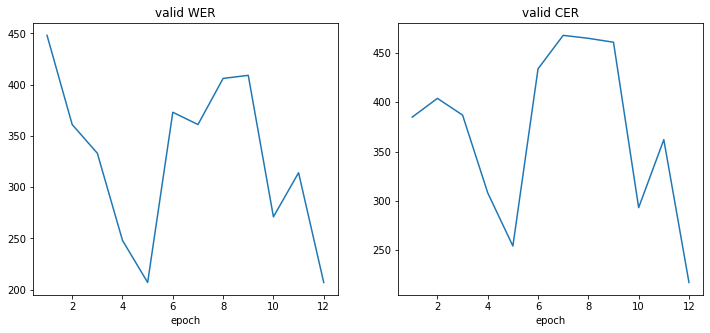

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(12, 5))
ax[0].plot(total_df['epoch'], total_df['valid WER'])
ax[0].set_xlabel('epoch')
ax[0].set_title('valid WER')

ax[1].plot(total_df['epoch'], total_df['valid CER'])
ax[1].set_xlabel('epoch')
ax[1].set_title('valid CER')

plt.show()

In [ ]:
!head -37 /content/wer_2022_05_12.txt

%WER 177.72 [ 5488 / 3088, 2424 ins, 115 del, 2949 sub ]
%SER 100.00 [ 744 / 744 ]
Scored 744 sentences, 0 not present in hyp.
ALIGNMENTS

Format:
<utterance-id>, WER DETAILS
<eps> ; reference  ; on ; the ; first ;  line
  I   ;     S      ; =  ;  =  ;   S   ;   D  
 and  ; hypothesis ; on ; the ; third ; <eps>
e-fd-e053d727270f, %WER 300.00 [ 6 / 2, 4 ins, 0 del, 2 sub ]
ПОКАЧАЛ ; ГОЛОВОЙ ; <eps> ;   <eps>   ;   <eps>   ;  <eps>  
   S    ;    S    ;   I   ;     I     ;     I     ;    I    
 ХОТИТЕ ;   ЧТОБ  ;  ОНО  ; СОСТОЯННО ; ПРИЕЗЖАЛА ; ЗАГЛЯНУЛ
c-e5-c97550758db6, %WER 100.00 [ 8 / 8, 0 ins, 1 del, 7 sub ]
    ЗУБРЫ     ;    ВСЕ    ;  НЕ  ;  ТОЛЬКО  ; ЗЕМЛЕПАШЦЫ ; НО ;      И      ; ОХОТНИКИ
      S       ;     S     ;  S   ;    S     ;     S      ; S  ;      S      ;    D    
ДЕВЯТНАДЦАТЫЙ ; НОРМАЛЬНО ; НОГИ ; СПОСОБЕН ;  УСЫПИТЬ   ; ЕЁ ; ПРИГЛАШЕНИЕ ;  <eps>  
7-20-0f06df5e59c9, %WER 120.00 [ 6 / 5, 1 ins, 0 del, 5 sub ]
    ПОТОМ     ;   ОГОРОДЫ   ; ЗАКОНЧИЛИСЬ ; ПУТНИКИ ; ОКА